In [1]:
import numpy as np
import pickle
import sys
from typing import List
import torch
import os

In [2]:
participant_data_path = './EEG/number'
processed_data_path = './EEG/processed_data'
split_data_path = './EEG/split_data'

In [3]:
ps = os.listdir(participant_data_path)
participants=[]
for p in ps:
    p= p[:3]
    if p not in participants:
        participants.append(p)
        
participants= sorted(participants)
# participants, len(participants)

In [4]:
load_name=f"userfold_data_scaled_p_dictionary-number"
data_dir = "./EEG/split_data/standard_scaled"
try:
    raw_user_fold= pickle.load(open(os.path.join(data_dir, f"{load_name}.pkl"), "rb"))
except:
    print(f"pickle file does not exist. Use EEG-Preprocess.ipynb and EEG-Split.ipynb to save data setting.")
    sys.exit()

In [6]:
from utilities.userfold_framework import *
from Models.AR_EEG_models import *
import Models.model_func as Model_Func
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List
from torcheeg.models import EEGNet
from torch import nn


DEVICE= torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

learning_rate = 0.00005
batch_size = 64
n_epochs = 300
transpose_channels=True
participants_dictionary=[]
# participants_online_dictionary=[]
participants_grads_dictionary={}
b_acc_list=[]
c0_acc_list=[]
c1_acc_list=[]

# EPOCH=[
    
# ]

for i in range(len(participants)):

    train_dataloader, val_dataloader, classes, input_dim, class_ratio= user_fold_load(i,
                                                                                      raw_user_fold,
                                                                                      participants,
                                                                                      batch_size=batch_size,
                                                                                      transpose_channels=transpose_channels)

    classifier= EEGNet(
        chunk_size=input_dim[1],
        num_electrodes=input_dim[0],
        num_classes=classes,
        kernel_1= 32,
        kernel_2=32,
        F1=8,
        F2=16,
        dropout=0.5
    ).to(DEVICE)
    
    
    
    
    criterion= torch.nn.CrossEntropyLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
#     criterion = nn.NLLLoss(weight=torch.tensor(class_ratio, dtype=torch.float).to(DEVICE))
        
    saved_dir= "./EEG/saved_models/Userfold/run1"
    model = EEGNet_IE_EEG_Wrapper(DEVICE, classifier, input_dim[0]).to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
#     optimizer= torch.optim.RMSprop(classifier.parameters(), lr=learning_rate)
    scheduler= torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=2)

    
    train_func= eeg_train
    model.training_procedure(iteration=n_epochs,
                                    train_dataloader=train_dataloader,
                                     val_dataloader=val_dataloader,
                                     print_cycle=2,
                                     path=f"./dictionary/intermdiate_dicts",
                                     loss_func=criterion,
                                     optimiser=optimizer, #scheduler=scheduler,
                                     train_func=train_func
                                    )
    if model.epoch == n_epochs+1:
        EPOCH= n_epochs
    else:
        EPOCH= model.epoch
    
    torch.save(model.state_dict(), 
           os.path.join(
               saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_EEG-e{EPOCH}.pt"
           )
    )

    pickle.dump( model.return_IE_weights(), 
                open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_EEG-w-e{EPOCH}.pkl", "wb") 
               )    

# OR
#     model.load_state_dict(
#     torch.load(
#         open(
#             os.path.join(
#                 saved_dir, f"Userfold-{participants[i]}-EEGNet-Weight_EEG-e{n_epochs}.pt"
#             ), "rb"
#         )
#               )
#     )

    
    prediction, dictionary= model.prediction_procedure(val_dataloader, dict_flag=True)
    
    ys= np.concatenate([y.detach().cpu().numpy() for x, y in val_dataloader])
    
    c0_acc, c1_acc, b_acc= calculate_accuracy(ys, prediction)
    print("c0_acc", c0_acc, ", c1_acc", c1_acc, ", b_acc", b_acc)
    b_acc_list.append(b_acc)
    c0_acc_list.append(c0_acc)
    c1_acc_list.append(c1_acc)
    participants_dictionary.append(dictionary)
    

tmp=[]
for i, dictionary in enumerate(participants_dictionary):
    print(f"User {participants[i]} f1: {dictionary['weighted avg']['f1-score']} acc: {dictionary['accuracy']}")
    print(f" c0: {c0_acc_list[i]} c1: {c1_acc_list[i]} bacc: {b_acc_list[i]}")
    tmp.append(dictionary['weighted avg']['f1-score'])

print(f"average {np.mean(tmp)}")
print()
print(np.array(b_acc_list).mean())
print(np.array(c1_acc_list).mean())
print(np.array(c0_acc_list).mean())


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6853456765997643


Iterations:   0%|                                   | 1/300 [00:01<05:46,  1.16s/it]

Epoch:  0
t_loss:  0.6853456765997643 , v_loss:  0.6832794348398844
t_acc:  0.5406162464985994 , v_acc:  0.6583850931677019
t_recall:  0.5199935493611123 , v_recall:  0.6148648648648649
t_prec:  0.5171853298372167 , v_prec:  0.6093481989708405
t_f:  0.5083590779221318 , v_f:  0.6113671274961597
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:21,  1.14it/s]

Epoch  1 , loss 0.659756556445477
Epoch  2 , loss 0.6335704198070601


Iterations:   1%|▎                                  | 3/300 [00:02<04:49,  1.02it/s]

Epoch:  2
t_loss:  0.6335704198070601 , v_loss:  0.6688109834988912
t_acc:  0.6084656084656085 , v_acc:  0.7080745341614907
t_recall:  0.5213200477621773 , v_recall:  0.617927927927928
t_prec:  0.5229618986802895 , v_prec:  0.6484126984126983
t_f:  0.5213069393045346 , v_f:  0.6243732936212458
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:15,  1.16it/s]

Epoch  3 , loss 0.6112548101182077
Epoch  4 , loss 0.5951397231980866


Iterations:   2%|▌                                  | 5/300 [00:04<04:39,  1.06it/s]

Epoch:  4
t_loss:  0.5951397231980866 , v_loss:  0.6502862373987833
t_acc:  0.6408341114223467 , v_acc:  0.7391304347826086
t_recall:  0.5077819409560671 , v_recall:  0.6184684684684685
t_prec:  0.5124584717607974 , v_prec:  0.7150098103335514
t_f:  0.4939541488149051 , v_f:  0.6243333333333334
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:14,  1.15it/s]

Epoch  5 , loss 0.5738088687260946
Epoch  6 , loss 0.556517432717716


Iterations:   2%|▊                                  | 7/300 [00:06<04:37,  1.06it/s]

Epoch:  6
t_loss:  0.556517432717716 , v_loss:  0.6350507934888204
t_acc:  0.6753812636165577 , v_acc:  0.7080745341614907
t_recall:  0.5130618575095044 , v_recall:  0.540990990990991
t_prec:  0.537582335999326 , v_prec:  0.711038961038961
t_f:  0.4772704548591965 , v_f:  0.4990400529625952
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:15,  1.14it/s]

Epoch  7 , loss 0.5446087203773797
Epoch  8 , loss 0.5293984828042049


Iterations:   3%|█                                  | 9/300 [00:08<04:37,  1.05it/s]

Epoch:  8
t_loss:  0.5293984828042049 , v_loss:  0.6267160475254059
t_acc:  0.6931216931216931 , v_acc:  0.6956521739130435
t_recall:  0.5160373862560217 , v_recall:  0.5154954954954954
t_prec:  0.5861954501195008 , v_prec:  0.6814345991561181
t_f:  0.4631169544262094 , v_f:  0.44665778214210566
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:13,  1.15it/s]

Epoch  9 , loss 0.5153302941836563
Epoch  10 , loss 0.5046472637092366


Iterations:   4%|█▏                                | 11/300 [00:10<04:34,  1.05it/s]

Epoch:  10
t_loss:  0.5046472637092366 , v_loss:  0.6240411400794983
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.5128429475302287 , v_recall:  0.5054954954954954
t_prec:  0.5928777973346744 , v_prec:  0.5959119496855345
t_f:  0.45205582090719837 , v_f:  0.4266381766381766
////////


Iterations:   4%|█▎                                | 12/300 [00:10<04:09,  1.15it/s]

Epoch  11 , loss 0.49766792035570334
Epoch  12 , loss 0.4934205348585166


Iterations:   4%|█▍                                | 13/300 [00:12<04:33,  1.05it/s]

Epoch:  12
t_loss:  0.4934205348585166 , v_loss:  0.6243504484494528
t_acc:  0.6934329287270464 , v_acc:  0.6894409937888198
t_recall:  0.5030345452299584 , v_recall:  0.5
t_prec:  0.5535844118074742 , v_prec:  0.3447204968944099
t_f:  0.42468059625304927 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▌                                | 14/300 [00:12<04:11,  1.14it/s]

Epoch  13 , loss 0.48205837957999287
Epoch  14 , loss 0.4738518280141494


Iterations:   5%|█▋                                | 15/300 [00:13<04:38,  1.02it/s]

Epoch:  14
t_loss:  0.4738518280141494 , v_loss:  0.626028815905253
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5078917390647946 , v_recall:  0.5
t_prec:  0.6467935189597658 , v_prec:  0.3447204968944099
t_f:  0.43195024184451847 , v_f:  0.4080882352941176
////////


Iterations:   5%|█▊                                | 16/300 [00:14<04:14,  1.12it/s]

Epoch  15 , loss 0.4756384059494617
Epoch  16 , loss 0.4649529270097321


Iterations:   6%|█▉                                | 17/300 [00:15<04:29,  1.05it/s]

Epoch:  16
t_loss:  0.4649529270097321 , v_loss:  0.6284739772478739
t_acc:  0.6977902272019919 , v_acc:  0.6894409937888198
t_recall:  0.5053039348897216 , v_recall:  0.5
t_prec:  0.6910407672280263 , v_prec:  0.3447204968944099
t_f:  0.4236119668639369 , v_f:  0.4080882352941176
////////


Iterations:   6%|██                                | 18/300 [00:16<04:05,  1.15it/s]

Epoch  17 , loss 0.46679116990052016
Epoch  18 , loss 0.46472881880461003


Iterations:   6%|██▏                               | 19/300 [00:17<04:24,  1.06it/s]

Epoch:  18
t_loss:  0.46472881880461003 , v_loss:  0.6306577225526174
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5016613826326841 , v_recall:  0.5
t_prec:  0.6259363295880149 , v_prec:  0.3447204968944099
t_f:  0.41525155202966746 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▎                               | 20/300 [00:18<04:07,  1.13it/s]

Epoch  19 , loss 0.4583200409131892
Epoch  20 , loss 0.45863012589660346


Iterations:   7%|██▍                               | 21/300 [00:19<04:29,  1.04it/s]

Epoch:  20
t_loss:  0.45863012589660346 , v_loss:  0.6329982479413351
t_acc:  0.6943666355431062 , v_acc:  0.6894409937888198
t_recall:  0.5005428144000219 , v_recall:  0.5
t_prec:  0.5264926539543607 , v_prec:  0.3447204968944099
t_f:  0.41468331117100216 , v_f:  0.4080882352941176
////////


Iterations:   7%|██▍                               | 22/300 [00:20<04:08,  1.12it/s]

Epoch  21 , loss 0.4494263331095378
Epoch  22 , loss 0.4480190744587019


Iterations:   8%|██▌                               | 23/300 [00:21<04:24,  1.05it/s]

Epoch:  22
t_loss:  0.4480190744587019 , v_loss:  0.6352581779162089
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5014376689861517 , v_recall:  0.5
t_prec:  0.5981111458008117 , v_prec:  0.3447204968944099
t_f:  0.41513796302224715 , v_f:  0.4080882352941176
////////


Iterations:   8%|██▋                               | 24/300 [00:21<04:00,  1.15it/s]

Epoch  23 , loss 0.4535420799956602
Epoch  24 , loss 0.4427017569541931


Iterations:   8%|██▊                               | 25/300 [00:23<04:18,  1.06it/s]

Epoch:  24
t_loss:  0.4427017569541931 , v_loss:  0.6361478169759115
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.5011501351889214 , v_recall:  0.5
t_prec:  0.5980499219968799 , v_prec:  0.3447204968944099
t_f:  0.41416708924949286 , v_f:  0.4080882352941176
////////


Iterations:   9%|██▉                               | 26/300 [00:23<03:56,  1.16it/s]

Epoch  25 , loss 0.4455443550558651
Epoch  26 , loss 0.4421059857396519


Iterations:   9%|███                               | 27/300 [00:24<04:18,  1.05it/s]

Epoch:  26
t_loss:  0.4421059857396519 , v_loss:  0.6357030868530273
t_acc:  0.6959228135698724 , v_acc:  0.6894409937888198
t_recall:  0.5010863150382235 , v_recall:  0.5
t_prec:  0.6480361596009975 , v_prec:  0.3447204968944099
t_f:  0.41330358142435736 , v_f:  0.4080882352941176
////////


Iterations:   9%|███▏                              | 28/300 [00:25<03:59,  1.13it/s]

Epoch  27 , loss 0.4424964201216604
Epoch  28 , loss 0.44441233370818345


Iterations:  10%|███▎                              | 29/300 [00:26<04:16,  1.06it/s]

Epoch:  28
t_loss:  0.44441233370818345 , v_loss:  0.6339710553487142
t_acc:  0.6965452847805789 , v_acc:  0.6894409937888198
t_recall:  0.5026838775202097 , v_recall:  0.5
t_prec:  0.6665578331724491 , v_prec:  0.3447204968944099
t_f:  0.4174144390948958 , v_f:  0.4080882352941176
////////


Iterations:  10%|███▍                              | 30/300 [00:27<03:52,  1.16it/s]

Epoch  29 , loss 0.43670086065928143
Epoch  30 , loss 0.45015036650732454


Iterations:  10%|███▌                              | 31/300 [00:28<04:13,  1.06it/s]

Epoch:  30
t_loss:  0.45015036650732454 , v_loss:  0.6330061753590902
t_acc:  0.6946778711484594 , v_acc:  0.6894409937888198
t_recall:  0.49990392665486333 , v_recall:  0.5
t_prec:  0.49064254522769807 , v_prec:  0.3447204968944099
t_f:  0.4118815871597207 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▋                              | 32/300 [00:29<03:51,  1.16it/s]

Epoch  31 , loss 0.4392743052220812
Epoch  32 , loss 0.4406050443649292


Iterations:  11%|███▋                              | 33/300 [00:30<04:12,  1.06it/s]

Epoch:  32
t_loss:  0.4406050443649292 , v_loss:  0.6301418940226237
t_acc:  0.6956115779645191 , v_acc:  0.6894409937888198
t_recall:  0.500862601391691 , v_recall:  0.5
t_prec:  0.5979887745556596 , v_prec:  0.3447204968944099
t_f:  0.4131921101460188 , v_f:  0.4080882352941176
////////


Iterations:  11%|███▊                              | 34/300 [00:31<03:52,  1.14it/s]

Epoch  33 , loss 0.44272901672942966
Epoch  34 , loss 0.44368592138383905


Iterations:  12%|███▉                              | 35/300 [00:32<04:13,  1.05it/s]

Epoch:  34
t_loss:  0.44368592138383905 , v_loss:  0.628248522679011
t_acc:  0.6949891067538126 , v_acc:  0.6894409937888198
t_recall:  0.5012777754903172 , v_recall:  0.5
t_prec:  0.562363238512035 , v_prec:  0.3447204968944099
t_f:  0.4158754021869472 , v_f:  0.4080882352941176
////////


Iterations:  12%|████                              | 36/300 [00:32<03:51,  1.14it/s]

Epoch  35 , loss 0.4367632585413316
Epoch  36 , loss 0.4398990267632054


Iterations:  12%|████▏                             | 37/300 [00:33<04:08,  1.06it/s]

Epoch:  36
t_loss:  0.4398990267632054 , v_loss:  0.6250417232513428
t_acc:  0.6962340491752257 , v_acc:  0.6894409937888198
t_recall:  0.5015975624819863 , v_recall:  0.5
t_prec:  0.6814780168381664 , v_prec:  0.3447204968944099
t_f:  0.4143921262806895 , v_f:  0.4080882352941176
////////


Iterations:  13%|████▎                             | 38/300 [00:34<03:43,  1.17it/s]

Epoch  37 , loss 0.43445351544548483
Epoch  38 , loss 0.43550579162204966


Iterations:  13%|████▍                             | 39/300 [00:35<04:08,  1.05it/s]

Epoch:  38
t_loss:  0.43550579162204966 , v_loss:  0.6198691676060358
t_acc:  0.6965452847805789 , v_acc:  0.6956521739130435
t_recall:  0.5032589451146704 , v_recall:  0.51
t_prec:  0.6484990619136961 , v_prec:  0.846875
t_f:  0.41933401285531013 , v_f:  0.42920193907821425
////////


Iterations:  13%|████▌                             | 40/300 [00:36<03:48,  1.14it/s]

Epoch  39 , loss 0.4309128382626702
Epoch  40 , loss 0.43771147961710016


Iterations:  14%|████▋                             | 41/300 [00:37<04:04,  1.06it/s]

Epoch:  40
t_loss:  0.43771147961710016 , v_loss:  0.6157060861587524
t_acc:  0.6953003423591659 , v_acc:  0.6956521739130435
t_recall:  0.5012139553396193 , v_recall:  0.51
t_prec:  0.5753364374538641 , v_prec:  0.846875
t_f:  0.41502434448605435 , v_f:  0.42920193907821425
////////


Iterations:  14%|████▊                             | 42/300 [00:38<03:44,  1.15it/s]

Epoch  41 , loss 0.43211065729459125
Epoch  42 , loss 0.4327264001556471


Iterations:  14%|████▊                             | 43/300 [00:39<04:06,  1.04it/s]

Epoch:  42
t_loss:  0.4327264001556471 , v_loss:  0.611143151919047
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5051762945883257 , v_recall:  0.51
t_prec:  0.7719831730769231 , v_prec:  0.846875
t_f:  0.42195546486919533 , v_f:  0.42920193907821425
////////


Iterations:  15%|████▉                             | 44/300 [00:40<03:43,  1.15it/s]

Epoch  43 , loss 0.43550341737036613
Epoch  44 , loss 0.4325721813183205


Iterations:  15%|█████                             | 45/300 [00:41<03:58,  1.07it/s]

Epoch:  44
t_loss:  0.4325721813183205 , v_loss:  0.6084191103776296
t_acc:  0.6974789915966386 , v_acc:  0.6956521739130435
t_recall:  0.5039300860542677 , v_recall:  0.51
t_prec:  0.7236410496719775 , v_prec:  0.846875
t_f:  0.4196869355809753 , v_f:  0.42920193907821425
////////


Iterations:  15%|█████▏                            | 46/300 [00:41<03:41,  1.14it/s]

Epoch  45 , loss 0.4321623853608674
Epoch  46 , loss 0.43677199880282086


Iterations:  16%|█████▎                            | 47/300 [00:43<04:00,  1.05it/s]

Epoch:  46
t_loss:  0.43677199880282086 , v_loss:  0.6048947672049204
t_acc:  0.6984126984126984 , v_acc:  0.6956521739130435
t_recall:  0.5069014973717078 , v_recall:  0.51
t_prec:  0.6892785445420326 , v_prec:  0.846875
t_f:  0.42760745975240416 , v_f:  0.42920193907821425
////////


Iterations:  16%|█████▍                            | 48/300 [00:43<03:40,  1.14it/s]

Epoch  47 , loss 0.43804532815428343
Epoch  48 , loss 0.43259626451660604


Iterations:  16%|█████▌                            | 49/300 [00:44<03:57,  1.06it/s]

Epoch:  48
t_loss:  0.43259626451660604 , v_loss:  0.6014824211597443
t_acc:  0.6968565203859322 , v_acc:  0.6956521739130435
t_recall:  0.5040577263556635 , v_recall:  0.51
t_prec:  0.6542253521126761 , v_prec:  0.846875
t_f:  0.421357252213273 , v_f:  0.42920193907821425
////////


Iterations:  17%|█████▋                            | 50/300 [00:45<03:36,  1.16it/s]

Epoch  49 , loss 0.43043194039195193
Epoch  50 , loss 0.43364666431557897


Iterations:  17%|█████▊                            | 51/300 [00:46<03:59,  1.04it/s]

Epoch:  50
t_loss:  0.43364666431557897 , v_loss:  0.5977485577265421
t_acc:  0.6971677559912854 , v_acc:  0.7018633540372671
t_recall:  0.505144041393887 , v_recall:  0.52
t_prec:  0.653250647403571 , v_prec:  0.8490566037735849
t_f:  0.42430859463117526 , v_f:  0.44957264957264953
////////


Iterations:  17%|█████▉                            | 52/300 [00:47<03:36,  1.15it/s]

Epoch  51 , loss 0.4347160540375055
Epoch  52 , loss 0.4308582707947376


Iterations:  18%|██████                            | 53/300 [00:48<03:52,  1.06it/s]

Epoch:  52
t_loss:  0.4308582707947376 , v_loss:  0.5945513645807902
t_acc:  0.6956115779645191 , v_acc:  0.7018633540372671
t_recall:  0.5040254731612248 , v_recall:  0.52
t_prec:  0.5986656200941916 , v_prec:  0.8490566037735849
t_f:  0.42369509878001366 , v_f:  0.44957264957264953
////////


Iterations:  18%|██████                            | 54/300 [00:49<03:33,  1.15it/s]

Epoch  53 , loss 0.427899522524254
Epoch  54 , loss 0.43183978340205026


Iterations:  18%|██████▏                           | 55/300 [00:50<03:49,  1.07it/s]

Epoch:  54
t_loss:  0.43183978340205026 , v_loss:  0.5938661893208822
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5058790024841822 , v_recall:  0.52
t_prec:  0.6751465176502658 , v_prec:  0.8490566037735849
t_f:  0.4254919274274113 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▎                           | 56/300 [00:50<03:32,  1.15it/s]

Epoch  55 , loss 0.43712757147994696
Epoch  56 , loss 0.4282931165367949


Iterations:  19%|██████▍                           | 57/300 [00:52<03:51,  1.05it/s]

Epoch:  56
t_loss:  0.4282931165367949 , v_loss:  0.5923773547013601
t_acc:  0.6946778711484594 , v_acc:  0.7018633540372671
t_recall:  0.5019166632354758 , v_recall:  0.52
t_prec:  0.5625 , v_prec:  0.8490566037735849
t_f:  0.4186275828066873 , v_f:  0.44957264957264953
////////


Iterations:  19%|██████▌                           | 58/300 [00:52<03:31,  1.14it/s]

Epoch  57 , loss 0.4249190840066648
Epoch  58 , loss 0.43333569753403756


Iterations:  20%|██████▋                           | 59/300 [00:54<03:52,  1.04it/s]

Epoch:  58
t_loss:  0.43333569753403756 , v_loss:  0.5889578560988108
t_acc:  0.6965452847805789 , v_acc:  0.7018633540372671
t_recall:  0.5038340127091311 , v_recall:  0.52
t_prec:  0.6380961012424612 , v_prec:  0.8490566037735849
t_f:  0.42123755684071923 , v_f:  0.44957264957264953
////////


Iterations:  20%|██████▊                           | 60/300 [00:54<03:30,  1.14it/s]

Epoch  59 , loss 0.4340316927900501
Epoch  60 , loss 0.427774765327865


Iterations:  20%|██████▉                           | 61/300 [00:55<03:48,  1.04it/s]

Epoch:  60
t_loss:  0.427774765327865 , v_loss:  0.5870181620121002
t_acc:  0.7009025832555245 , v_acc:  0.7080745341614907
t_recall:  0.5098413417328886 , v_recall:  0.53
t_prec:  0.7699058971141781 , v_prec:  0.8512658227848101
t_f:  0.43233309475960835 , v_f:  0.4692431787893666
////////


Iterations:  21%|███████                           | 62/300 [00:56<03:29,  1.13it/s]

Epoch  61 , loss 0.4298531868878533
Epoch  62 , loss 0.42303813584879335


Iterations:  21%|███████▏                          | 63/300 [00:57<03:47,  1.04it/s]

Epoch:  62
t_loss:  0.42303813584879335 , v_loss:  0.5849804679552714
t_acc:  0.6977902272019919 , v_acc:  0.7018633540372671
t_recall:  0.5058790024841822 , v_recall:  0.52
t_prec:  0.6751465176502658 , v_prec:  0.8490566037735849
t_f:  0.4254919274274113 , v_f:  0.44957264957264953
////////


Iterations:  21%|███████▎                          | 64/300 [00:58<03:29,  1.13it/s]

Epoch  63 , loss 0.4272247289910036
Epoch  64 , loss 0.42862075216629925


Iterations:  22%|███████▎                          | 65/300 [00:59<03:52,  1.01it/s]

Epoch:  64
t_loss:  0.42862075216629925 , v_loss:  0.5825175692637762
t_acc:  0.7021475256769374 , v_acc:  0.7142857142857143
t_recall:  0.5138990680885522 , v_recall:  0.54
t_prec:  0.722881666788937 , v_prec:  0.8535031847133758
t_f:  0.4428126820579124 , v_f:  0.488253178551686
////////


Iterations:  22%|███████▍                          | 66/300 [01:00<03:34,  1.09it/s]

Epoch  65 , loss 0.4259357908192803
Epoch  66 , loss 0.4279665450255076


Iterations:  22%|███████▌                          | 67/300 [01:01<03:47,  1.02it/s]

Epoch:  66
t_loss:  0.4279665450255076 , v_loss:  0.580082044005394
t_acc:  0.6965452847805789 , v_acc:  0.7204968944099379
t_recall:  0.5055592154925131 , v_recall:  0.55
t_prec:  0.6231878915674864 , v_prec:  0.8557692307692308
t_f:  0.4268539028382732 , v_f:  0.5066394279877425
////////


Iterations:  23%|███████▋                          | 68/300 [01:02<03:28,  1.11it/s]

Epoch  67 , loss 0.4244759748963749
Epoch  68 , loss 0.4285363689357159


Iterations:  23%|███████▊                          | 69/300 [01:03<03:46,  1.02it/s]

Epoch:  68
t_loss:  0.4285363689357159 , v_loss:  0.5782528668642044
t_acc:  0.699035169623405 , v_acc:  0.7204968944099379
t_recall:  0.5093616612453851 , v_recall:  0.55
t_prec:  0.67413540744775 , v_prec:  0.8557692307692308
t_f:  0.4342903026402157 , v_f:  0.5066394279877425
////////


Iterations:  23%|███████▉                          | 70/300 [01:04<03:28,  1.10it/s]

Epoch  69 , loss 0.42927392440683704
Epoch  70 , loss 0.4236724920132581


Iterations:  24%|████████                          | 71/300 [01:05<03:46,  1.01it/s]

Epoch:  70
t_loss:  0.4236724920132581 , v_loss:  0.5760530680418015
t_acc:  0.6984126984126984 , v_acc:  0.7267080745341615
t_recall:  0.5089142339523202 , v_recall:  0.56
t_prec:  0.6574087538170714 , v_prec:  0.8580645161290323
t_f:  0.4340258860601064 , v_f:  0.5244360902255639
////////


Iterations:  24%|████████▏                         | 72/300 [01:06<03:27,  1.10it/s]

Epoch  71 , loss 0.4267693822290383
Epoch  72 , loss 0.42253810576364104


Iterations:  24%|████████▎                         | 73/300 [01:07<03:46,  1.00it/s]

Epoch:  72
t_loss:  0.42253810576364104 , v_loss:  0.572810153166453
t_acc:  0.6971677559912854 , v_acc:  0.7329192546583851
t_recall:  0.5071567779744994 , v_recall:  0.5700000000000001
t_prec:  0.6331225747157737 , v_prec:  0.8603896103896104
t_f:  0.4307802114466699 , v_f:  0.5416749420721615
////////


Iterations:  25%|████████▍                         | 74/300 [01:07<03:24,  1.10it/s]

Epoch  73 , loss 0.42199667820743486
Epoch  74 , loss 0.4276902909372367


Iterations:  25%|████████▌                         | 75/300 [01:09<03:44,  1.00it/s]

Epoch:  74
t_loss:  0.4276902909372367 , v_loss:  0.572795589764913
t_acc:  0.6968565203859322 , v_acc:  0.7329192546583851
t_recall:  0.507795665719658 , v_recall:  0.5700000000000001
t_prec:  0.6222066037465217 , v_prec:  0.8603896103896104
t_f:  0.4333649351571135 , v_f:  0.5416749420721615
////////


Iterations:  25%|████████▌                         | 76/300 [01:09<03:23,  1.10it/s]

Epoch  75 , loss 0.42155639798033473
Epoch  76 , loss 0.42214108565274405


Iterations:  26%|████████▋                         | 77/300 [01:10<03:39,  1.01it/s]

Epoch:  76
t_loss:  0.42214108565274405 , v_loss:  0.5724058300256729
t_acc:  0.7009025832555245 , v_acc:  0.7391304347826086
t_recall:  0.5121416121107314 , v_recall:  0.58
t_prec:  0.7040683726509396 , v_prec:  0.8627450980392157
t_f:  0.4395929893517526 , v_f:  0.5583855799373041
////////


Iterations:  26%|████████▊                         | 78/300 [01:11<03:23,  1.09it/s]

Epoch  77 , loss 0.4224385093240177
Epoch  78 , loss 0.4226149361507565


Iterations:  26%|████████▉                         | 79/300 [01:12<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.4226149361507565 , v_loss:  0.5703949729601542
t_acc:  0.699035169623405 , v_acc:  0.7391304347826086
t_recall:  0.5090741274481547 , v_recall:  0.58
t_prec:  0.6783196979232222 , v_prec:  0.8627450980392157
t_f:  0.4333828345311067 , v_f:  0.5583855799373041
////////


Iterations:  27%|█████████                         | 80/300 [01:13<03:20,  1.10it/s]

Epoch  79 , loss 0.426567895155327
Epoch  80 , loss 0.4268953648268008


Iterations:  27%|█████████▏                        | 81/300 [01:14<03:35,  1.02it/s]

Epoch:  80
t_loss:  0.4268953648268008 , v_loss:  0.5672182887792587
t_acc:  0.7002801120448179 , v_acc:  0.7391304347826086
t_recall:  0.5116941848176665 , v_recall:  0.58
t_prec:  0.6875247597388305 , v_prec:  0.8627450980392157
t_f:  0.4393193446413476 , v_f:  0.5583855799373041
////////


Iterations:  27%|█████████▎                        | 82/300 [01:15<03:15,  1.12it/s]

Epoch  81 , loss 0.42411373993929696
Epoch  82 , loss 0.42268195689893234


Iterations:  28%|█████████▍                        | 83/300 [01:16<03:40,  1.02s/it]

Epoch:  82
t_loss:  0.42268195689893234 , v_loss:  0.5667794744173685
t_acc:  0.7021475256769374 , v_acc:  0.7391304347826086
t_recall:  0.5144741356830128 , v_recall:  0.58
t_prec:  0.7126181099716402 , v_prec:  0.8627450980392157
t_f:  0.44457602702299936 , v_f:  0.5583855799373041
////////


Iterations:  28%|█████████▌                        | 84/300 [01:17<03:23,  1.06it/s]

Epoch  83 , loss 0.42654510339101154
Epoch  84 , loss 0.4222296014720318


Iterations:  28%|█████████▋                        | 85/300 [01:18<03:38,  1.02s/it]

Epoch:  84
t_loss:  0.4222296014720318 , v_loss:  0.5656021386384964
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5140905285406459 , v_recall:  0.59
t_prec:  0.687376803835203 , v_prec:  0.8651315789473684
t_f:  0.44502580120477586 , v_f:  0.5745956048205194
////////


Iterations:  29%|█████████▋                        | 86/300 [01:19<03:21,  1.06it/s]

Epoch  85 , loss 0.42026593054042144
Epoch  86 , loss 0.42961535558981057


Iterations:  29%|█████████▊                        | 87/300 [01:20<03:34,  1.01s/it]

Epoch:  86
t_loss:  0.42961535558981057 , v_loss:  0.5667467465003332
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5114704711711341 , v_recall:  0.59
t_prec:  0.6798136779597808 , v_prec:  0.8651315789473684
t_f:  0.4391825436257262 , v_f:  0.5745956048205194
////////


Iterations:  29%|█████████▉                        | 88/300 [01:21<03:19,  1.06it/s]

Epoch  87 , loss 0.4281754224908118
Epoch  88 , loss 0.4212297616051693


Iterations:  30%|██████████                        | 89/300 [01:22<03:41,  1.05s/it]

Epoch:  88
t_loss:  0.4212297616051693 , v_loss:  0.564621110757192
t_acc:  0.7005913476501712 , v_acc:  0.7453416149068323
t_recall:  0.5122054322614293 , v_recall:  0.59
t_prec:  0.6913350928024327 , v_prec:  0.8651315789473684
t_f:  0.4403460653194488 , v_f:  0.5745956048205194
////////


Iterations:  30%|██████████▏                       | 90/300 [01:23<03:19,  1.05it/s]

Epoch  89 , loss 0.4177997129804948
Epoch  90 , loss 0.42357007779327094


Iterations:  30%|██████████▎                       | 91/300 [01:24<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.42357007779327094 , v_loss:  0.5624550431966782
t_acc:  0.6984126984126984 , v_acc:  0.7453416149068323
t_recall:  0.5094893015467808 , v_recall:  0.59
t_prec:  0.6521678526887242 , v_prec:  0.8651315789473684
t_f:  0.4358260072247829 , v_f:  0.5745956048205194
////////


Iterations:  31%|██████████▍                       | 92/300 [01:25<03:12,  1.08it/s]

Epoch  91 , loss 0.4275754900539623
Epoch  92 , loss 0.4216593825349621


Iterations:  31%|██████████▌                       | 93/300 [01:26<03:25,  1.01it/s]

Epoch:  92
t_loss:  0.4216593825349621 , v_loss:  0.563197543223699
t_acc:  0.699035169623405 , v_acc:  0.7453416149068323
t_recall:  0.5107993302315368 , v_recall:  0.59
t_prec:  0.6586369806857435 , v_prec:  0.8651315789473684
t_f:  0.4387722237526023 , v_f:  0.5745956048205194
////////


Iterations:  31%|██████████▋                       | 94/300 [01:27<03:07,  1.10it/s]

Epoch  93 , loss 0.42248813720310435
Epoch  94 , loss 0.4282166408557518


Iterations:  32%|██████████▊                       | 95/300 [01:28<03:21,  1.02it/s]

Epoch:  94
t_loss:  0.4282166408557518 , v_loss:  0.5637289385000864
t_acc:  0.7018362900715842 , v_acc:  0.7453416149068323
t_recall:  0.5139628882392501 , v_recall:  0.59
t_prec:  0.7095008305761865 , v_prec:  0.8651315789473684
t_f:  0.4435556998565346 , v_f:  0.5745956048205194
////////


Iterations:  32%|██████████▉                       | 96/300 [01:29<03:08,  1.08it/s]

Epoch  95 , loss 0.4247102421872756
Epoch  96 , loss 0.4243989417365953


Iterations:  32%|██████████▉                       | 97/300 [01:30<03:25,  1.01s/it]

Epoch:  96
t_loss:  0.4243989417365953 , v_loss:  0.5621836533149084
t_acc:  0.7009025832555245 , v_acc:  0.7453416149068323
t_recall:  0.5135792810968831 , v_recall:  0.59
t_prec:  0.6840607210626186 , v_prec:  0.8651315789473684
t_f:  0.4440108450272827 , v_f:  0.5745956048205194
////////


Iterations:  33%|███████████                       | 98/300 [01:31<03:07,  1.08it/s]

Epoch  97 , loss 0.42284093943296697
Epoch  98 , loss 0.4258460145370633


Iterations:  33%|███████████▏                      | 99/300 [01:32<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.4258460145370633 , v_loss:  0.5595761438210806
t_acc:  0.6996576408341114 , v_acc:  0.7453416149068323
t_recall:  0.5118218251190624 , v_recall:  0.59
t_prec:  0.666674191800614 , v_prec:  0.8651315789473684
t_f:  0.4408166033127055 , v_f:  0.5745956048205194
////////


Iterations:  33%|███████████                      | 100/300 [01:32<03:01,  1.10it/s]

Epoch  99 , loss 0.42335137666440475
Epoch  100 , loss 0.42259856240422117


Iterations:  34%|███████████                      | 101/300 [01:34<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.42259856240422117 , v_loss:  0.558804968992869
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5131956739545162 , v_recall:  0.59
t_prec:  0.6631493506493507 , v_prec:  0.8651315789473684
t_f:  0.4444574381991517 , v_f:  0.5745956048205194
////////


Iterations:  34%|███████████▏                     | 102/300 [01:34<03:00,  1.10it/s]

Epoch  101 , loss 0.42242857930706995
Epoch  102 , loss 0.4157448399300669


Iterations:  34%|███████████▎                     | 103/300 [01:36<03:13,  1.02it/s]

Epoch:  102
t_loss:  0.4157448399300669 , v_loss:  0.5569850901762644
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5144741356830128 , v_recall:  0.6
t_prec:  0.7126181099716402 , v_prec:  0.8675496688741722
t_f:  0.44457602702299936 , v_f:  0.5903307888040712
////////


Iterations:  35%|███████████▍                     | 104/300 [01:36<03:02,  1.07it/s]

Epoch  103 , loss 0.41923629477912305
Epoch  104 , loss 0.4228190218701082


Iterations:  35%|███████████▌                     | 105/300 [01:37<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.4228190218701082 , v_loss:  0.5575357029835383
t_acc:  0.7002801120448179 , v_acc:  0.7515527950310559
t_recall:  0.5145695227899699 , v_recall:  0.6
t_prec:  0.6604761904761904 , v_prec:  0.8675496688741722
t_f:  0.4480489351625151 , v_f:  0.5903307888040712
////////


Iterations:  35%|███████████▋                     | 106/300 [01:38<02:56,  1.10it/s]

Epoch  105 , loss 0.4228679870857912
Epoch  106 , loss 0.4239322665859671


Iterations:  36%|███████████▊                     | 107/300 [01:39<03:08,  1.03it/s]

Epoch:  106
t_loss:  0.4239322665859671 , v_loss:  0.5579880823691686
t_acc:  0.7015250544662309 , v_acc:  0.7453416149068323
t_recall:  0.5151768435788694 , v_recall:  0.59
t_prec:  0.6844106463878327 , v_prec:  0.8651315789473684
t_f:  0.44777043865379496 , v_f:  0.5745956048205194
////////


Iterations:  36%|███████████▉                     | 108/300 [01:40<02:54,  1.10it/s]

Epoch  107 , loss 0.4229038907032387
Epoch  108 , loss 0.4262736305302265


Iterations:  36%|███████████▉                     | 109/300 [01:41<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.4262736305302265 , v_loss:  0.5561768064896265
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5140905285406459 , v_recall:  0.5954954954954955
t_prec:  0.687376803835203 , v_prec:  0.8212121212121212
t_f:  0.44502580120477586 , v_f:  0.5853903649268262
////////


Iterations:  37%|████████████                     | 110/300 [01:42<02:56,  1.07it/s]

Epoch  109 , loss 0.42008956799320146
Epoch  110 , loss 0.41918424239345625


Iterations:  37%|████████████▏                    | 111/300 [01:43<03:07,  1.01it/s]

Epoch:  110
t_loss:  0.41918424239345625 , v_loss:  0.5550725559393564
t_acc:  0.7030812324929971 , v_acc:  0.7515527950310559
t_recall:  0.5180206145949136 , v_recall:  0.6
t_prec:  0.6954489520482693 , v_prec:  0.8675496688741722
t_f:  0.4536306479994752 , v_f:  0.5903307888040712
////////


Iterations:  37%|████████████▎                    | 112/300 [01:44<02:55,  1.07it/s]

Epoch  111 , loss 0.4234197823440327
Epoch  112 , loss 0.4160344758454491


Iterations:  38%|████████████▍                    | 113/300 [01:45<03:09,  1.01s/it]

Epoch:  112
t_loss:  0.4160344758454491 , v_loss:  0.5566690117120743
t_acc:  0.7033924680983504 , v_acc:  0.7453416149068323
t_recall:  0.5188193958359067 , v_recall:  0.59
t_prec:  0.695158979419495 , v_prec:  0.8651315789473684
t_f:  0.45546682505964187 , v_f:  0.5745956048205194
////////


Iterations:  38%|████████████▌                    | 114/300 [01:46<02:51,  1.08it/s]

Epoch  113 , loss 0.4119712841861388
Epoch  114 , loss 0.41860160552987863


Iterations:  38%|████████████▋                    | 115/300 [01:47<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.41860160552987863 , v_loss:  0.5566648791233698
t_acc:  0.7005913476501712 , v_acc:  0.7453416149068323
t_recall:  0.5145057026392721 , v_recall:  0.59
t_prec:  0.6676022835394861 , v_prec:  0.8651315789473684
t_f:  0.4473364058859122 , v_f:  0.5745956048205194
////////


Iterations:  39%|████████████▊                    | 116/300 [01:48<02:49,  1.09it/s]

Epoch  115 , loss 0.4173862975017697
Epoch  116 , loss 0.41569528830986396


Iterations:  39%|████████████▊                    | 117/300 [01:49<03:03,  1.00s/it]

Epoch:  116
t_loss:  0.41569528830986396 , v_loss:  0.5570593426624934
t_acc:  0.7009025832555245 , v_acc:  0.7453416149068323
t_recall:  0.5135792810968831 , v_recall:  0.59
t_prec:  0.6840607210626186 , v_prec:  0.8651315789473684
t_f:  0.4440108450272827 , v_f:  0.5745956048205194
////////


Iterations:  39%|████████████▉                    | 118/300 [01:50<02:52,  1.06it/s]

Epoch  117 , loss 0.4181159740569545
Epoch  118 , loss 0.41883745906399744


Iterations:  40%|█████████████                    | 119/300 [01:51<03:01,  1.00s/it]

Epoch:  118
t_loss:  0.41883745906399744 , v_loss:  0.5563015639781952
t_acc:  0.6999688764394647 , v_acc:  0.7453416149068323
t_recall:  0.5137707415489768 , v_recall:  0.59
t_prec:  0.6591103710751665 , v_prec:  0.8651315789473684
t_f:  0.44618741712476023 , v_f:  0.5745956048205194
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:52<02:47,  1.07it/s]

Epoch  119 , loss 0.4209289737776214
Epoch  120 , loss 0.416730397180015


Iterations:  40%|█████████████▎                   | 121/300 [01:53<03:01,  1.01s/it]

Epoch:  120
t_loss:  0.416730397180015 , v_loss:  0.5562848647435507
t_acc:  0.7021475256769374 , v_acc:  0.7453416149068323
t_recall:  0.5150492032774735 , v_recall:  0.59
t_prec:  0.7039848197343453 , v_prec:  0.8651315789473684
t_f:  0.4463250558700412 , v_f:  0.5745956048205194
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:54<02:46,  1.07it/s]

Epoch  121 , loss 0.4179232178949842
Epoch  122 , loss 0.41827867311589856


Iterations:  41%|█████████████▌                   | 123/300 [01:55<02:59,  1.01s/it]

Epoch:  122
t_loss:  0.41827867311589856 , v_loss:  0.5545262495676676
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5180844347456115 , v_recall:  0.59
t_prec:  0.6875373608752171 , v_prec:  0.8651315789473684
t_f:  0.45432404819722766 , v_f:  0.5745956048205194
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:56<02:42,  1.09it/s]

Epoch  123 , loss 0.4181097371905458
Epoch  124 , loss 0.4211378857201221


Iterations:  42%|█████████████▊                   | 125/300 [01:57<02:52,  1.01it/s]

Epoch:  124
t_loss:  0.4211378857201221 , v_loss:  0.5538944552342097
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5180844347456115 , v_recall:  0.59
t_prec:  0.6875373608752171 , v_prec:  0.8651315789473684
t_f:  0.45432404819722766 , v_f:  0.5745956048205194
////////


Iterations:  42%|█████████████▊                   | 126/300 [01:57<02:38,  1.10it/s]

Epoch  125 , loss 0.4170775314172109
Epoch  126 , loss 0.4203387405358109


Iterations:  42%|█████████████▉                   | 127/300 [01:59<02:53,  1.01s/it]

Epoch:  126
t_loss:  0.4203387405358109 , v_loss:  0.5501584510008494
t_acc:  0.7061935885465297 , v_acc:  0.7515527950310559
t_recall:  0.5216954200463897 , v_recall:  0.6054954954954955
t_prec:  0.7353053548745634 , v_prec:  0.8274608501118568
t_f:  0.459357790053988 , v_f:  0.6004962779156328
////////


Iterations:  43%|██████████████                   | 128/300 [01:59<02:36,  1.10it/s]

Epoch  127 , loss 0.4185023728538962
Epoch  128 , loss 0.4167510247698017


Iterations:  43%|██████████████▏                  | 129/300 [02:01<02:51,  1.00s/it]

Epoch:  128
t_loss:  0.4167510247698017 , v_loss:  0.5492853820323944
t_acc:  0.7037037037037037 , v_acc:  0.7453416149068323
t_recall:  0.5187555756852088 , v_recall:  0.5954954954954955
t_prec:  0.7034202326135282 , v_prec:  0.8212121212121212
t_f:  0.45477607641037776 , v_f:  0.5853903649268262
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:01<02:36,  1.09it/s]

Epoch  129 , loss 0.42200422579166935
Epoch  130 , loss 0.4141158061284645


Iterations:  44%|██████████████▍                  | 131/300 [02:02<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.4141158061284645 , v_loss:  0.5510194450616837
t_acc:  0.7030812324929971 , v_acc:  0.7453416149068323
t_recall:  0.5183081483921439 , v_recall:  0.5954954954954955
t_prec:  0.6926726752751537 , v_prec:  0.8212121212121212
t_f:  0.454474685734056 , v_f:  0.5853903649268262
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:03<02:33,  1.10it/s]

Epoch  131 , loss 0.4154578365531622
Epoch  132 , loss 0.4179171376368579


Iterations:  44%|██████████████▋                  | 133/300 [02:04<02:47,  1.00s/it]

Epoch:  132
t_loss:  0.4179171376368579 , v_loss:  0.5514498303333918
t_acc:  0.7024587612822907 , v_acc:  0.7453416149068323
t_recall:  0.5172856535046183 , v_recall:  0.5954954954954955
t_prec:  0.6874776714830104 , v_prec:  0.8212121212121212
t_f:  0.4524852195885727 , v_f:  0.5853903649268262
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:05<02:35,  1.07it/s]

Epoch  133 , loss 0.4080386550403109
Epoch  134 , loss 0.41478435958133025


Iterations:  45%|██████████████▊                  | 135/300 [02:06<02:46,  1.01s/it]

Epoch:  134
t_loss:  0.41478435958133025 , v_loss:  0.552133580048879
t_acc:  0.7049486461251168 , v_acc:  0.7391304347826086
t_recall:  0.5202254978657992 , v_recall:  0.5854954954954955
t_prec:  0.7193627937440457 , v_prec:  0.8142384105960265
t_f:  0.45706693323218295 , v_f:  0.5698473282442748
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:07<02:31,  1.08it/s]

Epoch  135 , loss 0.41570212034618154
Epoch  136 , loss 0.41720828939886656


Iterations:  46%|███████████████                  | 137/300 [02:08<02:40,  1.01it/s]

Epoch:  136
t_loss:  0.41720828939886656 , v_loss:  0.550099308292071
t_acc:  0.7061935885465297 , v_acc:  0.7391304347826086
t_recall:  0.5225580214380807 , v_recall:  0.5854954954954955
t_prec:  0.7241170855870187 , v_prec:  0.8142384105960265
t_f:  0.46185335222095103 , v_f:  0.5698473282442748
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:09<02:25,  1.11it/s]

Epoch  137 , loss 0.41398805146123846
Epoch  138 , loss 0.4132548202486599


Iterations:  46%|███████████████▎                 | 139/300 [02:10<02:37,  1.02it/s]

Epoch:  138
t_loss:  0.4132548202486599 , v_loss:  0.5501405795415243
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.5215993467012531 , v_recall:  0.5854954954954955
t_prec:  0.7116374248034355 , v_prec:  0.8142384105960265
t_f:  0.4605574745238564 , v_f:  0.5698473282442748
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:11<02:23,  1.12it/s]

Epoch  139 , loss 0.415296029810812
Epoch  140 , loss 0.4159093762145323


Iterations:  47%|███████████████▌                 | 141/300 [02:12<02:35,  1.02it/s]

Epoch:  140
t_loss:  0.4159093762145323 , v_loss:  0.5502465019623438
t_acc:  0.7052598817304699 , v_acc:  0.7391304347826086
t_recall:  0.520736745309562 , v_recall:  0.5854954954954955
t_prec:  0.7215179356856612 , v_prec:  0.8142384105960265
t_f:  0.45805899008436957 , v_f:  0.5698473282442748
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:13<02:23,  1.10it/s]

Epoch  141 , loss 0.41558630413868847
Epoch  142 , loss 0.41708754090701833


Iterations:  48%|███████████████▋                 | 143/300 [02:14<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.41708754090701833 , v_loss:  0.5497793356577555
t_acc:  0.7012138188608776 , v_acc:  0.7453416149068323
t_recall:  0.5169658665129493 , v_recall:  0.5954954954954955
t_prec:  0.6639804202483286 , v_prec:  0.8212121212121212
t_f:  0.45357142857142857 , v_f:  0.5853903649268262
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:15<02:21,  1.10it/s]

Epoch  143 , loss 0.41631799118191587
Epoch  144 , loss 0.4130222551962909


Iterations:  48%|███████████████▉                 | 145/300 [02:16<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.4130222551962909 , v_loss:  0.5498781750599543
t_acc:  0.704014939309057 , v_acc:  0.7453416149068323
t_recall:  0.520416958317893 , v_recall:  0.5954954954954955
t_prec:  0.6946950527877148 , v_prec:  0.8212121212121212
t_f:  0.45910862301683886 , v_f:  0.5853903649268262
////////


Iterations:  49%|████████████████                 | 146/300 [02:16<02:20,  1.10it/s]

Epoch  145 , loss 0.41460755701158564
Epoch  146 , loss 0.41211527761291056


Iterations:  49%|████████████████▏                | 147/300 [02:18<02:30,  1.01it/s]

Epoch:  146
t_loss:  0.41211527761291056 , v_loss:  0.5500823011000952
t_acc:  0.704014939309057 , v_acc:  0.7391304347826086
t_recall:  0.5192668231289717 , v_recall:  0.5854954954954955
t_prec:  0.705815658293422 , v_prec:  0.8142384105960265
t_f:  0.45576990450922433 , v_f:  0.5698473282442748
////////


Iterations:  49%|████████████████▎                | 148/300 [02:18<02:15,  1.12it/s]

Epoch  147 , loss 0.41486722377001073
Epoch  148 , loss 0.4166106710246965


Iterations:  50%|████████████████▍                | 149/300 [02:20<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.4166106710246965 , v_loss:  0.5474082181851069
t_acc:  0.7018362900715842 , v_acc:  0.7453416149068323
t_recall:  0.5177008276032445 , v_recall:  0.5954954954954955
t_prec:  0.6710840496657116 , v_prec:  0.8212121212121212
t_f:  0.45470982142857147 , v_f:  0.5853903649268262
////////


Iterations:  50%|████████████████▌                | 150/300 [02:20<02:15,  1.11it/s]

Epoch  149 , loss 0.41370925716325346
Epoch  150 , loss 0.41890168131566513


Iterations:  50%|████████████████▌                | 151/300 [02:21<02:26,  1.02it/s]

Epoch:  150
t_loss:  0.41890168131566513 , v_loss:  0.5490279495716095
t_acc:  0.7052598817304699 , v_acc:  0.7453416149068323
t_recall:  0.5221744142957138 , v_recall:  0.5954954954954955
t_prec:  0.7059464627151051 , v_prec:  0.8212121212121212
t_f:  0.4622065694092495 , v_f:  0.5853903649268262
////////


Iterations:  51%|████████████████▋                | 152/300 [02:22<02:15,  1.09it/s]

Epoch  151 , loss 0.4155046291211072
Epoch  152 , loss 0.4125667366327024


Iterations:  51%|████████████████▊                | 153/300 [02:23<02:26,  1.00it/s]

Epoch:  152
t_loss:  0.4125667366327024 , v_loss:  0.5472183227539062
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5172218333539205 , v_recall:  0.5954954954954955
t_prec:  0.6957851377215611 , v_prec:  0.8212121212121212
t_f:  0.4517841672453898 , v_f:  0.5853903649268262
////////


Iterations:  51%|████████████████▉                | 154/300 [02:24<02:15,  1.08it/s]

Epoch  153 , loss 0.4142797431525062
Epoch  154 , loss 0.4100811516537386


Iterations:  52%|█████████████████                | 155/300 [02:25<02:26,  1.01s/it]

Epoch:  154
t_loss:  0.4100811516537386 , v_loss:  0.5466494560241699
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5202893180164971 , v_recall:  0.5954954954954955
t_prec:  0.710402216508051 , v_prec:  0.8212121212121212
t_f:  0.4577523787844703 , v_f:  0.5853903649268262
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:26<02:13,  1.08it/s]

Epoch  155 , loss 0.4127379433781493
Epoch  156 , loss 0.4141902029514313


Iterations:  52%|█████████████████▎               | 157/300 [02:27<02:23,  1.01s/it]

Epoch:  156
t_loss:  0.4141902029514313 , v_loss:  0.5468109846115112
t_acc:  0.7046374105197635 , v_acc:  0.7453416149068323
t_recall:  0.5208643856109578 , v_recall:  0.5954954954954955
t_prec:  0.7044360369729517 , v_prec:  0.8212121212121212
t_f:  0.4594182083665678 , v_f:  0.5853903649268262
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:28<02:17,  1.04it/s]

Epoch  157 , loss 0.4171035891654445
Epoch  158 , loss 0.4060564263194215


Iterations:  53%|█████████████████▍               | 159/300 [02:29<02:27,  1.05s/it]

Epoch:  158
t_loss:  0.4060564263194215 , v_loss:  0.5456967800855637
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5218230603477855 , v_recall:  0.6154954954954954
t_prec:  0.716815144766147 , v_prec:  0.8331600831600832
t_f:  0.46071321101802937 , v_f:  0.6151866151866152
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:30<02:14,  1.04it/s]

Epoch  159 , loss 0.4134666656746584
Epoch  160 , loss 0.41277766461465876


Iterations:  54%|█████████████████▋               | 161/300 [02:31<02:23,  1.03s/it]

Epoch:  160
t_loss:  0.41277766461465876 , v_loss:  0.5464447687069575
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5215355265505552 , v_recall:  0.6154954954954954
t_prec:  0.7201112877583467 , v_prec:  0.8331600831600832
t_f:  0.4598829316141506 , v_f:  0.6151866151866152
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:32<02:09,  1.06it/s]

Epoch  161 , loss 0.41224465825978446
Epoch  162 , loss 0.40698740090809615


Iterations:  54%|█████████████████▉               | 163/300 [02:33<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.40698740090809615 , v_loss:  0.5459408412377039
t_acc:  0.7052598817304699 , v_acc:  0.7515527950310559
t_recall:  0.5244746846735565 , v_recall:  0.6054954954954955
t_prec:  0.68830384861775 , v_prec:  0.8274608501118568
t_f:  0.468673651690269 , v_f:  0.6004962779156328
////////


Iterations:  55%|██████████████████               | 164/300 [02:34<02:05,  1.08it/s]

Epoch  163 , loss 0.42296111934325276
Epoch  164 , loss 0.41663893005427194


Iterations:  55%|██████████████████▏              | 165/300 [02:35<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.41663893005427194 , v_loss:  0.5460547705491384
t_acc:  0.702769996887644 , v_acc:  0.7453416149068323
t_recall:  0.5186595023400722 , v_recall:  0.5954954954954955
t_prec:  0.6828318734815001 , v_prec:  0.8212121212121212
t_f:  0.4560004098947021 , v_f:  0.5853903649268262
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:36<02:05,  1.07it/s]

Epoch  165 , loss 0.4189743265217426
Epoch  166 , loss 0.4083810980413474


Iterations:  56%|██████████████████▎              | 167/300 [02:37<02:14,  1.01s/it]

Epoch:  166
t_loss:  0.4083810980413474 , v_loss:  0.5463854769865671
t_acc:  0.706504824151883 , v_acc:  0.7453416149068323
t_recall:  0.5227817350846131 , v_recall:  0.5954954954954955
t_prec:  0.7295469631596416 , v_prec:  0.8212121212121212
t_f:  0.4620100134716831 , v_f:  0.5853903649268262
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:38<02:02,  1.08it/s]

Epoch  167 , loss 0.41470029365782646
Epoch  168 , loss 0.4189982484368717


Iterations:  56%|██████████████████▌              | 169/300 [02:39<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.4189982484368717 , v_loss:  0.5465790728727976
t_acc:  0.7005913476501712 , v_acc:  0.7453416149068323
t_recall:  0.516230905422654 , v_recall:  0.5954954954954955
t_prec:  0.6568767908309456 , v_prec:  0.8212121212121212
t_f:  0.45243303571428567 , v_f:  0.5853903649268262
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:40<02:00,  1.08it/s]

Epoch  169 , loss 0.41077865397228913
Epoch  170 , loss 0.41595978099925845


Iterations:  57%|██████████████████▊              | 171/300 [02:41<02:10,  1.01s/it]

Epoch:  170
t_loss:  0.41595978099925845 , v_loss:  0.5446624060471853
t_acc:  0.7086834733893558 , v_acc:  0.7515527950310559
t_recall:  0.526648000988183 , v_recall:  0.6054954954954955
t_prec:  0.7382039013617961 , v_prec:  0.8274608501118568
t_f:  0.469667343829355 , v_f:  0.6004962779156328
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:42<01:58,  1.08it/s]

Epoch  171 , loss 0.4210115542598799
Epoch  172 , loss 0.41439862753830703


Iterations:  58%|███████████████████              | 173/300 [02:43<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.41439862753830703 , v_loss:  0.5452371885379156
t_acc:  0.7021475256769374 , v_acc:  0.7515527950310559
t_recall:  0.5167744060608556 , v_recall:  0.6054954954954955
t_prec:  0.6847619047619047 , v_prec:  0.8274608501118568
t_f:  0.4514878826069854 , v_f:  0.6004962779156328
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:44<01:55,  1.09it/s]

Epoch  173 , loss 0.4155420929777856
Epoch  174 , loss 0.41429998711043714


Iterations:  58%|███████████████████▎             | 175/300 [02:45<02:03,  1.01it/s]

Epoch:  174
t_loss:  0.41429998711043714 , v_loss:  0.5450082868337631
t_acc:  0.7046374105197635 , v_acc:  0.7577639751552795
t_recall:  0.5208643856109578 , v_recall:  0.6154954954954954
t_prec:  0.7044360369729517 , v_prec:  0.8331600831600832
t_f:  0.4594182083665678 , v_f:  0.6151866151866152
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:45<01:51,  1.11it/s]

Epoch  175 , loss 0.41155388250070457
Epoch  176 , loss 0.4148331822133532


Iterations:  59%|███████████████████▍             | 177/300 [02:47<02:00,  1.02it/s]

Epoch:  176
t_loss:  0.4148331822133532 , v_loss:  0.5447351882855097
t_acc:  0.7083722377840025 , v_acc:  0.7515527950310559
t_recall:  0.5278619563278022 , v_recall:  0.6054954954954955
t_prec:  0.7190417787624623 , v_prec:  0.8274608501118568
t_f:  0.4734954362962358 , v_f:  0.6004962779156328
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:47<01:50,  1.11it/s]

Epoch  177 , loss 0.40908721323106806
Epoch  178 , loss 0.4148772779633017


Iterations:  60%|███████████████████▋             | 179/300 [02:49<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.4148772779633017 , v_loss:  0.5443249642848969
t_acc:  0.7024587612822907 , v_acc:  0.7577639751552795
t_recall:  0.5187233224907701 , v_recall:  0.6154954954954954
t_prec:  0.6761879751685422 , v_prec:  0.8331600831600832
t_f:  0.4566805956294283 , v_f:  0.6151866151866152
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:49<01:50,  1.08it/s]

Epoch  179 , loss 0.41204388556527155
Epoch  180 , loss 0.41023798695966307


Iterations:  60%|███████████████████▉             | 181/300 [02:50<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.41023798695966307 , v_loss:  0.5452187409003576
t_acc:  0.7068160597572363 , v_acc:  0.7577639751552795
t_recall:  0.523292982528376 , v_recall:  0.6154954954954954
t_prec:  0.7314190264078906 , v_prec:  0.8331600831600832
t_f:  0.46299349342387275 , v_f:  0.6151866151866152
////////


Iterations:  61%|████████████████████             | 182/300 [02:51<01:47,  1.10it/s]

Epoch  181 , loss 0.4134061207958296
Epoch  182 , loss 0.4116627062652625


Iterations:  61%|████████████████████▏            | 183/300 [02:52<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.4116627062652625 , v_loss:  0.5425293296575546
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5215355265505552 , v_recall:  0.6154954954954954
t_prec:  0.7201112877583467 , v_prec:  0.8331600831600832
t_f:  0.4598829316141506 , v_f:  0.6151866151866152
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:53<01:46,  1.09it/s]

Epoch  183 , loss 0.41753190638972265
Epoch  184 , loss 0.4094465643751855


Iterations:  62%|████████████████████▎            | 185/300 [02:54<01:53,  1.02it/s]

Epoch:  184
t_loss:  0.4094465643751855 , v_loss:  0.5416550586620966
t_acc:  0.7111733582321818 , v_acc:  0.7577639751552795
t_recall:  0.5293003115521335 , v_recall:  0.6154954954954954
t_prec:  0.7686337097125984 , v_prec:  0.8331600831600832
t_f:  0.4733985059928423 , v_f:  0.6151866151866152
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:55<01:44,  1.09it/s]

Epoch  185 , loss 0.407480600417829
Epoch  186 , loss 0.412145384386474


Iterations:  62%|████████████████████▌            | 187/300 [02:56<01:51,  1.01it/s]

Epoch:  186
t_loss:  0.412145384386474 , v_loss:  0.5414539525906245
t_acc:  0.7061935885465297 , v_acc:  0.7639751552795031
t_recall:  0.5231330890325414 , v_recall:  0.6254954954954954
t_prec:  0.717684234090733 , v_prec:  0.83843537414966
t_f:  0.4635005044708999 , v_f:  0.6294815891472869
////////


Iterations:  63%|████████████████████▋            | 188/300 [02:57<01:42,  1.10it/s]

Epoch  187 , loss 0.41139891656006083
Epoch  188 , loss 0.40868694408267153


Iterations:  63%|████████████████████▊            | 189/300 [02:58<01:49,  1.01it/s]

Epoch:  188
t_loss:  0.40868694408267153 , v_loss:  0.5394896467526754
t_acc:  0.7083722377840025 , v_acc:  0.7577639751552795
t_recall:  0.5269993549361112 , v_recall:  0.6154954954954954
t_prec:  0.7271680973093653 , v_prec:  0.8331600831600832
t_f:  0.4711101819750134 , v_f:  0.6151866151866152
////////


Iterations:  63%|████████████████████▉            | 190/300 [02:59<01:41,  1.08it/s]

Epoch  189 , loss 0.41833315234558255
Epoch  190 , loss 0.4085515819343866


Iterations:  64%|█████████████████████            | 191/300 [03:00<01:47,  1.01it/s]

Epoch:  190
t_loss:  0.4085515819343866 , v_loss:  0.5382446746031443
t_acc:  0.7086834733893558 , v_acc:  0.7701863354037267
t_recall:  0.5277981361771044 , v_recall:  0.6354954954954954
t_prec:  0.7259465569942214 , v_prec:  0.84337899543379
t_f:  0.47286951059109916 , v_f:  0.64340017958695
////////


Iterations:  64%|█████████████████████            | 192/300 [03:01<01:38,  1.10it/s]

Epoch  191 , loss 0.4125843013034147
Epoch  192 , loss 0.4074963994470297


Iterations:  64%|█████████████████████▏           | 193/300 [03:02<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.4074963994470297 , v_loss:  0.5377649366855621
t_acc:  0.706504824151883 , v_acc:  0.7639751552795031
t_recall:  0.5239318702735345 , v_recall:  0.6254954954954954
t_prec:  0.7166338126159555 , v_prec:  0.83843537414966
t_f:  0.46529430917839437 , v_f:  0.6294815891472869
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:03<01:36,  1.10it/s]

Epoch  193 , loss 0.41019299100427065
Epoch  194 , loss 0.4094942340663835


Iterations:  65%|█████████████████████▍           | 195/300 [03:04<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.4094942340663835 , v_loss:  0.5382687946160635
t_acc:  0.7049486461251168 , v_acc:  0.7639751552795031
t_recall:  0.5228133020408724 , v_recall:  0.6254954954954954
t_prec:  0.6942261102585475 , v_prec:  0.83843537414966
t_f:  0.4644962341507324 , v_f:  0.6294815891472869
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:05<01:35,  1.09it/s]

Epoch  195 , loss 0.41278857168029337
Epoch  196 , loss 0.41235990091866137


Iterations:  66%|█████████████████████▋           | 197/300 [03:06<01:43,  1.00s/it]

Epoch:  196
t_loss:  0.41235990091866137 , v_loss:  0.5389786064624786
t_acc:  0.7055711173358232 , v_acc:  0.7577639751552795
t_recall:  0.5229731955367068 , v_recall:  0.6154954954954954
t_prec:  0.7053551711446449 , v_prec:  0.8331600831600832
t_f:  0.4640013966480447 , v_f:  0.6151866151866152
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:06<01:33,  1.09it/s]

Epoch  197 , loss 0.4075770243710163
Epoch  198 , loss 0.4100678586492352


Iterations:  66%|█████████████████████▉           | 199/300 [03:08<01:39,  1.02it/s]

Epoch:  198
t_loss:  0.4100678586492352 , v_loss:  0.5363966921965281
t_acc:  0.706504824151883 , v_acc:  0.7701863354037267
t_recall:  0.525082005462456 , v_recall:  0.6354954954954954
t_prec:  0.7062020460358056 , v_prec:  0.84337899543379
t_f:  0.46852681582404365 , v_f:  0.64340017958695
////////


Iterations:  67%|██████████████████████           | 200/300 [03:08<01:30,  1.10it/s]

Epoch  199 , loss 0.41256354427805136
Epoch  200 , loss 0.4171484077678007


Iterations:  67%|██████████████████████           | 201/300 [03:09<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.4171484077678007 , v_loss:  0.5363970895608267
t_acc:  0.7030812324929971 , v_acc:  0.7639751552795031
t_recall:  0.5188832159866046 , v_recall:  0.6254954954954954
t_prec:  0.6876073814826599 , v_prec:  0.83843537414966
t_f:  0.45615264620634244 , v_f:  0.6294815891472869
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:10<01:30,  1.08it/s]

Epoch  201 , loss 0.4076200934017406
Epoch  202 , loss 0.41112663114772124


Iterations:  68%|██████████████████████▎          | 203/300 [03:11<01:36,  1.01it/s]

Epoch:  202
t_loss:  0.41112663114772124 , v_loss:  0.5355033278465271
t_acc:  0.708994708994709 , v_acc:  0.7701863354037267
t_recall:  0.5280218498236368 , v_recall:  0.6354954954954954
t_prec:  0.7303708439897698 , v_prec:  0.84337899543379
t_f:  0.4730356021160984 , v_f:  0.64340017958695
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:12<01:26,  1.10it/s]

Epoch  203 , loss 0.4125174687189214
Epoch  204 , loss 0.411036958881453


Iterations:  68%|██████████████████████▌          | 205/300 [03:13<01:32,  1.02it/s]

Epoch:  204
t_loss:  0.411036958881453 , v_loss:  0.5350416054328283
t_acc:  0.7096171802054155 , v_acc:  0.7701863354037267
t_recall:  0.5284692771167017 , v_recall:  0.6354954954954954
t_prec:  0.739535778898341 , v_prec:  0.84337899543379
t_f:  0.4733679826923026 , v_f:  0.64340017958695
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:14<01:26,  1.09it/s]

Epoch  205 , loss 0.4183645452938828
Epoch  206 , loss 0.4129918147535885


Iterations:  69%|██████████████████████▊          | 207/300 [03:15<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.4129918147535885 , v_loss:  0.5357561508814493
t_acc:  0.7005913476501712 , v_acc:  0.7701863354037267
t_recall:  0.5165184392198845 , v_recall:  0.6354954954954954
t_prec:  0.6554398457074468 , v_prec:  0.84337899543379
t_f:  0.45327064120869254 , v_f:  0.64340017958695
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:16<01:25,  1.08it/s]

Epoch  207 , loss 0.40667591024847594
Epoch  208 , loss 0.4134460816196367


Iterations:  70%|██████████████████████▉          | 209/300 [03:17<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.4134460816196367 , v_loss:  0.5347821712493896
t_acc:  0.707749766573296 , v_acc:  0.7701863354037267
t_recall:  0.5268394614402767 , v_recall:  0.6354954954954954
t_prec:  0.715715798530677 , v_prec:  0.84337899543379
t_f:  0.47157798497757675 , v_f:  0.64340017958695
////////


Iterations:  70%|███████████████████████          | 210/300 [03:18<01:22,  1.09it/s]

Epoch  209 , loss 0.41123376640619014
Epoch  210 , loss 0.4138399087915234


Iterations:  70%|███████████████████████▏         | 211/300 [03:19<01:28,  1.00it/s]

Epoch:  210
t_loss:  0.4138399087915234 , v_loss:  0.5359661181767782
t_acc:  0.7037037037037037 , v_acc:  0.7701863354037267
t_recall:  0.5199057108741302 , v_recall:  0.63
t_prec:  0.6923949379178606 , v_prec:  0.875
t_f:  0.4581249999999999 , v_f:  0.6349206349206349
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:20<01:20,  1.09it/s]

Epoch  211 , loss 0.4093402144955654
Epoch  212 , loss 0.41103892291293426


Iterations:  71%|███████████████████████▍         | 213/300 [03:21<01:28,  1.01s/it]

Epoch:  212
t_loss:  0.41103892291293426 , v_loss:  0.5336437622706095
t_acc:  0.7093059446000622 , v_acc:  0.7888198757763976
t_recall:  0.5293956986590906 , v_recall:  0.66
t_prec:  0.7237786105345276 , v_prec:  0.8827586206896552
t_f:  0.47635946758984593 , v_f:  0.6760179924242424
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:22<01:20,  1.07it/s]

Epoch  213 , loss 0.41531576479182525
Epoch  214 , loss 0.40976716548788783


Iterations:  72%|███████████████████████▋         | 215/300 [03:23<01:24,  1.00it/s]

Epoch:  214
t_loss:  0.40976716548788783 , v_loss:  0.5347060759862264
t_acc:  0.7018362900715842 , v_acc:  0.782608695652174
t_recall:  0.5177008276032445 , v_recall:  0.65
t_prec:  0.6710840496657116 , v_prec:  0.8801369863013699
t_f:  0.45470982142857147 , v_f:  0.662675845555223
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:24<01:16,  1.10it/s]

Epoch  215 , loss 0.41002652896385566
Epoch  216 , loss 0.41009041316369


Iterations:  72%|███████████████████████▊         | 217/300 [03:25<01:21,  1.01it/s]

Epoch:  216
t_loss:  0.41009041316369 , v_loss:  0.5363596131404241
t_acc:  0.7068160597572363 , v_acc:  0.782608695652174
t_recall:  0.5255932529062187 , v_recall:  0.65
t_prec:  0.7080250035326229 , v_prec:  0.8801369863013699
t_f:  0.4694904689923241 , v_f:  0.662675845555223
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:25<01:14,  1.11it/s]

Epoch  217 , loss 0.41008710919641983
Epoch  218 , loss 0.4107758636568107


Iterations:  73%|████████████████████████         | 219/300 [03:27<01:20,  1.00it/s]

Epoch:  218
t_loss:  0.4107758636568107 , v_loss:  0.5353087186813354
t_acc:  0.7033924680983504 , v_acc:  0.782608695652174
t_recall:  0.5208321324165192 , v_recall:  0.65
t_prec:  0.6794912728820774 , v_prec:  0.8801369863013699
t_f:  0.46126390896840463 , v_f:  0.662675845555223
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:27<01:13,  1.09it/s]

Epoch  219 , loss 0.40831268593376757
Epoch  220 , loss 0.4115948834839989


Iterations:  74%|████████████████████████▎        | 221/300 [03:29<01:19,  1.01s/it]

Epoch:  220
t_loss:  0.4115948834839989 , v_loss:  0.5340958386659622
t_acc:  0.7068160597572363 , v_acc:  0.782608695652174
t_recall:  0.5253057191089884 , v_recall:  0.65
t_prec:  0.7104506232023011 , v_prec:  0.8801369863013699
t_f:  0.46868956887726076 , v_f:  0.662675845555223
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:29<01:11,  1.09it/s]

Epoch  221 , loss 0.4078932614887462
Epoch  222 , loss 0.4122917640442942


Iterations:  74%|████████████████████████▌        | 223/300 [03:31<01:16,  1.01it/s]

Epoch:  222
t_loss:  0.4122917640442942 , v_loss:  0.5327307134866714
t_acc:  0.710239651416122 , v_acc:  0.782608695652174
t_recall:  0.5289167044097666 , v_recall:  0.65
t_prec:  0.7491485738612176 , v_prec:  0.8801369863013699
t_f:  0.47370062880334185 , v_f:  0.662675845555223
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:31<01:08,  1.11it/s]

Epoch  223 , loss 0.40863773986405016
Epoch  224 , loss 0.4088118350973316


Iterations:  75%|████████████████████████▊        | 225/300 [03:32<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.4088118350973316 , v_loss:  0.5302920838197073
t_acc:  0.7096171802054155 , v_acc:  0.7888198757763976
t_recall:  0.529619412305623 , v_recall:  0.66
t_prec:  0.7278864633124723 , v_prec:  0.8827586206896552
t_f:  0.47652852906760396 , v_f:  0.6760179924242424
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:33<01:07,  1.09it/s]

Epoch  225 , loss 0.4097840487957001
Epoch  226 , loss 0.4096679494661443


Iterations:  76%|████████████████████████▉        | 227/300 [03:34<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.4096679494661443 , v_loss:  0.5322714745998383
t_acc:  0.7099284158107687 , v_acc:  0.782608695652174
t_recall:  0.5298431259521554 , v_recall:  0.65
t_prec:  0.7320845341018252 , v_prec:  0.8801369863013699
t_f:  0.47669766095851634 , v_f:  0.662675845555223
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:35<01:04,  1.11it/s]

Epoch  227 , loss 0.4104560642850165
Epoch  228 , loss 0.41471994156930964


Iterations:  76%|█████████████████████████▏       | 229/300 [03:36<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.41471994156930964 , v_loss:  0.5313062320152918
t_acc:  0.7083722377840025 , v_acc:  0.782608695652174
t_recall:  0.527574422530572 , v_recall:  0.65
t_prec:  0.7216228737838375 , v_prec:  0.8801369863013699
t_f:  0.472703484477092 , v_f:  0.662675845555223
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:37<01:04,  1.08it/s]

Epoch  229 , loss 0.4104719857374827
Epoch  230 , loss 0.40857850044381383


Iterations:  77%|█████████████████████████▍       | 231/300 [03:38<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.40857850044381383 , v_loss:  0.529685397942861
t_acc:  0.713974478680361 , v_acc:  0.7888198757763976
t_recall:  0.5339015385459985 , v_recall:  0.66
t_prec:  0.7787084398976982 , v_prec:  0.8827586206896552
t_f:  0.48205317470020803 , v_f:  0.6760179924242424
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:39<01:04,  1.06it/s]

Epoch  231 , loss 0.4117819129251966
Epoch  232 , loss 0.41023585375617533


Iterations:  78%|█████████████████████████▋       | 233/300 [03:40<01:08,  1.03s/it]

Epoch:  232
t_loss:  0.41023585375617533 , v_loss:  0.5301750848690668
t_acc:  0.708994708994709 , v_acc:  0.782608695652174
t_recall:  0.5277343160264064 , v_recall:  0.65
t_prec:  0.7333519381038531 , v_prec:  0.8801369863013699
t_f:  0.472239082333658 , v_f:  0.662675845555223
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:41<01:02,  1.05it/s]

Epoch  233 , loss 0.41052762316722496
Epoch  234 , loss 0.40874865534258825


Iterations:  78%|█████████████████████████▊       | 235/300 [03:42<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.40874865534258825 , v_loss:  0.5306862344344457
t_acc:  0.707749766573296 , v_acc:  0.782608695652174
t_recall:  0.5279895966291981 , v_recall:  0.65
t_prec:  0.706544343540056 , v_prec:  0.8801369863013699
t_f:  0.4747339247104122 , v_f:  0.662675845555223
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:43<00:59,  1.07it/s]

Epoch  235 , loss 0.4109080363722408
Epoch  236 , loss 0.41213520660119896


Iterations:  79%|██████████████████████████       | 237/300 [03:44<01:06,  1.06s/it]

Epoch:  236
t_loss:  0.41213520660119896 , v_loss:  0.528984785079956
t_acc:  0.7080610021786492 , v_acc:  0.7888198757763976
t_recall:  0.5264881074923484 , v_recall:  0.66
t_prec:  0.7255123820800649 , v_prec:  0.8827586206896552
t_f:  0.470145008052096 , v_f:  0.6760179924242424
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:45<00:59,  1.05it/s]

Epoch  237 , loss 0.40613864800509286
Epoch  238 , loss 0.4082576433817546


Iterations:  80%|██████████████████████████▎      | 239/300 [03:46<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.4082576433817546 , v_loss:  0.5285581946372986
t_acc:  0.7086834733893558 , v_acc:  0.7888198757763976
t_recall:  0.5269355347854133 , v_recall:  0.66
t_prec:  0.7349046441110756 , v_prec:  0.8827586206896552
t_f:  0.47047264613659606 , v_f:  0.6760179924242424
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:47<00:56,  1.07it/s]

Epoch  239 , loss 0.4106155365121131
Epoch  240 , loss 0.40753306360805736


Iterations:  80%|██████████████████████████▌      | 241/300 [03:48<00:59,  1.00s/it]

Epoch:  240
t_loss:  0.40753306360805736 , v_loss:  0.5301949977874756
t_acc:  0.710239651416122 , v_acc:  0.782608695652174
t_recall:  0.5303543733959183 , v_recall:  0.65
t_prec:  0.7335411225545754 , v_prec:  0.8801369863013699
t_f:  0.47765065440722326 , v_f:  0.662675845555223
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:49<00:54,  1.07it/s]

Epoch  241 , loss 0.413834727862302
Epoch  242 , loss 0.40590092831966923


Iterations:  81%|██████████████████████████▋      | 243/300 [03:50<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.40590092831966923 , v_loss:  0.5293413549661636
t_acc:  0.704014939309057 , v_acc:  0.7888198757763976
t_recall:  0.5215670935068143 , v_recall:  0.66
t_prec:  0.685823754789272 , v_prec:  0.8827586206896552
t_f:  0.46239451986248986 , v_f:  0.6760179924242424
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:51<00:51,  1.09it/s]

Epoch  243 , loss 0.41075477442320657
Epoch  244 , loss 0.418555335671294


Iterations:  82%|██████████████████████████▉      | 245/300 [03:52<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.418555335671294 , v_loss:  0.5294315616289774
t_acc:  0.704014939309057 , v_acc:  0.782608695652174
t_recall:  0.5212795597095841 , v_recall:  0.65
t_prec:  0.6878680539287358 , v_prec:  0.8801369863013699
t_f:  0.46157793267457653 , v_f:  0.662675845555223
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:53<00:50,  1.07it/s]

Epoch  245 , loss 0.41069768456851735
Epoch  246 , loss 0.40606245047905865


Iterations:  82%|███████████████████████████▏     | 247/300 [03:54<00:53,  1.00s/it]

Epoch:  246
t_loss:  0.40606245047905865 , v_loss:  0.5297412176926931
t_acc:  0.7049486461251168 , v_acc:  0.782608695652174
t_recall:  0.5251135724187151 , v_recall:  0.65
t_prec:  0.679821141939922 , v_prec:  0.8801369863013699
t_f:  0.4708814230622243 , v_f:  0.662675845555223
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:55<00:47,  1.09it/s]

Epoch  247 , loss 0.4050087034702301
Epoch  248 , loss 0.4040938832011877


Iterations:  83%|███████████████████████████▍     | 249/300 [03:56<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.4040938832011877 , v_loss:  0.5273998429377874
t_acc:  0.7086834733893558 , v_acc:  0.782608695652174
t_recall:  0.5260729333937223 , v_recall:  0.65
t_prec:  0.7453484067055268 , v_prec:  0.8801369863013699
t_f:  0.46804711036521424 , v_f:  0.662675845555223
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:56<00:45,  1.09it/s]

Epoch  249 , loss 0.40848954810815696
Epoch  250 , loss 0.408738561705047


Iterations:  84%|███████████████████████████▌     | 251/300 [03:58<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.408738561705047 , v_loss:  0.528640498717626
t_acc:  0.7099284158107687 , v_acc:  0.7888198757763976
t_recall:  0.5292680583576947 , v_recall:  0.66
t_prec:  0.7378942593019537 , v_prec:  0.8827586206896552
t_f:  0.47512220499028257 , v_f:  0.6760179924242424
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [03:58<00:43,  1.10it/s]

Epoch  251 , loss 0.4064742987062417
Epoch  252 , loss 0.4057942707748974


Iterations:  84%|███████████████████████████▊     | 253/300 [04:00<00:46,  1.00it/s]

Epoch:  252
t_loss:  0.4057942707748974 , v_loss:  0.5274948626756668
t_acc:  0.7052598817304699 , v_acc:  0.7888198757763976
t_recall:  0.5230370156874048 , v_recall:  0.66
t_prec:  0.6984887186036611 , v_prec:  0.8827586206896552
t_f:  0.46465574165066026 , v_f:  0.6760179924242424
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:00<00:42,  1.08it/s]

Epoch  253 , loss 0.4096482866535
Epoch  254 , loss 0.4105983119384915


Iterations:  85%|████████████████████████████     | 255/300 [04:01<00:44,  1.00it/s]

Epoch:  254
t_loss:  0.4105983119384915 , v_loss:  0.5263490080833435
t_acc:  0.7124183006535948 , v_acc:  0.7888198757763976
t_recall:  0.5319203689216453 , v_recall:  0.66
t_prec:  0.7654602109300096 , v_prec:  0.8827586206896552
t_f:  0.4788419974974406 , v_f:  0.6760179924242424
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:02<00:40,  1.08it/s]

Epoch  255 , loss 0.4038996451041278
Epoch  256 , loss 0.40731735001592073


Iterations:  86%|████████████████████████████▎    | 257/300 [04:03<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.40731735001592073 , v_loss:  0.5244917621215185
t_acc:  0.710239651416122 , v_acc:  0.7888198757763976
t_recall:  0.5315045085848397 , v_recall:  0.66
t_prec:  0.7233753722193028 , v_prec:  0.8827586206896552
t_f:  0.48075526053082573 , v_f:  0.6760179924242424
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:04<00:40,  1.03it/s]

Epoch  257 , loss 0.408593253177755
Epoch  258 , loss 0.4062022829757017


Iterations:  86%|████████████████████████████▍    | 259/300 [04:06<00:42,  1.04s/it]

Epoch:  258
t_loss:  0.4062022829757017 , v_loss:  0.5235126316547394
t_acc:  0.711484593837535 , v_acc:  0.7888198757763976
t_recall:  0.53297443076543 , v_recall:  0.66
t_prec:  0.7337975126992469 , v_prec:  0.8827586206896552
t_f:  0.4829861724082443 , v_f:  0.6760179924242424
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:06<00:37,  1.06it/s]

Epoch  259 , loss 0.4030832098979576
Epoch  260 , loss 0.40367864978079704


Iterations:  87%|████████████████████████████▋    | 261/300 [04:07<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.40367864978079704 , v_loss:  0.5238792051871618
t_acc:  0.7074385309679427 , v_acc:  0.7888198757763976
t_recall:  0.5251780788075925 , v_recall:  0.66
t_prec:  0.7250644092749357 , v_prec:  0.8827586206896552
t_f:  0.46740096495683087 , v_f:  0.6760179924242424
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:08<00:34,  1.09it/s]

Epoch  261 , loss 0.40681040024056153
Epoch  262 , loss 0.41075360774993896


Iterations:  88%|████████████████████████████▉    | 263/300 [04:09<00:36,  1.00it/s]

Epoch:  262
t_loss:  0.41075360774993896 , v_loss:  0.5250672002633413
t_acc:  0.7043261749144102 , v_acc:  0.7888198757763976
t_recall:  0.5246661451256502 , v_recall:  0.66
t_prec:  0.6731962736909733 , v_prec:  0.8827586206896552
t_f:  0.4705509524133309 , v_f:  0.6760179924242424
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:10<00:32,  1.09it/s]

Epoch  263 , loss 0.40249481154423133
Epoch  264 , loss 0.40687129602712746


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:11<00:35,  1.00s/it]

Epoch:  264
t_loss:  0.40687129602712746 , v_loss:  0.5243641783793768
t_acc:  0.7096171802054155 , v_acc:  0.7888198757763976
t_recall:  0.5293318785083927 , v_recall:  0.66
t_prec:  0.7305978362514207 , v_prec:  0.8827586206896552
t_f:  0.47574305449774595 , v_f:  0.6760179924242424
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:12<00:31,  1.08it/s]

Epoch  265 , loss 0.4097828216412488
Epoch  266 , loss 0.4025207974162756


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:13<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.4025207974162756 , v_loss:  0.5263326317071915
t_acc:  0.7086834733893558 , v_acc:  0.7888198757763976
t_recall:  0.5306734741494078 , v_recall:  0.66
t_prec:  0.7035786507642512 , v_prec:  0.8827586206896552
t_f:  0.48065804506790855 , v_f:  0.6760179924242424
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:14<00:29,  1.09it/s]

Epoch  267 , loss 0.4023144157493816
Epoch  268 , loss 0.40443206359358397


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:15<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.40443206359358397 , v_loss:  0.525337353348732
t_acc:  0.7117958294428882 , v_acc:  0.7888198757763976
t_recall:  0.5314729416285804 , v_recall:  0.66
t_prec:  0.7558158127635523 , v_prec:  0.8827586206896552
t_f:  0.4785012465890575 , v_f:  0.6760179924242424
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:16<00:28,  1.07it/s]

Epoch  269 , loss 0.41334373576968325
Epoch  270 , loss 0.40576526230456783


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:17<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.40576526230456783 , v_loss:  0.5230446755886078
t_acc:  0.7111733582321818 , v_acc:  0.7888198757763976
t_recall:  0.5333257847133583 , v_recall:  0.66
t_prec:  0.7252904099760002 , v_prec:  0.8827586206896552
t_f:  0.4843381628609693 , v_f:  0.6760179924242424
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:18<00:25,  1.08it/s]

Epoch  271 , loss 0.4061904567129472
Epoch  272 , loss 0.407253119875403


Iterations:  91%|██████████████████████████████   | 273/300 [04:19<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.407253119875403 , v_loss:  0.5243586500485738
t_acc:  0.7121070650482415 , v_acc:  0.7888198757763976
t_recall:  0.5357221284363377 , v_recall:  0.66
t_prec:  0.7229017984584643 , v_prec:  0.8827586206896552
t_f:  0.48938533472726076 , v_f:  0.6760179924242424
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:20<00:23,  1.10it/s]

Epoch  273 , loss 0.406002407857016
Epoch  274 , loss 0.39995550583390627


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:21<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.39995550583390627 , v_loss:  0.5244629879792532
t_acc:  0.7124183006535948 , v_acc:  0.7888198757763976
t_recall:  0.5339331055022577 , v_recall:  0.66
t_prec:  0.742971795459757 , v_prec:  0.8827586206896552
t_f:  0.48427683007330713 , v_f:  0.6760179924242424
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:22<00:21,  1.09it/s]

Epoch  275 , loss 0.4049759992197448
Epoch  276 , loss 0.40898141732402876


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:23<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.40898141732402876 , v_loss:  0.525683268904686
t_acc:  0.7121070650482415 , v_acc:  0.7888198757763976
t_recall:  0.5357221284363377 , v_recall:  0.66
t_prec:  0.7229017984584643 , v_prec:  0.8827586206896552
t_f:  0.48938533472726076 , v_f:  0.6760179924242424
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:23<00:20,  1.10it/s]

Epoch  277 , loss 0.4057350947576411
Epoch  278 , loss 0.40924492770550297


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:25<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.40924492770550297 , v_loss:  0.5252731094757715
t_acc:  0.7099284158107687 , v_acc:  0.7888198757763976
t_recall:  0.527830389371543 , v_recall:  0.66
t_prec:  0.7551570390752144 , v_prec:  0.8827586206896552
t_f:  0.4711286719669493 , v_f:  0.6760179924242424
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:25<00:18,  1.10it/s]

Epoch  279 , loss 0.40266918873085694
Epoch  280 , loss 0.4057787002301684


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:27<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.4057787002301684 , v_loss:  0.5245268593231837
t_acc:  0.7080610021786492 , v_acc:  0.7888198757763976
t_recall:  0.5264881074923484 , v_recall:  0.66
t_prec:  0.7255123820800649 , v_prec:  0.8827586206896552
t_f:  0.470145008052096 , v_f:  0.6760179924242424
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:27<00:16,  1.07it/s]

Epoch  281 , loss 0.4022931491627413
Epoch  282 , loss 0.4021373467118132


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:29<00:17,  1.03s/it]

Epoch:  282
t_loss:  0.4021373467118132 , v_loss:  0.5273133714993795
t_acc:  0.7130407718643013 , v_acc:  0.7888198757763976
t_recall:  0.5349556003897833 , v_recall:  0.66
t_prec:  0.745444908448442 , v_prec:  0.8827586206896552
t_f:  0.4861557664474643 , v_f:  0.6760179924242424
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:29<00:15,  1.06it/s]

Epoch  283 , loss 0.40407728506069557
Epoch  284 , loss 0.40345660728566785


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:31<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.40345660728566785 , v_loss:  0.526773398121198
t_acc:  0.7083722377840025 , v_acc:  0.7888198757763976
t_recall:  0.5272868887333416 , v_recall:  0.66
t_prec:  0.7243286445012788 , v_prec:  0.8827586206896552
t_f:  0.4719084055430847 , v_f:  0.6760179924242424
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:31<00:12,  1.08it/s]

Epoch  285 , loss 0.4064558013981464
Epoch  286 , loss 0.4014871108765696


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:33<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.4014871108765696 , v_loss:  0.5229930380980173
t_acc:  0.712729536258948 , v_acc:  0.7950310559006211
t_recall:  0.5350194205404811 , v_recall:  0.67
t_prec:  0.7389613835731901 , v_prec:  0.8854166666666667
t_f:  0.4867381049836923 , v_f:  0.689025460930641
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:33<00:11,  1.05it/s]

Epoch  287 , loss 0.4086097180843353
Epoch  288 , loss 0.4078056590229857


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:34<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.4078056590229857 , v_loss:  0.5224387546380361
t_acc:  0.7108621226268285 , v_acc:  0.7950310559006211
t_recall:  0.5316644020806741 , v_recall:  0.67
t_prec:  0.733661929036832 , v_prec:  0.8854166666666667
t_f:  0.48032781262616925 , v_f:  0.689025460930641
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:35<00:09,  1.05it/s]

Epoch  289 , loss 0.4062511955990511
Epoch  290 , loss 0.4037043139630673


Iterations:  97%|████████████████████████████████ | 291/300 [04:37<00:09,  1.04s/it]

Epoch:  290
t_loss:  0.4037043139630673 , v_loss:  0.5228072653214136
t_acc:  0.7105508870214753 , v_acc:  0.7888198757763976
t_recall:  0.5323032898258327 , v_recall:  0.66
t_prec:  0.7225168756027001 , v_prec:  0.8827586206896552
t_f:  0.4824635241301908 , v_f:  0.6760179924242424
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:37<00:07,  1.05it/s]

Epoch  291 , loss 0.41081245039023606
Epoch  292 , loss 0.4033319155375163


Iterations:  98%|████████████████████████████████▏| 293/300 [04:38<00:07,  1.03s/it]

Epoch:  292
t_loss:  0.4033319155375163 , v_loss:  0.5248937457799911
t_acc:  0.7086834733893558 , v_acc:  0.7888198757763976
t_recall:  0.5306734741494078 , v_recall:  0.66
t_prec:  0.7035786507642512 , v_prec:  0.8827586206896552
t_f:  0.48065804506790855 , v_f:  0.6760179924242424
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:39<00:05,  1.08it/s]

Epoch  293 , loss 0.40619715989804733
Epoch  294 , loss 0.39948465193019195


Iterations:  98%|████████████████████████████████▍| 295/300 [04:40<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.39948465193019195 , v_loss:  0.5215697238842646
t_acc:  0.7170868347338936 , v_acc:  0.8012422360248447
t_recall:  0.5401641481725477 , v_recall:  0.6799999999999999
t_prec:  0.7740673680267225 , v_prec:  0.8881118881118881
t_f:  0.4945232258181758 , v_f:  0.7017137563686893
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:41<00:03,  1.08it/s]

Epoch  295 , loss 0.4003303261364208
Epoch  296 , loss 0.40595460288664875


Iterations:  99%|████████████████████████████████▋| 297/300 [04:42<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.40595460288664875 , v_loss:  0.521572545170784
t_acc:  0.7086834733893558 , v_acc:  0.7950310559006211
t_recall:  0.5295233389604864 , v_recall:  0.67
t_prec:  0.7113964686998395 , v_prec:  0.8854166666666667
t_f:  0.4775791265677656 , v_f:  0.689025460930641
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:43<00:01,  1.09it/s]

Epoch  297 , loss 0.40411857647054333
Epoch  298 , loss 0.4058413727610719


Iterations: 100%|████████████████████████████████▉| 299/300 [04:44<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.4058413727610719 , v_loss:  0.5200165212154388
t_acc:  0.7117958294428882 , v_acc:  0.7888198757763976
t_recall:  0.5343482796008838 , v_recall:  0.66
t_prec:  0.7279681911204765 , v_prec:  0.8827586206896552
t_f:  0.4862065702274394 , v_f:  0.6760179924242424
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:45<00:00,  1.05it/s]

Epoch  299 , loss 0.4028366845028073


111 17

c0_acc 1.0 , c1_acc 0.34 , b_acc 0.67


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6663748820622762


Iterations:   0%|                                   | 1/300 [00:01<06:02,  1.21s/it]

Epoch:  0
t_loss:  0.6663748820622762 , v_loss:  0.6910174687703451
t_acc:  0.5601996257018091 , v_acc:  0.5773809523809523
t_recall:  0.5055780436506568 , v_recall:  0.5946677604593928
t_prec:  0.5051337152257274 , v_prec:  0.5818207600680658
t_f:  0.503666782612362 , v_f:  0.5644012708614834
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:38,  1.07it/s]

Epoch  1 , loss 0.6374624207908032
Epoch  2 , loss 0.6207302399710113


Iterations:   1%|▎                                  | 3/300 [00:03<05:14,  1.06s/it]

Epoch:  2
t_loss:  0.6207302399710113 , v_loss:  0.6832245389620463
t_acc:  0.6138490330630069 , v_acc:  0.6130952380952381
t_recall:  0.49677803445620566 , v_recall:  0.5444626743232157
t_prec:  0.4957767221675536 , v_prec:  0.5459322033898305
t_f:  0.4895608273557457 , v_f:  0.5449810408767031
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:31,  1.09it/s]

Epoch  3 , loss 0.5951636527098861
Epoch  4 , loss 0.5775356199227127


Iterations:   2%|▌                                  | 5/300 [00:05<05:04,  1.03s/it]

Epoch:  4
t_loss:  0.5775356199227127 , v_loss:  0.6665153702100118
t_acc:  0.6618839675608235 , v_acc:  0.6488095238095238
t_recall:  0.5084839499362135 , v_recall:  0.5247744052502051
t_prec:  0.5190871828499265 , v_prec:  0.5408992416034669
t_f:  0.48061573409851743 , v_f:  0.5117962862631138
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:33,  1.07it/s]

Epoch  5 , loss 0.5599942330051871
Epoch  6 , loss 0.5423001091854245


Iterations:   2%|▊                                  | 7/300 [00:07<04:57,  1.02s/it]

Epoch:  6
t_loss:  0.5423001091854245 , v_loss:  0.6491576631863912
t_acc:  0.6837180286961946 , v_acc:  0.6666666666666666
t_recall:  0.5097366939052282 , v_recall:  0.48695652173913045
t_prec:  0.5417319359307052 , v_prec:  0.3393939393939394
t_f:  0.459837097937305 , v_f:  0.4
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:37,  1.05it/s]

Epoch  7 , loss 0.528626129323361
Epoch  8 , loss 0.5155176865119561


Iterations:   3%|█                                  | 9/300 [00:09<04:56,  1.02s/it]

Epoch:  8
t_loss:  0.5155176865119561 , v_loss:  0.6392857432365417
t_acc:  0.6933873986275733 , v_acc:  0.6845238095238095
t_recall:  0.5083117838384535 , v_recall:  0.5
t_prec:  0.5741032198832711 , v_prec:  0.34226190476190477
t_f:  0.4415234943940548 , v_f:  0.40636042402826855
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:33,  1.06it/s]

Epoch  9 , loss 0.5104373892148336
Epoch  10 , loss 0.5069240635516596


Iterations:   4%|█▏                                | 11/300 [00:10<04:57,  1.03s/it]

Epoch:  10
t_loss:  0.5069240635516596 , v_loss:  0.6356781820456187
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5088206967095358 , v_recall:  0.5
t_prec:  0.6087698412698412 , v_prec:  0.34226190476190477
t_f:  0.4377173267077772 , v_f:  0.40636042402826855
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:31,  1.06it/s]

Epoch  11 , loss 0.4898465310826021
Epoch  12 , loss 0.48163122698372485


Iterations:   4%|█▍                                | 13/300 [00:13<04:59,  1.04s/it]

Epoch:  12
t_loss:  0.48163122698372485 , v_loss:  0.6355693638324738
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.505899389718305 , v_recall:  0.5
t_prec:  0.6752858255132566 , v_prec:  0.34226190476190477
t_f:  0.42563220271351715 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:35,  1.04it/s]

Epoch  13 , loss 0.4768332213747735
Epoch  14 , loss 0.47151268229765053


Iterations:   5%|█▋                                | 15/300 [00:15<04:56,  1.04s/it]

Epoch:  14
t_loss:  0.47151268229765053 , v_loss:  0.6373723248640696
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5037835166477032 , v_recall:  0.5
t_prec:  0.6612460815047022 , v_prec:  0.34226190476190477
t_f:  0.4205316954229833 , v_f:  0.40636042402826855
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:31,  1.05it/s]

Epoch  15 , loss 0.46393154473865733
Epoch  16 , loss 0.45689498326357675


Iterations:   6%|█▉                                | 17/300 [00:16<04:49,  1.02s/it]

Epoch:  16
t_loss:  0.45689498326357675 , v_loss:  0.6399940947691599
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5008661172982105 , v_recall:  0.5
t_prec:  0.598125 , v_prec:  0.34226190476190477
t_f:  0.4132956292931562 , v_f:  0.40636042402826855
////////


Iterations:   6%|██                                | 18/300 [00:17<04:22,  1.08it/s]

Epoch  17 , loss 0.45695314629405154
Epoch  18 , loss 0.4632319322988099


Iterations:   6%|██▏                               | 19/300 [00:18<04:46,  1.02s/it]

Epoch:  18
t_loss:  0.4632319322988099 , v_loss:  0.6443076829115549
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5011548230642807 , v_recall:  0.5
t_prec:  0.5981863664790494 , v_prec:  0.34226190476190477
t_f:  0.4142736335346872 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:19,  1.08it/s]

Epoch  19 , loss 0.45225993558472277
Epoch  20 , loss 0.4539087543300554


Iterations:   7%|██▍                               | 21/300 [00:20<04:36,  1.01it/s]

Epoch:  20
t_loss:  0.4539087543300554 , v_loss:  0.6481968561808268
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.501378937811031 , v_recall:  0.5
t_prec:  0.633948108783995 , v_prec:  0.34226190476190477
t_f:  0.4143863952620465 , v_f:  0.40636042402826855
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:13,  1.10it/s]

Epoch  21 , loss 0.4575125633501539
Epoch  22 , loss 0.44796336106225554


Iterations:   8%|██▌                               | 23/300 [00:22<04:35,  1.01it/s]

Epoch:  22
t_loss:  0.44796336106225554 , v_loss:  0.6510872542858124
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5016676435771013 , v_recall:  0.5
t_prec:  0.6260730545997985 , v_prec:  0.34226190476190477
t_f:  0.4153613302897951 , v_f:  0.40636042402826855
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:11,  1.10it/s]

Epoch  23 , loss 0.44077898708044316
Epoch  24 , loss 0.4408898502588272


Iterations:   8%|██▊                               | 25/300 [00:24<04:29,  1.02it/s]

Epoch:  24
t_loss:  0.4408898502588272 , v_loss:  0.655100017786026
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5011548230642807 , v_recall:  0.5
t_prec:  0.5981863664790494 , v_prec:  0.34226190476190477
t_f:  0.4142736335346872 , v_f:  0.40636042402826855
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:09,  1.10it/s]

Epoch  25 , loss 0.44533440938182905
Epoch  26 , loss 0.44588607900282917


Iterations:   9%|███                               | 27/300 [00:26<04:30,  1.01it/s]

Epoch:  26
t_loss:  0.44588607900282917 , v_loss:  0.657731811205546
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5005774115321404 , v_recall:  0.5
t_prec:  0.5980637101811368 , v_prec:  0.34226190476190477
t_f:  0.41231346966585436 , v_f:  0.40636042402826855
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:06,  1.10it/s]

Epoch  27 , loss 0.4442822009909387
Epoch  28 , loss 0.4428403693086961


Iterations:  10%|███▎                              | 29/300 [00:28<04:24,  1.03it/s]

Epoch:  28
t_loss:  0.4428403693086961 , v_loss:  0.658213476339976
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5016676435771013 , v_recall:  0.5
t_prec:  0.6260730545997985 , v_prec:  0.34226190476190477
t_f:  0.4153613302897951 , v_f:  0.40636042402826855
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:01,  1.12it/s]

Epoch  29 , loss 0.44551048793044745
Epoch  30 , loss 0.44396430370854395


Iterations:  10%|███▌                              | 31/300 [00:30<04:22,  1.02it/s]

Epoch:  30
t_loss:  0.44396430370854395 , v_loss:  0.6595881779988607
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.502404578836672 , v_recall:  0.5
t_prec:  0.6817850067771869 , v_prec:  0.34226190476190477
t_f:  0.4165618203713356 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:01,  1.11it/s]

Epoch  31 , loss 0.43719962823624703
Epoch  32 , loss 0.4369478062087414


Iterations:  11%|███▋                              | 33/300 [00:32<04:21,  1.02it/s]

Epoch:  32
t_loss:  0.4369478062087414 , v_loss:  0.6603508094946543
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5001937730579595 , v_recall:  0.5
t_prec:  0.5146491502450213 , v_prec:  0.34226190476190477
t_f:  0.4129603501267142 , v_f:  0.40636042402826855
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:05,  1.08it/s]

Epoch  33 , loss 0.4401131815770093
Epoch  34 , loss 0.44254891428292964


Iterations:  12%|███▉                              | 35/300 [00:33<04:22,  1.01it/s]

Epoch:  34
t_loss:  0.44254891428292964 , v_loss:  0.6614678601423899
t_acc:  0.6961946350592639 , v_acc:  0.6845238095238095
t_recall:  0.5025337608753118 , v_recall:  0.5
t_prec:  0.6151467669487098 , v_prec:  0.34226190476190477
t_f:  0.41826155319331265 , v_f:  0.40636042402826855
////////


Iterations:  12%|████                              | 36/300 [00:34<04:00,  1.10it/s]

Epoch  35 , loss 0.4353661069683
Epoch  36 , loss 0.44117504416727554


Iterations:  12%|████▏                             | 37/300 [00:35<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.44117504416727554 , v_loss:  0.6595639785130819
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.502404578836672 , v_recall:  0.5
t_prec:  0.6817850067771869 , v_prec:  0.34226190476190477
t_f:  0.4165618203713356 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:03,  1.08it/s]

Epoch  37 , loss 0.435110187998005
Epoch  38 , loss 0.43314198711339164


Iterations:  13%|████▍                             | 39/300 [00:37<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.43314198711339164 , v_loss:  0.6580043137073517
t_acc:  0.6949469744229569 , v_acc:  0.6845238095238095
t_recall:  0.5004824788240297 , v_recall:  0.5
t_prec:  0.5298620002845356 , v_prec:  0.34226190476190477
t_f:  0.41393515856715724 , v_f:  0.40636042402826855
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:01,  1.08it/s]

Epoch  39 , loss 0.43928172424727796
Epoch  40 , loss 0.4351598293173547


Iterations:  14%|████▋                             | 41/300 [00:39<04:19,  1.00s/it]

Epoch:  40
t_loss:  0.4351598293173547 , v_loss:  0.6570770988861719
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5026932846027422 , v_recall:  0.5
t_prec:  0.666695120216247 , v_prec:  0.34226190476190477
t_f:  0.41753064839189874 , v_f:  0.40636042402826855
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:57,  1.08it/s]

Epoch  41 , loss 0.4324490574060702
Epoch  42 , loss 0.4363959986789554


Iterations:  14%|████▊                             | 43/300 [00:41<04:17,  1.00s/it]

Epoch:  42
t_loss:  0.4363959986789554 , v_loss:  0.6573811421791712
t_acc:  0.6971303805364941 , v_acc:  0.6845238095238095
t_recall:  0.5032061051155627 , v_recall:  0.5
t_prec:  0.6819557503652682 , v_prec:  0.34226190476190477
t_f:  0.41861228224989383 , v_f:  0.40636042402826855
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:58,  1.07it/s]

Epoch  43 , loss 0.43421690662701923
Epoch  44 , loss 0.43299375211491303


Iterations:  15%|█████                             | 45/300 [00:43<04:21,  1.02s/it]

Epoch:  44
t_loss:  0.43299375211491303 , v_loss:  0.6576151698827744
t_acc:  0.698378041172801 , v_acc:  0.6845238095238095
t_recall:  0.5052573871668448 , v_recall:  0.5
t_prec:  0.7240595611285267 , v_prec:  0.34226190476190477
t_f:  0.4229187945149586 , v_f:  0.40636042402826855
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:57,  1.07it/s]

Epoch  45 , loss 0.4327987923341639
Epoch  46 , loss 0.43885818591304854


Iterations:  16%|█████▎                            | 47/300 [00:45<04:18,  1.02s/it]

Epoch:  46
t_loss:  0.43885818591304854 , v_loss:  0.6560770869255066
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5032706961348826 , v_recall:  0.5
t_prec:  0.648636790974616 , v_prec:  0.34226190476190477
t_f:  0.4194560879916837 , v_f:  0.40636042402826855
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:54,  1.07it/s]

Epoch  47 , loss 0.43222694420347024
Epoch  48 , loss 0.4310162207659553


Iterations:  16%|█████▌                            | 49/300 [00:47<04:13,  1.01s/it]

Epoch:  48
t_loss:  0.4310162207659553 , v_loss:  0.6567747592926025
t_acc:  0.6958827199001871 , v_acc:  0.6845238095238095
t_recall:  0.5028870576607017 , v_recall:  0.5
t_prec:  0.5985561833019459 , v_prec:  0.34226190476190477
t_f:  0.4200557893770124 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:53,  1.07it/s]

Epoch  49 , loss 0.4292297301923527
Epoch  50 , loss 0.4317618053333432


Iterations:  17%|█████▊                            | 51/300 [00:49<04:12,  1.02s/it]

Epoch:  50
t_loss:  0.4317618053333432 , v_loss:  0.6577663669983546
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5086230160098381 , v_recall:  0.5
t_prec:  0.7456133459040435 , v_prec:  0.34226190476190477
t_f:  0.4302512377516996 , v_f:  0.40636042402826855
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:49,  1.08it/s]

Epoch  51 , loss 0.4336952631380044
Epoch  52 , loss 0.43044260144233704


Iterations:  18%|██████                            | 53/300 [00:51<04:08,  1.01s/it]

Epoch:  52
t_loss:  0.43044260144233704 , v_loss:  0.6583932191133499
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5050029307313036 , v_recall:  0.5
t_prec:  0.6267869001433015 , v_prec:  0.34226190476190477
t_f:  0.4251364184754336 , v_f:  0.40636042402826855
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:45,  1.09it/s]

Epoch  53 , loss 0.42677874600186066
Epoch  54 , loss 0.4289456226077734


Iterations:  18%|██████▏                           | 55/300 [00:53<04:03,  1.00it/s]

Epoch:  54
t_loss:  0.4289456226077734 , v_loss:  0.6591869095961252
t_acc:  0.6986899563318777 , v_acc:  0.6845238095238095
t_recall:  0.5077911480421565 , v_recall:  0.5
t_prec:  0.6721869443738888 , v_prec:  0.34226190476190477
t_f:  0.4305355436746888 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:41,  1.10it/s]

Epoch  55 , loss 0.4252266257124789
Epoch  56 , loss 0.4289499953681347


Iterations:  19%|██████▍                           | 57/300 [00:55<04:03,  1.00s/it]

Epoch:  56
t_loss:  0.4289499953681347 , v_loss:  0.6591294556856155
t_acc:  0.6968184653774173 , v_acc:  0.6845238095238095
t_recall:  0.5047142249652334 , v_recall:  0.5
t_prec:  0.6289468720528136 , v_prec:  0.34226190476190477
t_f:  0.42419955654102 , v_f:  0.40636042402826855
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:45,  1.07it/s]

Epoch  57 , loss 0.43501413511294945
Epoch  58 , loss 0.43168826781067193


Iterations:  20%|██████▋                           | 59/300 [00:57<04:03,  1.01s/it]

Epoch:  58
t_loss:  0.43168826781067193 , v_loss:  0.6598264078299204
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.5092650185612982 , v_recall:  0.5
t_prec:  0.7047599695199391 , v_prec:  0.34226190476190477
t_f:  0.43289357454974187 , v_f:  0.40636042402826855
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:44,  1.07it/s]

Epoch  59 , loss 0.4336288787570654
Epoch  60 , loss 0.43020445108413696


Iterations:  20%|██████▉                           | 61/300 [00:59<04:00,  1.01s/it]

Epoch:  60
t_loss:  0.43020445108413696 , v_loss:  0.6581957787275314
t_acc:  0.6965065502183406 , v_acc:  0.6845238095238095
t_recall:  0.5044901102184831 , v_recall:  0.5
t_prec:  0.6181301402999516 , v_prec:  0.34226190476190477
t_f:  0.4240765702602701 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:42,  1.07it/s]

Epoch  61 , loss 0.4257112022708444
Epoch  62 , loss 0.42648685621280297


Iterations:  21%|███████▏                          | 63/300 [01:01<03:58,  1.00s/it]

Epoch:  62
t_loss:  0.42648685621280297 , v_loss:  0.6601014584302902
t_acc:  0.6980661260137243 , v_acc:  0.6845238095238095
t_recall:  0.5076316243147261 , v_recall:  0.5
t_prec:  0.6495742667928098 , v_prec:  0.34226190476190477
t_f:  0.4311956334470915 , v_f:  0.40636042402826855
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:37,  1.08it/s]

Epoch  63 , loss 0.4269871667904012
Epoch  64 , loss 0.4247353614545336


Iterations:  22%|███████▎                          | 65/300 [01:03<03:54,  1.00it/s]

Epoch:  64
t_loss:  0.4247353614545336 , v_loss:  0.6613207509120306
t_acc:  0.6990018714909545 , v_acc:  0.6845238095238095
t_recall:  0.5083039685549771 , v_recall:  0.5
t_prec:  0.6778414461247637 , v_prec:  0.34226190476190477
t_f:  0.4315848266574313 , v_f:  0.40636042402826855
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:40,  1.06it/s]

Epoch  65 , loss 0.42665668503910886
Epoch  66 , loss 0.4325338058611926


Iterations:  22%|███████▌                          | 67/300 [01:04<03:55,  1.01s/it]

Epoch:  66
t_loss:  0.4325338058611926 , v_loss:  0.6605895857016245
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5105793653530094 , v_recall:  0.5
t_prec:  0.707347839798171 , v_prec:  0.34226190476190477
t_f:  0.4358964959805866 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:31,  1.10it/s]

Epoch  67 , loss 0.4240613924522026
Epoch  68 , loss 0.42684907130166594


Iterations:  23%|███████▊                          | 69/300 [01:06<03:53,  1.01s/it]

Epoch:  68
t_loss:  0.42684907130166594 , v_loss:  0.6614618798096975
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5104844326448988 , v_recall:  0.5
t_prec:  0.6716182048040455 , v_prec:  0.34226190476190477
t_f:  0.4372993676544162 , v_f:  0.40636042402826855
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:31,  1.09it/s]

Epoch  69 , loss 0.4286941681422439
Epoch  70 , loss 0.42123240641519133


Iterations:  24%|████████                          | 71/300 [01:08<03:48,  1.00it/s]

Epoch:  70
t_loss:  0.42123240641519133 , v_loss:  0.6618543813625971
t_acc:  0.6993137866500312 , v_acc:  0.6845238095238095
t_recall:  0.5076619660035169 , v_recall:  0.5
t_prec:  0.7095756051556115 , v_prec:  0.34226190476190477
t_f:  0.4289386548410939 , v_f:  0.40636042402826855
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:26,  1.10it/s]

Epoch  71 , loss 0.4293345838200812
Epoch  72 , loss 0.424223662591448


Iterations:  24%|████████▎                         | 73/300 [01:10<03:44,  1.01it/s]

Epoch:  72
t_loss:  0.424223662591448 , v_loss:  0.6614142606655756
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5094891333080486 , v_recall:  0.5
t_prec:  0.7166351805205708 , v_prec:  0.34226190476190477
t_f:  0.4330242628175932 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:26,  1.09it/s]

Epoch  73 , loss 0.42547085998105066
Epoch  74 , loss 0.42655367652575177


Iterations:  25%|████████▌                         | 75/300 [01:12<03:49,  1.02s/it]

Epoch:  74
t_loss:  0.42655367652575177 , v_loss:  0.6609922995169958
t_acc:  0.6996257018091079 , v_acc:  0.6845238095238095
t_recall:  0.5110618441770391 , v_recall:  0.5
t_prec:  0.6655338470005503 , v_prec:  0.34226190476190477
t_f:  0.4390880000784853 , v_f:  0.40636042402826855
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:27,  1.08it/s]

Epoch  75 , loss 0.43346819573757694
Epoch  76 , loss 0.4317828744065528


Iterations:  26%|████████▋                         | 77/300 [01:14<03:46,  1.02s/it]

Epoch:  76
t_loss:  0.4317828744065528 , v_loss:  0.6600294907887777
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.510419841625579 , v_recall:  0.5
t_prec:  0.6835069992632354 , v_prec:  0.34226190476190477
t_f:  0.4365339489459535 , v_f:  0.40636042402826855
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:25,  1.08it/s]

Epoch  77 , loss 0.42543097512394773
Epoch  78 , loss 0.42561330865411195


Iterations:  26%|████████▉                         | 79/300 [01:16<03:39,  1.01it/s]

Epoch:  78
t_loss:  0.42561330865411195 , v_loss:  0.6607916752497355
t_acc:  0.7005614472863381 , v_acc:  0.6845238095238095
t_recall:  0.5111567768851498 , v_recall:  0.5
t_prec:  0.6964853902018411 , v_prec:  0.34226190476190477
t_f:  0.4377053960375419 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:20,  1.10it/s]

Epoch  79 , loss 0.42395564738441915
Epoch  80 , loss 0.42799366104836556


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.42799366104836556 , v_loss:  0.6609979867935181
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.5126306474042915 , v_recall:  0.5
t_prec:  0.7224421720790524 , v_prec:  0.34226190476190477
t_f:  0.44004829022071873 , v_f:  0.40636042402826855
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:20,  1.09it/s]

Epoch  81 , loss 0.42646687989141424
Epoch  82 , loss 0.42733340578920703


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:39,  1.01s/it]

Epoch:  82
t_loss:  0.42733340578920703 , v_loss:  0.6622354040543238
t_acc:  0.7008733624454149 , v_acc:  0.6845238095238095
t_recall:  0.5131131262283212 , v_recall:  0.5
t_prec:  0.6807604562737642 , v_prec:  0.34226190476190477
t_f:  0.4431845409228178 , v_f:  0.40636042402826855
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:18,  1.09it/s]

Epoch  83 , loss 0.4255712774454379
Epoch  84 , loss 0.42432434710801814


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:38,  1.02s/it]

Epoch:  84
t_loss:  0.42432434710801814 , v_loss:  0.6645862807830175
t_acc:  0.7014971927635683 , v_acc:  0.6845238095238095
t_recall:  0.513850061487892 , v_recall:  0.5
t_prec:  0.6909188846641319 , v_prec:  0.34226190476190477
t_f:  0.44434578275613834 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:18,  1.08it/s]

Epoch  85 , loss 0.42572149050002006
Epoch  86 , loss 0.42611993527879904


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:34,  1.01s/it]

Epoch:  86
t_loss:  0.42611993527879904 , v_loss:  0.6645043690999349
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5112213679044696 , v_recall:  0.5
t_prec:  0.6836809945217024 , v_prec:  0.34226190476190477
t_f:  0.43846800863540386 , v_f:  0.40636042402826855
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:13,  1.09it/s]

Epoch  87 , loss 0.4232676730436437
Epoch  88 , loss 0.4243395959629732


Iterations:  30%|██████████                        | 89/300 [01:26<03:31,  1.00s/it]

Epoch:  88
t_loss:  0.4243395959629732 , v_loss:  0.6650556276241938
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5139146525072119 , v_recall:  0.5
t_prec:  0.6811242961181025 , v_prec:  0.34226190476190477
t_f:  0.44507938205722675 , v_f:  0.40636042402826855
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:16,  1.07it/s]

Epoch  89 , loss 0.41100652691195994
Epoch  90 , loss 0.4164897814100864


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.4164897814100864 , v_loss:  0.6657984455426534
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5134321736831822 , v_recall:  0.5
t_prec:  0.7198693636746734 , v_prec:  0.34226190476190477
t_f:  0.441973931578367 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:13,  1.08it/s]

Epoch  91 , loss 0.4323407990090987
Epoch  92 , loss 0.41470570482459723


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:26,  1.00it/s]

Epoch:  92
t_loss:  0.41470570482459723 , v_loss:  0.6657249828179678
t_acc:  0.7018091079226451 , v_acc:  0.6845238095238095
t_recall:  0.514940293532853 , v_recall:  0.5
t_prec:  0.6875219987882635 , v_prec:  0.34226190476190477
t_f:  0.44710776302165073 , v_f:  0.40636042402826855
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:13,  1.07it/s]

Epoch  93 , loss 0.4289289929118811
Epoch  94 , loss 0.4309598189942977


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:32,  1.03s/it]

Epoch:  94
t_loss:  0.4309598189942977 , v_loss:  0.6655404915412267
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.513531014033031 , v_recall:  0.5
t_prec:  0.6612025150067914 , v_prec:  0.34226190476190477
t_f:  0.44552108005982893 , v_f:  0.40636042402826855
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:14,  1.05it/s]

Epoch  95 , loss 0.42075032580132576
Epoch  96 , loss 0.4210242745923061


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:28,  1.03s/it]

Epoch:  96
t_loss:  0.4210242745923061 , v_loss:  0.6674609780311584
t_acc:  0.6999376169681847 , v_acc:  0.6845238095238095
t_recall:  0.512152076222 , v_recall:  0.5
t_prec:  0.6642801653149374 , v_prec:  0.34226190476190477
t_f:  0.44188347669106753 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:08,  1.07it/s]

Epoch  97 , loss 0.4154052348697887
Epoch  98 , loss 0.4280093586912342


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:22,  1.01s/it]

Epoch:  98
t_loss:  0.4280093586912342 , v_loss:  0.6668267001708349
t_acc:  0.7039925140361821 , v_acc:  0.6845238095238095
t_recall:  0.5179526255904562 , v_recall:  0.5
t_prec:  0.7138796389606976 , v_prec:  0.34226190476190477
t_f:  0.4524448542942535 , v_f:  0.40636042402826855
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:04,  1.09it/s]

Epoch  99 , loss 0.4154585576524921
Epoch  100 , loss 0.41902899683690537


Iterations:  34%|███████████                      | 101/300 [01:37<03:20,  1.01s/it]

Epoch:  100
t_loss:  0.41902899683690537 , v_loss:  0.6670500983794531
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5169269845648151 , v_recall:  0.5094339622641509
t_prec:  0.7087301587301588 , v_prec:  0.844311377245509
t_f:  0.4504308095571388 , v_f:  0.4263199369582348
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:01,  1.09it/s]

Epoch  101 , loss 0.41377408305803937
Epoch  102 , loss 0.4257284659965366


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:15,  1.01it/s]

Epoch:  102
t_loss:  0.4257284659965366 , v_loss:  0.6674730728069941
t_acc:  0.7024329382407986 , v_acc:  0.6904761904761905
t_recall:  0.5159659345584939 , v_recall:  0.5094339622641509
t_prec:  0.6934866540756464 , v_prec:  0.844311377245509
t_f:  0.4491289876372439 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<02:59,  1.09it/s]

Epoch  103 , loss 0.41599996826227975
Epoch  104 , loss 0.4198339055566227


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:12,  1.02it/s]

Epoch:  104
t_loss:  0.4198339055566227 , v_loss:  0.6686097184816996
t_acc:  0.7011852776044916 , v_acc:  0.6904761904761905
t_recall:  0.5130485352090014 , v_recall:  0.5094339622641509
t_prec:  0.6911694382143554 , v_prec:  0.844311377245509
t_f:  0.44244288001626547 , v_f:  0.4263199369582348
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:54,  1.11it/s]

Epoch  105 , loss 0.41237835147801566
Epoch  106 , loss 0.42200606184847217


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:08,  1.02it/s]

Epoch:  106
t_loss:  0.42200606184847217 , v_loss:  0.6699049870173136
t_acc:  0.7002495321272614 , v_acc:  0.6845238095238095
t_recall:  0.5126648967348205 , v_recall:  0.5
t_prec:  0.667973513487147 , v_prec:  0.34226190476190477
t_f:  0.44290308377611365 , v_f:  0.40636042402826855
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:53,  1.11it/s]

Epoch  107 , loss 0.4097241379466711
Epoch  108 , loss 0.4221237558944553


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:08,  1.02it/s]

Epoch:  108
t_loss:  0.4221237558944553 , v_loss:  0.6704693535963694
t_acc:  0.7011852776044916 , v_acc:  0.6845238095238095
t_recall:  0.5147807698054224 , v_recall:  0.5
t_prec:  0.6731619567734672 , v_prec:  0.34226190476190477
t_f:  0.4476839160617833 , v_f:  0.40636042402826855
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:55,  1.08it/s]

Epoch  109 , loss 0.41594144818829554
Epoch  110 , loss 0.4200895644870459


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:09,  1.00s/it]

Epoch:  110
t_loss:  0.4200895644870459 , v_loss:  0.6708570669094721
t_acc:  0.7021210230817218 , v_acc:  0.6845238095238095
t_recall:  0.5151644082796033 , v_recall:  0.5
t_prec:  0.6937981763489378 , v_prec:  0.34226190476190477
t_f:  0.4472520570554062 , v_f:  0.40636042402826855
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:53,  1.09it/s]

Epoch  111 , loss 0.4066858753269794
Epoch  112 , loss 0.41727891330625494


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:08,  1.01s/it]

Epoch:  112
t_loss:  0.41727891330625494 , v_loss:  0.6723502824703852
t_acc:  0.7030567685589519 , v_acc:  0.6904761904761905
t_recall:  0.5178576928823455 , v_recall:  0.5094339622641509
t_prec:  0.6902603286557442 , v_prec:  0.844311377245509
t_f:  0.4537000973709835 , v_f:  0.4263199369582348
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:52,  1.08it/s]

Epoch  113 , loss 0.41747377433028876
Epoch  114 , loss 0.41346506657553656


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:05,  1.00s/it]

Epoch:  114
t_loss:  0.41346506657553656 , v_loss:  0.6723777006069819
t_acc:  0.7033686837180287 , v_acc:  0.6904761904761905
t_recall:  0.5169269845648151 , v_recall:  0.5094339622641509
t_prec:  0.7087301587301588 , v_prec:  0.844311377245509
t_f:  0.4504308095571388 , v_f:  0.4263199369582348
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:54,  1.06it/s]

Epoch  115 , loss 0.4114033147400501
Epoch  116 , loss 0.4086747853194966


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.4086747853194966 , v_loss:  0.6718005985021591
t_acc:  0.7043044291952589 , v_acc:  0.6904761904761905
t_recall:  0.517310623038996 , v_recall:  0.5094339622641509
t_prec:  0.7340169665330474 , v_prec:  0.844311377245509
t_f:  0.45000575457706027 , v_f:  0.4263199369582348
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:50,  1.07it/s]

Epoch  117 , loss 0.4126102766569923
Epoch  118 , loss 0.40875791685253965


Iterations:  40%|█████████████                    | 119/300 [01:55<03:03,  1.02s/it]

Epoch:  118
t_loss:  0.40875791685253965 , v_loss:  0.6730071206887563
t_acc:  0.7033686837180287 , v_acc:  0.6964285714285714
t_recall:  0.5172156903308853 , v_recall:  0.5188679245283019
t_prec:  0.7051001183017132 , v_prec:  0.8463855421686747
t_f:  0.4512908919218495 , v_f:  0.44561630540278224
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:46,  1.08it/s]

Epoch  119 , loss 0.4106890927342808
Epoch  120 , loss 0.41123880358303294


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:58,  1.00it/s]

Epoch:  120
t_loss:  0.41123880358303294 , v_loss:  0.6739100068807602
t_acc:  0.7061759201497193 , v_acc:  0.6904761904761905
t_recall:  0.5226971922444804 , v_recall:  0.5094339622641509
t_prec:  0.7158703855117201 , v_prec:  0.844311377245509
t_f:  0.4627649128199874 , v_f:  0.4263199369582348
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:42,  1.10it/s]

Epoch  121 , loss 0.4145272485181397
Epoch  122 , loss 0.4142943316814946


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:56,  1.00it/s]

Epoch:  122
t_loss:  0.4142943316814946 , v_loss:  0.6739402562379837
t_acc:  0.7046163443543356 , v_acc:  0.7023809523809523
t_recall:  0.5201330896803779 , v_recall:  0.5283018867924528
t_prec:  0.7052356315375099 , v_prec:  0.8484848484848485
t_f:  0.45782962345355704 , v_f:  0.4642857142857143
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:40,  1.10it/s]

Epoch  123 , loss 0.4180913164335139
Epoch  124 , loss 0.41845912851539313


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.41845912851539313 , v_loss:  0.6731802523136139
t_acc:  0.7021210230817218 , v_acc:  0.7023809523809523
t_recall:  0.5160305255778138 , v_recall:  0.5283018867924528
t_prec:  0.6847319347319347 , v_prec:  0.8484848484848485
t_f:  0.4498431771034078 , v_f:  0.4642857142857143
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:41,  1.08it/s]

Epoch  125 , loss 0.41113925155471354
Epoch  126 , loss 0.41352227271771896


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:55,  1.01s/it]

Epoch:  126
t_loss:  0.41352227271771896 , v_loss:  0.6733587135871252
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5206459101931984 , v_recall:  0.5283018867924528
t_prec:  0.7074792218172075 , v_prec:  0.8484848484848485
t_f:  0.45882011180202253 , v_f:  0.4642857142857143
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:40,  1.07it/s]

Epoch  127 , loss 0.41979969424359936
Epoch  128 , loss 0.4157965270911946


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:51,  1.00s/it]

Epoch:  128
t_loss:  0.4157965270911946 , v_loss:  0.6736464699109396
t_acc:  0.7033686837180287 , v_acc:  0.7023809523809523
t_recall:  0.5186592191612363 , v_recall:  0.5283018867924528
t_prec:  0.6902110748697184 , v_prec:  0.8484848484848485
t_f:  0.4555395690647653 , v_f:  0.4642857142857143
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:35,  1.09it/s]

Epoch  129 , loss 0.4065603082086526
Epoch  130 , loss 0.40734850775961784


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:50,  1.01s/it]

Epoch:  130
t_loss:  0.40734850775961784 , v_loss:  0.6744620203971863
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5227275339332713 , v_recall:  0.5283018867924528
t_prec:  0.7496729946618588 , v_prec:  0.8484848484848485
t_f:  0.46089750622600933 , v_f:  0.4642857142857143
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:34,  1.09it/s]

Epoch  131 , loss 0.41631080122555003
Epoch  132 , loss 0.4111199104318432


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:48,  1.01s/it]

Epoch:  132
t_loss:  0.4111199104318432 , v_loss:  0.6757434805234274
t_acc:  0.7061759201497193 , v_acc:  0.7023809523809523
t_recall:  0.5247181326069716 , v_recall:  0.5283018867924528
t_prec:  0.6981459574797404 , v_prec:  0.8484848484848485
t_f:  0.4684597919636729 , v_f:  0.4642857142857143
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:32,  1.09it/s]

Epoch  133 , loss 0.40843427648731306
Epoch  134 , loss 0.41062894083705603


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:48,  1.02s/it]

Epoch:  134
t_loss:  0.41062894083705603 , v_loss:  0.6760163555542628
t_acc:  0.7049282595134123 , v_acc:  0.7023809523809523
t_recall:  0.5220894390235493 , v_recall:  0.5283018867924528
t_prec:  0.6945064019786831 , v_prec:  0.8484848484848485
t_f:  0.4629541879244925 , v_f:  0.4642857142857143
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:31,  1.08it/s]

Epoch  135 , loss 0.41024216454403073
Epoch  136 , loss 0.41014213246457715


Iterations:  46%|███████████████                  | 137/300 [02:12<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.41014213246457715 , v_loss:  0.6761795630057653
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5246192922571228 , v_recall:  0.5283018867924528
t_prec:  0.7405934811420356 , v_prec:  0.8484848484848485
t_f:  0.46536545874491964 , v_f:  0.4642857142857143
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:29,  1.09it/s]

Epoch  137 , loss 0.40947695310209314
Epoch  138 , loss 0.41087472029760774


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.41087472029760774 , v_loss:  0.6767858366171519
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5246838832764427 , v_recall:  0.5283018867924528
t_prec:  0.7316670118394257 , v_prec:  0.8484848484848485
t_f:  0.4660263532906596 , v_f:  0.4642857142857143
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:29,  1.07it/s]

Epoch  139 , loss 0.41564222878100826
Epoch  140 , loss 0.4164975197876201


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.4164975197876201 , v_loss:  0.6764268726110458
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5226668505556896 , v_recall:  0.5239540607054963
t_prec:  0.6902152317242071 , v_prec:  0.7225609756097561
t_f:  0.46458489421544447 , v_f:  0.46123372948500285
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:23,  1.10it/s]

Epoch  141 , loss 0.41267958458732157
Epoch  142 , loss 0.4069084484203189


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.4069084484203189 , v_loss:  0.6764268676439921
t_acc:  0.7049282595134123 , v_acc:  0.6964285714285714
t_recall:  0.5218007332574791 , v_recall:  0.5239540607054963
t_prec:  0.6968244283680525 , v_prec:  0.7225609756097561
t_f:  0.4621339594801657 , v_f:  0.46123372948500285
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:22,  1.09it/s]

Epoch  143 , loss 0.41556579166767643
Epoch  144 , loss 0.41489724785673854


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.41489724785673854 , v_loss:  0.6786633680264155
t_acc:  0.7052401746724891 , v_acc:  0.7023809523809523
t_recall:  0.5226022595363697 , v_recall:  0.5283018867924528
t_prec:  0.6965970889315419 , v_prec:  0.8484848484848485
t_f:  0.4639303493590793 , v_f:  0.4642857142857143
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:20,  1.10it/s]

Epoch  145 , loss 0.41121460059109854
Epoch  146 , loss 0.4112002183409298


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.4112002183409298 , v_loss:  0.6796768009662628
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.524588950568332 , v_recall:  0.5283018867924528
t_prec:  0.7113046913580247 , v_prec:  0.8484848484848485
t_f:  0.46717218865277116 , v_f:  0.4642857142857143
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:19,  1.09it/s]

Epoch  147 , loss 0.4182816784755856
Epoch  148 , loss 0.41100918194826913


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:32,  1.01s/it]

Epoch:  148
t_loss:  0.41100918194826913 , v_loss:  0.679994543393453
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5265756416002942 , v_recall:  0.5283018867924528
t_prec:  0.7256644077324256 , v_prec:  0.8484848484848485
t_f:  0.4704089141175234 , v_f:  0.4642857142857143
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:19,  1.08it/s]

Epoch  149 , loss 0.4173366661165275
Epoch  150 , loss 0.4119395520172867


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:32,  1.02s/it]

Epoch:  150
t_loss:  0.4119395520172867 , v_loss:  0.6781944433848063
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5256145915939731 , v_recall:  0.5283018867924528
t_prec:  0.7149520271286877 , v_prec:  0.8484848484848485
t_f:  0.46911271752017636 , v_f:  0.4642857142857143
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:21,  1.05it/s]

Epoch  151 , loss 0.40364846148911643
Epoch  152 , loss 0.40964312296287686


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:31,  1.03s/it]

Epoch:  152
t_loss:  0.40964312296287686 , v_loss:  0.6784017632404963
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5313847992736384 , v_recall:  0.5239540607054963
t_prec:  0.7197971667739858 , v_prec:  0.7225609756097561
t_f:  0.4808730625601875 , v_f:  0.46123372948500285
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:17,  1.06it/s]

Epoch  153 , loss 0.4152366968930936
Epoch  154 , loss 0.41069499359411354


Iterations:  52%|█████████████████                | 155/300 [02:29<02:29,  1.03s/it]

Epoch:  154
t_loss:  0.41069499359411354 , v_loss:  0.6794046411911646
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5307427967221782 , v_recall:  0.5283018867924528
t_prec:  0.7309859106279943 , v_prec:  0.8484848484848485
t_f:  0.4787167238556595 , v_f:  0.4642857142857143
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:15,  1.06it/s]

Epoch  155 , loss 0.4100300719340642
Epoch  156 , loss 0.4073776929986243


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:23,  1.01s/it]

Epoch:  156
t_loss:  0.4073776929986243 , v_loss:  0.682295948266983
t_acc:  0.7055520898315658 , v_acc:  0.7023809523809523
t_recall:  0.5236924915813307 , v_recall:  0.5283018867924528
t_prec:  0.6942684282940987 , v_prec:  0.8484848484848485
t_f:  0.46652565078827873 , v_f:  0.4642857142857143
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:12,  1.07it/s]

Epoch  157 , loss 0.40643569593336065
Epoch  158 , loss 0.4051986289959328


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:23,  1.02s/it]

Epoch:  158
t_loss:  0.4051986289959328 , v_loss:  0.6828336268663406
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5318633704559299 , v_recall:  0.5283018867924528
t_prec:  0.7526021925476705 , v_prec:  0.8484848484848485
t_f:  0.4795735551277202 , v_f:  0.4642857142857143
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:13,  1.05it/s]

Epoch  159 , loss 0.4066855361064275
Epoch  160 , loss 0.40783124606983334


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:22,  1.02s/it]

Epoch:  160
t_loss:  0.40783124606983334 , v_loss:  0.6841550916433334
t_acc:  0.7030567685589519 , v_acc:  0.7023809523809523
t_recall:  0.520167339010907 , v_recall:  0.5283018867924528
t_prec:  0.6733076543209877 , v_prec:  0.8484848484848485
t_f:  0.4603701314866364 , v_f:  0.4642857142857143
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:08,  1.08it/s]

Epoch  161 , loss 0.40544947631218853
Epoch  162 , loss 0.40084243171355305


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:20,  1.02s/it]

Epoch:  162
t_loss:  0.40084243171355305 , v_loss:  0.6829183598359426
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.5283078761967153 , v_recall:  0.5283018867924528
t_prec:  0.7104960892632499 , v_prec:  0.8484848484848485
t_f:  0.47517773707745914 , v_f:  0.4642857142857143
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:06,  1.07it/s]

Epoch  163 , loss 0.41141784658619
Epoch  164 , loss 0.4084848653452069


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:16,  1.01s/it]

Epoch:  164
t_loss:  0.4084848653452069 , v_loss:  0.683909053603808
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5277608063533658 , v_recall:  0.5283018867924528
t_prec:  0.7414667306461933 , v_prec:  0.8484848484848485
t_f:  0.471872121961167 , v_f:  0.4642857142857143
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:05,  1.07it/s]

Epoch  165 , loss 0.4112238270394942
Epoch  166 , loss 0.4079657588519302


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.4079657588519302 , v_loss:  0.6831215421358744
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5292043351837167 , v_recall:  0.5283018867924528
t_prec:  0.7265226073313364 , v_prec:  0.8484848484848485
t_f:  0.47585263466592215 , v_f:  0.4642857142857143
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:03,  1.07it/s]

Epoch  167 , loss 0.40935306572446634
Epoch  168 , loss 0.4081091144505669


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.4081091144505669 , v_loss:  0.6820982396602631
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5261920031261134 , v_recall:  0.5283018867924528
t_prec:  0.7099608259352209 , v_prec:  0.8484848484848485
t_f:  0.4707168629107485 , v_f:  0.4642857142857143
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:00,  1.08it/s]

Epoch  169 , loss 0.4132215480009715
Epoch  170 , loss 0.42248209317525226


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:09,  1.01s/it]

Epoch:  170
t_loss:  0.42248209317525226 , v_loss:  0.6840117871761322
t_acc:  0.7080474111041797 , v_acc:  0.7023809523809523
t_recall:  0.5280837614499649 , v_recall:  0.5283018867924528
t_prec:  0.7066977955979631 , v_prec:  0.8484848484848485
t_f:  0.47500918484098853 , v_f:  0.4642857142857143
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:59,  1.08it/s]

Epoch  171 , loss 0.41582032103164523
Epoch  172 , loss 0.4053711122741886


Iterations:  58%|███████████████████              | 173/300 [02:47<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.4053711122741886 , v_loss:  0.6872302641471227
t_acc:  0.7067997504678727 , v_acc:  0.7023809523809523
t_recall:  0.5277647139951039 , v_recall:  0.5283018867924528
t_prec:  0.6889637025240216 , v_prec:  0.8484848484848485
t_f:  0.47589343539849727 , v_f:  0.4642857142857143
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:56,  1.08it/s]

Epoch  173 , loss 0.4111942029466816
Epoch  174 , loss 0.40655171608223634


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:04,  1.00it/s]

Epoch:  174
t_loss:  0.40655171608223634 , v_loss:  0.6850764056046804
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5313847992736384 , v_recall:  0.5283018867924528
t_prec:  0.7197971667739858 , v_prec:  0.8484848484848485
t_f:  0.4808730625601875 , v_f:  0.4642857142857143
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:54,  1.09it/s]

Epoch  175 , loss 0.40726008193165647
Epoch  176 , loss 0.4124471568593792


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:03,  1.01s/it]

Epoch:  176
t_loss:  0.4124471568593792 , v_loss:  0.6869300504525503
t_acc:  0.7102308172177167 , v_acc:  0.6964285714285714
t_recall:  0.5296525646772173 , v_recall:  0.5188679245283019
t_prec:  0.7350756603883608 , v_prec:  0.8463855421686747
t_f:  0.47619050131489926 , v_f:  0.44561630540278224
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:51,  1.10it/s]

Epoch  177 , loss 0.4085184820726806
Epoch  178 , loss 0.40986136011048857


Iterations:  60%|███████████████████▋             | 179/300 [02:53<01:58,  1.02it/s]

Epoch:  178
t_loss:  0.40986136011048857 , v_loss:  0.6875779728094736
t_acc:  0.7074235807860262 , v_acc:  0.6964285714285714
t_recall:  0.5241710627636221 , v_recall:  0.5188679245283019
t_prec:  0.7298881985405035 , v_prec:  0.8463855421686747
t_f:  0.46504616584410635 , v_f:  0.44561630540278224
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:48,  1.11it/s]

Epoch  179 , loss 0.40482797050008584
Epoch  180 , loss 0.4059232683742748


Iterations:  60%|███████████████████▉             | 181/300 [02:54<01:55,  1.03it/s]

Epoch:  180
t_loss:  0.4059232683742748 , v_loss:  0.6876133978366852
t_acc:  0.7099189020586401 , v_acc:  0.6964285714285714
t_recall:  0.531160684526888 , v_recall:  0.5239540607054963
t_prec:  0.7161365411903509 , v_prec:  0.7225609756097561
t_f:  0.48069993813502176 , v_f:  0.46123372948500285
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:44,  1.13it/s]

Epoch  181 , loss 0.40211792670044244
Epoch  182 , loss 0.4008793559144525


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:54,  1.02it/s]

Epoch:  182
t_loss:  0.4008793559144525 , v_loss:  0.6876074423392614
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5279242377225344 , v_recall:  0.5333880229696473
t_prec:  0.6974736096075008 , v_prec:  0.7496932515337423
t_f:  0.4754540894036154 , v_f:  0.4790374596874225
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:46,  1.09it/s]

Epoch  183 , loss 0.4013235902085024
Epoch  184 , loss 0.3978128529646817


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:54,  1.01it/s]

Epoch:  184
t_loss:  0.3978128529646817 , v_loss:  0.6887818525234858
t_acc:  0.7121023081721771 , v_acc:  0.7023809523809523
t_recall:  0.5356165454148422 , v_recall:  0.5333880229696473
t_prec:  0.7197918794398674 , v_prec:  0.7496932515337423
t_f:  0.4895174828226935 , v_f:  0.4790374596874225
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:43,  1.10it/s]

Epoch  185 , loss 0.4070405492595598
Epoch  186 , loss 0.4091617827321969


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:52,  1.00it/s]

Epoch:  186
t_loss:  0.4091617827321969 , v_loss:  0.6915473788976669
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5282432851773954 , v_recall:  0.5188679245283019
t_prec:  0.7167304605506852 , v_prec:  0.8463855421686747
t_f:  0.47455866426056126 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:41,  1.10it/s]

Epoch  187 , loss 0.40614085425348845
Epoch  188 , loss 0.41086894069232194


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:49,  1.01it/s]

Epoch:  188
t_loss:  0.41086894069232194 , v_loss:  0.6918719261884689
t_acc:  0.7052401746724891 , v_acc:  0.6964285714285714
t_recall:  0.5246231998988611 , v_recall:  0.5188679245283019
t_prec:  0.6830970026800853 , v_prec:  0.8463855421686747
t_f:  0.46956466474673686 , v_f:  0.44561630540278224
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:41,  1.09it/s]

Epoch  189 , loss 0.407005720278796
Epoch  190 , loss 0.4020066553471135


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:47,  1.01it/s]

Epoch:  190
t_loss:  0.4020066553471135 , v_loss:  0.6921749264001846
t_acc:  0.7117903930131004 , v_acc:  0.6964285714285714
t_recall:  0.5342376076038111 , v_recall:  0.5188679245283019
t_prec:  0.7245961163233241 , v_prec:  0.8463855421686747
t_f:  0.48633376451779586 , v_f:  0.44561630540278224
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:40,  1.07it/s]

Epoch  191 , loss 0.4028538506405026
Epoch  192 , loss 0.40428855313974266


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:46,  1.01it/s]

Epoch:  192
t_loss:  0.40428855313974266 , v_loss:  0.6924131214618683
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5312898665655277 , v_recall:  0.5188679245283019
t_prec:  0.7052591580642534 , v_prec:  0.8463855421686747
t_f:  0.48188643780366425 , v_f:  0.44561630540278224
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:38,  1.08it/s]

Epoch  193 , loss 0.4060308579720703
Epoch  194 , loss 0.4014797526247361


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:45,  1.01s/it]

Epoch:  194
t_loss:  0.4014797526247361 , v_loss:  0.6935331324736277
t_acc:  0.7067997504678727 , v_acc:  0.6964285714285714
t_recall:  0.524588950568332 , v_recall:  0.5188679245283019
t_prec:  0.7113046913580247 , v_prec:  0.8463855421686747
t_f:  0.46717218865277116 , v_f:  0.44561630540278224
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:37,  1.07it/s]

Epoch  195 , loss 0.40434159543000014
Epoch  196 , loss 0.4013875489141427


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:44,  1.01s/it]

Epoch:  196
t_loss:  0.4013875489141427 , v_loss:  0.6937970022360483
t_acc:  0.7086712414223332 , v_acc:  0.6964285714285714
t_recall:  0.5270884621131148 , v_recall:  0.5188679245283019
t_prec:  0.727320424830928 , v_prec:  0.8463855421686747
t_f:  0.4713766291725424 , v_f:  0.44561630540278224
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:34,  1.08it/s]

Epoch  197 , loss 0.4116205900323157
Epoch  198 , loss 0.41031792233971986


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.41031792233971986 , v_loss:  0.6936038881540298
t_acc:  0.7074235807860262 , v_acc:  0.7083333333333334
t_recall:  0.5276355319564643 , v_recall:  0.5377358490566038
t_prec:  0.699333163114735 , v_prec:  0.850609756097561
t_f:  0.4746722846441948 , v_f:  0.48236181852480664
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:31,  1.09it/s]

Epoch  199 , loss 0.40245487584787254
Epoch  200 , loss 0.40563908394645243


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:38,  1.00it/s]

Epoch:  200
t_loss:  0.40563908394645243 , v_loss:  0.6937992970148722
t_acc:  0.7114784778540237 , v_acc:  0.6964285714285714
t_recall:  0.5322812582606398 , v_recall:  0.5239540607054963
t_prec:  0.7351922561629153 , v_prec:  0.7225609756097561
t_f:  0.4815663268365451 , v_f:  0.46123372948500285
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:30,  1.08it/s]

Epoch  201 , loss 0.40094249038135304
Epoch  202 , loss 0.40352919405581905


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:37,  1.00s/it]

Epoch:  202
t_loss:  0.40352919405581905 , v_loss:  0.6942965040604273
t_acc:  0.7092950717404866 , v_acc:  0.6964285714285714
t_recall:  0.5275366916066154 , v_recall:  0.5239540607054963
t_prec:  0.736636049382716 , v_prec:  0.7225609756097561
t_f:  0.4717068934301944 , v_f:  0.46123372948500285
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:27,  1.10it/s]

Epoch  203 , loss 0.4087729179391674
Epoch  204 , loss 0.40141975236874


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:34,  1.00it/s]

Epoch:  204
t_loss:  0.40141975236874 , v_loss:  0.6937942951917648
t_acc:  0.7096069868995634 , v_acc:  0.7023809523809523
t_recall:  0.5292043351837167 , v_recall:  0.5333880229696473
t_prec:  0.7265226073313364 , v_prec:  0.7496932515337423
t_f:  0.47585263466592215 , v_f:  0.4790374596874225
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:26,  1.09it/s]

Epoch  205 , loss 0.41097556259117873
Epoch  206 , loss 0.40285737082069994


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.40285737082069994 , v_loss:  0.6966330111026764
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5286915146708961 , v_recall:  0.5283018867924528
t_prec:  0.7249732348520077 , v_prec:  0.8484848484848485
t_f:  0.47489469747667595 , v_f:  0.4642857142857143
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:25,  1.07it/s]

Epoch  207 , loss 0.4112964015381009
Epoch  208 , loss 0.40930045118518904


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:33,  1.03s/it]

Epoch:  208
t_loss:  0.40930045118518904 , v_loss:  0.6963349084059397
t_acc:  0.7117903930131004 , v_acc:  0.7023809523809523
t_recall:  0.5313505499431094 , v_recall:  0.5283018867924528
t_prec:  0.7513128655294027 , v_prec:  0.8484848484848485
t_f:  0.4786166112255135 , v_f:  0.4642857142857143
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:23,  1.07it/s]

Epoch  209 , loss 0.40095612523602503
Epoch  210 , loss 0.40073202258231594


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.40073202258231594 , v_loss:  0.696047231554985
t_acc:  0.7043044291952589 , v_acc:  0.7023809523809523
t_recall:  0.522218621062189 , v_recall:  0.5333880229696473
t_prec:  0.682183312286786 , v_prec:  0.7496932515337423
t_f:  0.46426516625772063 , v_f:  0.4790374596874225
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:21,  1.09it/s]

Epoch  211 , loss 0.40054427759320127
Epoch  212 , loss 0.40601160391873004


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:27,  1.00s/it]

Epoch:  212
t_loss:  0.40601160391873004 , v_loss:  0.698985755443573
t_acc:  0.7089831565814099 , v_acc:  0.7023809523809523
t_recall:  0.5287561056902159 , v_recall:  0.5283018867924528
t_prec:  0.7183372427466421 , v_prec:  0.8484848484848485
t_f:  0.4755150474784394 , v_f:  0.4642857142857143
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:19,  1.09it/s]

Epoch  213 , loss 0.4086722854305716
Epoch  214 , loss 0.40367426416453195


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:24,  1.01it/s]

Epoch:  214
t_loss:  0.40367426416453195 , v_loss:  0.6987318942944208
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.5276355319564643 , v_recall:  0.5333880229696473
t_prec:  0.699333163114735 , v_prec:  0.7496932515337423
t_f:  0.4746722846441948 , v_f:  0.4790374596874225
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:16,  1.10it/s]

Epoch  215 , loss 0.40696740676375
Epoch  216 , loss 0.4014222429079168


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:23,  1.00s/it]

Epoch:  216
t_loss:  0.4014222429079168 , v_loss:  0.7013043165206909
t_acc:  0.7080474111041797 , v_acc:  0.7083333333333334
t_recall:  0.5280837614499649 , v_recall:  0.5377358490566038
t_prec:  0.7066977955979631 , v_prec:  0.850609756097561
t_f:  0.47500918484098853 , v_f:  0.48236181852480664
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:14,  1.10it/s]

Epoch  217 , loss 0.4056780034420537
Epoch  218 , loss 0.4002342104327445


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.4002342104327445 , v_loss:  0.6979373097419739
t_acc:  0.7105427323767936 , v_acc:  0.7083333333333334
t_recall:  0.5316089140203887 , v_recall:  0.5377358490566038
t_prec:  0.7235307695558741 , v_prec:  0.850609756097561
t_f:  0.4810462632905705 , v_f:  0.48236181852480664
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:13,  1.08it/s]

Epoch  219 , loss 0.39532749267185435
Epoch  220 , loss 0.4110781234853408


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:18,  1.00it/s]

Epoch:  220
t_loss:  0.4110781234853408 , v_loss:  0.6992755681276321
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5362888896550931 , v_recall:  0.5283018867924528
t_prec:  0.7297704813052148 , v_prec:  0.8484848484848485
t_f:  0.49005849894433584 , v_f:  0.4642857142857143
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:10,  1.10it/s]

Epoch  221 , loss 0.4090248428139032
Epoch  222 , loss 0.4144316607830571


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:16,  1.01it/s]

Epoch:  222
t_loss:  0.4144316607830571 , v_loss:  0.6988740762074789
t_acc:  0.7077354959451029 , v_acc:  0.7023809523809523
t_recall:  0.5275709409371444 , v_recall:  0.5283018867924528
t_prec:  0.7050162719466171 , v_prec:  0.8484848484848485
t_f:  0.4740551226113147 , v_f:  0.4642857142857143
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:08,  1.10it/s]

Epoch  223 , loss 0.40464309266969267
Epoch  224 , loss 0.41867903517741784


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:14,  1.00it/s]

Epoch:  224
t_loss:  0.41867903517741784 , v_loss:  0.6980832318464915
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5313202082543185 , v_recall:  0.5283018867924528
t_prec:  0.7259104760704704 , v_prec:  0.8484848484848485
t_f:  0.4802727933366874 , v_f:  0.4642857142857143
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:07,  1.09it/s]

Epoch  225 , loss 0.40475605369782913
Epoch  226 , loss 0.40493645241447523


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.40493645241447523 , v_loss:  0.6980983217557272
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.530135043501247 , v_recall:  0.5283018867924528
t_prec:  0.7131079055765248 , v_prec:  0.8484848484848485
t_f:  0.47880939373578846 , v_f:  0.4642857142857143
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:04,  1.12it/s]

Epoch  227 , loss 0.4091916890705333
Epoch  228 , loss 0.4020031193892161


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:08,  1.03it/s]

Epoch:  228
t_loss:  0.4020031193892161 , v_loss:  0.6975134412447611
t_acc:  0.7089831565814099 , v_acc:  0.7083333333333334
t_recall:  0.5310657518187774 , v_recall:  0.5377358490566038
t_prec:  0.7019672189943332 , v_prec:  0.850609756097561
t_f:  0.4817122014129555 , v_f:  0.48236181852480664
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:02,  1.12it/s]

Epoch  229 , loss 0.404063448602078
Epoch  230 , loss 0.40496423898958694


Iterations:  77%|█████████████████████████▍       | 231/300 [03:42<01:07,  1.02it/s]

Epoch:  230
t_loss:  0.40496423898958694 , v_loss:  0.6997817059357961
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5310960935075681 , v_recall:  0.5283018867924528
t_prec:  0.72207666850524 , v_prec:  0.8484848484848485
t_f:  0.48010027323601484 , v_f:  0.4642857142857143
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:02,  1.08it/s]

Epoch  231 , loss 0.4083360906909494
Epoch  232 , loss 0.404162652352277


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.404162652352277 , v_loss:  0.6989113688468933
t_acc:  0.7096069868995634 , v_acc:  0.7083333333333334
t_recall:  0.5312252755462078 , v_recall:  0.5377358490566038
t_prec:  0.7105403461786441 , v_prec:  0.850609756097561
t_f:  0.4812953149701606 , v_f:  0.48236181852480664
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:01,  1.08it/s]

Epoch  233 , loss 0.4109307597665226
Epoch  234 , loss 0.40485823914116503


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:05,  1.01s/it]

Epoch:  234
t_loss:  0.40485823914116503 , v_loss:  0.6991179436445236
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5346858370973118 , v_recall:  0.5377358490566038
t_prec:  0.7317209502311082 , v_prec:  0.850609756097561
t_f:  0.48668903336945346 , v_f:  0.48236181852480664
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<00:59,  1.07it/s]

Epoch  235 , loss 0.40195441070724935
Epoch  236 , loss 0.39610982350274626


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:04,  1.02s/it]

Epoch:  236
t_loss:  0.39610982350274626 , v_loss:  0.7006967514753342
t_acc:  0.7124142233312539 , v_acc:  0.7083333333333334
t_recall:  0.5361293659276627 , v_recall:  0.5377358490566038
t_prec:  0.7210892774253443 , v_prec:  0.850609756097561
t_f:  0.4904426493454554 , v_f:  0.48236181852480664
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:59,  1.05it/s]

Epoch  237 , loss 0.402401421584335
Epoch  238 , loss 0.4023057450266445


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:02,  1.03s/it]

Epoch:  238
t_loss:  0.4023057450266445 , v_loss:  0.7002300272385279
t_acc:  0.7114784778540237 , v_acc:  0.7083333333333334
t_recall:  0.5340134928570608 , v_recall:  0.5377358490566038
t_prec:  0.7211313153049758 , v_prec:  0.850609756097561
t_f:  0.48615625542013274 , v_f:  0.48236181852480664
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:57,  1.04it/s]

Epoch  239 , loss 0.4082593263364306
Epoch  240 , loss 0.4080464004301557


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<01:01,  1.04s/it]

Epoch:  240
t_loss:  0.4080464004301557 , v_loss:  0.7019203255573908
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5363838223632038 , v_recall:  0.5283018867924528
t_prec:  0.7453224966522839 , v_prec:  0.8484848484848485
t_f:  0.4890953854217372 , v_f:  0.4642857142857143
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:54,  1.05it/s]

Epoch  241 , loss 0.40173538467463327
Epoch  242 , loss 0.4000495640086193


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.4000495640086193 , v_loss:  0.6999084800481796
t_acc:  0.7149095446038678 , v_acc:  0.7083333333333334
t_recall:  0.539077106965946 , v_recall:  0.5377358490566038
t_prec:  0.7391276215661176 , v_prec:  0.850609756097561
t_f:  0.49486397126002846 , v_f:  0.48236181852480664
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:52,  1.07it/s]

Epoch  243 , loss 0.40122660234862684
Epoch  244 , loss 0.40538739690593645


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.40538739690593645 , v_loss:  0.7007056126991907
t_acc:  0.7099189020586401 , v_acc:  0.7083333333333334
t_recall:  0.5320268018250985 , v_recall:  0.5377358490566038
t_prec:  0.7100933976290211 , v_prec:  0.850609756097561
t_f:  0.48299826948219715 , v_f:  0.48236181852480664
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:50,  1.06it/s]

Epoch  245 , loss 0.4107911440671659
Epoch  246 , loss 0.3992450769041099


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.3992450769041099 , v_loss:  0.7002824197212855
t_acc:  0.7121023081721771 , v_acc:  0.7083333333333334
t_recall:  0.5341730165844912 , v_recall:  0.5377358490566038
t_prec:  0.7304158607350097 , v_prec:  0.850609756097561
t_f:  0.48575249808534726 , v_f:  0.48236181852480664
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:47,  1.09it/s]

Epoch  247 , loss 0.40428319748710184
Epoch  248 , loss 0.4006756754482494


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4006756754482494 , v_loss:  0.6986872851848602
t_acc:  0.7161572052401747 , v_acc:  0.7083333333333334
t_recall:  0.5411283890172282 , v_recall:  0.5377358490566038
t_prec:  0.7435355094418721 , v_prec:  0.850609756097561
t_f:  0.4985365833535583 , v_f:  0.48236181852480664
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:45,  1.09it/s]

Epoch  249 , loss 0.4058612921074325
Epoch  250 , loss 0.40197867739434334


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.40197867739434334 , v_loss:  0.7013166199127833
t_acc:  0.714597629444791 , v_acc:  0.7023809523809523
t_recall:  0.5385642864531255 , v_recall:  0.5283018867924528
t_prec:  0.7379825696193913 , v_prec:  0.8484848484848485
t_f:  0.49394203335077425 , v_f:  0.4642857142857143
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:44,  1.09it/s]

Epoch  251 , loss 0.4007207511686811
Epoch  252 , loss 0.4023435618363175


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:47,  1.01s/it]

Epoch:  252
t_loss:  0.4023435618363175 , v_loss:  0.7010656297206879
t_acc:  0.7124142233312539 , v_acc:  0.7023809523809523
t_recall:  0.534974542863382 , v_recall:  0.5283018867924528
t_prec:  0.7294303558880917 , v_prec:  0.8484848484848485
t_f:  0.48744559619632877 , v_f:  0.4642857142857143
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:42,  1.08it/s]

Epoch  253 , loss 0.40095767904730406
Epoch  254 , loss 0.3993367739752227


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:45,  1.00s/it]

Epoch:  254
t_loss:  0.3993367739752227 , v_loss:  0.7026105175415674
t_acc:  0.7102308172177167 , v_acc:  0.7023809523809523
t_recall:  0.5334057396361296 , v_recall:  0.5283018867924528
t_prec:  0.7061488618052245 , v_prec:  0.8484848484848485
t_f:  0.486199069926633 , v_f:  0.4642857142857143
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:06<00:40,  1.09it/s]

Epoch  255 , loss 0.40236015530193553
Epoch  256 , loss 0.395947122982904


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.395947122982904 , v_loss:  0.70394795636336
t_acc:  0.7105427323767936 , v_acc:  0.7023809523809523
t_recall:  0.5324750313185993 , v_recall:  0.5283018867924528
t_prec:  0.7169515210147264 , v_prec:  0.8484848484848485
t_f:  0.4833486149315107 , v_f:  0.4642857142857143
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:08<00:38,  1.09it/s]

Epoch  257 , loss 0.40016869002697514
Epoch  258 , loss 0.40606605656006756


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:40,  1.00it/s]

Epoch:  258
t_loss:  0.40606605656006756 , v_loss:  0.7027808477481207
t_acc:  0.7130380536494073 , v_acc:  0.7023809523809523
t_recall:  0.5380211242515143 , v_recall:  0.5283018867924528
t_prec:  0.7180974080256535 , v_prec:  0.8484848484848485
t_f:  0.4944926725500157 , v_f:  0.4642857142857143
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:36,  1.10it/s]

Epoch  259 , loss 0.4056201740807178
Epoch  260 , loss 0.3985666001544279


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:38,  1.00it/s]

Epoch:  260
t_loss:  0.3985666001544279 , v_loss:  0.7056034853061041
t_acc:  0.7142857142857143 , v_acc:  0.7023809523809523
t_recall:  0.5383401717063752 , v_recall:  0.5283018867924528
t_prec:  0.7346180355309242 , v_prec:  0.8484848484848485
t_f:  0.4937586407813853 , v_f:  0.4642857142857143
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:35,  1.07it/s]

Epoch  261 , loss 0.4066438920357648
Epoch  262 , loss 0.4149847617920707


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.4149847617920707 , v_loss:  0.7043207983175913
t_acc:  0.7092950717404866 , v_acc:  0.7023809523809523
t_recall:  0.5315785723315979 , v_recall:  0.5283018867924528
t_prec:  0.7034833947027754 , v_prec:  0.8484848484848485
t_f:  0.4826482386445486 , v_f:  0.4642857142857143
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:33,  1.07it/s]

Epoch  263 , loss 0.3961163110592786
Epoch  264 , loss 0.3973545572336982


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.3973545572336982 , v_loss:  0.7063577175140381
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5347200864278407 , v_recall:  0.5283018867924528
t_prec:  0.7072648634407658 , v_prec:  0.8484848484848485
t_f:  0.48879734597802044 , v_f:  0.4642857142857143
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:31,  1.07it/s]

Epoch  265 , loss 0.39999154852885827
Epoch  266 , loss 0.3983909213075451


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:32,  1.01it/s]

Epoch:  266
t_loss:  0.3983909213075451 , v_loss:  0.7085798134406408
t_acc:  0.7139737991266376 , v_acc:  0.7023809523809523
t_recall:  0.5375386454274845 , v_recall:  0.5283018867924528
t_prec:  0.7356375242404654 , v_prec:  0.8484848484848485
t_f:  0.4920935857401384 , v_f:  0.4642857142857143
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:29,  1.08it/s]

Epoch  267 , loss 0.40014516664486305
Epoch  268 , loss 0.40126953113312813


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.40126953113312813 , v_loss:  0.7078685661156973
t_acc:  0.7083593262632564 , v_acc:  0.7023809523809523
t_recall:  0.529462699260996 , v_recall:  0.5283018867924528
t_prec:  0.7024206589852435 , v_prec:  0.8484848484848485
t_f:  0.4782949966018628 , v_f:  0.4642857142857143
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:28,  1.05it/s]

Epoch  269 , loss 0.4035591424680224
Epoch  270 , loss 0.39966019228392957


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.39966019228392957 , v_loss:  0.707917332649231
t_acc:  0.7108546475358702 , v_acc:  0.7023809523809523
t_recall:  0.5321217345332092 , v_recall:  0.5283018867924528
t_prec:  0.7249581455247907 , v_prec:  0.8484848484848485
t_f:  0.48199066630063925 , v_f:  0.4642857142857143
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:25,  1.08it/s]

Epoch  271 , loss 0.40457582590626734
Epoch  272 , loss 0.40167495374586065


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:27,  1.00s/it]

Epoch:  272
t_loss:  0.40167495374586065 , v_loss:  0.7071004658937454
t_acc:  0.7121023081721771 , v_acc:  0.7142857142857143
t_recall:  0.5344617223505614 , v_recall:  0.5471698113207547
t_prec:  0.7281253804017042 , v_prec:  0.852760736196319
t_f:  0.48651135704433135 , v_f:  0.4998759612999256
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:23,  1.09it/s]

Epoch  273 , loss 0.401042370819578
Epoch  274 , loss 0.4068623226062924


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.4068623226062924 , v_loss:  0.7057011127471924
t_acc:  0.7130380536494073 , v_acc:  0.7142857142857143
t_recall:  0.5377324184854441 , v_recall:  0.5471698113207547
t_prec:  0.7198762339767202 , v_prec:  0.852760736196319
t_f:  0.49376074431684003 , v_f:  0.4998759612999256
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:22,  1.08it/s]

Epoch  275 , loss 0.3945082689032835
Epoch  276 , loss 0.39801043038274725


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.39801043038274725 , v_loss:  0.7064341306686401
t_acc:  0.714597629444791 , v_acc:  0.7083333333333334
t_recall:  0.5371207576227747 , v_recall:  0.5377358490566038
t_prec:  0.7502913752913754 , v_prec:  0.850609756097561
t_f:  0.49020968120053376 , v_f:  0.48236181852480664
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:28<00:20,  1.08it/s]

Epoch  277 , loss 0.3975088035359102
Epoch  278 , loss 0.39910781675694035


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.39910781675694035 , v_loss:  0.7071276058753332
t_acc:  0.7164691203992514 , v_acc:  0.7142857142857143
t_recall:  0.5416412095300486 , v_recall:  0.5471698113207547
t_prec:  0.7445965651328581 , v_prec:  0.852760736196319
t_f:  0.49945097271352423 , v_f:  0.4998759612999256
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:30<00:18,  1.10it/s]

Epoch  279 , loss 0.3911220238489263
Epoch  280 , loss 0.4038706059549369


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:31<00:19,  1.00s/it]

Epoch:  280
t_loss:  0.4038706059549369 , v_loss:  0.7073872834444046
t_acc:  0.714597629444791 , v_acc:  0.7142857142857143
t_recall:  0.5400078152834764 , v_recall:  0.5471698113207547
t_prec:  0.7277166063092672 , v_prec:  0.852760736196319
t_f:  0.4976029232467892 , v_f:  0.4998759612999256
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:32<00:16,  1.07it/s]

Epoch  281 , loss 0.3968474409159492
Epoch  282 , loss 0.39663201278331234


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:33<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.39663201278331234 , v_loss:  0.7089578559001287
t_acc:  0.7108546475358702 , v_acc:  0.7083333333333334
t_recall:  0.5326991460653496 , v_recall:  0.5377358490566038
t_prec:  0.7204781034568268 , v_prec:  0.850609756097561
t_f:  0.4835239065277539 , v_f:  0.48236181852480664
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:14,  1.09it/s]

Epoch  283 , loss 0.3997619379969204
Epoch  284 , loss 0.39760494144523845


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.39760494144523845 , v_loss:  0.7078625510136286
t_acc:  0.7089831565814099 , v_acc:  0.7142857142857143
t_recall:  0.5322205748830581 , v_recall:  0.5471698113207547
t_prec:  0.6955334226090838 , v_prec:  0.852760736196319
t_f:  0.4847391421259279 , v_f:  0.4998759612999256
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:12,  1.09it/s]

Epoch  285 , loss 0.39924899970783906
Epoch  286 , loss 0.3984603905210308


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:37<00:12,  1.02it/s]

Epoch:  286
t_loss:  0.3984603905210308 , v_loss:  0.7065688868363699
t_acc:  0.718028696194635 , v_acc:  0.7083333333333334
t_recall:  0.5465149582227126 , v_recall:  0.5428219852337982
t_prec:  0.7341246977427602 , v_prec:  0.7685185185185186
t_f:  0.5096346468288774 , v_f:  0.49629810928226153
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:10,  1.11it/s]

Epoch  287 , loss 0.406685424785988
Epoch  288 , loss 0.41573140901677746


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:10,  1.02it/s]

Epoch:  288
t_loss:  0.41573140901677746 , v_loss:  0.7057957400878271
t_acc:  0.7111665626949469 , v_acc:  0.7083333333333334
t_recall:  0.5378312588352929 , v_recall:  0.5428219852337982
t_prec:  0.695721043731404 , v_prec:  0.7685185185185186
t_f:  0.49627460295914216 , v_f:  0.49629810928226153
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.11it/s]

Epoch  289 , loss 0.40250249002494065
Epoch  290 , loss 0.39555705031927896


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.39555705031927896 , v_loss:  0.7056241830190023
t_acc:  0.7099189020586401 , v_acc:  0.7083333333333334
t_recall:  0.532604213357239 , v_recall:  0.5428219852337982
t_prec:  0.7064402043400428 , v_prec:  0.7685185185185186
t_f:  0.48451565654155676 , v_f:  0.49629810928226153
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.10it/s]

Epoch  291 , loss 0.41098080487812266
Epoch  292 , loss 0.3953439429694531


Iterations:  98%|████████████████████████████████▏| 293/300 [04:42<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.3953439429694531 , v_loss:  0.70843406021595
t_acc:  0.7161572052401747 , v_acc:  0.7142857142857143
t_recall:  0.542571917847579 , v_recall:  0.5471698113207547
t_prec:  0.7332975590338924 , v_prec:  0.852760736196319
t_f:  0.5021426504155608 , v_f:  0.4998759612999256
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.08it/s]

Epoch  293 , loss 0.4080192727201125
Epoch  294 , loss 0.407928678334928


Iterations:  98%|████████████████████████████████▍| 295/300 [04:44<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.407928678334928 , v_loss:  0.7093711644411087
t_acc:  0.7133499688084841 , v_acc:  0.7142857142857143
t_recall:  0.537379121700054 , v_recall:  0.5471698113207547
t_prec:  0.7268385224863296 , v_prec:  0.852760736196319
t_f:  0.49247081630624634 , v_f:  0.4998759612999256
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.08it/s]

Epoch  295 , loss 0.4046057088702333
Epoch  296 , loss 0.3988197755579855


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:03,  1.00s/it]

Epoch:  296
t_loss:  0.3988197755579855 , v_loss:  0.708454355597496
t_acc:  0.7139737991266376 , v_acc:  0.7142857142857143
t_recall:  0.5375386454274845 , v_recall:  0.5471698113207547
t_prec:  0.7356375242404654 , v_prec:  0.852760736196319
t_f:  0.4920935857401384 , v_f:  0.4998759612999256
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:47<00:01,  1.06it/s]

Epoch  297 , loss 0.40046795735172197
Epoch  298 , loss 0.4036976321070802


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.4036976321070802 , v_loss:  0.7088955889145533
t_acc:  0.7074235807860262 , v_acc:  0.7023809523809523
t_recall:  0.528790355020745 , v_recall:  0.5333880229696473
t_prec:  0.69233580565409 , v_prec:  0.7496932515337423
t_f:  0.4777812508682726 , v_f:  0.4790374596874225
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

Epoch  299 , loss 0.3982130306608537


114 4

c0_acc 0.991304347826087 , c1_acc 0.07547169811320754 , b_acc 0.5333880229696473


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7649190402030945


Iterations:   0%|                                   | 1/300 [00:01<06:06,  1.22s/it]

Epoch:  0
t_loss:  0.7649190402030945 , v_loss:  0.6845730344454447
t_acc:  0.4449656035021889 , v_acc:  0.6931818181818182
t_recall:  0.5043184885290148 , v_recall:  0.6086823132382267
t_prec:  0.5040250447227191 , v_prec:  0.6238852946319287
t_f:  0.44385360479408 , v_f:  0.61328125
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:35,  1.08it/s]

Epoch  1 , loss 0.7268820834159851
Epoch  2 , loss 0.6980498445034027


Iterations:   1%|▎                                  | 3/300 [00:03<05:07,  1.04s/it]

Epoch:  2
t_loss:  0.6980498445034027 , v_loss:  0.6728430787722269
t_acc:  0.5222013758599124 , v_acc:  0.7045454545454546
t_recall:  0.5189923526765632 , v_recall:  0.5845988648565731
t_prec:  0.5161157592625145 , v_prec:  0.6293689889749003
t_f:  0.4999918141216225 , v_f:  0.5866305329719964
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:29,  1.10it/s]

Epoch  3 , loss 0.66731698513031
Epoch  4 , loss 0.638952511548996


Iterations:   2%|▌                                  | 5/300 [00:05<05:03,  1.03s/it]

Epoch:  4
t_loss:  0.638952511548996 , v_loss:  0.659267783164978
t_acc:  0.6135084427767354 , v_acc:  0.7045454545454546
t_recall:  0.5437876743139901 , v_recall:  0.5631231784015953
t_prec:  0.5438382391999723 , v_prec:  0.6264208909370199
t_f:  0.5438126911202045 , v_f:  0.5551234687925335
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:33,  1.08it/s]

Epoch  5 , loss 0.6181536364555359
Epoch  6 , loss 0.6059137380123139


Iterations:   2%|▊                                  | 7/300 [00:06<04:53,  1.00s/it]

Epoch:  6
t_loss:  0.6059137380123139 , v_loss:  0.6444059213002523
t_acc:  0.6307066916823014 , v_acc:  0.6988636363636364
t_recall:  0.5201709401709402 , v_recall:  0.5375824512962111
t_prec:  0.5258686184942368 , v_prec:  0.6080246913580247
t_f:  0.5163591460766874 , v_f:  0.5114951557999476
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.10it/s]

Epoch  7 , loss 0.5840908527374268
Epoch  8 , loss 0.5692214977741241


Iterations:   3%|█                                  | 9/300 [00:08<04:53,  1.01s/it]

Epoch:  8
t_loss:  0.5692214977741241 , v_loss:  0.6320929328600565
t_acc:  0.6616635397123202 , v_acc:  0.6761363636363636
t_recall:  0.5199820062977958 , v_recall:  0.4891087590121184
t_prec:  0.5376537225972762 , v_prec:  0.43039215686274507
t_f:  0.5022033910009116 , v_f:  0.4196795279689941
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:23,  1.10it/s]

Epoch  9 , loss 0.5511345291137695
Epoch  10 , loss 0.5409464412927627


Iterations:   4%|█▏                                | 11/300 [00:10<04:47,  1.00it/s]

Epoch:  10
t_loss:  0.5409464412927627 , v_loss:  0.6264814933141073
t_acc:  0.6785490931832395 , v_acc:  0.6931818181818182
t_recall:  0.5177327935222672 , v_recall:  0.501303880963338
t_prec:  0.55049192000536 , v_prec:  0.5163776493256262
t_f:  0.4838945868605952 , v_f:  0.4266409266409266
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:24,  1.09it/s]

Epoch  11 , loss 0.5255355536937714
Epoch  12 , loss 0.5111681318283081


Iterations:   4%|█▍                                | 13/300 [00:12<04:46,  1.00it/s]

Epoch:  12
t_loss:  0.5111681318283081 , v_loss:  0.6264380017916361
t_acc:  0.6841776110068793 , v_acc:  0.6931818181818182
t_recall:  0.5076743139901034 , v_recall:  0.4959349593495935
t_prec:  0.5380746912661807 , v_prec:  0.3485714285714286
t_f:  0.45262035478555124 , v_f:  0.40939597315436244
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:22,  1.09it/s]

Epoch  13 , loss 0.5035579806566238
Epoch  14 , loss 0.4956088441610336


Iterations:   5%|█▋                                | 15/300 [00:14<04:44,  1.00it/s]

Epoch:  14
t_loss:  0.4956088441610336 , v_loss:  0.6292621592680613
t_acc:  0.6904315196998124 , v_acc:  0.6931818181818182
t_recall:  0.5075663517768781 , v_recall:  0.4959349593495935
t_prec:  0.5580026667892777 , v_prec:  0.3485714285714286
t_f:  0.44277673545966234 , v_f:  0.40939597315436244
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:20,  1.09it/s]

Epoch  15 , loss 0.48761830151081087
Epoch  16 , loss 0.47744726240634916


Iterations:   6%|█▉                                | 17/300 [00:16<04:48,  1.02s/it]

Epoch:  16
t_loss:  0.47744726240634916 , v_loss:  0.6341541210810343
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5114260008996852 , v_recall:  0.5
t_prec:  0.6234694081046586 , v_prec:  0.3494318181818182
t_f:  0.4432438249684733 , v_f:  0.411371237458194
////////


Iterations:   6%|██                                | 18/300 [00:17<04:19,  1.09it/s]

Epoch  17 , loss 0.4763489490747452
Epoch  18 , loss 0.47112287700176236


Iterations:   6%|██▏                               | 19/300 [00:18<04:38,  1.01it/s]

Epoch:  18
t_loss:  0.47112287700176236 , v_loss:  0.640249103307724
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5062708052181737 , v_recall:  0.5
t_prec:  0.6050047513462148 , v_prec:  0.3494318181818182
t_f:  0.4301488452419284 , v_f:  0.411371237458194
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:13,  1.10it/s]

Epoch  19 , loss 0.4641085523366928
Epoch  20 , loss 0.461492645740509


Iterations:   7%|██▍                               | 21/300 [00:20<04:35,  1.01it/s]

Epoch:  20
t_loss:  0.461492645740509 , v_loss:  0.647348682085673
t_acc:  0.6976235146966854 , v_acc:  0.6988636363636364
t_recall:  0.5072694556905083 , v_recall:  0.5
t_prec:  0.6657828282828282 , v_prec:  0.3494318181818182
t_f:  0.42921895807551 , v_f:  0.411371237458194
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:13,  1.10it/s]

Epoch  21 , loss 0.45648041665554046
Epoch  22 , loss 0.45469217717647553


Iterations:   8%|██▌                               | 23/300 [00:22<04:35,  1.01it/s]

Epoch:  22
t_loss:  0.45469217717647553 , v_loss:  0.6530646681785583
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5047053531264057 , v_recall:  0.5
t_prec:  0.6285660258430508 , v_prec:  0.3494318181818182
t_f:  0.42393328391401036 , v_f:  0.411371237458194
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:17,  1.07it/s]

Epoch  23 , loss 0.45870361745357513
Epoch  24 , loss 0.4571884369850159


Iterations:   8%|██▊                               | 25/300 [00:24<04:42,  1.03s/it]

Epoch:  24
t_loss:  0.4571884369850159 , v_loss:  0.656938632329305
t_acc:  0.6951219512195121 , v_acc:  0.6988636363636364
t_recall:  0.5023031938821413 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.3494318181818182
t_f:  0.417878389315122 , v_f:  0.411371237458194
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:16,  1.07it/s]

Epoch  25 , loss 0.4567105442285538
Epoch  26 , loss 0.4461310714483261


Iterations:   9%|███                               | 27/300 [00:26<04:37,  1.01s/it]

Epoch:  26
t_loss:  0.4461310714483261 , v_loss:  0.6629061202208201
t_acc:  0.6935584740462789 , v_acc:  0.6988636363636364
t_recall:  0.5011785874943769 , v_recall:  0.5
t_prec:  0.5382885921129548 , v_prec:  0.3494318181818182
t_f:  0.4172913877733155 , v_f:  0.411371237458194
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:15,  1.07it/s]

Epoch  27 , loss 0.44735196709632874
Epoch  28 , loss 0.4466587263345718


Iterations:  10%|███▎                              | 29/300 [00:28<04:42,  1.04s/it]

Epoch:  28
t_loss:  0.4466587263345718 , v_loss:  0.6676886280377706
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5013765182186235 , v_recall:  0.5
t_prec:  0.6335676232260374 , v_prec:  0.3494318181818182
t_f:  0.4141213433980094 , v_f:  0.411371237458194
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:20,  1.04it/s]

Epoch  29 , loss 0.4446245491504669
Epoch  30 , loss 0.4438095247745514


Iterations:  10%|███▌                              | 31/300 [00:30<04:36,  1.03s/it]

Epoch:  30
t_loss:  0.4438095247745514 , v_loss:  0.6712115506331126
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5038416554206028 , v_recall:  0.5
t_prec:  0.6378536779192397 , v_prec:  0.3494318181818182
t_f:  0.4210997193825672 , v_f:  0.411371237458194
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:15,  1.05it/s]

Epoch  31 , loss 0.44735323190689086
Epoch  32 , loss 0.44013547539711


Iterations:  11%|███▋                              | 33/300 [00:32<04:35,  1.03s/it]

Epoch:  32
t_loss:  0.44013547539711 , v_loss:  0.6740051110585531
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5031399010346379 , v_recall:  0.5
t_prec:  0.7371171736176441 , v_prec:  0.3494318181818182
t_f:  0.41749815225424985 , v_f:  0.411371237458194
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:08,  1.07it/s]

Epoch  33 , loss 0.4447709798812866
Epoch  34 , loss 0.44572552740573884


Iterations:  12%|███▉                              | 35/300 [00:34<04:26,  1.00s/it]

Epoch:  34
t_loss:  0.44572552740573884 , v_loss:  0.6760536432266235
t_acc:  0.6973108192620388 , v_acc:  0.6988636363636364
t_recall:  0.5041655420602789 , v_recall:  0.5
t_prec:  0.7575377242776051 , v_prec:  0.3494318181818182
t_f:  0.4196638334089452 , v_f:  0.411371237458194
////////


Iterations:  12%|████                              | 36/300 [00:34<04:04,  1.08it/s]

Epoch  35 , loss 0.4427003967761993
Epoch  36 , loss 0.44169922053813937


Iterations:  12%|████▏                             | 37/300 [00:36<04:25,  1.01s/it]

Epoch:  36
t_loss:  0.44169922053813937 , v_loss:  0.6792294879754385
t_acc:  0.6948092557848655 , v_acc:  0.6988636363636364
t_recall:  0.5009266756635178 , v_recall:  0.5
t_prec:  0.5699801400648061 , v_prec:  0.3494318181818182
t_f:  0.4138950480413895 , v_f:  0.411371237458194
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:06,  1.06it/s]

Epoch  37 , loss 0.4371235716342926
Epoch  38 , loss 0.44513451516628266


Iterations:  13%|████▍                             | 39/300 [00:37<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.44513451516628266 , v_loss:  0.6800751586755117
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5025281151596941 , v_recall:  0.5
t_prec:  0.6147659440779139 , v_prec:  0.3494318181818182
t_f:  0.41799571744077846 , v_f:  0.411371237458194
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:57,  1.09it/s]

Epoch  39 , loss 0.4328924578428268
Epoch  40 , loss 0.4433615803718567


Iterations:  14%|████▋                             | 41/300 [00:39<04:19,  1.00s/it]

Epoch:  40
t_loss:  0.4433615803718567 , v_loss:  0.6822047134240469
t_acc:  0.6941838649155723 , v_acc:  0.6988636363636364
t_recall:  0.5010526315789473 , v_recall:  0.5
t_prec:  0.547785108388313 , v_prec:  0.3494318181818182
t_f:  0.4156055561160999 , v_f:  0.411371237458194
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:54,  1.10it/s]

Epoch  41 , loss 0.4379462510347366
Epoch  42 , loss 0.435931391119957


Iterations:  14%|████▊                             | 43/300 [00:41<04:12,  1.02it/s]

Epoch:  42
t_loss:  0.435931391119957 , v_loss:  0.683700809876124
t_acc:  0.6963727329580988 , v_acc:  0.6988636363636364
t_recall:  0.503778677462888 , v_recall:  0.5
t_prec:  0.6608658076681333 , v_prec:  0.3494318181818182
t_f:  0.4202665805384445 , v_f:  0.411371237458194
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:54,  1.09it/s]

Epoch  43 , loss 0.44338160157203677
Epoch  44 , loss 0.43924079954624173


Iterations:  15%|█████                             | 45/300 [00:43<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.43924079954624173 , v_loss:  0.6836507419745127
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5053801169590643 , v_recall:  0.5
t_prec:  0.6668908861918937 , v_prec:  0.3494318181818182
t_f:  0.4243032858531141 , v_f:  0.411371237458194
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:54,  1.08it/s]

Epoch  45 , loss 0.436502131819725
Epoch  46 , loss 0.4357684463262558


Iterations:  16%|█████▎                            | 47/300 [00:45<04:10,  1.01it/s]

Epoch:  46
t_loss:  0.4357684463262558 , v_loss:  0.684905340274175
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5037156995051731 , v_recall:  0.5
t_prec:  0.6945054945054945 , v_prec:  0.3494318181818182
t_f:  0.4194273590781688 , v_f:  0.411371237458194
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:49,  1.10it/s]

Epoch  47 , loss 0.4318223983049393
Epoch  48 , loss 0.4312769311666489


Iterations:  16%|█████▌                            | 49/300 [00:47<04:11,  1.00s/it]

Epoch:  48
t_loss:  0.4312769311666489 , v_loss:  0.6882467071215311
t_acc:  0.6969981238273921 , v_acc:  0.6988636363636364
t_recall:  0.5059559154295996 , v_recall:  0.5
t_prec:  0.6565258511979823 , v_prec:  0.3494318181818182
t_f:  0.426178640636472 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:48,  1.09it/s]

Epoch  49 , loss 0.4363013958930969
Epoch  50 , loss 0.43360678255558016


Iterations:  17%|█████▊                            | 51/300 [00:49<04:08,  1.00it/s]

Epoch:  50
t_loss:  0.43360678255558016 , v_loss:  0.6887782315413157
t_acc:  0.699812382739212 , v_acc:  0.6988636363636364
t_recall:  0.509995501574449 , v_recall:  0.5
t_prec:  0.7206677735111076 , v_prec:  0.3494318181818182
t_f:  0.4338090197221126 , v_f:  0.411371237458194
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:45,  1.10it/s]

Epoch  51 , loss 0.4357643675804138
Epoch  52 , loss 0.429000461101532


Iterations:  18%|██████                            | 53/300 [00:51<04:08,  1.01s/it]

Epoch:  52
t_loss:  0.429000461101532 , v_loss:  0.6870616475741068
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5065946918578498 , v_recall:  0.5
t_prec:  0.6368519316386615 , v_prec:  0.3494318181818182
t_f:  0.4288343585392583 , v_f:  0.411371237458194
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:50,  1.07it/s]

Epoch  53 , loss 0.42732217311859133
Epoch  54 , loss 0.43120232164859773


Iterations:  18%|██████▏                           | 55/300 [00:53<04:08,  1.01s/it]

Epoch:  54
t_loss:  0.43120232164859773 , v_loss:  0.6885758539040884
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5074943769680612 , v_recall:  0.5
t_prec:  0.6767499809577697 , v_prec:  0.3494318181818182
t_f:  0.4293471514535331 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:49,  1.06it/s]

Epoch  55 , loss 0.4306791627407074
Epoch  56 , loss 0.4297495764493942


Iterations:  19%|██████▍                           | 57/300 [00:55<04:07,  1.02s/it]

Epoch:  56
t_loss:  0.4297495764493942 , v_loss:  0.6892834305763245
t_acc:  0.6979362101313321 , v_acc:  0.6988636363636364
t_recall:  0.5074943769680612 , v_recall:  0.5
t_prec:  0.6767499809577697 , v_prec:  0.3494318181818182
t_f:  0.4293471514535331 , v_f:  0.411371237458194
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:46,  1.07it/s]

Epoch  57 , loss 0.4298903250694275
Epoch  58 , loss 0.4274341583251953


Iterations:  20%|██████▋                           | 59/300 [00:57<04:03,  1.01s/it]

Epoch:  58
t_loss:  0.4274341583251953 , v_loss:  0.6894417802492777
t_acc:  0.6982489055659787 , v_acc:  0.6988636363636364
t_recall:  0.5080071974808816 , v_recall:  0.5
t_prec:  0.6826073232323232 , v_prec:  0.3494318181818182
t_f:  0.43039947729355443 , v_f:  0.411371237458194
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:43,  1.07it/s]

Epoch  59 , loss 0.4227670693397522
Epoch  60 , loss 0.42688672482967377


Iterations:  20%|██████▉                           | 61/300 [00:59<04:07,  1.04s/it]

Epoch:  60
t_loss:  0.42688672482967377 , v_loss:  0.6907205184300741
t_acc:  0.6982489055659787 , v_acc:  0.6931818181818182
t_recall:  0.5074313990103464 , v_recall:  0.4959349593495935
t_prec:  0.6953026481715006 , v_prec:  0.3485714285714286
t_f:  0.4285473562581996 , v_f:  0.40939597315436244
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:50,  1.03it/s]

Epoch  61 , loss 0.42913212776184084
Epoch  62 , loss 0.4204036295413971


Iterations:  21%|███████▏                          | 63/300 [01:01<04:06,  1.04s/it]

Epoch:  62
t_loss:  0.4204036295413971 , v_loss:  0.6932101845741272
t_acc:  0.701688555347092 , v_acc:  0.6875
t_recall:  0.5142240215924426 , v_recall:  0.491869918699187
t_prec:  0.7172851252775134 , v_prec:  0.34770114942528735
t_f:  0.443625262605042 , v_f:  0.4074074074074074
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:42,  1.06it/s]

Epoch  63 , loss 0.42977415800094604
Epoch  64 , loss 0.428629025220871


Iterations:  22%|███████▎                          | 65/300 [01:03<03:59,  1.02s/it]

Epoch:  64
t_loss:  0.428629025220871 , v_loss:  0.6928125123182932
t_acc:  0.701688555347092 , v_acc:  0.6931818181818182
t_recall:  0.5127845254161043 , v_recall:  0.501303880963338
t_prec:  0.7503003477711034 , v_prec:  0.5163776493256262
t_f:  0.4391598313191884 , v_f:  0.4266409266409266
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:38,  1.07it/s]

Epoch  65 , loss 0.4248149538040161
Epoch  66 , loss 0.4269892078638077


Iterations:  22%|███████▌                          | 67/300 [01:05<03:54,  1.01s/it]

Epoch:  66
t_loss:  0.4269892078638077 , v_loss:  0.6922109623750051
t_acc:  0.7001250781738587 , v_acc:  0.6931818181818182
t_recall:  0.5128115159694108 , v_recall:  0.501303880963338
t_prec:  0.6836507936507936 , v_prec:  0.5163776493256262
t_f:  0.44203803856908086 , v_f:  0.4266409266409266
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:32,  1.09it/s]

Epoch  67 , loss 0.425357780456543
Epoch  68 , loss 0.42994860172271726


Iterations:  23%|███████▊                          | 69/300 [01:06<03:50,  1.00it/s]

Epoch:  68
t_loss:  0.42994860172271726 , v_loss:  0.6942621767520905
t_acc:  0.7013758599124453 , v_acc:  0.6875
t_recall:  0.5148627980206928 , v_recall:  0.4972388403129314
t_prec:  0.6969167196439924 , v_prec:  0.4738372093023256
t_f:  0.44611706679932384 , v_f:  0.424323520666072
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:31,  1.09it/s]

Epoch  69 , loss 0.42844401121139525
Epoch  70 , loss 0.4294566613435745


Iterations:  24%|████████                          | 71/300 [01:08<03:45,  1.02it/s]

Epoch:  70
t_loss:  0.4294566613435745 , v_loss:  0.6943750182787577
t_acc:  0.6973108192620388 , v_acc:  0.6875
t_recall:  0.5096356275303644 , v_recall:  0.4972388403129314
t_prec:  0.6353490904141904 , v_prec:  0.4738372093023256
t_f:  0.4372469517870439 , v_f:  0.424323520666072
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:25,  1.11it/s]

Epoch  71 , loss 0.42595727562904356
Epoch  72 , loss 0.42718849241733553


Iterations:  24%|████████▎                         | 73/300 [01:10<03:43,  1.01it/s]

Epoch:  72
t_loss:  0.42718849241733553 , v_loss:  0.6946362853050232
t_acc:  0.7013758599124453 , v_acc:  0.6818181818181818
t_recall:  0.5139991003148897 , v_recall:  0.49317379966252495
t_prec:  0.7092667181637607 , v_prec:  0.447953216374269
t_f:  0.4434840443705442 , v_f:  0.42200328407224963
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:26,  1.10it/s]

Epoch  73 , loss 0.417065669298172
Epoch  74 , loss 0.42017620146274565


Iterations:  25%|████████▌                         | 75/300 [01:12<03:43,  1.01it/s]

Epoch:  74
t_loss:  0.42017620146274565 , v_loss:  0.6928672790527344
t_acc:  0.7045028142589118 , v_acc:  0.6761363636363636
t_recall:  0.5194152046783626 , v_recall:  0.4891087590121184
t_prec:  0.7310619371842741 , v_prec:  0.43039215686274507
t_f:  0.45449071196840285 , v_f:  0.4196795279689941
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:23,  1.10it/s]

Epoch  75 , loss 0.42191982090473173
Epoch  76 , loss 0.4242219400405884


Iterations:  26%|████████▋                         | 77/300 [01:14<03:39,  1.02it/s]

Epoch:  76
t_loss:  0.4242219400405884 , v_loss:  0.6927517255147299
t_acc:  0.7038774233896186 , v_acc:  0.6761363636363636
t_recall:  0.5192532613585246 , v_recall:  0.4891087590121184
t_prec:  0.7146251645819619 , v_prec:  0.43039215686274507
t_f:  0.4550383703691174 , v_f:  0.4196795279689941
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:22,  1.10it/s]

Epoch  77 , loss 0.4192200666666031
Epoch  78 , loss 0.4212836515903473


Iterations:  26%|████████▉                         | 79/300 [01:16<03:39,  1.01it/s]

Epoch:  78
t_loss:  0.4212836515903473 , v_loss:  0.6933082540829977
t_acc:  0.6994996873045654 , v_acc:  0.6761363636363636
t_recall:  0.513225371120108 , v_recall:  0.49447768062586284
t_prec:  0.6629137492043284 , v_prec:  0.4732142857142857
t_f:  0.44438564789747104 , v_f:  0.43484874091600473
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:18,  1.11it/s]

Epoch  79 , loss 0.4249025762081146
Epoch  80 , loss 0.41915206670761107


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:34,  1.02it/s]

Epoch:  80
t_loss:  0.41915206670761107 , v_loss:  0.6928634842236837
t_acc:  0.700750469043152 , v_acc:  0.6761363636363636
t_recall:  0.5158524516419253 , v_recall:  0.49447768062586284
t_prec:  0.6713016512444161 , v_prec:  0.4732142857142857
t_f:  0.45013863828155726 , v_f:  0.43484874091600473
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:17,  1.10it/s]

Epoch  81 , loss 0.419852175116539
Epoch  82 , loss 0.4243410903215408


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:32,  1.02it/s]

Epoch:  82
t_loss:  0.4243410903215408 , v_loss:  0.6937898496786753
t_acc:  0.700750469043152 , v_acc:  0.6761363636363636
t_recall:  0.5147008547008547 , v_recall:  0.49447768062586284
t_prec:  0.6810891606801854 , v_prec:  0.4732142857142857
t_f:  0.44669829868665945 , v_f:  0.43484874091600473
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:14,  1.11it/s]

Epoch  83 , loss 0.42013263285160063
Epoch  84 , loss 0.4251701402664185


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:31,  1.02it/s]

Epoch:  84
t_loss:  0.4251701402664185 , v_loss:  0.6910816729068756
t_acc:  0.7045028142589118 , v_acc:  0.6761363636363636
t_recall:  0.5191273054430949 , v_recall:  0.49447768062586284
t_prec:  0.7356153951077566 , v_prec:  0.4732142857142857
t_f:  0.4536362510542249 , v_f:  0.43484874091600473
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:21,  1.06it/s]

Epoch  85 , loss 0.4147321450710297
Epoch  86 , loss 0.42151383459568026


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:33,  1.00s/it]

Epoch:  86
t_loss:  0.42151383459568026 , v_loss:  0.6888336936632792
t_acc:  0.7023139462163852 , v_acc:  0.6818181818181818
t_recall:  0.518416554206028 , v_recall:  0.5039116428900138
t_prec:  0.6848833493128794 , v_prec:  0.5169660678642715
t_f:  0.45512258818273965 , v_f:  0.45183537263626244
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:14,  1.09it/s]

Epoch  87 , loss 0.42613705098628996
Epoch  88 , loss 0.41712478816509246


Iterations:  30%|██████████                        | 89/300 [01:26<03:34,  1.01s/it]

Epoch:  88
t_loss:  0.41712478816509246 , v_loss:  0.6879525283972422
t_acc:  0.7029393370856786 , v_acc:  0.6818181818181818
t_recall:  0.5174269005847953 , v_recall:  0.5039116428900138
t_prec:  0.7109703580824076 , v_prec:  0.5169660678642715
t_f:  0.45117536375145245 , v_f:  0.45183537263626244
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:14,  1.08it/s]

Epoch  89 , loss 0.4225312411785126
Epoch  90 , loss 0.41946141242980955


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.41946141242980955 , v_loss:  0.6860312223434448
t_acc:  0.7054409005628518 , v_acc:  0.6818181818181818
t_recall:  0.5221052631578947 , v_recall:  0.5039116428900138
t_prec:  0.7219142106798949 , v_prec:  0.5169660678642715
t_f:  0.4608460904077109 , v_f:  0.45183537263626244
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:10,  1.09it/s]

Epoch  91 , loss 0.4214779496192932
Epoch  92 , loss 0.42353157937526703


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.42353157937526703 , v_loss:  0.6856302122275034
t_acc:  0.7010631644777986 , v_acc:  0.6818181818181818
t_recall:  0.5172289698605488 , v_recall:  0.5039116428900138
t_prec:  0.6681965795412064 , v_prec:  0.5169660678642715
t_f:  0.45367523811225674 , v_f:  0.45183537263626244
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:10,  1.08it/s]

Epoch  93 , loss 0.42078396141529084
Epoch  94 , loss 0.41759857058525085


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.41759857058525085 , v_loss:  0.6846876343091329
t_acc:  0.7051282051282052 , v_acc:  0.6818181818181818
t_recall:  0.5233198380566801 , v_recall:  0.5039116428900138
t_prec:  0.7026298909557409 , v_prec:  0.5169660678642715
t_f:  0.4648012202837568 , v_f:  0.45183537263626244
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:06,  1.09it/s]

Epoch  95 , loss 0.4199609261751175
Epoch  96 , loss 0.4185203403234482


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:26,  1.02s/it]

Epoch:  96
t_loss:  0.4185203403234482 , v_loss:  0.6827666560808817
t_acc:  0.7038774233896186 , v_acc:  0.6818181818181818
t_recall:  0.5209806567701305 , v_recall:  0.5039116428900138
t_prec:  0.6967072706509325 , v_prec:  0.5169660678642715
t_f:  0.46006340164196735 , v_f:  0.45183537263626244
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:06,  1.08it/s]

Epoch  97 , loss 0.41168901085853576
Epoch  98 , loss 0.41525920331478117


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.41525920331478117 , v_loss:  0.6834010183811188
t_acc:  0.698874296435272 , v_acc:  0.6818181818181818
t_recall:  0.5168061178587494 , v_recall:  0.5039116428900138
t_prec:  0.6361048006217493 , v_prec:  0.5169660678642715
t_f:  0.4559298004481988 , v_f:  0.45183537263626244
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:03,  1.09it/s]

Epoch  99 , loss 0.41446432590484616
Epoch  100 , loss 0.4148941633105278


Iterations:  34%|███████████                      | 101/300 [01:37<03:21,  1.01s/it]

Epoch:  100
t_loss:  0.4148941633105278 , v_loss:  0.683684508005778
t_acc:  0.7095059412132583 , v_acc:  0.6818181818181818
t_recall:  0.5293477282950967 , v_recall:  0.5039116428900138
t_prec:  0.7376733723919412 , v_prec:  0.5169660678642715
t_f:  0.4751389248352821 , v_f:  0.45183537263626244
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:03,  1.08it/s]

Epoch  101 , loss 0.41602004528045655
Epoch  102 , loss 0.4180304223299027


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:17,  1.00s/it]

Epoch:  102
t_loss:  0.4180304223299027 , v_loss:  0.6827496588230133
t_acc:  0.7032520325203252 , v_acc:  0.6818181818181818
t_recall:  0.5208187134502924 , v_recall:  0.5039116428900138
t_prec:  0.6854166666666667 , v_prec:  0.5169660678642715
t_f:  0.4605749301613049 , v_f:  0.45183537263626244
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<02:59,  1.09it/s]

Epoch  103 , loss 0.41768986999988555
Epoch  104 , loss 0.41683311223983766


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:20,  1.03s/it]

Epoch:  104
t_loss:  0.41683311223983766 , v_loss:  0.6817754407723745
t_acc:  0.7054409005628518 , v_acc:  0.6875
t_recall:  0.5235447593342331 , v_recall:  0.5133456051541647
t_prec:  0.7071075198558447 , v_prec:  0.5524096385542169
t_f:  0.4649617047819116 , v_f:  0.468336354149503
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:59,  1.08it/s]

Epoch  105 , loss 0.41843807339668276
Epoch  106 , loss 0.4133157551288605


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.4133157551288605 , v_loss:  0.6825286944707235
t_acc:  0.707004377736085 , v_acc:  0.6875
t_recall:  0.5269725596041386 , v_recall:  0.5133456051541647
t_prec:  0.708998283998284 , v_prec:  0.5524096385542169
t_f:  0.472211698251788 , v_f:  0.468336354149503
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:55,  1.09it/s]

Epoch  107 , loss 0.41464157998561857
Epoch  108 , loss 0.4143384724855423


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.4143384724855423 , v_loss:  0.6815159618854523
t_acc:  0.7101313320825516 , v_acc:  0.6875
t_recall:  0.5309491677912731 , v_recall:  0.5133456051541647
t_prec:  0.7347490131302667 , v_prec:  0.5524096385542169
t_f:  0.4786275798477078 , v_f:  0.468336354149503
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:52,  1.10it/s]

Epoch  109 , loss 0.41344227612018586
Epoch  110 , loss 0.41331807732582093


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:06,  1.01it/s]

Epoch:  110
t_loss:  0.41331807732582093 , v_loss:  0.6809032360712687
t_acc:  0.7113821138211383 , v_acc:  0.6875
t_recall:  0.5332883490778227 , v_recall:  0.5133456051541647
t_prec:  0.7374917709019091 , v_prec:  0.5524096385542169
t_f:  0.4831982539329317 , v_f:  0.468336354149503
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:54,  1.08it/s]

Epoch  111 , loss 0.4191991233825684
Epoch  112 , loss 0.41473436653614043


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:06,  1.00it/s]

Epoch:  112
t_loss:  0.41473436653614043 , v_loss:  0.6808527112007141
t_acc:  0.7029393370856786 , v_acc:  0.6875
t_recall:  0.5211695906432748 , v_recall:  0.5133456051541647
t_prec:  0.6774681390086832 , v_prec:  0.5524096385542169
t_f:  0.46205505910116923 , v_f:  0.468336354149503
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:49,  1.10it/s]

Epoch  113 , loss 0.41621989488601685
Epoch  114 , loss 0.4118746167421341


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.4118746167421341 , v_loss:  0.6793841620286306
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.5276113360323886 , v_recall:  0.5133456051541647
t_prec:  0.69895643906023 , v_prec:  0.5524096385542169
t_f:  0.47440833959428996 , v_f:  0.468336354149503
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:49,  1.08it/s]

Epoch  115 , loss 0.4142590349912643
Epoch  116 , loss 0.4143919426202774


Iterations:  39%|████████████▊                    | 117/300 [01:52<03:06,  1.02s/it]

Epoch:  116
t_loss:  0.4143919426202774 , v_loss:  0.6788935760656992
t_acc:  0.7104440275171983 , v_acc:  0.6875
t_recall:  0.5326135852451642 , v_recall:  0.5133456051541647
t_prec:  0.7259852236434492 , v_prec:  0.5524096385542169
t_f:  0.4826725270425133 , v_f:  0.468336354149503
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:54,  1.05it/s]

Epoch  117 , loss 0.41031022667884826
Epoch  118 , loss 0.41312998354434965


Iterations:  40%|█████████████                    | 119/300 [01:54<03:06,  1.03s/it]

Epoch:  118
t_loss:  0.41312998354434965 , v_loss:  0.6755355099836985
t_acc:  0.7045028142589118 , v_acc:  0.6875
t_recall:  0.524021592442645 , v_recall:  0.5133456051541647
t_prec:  0.686132561132561 , v_prec:  0.5524096385542169
t_f:  0.4677055014385695 , v_f:  0.468336354149503
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:49,  1.06it/s]

Epoch  119 , loss 0.41530207455158236
Epoch  120 , loss 0.4104245167970657


Iterations:  40%|█████████████▎                   | 121/300 [01:56<03:03,  1.02s/it]

Epoch:  120
t_loss:  0.4104245167970657 , v_loss:  0.675074060757955
t_acc:  0.7066916823014384 , v_acc:  0.6875
t_recall:  0.527323436797121 , v_recall:  0.5133456051541647
t_prec:  0.7008972641077396 , v_prec:  0.5524096385542169
t_f:  0.47362366244240034 , v_f:  0.468336354149503
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:45,  1.08it/s]

Epoch  121 , loss 0.41176718950271607
Epoch  122 , loss 0.41012447893619536


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:59,  1.01s/it]

Epoch:  122
t_loss:  0.41012447893619536 , v_loss:  0.6781918307145437
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5298605488079172 , v_recall:  0.5133456051541647
t_prec:  0.7391236879149625 , v_prec:  0.5524096385542169
t_f:  0.4760993858818495 , v_f:  0.468336354149503
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:41,  1.09it/s]

Epoch  123 , loss 0.4130923056602478
Epoch  124 , loss 0.4126096302270889


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:52,  1.02it/s]

Epoch:  124
t_loss:  0.4126096302270889 , v_loss:  0.6784062385559082
t_acc:  0.7091932457786116 , v_acc:  0.6875
t_recall:  0.5311381016644174 , v_recall:  0.5133456051541647
t_prec:  0.7157613404220629 , v_prec:  0.5524096385542169
t_f:  0.4804378511334097 , v_f:  0.468336354149503
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:39,  1.09it/s]

Epoch  125 , loss 0.41594491362571717
Epoch  126 , loss 0.41229725658893585


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:51,  1.01it/s]

Epoch:  126
t_loss:  0.41229725658893585 , v_loss:  0.6768892705440521
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.5304993252361674 , v_recall:  0.5133456051541647
t_prec:  0.7265607863566572 , v_prec:  0.5524096385542169
t_f:  0.47828446186300866 , v_f:  0.468336354149503
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:36,  1.10it/s]

Epoch  127 , loss 0.40993508040904997
Epoch  128 , loss 0.4086446183919907


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:49,  1.01it/s]

Epoch:  128
t_loss:  0.4086446183919907 , v_loss:  0.6764993568261465
t_acc:  0.7098186366479049 , v_acc:  0.6875
t_recall:  0.5313000449842555 , v_recall:  0.5133456051541647
t_prec:  0.7255358264876313 , v_prec:  0.5524096385542169
t_f:  0.48001166219989466 , v_f:  0.468336354149503
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:34,  1.10it/s]

Epoch  129 , loss 0.41055251598358156
Epoch  130 , loss 0.41323973536491393


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.41323973536491393 , v_loss:  0.6765212913354238
t_acc:  0.7101313320825516 , v_acc:  0.6931818181818182
t_recall:  0.5329644624381467 , v_recall:  0.5227795674183157
t_prec:  0.717994093094779 , v_prec:  0.5818181818181818
t_f:  0.48402432157952774 , v_f:  0.484375
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:32,  1.10it/s]

Epoch  131 , loss 0.4129516452550888
Epoch  132 , loss 0.40822609424591066


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:44,  1.02it/s]

Epoch:  132
t_loss:  0.40822609424591066 , v_loss:  0.6744239032268524
t_acc:  0.7116948092557849 , v_acc:  0.6875
t_recall:  0.5332253711201079 , v_recall:  0.5133456051541647
t_prec:  0.7442916023542582 , v_prec:  0.5524096385542169
t_f:  0.4826023632962613 , v_f:  0.468336354149503
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:08<02:29,  1.11it/s]

Epoch  133 , loss 0.41234760224819184
Epoch  134 , loss 0.4126718151569366


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:42,  1.01it/s]

Epoch:  134
t_loss:  0.4126718151569366 , v_loss:  0.6754209995269775
t_acc:  0.7123202001250781 , v_acc:  0.6875
t_recall:  0.5362663067926225 , v_recall:  0.5133456051541647
t_prec:  0.7293970355194845 , v_prec:  0.5524096385542169
t_f:  0.48979825410202793 , v_f:  0.468336354149503
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:10<02:30,  1.09it/s]

Epoch  135 , loss 0.41318498969078066
Epoch  136 , loss 0.40762564301490783


Iterations:  46%|███████████████                  | 137/300 [02:12<02:41,  1.01it/s]

Epoch:  136
t_loss:  0.40762564301490783 , v_loss:  0.672792394955953
t_acc:  0.7116948092557849 , v_acc:  0.6931818181818182
t_recall:  0.5355285650022492 , v_recall:  0.5227795674183157
t_prec:  0.7247305614652553 , v_prec:  0.5818181818181818
t_f:  0.48868911987181485 , v_f:  0.484375
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:30,  1.08it/s]

Epoch  137 , loss 0.40832905650138857
Epoch  138 , loss 0.41416781544685366


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:39,  1.01it/s]

Epoch:  138
t_loss:  0.41416781544685366 , v_loss:  0.6745977699756622
t_acc:  0.7082551594746717 , v_acc:  0.6875
t_recall:  0.528735942420153 , v_recall:  0.5133456051541647
t_prec:  0.7179617290517653 , v_prec:  0.5524096385542169
t_f:  0.47525300107649554 , v_f:  0.468336354149503
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:25,  1.10it/s]

Epoch  139 , loss 0.410424747467041
Epoch  140 , loss 0.4100634151697159


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:36,  1.02it/s]

Epoch:  140
t_loss:  0.4100634151697159 , v_loss:  0.670687327782313
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5333153396311291 , v_recall:  0.5227795674183157
t_prec:  0.7107311393025679 , v_prec:  0.5818181818181818
t_f:  0.4853617171811759 , v_f:  0.484375
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:25,  1.08it/s]

Epoch  141 , loss 0.40604115426540377
Epoch  142 , loss 0.4068669283390045


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.4068669283390045 , v_loss:  0.670268694559733
t_acc:  0.7145090681676047 , v_acc:  0.6931818181818182
t_recall:  0.5404318488529015 , v_recall:  0.5227795674183157
t_prec:  0.7335186211601186 , v_prec:  0.5818181818181818
t_f:  0.49771675672625665 , v_f:  0.484375
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:25,  1.07it/s]

Epoch  143 , loss 0.41259239614009857
Epoch  144 , loss 0.4080987048149109


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:37,  1.01s/it]

Epoch:  144
t_loss:  0.4080987048149109 , v_loss:  0.6712129712104797
t_acc:  0.7085678549093183 , v_acc:  0.6931818181818182
t_recall:  0.5301124606387764 , v_recall:  0.5227795674183157
t_prec:  0.7127323574564619 , v_prec:  0.5818181818181818
t_f:  0.4785469401808452 , v_f:  0.484375
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:21,  1.09it/s]

Epoch  145 , loss 0.41454787254333497
Epoch  146 , loss 0.4131572604179382


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:32,  1.01it/s]

Epoch:  146
t_loss:  0.4131572604179382 , v_loss:  0.67152672012647
t_acc:  0.7123202001250781 , v_acc:  0.6931818181818182
t_recall:  0.5356905083220873 , v_recall:  0.5227795674183157
t_prec:  0.7338912791734822 , v_prec:  0.5818181818181818
t_f:  0.488297574084986 , v_f:  0.484375
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:17,  1.11it/s]

Epoch  147 , loss 0.40851458072662356
Epoch  148 , loss 0.4105337154865265


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.4105337154865265 , v_loss:  0.6687574982643127
t_acc:  0.7076297686053784 , v_acc:  0.6931818181818182
t_recall:  0.5288618983355825 , v_recall:  0.5227795674183157
t_prec:  0.7059117840684661 , v_prec:  0.5818181818181818
t_f:  0.47647927131884193 , v_f:  0.484375
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:16,  1.10it/s]

Epoch  149 , loss 0.4123366415500641
Epoch  150 , loss 0.40756508469581604


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.40756508469581604 , v_loss:  0.671811064084371
t_acc:  0.7126328955597249 , v_acc:  0.6875
t_recall:  0.5370670265407107 , v_recall:  0.5133456051541647
t_prec:  0.7285138917332241 , v_prec:  0.5524096385542169
t_f:  0.4914695025697647 , v_f:  0.468336354149503
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:15,  1.09it/s]

Epoch  151 , loss 0.4095597219467163
Epoch  152 , loss 0.40636160254478454


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:27,  1.00s/it]

Epoch:  152
t_loss:  0.40636160254478454 , v_loss:  0.6692802707354227
t_acc:  0.7098186366479049 , v_acc:  0.6931818181818182
t_recall:  0.5318758434547908 , v_recall:  0.5227795674183157
t_prec:  0.7208732820327561 , v_prec:  0.5818181818181818
t_f:  0.4815551890879616 , v_f:  0.484375
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:14,  1.08it/s]

Epoch  153 , loss 0.411855656504631
Epoch  154 , loss 0.410331654548645


Iterations:  52%|█████████████████                | 155/300 [02:29<02:28,  1.03s/it]

Epoch:  154
t_loss:  0.410331654548645 , v_loss:  0.6703764696915945
t_acc:  0.706066291432145 , v_acc:  0.6931818181818182
t_recall:  0.5260098965362123 , v_recall:  0.5227795674183157
t_prec:  0.6993884776311554 , v_prec:  0.5818181818181818
t_f:  0.4709193245778612 , v_f:  0.484375
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:15,  1.07it/s]

Epoch  155 , loss 0.40718167841434477
Epoch  156 , loss 0.4073249751329422


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:27,  1.03s/it]

Epoch:  156
t_loss:  0.4073249751329422 , v_loss:  0.6695645054181417
t_acc:  0.7135709818636647 , v_acc:  0.6931818181818182
t_recall:  0.538029689608637 , v_recall:  0.5227795674183157
t_prec:  0.7364466946830941 , v_prec:  0.5818181818181818
t_f:  0.4927592645950618 , v_f:  0.484375
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:12,  1.07it/s]

Epoch  157 , loss 0.4069525760412216
Epoch  158 , loss 0.4077149975299835


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:23,  1.02s/it]

Epoch:  158
t_loss:  0.4077149975299835 , v_loss:  0.6675578951835632
t_acc:  0.7107567229518449 , v_acc:  0.6931818181818182
t_recall:  0.532838506522717 , v_recall:  0.5227795674183157
t_prec:  0.729744996772111 , v_prec:  0.5818181818181818
t_f:  0.48284768993413546 , v_f:  0.484375
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:10,  1.07it/s]

Epoch  159 , loss 0.40956457555294035
Epoch  160 , loss 0.4038526487350464


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:23,  1.03s/it]

Epoch:  160
t_loss:  0.4038526487350464 , v_loss:  0.6693373521169027
t_acc:  0.7129455909943715 , v_acc:  0.6931818181818182
t_recall:  0.5367161493477283 , v_recall:  0.5227795674183157
t_prec:  0.7363506493892207 , v_prec:  0.5818181818181818
t_f:  0.49016013315253637 , v_f:  0.484375
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:09,  1.07it/s]

Epoch  161 , loss 0.40551391124725344
Epoch  162 , loss 0.41246318221092226


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:20,  1.03s/it]

Epoch:  162
t_loss:  0.41246318221092226 , v_loss:  0.6687942643960317
t_acc:  0.7110694183864915 , v_acc:  0.6931818181818182
t_recall:  0.5342150247413405 , v_recall:  0.5227795674183157
t_prec:  0.7242219648844852 , v_prec:  0.5818181818181818
t_f:  0.48607278092883377 , v_f:  0.484375
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:09,  1.05it/s]

Epoch  163 , loss 0.4066618925333023
Epoch  164 , loss 0.4063360506296158


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:18,  1.03s/it]

Epoch:  164
t_loss:  0.4063360506296158 , v_loss:  0.6696317195892334
t_acc:  0.7101313320825516 , v_acc:  0.6931818181818182
t_recall:  0.5309491677912731 , v_recall:  0.5227795674183157
t_prec:  0.7347490131302667 , v_prec:  0.5818181818181818
t_f:  0.4786275798477078 , v_f:  0.484375
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:06,  1.06it/s]

Epoch  165 , loss 0.4055775785446167
Epoch  166 , loss 0.4053081023693085


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:15,  1.02s/it]

Epoch:  166
t_loss:  0.4053081023693085 , v_loss:  0.6697112917900085
t_acc:  0.7173233270794246 , v_acc:  0.6931818181818182
t_recall:  0.5424561403508772 , v_recall:  0.5227795674183157
t_prec:  0.7639678145752355 , v_prec:  0.5818181818181818
t_f:  0.499404339731371 , v_f:  0.484375
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:05,  1.05it/s]

Epoch  167 , loss 0.40609618425369265
Epoch  168 , loss 0.409011892080307


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:16,  1.04s/it]

Epoch:  168
t_loss:  0.409011892080307 , v_loss:  0.6694627106189728
t_acc:  0.7113821138211383 , v_acc:  0.6875
t_recall:  0.5367431399010346 , v_recall:  0.5187145267679092
t_prec:  0.7122140740582831 , v_prec:  0.5619918699186992
t_f:  0.49221529732566793 , v_f:  0.4811042615920665
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:04,  1.04it/s]

Epoch  169 , loss 0.40557988107204435
Epoch  170 , loss 0.4063781374692917


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:13,  1.03s/it]

Epoch:  170
t_loss:  0.4063781374692917 , v_loss:  0.6670307119687399
t_acc:  0.7138836772983115 , v_acc:  0.6875
t_recall:  0.5382546108861899 , v_recall:  0.5187145267679092
t_prec:  0.7398909823164522 , v_prec:  0.5619918699186992
t_f:  0.49294241453171034 , v_f:  0.4811042615920665
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<02:00,  1.06it/s]

Epoch  171 , loss 0.40564646422863004
Epoch  172 , loss 0.40816673219203947


Iterations:  58%|███████████████████              | 173/300 [02:47<02:10,  1.03s/it]

Epoch:  172
t_loss:  0.40816673219203947 , v_loss:  0.6661953230698904
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5419073324336482 , v_recall:  0.5227795674183157
t_prec:  0.7420404400008527 , v_prec:  0.5818181818181818
t_f:  0.49991734048649206 , v_f:  0.484375
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<02:00,  1.04it/s]

Epoch  173 , loss 0.40291095435619356
Epoch  174 , loss 0.4059000426530838


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:09,  1.03s/it]

Epoch:  174
t_loss:  0.4059000426530838 , v_loss:  0.666752427816391
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5401169590643276 , v_recall:  0.5227795674183157
t_prec:  0.7628992220404732 , v_prec:  0.5818181818181818
t_f:  0.4949719535534427 , v_f:  0.484375
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:56,  1.06it/s]

Epoch  175 , loss 0.4145119053125381
Epoch  176 , loss 0.40611928164958955


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:06,  1.02s/it]

Epoch:  176
t_loss:  0.40611928164958955 , v_loss:  0.6656447052955627
t_acc:  0.7126328955597249 , v_acc:  0.6931818181818182
t_recall:  0.5364912280701755 , v_recall:  0.5227795674183157
t_prec:  0.7328426754592557 , v_prec:  0.5818181818181818
t_f:  0.48997914943942966 , v_f:  0.484375
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:55,  1.06it/s]

Epoch  177 , loss 0.4021869832277298
Epoch  178 , loss 0.40855923295021057


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.40855923295021057 , v_loss:  0.665414089957873
t_acc:  0.7166979362101313 , v_acc:  0.6875
t_recall:  0.544885290148448 , v_recall:  0.5187145267679092
t_prec:  0.7352704320383067 , v_prec:  0.5619918699186992
t_f:  0.5061938215173176 , v_f:  0.4811042615920665
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:49,  1.09it/s]

Epoch  179 , loss 0.4015145134925842
Epoch  180 , loss 0.40819703608751295


Iterations:  60%|███████████████████▉             | 181/300 [02:54<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.40819703608751295 , v_loss:  0.6671415418386459
t_acc:  0.7157598499061913 , v_acc:  0.6875
t_recall:  0.5416194331983806 , v_recall:  0.5187145267679092
t_prec:  0.7442251461988304 , v_prec:  0.5619918699186992
t_f:  0.49919296695118265 , v_f:  0.4811042615920665
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:49,  1.08it/s]

Epoch  181 , loss 0.40749110758304596
Epoch  182 , loss 0.40343166947364806


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:56,  1.01it/s]

Epoch:  182
t_loss:  0.40343166947364806 , v_loss:  0.6653172969818115
t_acc:  0.7145090681676047 , v_acc:  0.6988636363636364
t_recall:  0.5381286549707602 , v_recall:  0.5322135296824666
t_prec:  0.7521449144475092 , v_prec:  0.6067073170731707
t_f:  0.4918168345222317 , v_f:  0.49997319753417313
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:45,  1.09it/s]

Epoch  183 , loss 0.4056399822235107
Epoch  184 , loss 0.40688177466392517


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:52,  1.02it/s]

Epoch:  184
t_loss:  0.40688177466392517 , v_loss:  0.6625413397947947
t_acc:  0.7157598499061913 , v_acc:  0.6875
t_recall:  0.5430589293747188 , v_recall:  0.5240834483816537
t_prec:  0.7339960886571055 , v_prec:  0.5692239858906526
t_f:  0.502787196904844 , v_f:  0.49306101073579467
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:43,  1.10it/s]

Epoch  185 , loss 0.4039232909679413
Epoch  186 , loss 0.40983033299446103


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:50,  1.02it/s]

Epoch:  186
t_loss:  0.40983033299446103 , v_loss:  0.6643310189247131
t_acc:  0.7104440275171983 , v_acc:  0.6931818181818182
t_recall:  0.5337651821862348 , v_recall:  0.5281484890320601
t_prec:  0.7173545668115033 , v_prec:  0.5865974516281265
t_f:  0.4857170842039746 , v_f:  0.49650349650349646
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:42,  1.09it/s]

Epoch  187 , loss 0.40469470143318176
Epoch  188 , loss 0.40359644055366517


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:51,  1.00s/it]

Epoch:  188
t_loss:  0.40359644055366517 , v_loss:  0.6672881245613098
t_acc:  0.716072545340838 , v_acc:  0.6931818181818182
t_recall:  0.5409806567701305 , v_recall:  0.5281484890320601
t_prec:  0.7547941079445217 , v_prec:  0.5865974516281265
t_f:  0.49718931468593464 , v_f:  0.49650349650349646
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:41,  1.08it/s]

Epoch  189 , loss 0.40516114473342896
Epoch  190 , loss 0.40703077137470245


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:48,  1.01it/s]

Epoch:  190
t_loss:  0.40703077137470245 , v_loss:  0.669415682554245
t_acc:  0.7132582864290181 , v_acc:  0.6931818181818182
t_recall:  0.5406837606837607 , v_recall:  0.5281484890320601
t_prec:  0.7147690074432017 , v_prec:  0.5865974516281265
t_f:  0.4998423238312051 , v_f:  0.49650349650349646
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:39,  1.08it/s]

Epoch  191 , loss 0.40716714441776275
Epoch  192 , loss 0.40697503864765167


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:47,  1.01s/it]

Epoch:  192
t_loss:  0.40697503864765167 , v_loss:  0.6693402727444967
t_acc:  0.7120075046904315 , v_acc:  0.6931818181818182
t_recall:  0.5377687809266757 , v_recall:  0.5281484890320601
t_prec:  0.71475906143094 , v_prec:  0.5865974516281265
t_f:  0.4940467100456711 , v_f:  0.49650349650349646
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:41,  1.04it/s]

Epoch  193 , loss 0.4035733485221863
Epoch  194 , loss 0.39678777396678927


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:49,  1.04s/it]

Epoch:  194
t_loss:  0.39678777396678927 , v_loss:  0.6667432884375254
t_acc:  0.7148217636022514 , v_acc:  0.6875
t_recall:  0.5392172739541161 , v_recall:  0.5240834483816537
t_prec:  0.7480629317364011 , v_prec:  0.5692239858906526
t_f:  0.4942347910228797 , v_f:  0.49306101073579467
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:37,  1.06it/s]

Epoch  195 , loss 0.4032258212566376
Epoch  196 , loss 0.40208426415920256


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.40208426415920256 , v_loss:  0.6668719947338104
t_acc:  0.7157598499061913 , v_acc:  0.6875
t_recall:  0.5436347278452541 , v_recall:  0.5240834483816537
t_prec:  0.7303471220918905 , v_prec:  0.5692239858906526
t_f:  0.5042057495774979 , v_f:  0.49306101073579467
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:33,  1.09it/s]

Epoch  197 , loss 0.4014428317546844
Epoch  198 , loss 0.40008555352687836


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:41,  1.00s/it]

Epoch:  198
t_loss:  0.40008555352687836 , v_loss:  0.6665930648644766
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5497255960413855 , v_recall:  0.5240834483816537
t_prec:  0.7467043594703169 , v_prec:  0.5692239858906526
t_f:  0.5144037998889643 , v_f:  0.49306101073579467
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:31,  1.10it/s]

Epoch  199 , loss 0.40518058598041534
Epoch  200 , loss 0.3998890149593353


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:40,  1.02s/it]

Epoch:  200
t_loss:  0.3998890149593353 , v_loss:  0.6667742331822714
t_acc:  0.7141963727329581 , v_acc:  0.6875
t_recall:  0.539919028340081 , v_recall:  0.5240834483816537
t_prec:  0.7323866490114607 , v_prec:  0.5692239858906526
t_f:  0.4968027819859524 , v_f:  0.49306101073579467
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:31,  1.07it/s]

Epoch  201 , loss 0.40633755147457123
Epoch  202 , loss 0.40359195291996003


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:37,  1.01s/it]

Epoch:  202
t_loss:  0.40359195291996003 , v_loss:  0.6664349138736725
t_acc:  0.7154471544715447 , v_acc:  0.6875
t_recall:  0.542834008097166 , v_recall:  0.5240834483816537
t_prec:  0.7310722116995249 , v_prec:  0.5692239858906526
t_f:  0.5025962527816994 , v_f:  0.49306101073579467
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:27,  1.10it/s]

Epoch  203 , loss 0.4072580134868622
Epoch  204 , loss 0.4049592113494873


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:34,  1.00it/s]

Epoch:  204
t_loss:  0.4049592113494873 , v_loss:  0.6628047674894333
t_acc:  0.7154471544715447 , v_acc:  0.6931818181818182
t_recall:  0.54110661268556 , v_recall:  0.5281484890320601
t_prec:  0.7431639105788467 , v_prec:  0.5865974516281265
t_f:  0.4982783910317724 , v_f:  0.49650349650349646
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:25,  1.10it/s]

Epoch  205 , loss 0.4019280296564102
Epoch  206 , loss 0.4094770592451096


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:33,  1.00s/it]

Epoch:  206
t_loss:  0.4094770592451096 , v_loss:  0.6651137520869573
t_acc:  0.7095059412132583 , v_acc:  0.6875
t_recall:  0.5362573099415204 , v_recall:  0.5187145267679092
t_prec:  0.6914018354701688 , v_prec:  0.5619918699186992
t_f:  0.4932971852117662 , v_f:  0.4811042615920665
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:24,  1.09it/s]

Epoch  207 , loss 0.4045529466867447
Epoch  208 , loss 0.4036218100786209


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.4036218100786209 , v_loss:  0.6647307425737381
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5430589293747188 , v_recall:  0.5281484890320601
t_prec:  0.7339960886571055 , v_prec:  0.5865974516281265
t_f:  0.502787196904844 , v_f:  0.49650349650349646
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:22,  1.09it/s]

Epoch  209 , loss 0.4061837089061737
Epoch  210 , loss 0.40276102006435394


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.40276102006435394 , v_loss:  0.6651667753855387
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5427710301394512 , v_recall:  0.5281484890320601
t_prec:  0.7359095073289903 , v_prec:  0.5865974516281265
t_f:  0.5020738487120727 , v_f:  0.49650349650349646
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:19,  1.11it/s]

Epoch  211 , loss 0.40510110020637513
Epoch  212 , loss 0.3975126504898071


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:27,  1.01s/it]

Epoch:  212
t_loss:  0.3975126504898071 , v_loss:  0.6649487217267355
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5378677462887989 , v_recall:  0.5240834483816537
t_prec:  0.7276858162934112 , v_prec:  0.5692239858906526
t_f:  0.4931318681318681 , v_f:  0.49306101073579467
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:18,  1.09it/s]

Epoch  213 , loss 0.4023095279932022
Epoch  214 , loss 0.40404883861541746


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:23,  1.02it/s]

Epoch:  214
t_loss:  0.40404883861541746 , v_loss:  0.6637843747933706
t_acc:  0.7129455909943715 , v_acc:  0.6875
t_recall:  0.5384435447593342 , v_recall:  0.5240834483816537
t_prec:  0.7237971943263402 , v_prec:  0.5692239858906526
t_f:  0.4946006059771382 , v_f:  0.49306101073579467
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:15,  1.12it/s]

Epoch  215 , loss 0.3998544639348984
Epoch  216 , loss 0.40220472872257235


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.40220472872257235 , v_loss:  0.662366141875585
t_acc:  0.7154471544715447 , v_acc:  0.6875
t_recall:  0.5408187134502924 , v_recall:  0.5240834483816537
t_prec:  0.7454289732770745 , v_prec:  0.5692239858906526
t_f:  0.4975490196078431 , v_f:  0.49306101073579467
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:14,  1.10it/s]

Epoch  217 , loss 0.40387221217155456
Epoch  218 , loss 0.40190655589103697


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:19,  1.01it/s]

Epoch:  218
t_loss:  0.40190655589103697 , v_loss:  0.6638529698053995
t_acc:  0.7223264540337712 , v_acc:  0.6875
t_recall:  0.5492217723796672 , v_recall:  0.5240834483816537
t_prec:  0.791168692225185 , v_prec:  0.5692239858906526
t_f:  0.5104079244353998 , v_f:  0.49306101073579467
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:12,  1.10it/s]

Epoch  219 , loss 0.4084098470211029
Epoch  220 , loss 0.4063710284233093


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:18,  1.01it/s]

Epoch:  220
t_loss:  0.4063710284233093 , v_loss:  0.662992904583613
t_acc:  0.716072545340838 , v_acc:  0.6875
t_recall:  0.5461628430049483 , v_recall:  0.5240834483816537
t_prec:  0.7202383441815008 , v_prec:  0.5692239858906526
t_f:  0.5099700830007723 , v_f:  0.49306101073579467
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:33<01:10,  1.11it/s]

Epoch  221 , loss 0.4002913337945938
Epoch  222 , loss 0.4019848495721817


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.4019848495721817 , v_loss:  0.6645772258440653
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5423211875843454 , v_recall:  0.5240834483816537
t_prec:  0.7299869621903521 , v_prec:  0.5692239858906526
t_f:  0.5016932193402782 , v_f:  0.49306101073579467
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:08,  1.11it/s]

Epoch  223 , loss 0.396344673037529
Epoch  224 , loss 0.4090822583436966


Iterations:  75%|████████████████████████▊        | 225/300 [03:36<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.4090822583436966 , v_loss:  0.6629212200641632
t_acc:  0.7107567229518449 , v_acc:  0.6875
t_recall:  0.5371569950517319 , v_recall:  0.5240834483816537
t_prec:  0.7019230769230769 , v_prec:  0.5692239858906526
t_f:  0.4940353763883176 , v_f:  0.49306101073579467
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:09,  1.06it/s]

Epoch  225 , loss 0.39516289889812467
Epoch  226 , loss 0.4080578672885895


Iterations:  76%|████████████████████████▉        | 227/300 [03:38<01:13,  1.01s/it]

Epoch:  226
t_loss:  0.4080578672885895 , v_loss:  0.6616355329751968
t_acc:  0.7151344590368981 , v_acc:  0.6875
t_recall:  0.5437606837606838 , v_recall:  0.5240834483816537
t_prec:  0.7215453611137064 , v_prec:  0.5692239858906526
t_f:  0.505227216954256 , v_f:  0.49306101073579467
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:07,  1.07it/s]

Epoch  227 , loss 0.4057117199897766
Epoch  228 , loss 0.4020735150575638


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.4020735150575638 , v_loss:  0.6610323290030161
t_acc:  0.7191994996873046 , v_acc:  0.6931818181818182
t_recall:  0.5472604588394062 , v_recall:  0.5281484890320601
t_prec:  0.7549511296067222 , v_prec:  0.5865974516281265
t_f:  0.509155423074688 , v_f:  0.49650349650349646
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:06,  1.06it/s]

Epoch  229 , loss 0.4022008907794952
Epoch  230 , loss 0.40126032948493956


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:12,  1.04s/it]

Epoch:  230
t_loss:  0.40126032948493956 , v_loss:  0.6635927061239878
t_acc:  0.717010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5445344129554656 , v_recall:  0.5281484890320601
t_prec:  0.7420143415906129 , v_prec:  0.5865974516281265
t_f:  0.5049751520339756 , v_f:  0.49650349650349646
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:05,  1.04it/s]

Epoch  231 , loss 0.4096022081375122
Epoch  232 , loss 0.4002357369661331


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:10,  1.05s/it]

Epoch:  232
t_loss:  0.4002357369661331 , v_loss:  0.6632690876722336
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.5467476383265857 , v_recall:  0.5281484890320601
t_prec:  0.7540417209908735 , v_prec:  0.5865974516281265
t_f:  0.508257084727673 , v_f:  0.49650349650349646
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:02,  1.05it/s]

Epoch  233 , loss 0.40319242477416994
Epoch  234 , loss 0.3994825828075409


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:06,  1.03s/it]

Epoch:  234
t_loss:  0.3994825828075409 , v_loss:  0.6652852793534597
t_acc:  0.7263914946841776 , v_acc:  0.6988636363636364
t_recall:  0.5584795321637427 , v_recall:  0.5322135296824666
t_prec:  0.777230971128609 , v_prec:  0.6067073170731707
t_f:  0.5281097830898627 , v_f:  0.49997319753417313
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<00:59,  1.07it/s]

Epoch  235 , loss 0.4052893716096878
Epoch  236 , loss 0.39972773849964144


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:04,  1.02s/it]

Epoch:  236
t_loss:  0.39972773849964144 , v_loss:  0.6632065971692404
t_acc:  0.717948717948718 , v_acc:  0.6988636363636364
t_recall:  0.5449212775528565 , v_recall:  0.5322135296824666
t_prec:  0.7534682720468597 , v_prec:  0.6067073170731707
t_f:  0.5048413897280967 , v_f:  0.49997319753417313
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:57,  1.07it/s]

Epoch  237 , loss 0.4071636229753494
Epoch  238 , loss 0.3935378885269165


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.3935378885269165 , v_loss:  0.6642574767271677
t_acc:  0.7185741088180112 , v_acc:  0.6988636363636364
t_recall:  0.5473864147548358 , v_recall:  0.5322135296824666
t_prec:  0.7449142377496978 , v_prec:  0.6067073170731707
t_f:  0.5101609855189277 , v_f:  0.49997319753417313
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:55,  1.08it/s]

Epoch  239 , loss 0.40107558846473695
Epoch  240 , loss 0.40057323932647704


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.40057323932647704 , v_loss:  0.6646530578533808
t_acc:  0.7201375859912446 , v_acc:  0.6931818181818182
t_recall:  0.5473594242015295 , v_recall:  0.5281484890320601
t_prec:  0.7692929250529938 , v_prec:  0.5865974516281265
t_f:  0.5083298648109399 , v_f:  0.49650349650349646
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:53,  1.08it/s]

Epoch  241 , loss 0.3967806380987167
Epoch  242 , loss 0.39597065925598146


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:56,  1.00it/s]

Epoch:  242
t_loss:  0.39597065925598146 , v_loss:  0.6640845537185669
t_acc:  0.7213883677298312 , v_acc:  0.6988636363636364
t_recall:  0.5537291947818264 , v_recall:  0.5322135296824666
t_prec:  0.7424508660892738 , v_prec:  0.6067073170731707
t_f:  0.5221485770786716 , v_f:  0.49997319753417313
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:51,  1.08it/s]

Epoch  243 , loss 0.4002183359861374
Epoch  244 , loss 0.4008778673410416


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.4008778673410416 , v_loss:  0.6648850639661154
t_acc:  0.7217010631644778 , v_acc:  0.6931818181818182
t_recall:  0.552514619883041 , v_recall:  0.5281484890320601
t_prec:  0.7537843062495402 , v_prec:  0.5865974516281265
t_f:  0.5190106242103834 , v_f:  0.49650349650349646
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:50,  1.08it/s]

Epoch  245 , loss 0.40054222524166105
Epoch  246 , loss 0.3984686899185181


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.3984686899185181 , v_loss:  0.6626952340205511
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.547323436797121 , v_recall:  0.5322135296824666
t_prec:  0.7498197654027513 , v_prec:  0.6067073170731707
t_f:  0.5096600317603637 , v_f:  0.49997319753417313
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:48,  1.08it/s]

Epoch  247 , loss 0.40049651861190794
Epoch  248 , loss 0.39867538630962374


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:51,  1.00s/it]

Epoch:  248
t_loss:  0.39867538630962374 , v_loss:  0.662044902642568
t_acc:  0.7191994996873046 , v_acc:  0.6931818181818182
t_recall:  0.5495636527215474 , v_recall:  0.5281484890320601
t_prec:  0.7395233412932527 , v_prec:  0.5865974516281265
t_f:  0.5146871242032856 , v_f:  0.49650349650349646
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:46,  1.08it/s]

Epoch  249 , loss 0.40059022456407545
Epoch  250 , loss 0.3998180276155472


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.3998180276155472 , v_loss:  0.6641884992520014
t_acc:  0.7223264540337712 , v_acc:  0.6931818181818182
t_recall:  0.552676563202879 , v_recall:  0.5281484890320601
t_prec:  0.7613450379407827 , v_prec:  0.5865974516281265
t_f:  0.5187394802470986 , v_f:  0.49650349650349646
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:46,  1.03it/s]

Epoch  251 , loss 0.4032615208625793
Epoch  252 , loss 0.3980365532636643


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:48,  1.02s/it]

Epoch:  252
t_loss:  0.3980365532636643 , v_loss:  0.6625543137391409
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5462258209626631 , v_recall:  0.5281484890320601
t_prec:  0.7163989874555068 , v_prec:  0.5865974516281265
t_f:  0.5104576954186001 , v_f:  0.49650349650349646
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:43,  1.07it/s]

Epoch  253 , loss 0.3969691479206085
Epoch  254 , loss 0.3963716495037079


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:45,  1.02s/it]

Epoch:  254
t_loss:  0.3963716495037079 , v_loss:  0.6627834091583887
t_acc:  0.7195121951219512 , v_acc:  0.6931818181818182
t_recall:  0.5506522717049033 , v_recall:  0.5281484890320601
t_prec:  0.7371207277879531 , v_prec:  0.5865974516281265
t_f:  0.5169203000995426 , v_f:  0.49650349650349646
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:07<00:40,  1.08it/s]

Epoch  255 , loss 0.4017567044496536
Epoch  256 , loss 0.4010109841823578


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.4010109841823578 , v_loss:  0.6639116158088049
t_acc:  0.7157598499061913 , v_acc:  0.6931818181818182
t_recall:  0.5439226270805217 , v_recall:  0.5281484890320601
t_prec:  0.7286063510969378 , v_prec:  0.5865974516281265
t_f:  0.5049109830566785 , v_f:  0.49650349650349646
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:39,  1.08it/s]

Epoch  257 , loss 0.40657400488853457
Epoch  258 , loss 0.40527032732963564


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:41,  1.02s/it]

Epoch:  258
t_loss:  0.40527032732963564 , v_loss:  0.6644607285658518
t_acc:  0.7188868042526579 , v_acc:  0.6988636363636364
t_recall:  0.5487629329734592 , v_recall:  0.5322135296824666
t_prec:  0.7403268936913338 , v_prec:  0.6067073170731707
t_f:  0.5131210813683338 , v_f:  0.49997319753417313
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:37,  1.08it/s]

Epoch  259 , loss 0.3956459975242615
Epoch  260 , loss 0.40562951147556303


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.40562951147556303 , v_loss:  0.6645822674036026
t_acc:  0.7182614133833646 , v_acc:  0.6931818181818182
t_recall:  0.5503283850652272 , v_recall:  0.5281484890320601
t_prec:  0.724413676761027 , v_prec:  0.5865974516281265
t_f:  0.5174535920961074 , v_f:  0.49650349650349646
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:34,  1.09it/s]

Epoch  261 , loss 0.395405238866806
Epoch  262 , loss 0.4012501347064972


Iterations:  88%|████████████████████████████▉    | 263/300 [04:14<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.4012501347064972 , v_loss:  0.6642741908629736
t_acc:  0.7207629768605378 , v_acc:  0.6988636363636364
t_recall:  0.5506882591093117 , v_recall:  0.5322135296824666
t_prec:  0.753168553204041 , v_prec:  0.6067073170731707
t_f:  0.5156881635873157 , v_f:  0.49997319753417313
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:33,  1.08it/s]

Epoch  263 , loss 0.3990727025270462
Epoch  264 , loss 0.39942399114370347


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:35,  1.01s/it]

Epoch:  264
t_loss:  0.39942399114370347 , v_loss:  0.6620971709489822
t_acc:  0.7226391494684178 , v_acc:  0.6875
t_recall:  0.5534772829509671 , v_recall:  0.5240834483816537
t_prec:  0.7601213666313578 , v_prec:  0.5692239858906526
t_f:  0.5202952678507257 , v_f:  0.49306101073579467
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:31,  1.07it/s]

Epoch  265 , loss 0.39620056837797163
Epoch  266 , loss 0.39793906927108763


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.39793906927108763 , v_loss:  0.6610504339138666
t_acc:  0.7254534083802376 , v_acc:  0.6875
t_recall:  0.5572289698605488 , v_recall:  0.5240834483816537
t_prec:  0.7730337375440512 , v_prec:  0.5692239858906526
t_f:  0.5261604987606586 , v_f:  0.49306101073579467
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:29,  1.08it/s]

Epoch  267 , loss 0.3992860800027847
Epoch  268 , loss 0.3982654994726181


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:31,  1.00s/it]

Epoch:  268
t_loss:  0.3982654994726181 , v_loss:  0.6634153127670288
t_acc:  0.717010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5456860098965362 , v_recall:  0.5281484890320601
t_prec:  0.73449133276499 , v_prec:  0.5865974516281265
t_f:  0.5077890584303107 , v_f:  0.49650349650349646
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.09it/s]

Epoch  269 , loss 0.39649580031633375
Epoch  270 , loss 0.39957226991653444


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.39957226991653444 , v_loss:  0.66456638276577
t_acc:  0.7217010631644778 , v_acc:  0.6931818181818182
t_recall:  0.5530904183535762 , v_recall:  0.5281484890320601
t_prec:  0.7500983488264431 , v_prec:  0.5865974516281265
t_f:  0.5203555094185729 , v_f:  0.49650349650349646
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:25,  1.08it/s]

Epoch  271 , loss 0.40292403012514116
Epoch  272 , loss 0.3953891944885254


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:27,  1.00s/it]

Epoch:  272
t_loss:  0.3953891944885254 , v_loss:  0.6660238206386566
t_acc:  0.7176360225140713 , v_acc:  0.6931818181818182
t_recall:  0.5467116509221772 , v_recall:  0.5281484890320601
t_prec:  0.7364850976361768 , v_prec:  0.5865974516281265
t_f:  0.5095720932049321 , v_f:  0.49650349650349646
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:23,  1.10it/s]

Epoch  273 , loss 0.40281007409095765
Epoch  274 , loss 0.396613273024559


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.396613273024559 , v_loss:  0.6640949696302414
t_acc:  0.7210756722951845 , v_acc:  0.6931818181818182
t_recall:  0.5540800719748088 , v_recall:  0.5281484890320601
t_prec:  0.7369381752761747 , v_prec:  0.5865974516281265
t_f:  0.523261231859595 , v_f:  0.49650349650349646
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:22,  1.08it/s]

Epoch  275 , loss 0.3982146292924881
Epoch  276 , loss 0.3928142386674881


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:23,  1.00s/it]

Epoch:  276
t_loss:  0.3928142386674881 , v_loss:  0.6625705063343048
t_acc:  0.7276422764227642 , v_acc:  0.6931818181818182
t_recall:  0.5622582096266306 , v_recall:  0.5281484890320601
t_prec:  0.7681040785834632 , v_prec:  0.5865974516281265
t_f:  0.5354438117030564 , v_f:  0.49650349650349646
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:28<00:20,  1.08it/s]

Epoch  277 , loss 0.39812283515930175
Epoch  278 , loss 0.40398618698120115


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.40398618698120115 , v_loss:  0.6602295488119125
t_acc:  0.7188868042526579 , v_acc:  0.6931818181818182
t_recall:  0.5484750337381916 , v_recall:  0.5281484890320601
t_prec:  0.7421143352260158 , v_prec:  0.5865974516281265
t_f:  0.5124341086954051 , v_f:  0.49650349650349646
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:30<00:18,  1.06it/s]

Epoch  279 , loss 0.40371879279613493
Epoch  280 , loss 0.3984589165449142


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:31<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.3984589165449142 , v_loss:  0.6629407008488973
t_acc:  0.7229518449030644 , v_acc:  0.6931818181818182
t_recall:  0.5551417004048583 , v_recall:  0.5281484890320601
t_prec:  0.7533906480234913 , v_prec:  0.5865974516281265
t_f:  0.5238400290391861 , v_f:  0.49650349650349646
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:32<00:16,  1.07it/s]

Epoch  281 , loss 0.3964456671476364
Epoch  282 , loss 0.3978883618116379


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:33<00:18,  1.07s/it]

Epoch:  282
t_loss:  0.3978883618116379 , v_loss:  0.6632729669411978
t_acc:  0.7198248905565978 , v_acc:  0.6875
t_recall:  0.5500134952766531 , v_recall:  0.5240834483816537
t_prec:  0.7448705061160871 , v_prec:  0.5692239858906526
t_f:  0.5150871872630781 , v_f:  0.49306101073579467
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:34<00:15,  1.03it/s]

Epoch  283 , loss 0.3918961942195892
Epoch  284 , loss 0.39423534870147703


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:15,  1.03s/it]

Epoch:  284
t_loss:  0.39423534870147703 , v_loss:  0.6667365779479345
t_acc:  0.724202626641651 , v_acc:  0.6931818181818182
t_recall:  0.555753486279802 , v_recall:  0.5281484890320601
t_prec:  0.7659943517623778 , v_prec:  0.5865974516281265
t_f:  0.5240017766593404 , v_f:  0.49650349650349646
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:36<00:13,  1.07it/s]

Epoch  285 , loss 0.40007627665996554
Epoch  286 , loss 0.3978655499219894


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:37<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.3978655499219894 , v_loss:  0.6636697848637899
t_acc:  0.7210756722951845 , v_acc:  0.6931818181818182
t_recall:  0.5532163742690058 , v_recall:  0.5281484890320601
t_prec:  0.7415868481077085 , v_prec:  0.5865974516281265
t_f:  0.5212806233688122 , v_f:  0.49650349650349646
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:38<00:11,  1.07it/s]

Epoch  287 , loss 0.3957025682926178
Epoch  288 , loss 0.3995917499065399


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:39<00:11,  1.02s/it]

Epoch:  288
t_loss:  0.3995917499065399 , v_loss:  0.6613245109717051
t_acc:  0.7207629768605378 , v_acc:  0.6931818181818182
t_recall:  0.5512640575798471 , v_recall:  0.5281484890320601
t_prec:  0.74935591303255 , v_prec:  0.5865974516281265
t_f:  0.5170503654912041 , v_f:  0.49650349650349646
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:40<00:09,  1.08it/s]

Epoch  289 , loss 0.3944876217842102
Epoch  290 , loss 0.4003761613368988


Iterations:  97%|████████████████████████████████ | 291/300 [04:41<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.4003761613368988 , v_loss:  0.6602917859951655
t_acc:  0.723264540337711 , v_acc:  0.6875
t_recall:  0.5547908232118759 , v_recall:  0.5240834483816537
t_prec:  0.759744094488189 , v_prec:  0.5692239858906526
t_f:  0.5227167520394612 , v_f:  0.49306101073579467
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:42<00:07,  1.09it/s]

Epoch  291 , loss 0.39706376373767854
Epoch  292 , loss 0.39806764483451845


Iterations:  98%|████████████████████████████████▏| 293/300 [04:43<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.39806764483451845 , v_loss:  0.6620190193255743
t_acc:  0.7229518449030644 , v_acc:  0.6988636363636364
t_recall:  0.5574448942869996 , v_recall:  0.5375824512962111
t_prec:  0.7405398199827284 , v_prec:  0.6080246913580247
t_f:  0.5290570929942657 , v_f:  0.5114951557999476
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.11it/s]

Epoch  293 , loss 0.39447785913944244
Epoch  294 , loss 0.39637523651123047


Iterations:  98%|████████████████████████████████▍| 295/300 [04:45<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.39637523651123047 , v_loss:  0.6606076608101527
t_acc:  0.7276422764227642 , v_acc:  0.6988636363636364
t_recall:  0.5634098065677013 , v_recall:  0.5375824512962111
t_prec:  0.7611977741288085 , v_prec:  0.6080246913580247
t_f:  0.5379749512465409 , v_f:  0.5114951557999476
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.09it/s]

Epoch  295 , loss 0.4029699772596359
Epoch  296 , loss 0.39796858191490175


Iterations:  99%|████████████████████████████████▋| 297/300 [04:47<00:03,  1.00s/it]

Epoch:  296
t_loss:  0.39796858191490175 , v_loss:  0.6607336103916168
t_acc:  0.7201375859912446 , v_acc:  0.6988636363636364
t_recall:  0.5516779127305442 , v_recall:  0.5375824512962111
t_prec:  0.7389371469529157 , v_prec:  0.6080246913580247
t_f:  0.5186685553027247 , v_f:  0.5114951557999476
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:47<00:01,  1.09it/s]

Epoch  297 , loss 0.3980318969488144
Epoch  298 , loss 0.39339915812015536


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.39339915812015536 , v_loss:  0.6621101200580597
t_acc:  0.7210756722951845 , v_acc:  0.6931818181818182
t_recall:  0.5537921727395412 , v_recall:  0.5281484890320601
t_prec:  0.7384473481308172 , v_prec:  0.5865974516281265
t_f:  0.5226034916724682 , v_f:  0.49650349650349646
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

Epoch  299 , loss 0.39815957903862


116 6

c0_acc 0.943089430894309 , c1_acc 0.11320754716981132 , b_acc 0.5281484890320601


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7036606180667877


Iterations:   0%|                                   | 1/300 [00:01<05:59,  1.20s/it]

Epoch:  0
t_loss:  0.7036606180667877 , v_loss:  0.6933223605155945
t_acc:  0.4926262943206777 , v_acc:  0.49732620320855614
t_recall:  0.47160168696411486 , v_recall:  0.4265267175572519
t_prec:  0.47574357000884704 , v_prec:  0.43250688705234164
t_f:  0.46220400828393293 , v_f:  0.42824616185271924
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:30,  1.10it/s]

Epoch  1 , loss 0.6727319264411926
Epoch  2 , loss 0.6475121319293976


Iterations:   1%|▎                                  | 3/300 [00:03<05:06,  1.03s/it]

Epoch:  2
t_loss:  0.6475121319293976 , v_loss:  0.6867490808169047
t_acc:  0.5826796360213367 , v_acc:  0.6042780748663101
t_recall:  0.49164344304173746 , v_recall:  0.45685659760087244
t_prec:  0.49100973406222204 , v_prec:  0.42890835579514824
t_f:  0.4905974610573032 , v_f:  0.43193760262725783
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:31,  1.09it/s]

Epoch  3 , loss 0.6208646321296691
Epoch  4 , loss 0.5998631048202515


Iterations:   2%|▌                                  | 5/300 [00:04<04:53,  1.01it/s]

Epoch:  4
t_loss:  0.5998631048202515 , v_loss:  0.6668126583099365
t_acc:  0.6341386884217132 , v_acc:  0.6951871657754011
t_recall:  0.48853867662495704 , v_recall:  0.5012949836423118
t_prec:  0.4786805731950283 , v_prec:  0.5172101449275363
t_f:  0.46360122175133084 , v_f:  0.4264729620661824
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:22,  1.12it/s]

Epoch  5 , loss 0.583568012714386
Epoch  6 , loss 0.5672354602813721


Iterations:   2%|▊                                  | 7/300 [00:06<04:50,  1.01it/s]

Epoch:  6
t_loss:  0.5672354602813721 , v_loss:  0.6418214042981466
t_acc:  0.6708503294634452 , v_acc:  0.6951871657754011
t_recall:  0.5034027255246216 , v_recall:  0.4961832061068702
t_prec:  0.5111764400765234 , v_prec:  0.34946236559139787
t_f:  0.45911677088232467 , v_f:  0.4100946372239748
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.10it/s]

Epoch  7 , loss 0.5494444745779038
Epoch  8 , loss 0.5379032510519027


Iterations:   3%|█                                  | 9/300 [00:08<04:50,  1.00it/s]

Epoch:  8
t_loss:  0.5379032510519027 , v_loss:  0.6227171421051025
t_acc:  0.683401317853781 , v_acc:  0.7005347593582888
t_recall:  0.49886459697721297 , v_recall:  0.5
t_prec:  0.4909362254356692 , v_prec:  0.3502673796791444
t_f:  0.4286871389523299 , v_f:  0.41194968553459116
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:28,  1.08it/s]

Epoch  9 , loss 0.5262806695699692
Epoch  10 , loss 0.515341489315033


Iterations:   4%|█▏                                | 11/300 [00:10<04:53,  1.02s/it]

Epoch:  10
t_loss:  0.515341489315033 , v_loss:  0.6119731167952219
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5053219258887681 , v_recall:  0.5
t_prec:  0.5867438867438868 , v_prec:  0.3502673796791444
t_f:  0.4288656569224882 , v_f:  0.41194968553459116
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:35,  1.05it/s]

Epoch  11 , loss 0.5063591146469116
Epoch  12 , loss 0.49825398445129393


Iterations:   4%|█▍                                | 13/300 [00:12<04:58,  1.04s/it]

Epoch:  12
t_loss:  0.49825398445129393 , v_loss:  0.6067605018615723
t_acc:  0.6931283338562911 , v_acc:  0.7005347593582888
t_recall:  0.5012436251149569 , v_recall:  0.5
t_prec:  0.5352711033828643 , v_prec:  0.3502673796791444
t_f:  0.4181101497847097 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:29,  1.06it/s]

Epoch  13 , loss 0.48900943756103515
Epoch  14 , loss 0.4828286004066467


Iterations:   5%|█▋                                | 15/300 [00:14<04:53,  1.03s/it]

Epoch:  14
t_loss:  0.4828286004066467 , v_loss:  0.6047857602437338
t_acc:  0.6965798556636336 , v_acc:  0.7005347593582888
t_recall:  0.5040153647502531 , v_recall:  0.5
t_prec:  0.6816939890710383 , v_prec:  0.3502673796791444
t_f:  0.42037860292207835 , v_f:  0.41194968553459116
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:29,  1.05it/s]

Epoch  15 , loss 0.4783391535282135
Epoch  16 , loss 0.4731116807460785


Iterations:   6%|█▉                                | 17/300 [00:16<04:49,  1.02s/it]

Epoch:  16
t_loss:  0.4731116807460785 , v_loss:  0.6041485865910848
t_acc:  0.6928145591465328 , v_acc:  0.7005347593582888
t_recall:  0.49870853421768896 , v_recall:  0.5
t_prec:  0.4027865184252849 , v_prec:  0.3502673796791444
t_f:  0.41025356046356765 , v_f:  0.41194968553459116
////////


Iterations:   6%|██                                | 18/300 [00:17<04:22,  1.08it/s]

Epoch  17 , loss 0.46754388213157655
Epoch  18 , loss 0.4651555985212326


Iterations:   6%|██▏                               | 19/300 [00:18<04:45,  1.02s/it]

Epoch:  18
t_loss:  0.4651555985212326 , v_loss:  0.6047292848428091
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:20,  1.07it/s]

Epoch  19 , loss 0.46083810806274417
Epoch  20 , loss 0.46090028405189515


Iterations:   7%|██▍                               | 21/300 [00:20<04:37,  1.01it/s]

Epoch:  20
t_loss:  0.46090028405189515 , v_loss:  0.6057136654853821
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5009289449971668 , v_recall:  0.5
t_prec:  0.5699251800573386 , v_prec:  0.3502673796791444
t_f:  0.41386794109402586 , v_f:  0.41194968553459116
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:12,  1.10it/s]

Epoch  21 , loss 0.4594975084066391
Epoch  22 , loss 0.4560928201675415


Iterations:   8%|██▌                               | 23/300 [00:22<04:35,  1.01it/s]

Epoch:  22
t_loss:  0.4560928201675415 , v_loss:  0.6069559256235758
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5008030729500507 , v_recall:  0.5
t_prec:  0.6810092127303182 , v_prec:  0.3502673796791444
t_f:  0.4121272220401689 , v_f:  0.41194968553459116
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:15,  1.08it/s]

Epoch  23 , loss 0.45671470165252687
Epoch  24 , loss 0.45910282790660856


Iterations:   8%|██▊                               | 25/300 [00:24<04:37,  1.01s/it]

Epoch:  24
t_loss:  0.45910282790660856 , v_loss:  0.6085285941759745
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5008660089736087 , v_recall:  0.5
t_prec:  0.5976894058472179 , v_prec:  0.3502673796791444
t_f:  0.413000768576587 , v_f:  0.41194968553459116
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:14,  1.08it/s]

Epoch  25 , loss 0.4511450719833374
Epoch  26 , loss 0.452345535159111


Iterations:   9%|███                               | 27/300 [00:26<04:35,  1.01s/it]

Epoch:  26
t_loss:  0.452345535159111 , v_loss:  0.6092468698819479
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5005773393157391 , v_recall:  0.5
t_prec:  0.5976280238768457 , v_prec:  0.3502673796791444
t_f:  0.4120158346442823 , v_f:  0.41194968553459116
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:11,  1.08it/s]

Epoch  27 , loss 0.44432945907115934
Epoch  28 , loss 0.4488230848312378


Iterations:  10%|███▎                              | 29/300 [00:28<04:32,  1.00s/it]

Epoch:  28
t_loss:  0.4488230848312378 , v_loss:  0.6098178426424662
t_acc:  0.6956385315343583 , v_acc:  0.7005347593582888
t_recall:  0.5013174762422317 , v_recall:  0.5
t_prec:  0.7227851083883129 , v_prec:  0.3502673796791444
t_f:  0.41322567860591963 , v_f:  0.41194968553459116
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:07,  1.09it/s]

Epoch  29 , loss 0.44429428696632384
Epoch  30 , loss 0.4500942420959473


Iterations:  10%|███▌                              | 31/300 [00:30<04:27,  1.01it/s]

Epoch:  30
t_loss:  0.4500942420959473 , v_loss:  0.6105073392391205
t_acc:  0.6953247568245999 , v_acc:  0.7005347593582888
t_recall:  0.5013804122657898 , v_recall:  0.5
t_prec:  0.6335130278526504 , v_prec:  0.3502673796791444
t_f:  0.41409506967920395 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:08,  1.08it/s]

Epoch  31 , loss 0.4404757797718048
Epoch  32 , loss 0.4467699545621872


Iterations:  11%|███▋                              | 33/300 [00:32<04:25,  1.01it/s]

Epoch:  32
t_loss:  0.4467699545621872 , v_loss:  0.6115237226088842
t_acc:  0.6950109821148416 , v_acc:  0.7005347593582888
t_recall:  0.5011546786314782 , v_recall:  0.5
t_prec:  0.5977508650519031 , v_prec:  0.3502673796791444
t_f:  0.41398152141835604 , v_f:  0.41194968553459116
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:03,  1.09it/s]

Epoch  33 , loss 0.4391376715898514
Epoch  34 , loss 0.43900166153907777


Iterations:  12%|███▉                              | 35/300 [00:33<04:22,  1.01it/s]

Epoch:  34
t_loss:  0.43900166153907777 , v_loss:  0.6123068680365881
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.500062936023558 , v_recall:  0.5
t_prec:  0.5141855108877722 , v_prec:  0.3502673796791444
t_f:  0.410916361529438 , v_f:  0.41194968553459116
////////


Iterations:  12%|████                              | 36/300 [00:34<04:00,  1.10it/s]

Epoch  35 , loss 0.44180791318416596
Epoch  36 , loss 0.4409786725044251


Iterations:  12%|████▏                             | 37/300 [00:35<04:20,  1.01it/s]

Epoch:  36
t_loss:  0.4409786725044251 , v_loss:  0.6127225855986277
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.503375089410956 , v_recall:  0.5
t_prec:  0.7857227115445109 , v_prec:  0.3502673796791444
t_f:  0.417598919434292 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:01,  1.09it/s]

Epoch  37 , loss 0.4406347590684891
Epoch  38 , loss 0.4394637209177017


Iterations:  13%|████▍                             | 39/300 [00:37<04:18,  1.01it/s]

Epoch:  38
t_loss:  0.4394637209177017 , v_loss:  0.6134052326281866
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5006402753392971 , v_recall:  0.5
t_prec:  0.5619272237196765 , v_prec:  0.3502673796791444
t_f:  0.4128882624076884 , v_f:  0.41194968553459116
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:56,  1.10it/s]

Epoch  39 , loss 0.4395093470811844
Epoch  40 , loss 0.4406990712881088


Iterations:  14%|████▋                             | 41/300 [00:39<04:20,  1.00s/it]

Epoch:  40
t_loss:  0.4406990712881088 , v_loss:  0.613136758406957
t_acc:  0.6946972074050831 , v_acc:  0.7005347593582888
t_recall:  0.5012176146550362 , v_recall:  0.5
t_prec:  0.5750372108999313 , v_prec:  0.3502673796791444
t_f:  0.41484347240125347 , v_f:  0.41194968553459116
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:58,  1.08it/s]

Epoch  41 , loss 0.43518669068813326
Epoch  42 , loss 0.4405663043260574


Iterations:  14%|████▊                             | 43/300 [00:41<04:21,  1.02s/it]

Epoch:  42
t_loss:  0.4405663043260574 , v_loss:  0.6134932984908422
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5039524287266951 , v_recall:  0.5
t_prec:  0.7233464566929133 , v_prec:  0.3502673796791444
t_f:  0.41953595185302506 , v_f:  0.41194968553459116
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:59,  1.07it/s]

Epoch  43 , loss 0.4394341951608658
Epoch  44 , loss 0.43339121401309966


Iterations:  15%|█████                             | 45/300 [00:43<04:20,  1.02s/it]

Epoch:  44
t_loss:  0.43339121401309966 , v_loss:  0.6124801933765411
t_acc:  0.6962660809538751 , v_acc:  0.7005347593582888
t_recall:  0.5040783007738112 , v_recall:  0.5
t_prec:  0.6539304372216963 , v_prec:  0.3502673796791444
t_f:  0.4212151229981839 , v_f:  0.41194968553459116
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<04:06,  1.03it/s]

Epoch  45 , loss 0.4282073551416397
Epoch  46 , loss 0.43706720411777494


Iterations:  16%|█████▎                            | 47/300 [00:45<04:20,  1.03s/it]

Epoch:  46
t_loss:  0.43706720411777494 , v_loss:  0.6132463961839676
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5073904541612091 , v_recall:  0.5
t_prec:  0.7186486560765128 , v_prec:  0.3502673796791444
t_f:  0.42775655559821785 , v_f:  0.41194968553459116
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:54,  1.07it/s]

Epoch  47 , loss 0.43760539770126344
Epoch  48 , loss 0.4301153486967087


Iterations:  16%|█████▌                            | 49/300 [00:47<04:16,  1.02s/it]

Epoch:  48
t_loss:  0.4301153486967087 , v_loss:  0.6119451175133387
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.506876050869028 , v_recall:  0.5
t_prec:  0.7126095073962373 , v_prec:  0.3502673796791444
t_f:  0.42669137501589466 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:54,  1.06it/s]

Epoch  49 , loss 0.4307588565349579
Epoch  50 , loss 0.4362958931922913


Iterations:  17%|█████▊                            | 51/300 [00:49<04:12,  1.01s/it]

Epoch:  50
t_loss:  0.4362958931922913 , v_loss:  0.611759419242541
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5056844466739124 , v_recall:  0.5
t_prec:  0.661219570028454 , v_prec:  0.3502673796791444
t_f:  0.42524990254808753 , v_f:  0.41194968553459116
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:47,  1.09it/s]

Epoch  51 , loss 0.431056832075119
Epoch  52 , loss 0.434008395075798


Iterations:  18%|██████                            | 53/300 [00:51<04:07,  1.00s/it]

Epoch:  52
t_loss:  0.434008395075798 , v_loss:  0.612151563167572
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5048184377003038 , v_recall:  0.5
t_prec:  0.6818659934784895 , v_prec:  0.3502673796791444
t_f:  0.42241095952091495 , v_f:  0.41194968553459116
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:45,  1.09it/s]

Epoch  53 , loss 0.42696688055992127
Epoch  54 , loss 0.4331839120388031


Iterations:  18%|██████▏                           | 55/300 [00:53<04:03,  1.01it/s]

Epoch:  54
t_loss:  0.4331839120388031 , v_loss:  0.6118626793225607
t_acc:  0.6943834326953248 , v_acc:  0.7005347593582888
t_recall:  0.5033012382836812 , v_recall:  0.5
t_prec:  0.5803543164654276 , v_prec:  0.3502673796791444
t_f:  0.4223784890212133 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:41,  1.10it/s]

Epoch  55 , loss 0.42583596289157866
Epoch  56 , loss 0.4280069577693939


Iterations:  19%|██████▍                           | 57/300 [00:55<03:58,  1.02it/s]

Epoch:  56
t_loss:  0.4280069577693939 , v_loss:  0.6111518094937006
t_acc:  0.6981487292124254 , v_acc:  0.7005347593582888
t_recall:  0.5077420598426368 , v_recall:  0.5
t_prec:  0.688446841224619 , v_prec:  0.3502673796791444
t_f:  0.42949497580945295 , v_f:  0.41194968553459116
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:39,  1.10it/s]

Epoch  57 , loss 0.42890706241130827
Epoch  58 , loss 0.43237556636333463


Iterations:  20%|██████▋                           | 59/300 [00:57<03:54,  1.03it/s]

Epoch:  58
t_loss:  0.43237556636333463 , v_loss:  0.6112562666336695
t_acc:  0.6972074050831503 , v_acc:  0.7005347593582888
t_recall:  0.5082195375711804 , v_recall:  0.5
t_prec:  0.6441411722542599 , v_prec:  0.3502673796791444
t_f:  0.4327814513961932 , v_f:  0.41194968553459116
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:32,  1.13it/s]

Epoch  59 , loss 0.42961250603199
Epoch  60 , loss 0.428070479631424


Iterations:  20%|██████▉                           | 61/300 [00:58<03:51,  1.03it/s]

Epoch:  60
t_loss:  0.428070479631424 , v_loss:  0.611690491437912
t_acc:  0.6968936303733919 , v_acc:  0.7005347593582888
t_recall:  0.5071277949632602 , v_recall:  0.5
t_prec:  0.6431503143598067 , v_prec:  0.3502673796791444
t_f:  0.4299030704002512 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:39,  1.08it/s]

Epoch  61 , loss 0.4325544863939285
Epoch  62 , loss 0.42652564227581025


Iterations:  21%|███████▏                          | 63/300 [01:00<03:56,  1.00it/s]

Epoch:  62
t_loss:  0.42652564227581025 , v_loss:  0.6112002233664194
t_acc:  0.6984625039221839 , v_acc:  0.7005347593582888
t_recall:  0.5088338024505569 , v_recall:  0.5
t_prec:  0.6827309236947792 , v_prec:  0.3502673796791444
t_f:  0.4323952967514819 , v_f:  0.41194968553459116
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:37,  1.08it/s]

Epoch  63 , loss 0.42868715345859526
Epoch  64 , loss 0.42290722489356997


Iterations:  22%|███████▎                          | 65/300 [01:02<03:55,  1.00s/it]

Epoch:  64
t_loss:  0.42290722489356997 , v_loss:  0.6105766048034033
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5113428828879042 , v_recall:  0.5
t_prec:  0.7213651196519217 , v_prec:  0.3502673796791444
t_f:  0.4368496359284154 , v_f:  0.41194968553459116
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:34,  1.09it/s]

Epoch  65 , loss 0.426049662232399
Epoch  66 , loss 0.4316954219341278


Iterations:  22%|███████▌                          | 67/300 [01:04<03:52,  1.00it/s]

Epoch:  66
t_loss:  0.4316954219341278 , v_loss:  0.6104367623726527
t_acc:  0.7000313774709759 , v_acc:  0.7005347593582888
t_recall:  0.5116944885693319 , v_recall:  0.5
t_prec:  0.700015888147442 , v_prec:  0.3502673796791444
t_f:  0.43852214308565773 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:33,  1.09it/s]

Epoch  67 , loss 0.42817486822605133
Epoch  68 , loss 0.43055225133895875


Iterations:  23%|███████▊                          | 69/300 [01:06<03:54,  1.02s/it]

Epoch:  68
t_loss:  0.43055225133895875 , v_loss:  0.6106646806001663
t_acc:  0.6978349545026671 , v_acc:  0.7005347593582888
t_recall:  0.5083823351819339 , v_recall:  0.5
t_prec:  0.6635877447425671 , v_prec:  0.3502673796791444
t_f:  0.4321321459676064 , v_f:  0.41194968553459116
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:36,  1.06it/s]

Epoch  69 , loss 0.4211161553859711
Epoch  70 , loss 0.42543602287769317


Iterations:  24%|████████                          | 71/300 [01:08<03:49,  1.00s/it]

Epoch:  70
t_loss:  0.42543602287769317 , v_loss:  0.6113134324550629
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5130749008351215 , v_recall:  0.5
t_prec:  0.6907440032524732 , v_prec:  0.3502673796791444
t_f:  0.4422343356708074 , v_f:  0.41194968553459116
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:28,  1.09it/s]

Epoch  71 , loss 0.4270593994855881
Epoch  72 , loss 0.42544938445091246


Iterations:  24%|████████▎                         | 73/300 [01:10<03:45,  1.01it/s]

Epoch:  72
t_loss:  0.42544938445091246 , v_loss:  0.6111150483290354
t_acc:  0.6987762786319422 , v_acc:  0.7005347593582888
t_recall:  0.5107915540320858 , v_recall:  0.5
t_prec:  0.6680068261360022 , v_prec:  0.3502673796791444
t_f:  0.4379733888247172 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:27,  1.09it/s]

Epoch  73 , loss 0.4211760914325714
Epoch  74 , loss 0.4221493411064148


Iterations:  25%|████████▌                         | 75/300 [01:12<03:47,  1.01s/it]

Epoch:  74
t_loss:  0.4221493411064148 , v_loss:  0.6107600629329681
t_acc:  0.7044242234075934 , v_acc:  0.7005347593582888
t_recall:  0.5194734739756058 , v_recall:  0.5
t_prec:  0.7310201562689412 , v_prec:  0.3502673796791444
t_f:  0.45458221905703156 , v_f:  0.41194968553459116
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:25,  1.09it/s]

Epoch  75 , loss 0.4240193748474121
Epoch  76 , loss 0.4240490102767944


Iterations:  26%|████████▋                         | 77/300 [01:14<03:46,  1.02s/it]

Epoch:  76
t_loss:  0.4240490102767944 , v_loss:  0.6113422214984894
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5165758622931936 , v_recall:  0.5
t_prec:  0.6871532257218673 , v_prec:  0.3502673796791444
t_f:  0.4506619507932661 , v_f:  0.41194968553459116
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:23,  1.09it/s]

Epoch  77 , loss 0.42294413685798643
Epoch  78 , loss 0.42069596469402315


Iterations:  26%|████████▉                         | 79/300 [01:16<03:41,  1.00s/it]

Epoch:  78
t_loss:  0.42069596469402315 , v_loss:  0.6110980610052744
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5214681511207722 , v_recall:  0.5
t_prec:  0.7504470284797781 , v_prec:  0.3502673796791444
t_f:  0.4579019876619118 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:19,  1.10it/s]

Epoch  79 , loss 0.425959153175354
Epoch  80 , loss 0.42215114235877993


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.42215114235877993 , v_loss:  0.6108464896678925
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5150955884402084 , v_recall:  0.5
t_prec:  0.6704398854661591 , v_prec:  0.3502673796791444
t_f:  0.44835138065990454 , v_f:  0.41194968553459116
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:19,  1.09it/s]

Epoch  81 , loss 0.4204421037435532
Epoch  82 , loss 0.42436542093753815


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.42436542093753815 , v_loss:  0.6103641241788864
t_acc:  0.700972701600251 , v_acc:  0.7005347593582888
t_recall:  0.5158357253667011 , v_recall:  0.5
t_prec:  0.6787965555940132 , v_prec:  0.3502673796791444
t_f:  0.4495066657265854 , v_f:  0.41194968553459116
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:15,  1.10it/s]

Epoch  83 , loss 0.4211018419265747
Epoch  84 , loss 0.42487961530685425


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:33,  1.01it/s]

Epoch:  84
t_loss:  0.42487961530685425 , v_loss:  0.6110233863194784
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.5210796198757072 , v_recall:  0.5
t_prec:  0.7270653218059557 , v_prec:  0.3502673796791444
t_f:  0.4582840882953285 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:15,  1.10it/s]

Epoch  85 , loss 0.42433411598205567
Epoch  86 , loss 0.42008824288845065


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:32,  1.00it/s]

Epoch:  86
t_loss:  0.42008824288845065 , v_loss:  0.6109678198893865
t_acc:  0.7003451521807342 , v_acc:  0.7005347593582888
t_recall:  0.5136522401508606 , v_recall:  0.5
t_prec:  0.6837797619047619 , v_prec:  0.3502673796791444
t_f:  0.44399992473611516 , v_f:  0.41194968553459116
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:13,  1.09it/s]

Epoch  87 , loss 0.42564489841461184
Epoch  88 , loss 0.41965038001537325


Iterations:  30%|██████████                        | 89/300 [01:25<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.41965038001537325 , v_loss:  0.610562855998675
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.526863928136815 , v_recall:  0.5
t_prec:  0.729891567893285 , v_prec:  0.3502673796791444
t_f:  0.47044616887378277 , v_f:  0.41194968553459116
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:13,  1.08it/s]

Epoch  89 , loss 0.4186485302448273
Epoch  90 , loss 0.4218663984537125


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.4218663984537125 , v_loss:  0.6106151392062505
t_acc:  0.7022278004392846 , v_acc:  0.7005347593582888
t_recall:  0.5164499902460775 , v_recall:  0.5
t_prec:  0.7055990943921979 , v_prec:  0.3502673796791444
t_f:  0.4492333332544216 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:12,  1.08it/s]

Epoch  91 , loss 0.41897570312023164
Epoch  92 , loss 0.4201436758041382


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:31,  1.02s/it]

Epoch:  92
t_loss:  0.4201436758041382 , v_loss:  0.6113960395256678
t_acc:  0.6994038280514591 , v_acc:  0.7005347593582888
t_recall:  0.5144183875372739 , v_recall:  0.5
t_prec:  0.6553118996157541 , v_prec:  0.3502673796791444
t_f:  0.4479108048797071 , v_f:  0.41194968553459116
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:13,  1.06it/s]

Epoch  93 , loss 0.42654621064662934
Epoch  94 , loss 0.4206500142812729


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.4206500142812729 , v_loss:  0.6113032599290212
t_acc:  0.7016002510197679 , v_acc:  0.7005347593582888
t_recall:  0.5174418712668023 , v_recall:  0.5
t_prec:  0.6796402602372751 , v_prec:  0.3502673796791444
t_f:  0.45322001455873245 , v_f:  0.41194968553459116
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:15,  1.04it/s]

Epoch  95 , loss 0.41581918239593507
Epoch  96 , loss 0.42303302586078645


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:27,  1.02s/it]

Epoch:  96
t_loss:  0.42303302586078645 , v_loss:  0.6109132121006647
t_acc:  0.7053655475368685 , v_acc:  0.7005347593582888
t_recall:  0.5224600321414969 , v_recall:  0.5
t_prec:  0.7185720226364607 , v_prec:  0.3502673796791444
t_f:  0.4617864035553906 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:10,  1.06it/s]

Epoch  97 , loss 0.41773011922836306
Epoch  98 , loss 0.42139502465724943


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:28,  1.04s/it]

Epoch:  98
t_loss:  0.42139502465724943 , v_loss:  0.6108859578768412
t_acc:  0.7050517728271102 , v_acc:  0.7005347593582888
t_recall:  0.5222342985071854 , v_recall:  0.5
t_prec:  0.713438558944177 , v_prec:  0.3502673796791444
t_f:  0.4616283165484174 , v_f:  0.41194968553459116
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:10,  1.05it/s]

Epoch  99 , loss 0.41808924794197083
Epoch  100 , loss 0.4154199004173279


Iterations:  34%|███████████                      | 101/300 [01:37<03:26,  1.04s/it]

Epoch:  100
t_loss:  0.4154199004173279 , v_loss:  0.611120417714119
t_acc:  0.7059930969563853 , v_acc:  0.7058823529411765
t_recall:  0.5232001690679895 , v_recall:  0.5089285714285714
t_prec:  0.7257747382885245 , v_prec:  0.8521505376344086
t_f:  0.46293275839339826 , v_f:  0.4307930710055897
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:06,  1.06it/s]

Epoch  101 , loss 0.4211017167568207
Epoch  102 , loss 0.41876176595687864


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.41876176595687864 , v_loss:  0.6113249758879343
t_acc:  0.7037966739880765 , v_acc:  0.7058823529411765
t_recall:  0.5221973729435481 , v_recall:  0.5089285714285714
t_prec:  0.6877007972978281 , v_prec:  0.8521505376344086
t_f:  0.46346035867657764 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:03,  1.07it/s]

Epoch  103 , loss 0.41997516036033633
Epoch  104 , loss 0.4200440752506256


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.4200440752506256 , v_loss:  0.6114900012811025
t_acc:  0.7006589268904926 , v_acc:  0.7058823529411765
t_recall:  0.517919348995346 , v_recall:  0.5089285714285714
t_prec:  0.6590914714105451 , v_prec:  0.8521505376344086
t_f:  0.4561199957067726 , v_f:  0.4307930710055897
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:57,  1.09it/s]

Epoch  105 , loss 0.4132385182380676
Epoch  106 , loss 0.42032898008823394


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.42032898008823394 , v_loss:  0.611331433057785
t_acc:  0.7034828992783182 , v_acc:  0.7005347593582888
t_recall:  0.5196622820462801 , v_recall:  0.5051117775354417
t_prec:  0.7025090891695369 , v_prec:  0.6013513513513513
t_f:  0.45666973055520726 , v_f:  0.428633784373636
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:57,  1.08it/s]

Epoch  107 , loss 0.4180301165580749
Epoch  108 , loss 0.4152235853672028


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:09,  1.01it/s]

Epoch:  108
t_loss:  0.4152235853672028 , v_loss:  0.6115379631519318
t_acc:  0.7028553498588014 , v_acc:  0.7005347593582888
t_recall:  0.5189221451197875 , v_recall:  0.5051117775354417
t_prec:  0.6948861461921163 , v_prec:  0.6013513513513513
t_f:  0.45551982522304907 , v_f:  0.428633784373636
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:52,  1.10it/s]

Epoch  109 , loss 0.42141410171985627
Epoch  110 , loss 0.41495363771915433


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:05,  1.02it/s]

Epoch:  110
t_loss:  0.41495363771915433 , v_loss:  0.6113555381695429
t_acc:  0.702541575149043 , v_acc:  0.7058823529411765
t_recall:  0.5178304025118673 , v_recall:  0.5089285714285714
t_prec:  0.6981341935483871 , v_prec:  0.8521505376344086
t_f:  0.45282202855714687 , v_f:  0.4307930710055897
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:51,  1.10it/s]

Epoch  111 , loss 0.4205092543363571
Epoch  112 , loss 0.4160516148805618


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:05,  1.01it/s]

Epoch:  112
t_loss:  0.4160516148805618 , v_loss:  0.610518753528595
t_acc:  0.7059930969563853 , v_acc:  0.7005347593582888
t_recall:  0.5246435173573373 , v_recall:  0.5051117775354417
t_prec:  0.7108901131223517 , v_prec:  0.6013513513513513
t_f:  0.46703336222850106 , v_f:  0.428633784373636
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:50,  1.09it/s]

Epoch  113 , loss 0.4185705226659775
Epoch  114 , loss 0.4189857542514801


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:02,  1.01it/s]

Epoch:  114
t_loss:  0.4189857542514801 , v_loss:  0.6107088873783747
t_acc:  0.7047379981173517 , v_acc:  0.7005347593582888
t_recall:  0.5246065917936998 , v_recall:  0.5051117775354417
t_prec:  0.6880395121674191 , v_prec:  0.6013513513513513
t_f:  0.46879504066269034 , v_f:  0.428633784373636
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:45,  1.11it/s]

Epoch  115 , loss 0.4154762756824493
Epoch  116 , loss 0.4158716768026352


Iterations:  39%|████████████▊                    | 117/300 [01:52<02:58,  1.02it/s]

Epoch:  116
t_loss:  0.4158716768026352 , v_loss:  0.610792393485705
t_acc:  0.7119548164417948 , v_acc:  0.7005347593582888
t_recall:  0.5321078226458211 , v_recall:  0.5051117775354417
t_prec:  0.7652099350858617 , v_prec:  0.6013513513513513
t_f:  0.4790302659919997 , v_f:  0.428633784373636
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:42,  1.12it/s]

Epoch  117 , loss 0.4094389885663986
Epoch  118 , loss 0.4140438890457153


Iterations:  40%|█████████████                    | 119/300 [01:54<02:56,  1.02it/s]

Epoch:  118
t_loss:  0.4140438890457153 , v_loss:  0.610752155383428
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.5261867272338805 , v_recall:  0.5140403489640131
t_prec:  0.7163018123781901 , v_prec:  0.6865942028985508
t_f:  0.46995018348205636 , v_f:  0.4465967177831585
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:42,  1.11it/s]

Epoch  119 , loss 0.4141594702005386
Epoch  120 , loss 0.41599611401557923


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.41599611401557923 , v_loss:  0.6107313930988312
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.5261867272338805 , v_recall:  0.5140403489640131
t_prec:  0.7163018123781901 , v_prec:  0.6865942028985508
t_f:  0.46995018348205636 , v_f:  0.4465967177831585
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:41,  1.10it/s]

Epoch  121 , loss 0.41733658134937285
Epoch  122 , loss 0.4178783321380615


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:55,  1.01it/s]

Epoch:  122
t_loss:  0.4178783321380615 , v_loss:  0.6112434913714727
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5262865888210759 , v_recall:  0.5140403489640131
t_prec:  0.7363323172004844 , v_prec:  0.6865942028985508
t_f:  0.46882620156912236 , v_f:  0.4465967177831585
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:41,  1.09it/s]

Epoch  123 , loss 0.4152270621061325
Epoch  124 , loss 0.4180155348777771


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:53,  1.01it/s]

Epoch:  124
t_loss:  0.4180155348777771 , v_loss:  0.6120275855064392
t_acc:  0.7078757452149357 , v_acc:  0.7005347593582888
t_recall:  0.5280186067682933 , v_recall:  0.5051117775354417
t_prec:  0.7187837749617368 , v_prec:  0.6013513513513513
t_f:  0.4736476762047388 , v_f:  0.428633784373636
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:41,  1.08it/s]

Epoch  125 , loss 0.4141552019119263
Epoch  126 , loss 0.41506785035133364


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.41506785035133364 , v_loss:  0.6126176963249842
t_acc:  0.7088170693442108 , v_acc:  0.7005347593582888
t_recall:  0.5304278256184451 , v_recall:  0.5051117775354417
t_prec:  0.7164048202641368 , v_prec:  0.6013513513513513
t_f:  0.47887399388224017 , v_f:  0.428633784373636
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:42,  1.06it/s]

Epoch  127 , loss 0.4191636347770691
Epoch  128 , loss 0.41399202406406405


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:53,  1.01s/it]

Epoch:  128
t_loss:  0.41399202406406405 , v_loss:  0.6114714592695236
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5291732853997715 , v_recall:  0.5140403489640131
t_prec:  0.7095535982384146 , v_prec:  0.6865942028985508
t_f:  0.4767988968523438 , v_f:  0.4465967177831585
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:37,  1.08it/s]

Epoch  129 , loss 0.413437961935997
Epoch  130 , loss 0.4114382266998291


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:52,  1.02s/it]

Epoch:  130
t_loss:  0.4114382266998291 , v_loss:  0.6125810543696085
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5307534208399521 , v_recall:  0.5140403489640131
t_prec:  0.7375470885803466 , v_prec:  0.6865942028985508
t_f:  0.47799885984616436 , v_f:  0.4465967177831585
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:36,  1.07it/s]

Epoch  131 , loss 0.4128544914722443
Epoch  132 , loss 0.4087096512317657


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:48,  1.01s/it]

Epoch:  132
t_loss:  0.4087096512317657 , v_loss:  0.6133451908826828
t_acc:  0.708189519924694 , v_acc:  0.7112299465240641
t_recall:  0.5296876886919526 , v_recall:  0.5229689203925845
t_prec:  0.7111409147666836 , v_prec:  0.730191256830601
t_f:  0.477750877489745 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:33,  1.08it/s]

Epoch  133 , loss 0.4116390585899353
Epoch  134 , loss 0.41281230479478837


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:46,  1.01s/it]

Epoch:  134
t_loss:  0.41281230479478837 , v_loss:  0.6128687212864558
t_acc:  0.709758393473486 , v_acc:  0.7112299465240641
t_recall:  0.5313936961792491 , v_recall:  0.5229689203925845
t_prec:  0.7255029526573917 , v_prec:  0.730191256830601
t_f:  0.4801707621787518 , v_f:  0.4640127388535032
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:10<02:32,  1.07it/s]

Epoch  135 , loss 0.41594995141029356
Epoch  136 , loss 0.4124997979402542


Iterations:  46%|███████████████                  | 137/300 [02:12<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4124997979402542 , v_loss:  0.6131715029478073
t_acc:  0.7053655475368685 , v_acc:  0.7058823529411765
t_recall:  0.5262127376938012 , v_recall:  0.5191521264994547
t_prec:  0.6882877923464451 , v_prec:  0.6543956043956044
t_f:  0.47230307641713304 , v_f:  0.46132090294872474
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:29,  1.08it/s]

Epoch  137 , loss 0.4124051833152771
Epoch  138 , loss 0.41241521775722506


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:45,  1.03s/it]

Epoch:  138
t_loss:  0.41241521775722506 , v_loss:  0.6135144829750061
t_acc:  0.7072481957954189 , v_acc:  0.7058823529411765
t_recall:  0.5281444788154094 , v_recall:  0.5191521264994547
t_prec:  0.7062861714441342 , v_prec:  0.6543956043956044
t_f:  0.47489010729935477 , v_f:  0.46132090294872474
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:29,  1.07it/s]

Epoch  139 , loss 0.41455898463726043
Epoch  140 , loss 0.41398176610469817


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:39,  1.01s/it]

Epoch:  140
t_loss:  0.41398176610469817 , v_loss:  0.6129626135031382
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5316194298135608 , v_recall:  0.5191521264994547
t_prec:  0.7294160465868651 , v_prec:  0.6543956043956044
t_f:  0.48034449023153775 , v_f:  0.46132090294872474
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:24,  1.10it/s]

Epoch  141 , loss 0.4122938233613968
Epoch  142 , loss 0.4123793983459473


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:38,  1.01s/it]

Epoch:  142
t_loss:  0.4123793983459473 , v_loss:  0.6127874304850897
t_acc:  0.708189519924694 , v_acc:  0.7058823529411765
t_recall:  0.5296876886919526 , v_recall:  0.5191521264994547
t_prec:  0.7111409147666836 , v_prec:  0.6543956043956044
t_f:  0.477750877489745 , v_f:  0.46132090294872474
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:23,  1.08it/s]

Epoch  143 , loss 0.4108520257472992
Epoch  144 , loss 0.41424977958202364


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:34,  1.01it/s]

Epoch:  144
t_loss:  0.41424977958202364 , v_loss:  0.6138877471288046
t_acc:  0.7110134923125196 , v_acc:  0.7058823529411765
t_recall:  0.5331626396901039 , v_recall:  0.5191521264994547
t_prec:  0.7335482414821792 , v_prec:  0.6543956043956044
t_f:  0.48319037213225857 , v_f:  0.46132090294872474
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:20,  1.10it/s]

Epoch  145 , loss 0.4074431264400482
Epoch  146 , loss 0.412231724858284


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.412231724858284 , v_loss:  0.6144241988658905
t_acc:  0.7125823658613116 , v_acc:  0.7058823529411765
t_recall:  0.5377553437560962 , v_recall:  0.5191521264994547
t_prec:  0.7244602945805789 , v_prec:  0.6543956043956044
t_f:  0.49313975373118774 , v_f:  0.46132090294872474
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:18,  1.10it/s]

Epoch  147 , loss 0.41052369117736814
Epoch  148 , loss 0.41259937584400175


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.41259937584400175 , v_loss:  0.6139245629310608
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5300762199370176 , v_recall:  0.5191521264994547
t_prec:  0.7250401401255291 , v_prec:  0.6543956043956044
t_f:  0.47748415526119614 , v_f:  0.46132090294872474
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:16,  1.10it/s]

Epoch  149 , loss 0.40725280821323395
Epoch  150 , loss 0.41058495581150056


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.41058495581150056 , v_loss:  0.6147655447324117
t_acc:  0.7069344210856605 , v_acc:  0.7058823529411765
t_recall:  0.529073423812576 , v_recall:  0.5191521264994547
t_prec:  0.6952222485590958 , v_prec:  0.6543956043956044
t_f:  0.47783865974534834 , v_f:  0.46132090294872474
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:16,  1.09it/s]

Epoch  151 , loss 0.41105969846248624
Epoch  152 , loss 0.41271782100200655


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.41271782100200655 , v_loss:  0.6132035205761591
t_acc:  0.711327267022278 , v_acc:  0.7058823529411765
t_recall:  0.5354090609295024 , v_recall:  0.5191521264994547
t_prec:  0.721355981416957 , v_prec:  0.6543956043956044
t_f:  0.4886892347184342 , v_f:  0.46132090294872474
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:13,  1.10it/s]

Epoch  153 , loss 0.410957190990448
Epoch  154 , loss 0.4076911985874176


Iterations:  52%|█████████████████                | 155/300 [02:29<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4076911985874176 , v_loss:  0.6132577657699585
t_acc:  0.7100721681832445 , v_acc:  0.7058823529411765
t_recall:  0.5342174567343867 , v_recall:  0.5191521264994547
t_prec:  0.710290818161577 , v_prec:  0.6543956043956044
t_f:  0.4872180105482234 , v_f:  0.46132090294872474
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:10,  1.10it/s]

Epoch  155 , loss 0.41368800282478335
Epoch  156 , loss 0.41333697497844696


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.41333697497844696 , v_loss:  0.6136049081881841
t_acc:  0.7091308440539692 , v_acc:  0.7058823529411765
t_recall:  0.5309422289106263 , v_recall:  0.5191521264994547
t_prec:  0.7179109750353274 , v_prec:  0.6543956043956044
t_f:  0.47982353416569334 , v_f:  0.46132090294872474
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:10,  1.09it/s]

Epoch  157 , loss 0.4117038917541504
Epoch  158 , loss 0.40971793174743654


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:20,  1.00it/s]

Epoch:  158
t_loss:  0.40971793174743654 , v_loss:  0.6137275397777557
t_acc:  0.714465014119862 , v_acc:  0.7058823529411765
t_recall:  0.5379550669304871 , v_recall:  0.5191521264994547
t_prec:  0.7548607125926297 , v_prec:  0.6543956043956044
t_f:  0.4912560817647397 , v_f:  0.46132090294872474
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:09,  1.08it/s]

Epoch  159 , loss 0.40855188608169557
Epoch  160 , loss 0.411572048664093


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:18,  1.00it/s]

Epoch:  160
t_loss:  0.411572048664093 , v_loss:  0.6131907304128011
t_acc:  0.7094446187637277 , v_acc:  0.7058823529411765
t_recall:  0.5314566322028073 , v_recall:  0.5191521264994547
t_prec:  0.7193893747975381 , v_prec:  0.6543956043956044
t_f:  0.48077147739236675 , v_f:  0.46132090294872474
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:35<02:07,  1.08it/s]

Epoch  161 , loss 0.4151229751110077
Epoch  162 , loss 0.41304503738880155


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:21,  1.03s/it]

Epoch:  162
t_loss:  0.41304503738880155 , v_loss:  0.6140139351288477
t_acc:  0.7106997176027612 , v_acc:  0.7058823529411765
t_recall:  0.5335142453715316 , v_recall:  0.5191521264994547
t_prec:  0.7250414805758627 , v_prec:  0.6543956043956044
t_f:  0.484547370755044 , v_f:  0.46132090294872474
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:08,  1.06it/s]

Epoch  163 , loss 0.40500431597232817
Epoch  164 , loss 0.40656389653682706


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:19,  1.03s/it]

Epoch:  164
t_loss:  0.40656389653682706 , v_loss:  0.6145250151554743
t_acc:  0.7141512394101035 , v_acc:  0.7058823529411765
t_recall:  0.5383066726119147 , v_recall:  0.5191521264994547
t_prec:  0.745821187355068 , v_prec:  0.6543956043956044
t_f:  0.4925738408275954 , v_f:  0.46132090294872474
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:07,  1.05it/s]

Epoch  165 , loss 0.4055834048986435
Epoch  166 , loss 0.4118258059024811


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:16,  1.03s/it]

Epoch:  166
t_loss:  0.4118258059024811 , v_loss:  0.6150735865036646
t_acc:  0.7166614370881706 , v_acc:  0.7058823529411765
t_recall:  0.541267220317885 , v_recall:  0.5191521264994547
t_prec:  0.7648195837878761 , v_prec:  0.6543956043956044
t_f:  0.49702983344381846 , v_f:  0.46132090294872474
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:02,  1.07it/s]

Epoch  167 , loss 0.4113434737920761
Epoch  168 , loss 0.40907706439495084


Iterations:  56%|██████████████████▌              | 169/300 [02:42<02:11,  1.00s/it]

Epoch:  168
t_loss:  0.40907706439495084 , v_loss:  0.6152220070362091
t_acc:  0.7103859428930028 , v_acc:  0.7058823529411765
t_recall:  0.5347318600265678 , v_recall:  0.5191521264994547
t_prec:  0.7116649682971015 , v_prec:  0.6543956043956044
t_f:  0.4881474043099937 , v_f:  0.46132090294872474
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<01:59,  1.08it/s]

Epoch  169 , loss 0.4124569225311279
Epoch  170 , loss 0.40784175813198087


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:09,  1.00s/it]

Epoch:  170
t_loss:  0.40784175813198087 , v_loss:  0.6151083260774612
t_acc:  0.7119548164417948 , v_acc:  0.7058823529411765
t_recall:  0.536726537171734 , v_recall:  0.5191521264994547
t_prec:  0.7219638105076409 , v_prec:  0.6543956043956044
t_f:  0.4912918558456299 , v_f:  0.46132090294872474
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:57,  1.09it/s]

Epoch  171 , loss 0.41088867247104643
Epoch  172 , loss 0.4127948307991028


Iterations:  58%|███████████████████              | 173/300 [02:46<02:07,  1.00s/it]

Epoch:  172
t_loss:  0.4127948307991028 , v_loss:  0.6150812059640884
t_acc:  0.7138374647003451 , v_acc:  0.7058823529411765
t_recall:  0.5403902962405596 , v_recall:  0.5191521264994547
t_prec:  0.7254670898088083 , v_prec:  0.6543956043956044
t_f:  0.4982703405875456 , v_f:  0.46132090294872474
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:54,  1.10it/s]

Epoch  173 , loss 0.4077442944049835
Epoch  174 , loss 0.4107528632879257


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:04,  1.00it/s]

Epoch:  174
t_loss:  0.4107528632879257 , v_loss:  0.6141494611899058
t_acc:  0.7078757452149357 , v_acc:  0.7058823529411765
t_recall:  0.5303279640312497 , v_recall:  0.5191521264994547
t_prec:  0.7017721949259912 , v_prec:  0.6543956043956044
t_f:  0.4799009407577984 , v_f:  0.46132090294872474
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:52,  1.10it/s]

Epoch  175 , loss 0.4125190967321396
Epoch  176 , loss 0.41499572575092314


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:01,  1.01it/s]

Epoch:  176
t_loss:  0.41499572575092314 , v_loss:  0.6149876117706299
t_acc:  0.7053655475368685 , v_acc:  0.7058823529411765
t_recall:  0.5273674163252794 , v_recall:  0.5191521264994547
t_prec:  0.6820756466116622 , v_prec:  0.6543956043956044
t_f:  0.47543177590931535 , v_f:  0.46132090294872474
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:51,  1.09it/s]

Epoch  177 , loss 0.41093457758426666
Epoch  178 , loss 0.4087123334407806


Iterations:  60%|███████████████████▋             | 179/300 [02:52<01:59,  1.01it/s]

Epoch:  178
t_loss:  0.4087123334407806 , v_loss:  0.615578830242157
t_acc:  0.7094446187637277 , v_acc:  0.7112299465240641
t_recall:  0.5323226411764159 , v_recall:  0.5280806979280261
t_prec:  0.7130832307569828 , v_prec:  0.6896869244935543
t_f:  0.4830764563446911 , v_f:  0.47797766749379644
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:50,  1.09it/s]

Epoch  179 , loss 0.41365212202072144
Epoch  180 , loss 0.41709860026836393


Iterations:  60%|███████████████████▉             | 181/300 [02:54<01:58,  1.00it/s]

Epoch:  180
t_loss:  0.41709860026836393 , v_loss:  0.6147674570480982
t_acc:  0.7072481957954189 , v_acc:  0.7112299465240641
t_recall:  0.5284331484732788 , v_recall:  0.5280806979280261
t_prec:  0.7042371467654223 , v_prec:  0.6896869244935543
t_f:  0.4756749417435411 , v_f:  0.47797766749379644
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:49,  1.08it/s]

Epoch  181 , loss 0.4089432275295258
Epoch  182 , loss 0.4084278440475464


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:59,  1.03s/it]

Epoch:  182
t_loss:  0.4084278440475464 , v_loss:  0.6141337354977926
t_acc:  0.7132099152808283 , v_acc:  0.7112299465240641
t_recall:  0.5367634627353715 , v_recall:  0.5280806979280261
t_prec:  0.742358827383905 , v_prec:  0.6896869244935543
t_f:  0.4897752495670062 , v_f:  0.47797766749379644
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:49,  1.06it/s]

Epoch  183 , loss 0.4078356921672821
Epoch  184 , loss 0.412868926525116


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:57,  1.02s/it]

Epoch:  184
t_loss:  0.412868926525116 , v_loss:  0.6129164695739746
t_acc:  0.7119548164417948 , v_acc:  0.7112299465240641
t_recall:  0.5361491978559949 , v_recall:  0.5280806979280261
t_prec:  0.725982868757259 , v_prec:  0.6896869244935543
t_f:  0.48980077986035053 , v_f:  0.47797766749379644
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:46,  1.07it/s]

Epoch  185 , loss 0.4063682991266251
Epoch  186 , loss 0.41302177488803865


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:53,  1.00s/it]

Epoch:  186
t_loss:  0.41302177488803865 , v_loss:  0.6130632062753042
t_acc:  0.71289614057107 , v_acc:  0.7165775401069518
t_recall:  0.5365377291010599 , v_recall:  0.5370092693565975
t_prec:  0.7386970506129384 , v_prec:  0.7154761904761905
t_f:  0.4895940265748108 , v_f:  0.4941560761496453
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:43,  1.09it/s]

Epoch  187 , loss 0.409710139632225
Epoch  188 , loss 0.40935926616191864


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:53,  1.02s/it]

Epoch:  188
t_loss:  0.40935926616191864 , v_loss:  0.6127095470825831
t_acc:  0.7103859428930028 , v_acc:  0.7219251336898396
t_recall:  0.5373298869473938 , v_recall:  0.545937840785169
t_prec:  0.6978681970151311 , v_prec:  0.7353351955307262
t_f:  0.4947651636095698 , v_f:  0.5098790322580644
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:42,  1.07it/s]

Epoch  189 , loss 0.40674328804016113
Epoch  190 , loss 0.41041440904140475


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:51,  1.02s/it]

Epoch:  190
t_loss:  0.41041440904140475 , v_loss:  0.6130882799625397
t_acc:  0.7085032946344525 , v_acc:  0.7112299465240641
t_recall:  0.5307794312998727 , v_recall:  0.5280806979280261
t_prec:  0.7086166622593278 , v_prec:  0.6896869244935543
t_f:  0.4802489280557543 , v_f:  0.47797766749379644
////////


Iterations:  64%|█████████████████████            | 192/300 [03:04<01:40,  1.07it/s]

Epoch  191 , loss 0.4058793556690216
Epoch  192 , loss 0.4123063224554062


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:47,  1.00s/it]

Epoch:  192
t_loss:  0.4123063224554062 , v_loss:  0.6136196206013361
t_acc:  0.714465014119862 , v_acc:  0.7112299465240641
t_recall:  0.5408417635091827 , v_recall:  0.5280806979280261
t_prec:  0.731513222331048 , v_prec:  0.6896869244935543
t_f:  0.49864711804681594 , v_f:  0.47797766749379644
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:06<01:37,  1.09it/s]

Epoch  193 , loss 0.4037126344442368
Epoch  194 , loss 0.41311986207962037


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.41311986207962037 , v_loss:  0.613908847173055
t_acc:  0.7103859428930028 , v_acc:  0.7112299465240641
t_recall:  0.5370412172895243 , v_recall:  0.5280806979280261
t_prec:  0.6992051676591663 , v_prec:  0.6896869244935543
t_f:  0.4940411045022517 , v_f:  0.47797766749379644
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:08<01:35,  1.09it/s]

Epoch  195 , loss 0.4112001210451126
Epoch  196 , loss 0.4041450721025467


Iterations:  66%|█████████████████████▋           | 197/300 [03:09<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4041450721025467 , v_loss:  0.6140743245681127
t_acc:  0.7154063382491371 , v_acc:  0.7058823529411765
t_recall:  0.5423849733857258 , v_recall:  0.5191521264994547
t_prec:  0.7348155010035511 , v_prec:  0.6543956043956044
t_f:  0.5013805743265097 , v_f:  0.46132090294872474
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:10<01:32,  1.10it/s]

Epoch  197 , loss 0.4046445593237877
Epoch  198 , loss 0.40469411134719846


Iterations:  66%|█████████████████████▉           | 199/300 [03:11<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.40469411134719846 , v_loss:  0.6139813264211019
t_acc:  0.709758393473486 , v_acc:  0.7165775401069518
t_recall:  0.5357237410472926 , v_recall:  0.5370092693565975
t_prec:  0.6979118419021152 , v_prec:  0.7154761904761905
t_f:  0.491485150222736 , v_f:  0.4941560761496453
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:30,  1.10it/s]

Epoch  199 , loss 0.40877023577690125
Epoch  200 , loss 0.40851566433906555


Iterations:  67%|██████████████████████           | 201/300 [03:13<01:39,  1.00s/it]

Epoch:  200
t_loss:  0.40851566433906555 , v_loss:  0.6144372820854187
t_acc:  0.7147787888296203 , v_acc:  0.7112299465240641
t_recall:  0.5419335061171028 , v_recall:  0.5280806979280261
t_prec:  0.728862153406239 , v_prec:  0.6896869244935543
t_f:  0.5009996429293025 , v_f:  0.47797766749379644
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:29,  1.10it/s]

Epoch  201 , loss 0.4067104107141495
Epoch  202 , loss 0.4102804523706436


Iterations:  68%|██████████████████████▎          | 203/300 [03:15<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.4102804523706436 , v_loss:  0.6151624868313471
t_acc:  0.7116410417320364 , v_acc:  0.7165775401069518
t_recall:  0.536212133879553 , v_recall:  0.5370092693565975
t_prec:  0.7206861413043478 , v_prec:  0.7154761904761905
t_f:  0.49036561707571424 , v_f:  0.4941560761496453
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:28,  1.08it/s]

Epoch  203 , loss 0.4060811519622803
Epoch  204 , loss 0.4097116374969482


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:34,  1.00it/s]

Epoch:  204
t_loss:  0.4097116374969482 , v_loss:  0.6146925936142603
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.5425108454328419 , v_recall:  0.5370092693565975
t_prec:  0.7253300244717885 , v_prec:  0.7154761904761905
t_f:  0.5024285305754052 , v_f:  0.4941560761496453
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:25,  1.10it/s]

Epoch  205 , loss 0.40974289894104005
Epoch  206 , loss 0.40363572239875795


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:31,  1.02it/s]

Epoch:  206
t_loss:  0.40363572239875795 , v_loss:  0.6149543325106303
t_acc:  0.7119548164417948 , v_acc:  0.7219251336898396
t_recall:  0.5384585551189514 , v_recall:  0.545937840785169
t_prec:  0.7114674423831318 , v_prec:  0.7353351955307262
t_f:  0.49569655600372325 , v_f:  0.5098790322580644
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:23,  1.11it/s]

Epoch  207 , loss 0.4065641510486603
Epoch  208 , loss 0.40741988122463224


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:31,  1.00s/it]

Epoch:  208
t_loss:  0.40741988122463224 , v_loss:  0.6154398222764333
t_acc:  0.7154063382491371 , v_acc:  0.7165775401069518
t_recall:  0.5420963037278562 , v_recall:  0.5370092693565975
t_prec:  0.7367929457870672 , v_prec:  0.7154761904761905
t_f:  0.5006608372032603 , v_f:  0.4941560761496453
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:23,  1.08it/s]

Epoch  209 , loss 0.4066550493240356
Epoch  210 , loss 0.4053589928150177


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.4053589928150177 , v_loss:  0.6163925975561142
t_acc:  0.71289614057107 , v_acc:  0.7165775401069518
t_recall:  0.5379810773904077 , v_recall:  0.5370092693565975
t_prec:  0.7276580639772823 , v_prec:  0.7154761904761905
t_f:  0.4933240550338684 , v_f:  0.4941560761496453
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:23,  1.06it/s]

Epoch  211 , loss 0.406219140291214
Epoch  212 , loss 0.40807799756526947


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:30,  1.03s/it]

Epoch:  212
t_loss:  0.40807799756526947 , v_loss:  0.6160048445065817
t_acc:  0.7135236899905868 , v_acc:  0.7165775401069518
t_recall:  0.5392985536326395 , v_recall:  0.5370092693565975
t_prec:  0.7280652100079248 , v_prec:  0.7154761904761905
t_f:  0.4959002157434695 , v_f:  0.4941560761496453
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:20,  1.07it/s]

Epoch  213 , loss 0.4077399235963821
Epoch  214 , loss 0.4088093501329422


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:27,  1.03s/it]

Epoch:  214
t_loss:  0.4088093501329422 , v_loss:  0.6166174113750458
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5389100223875745 , v_recall:  0.545937840785169
t_prec:  0.7172038912483212 , v_prec:  0.7353351955307262
t_f:  0.4960697719059121 , v_f:  0.5098790322580644
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:18,  1.07it/s]

Epoch  215 , loss 0.40878255128860475
Epoch  216 , loss 0.4125135290622711


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:22,  1.00it/s]

Epoch:  216
t_loss:  0.4125135290622711 , v_loss:  0.6159329960743586
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5385214911425095 , v_recall:  0.545937840785169
t_prec:  0.7071659805763159 , v_prec:  0.7353351955307262
t_f:  0.4962337757720145 , v_f:  0.5098790322580644
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:29<01:15,  1.09it/s]

Epoch  217 , loss 0.4123800927400589
Epoch  218 , loss 0.40915429174900053


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:20,  1.01it/s]

Epoch:  218
t_loss:  0.40915429174900053 , v_loss:  0.6150486568609873
t_acc:  0.7119548164417948 , v_acc:  0.7219251336898396
t_recall:  0.5373038764874731 , v_recall:  0.545937840785169
t_prec:  0.7182222041082491 , v_prec:  0.7353351955307262
t_f:  0.49277142773924293 , v_f:  0.5098790322580644
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:31<01:13,  1.09it/s]

Epoch  219 , loss 0.40660053670406343
Epoch  220 , loss 0.40452548265457156


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:18,  1.00it/s]

Epoch:  220
t_loss:  0.40452548265457156 , v_loss:  0.6151837507883707
t_acc:  0.7119548164417948 , v_acc:  0.7219251336898396
t_recall:  0.5378812158032122 , v_recall:  0.545937840785169
t_prec:  0.7147312354533295 , v_prec:  0.7353351955307262
t_f:  0.4942396201834913 , v_f:  0.5098790322580644
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:33<01:11,  1.10it/s]

Epoch  221 , loss 0.41093257546424866
Epoch  222 , loss 0.40817758440971375


Iterations:  74%|████████████████████████▌        | 223/300 [03:34<01:16,  1.00it/s]

Epoch:  222
t_loss:  0.40817758440971375 , v_loss:  0.6156935741504034
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5392985536326395 , v_recall:  0.545937840785169
t_prec:  0.7280652100079248 , v_prec:  0.7353351955307262
t_f:  0.4959002157434695 , v_f:  0.5098790322580644
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:09,  1.10it/s]

Epoch  223 , loss 0.40278383791446687
Epoch  224 , loss 0.41285321235656736


Iterations:  75%|████████████████████████▊        | 225/300 [03:36<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.41285321235656736 , v_loss:  0.6156113594770432
t_acc:  0.7110134923125196 , v_acc:  0.7219251336898396
t_recall:  0.5360493362687995 , v_recall:  0.545937840785169
t_prec:  0.7125861426708884 , v_prec:  0.7353351955307262
t_f:  0.49074379141507274 , v_f:  0.5098790322580644
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:06,  1.12it/s]

Epoch  225 , loss 0.4063351947069168
Epoch  226 , loss 0.40841837286949156


Iterations:  76%|████████████████████████▉        | 227/300 [03:38<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.40841837286949156 , v_loss:  0.6152695268392563
t_acc:  0.7075619705051773 , v_acc:  0.7112299465240641
t_recall:  0.5312569090284164 , v_recall:  0.5280806979280261
t_prec:  0.692096128704449 , v_prec:  0.6896869244935543
t_f:  0.48277833964387906 , v_f:  0.47797766749379644
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:06,  1.09it/s]

Epoch  227 , loss 0.4059959131479263
Epoch  228 , loss 0.4087811768054962


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.4087811768054962 , v_loss:  0.6152650515238444
t_acc:  0.7172889865076875 , v_acc:  0.7165775401069518
t_recall:  0.5454713931388122 , v_recall:  0.5370092693565975
t_prec:  0.7410224973041641 , v_prec:  0.7154761904761905
t_f:  0.5068075974130254 , v_f:  0.4941560761496453
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:04,  1.08it/s]

Epoch  229 , loss 0.40734305024147033
Epoch  230 , loss 0.40434848427772524


Iterations:  77%|█████████████████████████▍       | 231/300 [03:42<01:08,  1.00it/s]

Epoch:  230
t_loss:  0.40434848427772524 , v_loss:  0.6155832360188166
t_acc:  0.71289614057107 , v_acc:  0.7219251336898396
t_recall:  0.5397130953376251 , v_recall:  0.545937840785169
t_prec:  0.7167437297519278 , v_prec:  0.7353351955307262
t_f:  0.49770591119946306 , v_f:  0.5098790322580644
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:01,  1.10it/s]

Epoch  231 , loss 0.4046592462062836
Epoch  232 , loss 0.40654214590787885


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:06,  1.01it/s]

Epoch:  232
t_loss:  0.40654214590787885 , v_loss:  0.6160579770803452
t_acc:  0.7147787888296203 , v_acc:  0.7165775401069518
t_recall:  0.540490157827755 , v_recall:  0.5370092693565975
t_prec:  0.7387740624281003 , v_prec:  0.7154761904761905
t_f:  0.49737905146178196 , v_f:  0.4941560761496453
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:01,  1.08it/s]

Epoch  233 , loss 0.40428240835666657
Epoch  234 , loss 0.40200792014598846


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:05,  1.00s/it]

Epoch:  234
t_loss:  0.40200792014598846 , v_loss:  0.6159603347380956
t_acc:  0.7138374647003451 , v_acc:  0.7112299465240641
t_recall:  0.5386582782933422 , v_recall:  0.5280806979280261
t_prec:  0.7375828523472692 , v_prec:  0.6896869244935543
t_f:  0.49387751690474 , v_f:  0.47797766749379644
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<00:59,  1.08it/s]

Epoch  235 , loss 0.40667531490325926
Epoch  236 , loss 0.4009086710214615


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:03,  1.01s/it]

Epoch:  236
t_loss:  0.4009086710214615 , v_loss:  0.6159902761379877
t_acc:  0.7157201129588955 , v_acc:  0.7165775401069518
t_recall:  0.5443427249672547 , v_recall:  0.5370092693565975
t_prec:  0.7268954896117045 , v_prec:  0.7154761904761905
t_f:  0.5058356608888523 , v_f:  0.4941560761496453
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:57,  1.08it/s]

Epoch  237 , loss 0.4049171793460846
Epoch  238 , loss 0.40994515001773835


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:00,  1.00it/s]

Epoch:  238
t_loss:  0.40994515001773835 , v_loss:  0.6153962214787801
t_acc:  0.7147787888296203 , v_acc:  0.7219251336898396
t_recall:  0.5399128185120159 , v_recall:  0.545937840785169
t_prec:  0.7432390738224637 , v_prec:  0.7353351955307262
t_f:  0.4959111489900154 , v_f:  0.5098790322580644
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:50<00:55,  1.08it/s]

Epoch  239 , loss 0.4051016718149185
Epoch  240 , loss 0.40521625220775603


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.40521625220775603 , v_loss:  0.6153761098782221
t_acc:  0.7150925635393788 , v_acc:  0.7165775401069518
t_recall:  0.5410045611199361 , v_recall:  0.5370092693565975
t_prec:  0.7398706662319313 , v_prec:  0.7154761904761905
t_f:  0.49829679345014444 , v_f:  0.4941560761496453
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:55,  1.05it/s]

Epoch  241 , loss 0.40556105732917785
Epoch  242 , loss 0.4089982110261917


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.4089982110261917 , v_loss:  0.6169824451208115
t_acc:  0.7141512394101035 , v_acc:  0.7219251336898396
t_recall:  0.542636717479958 , v_recall:  0.545937840785169
t_prec:  0.7166676107932551 , v_prec:  0.7353351955307262
t_f:  0.5034614044721972 , v_f:  0.5098790322580644
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:54<00:52,  1.07it/s]

Epoch  243 , loss 0.4025463479757309
Epoch  244 , loss 0.4015773105621338


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:55,  1.00s/it]

Epoch:  244
t_loss:  0.4015773105621338 , v_loss:  0.6163071542978287
t_acc:  0.7122685911515532 , v_acc:  0.7219251336898396
t_recall:  0.5381069494375238 , v_recall:  0.545937840785169
t_prec:  0.7176959285911397 , v_prec:  0.7353351955307262
t_f:  0.4944249680607491 , v_f:  0.5098790322580644
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:56<00:49,  1.09it/s]

Epoch  245 , loss 0.40586849093437194
Epoch  246 , loss 0.4049091589450836


Iterations:  82%|███████████████████████████▏     | 247/300 [03:57<00:52,  1.00it/s]

Epoch:  246
t_loss:  0.4049091589450836 , v_loss:  0.6174918562173843
t_acc:  0.7122685911515532 , v_acc:  0.7219251336898396
t_recall:  0.5363749314903065 , v_recall:  0.545937840785169
t_prec:  0.7293680221183472 , v_prec:  0.7353351955307262
t_f:  0.4899823791790551 , v_f:  0.5098790322580644
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:58<00:47,  1.10it/s]

Epoch  247 , loss 0.40230713665485385
Epoch  248 , loss 0.40217953026294706


Iterations:  83%|███████████████████████████▍     | 249/300 [03:59<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.40217953026294706 , v_loss:  0.6170979489882787
t_acc:  0.7150925635393788 , v_acc:  0.7219251336898396
t_recall:  0.5421592397514143 , v_recall:  0.545937840785169
t_prec:  0.7318159529257928 , v_prec:  0.7353351955307262
t_f:  0.5011900575723102 , v_f:  0.5098790322580644
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:00<00:45,  1.11it/s]

Epoch  249 , loss 0.40166513025760653
Epoch  250 , loss 0.40469669342041015


Iterations:  84%|███████████████████████████▌     | 251/300 [04:01<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.40469669342041015 , v_loss:  0.6170261402924856
t_acc:  0.7157201129588955 , v_acc:  0.7219251336898396
t_recall:  0.5446313946251242 , v_recall:  0.545937840785169
t_prec:  0.7252578648788035 , v_prec:  0.7353351955307262
t_f:  0.5065369597138709 , v_f:  0.5098790322580644
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:02<00:43,  1.09it/s]

Epoch  251 , loss 0.40337761789560317
Epoch  252 , loss 0.40677090257406234


Iterations:  84%|███████████████████████████▊     | 253/300 [04:03<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.40677090257406234 , v_loss:  0.616913636525472
t_acc:  0.7125823658613116 , v_acc:  0.7219251336898396
t_recall:  0.5377553437560962 , v_recall:  0.545937840785169
t_prec:  0.7244602945805789 , v_prec:  0.7353351955307262
t_f:  0.49313975373118774 , v_f:  0.5098790322580644
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:04<00:42,  1.08it/s]

Epoch  253 , loss 0.40324103832244873
Epoch  254 , loss 0.40716967880725863


Iterations:  85%|████████████████████████████     | 255/300 [04:05<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.40716967880725863 , v_loss:  0.6169601033131281
t_acc:  0.7116410417320364 , v_acc:  0.7219251336898396
t_recall:  0.5379441518267704 , v_recall:  0.545937840785169
t_prec:  0.7102130616025938 , v_prec:  0.7353351955307262
t_f:  0.49478362492399375 , v_f:  0.5098790322580644
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:06<00:41,  1.07it/s]

Epoch  255 , loss 0.40326973915100095
Epoch  256 , loss 0.4083396190404892


Iterations:  86%|████████████████████████████▎    | 257/300 [04:07<00:42,  1.00it/s]

Epoch:  256
t_loss:  0.4083396190404892 , v_loss:  0.6166545947392782
t_acc:  0.7110134923125196 , v_acc:  0.7219251336898396
t_recall:  0.5374926845581474 , v_recall:  0.545937840785169
t_prec:  0.7046253060976166 , v_prec:  0.7353351955307262
t_f:  0.4944121794696234 , v_f:  0.5098790322580644
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:08<00:38,  1.09it/s]

Epoch  257 , loss 0.40065115451812744
Epoch  258 , loss 0.4049848729372025


Iterations:  86%|████████████████████████████▍    | 259/300 [04:09<00:40,  1.00it/s]

Epoch:  258
t_loss:  0.4049848729372025 , v_loss:  0.6172368625799814
t_acc:  0.7150925635393788 , v_acc:  0.7219251336898396
t_recall:  0.540427221804197 , v_recall:  0.545937840785169
t_prec:  0.7443296017246994 , v_prec:  0.7353351955307262
t_f:  0.49683333889742043 , v_f:  0.5098790322580644
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:37,  1.08it/s]

Epoch  259 , loss 0.4081902772188187
Epoch  260 , loss 0.40039288222789765


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.40039288222789765 , v_loss:  0.6172397633393606
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.544316714507334 , v_recall:  0.545937840785169
t_prec:  0.7492828216851731 , v_prec:  0.7353351955307262
t_f:  0.503964073120328 , v_f:  0.5098790322580644
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:34,  1.09it/s]

Epoch  261 , loss 0.40452113926410677
Epoch  262 , loss 0.40809119582176206


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.40809119582176206 , v_loss:  0.6172417799631754
t_acc:  0.711327267022278 , v_acc:  0.7219251336898396
t_recall:  0.5354090609295024 , v_recall:  0.545937840785169
t_prec:  0.721355981416957 , v_prec:  0.7353351955307262
t_f:  0.4886892347184342 , v_f:  0.5098790322580644
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:33,  1.09it/s]

Epoch  263 , loss 0.40536963105201723
Epoch  264 , loss 0.4044412177801132


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:34,  1.01it/s]

Epoch:  264
t_loss:  0.4044412177801132 , v_loss:  0.617210661371549
t_acc:  0.7172889865076875 , v_acc:  0.7219251336898396
t_recall:  0.5437393751915949 , v_recall:  0.545937840785169
t_prec:  0.7538370720188903 , v_prec:  0.7353351955307262
t_f:  0.5025258426997438 , v_f:  0.5098790322580644
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:15<00:30,  1.10it/s]

Epoch  265 , loss 0.40005303084850313
Epoch  266 , loss 0.40743116676807406


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:32,  1.02it/s]

Epoch:  266
t_loss:  0.40743116676807406 , v_loss:  0.6162555366754532
t_acc:  0.7110134923125196 , v_acc:  0.7219251336898396
t_recall:  0.5372040149002777 , v_recall:  0.545937840785169
t_prec:  0.7061126550357676 , v_prec:  0.7353351955307262
t_f:  0.49368413335690775 , v_f:  0.5098790322580644
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:17<00:29,  1.08it/s]

Epoch  267 , loss 0.4011546927690506
Epoch  268 , loss 0.40263169050216674


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:31,  1.01s/it]

Epoch:  268
t_loss:  0.40263169050216674 , v_loss:  0.6162081658840179
t_acc:  0.711327267022278 , v_acc:  0.7219251336898396
t_recall:  0.5368524092188501 , v_recall:  0.545937840785169
t_prec:  0.7121854357767496 , v_prec:  0.7353351955307262
t_f:  0.49240346795191403 , v_f:  0.5098790322580644
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:19<00:27,  1.09it/s]

Epoch  269 , loss 0.4019119691848755
Epoch  270 , loss 0.4049370139837265


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.4049370139837265 , v_loss:  0.6165083050727844
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.542185250211335 , v_recall:  0.545937840785169
t_prec:  0.7114713867273904 , v_prec:  0.7353351955307262
t_f:  0.5030766837224465 , v_f:  0.5098790322580644
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:21<00:26,  1.06it/s]

Epoch  271 , loss 0.4016872906684876
Epoch  272 , loss 0.40431367576122285


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:28,  1.05s/it]

Epoch:  272
t_loss:  0.40431367576122285 , v_loss:  0.6170955946048101
t_acc:  0.7169752117979291 , v_acc:  0.7219251336898396
t_recall:  0.544379650530892 , v_recall:  0.545937840785169
t_prec:  0.7440250592513893 , v_prec:  0.7353351955307262
t_f:  0.5044861585134622 , v_f:  0.5098790322580644
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:23<00:25,  1.04it/s]

Epoch  273 , loss 0.4017325657606125
Epoch  274 , loss 0.4036646634340286


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.4036646634340286 , v_loss:  0.6169155190388361
t_acc:  0.7138374647003451 , v_acc:  0.7219251336898396
t_recall:  0.5398129569248205 , v_recall:  0.545937840785169
t_prec:  0.7292314069478245 , v_prec:  0.7353351955307262
t_f:  0.4968173508392887 , v_f:  0.5098790322580644
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:25<00:22,  1.07it/s]

Epoch  275 , loss 0.40259405732154846
Epoch  276 , loss 0.401694703400135


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:26<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.401694703400135 , v_loss:  0.6164567917585373
t_acc:  0.711327267022278 , v_acc:  0.7219251336898396
t_recall:  0.5377184181924588 , v_recall:  0.545937840785169
t_prec:  0.7073977402745996 , v_prec:  0.7353351955307262
t_f:  0.49459785569000586 , v_f:  0.5098790322580644
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:27<00:20,  1.08it/s]

Epoch  277 , loss 0.4061001306772232
Epoch  278 , loss 0.40373913049697874


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:28<00:20,  1.00it/s]

Epoch:  278
t_loss:  0.40373913049697874 , v_loss:  0.6168498943249384
t_acc:  0.7150925635393788 , v_acc:  0.7219251336898396
t_recall:  0.5424479094092839 , v_recall:  0.545937840785169
t_prec:  0.7299627588636421 , v_prec:  0.7353351955307262
t_f:  0.5019064523324952 , v_f:  0.5098790322580644
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:29<00:18,  1.08it/s]

Epoch  279 , loss 0.4057581114768982
Epoch  280 , loss 0.3997723788022995


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:30<00:18,  1.00it/s]

Epoch:  280
t_loss:  0.3997723788022995 , v_loss:  0.6155844181776047
t_acc:  0.7150925635393788 , v_acc:  0.7219251336898396
t_recall:  0.5424479094092839 , v_recall:  0.545937840785169
t_prec:  0.7299627588636421 , v_prec:  0.7353351955307262
t_f:  0.5019064523324952 , v_f:  0.5098790322580644
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.10it/s]

Epoch  281 , loss 0.402496956884861
Epoch  282 , loss 0.40265676319599153


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:32<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.40265676319599153 , v_loss:  0.6155586491028467
t_acc:  0.7163476623784123 , v_acc:  0.7219251336898396
t_recall:  0.5456602012094863 , v_recall:  0.545937840785169
t_prec:  0.7273537778394505 , v_prec:  0.7353351955307262
t_f:  0.508323378228014 , v_f:  0.5098790322580644
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:14,  1.10it/s]

Epoch  283 , loss 0.4045763731002808
Epoch  284 , loss 0.39916712284088135


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:34<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.39916712284088135 , v_loss:  0.6164059241612753
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5429992382651023 , v_recall:  0.545937840785169
t_prec:  0.7495417616837293 , v_prec:  0.7353351955307262
t_f:  0.5014215715403647 , v_f:  0.5098790322580644
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:13,  1.07it/s]

Epoch  285 , loss 0.40575693905353544
Epoch  286 , loss 0.40454815089702606


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:36<00:13,  1.00s/it]

Epoch:  286
t_loss:  0.40454815089702606 , v_loss:  0.6157978475093842
t_acc:  0.7166614370881706 , v_acc:  0.7219251336898396
t_recall:  0.5458859348437979 , v_recall:  0.545937840785169
t_prec:  0.7300226317039438 , v_prec:  0.7353351955307262
t_f:  0.5085194363651362 , v_f:  0.5098790322580644
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:10,  1.10it/s]

Epoch  287 , loss 0.39893932223320006
Epoch  288 , loss 0.40479371190071106


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.40479371190071106 , v_loss:  0.6161592950423559
t_acc:  0.7122685911515532 , v_acc:  0.7219251336898396
t_recall:  0.5415709853319585 , v_recall:  0.545937840785169
t_prec:  0.7002808360186179 , v_prec:  0.7353351955307262
t_f:  0.5030089220955574 , v_f:  0.5098790322580644
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.09it/s]

Epoch  289 , loss 0.4028857392072678
Epoch  290 , loss 0.4022771072387695


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.4022771072387695 , v_loss:  0.6162621329228083
t_acc:  0.716033887668654 , v_acc:  0.7219251336898396
t_recall:  0.5439911192858271 , v_recall:  0.545937840785169
t_prec:  0.7331762608879764 , v_prec:  0.7353351955307262
t_f:  0.5046180639942153 , v_f:  0.5098790322580644
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.10it/s]

Epoch  291 , loss 0.40170295476913453
Epoch  292 , loss 0.39832408130168917


Iterations:  98%|████████████████████████████████▏| 293/300 [04:42<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.39832408130168917 , v_loss:  0.6162000149488449
t_acc:  0.7185440853467211 , v_acc:  0.7219251336898396
t_recall:  0.5469516669917974 , v_recall:  0.545937840785169
t_prec:  0.7488687337203519 , v_prec:  0.7353351955307262
t_f:  0.5089971308318355 , v_f:  0.5098790322580644
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.08it/s]

Epoch  293 , loss 0.402260502576828
Epoch  294 , loss 0.3997092491388321


Iterations:  98%|████████████████████████████████▍| 295/300 [04:44<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.3997092491388321 , v_loss:  0.6170641779899597
t_acc:  0.7191716347662378 , v_acc:  0.7219251336898396
t_recall:  0.5488464825497682 , v_recall:  0.545937840785169
t_prec:  0.7448636276851865 , v_prec:  0.7353351955307262
t_f:  0.5128736384792878 , v_f:  0.5098790322580644
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:44<00:03,  1.10it/s]

Epoch  295 , loss 0.40081864297389985
Epoch  296 , loss 0.40459057688713074


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.40459057688713074 , v_loss:  0.6173238257567087
t_acc:  0.7176027612174459 , v_acc:  0.7219251336898396
t_recall:  0.5471404750624715 , v_recall:  0.545937840785169
t_prec:  0.7347244385855363 , v_prec:  0.7353351955307262
t_f:  0.5104989385013414 , v_f:  0.5098790322580644
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:46<00:01,  1.08it/s]

Epoch  297 , loss 0.4009700393676758
Epoch  298 , loss 0.4051087611913681


Iterations: 100%|████████████████████████████████▉| 299/300 [04:47<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.4051087611913681 , v_loss:  0.6176738639672598
t_acc:  0.7135236899905868 , v_acc:  0.7219251336898396
t_recall:  0.5427625895270741 , v_recall:  0.545937840785169
t_prec:  0.7087261103176222 , v_prec:  0.7353351955307262
t_f:  0.504479426246524 , v_f:  0.5098790322580644
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:48<00:00,  1.04it/s]

Epoch  299 , loss 0.3975244742631912


129 6

c0_acc 0.9847328244274809 , c1_acc 0.10714285714285714 , b_acc 0.545937840785169


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.636274632285623


Iterations:   0%|                                   | 1/300 [00:01<05:59,  1.20s/it]

Epoch:  0
t_loss:  0.636274632285623 , v_loss:  0.6903714537620544
t_acc:  0.6053615960099751 , v_acc:  0.6204819277108434
t_recall:  0.4949080992452081 , v_recall:  0.49354613640327927
t_prec:  0.4936773325700876 , v_prec:  0.49137126865671643
t_f:  0.48955719111969115 , v_f:  0.48561310314298367
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:33,  1.09it/s]

Epoch  1 , loss 0.6192926180128958
Epoch  2 , loss 0.59347643922357


Iterations:   1%|▎                                  | 3/300 [00:03<05:12,  1.05s/it]

Epoch:  2
t_loss:  0.59347643922357 , v_loss:  0.6831486026446024
t_acc:  0.6449501246882793 , v_acc:  0.6807228915662651
t_recall:  0.4944688617999066 , v_recall:  0.5006977149834293
t_prec:  0.48855915495093805 , v_prec:  0.5025641025641026
t_f:  0.4660220976308727 , v_f:  0.4537778605575216
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:33,  1.08it/s]

Epoch  3 , loss 0.5760823371363621
Epoch  4 , loss 0.5618632529296127


Iterations:   2%|▌                                  | 5/300 [00:05<04:59,  1.02s/it]

Epoch:  4
t_loss:  0.5618632529296127 , v_loss:  0.6730726758639017
t_acc:  0.6811097256857855 , v_acc:  0.7168674698795181
t_recall:  0.5061690292004687 , v_recall:  0.5204081632653061
t_prec:  0.528274859696878 , v_prec:  0.8567073170731707
t_f:  0.45248255111208247 , v_f:  0.4555857930360756
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:25,  1.11it/s]

Epoch  5 , loss 0.5479416537518594
Epoch  6 , loss 0.5346183899570914


Iterations:   2%|▊                                  | 7/300 [00:06<04:51,  1.00it/s]

Epoch:  6
t_loss:  0.5346183899570914 , v_loss:  0.6653142174084982
t_acc:  0.6907730673316709 , v_acc:  0.7048192771084337
t_recall:  0.5042441289511321 , v_recall:  0.5
t_prec:  0.5467433820374997 , v_prec:  0.35240963855421686
t_f:  0.43169608129566756 , v_f:  0.4134275618374559
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:29,  1.09it/s]

Epoch  7 , loss 0.5208742256258049
Epoch  8 , loss 0.5089769503649544


Iterations:   3%|█                                  | 9/300 [00:08<04:53,  1.01s/it]

Epoch:  8
t_loss:  0.5089769503649544 , v_loss:  0.6626337865988413
t_acc:  0.692643391521197 , v_acc:  0.7048192771084337
t_recall:  0.5027259300400377 , v_recall:  0.5
t_prec:  0.5507001798392527 , v_prec:  0.35240963855421686
t_f:  0.4234674832312628 , v_f:  0.4134275618374559
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:31,  1.07it/s]

Epoch  9 , loss 0.5006595849990845
Epoch  10 , loss 0.4916013981781754


Iterations:   4%|█▏                                | 11/300 [00:10<04:53,  1.01s/it]

Epoch:  10
t_loss:  0.4916013981781754 , v_loss:  0.6636512378851572
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.5012698246853736 , v_recall:  0.5
t_prec:  0.5619688702030593 , v_prec:  0.35240963855421686
t_f:  0.41559420461021734 , v_f:  0.4134275618374559
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:28,  1.07it/s]

Epoch  11 , loss 0.4891555513821396
Epoch  12 , loss 0.4860360488003376


Iterations:   4%|█▍                                | 13/300 [00:12<04:49,  1.01s/it]

Epoch:  12
t_loss:  0.4860360488003376 , v_loss:  0.666001538435618
t_acc:  0.6929551122194514 , v_acc:  0.7048192771084337
t_recall:  0.49865410497981155 , v_recall:  0.5
t_prec:  0.3471267957526546 , v_prec:  0.35240963855421686
t_f:  0.4093168845516479 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:29,  1.06it/s]

Epoch  13 , loss 0.4736346421288509
Epoch  14 , loss 0.4733423514693391


Iterations:   5%|█▋                                | 15/300 [00:14<04:52,  1.03s/it]

Epoch:  14
t_loss:  0.4733423514693391 , v_loss:  0.6690804262955984
t_acc:  0.6935785536159601 , v_acc:  0.7048192771084337
t_recall:  0.5002483742257209 , v_recall:  0.5
t_prec:  0.5141322486441385 , v_prec:  0.35240963855421686
t_f:  0.4134372486014685 , v_f:  0.4134275618374559
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:29,  1.06it/s]

Epoch  15 , loss 0.4688059868765812
Epoch  16 , loss 0.4630407100799037


Iterations:   6%|█▉                                | 17/300 [00:16<04:48,  1.02s/it]

Epoch:  16
t_loss:  0.4630407100799037 , v_loss:  0.6726021071275076
t_acc:  0.6942019950124688 , v_acc:  0.7048192771084337
t_recall:  0.49983777771973215 , v_recall:  0.5
t_prec:  0.47237827715355807 , v_prec:  0.35240963855421686
t_f:  0.41073568162910845 , v_f:  0.4134275618374559
////////


Iterations:   6%|██                                | 18/300 [00:17<04:22,  1.07it/s]

Epoch  17 , loss 0.45713124555699963
Epoch  18 , loss 0.45640403324482487


Iterations:   6%|██▏                               | 19/300 [00:18<04:39,  1.01it/s]

Epoch:  18
t_loss:  0.45640403324482487 , v_loss:  0.6763474146525065
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:16,  1.09it/s]

Epoch  19 , loss 0.4553215211512996
Epoch  20 , loss 0.4583025451968698


Iterations:   7%|██▍                               | 21/300 [00:20<04:37,  1.01it/s]

Epoch:  20
t_loss:  0.4583025451968698 , v_loss:  0.6790426870187124
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:17,  1.08it/s]

Epoch  21 , loss 0.4548994256000893
Epoch  22 , loss 0.4560941025322559


Iterations:   8%|██▌                               | 23/300 [00:22<04:33,  1.01it/s]

Epoch:  22
t_loss:  0.4560941025322559 , v_loss:  0.6817384759585062
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:10,  1.10it/s]

Epoch  23 , loss 0.4479260847849004
Epoch  24 , loss 0.44611162122558146


Iterations:   8%|██▊                               | 25/300 [00:24<04:31,  1.01it/s]

Epoch:  24
t_loss:  0.44611162122558146 , v_loss:  0.6858293910821279
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5005107252298263 , v_recall:  0.5
t_prec:  0.8475210477081385 , v_prec:  0.35240963855421686
t_f:  0.4110645582736406 , v_f:  0.4134275618374559
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:08,  1.10it/s]

Epoch  25 , loss 0.4478799040411033
Epoch  26 , loss 0.45058033396216


Iterations:   9%|███                               | 27/300 [00:26<04:29,  1.01it/s]

Epoch:  26
t_loss:  0.45058033396216 , v_loss:  0.6875154475371043
t_acc:  0.6938902743142145 , v_acc:  0.7048192771084337
t_recall:  0.49961346188303407 , v_recall:  0.5
t_prec:  0.4473306275366844 , v_prec:  0.35240963855421686
t_f:  0.4106259803393322 , v_f:  0.4134275618374559
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:06,  1.10it/s]

Epoch  27 , loss 0.44793101268656116
Epoch  28 , loss 0.45242729841494095


Iterations:  10%|███▎                              | 29/300 [00:28<04:28,  1.01it/s]

Epoch:  28
t_loss:  0.45242729841494095 , v_loss:  0.6896699170271555
t_acc:  0.6951371571072319 , v_acc:  0.7048192771084337
t_recall:  0.5007971346229546 , v_recall:  0.5
t_prec:  0.6809152366094644 , v_prec:  0.35240963855421686
t_f:  0.4120477014677893 , v_f:  0.4134275618374559
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:05,  1.10it/s]

Epoch  29 , loss 0.4387524811660542
Epoch  30 , loss 0.4466797113418579


Iterations:  10%|███▌                              | 31/300 [00:29<04:25,  1.01it/s]

Epoch:  30
t_loss:  0.4466797113418579 , v_loss:  0.6916351815064748
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:02,  1.11it/s]

Epoch  31 , loss 0.44852976647077825
Epoch  32 , loss 0.4453891071618772


Iterations:  11%|███▋                              | 33/300 [00:31<04:29,  1.01s/it]

Epoch:  32
t_loss:  0.4453891071618772 , v_loss:  0.693126916885376
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5010214504596527 , v_recall:  0.5
t_prec:  0.8476294447910169 , v_prec:  0.35240963855421686
t_f:  0.4121583311998814 , v_f:  0.4134275618374559
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:05,  1.08it/s]

Epoch  33 , loss 0.4400726118508507
Epoch  34 , loss 0.43992939007048515


Iterations:  12%|███▉                              | 35/300 [00:33<04:24,  1.00it/s]

Epoch:  34
t_loss:  0.43992939007048515 , v_loss:  0.6966594457626343
t_acc:  0.6948254364089775 , v_acc:  0.7048192771084337
t_recall:  0.5005728187862566 , v_recall:  0.5
t_prec:  0.5975343320848938 , v_prec:  0.35240963855421686
t_f:  0.41193703599887577 , v_f:  0.4134275618374559
////////


Iterations:  12%|████                              | 36/300 [00:34<04:02,  1.09it/s]

Epoch  35 , loss 0.4409148330781974
Epoch  36 , loss 0.4359370283052033


Iterations:  12%|████▏                             | 37/300 [00:35<04:21,  1.01it/s]

Epoch:  36
t_loss:  0.4359370283052033 , v_loss:  0.6985729336738586
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5023914038688639 , v_recall:  0.5
t_prec:  0.6812545587162655 , v_prec:  0.35240963855421686
t_f:  0.4161686740517753 , v_f:  0.4134275618374559
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:01,  1.09it/s]

Epoch  37 , loss 0.43224505992496715
Epoch  38 , loss 0.44334390993211786


Iterations:  13%|████▍                             | 39/300 [00:37<04:19,  1.00it/s]

Epoch:  38
t_loss:  0.44334390993211786 , v_loss:  0.7013416389624277
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5029021290986903 , v_recall:  0.49572649572649574
t_prec:  0.6980300187617261 , v_prec:  0.3515151515151515
t_f:  0.41724922181587293 , v_f:  0.41134751773049644
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:57,  1.10it/s]

Epoch  39 , loss 0.43404678036184874
Epoch  40 , loss 0.44558217303425657


Iterations:  14%|████▋                             | 41/300 [00:39<04:19,  1.00s/it]

Epoch:  40
t_loss:  0.44558217303425657 , v_loss:  0.7034752070903778
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5024534974252941 , v_recall:  0.49572649572649574
t_prec:  0.639601585314977 , v_prec:  0.3515151515151515
t_f:  0.41701748920003534 , v_f:  0.41134751773049644
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:56,  1.09it/s]

Epoch  41 , loss 0.43584339934236865
Epoch  42 , loss 0.4473692903331682


Iterations:  14%|████▊                             | 43/300 [00:41<04:13,  1.01it/s]

Epoch:  42
t_loss:  0.4473692903331682 , v_loss:  0.703549345334371
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5027399068184224 , v_recall:  0.49572649572649574
t_prec:  0.6337105286698274 , v_prec:  0.3515151515151515
t_f:  0.4179771028584937 , v_f:  0.41134751773049644
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:50,  1.11it/s]

Epoch  43 , loss 0.4422307517014298
Epoch  44 , loss 0.4415941922103657


Iterations:  15%|█████                             | 45/300 [00:43<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.4415941922103657 , v_loss:  0.7042180597782135
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5034749478849468 , v_recall:  0.49572649572649574
t_prec:  0.6695813579032114 , v_prec:  0.3515151515151515
t_f:  0.4191685519826318 , v_f:  0.41134751773049644
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:53,  1.09it/s]

Epoch  45 , loss 0.4324822431685878
Epoch  46 , loss 0.4307106540483587


Iterations:  16%|█████▎                            | 47/300 [00:45<04:10,  1.01it/s]

Epoch:  46
t_loss:  0.4307106540483587 , v_loss:  0.7042710483074188
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5021670880321658 , v_recall:  0.49572649572649574
t_prec:  0.6478736710444027 , v_prec:  0.3515151515151515
t_f:  0.4160538356042131 , v_f:  0.41134751773049644
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:50,  1.09it/s]

Epoch  47 , loss 0.4303173042979895
Epoch  48 , loss 0.4343435390322816


Iterations:  16%|█████▌                            | 49/300 [00:47<04:11,  1.00s/it]

Epoch:  48
t_loss:  0.4343435390322816 , v_loss:  0.7045914928118387
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5055799423606824 , v_recall:  0.49572649572649574
t_prec:  0.6819370358749084 , v_prec:  0.3515151515151515
t_f:  0.42426587887740025 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▋                            | 50/300 [00:47<03:49,  1.09it/s]

Epoch  49 , loss 0.4403920944999246
Epoch  50 , loss 0.42793536595269743


Iterations:  17%|█████▊                            | 51/300 [00:49<04:13,  1.02s/it]

Epoch:  50
t_loss:  0.42793536595269743 , v_loss:  0.7061825295289358
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.502615719705562 , v_recall:  0.49572649572649574
t_prec:  0.7229687499999999 , v_prec:  0.3515151515151515
t_f:  0.4162834848984487 , v_f:  0.41134751773049644
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:54,  1.06it/s]

Epoch  51 , loss 0.4294312888500737
Epoch  52 , loss 0.4341375623263565


Iterations:  18%|██████                            | 53/300 [00:51<04:18,  1.05s/it]

Epoch:  52
t_loss:  0.4341375623263565 , v_loss:  0.7070790032545725
t_acc:  0.696072319201995 , v_acc:  0.6987951807228916
t_recall:  0.5037613572780751 , v_recall:  0.49572649572649574
t_prec:  0.6607142857142857 , v_prec:  0.3515151515151515
t_f:  0.42012219370232456 , v_f:  0.41134751773049644
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:55,  1.05it/s]

Epoch  53 , loss 0.42741739457728817
Epoch  54 , loss 0.4375264089481503


Iterations:  18%|██████▏                           | 55/300 [00:53<04:14,  1.04s/it]

Epoch:  54
t_loss:  0.4375264089481503 , v_loss:  0.7088443040847778
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5032506320482487 , v_recall:  0.5059305773591488
t_prec:  0.6481052301910428 , v_prec:  0.6036585365853658
t_f:  0.419050637279969 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:49,  1.06it/s]

Epoch  55 , loss 0.4326362487147836
Epoch  56 , loss 0.42473702980022804


Iterations:  19%|██████▍                           | 57/300 [00:55<04:07,  1.02s/it]

Epoch:  56
t_loss:  0.42473702980022804 , v_loss:  0.7088646491368612
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5082336972336519 , v_recall:  0.5059305773591488
t_prec:  0.7965374395537291 , v_prec:  0.6036585365853658
t_f:  0.428071351266579 , v_f:  0.43241923103761076
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:46,  1.07it/s]

Epoch  57 , loss 0.43131744861602783
Epoch  58 , loss 0.43135109368492575


Iterations:  20%|██████▋                           | 59/300 [00:57<04:06,  1.02s/it]

Epoch:  58
t_loss:  0.43135109368492575 , v_loss:  0.7103965580463409
t_acc:  0.6982543640897756 , v_acc:  0.7048192771084337
t_recall:  0.5081956620662444 , v_recall:  0.5059305773591488
t_prec:  0.6939939907366228 , v_prec:  0.6036585365853658
t_f:  0.43034422842115144 , v_f:  0.43241923103761076
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:45,  1.06it/s]

Epoch  59 , loss 0.42079445485975225
Epoch  60 , loss 0.428742180852329


Iterations:  20%|██████▉                           | 61/300 [00:59<04:00,  1.01s/it]

Epoch:  60
t_loss:  0.428742180852329 , v_loss:  0.7097807029883066
t_acc:  0.6942019950124688 , v_acc:  0.6987951807228916
t_recall:  0.5018426434716301 , v_recall:  0.5016570730856444
t_prec:  0.5700278648554511 , v_prec:  0.5194274028629857
t_f:  0.4175092170773254 , v_f:  0.4299450549450549
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:38,  1.09it/s]

Epoch  61 , loss 0.42790252028727066
Epoch  62 , loss 0.4328514244042191


Iterations:  21%|███████▏                          | 63/300 [01:00<03:55,  1.01it/s]

Epoch:  62
t_loss:  0.4328514244042191 , v_loss:  0.7098807990550995
t_acc:  0.6998129675810474 , v_acc:  0.6987951807228916
t_recall:  0.5101764694291197 , v_recall:  0.5016570730856444
t_prec:  0.7329242710299979 , v_prec:  0.5194274028629857
t_f:  0.43374361649537363 , v_f:  0.4299450549450549
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:34,  1.10it/s]

Epoch  63 , loss 0.42972549094873314
Epoch  64 , loss 0.4259667320578706


Iterations:  22%|███████▎                          | 65/300 [01:02<03:52,  1.01it/s]

Epoch:  64
t_loss:  0.4259667320578706 , v_loss:  0.7080749074618021
t_acc:  0.6948254364089775 , v_acc:  0.7108433734939759
t_recall:  0.5042961408969242 , v_recall:  0.5161346589918019
t_prec:  0.5983322844556325 , v_prec:  0.689161554192229
t_f:  0.42433541074659487 , v_f:  0.45274725274725275
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:32,  1.10it/s]

Epoch  65 , loss 0.42862244797687904
Epoch  66 , loss 0.4301791401470409


Iterations:  22%|███████▌                          | 67/300 [01:04<03:51,  1.01it/s]

Epoch:  66
t_loss:  0.4301791401470409 , v_loss:  0.7108859618504842
t_acc:  0.6973192019950125 , v_acc:  0.7108433734939759
t_recall:  0.5060906675905088 , v_recall:  0.5220652363509506
t_prec:  0.6896222108086514 , v_prec:  0.6571428571428571
t_f:  0.4253266585676557 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:31,  1.10it/s]

Epoch  67 , loss 0.4363422417173199
Epoch  68 , loss 0.42845665999487337


Iterations:  23%|███████▊                          | 69/300 [01:06<03:47,  1.02it/s]

Epoch:  68
t_loss:  0.42845665999487337 , v_loss:  0.7081964612007141
t_acc:  0.6991895261845387 , v_acc:  0.7108433734939759
t_recall:  0.5100142471488518 , v_recall:  0.5220652363509506
t_prec:  0.7025000926646652 , v_prec:  0.6571428571428571
t_f:  0.4343897644520913 , v_f:  0.469224620303757
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:27,  1.11it/s]

Epoch  69 , loss 0.42392826781553383
Epoch  70 , loss 0.4289563122917624


Iterations:  24%|████████                          | 71/300 [01:08<03:43,  1.02it/s]

Epoch:  70
t_loss:  0.4289563122917624 , v_loss:  0.7096646030743917
t_acc:  0.696072319201995 , v_acc:  0.7108433734939759
t_recall:  0.5051934042437165 , v_recall:  0.5220652363509506
t_prec:  0.6369844800077358 , v_prec:  0.6571428571428571
t_f:  0.4248311206856128 , v_f:  0.469224620303757
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:27,  1.10it/s]

Epoch  71 , loss 0.4243097749410891
Epoch  72 , loss 0.4296761038256626


Iterations:  24%|████████▎                         | 73/300 [01:10<03:40,  1.03it/s]

Epoch:  72
t_loss:  0.4296761038256626 , v_loss:  0.7113630771636963
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.5113221070016328 , v_recall:  0.5220652363509506
t_prec:  0.7051054291881123 , v_prec:  0.6571428571428571
t_f:  0.43736549049561785 , v_f:  0.469224620303757
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:23,  1.11it/s]

Epoch  73 , loss 0.4294838315131618
Epoch  74 , loss 0.4300973976359648


Iterations:  25%|████████▌                         | 75/300 [01:12<03:39,  1.02it/s]

Epoch:  74
t_loss:  0.4300973976359648 , v_loss:  0.7090785205364227
t_acc:  0.6954488778054863 , v_acc:  0.7108433734939759
t_recall:  0.5050311819634486 , v_recall:  0.5220652363509506
t_prec:  0.6151562827774282 , v_prec:  0.6571428571428571
t_f:  0.42551143646519224 , v_f:  0.469224620303757
////////


Iterations:  25%|████████▌                         | 76/300 [01:12<03:22,  1.11it/s]

Epoch  75 , loss 0.42215337589675306
Epoch  76 , loss 0.4217127643379511


Iterations:  26%|████████▋                         | 77/300 [01:14<03:41,  1.01it/s]

Epoch:  76
t_loss:  0.4217127643379511 , v_loss:  0.7114403744538625
t_acc:  0.6976309226932669 , v_acc:  0.7108433734939759
t_recall:  0.5083198491791049 , v_recall:  0.5220652363509506
t_prec:  0.663482058439512 , v_prec:  0.6571428571428571
t_f:  0.43191469008118116 , v_f:  0.469224620303757
////////


Iterations:  26%|████████▊                         | 78/300 [01:14<03:23,  1.09it/s]

Epoch  77 , loss 0.4252014189374213
Epoch  78 , loss 0.4206276635328929


Iterations:  26%|████████▉                         | 79/300 [01:15<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.4206276635328929 , v_loss:  0.7139220088720322
t_acc:  0.6998129675810474 , v_acc:  0.7108433734939759
t_recall:  0.5110356976085045 , v_recall:  0.5220652363509506
t_prec:  0.7108904301527252 , v_prec:  0.6571428571428571
t_f:  0.43646560616853475 , v_f:  0.469224620303757
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:18,  1.11it/s]

Epoch  79 , loss 0.4269954492064083
Epoch  80 , loss 0.4182421912749608


Iterations:  27%|█████████▏                        | 81/300 [01:17<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.4182421912749608 , v_loss:  0.7136292507251104
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5129784698039722 , v_recall:  0.5220652363509506
t_prec:  0.6906311630442831 , v_prec:  0.6571428571428571
t_f:  0.44194975172418777 , v_f:  0.469224620303757
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:21,  1.08it/s]

Epoch  81 , loss 0.43378796472268943
Epoch  82 , loss 0.4240468781368405


Iterations:  28%|█████████▍                        | 83/300 [01:19<03:36,  1.00it/s]

Epoch:  82
t_loss:  0.4240468781368405 , v_loss:  0.7135891616344452
t_acc:  0.7004364089775561 , v_acc:  0.7108433734939759
t_recall:  0.5120571480681572 , v_recall:  0.5220652363509506
t_prec:  0.7184210526315788 , v_prec:  0.6571428571428571
t_f:  0.43853399414983263 , v_f:  0.469224620303757
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:21,  1.07it/s]

Epoch  83 , loss 0.41996895156654657
Epoch  84 , loss 0.42686884543474984


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:33,  1.01it/s]

Epoch:  84
t_loss:  0.42686884543474984 , v_loss:  0.7160285115242004
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5106491594915386 , v_recall:  0.5220652363509506
t_prec:  0.6789683242585505 , v_prec:  0.6571428571428571
t_f:  0.4369598395325514 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:16,  1.09it/s]

Epoch  85 , loss 0.43221931773073535
Epoch  86 , loss 0.4244820826193866


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:31,  1.01it/s]

Epoch:  86
t_loss:  0.4244820826193866 , v_loss:  0.7142184873421987
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5124436861851231 , v_recall:  0.5220652363509506
t_prec:  0.7591696492483895 , v_prec:  0.6571428571428571
t_f:  0.4380417960053013 , v_f:  0.469224620303757
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:18,  1.07it/s]

Epoch  87 , loss 0.42009778408443227
Epoch  88 , loss 0.4317787260401483


Iterations:  30%|██████████                        | 89/300 [01:25<03:34,  1.01s/it]

Epoch:  88
t_loss:  0.4317787260401483 , v_loss:  0.7144296318292618
t_acc:  0.6982543640897756 , v_acc:  0.7108433734939759
t_recall:  0.5081956620662444 , v_recall:  0.5220652363509506
t_prec:  0.6939939907366228 , v_prec:  0.6571428571428571
t_f:  0.43034422842115144 , v_f:  0.469224620303757
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:15,  1.07it/s]

Epoch  89 , loss 0.42167187087676106
Epoch  90 , loss 0.42636778483203813


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:32,  1.02s/it]

Epoch:  90
t_loss:  0.42636778483203813 , v_loss:  0.7146401653687159
t_acc:  0.6970074812967582 , v_acc:  0.7108433734939759
t_recall:  0.5084440362919652 , v_recall:  0.5220652363509506
t_prec:  0.6419093240506134 , v_prec:  0.6571428571428571
t_f:  0.4334626956787163 , v_f:  0.469224620303757
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:12,  1.08it/s]

Epoch  91 , loss 0.420912949477925
Epoch  92 , loss 0.42340673009554547


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:26,  1.00it/s]

Epoch:  92
t_loss:  0.42340673009554547 , v_loss:  0.7147349168856939
t_acc:  0.6988778054862843 , v_acc:  0.7108433734939759
t_recall:  0.5112219782777951 , v_recall:  0.5220652363509506
t_prec:  0.6720483366705308 , v_prec:  0.6571428571428571
t_f:  0.4387431611646884 , v_f:  0.469224620303757
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:07,  1.10it/s]

Epoch  93 , loss 0.4227499155437245
Epoch  94 , loss 0.422889510790507


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.422889510790507 , v_loss:  0.7150810013214747
t_acc:  0.7007481296758105 , v_acc:  0.7108433734939759
t_recall:  0.513999920263625 , v_recall:  0.5220652363509506
t_prec:  0.6973661259375545 , v_prec:  0.6571428571428571
t_f:  0.44398707027289347 , v_f:  0.469224620303757
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:09,  1.08it/s]

Epoch  95 , loss 0.41776055565067366
Epoch  96 , loss 0.42148394093793984


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.42148394093793984 , v_loss:  0.7178693662087122
t_acc:  0.69856608478803 , v_acc:  0.7108433734939759
t_recall:  0.5107112530479687 , v_recall:  0.5220652363509506
t_prec:  0.6678973681186071 , v_prec:  0.6571428571428571
t_f:  0.4377172247649509 , v_f:  0.469224620303757
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:05,  1.09it/s]

Epoch  97 , loss 0.41965143645510955
Epoch  98 , loss 0.4249020499341628


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:25,  1.02s/it]

Epoch:  98
t_loss:  0.4249020499341628 , v_loss:  0.7171983967224757
t_acc:  0.7016832917705735 , v_acc:  0.7108433734939759
t_recall:  0.5132408208080778 , v_recall:  0.5220652363509506
t_prec:  0.7530299845873616 , v_prec:  0.6571428571428571
t_f:  0.43997672388711084 , v_f:  0.469224620303757
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:05,  1.08it/s]

Epoch  99 , loss 0.4178387534384634
Epoch  100 , loss 0.4246523806861803


Iterations:  34%|███████████                      | 101/300 [01:37<03:21,  1.01s/it]

Epoch:  100
t_loss:  0.4246523806861803 , v_loss:  0.7187690685192744
t_acc:  0.7013715710723192 , v_acc:  0.7108433734939759
t_recall:  0.5144485519370211 , v_recall:  0.5220652363509506
t_prec:  0.71222411437264 , v_prec:  0.6571428571428571
t_f:  0.44427012697689394 , v_f:  0.469224620303757
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:05,  1.07it/s]

Epoch  101 , loss 0.4277258971158196
Epoch  102 , loss 0.4218306296011981


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:20,  1.02s/it]

Epoch:  102
t_loss:  0.4218306296011981 , v_loss:  0.7190374086300532
t_acc:  0.7001246882793017 , v_acc:  0.7108433734939759
t_recall:  0.5126920604108439 , v_recall:  0.5220652363509506
t_prec:  0.694586714441283 , v_prec:  0.6571428571428571
t_f:  0.44106720604599403 , v_f:  0.469224620303757
////////


Iterations:  35%|███████████▍                     | 104/300 [01:39<03:03,  1.07it/s]

Epoch  103 , loss 0.41736861186869006
Epoch  104 , loss 0.42243078117277105


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:17,  1.01s/it]

Epoch:  104
t_loss:  0.42243078117277105 , v_loss:  0.7182358801364899
t_acc:  0.7035536159600998 , v_acc:  0.7108433734939759
t_recall:  0.517450809759549 , v_recall:  0.5220652363509506
t_prec:  0.741171627612413 , v_prec:  0.6571428571428571
t_f:  0.44963282191605863 , v_f:  0.469224620303757
////////


Iterations:  35%|███████████▋                     | 106/300 [01:41<02:58,  1.09it/s]

Epoch  105 , loss 0.4197983496329364
Epoch  106 , loss 0.4155179197881736


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.4155179197881736 , v_loss:  0.7163483202457428
t_acc:  0.7048004987531172 , v_acc:  0.7168674698795181
t_recall:  0.520066529465111 , v_recall:  0.526338740624455
t_prec:  0.7396770662287904 , v_prec:  0.7330246913580247
t_f:  0.45536689253522256 , v_f:  0.47237438290390205
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:56,  1.09it/s]

Epoch  107 , loss 0.42608061783454
Epoch  108 , loss 0.416318919728784


Iterations:  36%|███████████▉                     | 109/300 [01:44<03:10,  1.00it/s]

Epoch:  108
t_loss:  0.416318919728784 , v_loss:  0.7160358478625616
t_acc:  0.7032418952618454 , v_acc:  0.7108433734939759
t_recall:  0.5160808563503378 , v_recall:  0.5220652363509506
t_prec:  0.7578456225430765 , v_prec:  0.6571428571428571
t_f:  0.44600037586156105 , v_f:  0.469224620303757
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:54,  1.09it/s]

Epoch  109 , loss 0.41747365745843623
Epoch  110 , loss 0.4266718246188818


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:07,  1.01it/s]

Epoch:  110
t_loss:  0.4266718246188818 , v_loss:  0.7143155882755915
t_acc:  0.6976309226932669 , v_acc:  0.7168674698795181
t_recall:  0.509465486751618 , v_recall:  0.5322693179836037
t_prec:  0.6517726588045115 , v_prec:  0.6927083333333333
t_f:  0.4355255930522208 , v_f:  0.48788972760091887
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:52,  1.09it/s]

Epoch  111 , loss 0.42512359397084104
Epoch  112 , loss 0.4141822188508277


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:06,  1.00it/s]

Epoch:  112
t_loss:  0.4141822188508277 , v_loss:  0.7160208970308304
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5181858508260735 , v_recall:  0.5322693179836037
t_prec:  0.7513299556681444 , v_prec:  0.6927083333333333
t_f:  0.45079027129162935 , v_f:  0.48788972760091887
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:51,  1.08it/s]

Epoch  113 , loss 0.4137100247191448
Epoch  114 , loss 0.4143306633421019


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:06,  1.01s/it]

Epoch:  114
t_loss:  0.4143306633421019 , v_loss:  0.7167769571145376
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5180236285458055 , v_recall:  0.5322693179836037
t_prec:  0.7309295662180888 , v_prec:  0.6927083333333333
t_f:  0.4513565797024406 , v_f:  0.48788972760091887
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:49,  1.08it/s]

Epoch  115 , loss 0.42322340958258686
Epoch  116 , loss 0.4172431137047562


Iterations:  39%|████████████▊                    | 117/300 [01:52<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.4172431137047562 , v_loss:  0.7177355885505676
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5186965760558998 , v_recall:  0.5322693179836037
t_prec:  0.7534020259988696 , v_prec:  0.6927083333333333
t_f:  0.45179988391334597 , v_f:  0.48788972760091887
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:46,  1.09it/s]

Epoch  117 , loss 0.4229597671359193
Epoch  118 , loss 0.4211622862254872


Iterations:  40%|█████████████                    | 119/300 [01:54<03:00,  1.00it/s]

Epoch:  118
t_loss:  0.4211622862254872 , v_loss:  0.7176371961832047
t_acc:  0.7007481296758105 , v_acc:  0.7168674698795181
t_recall:  0.5145727390498815 , v_recall:  0.5322693179836037
t_prec:  0.690177316628293 , v_prec:  0.6927083333333333
t_f:  0.4457306748678254 , v_f:  0.48788972760091887
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:46,  1.08it/s]

Epoch  119 , loss 0.41849278468711704
Epoch  120 , loss 0.41287579372817396


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:57,  1.01it/s]

Epoch:  120
t_loss:  0.41287579372817396 , v_loss:  0.7171674817800522
t_acc:  0.7035536159600998 , v_acc:  0.7168674698795181
t_recall:  0.5185964473320621 , v_recall:  0.5322693179836037
t_prec:  0.7221182266009852 , v_prec:  0.6927083333333333
t_f:  0.4530664359039036 , v_f:  0.48788972760091887
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:43,  1.09it/s]

Epoch  121 , loss 0.4137365122636159
Epoch  122 , loss 0.4164634270995271


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:57,  1.00s/it]

Epoch:  122
t_loss:  0.4164634270995271 , v_loss:  0.7204112609227499
t_acc:  0.7010598503740648 , v_acc:  0.7228915662650602
t_recall:  0.5139378267071948 , v_recall:  0.5424733996162567
t_prec:  0.7091067843687264 , v_prec:  0.7187780772686433
t_f:  0.4432505847596039 , v_f:  0.5059523809523809
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:42,  1.09it/s]

Epoch  123 , loss 0.41968706717678145
Epoch  124 , loss 0.4175638153272517


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:57,  1.01s/it]

Epoch:  124
t_loss:  0.4175638153272517 , v_loss:  0.7212839821974436
t_acc:  0.7057356608478803 , v_acc:  0.7228915662650602
t_recall:  0.5230307521202314 , v_recall:  0.5424733996162567
t_prec:  0.7256461946688098 , v_prec:  0.7187780772686433
t_f:  0.4625149530553928 , v_f:  0.5059523809523809
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:44,  1.06it/s]

Epoch  125 , loss 0.41442128606871065
Epoch  126 , loss 0.4136080797396454


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:58,  1.03s/it]

Epoch:  126
t_loss:  0.4136080797396454 , v_loss:  0.7211619168519974
t_acc:  0.705423940149626 , v_acc:  0.7168674698795181
t_recall:  0.5213743893178919 , v_recall:  0.5322693179836037
t_prec:  0.739131103500605 , v_prec:  0.6927083333333333
t_f:  0.4582025333422693 , v_f:  0.48788972760091887
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:44,  1.04it/s]

Epoch  127 , loss 0.4130086843289581
Epoch  128 , loss 0.41826904404397103


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:56,  1.03s/it]

Epoch:  128
t_loss:  0.41826904404397103 , v_loss:  0.7210787187019984
t_acc:  0.7041770573566085 , v_acc:  0.7168674698795181
t_recall:  0.5199043071848432 , v_recall:  0.5322693179836037
t_prec:  0.7226842072883128 , v_prec:  0.6927083333333333
t_f:  0.45590921073207774 , v_f:  0.48788972760091887
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:39,  1.06it/s]

Epoch  129 , loss 0.41926487812808916
Epoch  130 , loss 0.4197488748559765


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:57,  1.05s/it]

Epoch:  130
t_loss:  0.4197488748559765 , v_loss:  0.7212329904238383
t_acc:  0.7038653366583542 , v_acc:  0.7168674698795181
t_recall:  0.5191071725618885 , v_recall:  0.5322693179836037
t_prec:  0.7244215274152139 , v_prec:  0.6927083333333333
t_f:  0.4540664134406141 , v_f:  0.48788972760091887
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:40,  1.04it/s]

Epoch  131 , loss 0.4171946370134167
Epoch  132 , loss 0.4076014587692186


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:52,  1.03s/it]

Epoch:  132
t_loss:  0.4076014587692186 , v_loss:  0.7215671887000402
t_acc:  0.706359102244389 , v_acc:  0.7228915662650602
t_recall:  0.5220473368279862 , v_recall:  0.5424733996162567
t_prec:  0.7589549547609948 , v_prec:  0.7187780772686433
t_f:  0.4586637489063773 , v_f:  0.5059523809523809
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:37,  1.05it/s]

Epoch  133 , loss 0.4189963299854129
Epoch  134 , loss 0.4163239256424062


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:49,  1.02s/it]

Epoch:  134
t_loss:  0.4163239256424062 , v_loss:  0.7217878301938375
t_acc:  0.7051122194513716 , v_acc:  0.7228915662650602
t_recall:  0.5211500734811939 , v_recall:  0.5424733996162567
t_prec:  0.732939662351427 , v_prec:  0.7187780772686433
t_f:  0.4580488839775217 , v_f:  0.5059523809523809
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:32,  1.07it/s]

Epoch  135 , loss 0.41076761367274267
Epoch  136 , loss 0.41283049302942615


Iterations:  46%|███████████████                  | 137/300 [02:12<02:43,  1.00s/it]

Epoch:  136
t_loss:  0.41283049302942615 , v_loss:  0.7235180338223776
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.52721668268268 , v_recall:  0.5424733996162567
t_prec:  0.7630385487528344 , v_prec:  0.7187780772686433
t_f:  0.46918454265808185 , v_f:  0.5059523809523809
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:29,  1.09it/s]

Epoch  137 , loss 0.4139901352863686
Epoch  138 , loss 0.4175715113387388


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:41,  1.00s/it]

Epoch:  138
t_loss:  0.4175715113387388 , v_loss:  0.7247125307718912
t_acc:  0.7079177057356608 , v_acc:  0.7228915662650602
t_recall:  0.5274650569084007 , v_recall:  0.5424733996162567
t_prec:  0.728393085787452 , v_prec:  0.7187780772686433
t_f:  0.4717452114050042 , v_f:  0.5059523809523809
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:27,  1.09it/s]

Epoch  139 , loss 0.42084333475898295
Epoch  140 , loss 0.4106285455180149


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:39,  1.01s/it]

Epoch:  140
t_loss:  0.4106285455180149 , v_loss:  0.7245291868845621
t_acc:  0.7076059850374065 , v_acc:  0.7228915662650602
t_recall:  0.5260951034991895 , v_recall:  0.5424733996162567
t_prec:  0.7361989655186717 , v_prec:  0.7187780772686433
t_f:  0.46837121212121213 , v_f:  0.5059523809523809
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:23,  1.10it/s]

Epoch  141 , loss 0.4127312980446161
Epoch  142 , loss 0.40806422484856025


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:37,  1.00s/it]

Epoch:  142
t_loss:  0.40806422484856025 , v_loss:  0.7237113863229752
t_acc:  0.705423940149626 , v_acc:  0.7228915662650602
t_recall:  0.5233792550697899 , v_recall:  0.5424733996162567
t_prec:  0.7143325267190965 , v_prec:  0.7187780772686433
t_f:  0.4639961597318177 , v_f:  0.5059523809523809
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:25,  1.07it/s]

Epoch  143 , loss 0.4167536140656939
Epoch  144 , loss 0.4135216749181934


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.4135216749181934 , v_loss:  0.724055623014768
t_acc:  0.7072942643391521 , v_acc:  0.7228915662650602
t_recall:  0.5267300158418763 , v_recall:  0.5424733996162567
t_prec:  0.7222806536186819 , v_prec:  0.7187780772686433
t_f:  0.4706176664987183 , v_f:  0.5059523809523809
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:24,  1.06it/s]

Epoch  145 , loss 0.41415536900361377
Epoch  146 , loss 0.4157773045932545


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:36,  1.03s/it]

Epoch:  146
t_loss:  0.4157773045932545 , v_loss:  0.7236587405204773
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5232550679569296 , v_recall:  0.5424733996162567
t_prec:  0.7310252207957753 , v_prec:  0.7187780772686433
t_f:  0.4626726226349174 , v_f:  0.5059523809523809
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:27,  1.03it/s]

Epoch  147 , loss 0.41183140786255107
Epoch  148 , loss 0.4157544865327723


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:36,  1.03s/it]

Epoch:  148
t_loss:  0.4157544865327723 , v_loss:  0.726115807890892
t_acc:  0.7082294264339152 , v_acc:  0.7228915662650602
t_recall:  0.5279757821382272 , v_recall:  0.5424733996162567
t_prec:  0.7299768322314517 , v_prec:  0.7187780772686433
t_f:  0.47270642975150884 , v_f:  0.5059523809523809
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:20,  1.07it/s]

Epoch  149 , loss 0.41644229257808013
Epoch  150 , loss 0.4112420818384956


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:31,  1.02s/it]

Epoch:  150
t_loss:  0.4112420818384956 , v_loss:  0.7256585707267126
t_acc:  0.7072942643391521 , v_acc:  0.7168674698795181
t_recall:  0.5255843782693632 , v_recall:  0.5381998953427525
t_prec:  0.7345482960274249 , v_prec:  0.673259493670886
t_f:  0.4673993587176475 , v_f:  0.5022647527910686
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:18,  1.07it/s]

Epoch  151 , loss 0.40941788285386327
Epoch  152 , loss 0.4106378222213072


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:28,  1.01s/it]

Epoch:  152
t_loss:  0.4106378222213072 , v_loss:  0.7270228068033854
t_acc:  0.7051122194513716 , v_acc:  0.7168674698795181
t_recall:  0.5231549392330919 , v_recall:  0.5381998953427525
t_prec:  0.7095861659898709 , v_prec:  0.673259493670886
t_f:  0.46383706467661695 , v_f:  0.5022647527910686
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:14,  1.09it/s]

Epoch  153 , loss 0.40411721871179695
Epoch  154 , loss 0.4165709381010018


Iterations:  52%|█████████████████                | 155/300 [02:29<02:24,  1.00it/s]

Epoch:  154
t_loss:  0.4165709381010018 , v_loss:  0.7261000672976176
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5256224134367706 , v_recall:  0.5424733996162567
t_prec:  0.7696265648207087 , v_prec:  0.7187780772686433
t_f:  0.46559005967721384 , v_f:  0.5059523809523809
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:12,  1.09it/s]

Epoch  155 , loss 0.412969218749626
Epoch  156 , loss 0.40866030665004954


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:26,  1.03s/it]

Epoch:  156
t_loss:  0.40866030665004954 , v_loss:  0.7261241525411606
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.5334074789970263 , v_recall:  0.5424733996162567
t_prec:  0.7684871117789391 , v_prec:  0.7187780772686433
t_f:  0.48137398958461186 , v_f:  0.5059523809523809
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:11,  1.08it/s]

Epoch  157 , loss 0.4137873930089614
Epoch  158 , loss 0.4208078320119895


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.4208078320119895 , v_loss:  0.725423221786817
t_acc:  0.7069825436408977 , v_acc:  0.7228915662650602
t_recall:  0.5256464718257934 , v_recall:  0.5424733996162567
t_prec:  0.7264058966548135 , v_prec:  0.7187780772686433
t_f:  0.468046297217524 , v_f:  0.5059523809523809
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:09,  1.08it/s]

Epoch  159 , loss 0.40945838245691035
Epoch  160 , loss 0.40961118685264214


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:20,  1.01s/it]

Epoch:  160
t_loss:  0.40961118685264214 , v_loss:  0.7245980550845464
t_acc:  0.7048004987531172 , v_acc:  0.7228915662650602
t_recall:  0.5237898515757786 , v_recall:  0.5424733996162567
t_prec:  0.697830924943601 , v_prec:  0.7187780772686433
t_f:  0.4661074868735742 , v_f:  0.5059523809523809
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:07,  1.09it/s]

Epoch  161 , loss 0.41034993529319763
Epoch  162 , loss 0.4109518183212654


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.4109518183212654 , v_loss:  0.7266715914011002
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5311402622410228 , v_recall:  0.5381998953427525
t_prec:  0.758955246631303 , v_prec:  0.673259493670886
t_f:  0.47738293593643427 , v_f:  0.5022647527910686
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:08,  1.06it/s]

Epoch  163 , loss 0.41007595611553566
Epoch  164 , loss 0.4156985802977693


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:21,  1.04s/it]

Epoch:  164
t_loss:  0.4156985802977693 , v_loss:  0.7262325038512548
t_acc:  0.7035536159600998 , v_acc:  0.7228915662650602
t_recall:  0.5206013130839601 , v_recall:  0.5424733996162567
t_prec:  0.6991035997732427 , v_prec:  0.7187780772686433
t_f:  0.45894372997624416 , v_f:  0.5059523809523809
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:06,  1.06it/s]

Epoch  165 , loss 0.40504296474597035
Epoch  166 , loss 0.4191901958456226


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:15,  1.02s/it]

Epoch:  166
t_loss:  0.4191901958456226 , v_loss:  0.726054385304451
t_acc:  0.7076059850374065 , v_acc:  0.7168674698795181
t_recall:  0.5283863786442159 , v_recall:  0.5381998953427525
t_prec:  0.7138266107457844 , v_prec:  0.673259493670886
t_f:  0.4747380239520958 , v_f:  0.5022647527910686
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:02,  1.08it/s]

Epoch  167 , loss 0.4086887433248408
Epoch  168 , loss 0.405751818243195


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.405751818243195 , v_loss:  0.7238707343737284
t_acc:  0.7088528678304239 , v_acc:  0.7168674698795181
t_recall:  0.5307156889566496 , v_recall:  0.5381998953427525
t_prec:  0.7177695254247201 , v_prec:  0.673259493670886
t_f:  0.4793044027107079 , v_f:  0.5022647527910686
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:00,  1.08it/s]

Epoch  169 , loss 0.40421843178132
Epoch  170 , loss 0.4149802563821568


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:09,  1.00s/it]

Epoch:  170
t_loss:  0.4149802563821568 , v_loss:  0.727497860789299
t_acc:  0.7110349127182045 , v_acc:  0.7168674698795181
t_recall:  0.5319994904204077 , v_recall:  0.5381998953427525
t_prec:  0.7488382866509871 , v_prec:  0.673259493670886
t_f:  0.47973309041045364 , v_f:  0.5022647527910686
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:59,  1.07it/s]

Epoch  171 , loss 0.4116051197052002
Epoch  172 , loss 0.41020792313650545


Iterations:  58%|███████████████████              | 173/300 [02:47<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.41020792313650545 , v_loss:  0.7275924285252889
t_acc:  0.7091645885286783 , v_acc:  0.7168674698795181
t_recall:  0.5295079578277062 , v_recall:  0.5381998953427525
t_prec:  0.734527972027972 , v_prec:  0.673259493670886
t_f:  0.47558031412996116 , v_f:  0.5022647527910686
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:55,  1.09it/s]

Epoch  173 , loss 0.40347067865670894
Epoch  174 , loss 0.4015597110869838


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:05,  1.00s/it]

Epoch:  174
t_loss:  0.4015597110869838 , v_loss:  0.7260957260926565
t_acc:  0.7138403990024937 , v_acc:  0.7168674698795181
t_recall:  0.5383144738476147 , v_recall:  0.5381998953427525
t_prec:  0.7432156082462831 , v_prec:  0.673259493670886
t_f:  0.49271808369535636 , v_f:  0.5022647527910686
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:54,  1.09it/s]

Epoch  175 , loss 0.4132298225281285
Epoch  176 , loss 0.41431570754331704


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:04,  1.01s/it]

Epoch:  176
t_loss:  0.41431570754331704 , v_loss:  0.7280380527178446
t_acc:  0.7091645885286783 , v_acc:  0.7228915662650602
t_recall:  0.5292215484345779 , v_recall:  0.5424733996162567
t_prec:  0.7375005586758637 , v_prec:  0.7187780772686433
t_f:  0.47479186462448764 , v_f:  0.5059523809523809
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:55,  1.05it/s]

Epoch  177 , loss 0.4133666110973732
Epoch  178 , loss 0.409930102965411


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:03,  1.02s/it]

Epoch:  178
t_loss:  0.409930102965411 , v_loss:  0.7301848083734512
t_acc:  0.7104114713216958 , v_acc:  0.7228915662650602
t_recall:  0.5315508587470116 , v_recall:  0.5424733996162567
t_prec:  0.7401699503265056 , v_prec:  0.7187780772686433
t_f:  0.4793895356708321 , v_f:  0.5059523809523809
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:52,  1.06it/s]

Epoch  179 , loss 0.4107273022333781
Epoch  180 , loss 0.40565068289345385


Iterations:  60%|███████████████████▉             | 181/300 [02:55<02:03,  1.04s/it]

Epoch:  180
t_loss:  0.40565068289345385 , v_loss:  0.7276744792858759
t_acc:  0.7044887780548629 , v_acc:  0.7168674698795181
t_recall:  0.5232791263459523 , v_recall:  0.5381998953427525
t_prec:  0.6958534939759036 , v_prec:  0.673259493670886
t_f:  0.46514037764678823 , v_f:  0.5022647527910686
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:52,  1.05it/s]

Epoch  181 , loss 0.4060187526777679
Epoch  182 , loss 0.40521111149413913


Iterations:  61%|████████████████████▏            | 183/300 [02:57<02:03,  1.05s/it]

Epoch:  182
t_loss:  0.40521111149413913 , v_loss:  0.7297143141428629
t_acc:  0.706359102244389 , v_acc:  0.7168674698795181
t_recall:  0.5251978401523972 , v_recall:  0.5381998953427525
t_prec:  0.7170916786096404 , v_prec:  0.673259493670886
t_f:  0.4677216170896332 , v_f:  0.5022647527910686
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:50,  1.05it/s]

Epoch  183 , loss 0.408040185769399
Epoch  184 , loss 0.40941491518534867


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:59,  1.04s/it]

Epoch:  184
t_loss:  0.40941491518534867 , v_loss:  0.7279286632935206
t_acc:  0.7107231920199502 , v_acc:  0.7168674698795181
t_recall:  0.5317751745837096 , v_recall:  0.5381998953427525
t_prec:  0.7444570187592324 , v_prec:  0.673259493670886
t_f:  0.4795612756152735 , v_f:  0.5022647527910686
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:51,  1.03it/s]

Epoch  185 , loss 0.40603235889883604
Epoch  186 , loss 0.40651611545506644


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:56,  1.03s/it]

Epoch:  186
t_loss:  0.40651611545506644 , v_loss:  0.7292974144220352
t_acc:  0.7141521197007481 , v_acc:  0.7168674698795181
t_recall:  0.5356746957530298 , v_recall:  0.5381998953427525
t_prec:  0.7774178604518567 , v_prec:  0.673259493670886
t_f:  0.4853454626821856 , v_f:  0.5022647527910686
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:45,  1.06it/s]

Epoch  187 , loss 0.4091993844976612
Epoch  188 , loss 0.4086097911292431


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:54,  1.03s/it]

Epoch:  188
t_loss:  0.4086097911292431 , v_loss:  0.7287451674540838
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5316129523034419 , v_recall:  0.5381998953427525
t_prec:  0.7332679594907603 , v_prec:  0.673259493670886
t_f:  0.47999305597677516 , v_f:  0.5022647527910686
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:44,  1.05it/s]

Epoch  189 , loss 0.4097088896760754
Epoch  190 , loss 0.41400372806717367


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:53,  1.04s/it]

Epoch:  190
t_loss:  0.41400372806717367 , v_loss:  0.7286750624577204
t_acc:  0.7107231920199502 , v_acc:  0.7168674698795181
t_recall:  0.5334936309424794 , v_recall:  0.5381998953427525
t_prec:  0.7285368103434798 , v_prec:  0.673259493670886
t_f:  0.48417538380715347 , v_f:  0.5022647527910686
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:41,  1.06it/s]

Epoch  191 , loss 0.4082834954355277
Epoch  192 , loss 0.407379197139366


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:48,  1.02s/it]

Epoch:  192
t_loss:  0.407379197139366 , v_loss:  0.7298059463500977
t_acc:  0.7100997506234414 , v_acc:  0.7168674698795181
t_recall:  0.5310401335171853 , v_recall:  0.5381998953427525
t_prec:  0.7388021026134597 , v_prec:  0.673259493670886
t_f:  0.4784396404334099 , v_f:  0.5022647527910686
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:38,  1.08it/s]

Epoch  193 , loss 0.42452942390067905
Epoch  194 , loss 0.40969346609770085


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:45,  1.01s/it]

Epoch:  194
t_loss:  0.40969346609770085 , v_loss:  0.7265571653842926
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5287729167611818 , v_recall:  0.5424733996162567
t_prec:  0.7286858974358974 , v_prec:  0.7187780772686433
t_f:  0.47445615617525577 , v_f:  0.5059523809523809
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:35,  1.09it/s]

Epoch  195 , loss 0.40768546917859244
Epoch  196 , loss 0.40532013072687034


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:42,  1.01it/s]

Epoch:  196
t_loss:  0.40532013072687034 , v_loss:  0.7309580345948538
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5403333163778973 , v_recall:  0.5484039769754055
t_prec:  0.7778146029822103 , v_prec:  0.6963906581740976
t_f:  0.4943638392373336 , v_f:  0.5195066700226529
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:34,  1.08it/s]

Epoch  197 , loss 0.40305354723743364
Epoch  198 , loss 0.41013964367847816


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:40,  1.00it/s]

Epoch:  198
t_loss:  0.41013964367847816 , v_loss:  0.7297243575255076
t_acc:  0.7116583541147132 , v_acc:  0.7228915662650602
t_recall:  0.5338801690594452 , v_recall:  0.5484039769754055
t_prec:  0.7425782531662182 , v_prec:  0.6963906581740976
t_f:  0.48393967899357626 , v_f:  0.5195066700226529
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:31,  1.10it/s]

Epoch  199 , loss 0.41186730768166335
Epoch  200 , loss 0.4066686963333803


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:37,  1.01it/s]

Epoch:  200
t_loss:  0.4066686963333803 , v_loss:  0.7290761570135752
t_acc:  0.7135286783042394 , v_acc:  0.7228915662650602
t_recall:  0.5366581110452752 , v_recall:  0.5484039769754055
t_prec:  0.7524999053066171 , v_prec:  0.6963906581740976
t_f:  0.4888012852135419 , v_f:  0.5195066700226529
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:29,  1.09it/s]

Epoch  201 , loss 0.4133279709254994
Epoch  202 , loss 0.4119328108488345


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.4119328108488345 , v_loss:  0.7305328448613485
t_acc:  0.7060473815461347 , v_acc:  0.7228915662650602
t_recall:  0.5258327524950841 , v_recall:  0.5484039769754055
t_prec:  0.705317599067599 , v_prec:  0.6963906581740976
t_f:  0.4699595243564345 , v_f:  0.5195066700226529
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:27,  1.10it/s]

Epoch  203 , loss 0.40783287263384055
Epoch  204 , loss 0.40981510223126877


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:33,  1.02it/s]

Epoch:  204
t_loss:  0.40981510223126877 , v_loss:  0.7304070194562277
t_acc:  0.7085411471321695 , v_acc:  0.7228915662650602
t_recall:  0.5324962388718494 , v_recall:  0.5484039769754055
t_prec:  0.7010484355685594 , v_prec:  0.6963906581740976
t_f:  0.48445171990081193 , v_f:  0.5195066700226529
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:25,  1.09it/s]

Epoch  205 , loss 0.409601370493571
Epoch  206 , loss 0.41333892473987505


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:32,  1.01it/s]

Epoch:  206
t_loss:  0.41333892473987505 , v_loss:  0.7291550437609354
t_acc:  0.7125935162094763 , v_acc:  0.7228915662650602
t_recall:  0.5354123447489243 , v_recall:  0.5484039769754055
t_prec:  0.7462548636582358 , v_prec:  0.6963906581740976
t_f:  0.48675384529957244 , v_f:  0.5195066700226529
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:24,  1.09it/s]

Epoch  207 , loss 0.4063944167950574
Epoch  208 , loss 0.40676210265533597


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:32,  1.02s/it]

Epoch:  208
t_loss:  0.40676210265533597 , v_loss:  0.7297433217366537
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5377416550613581 , v_recall:  0.5484039769754055
t_prec:  0.7482150768368359 , v_prec:  0.6963906581740976
t_f:  0.491231743596654 , v_f:  0.5195066700226529
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:24,  1.07it/s]

Epoch  209 , loss 0.40861035328285367
Epoch  210 , loss 0.4065726598103841


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:29,  1.00s/it]

Epoch:  210
t_loss:  0.4065726598103841 , v_loss:  0.7266425937414169
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5387250703536033 , v_recall:  0.5484039769754055
t_prec:  0.7298900136292782 , v_prec:  0.6963906581740976
t_f:  0.49455778258668537 , v_f:  0.5195066700226529
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:20,  1.09it/s]

Epoch  211 , loss 0.4039723504992092
Epoch  212 , loss 0.40579819328644695


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:26,  1.01it/s]

Epoch:  212
t_loss:  0.40579819328644695 , v_loss:  0.7301205446322759
t_acc:  0.7113466334164589 , v_acc:  0.7228915662650602
t_recall:  0.5362335377609018 , v_recall:  0.5484039769754055
t_prec:  0.7186344695241492 , v_prec:  0.6963906581740976
t_f:  0.49052466933757755 , v_f:  0.5195066700226529
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:19,  1.09it/s]

Epoch  213 , loss 0.4111357056627087
Epoch  214 , loss 0.4033740396593131


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:25,  1.00s/it]

Epoch:  214
t_loss:  0.4033740396593131 , v_loss:  0.7307736724615097
t_acc:  0.713216957605985 , v_acc:  0.7228915662650602
t_recall:  0.5378658421742185 , v_recall:  0.5484039769754055
t_prec:  0.7362660299941384 , v_prec:  0.6963906581740976
t_f:  0.49235337665089735 , v_f:  0.5195066700226529
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:18,  1.08it/s]

Epoch  215 , loss 0.4098333652112998
Epoch  216 , loss 0.4011265124176063


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:23,  1.00s/it]

Epoch:  216
t_loss:  0.4011265124176063 , v_loss:  0.7320289959510168
t_acc:  0.7100997506234414 , v_acc:  0.7228915662650602
t_recall:  0.5333314086622115 , v_recall:  0.5484039769754055
t_prec:  0.7192102637979307 , v_prec:  0.6963906581740976
t_f:  0.48458117815347296 , v_f:  0.5195066700226529
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:15,  1.08it/s]

Epoch  217 , loss 0.4051789597553365
Epoch  218 , loss 0.4051343535675722


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.4051343535675722 , v_loss:  0.7327015846967697
t_acc:  0.719139650872818 , v_acc:  0.7228915662650602
t_recall:  0.5461375745752778 , v_recall:  0.5484039769754055
t_prec:  0.7674186968116188 , v_prec:  0.6963906581740976
t_f:  0.5060664084561798 , v_f:  0.5195066700226529
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:13,  1.09it/s]

Epoch  219 , loss 0.4064774086662367
Epoch  220 , loss 0.41010722284223516


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:19,  1.01s/it]

Epoch:  220
t_loss:  0.41010722284223516 , v_loss:  0.7298184583584467
t_acc:  0.7138403990024937 , v_acc:  0.7228915662650602
t_recall:  0.5377416550613581 , v_recall:  0.5484039769754055
t_prec:  0.7482150768368359 , v_prec:  0.6963906581740976
t_f:  0.491231743596654 , v_f:  0.5195066700226529
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:12,  1.08it/s]

Epoch  221 , loss 0.40784064636510964
Epoch  222 , loss 0.403198489371468


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:19,  1.03s/it]

Epoch:  222
t_loss:  0.403198489371468 , v_loss:  0.731828490893046
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5387631055210108 , v_recall:  0.5484039769754055
t_prec:  0.7504166777682058 , v_prec:  0.6963906581740976
t_f:  0.4930831566860978 , v_f:  0.5195066700226529
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:10,  1.07it/s]

Epoch  223 , loss 0.42174315277267904
Epoch  224 , loss 0.4117316235514248


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:17,  1.03s/it]

Epoch:  224
t_loss:  0.4117316235514248 , v_loss:  0.7314041952292124
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5354364031379472 , v_recall:  0.5424733996162567
t_prec:  0.7192387076288005 , v_prec:  0.7187780772686433
t_f:  0.4888628281797354 , v_f:  0.5059523809523809
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:09,  1.07it/s]

Epoch  225 , loss 0.4029206686160144
Epoch  226 , loss 0.408931108082042


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:14,  1.02s/it]

Epoch:  226
t_loss:  0.408931108082042 , v_loss:  0.7313277820746104
t_acc:  0.7104114713216958 , v_acc:  0.7289156626506024
t_recall:  0.5318372681401399 , v_recall:  0.5526774812489098
t_prec:  0.7373460965577556 , v_prec:  0.7389240506329113
t_f:  0.4801654061659096 , v_f:  0.5234449760765549
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:40<01:07,  1.07it/s]

Epoch  227 , loss 0.41123397210065055
Epoch  228 , loss 0.40953350008702744


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.40953350008702744 , v_loss:  0.7292530983686447
t_acc:  0.7097880299251871 , v_acc:  0.7289156626506024
t_recall:  0.53367991161177 , v_recall:  0.5526774812489098
t_prec:  0.7119555186415651 , v_prec:  0.7389240506329113
t_f:  0.4859093823558521 , v_f:  0.5234449760765549
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:42<01:05,  1.08it/s]

Epoch  229 , loss 0.39981522863986446
Epoch  230 , loss 0.40644850684147255


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.40644850684147255 , v_loss:  0.7307482361793518
t_acc:  0.7166458852867831 , v_acc:  0.7228915662650602
t_recall:  0.5426245915229235 , v_recall:  0.5484039769754055
t_prec:  0.7551012012506171 , v_prec:  0.6963906581740976
t_f:  0.5002398481013439 , v_f:  0.5195066700226529
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:44<01:02,  1.08it/s]

Epoch  231 , loss 0.4000561587950763
Epoch  232 , loss 0.40237587398173763


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.40237587398173763 , v_loss:  0.730270246664683
t_acc:  0.7129052369077307 , v_acc:  0.7168674698795181
t_recall:  0.5370687075512639 , v_recall:  0.5381998953427525
t_prec:  0.7373701508304478 , v_prec:  0.673259493670886
t_f:  0.49068858111983193 , v_f:  0.5022647527910686
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:46<01:01,  1.08it/s]

Epoch  233 , loss 0.41247495190770017
Epoch  234 , loss 0.4028966736559774


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:05,  1.01s/it]

Epoch:  234
t_loss:  0.4028966736559774 , v_loss:  0.7319344232479731
t_acc:  0.7116583541147132 , v_acc:  0.7289156626506024
t_recall:  0.533593759666317 , v_recall:  0.5526774812489098
t_prec:  0.7453807840616966 , v_prec:  0.7389240506329113
t_f:  0.48317317112464786 , v_f:  0.5234449760765549
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:48<00:58,  1.09it/s]

Epoch  235 , loss 0.4015941503001194
Epoch  236 , loss 0.4048654910396127


Iterations:  79%|██████████████████████████       | 237/300 [03:49<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.4048654910396127 , v_loss:  0.7349408070246378
t_acc:  0.7113466334164589 , v_acc:  0.7289156626506024
t_recall:  0.5345150814021321 , v_recall:  0.5526774812489098
t_prec:  0.7311695287202861 , v_prec:  0.7389240506329113
t_f:  0.4860440202301498 , v_f:  0.5234449760765549
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:57,  1.08it/s]

Epoch  237 , loss 0.40265585803518106
Epoch  238 , loss 0.3985801195981456


Iterations:  80%|██████████████████████████▎      | 239/300 [03:51<01:02,  1.03s/it]

Epoch:  238
t_loss:  0.3985801195981456 , v_loss:  0.7326352894306183
t_acc:  0.7188279301745636 , v_acc:  0.7289156626506024
t_recall:  0.5467724869179645 , v_recall:  0.5526774812489098
t_prec:  0.7569708276370815 , v_prec:  0.7389240506329113
t_f:  0.5079941998862829 , v_f:  0.5234449760765549
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:56,  1.05it/s]

Epoch  239 , loss 0.4011752920992234
Epoch  240 , loss 0.41304531664240596


Iterations:  80%|██████████████████████████▌      | 241/300 [03:53<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.41304531664240596 , v_loss:  0.7356085528930029
t_acc:  0.713216957605985 , v_acc:  0.7168674698795181
t_recall:  0.538438660960475 , v_recall:  0.5381998953427525
t_prec:  0.7319402621893725 , v_prec:  0.673259493670886
t_f:  0.4938258053893859 , v_f:  0.5022647527910686
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:54<00:55,  1.04it/s]

Epoch  241 , loss 0.4045407409761466
Epoch  242 , loss 0.3997151290669161


Iterations:  81%|██████████████████████████▋      | 243/300 [03:55<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.3997151290669161 , v_loss:  0.7341150442759196
t_acc:  0.712281795511222 , v_acc:  0.7168674698795181
t_recall:  0.5346152101259697 , v_recall:  0.5381998953427525
t_prec:  0.7478410656867248 , v_prec:  0.673259493670886
t_f:  0.4850554850930496 , v_f:  0.5022647527910686
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:54,  1.02it/s]

Epoch  243 , loss 0.42063791553179425
Epoch  244 , loss 0.4045810833865521


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:57,  1.05s/it]

Epoch:  244
t_loss:  0.4045810833865521 , v_loss:  0.7298971563577652
t_acc:  0.7147755610972568 , v_acc:  0.7168674698795181
t_recall:  0.5389874213577088 , v_recall:  0.5381998953427525
t_prec:  0.754115890083632 , v_prec:  0.673259493670886
t_f:  0.49326583138588503 , v_f:  0.5022647527910686
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:51,  1.05it/s]

Epoch  245 , loss 0.40079111328311995
Epoch  246 , loss 0.4072810066681282


Iterations:  82%|███████████████████████████▏     | 247/300 [03:59<00:55,  1.06s/it]

Epoch:  246
t_loss:  0.4072810066681282 , v_loss:  0.7339137345552444
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5400088718173615 , v_recall:  0.5484039769754055
t_prec:  0.75619754680439 , v_prec:  0.6963906581740976
t_f:  0.495112567385892 , v_f:  0.5195066700226529
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:50,  1.03it/s]

Epoch  247 , loss 0.40701377362597224
Epoch  248 , loss 0.4109194611801821


Iterations:  83%|███████████████████████████▍     | 249/300 [04:01<00:52,  1.04s/it]

Epoch:  248
t_loss:  0.4109194611801821 , v_loss:  0.7367633481820425
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5400709653737917 , v_recall:  0.5484039769754055
t_prec:  0.7500250189429138 , v_prec:  0.6963906581740976
t_f:  0.4956641154988262 , v_f:  0.5195066700226529
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:02<00:47,  1.06it/s]

Epoch  249 , loss 0.3960008738087673
Epoch  250 , loss 0.40628137074264825


Iterations:  84%|███████████████████████████▌     | 251/300 [04:03<00:49,  1.02s/it]

Epoch:  250
t_loss:  0.40628137074264825 , v_loss:  0.7369961887598038
t_acc:  0.7150872817955112 , v_acc:  0.7228915662650602
t_recall:  0.5406437841600483 , v_recall:  0.5484039769754055
t_prec:  0.7452460548545958 , v_prec:  0.6963906581740976
t_f:  0.4971269414411943 , v_f:  0.5195066700226529
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:44,  1.08it/s]

Epoch  251 , loss 0.3991486249016781
Epoch  252 , loss 0.4013909259263207


Iterations:  84%|███████████████████████████▊     | 253/300 [04:05<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.4013909259263207 , v_loss:  0.7348906000455221
t_acc:  0.712281795511222 , v_acc:  0.7228915662650602
t_recall:  0.5374793040572525 , v_recall:  0.5484039769754055
t_prec:  0.7243074982173221 , v_prec:  0.6963906581740976
t_f:  0.4925427720545 , v_f:  0.5195066700226529
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:42,  1.09it/s]

Epoch  253 , loss 0.40297377460143147
Epoch  254 , loss 0.40467054236168953


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:44,  1.01it/s]

Epoch:  254
t_loss:  0.40467054236168953 , v_loss:  0.7334090719620386
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.5409922871096068 , v_recall:  0.5484039769754055
t_prec:  0.7375960179764776 , v_prec:  0.6963906581740976
t_f:  0.49839152468080417 , v_f:  0.5195066700226529
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:07<00:40,  1.09it/s]

Epoch  255 , loss 0.39895184104349096
Epoch  256 , loss 0.4025186741468953


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.4025186741468953 , v_loss:  0.7327757279078165
t_acc:  0.7194513715710723 , v_acc:  0.7289156626506024
t_recall:  0.5452162528394627 , v_recall:  0.5526774812489098
t_prec:  0.7821293264900567 , v_prec:  0.7389240506329113
t_f:  0.5033891728106604 , v_f:  0.5234449760765549
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:37,  1.11it/s]

Epoch  257 , loss 0.4050220823755451
Epoch  258 , loss 0.40567127922002005


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.40567127922002005 , v_loss:  0.7320571194092432
t_acc:  0.7150872817955112 , v_acc:  0.7168674698795181
t_recall:  0.5432214686982029 , v_recall:  0.5381998953427525
t_prec:  0.7273505200612262 , v_prec:  0.673259493670886
t_f:  0.5035727177238087 , v_f:  0.5022647527910686
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:11<00:36,  1.09it/s]

Epoch  259 , loss 0.3997538574770385
Epoch  260 , loss 0.40829724424025593


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:38,  1.00it/s]

Epoch:  260
t_loss:  0.40829724424025593 , v_loss:  0.7317496587832769
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5397224624242333 , v_recall:  0.5424733996162567
t_prec:  0.7589068100358423 , v_prec:  0.7187780772686433
t_f:  0.49437344705498704 , v_f:  0.5059523809523809
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:13<00:34,  1.10it/s]

Epoch  261 , loss 0.4041887854828554
Epoch  262 , loss 0.40388611660284157


Iterations:  88%|████████████████████████████▉    | 263/300 [04:14<00:36,  1.02it/s]

Epoch:  262
t_loss:  0.40388611660284157 , v_loss:  0.7331543316443762
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.539436053031105 , v_recall:  0.5484039769754055
t_prec:  0.7617209834190967 , v_prec:  0.6963906581740976
t_f:  0.49363145915508544 , v_f:  0.5195066700226529
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:32,  1.10it/s]

Epoch  263 , loss 0.4032713709508671
Epoch  264 , loss 0.40008185862326157


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:34,  1.01it/s]

Epoch:  264
t_loss:  0.40008185862326157 , v_loss:  0.7337680906057358
t_acc:  0.7119700748129676 , v_acc:  0.7168674698795181
t_recall:  0.5389734445793242 , v_recall:  0.5381998953427525
t_prec:  0.7109904313460866 , v_prec:  0.673259493670886
t_f:  0.49671254367824286 , v_f:  0.5022647527910686
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:31,  1.09it/s]

Epoch  265 , loss 0.3980244701983882
Epoch  266 , loss 0.3967030726227106


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:33,  1.00s/it]

Epoch:  266
t_loss:  0.3967030726227106 , v_loss:  0.734048863252004
t_acc:  0.7144638403990025 , v_acc:  0.7228915662650602
t_recall:  0.5393359243072673 , v_recall:  0.5484039769754055
t_prec:  0.745438689293322 , v_prec:  0.6963906581740976
t_f:  0.49456053588284987 , v_f:  0.5195066700226529
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:30,  1.05it/s]

Epoch  267 , loss 0.4015655675355126
Epoch  268 , loss 0.4044024938461827


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:20<00:31,  1.01s/it]

Epoch:  268
t_loss:  0.4044024938461827 , v_loss:  0.7349402358134588
t_acc:  0.7110349127182045 , v_acc:  0.7228915662650602
t_recall:  0.5354364031379472 , v_recall:  0.5424733996162567
t_prec:  0.7192387076288005 , v_prec:  0.7187780772686433
t_f:  0.4888628281797354 , v_f:  0.5059523809523809
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:21<00:27,  1.08it/s]

Epoch  269 , loss 0.4041897379884533
Epoch  270 , loss 0.4081095947938807


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:22<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.4081095947938807 , v_loss:  0.734863892197609
t_acc:  0.7150872817955112 , v_acc:  0.7289156626506024
t_recall:  0.5420758311256897 , v_recall:  0.5526774812489098
t_prec:  0.734655125266109 , v_prec:  0.7389240506329113
t_f:  0.5007352465408677 , v_f:  0.5234449760765549
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:23<00:26,  1.05it/s]

Epoch  271 , loss 0.4002781711957034
Epoch  272 , loss 0.40263186190642564


Iterations:  91%|██████████████████████████████   | 273/300 [04:24<00:27,  1.02s/it]

Epoch:  272
t_loss:  0.40263186190642564 , v_loss:  0.7334285626808802
t_acc:  0.7153990024937655 , v_acc:  0.7228915662650602
t_recall:  0.5417273281761312 , v_recall:  0.5424733996162567
t_prec:  0.741856400667212 , v_prec:  0.7187780772686433
t_f:  0.49948793664871494 , v_f:  0.5059523809523809
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:25<00:24,  1.08it/s]

Epoch  273 , loss 0.40128444398150726
Epoch  274 , loss 0.39922478327564165


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:26<00:25,  1.00s/it]

Epoch:  274
t_loss:  0.39922478327564165 , v_loss:  0.7328042487303416
t_acc:  0.7160224438902744 , v_acc:  0.7168674698795181
t_recall:  0.5424623692426557 , v_recall:  0.5381998953427525
t_prec:  0.7461167833579465 , v_prec:  0.673259493670886
t_f:  0.5005843486166257 , v_f:  0.5022647527910686
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:27<00:22,  1.08it/s]

Epoch  275 , loss 0.4051608180298525
Epoch  276 , loss 0.3998429664209777


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:28<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.3998429664209777 , v_loss:  0.731835608681043
t_acc:  0.7129052369077307 , v_acc:  0.7168674698795181
t_recall:  0.5387871639100336 , v_recall:  0.5441304727019013
t_prec:  0.7248148699042742 , v_prec:  0.6621794871794872
t_f:  0.49510228877707174 , v_f:  0.5156143291736512
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:29<00:20,  1.07it/s]

Epoch  277 , loss 0.3977733067437714
Epoch  278 , loss 0.3989369588739732


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:30<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.3989369588739732 , v_loss:  0.7329370478789011
t_acc:  0.7213216957605985 , v_acc:  0.7168674698795181
t_recall:  0.552576745115345 , v_recall:  0.5441304727019013
t_prec:  0.7517217321096731 , v_prec:  0.6621794871794872
t_f:  0.5191923906395854 , v_f:  0.5156143291736512
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:18,  1.05it/s]

Epoch  279 , loss 0.40649033235568627
Epoch  280 , loss 0.39912110391785116


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:32<00:19,  1.02s/it]

Epoch:  280
t_loss:  0.39912110391785116 , v_loss:  0.7314023872216543
t_acc:  0.7107231920199502 , v_acc:  0.7289156626506024
t_recall:  0.5366441342668905 , v_recall:  0.5526774812489098
t_prec:  0.7074978916639636 , v_prec:  0.7389240506329113
t_f:  0.4923607473371748 , v_f:  0.5234449760765549
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:32<00:16,  1.07it/s]

Epoch  281 , loss 0.3947390656845242
Epoch  282 , loss 0.3978332871315526


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:34<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.3978332871315526 , v_loss:  0.7355227569739023
t_acc:  0.7147755610972568 , v_acc:  0.7228915662650602
t_recall:  0.54213792468212 , v_recall:  0.5484039769754055
t_prec:  0.7298020692757534 , v_prec:  0.6963906581740976
t_f:  0.5012592892012063 , v_f:  0.5195066700226529
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:34<00:14,  1.08it/s]

Epoch  283 , loss 0.3968552596428815
Epoch  284 , loss 0.3993232922226775


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:36<00:15,  1.02s/it]

Epoch:  284
t_loss:  0.3993232922226775 , v_loss:  0.7397553622722626
t_acc:  0.7169576059850374 , v_acc:  0.7168674698795181
t_recall:  0.5448537731115196 , v_recall:  0.5441304727019013
t_prec:  0.7428247499919371 , v_prec:  0.6621794871794872
t_f:  0.5054274779868447 , v_f:  0.5156143291736512
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:36<00:13,  1.07it/s]

Epoch  285 , loss 0.40564242355963764
Epoch  286 , loss 0.4055912430379905


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:38<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.4055912430379905 , v_loss:  0.7379972338676453
t_acc:  0.7116583541147132 , v_acc:  0.7168674698795181
t_recall:  0.5350258066319584 , v_recall:  0.5441304727019013
t_prec:  0.7324519786382493 , v_prec:  0.6621794871794872
t_f:  0.4869760128351085 , v_f:  0.5156143291736512
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:38<00:11,  1.08it/s]

Epoch  287 , loss 0.4033467278761022
Epoch  288 , loss 0.40280499119384616


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:39<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.40280499119384616 , v_loss:  0.7361712604761124
t_acc:  0.7129052369077307 , v_acc:  0.7289156626506024
t_recall:  0.5407920296619315 , v_recall:  0.5526774812489098
t_prec:  0.7130629595588236 , v_prec:  0.7389240506329113
t_f:  0.5001251138840882 , v_f:  0.5234449760765549
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:40<00:09,  1.09it/s]

Epoch  289 , loss 0.3920074596124537
Epoch  290 , loss 0.39898606433587913


Iterations:  97%|████████████████████████████████ | 291/300 [04:41<00:09,  1.00s/it]

Epoch:  290
t_loss:  0.39898606433587913 , v_loss:  0.7397297273079554
t_acc:  0.7185162094763092 , v_acc:  0.7289156626506024
t_recall:  0.5488394462262928 , v_recall:  0.5526774812489098
t_prec:  0.7383995597827546 , v_prec:  0.7389240506329113
t_f:  0.5133330813330813 , v_f:  0.5234449760765549
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:42<00:07,  1.09it/s]

Epoch  291 , loss 0.3968997112676209
Epoch  292 , loss 0.3938925085114498


Iterations:  98%|████████████████████████████████▏| 293/300 [04:43<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.3938925085114498 , v_loss:  0.7389319936434428
t_acc:  0.7194513715710723 , v_acc:  0.7168674698795181
t_recall:  0.5472211185913607 , v_recall:  0.5441304727019013
t_prec:  0.7633501751911002 , v_prec:  0.6621794871794872
t_f:  0.5083826278848806 , v_f:  0.5156143291736512
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:44<00:05,  1.10it/s]

Epoch  293 , loss 0.4043276409308116
Epoch  294 , loss 0.3966018353022781


Iterations:  98%|████████████████████████████████▍| 295/300 [04:45<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.3966018353022781 , v_loss:  0.7373613913853964
t_acc:  0.7231920199501247 , v_acc:  0.7168674698795181
t_recall:  0.5562139152805597 , v_recall:  0.5441304727019013
t_prec:  0.7530358443122913 , v_prec:  0.6621794871794872
t_f:  0.5257190539900679 , v_f:  0.5156143291736512
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:46<00:03,  1.08it/s]

Epoch  295 , loss 0.4054066234943913
Epoch  296 , loss 0.4095211852999294


Iterations:  99%|████████████████████████████████▋| 297/300 [04:47<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.4095211852999294 , v_loss:  0.7337030420700709
t_acc:  0.7182044887780549 , v_acc:  0.7289156626506024
t_recall:  0.548042311603338 , v_recall:  0.5526774812489098
t_prec:  0.7391939219019154 , v_prec:  0.7389240506329113
t_f:  0.5117682749852354 , v_f:  0.5234449760765549
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.06it/s]

Epoch  297 , loss 0.3977553914575016
Epoch  298 , loss 0.3985632424261056


Iterations: 100%|████████████████████████████████▉| 299/300 [04:49<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.3985632424261056 , v_loss:  0.7348870486021042
t_acc:  0.7178927680798005 , v_acc:  0.7289156626506024
t_recall:  0.5463859488009987 , v_recall:  0.5526774812489098
t_prec:  0.7457369949212946 , v_prec:  0.7389240506329113
t_f:  0.5081120910217292 , v_f:  0.5234449760765549
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.39479550953004877


114 6

c0_acc 0.9743589743589743 , c1_acc 0.12244897959183673 , b_acc 0.5484039769754055


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7129294168949127


Iterations:   0%|                                   | 1/300 [00:01<05:50,  1.17s/it]

Epoch:  0
t_loss:  0.7129294168949127 , v_loss:  0.6928994456926981
t_acc:  0.49828071272272584 , v_acc:  0.5428571428571428
t_recall:  0.5010508080057529 , v_recall:  0.422
t_prec:  0.5008923202986155 , v_prec:  0.4154233171408744
t_f:  0.47998759520462697 , v_f:  0.418218085106383
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:30,  1.10it/s]

Epoch  1 , loss 0.6761336934566498
Epoch  2 , loss 0.6473458611965179


Iterations:   1%|▎                                  | 3/300 [00:03<05:17,  1.07s/it]

Epoch:  2
t_loss:  0.6473458611965179 , v_loss:  0.68913867076238
t_acc:  0.583307283526102 , v_acc:  0.5828571428571429
t_recall:  0.5096377394069806 , v_recall:  0.42600000000000005
t_prec:  0.5096212620492697 , v_prec:  0.39076523382144546
t_f:  0.5096289662340194 , v_f:  0.4032883366808352
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:36,  1.07it/s]

Epoch  3 , loss 0.6257163691520691
Epoch  4 , loss 0.5937210536003112


Iterations:   2%|▌                                  | 5/300 [00:05<04:59,  1.02s/it]

Epoch:  4
t_loss:  0.5937210536003112 , v_loss:  0.681591272354126
t_acc:  0.6536417630509535 , v_acc:  0.6171428571428571
t_recall:  0.5170859310043837 , v_recall:  0.444
t_prec:  0.5297802171348788 , v_prec:  0.3917748917748918
t_f:  0.5015698931505185 , v_f:  0.4080973294966935
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:27,  1.10it/s]

Epoch  5 , loss 0.5784304773807526
Epoch  6 , loss 0.5642793428897858


Iterations:   2%|▊                                  | 7/300 [00:07<04:59,  1.02s/it]

Epoch:  6
t_loss:  0.5642793428897858 , v_loss:  0.672254741191864
t_acc:  0.6639574867145983 , v_acc:  0.6971428571428572
t_recall:  0.4999083851946792 , v_recall:  0.494
t_prec:  0.4997290858348649 , v_prec:  0.4558823529411765
t_f:  0.4579946119801407 , v_f:  0.4283513097072419
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:29,  1.08it/s]

Epoch  7 , loss 0.5486331152915954
Epoch  8 , loss 0.529642471075058


Iterations:   3%|█                                  | 9/300 [00:08<04:55,  1.01s/it]

Epoch:  8
t_loss:  0.529642471075058 , v_loss:  0.6667541960875193
t_acc:  0.6849015317286652 , v_acc:  0.7085714285714285
t_recall:  0.5058357249861657 , v_recall:  0.496
t_prec:  0.5348665137337096 , v_prec:  0.3563218390804598
t_f:  0.44508751689900794 , v_f:  0.41471571906354515
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:30,  1.07it/s]

Epoch  9 , loss 0.5183352375030518
Epoch  10 , loss 0.5112133020162583


Iterations:   4%|█▏                                | 11/300 [00:10<04:53,  1.01s/it]

Epoch:  10
t_loss:  0.5112133020162583 , v_loss:  0.6670458813508352
t_acc:  0.6820881525476712 , v_acc:  0.7085714285714285
t_recall:  0.49780101448434677 , v_recall:  0.496
t_prec:  0.4819543617061468 , v_prec:  0.3563218390804598
t_f:  0.42632291237774644 , v_f:  0.41471571906354515
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:26,  1.08it/s]

Epoch  11 , loss 0.4990237981081009
Epoch  12 , loss 0.4940838873386383


Iterations:   4%|█▍                                | 13/300 [00:12<04:45,  1.01it/s]

Epoch:  12
t_loss:  0.4940838873386383 , v_loss:  0.6705236335595449
t_acc:  0.692403876211316 , v_acc:  0.7142857142857143
t_recall:  0.5046578532303196 , v_recall:  0.5
t_prec:  0.5668934465249127 , v_prec:  0.35714285714285715
t_f:  0.4288818347681067 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:18,  1.11it/s]

Epoch  13 , loss 0.4820095866918564
Epoch  14 , loss 0.48067144334316253


Iterations:   5%|█▋                                | 15/300 [00:14<04:49,  1.02s/it]

Epoch:  14
t_loss:  0.48067144334316253 , v_loss:  0.6749509572982788
t_acc:  0.6939668646452016 , v_acc:  0.7142857142857143
t_recall:  0.5037806069411797 , v_recall:  0.5
t_prec:  0.5893288371587078 , v_prec:  0.35714285714285715
t_f:  0.4231032006155392 , v_f:  0.41666666666666663
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:22,  1.08it/s]

Epoch  15 , loss 0.4760783916711807
Epoch  16 , loss 0.47118053019046785


Iterations:   6%|█▉                                | 17/300 [00:16<04:44,  1.01s/it]

Epoch:  16
t_loss:  0.47118053019046785 , v_loss:  0.6799537340799967
t_acc:  0.69521725539231 , v_acc:  0.7142857142857143
t_recall:  0.503822731336591 , v_recall:  0.5
t_prec:  0.6374296590532936 , v_prec:  0.35714285714285715
t_f:  0.4207720365317393 , v_f:  0.41666666666666663
////////


Iterations:   6%|██                                | 18/300 [00:17<04:19,  1.09it/s]

Epoch  17 , loss 0.4703751456737518
Epoch  18 , loss 0.4617761409282684


Iterations:   6%|██▏                               | 19/300 [00:18<04:44,  1.01s/it]

Epoch:  18
t_loss:  0.4617761409282684 , v_loss:  0.6852345764636993
t_acc:  0.6933416692716474 , v_acc:  0.7142857142857143
t_recall:  0.5004691230483514 , v_recall:  0.5
t_prec:  0.5290578305007414 , v_prec:  0.35714285714285715
t_f:  0.4133622930437811 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:21,  1.07it/s]

Epoch  19 , loss 0.46113905251026155
Epoch  20 , loss 0.46085705697536467


Iterations:   7%|██▍                               | 21/300 [00:20<04:37,  1.01it/s]

Epoch:  20
t_loss:  0.46085705697536467 , v_loss:  0.6879559556643168
t_acc:  0.692403876211316 , v_acc:  0.7142857142857143
t_recall:  0.49950762796838877 , v_recall:  0.5
t_prec:  0.4720348289927832 , v_prec:  0.35714285714285715
t_f:  0.4120539716693563 , v_f:  0.41666666666666663
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:18,  1.08it/s]

Epoch  21 , loss 0.4636948466300964
Epoch  22 , loss 0.4538506090641022


Iterations:   8%|██▌                               | 23/300 [00:22<04:34,  1.01it/s]

Epoch:  22
t_loss:  0.4538506090641022 , v_loss:  0.6911441683769226
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5031894842777024 , v_recall:  0.5
t_prec:  0.6811525991005125 , v_prec:  0.35714285714285715
t_f:  0.418029032932879 , v_f:  0.41666666666666663
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:11,  1.10it/s]

Epoch  23 , loss 0.45890936434268953
Epoch  24 , loss 0.45581961393356324


Iterations:   8%|██▊                               | 25/300 [00:24<04:31,  1.01it/s]

Epoch:  24
t_loss:  0.45581961393356324 , v_loss:  0.6939231753349304
t_acc:  0.6930290715848703 , v_acc:  0.7142857142857143
t_recall:  0.5002439992302514 , v_recall:  0.5
t_prec:  0.5138583830143291 , v_prec:  0.35714285714285715
t_f:  0.41324898392206083 , v_f:  0.41666666666666663
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:11,  1.09it/s]

Epoch  25 , loss 0.45374250411987305
Epoch  26 , loss 0.45736405670642855


Iterations:   9%|███                               | 27/300 [00:26<04:33,  1.00s/it]

Epoch:  26
t_loss:  0.45736405670642855 , v_loss:  0.696191688378652
t_acc:  0.694904657705533 , v_acc:  0.7142857142857143
t_recall:  0.5027392366415026 , v_recall:  0.5
t_prec:  0.6334379905808477 , v_prec:  0.35714285714285715
t_f:  0.4177944458367644 , v_f:  0.41666666666666663
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:19,  1.05it/s]

Epoch  27 , loss 0.4504001122713089
Epoch  28 , loss 0.4527878361940384


Iterations:  10%|███▎                              | 29/300 [00:28<04:36,  1.02s/it]

Epoch:  28
t_loss:  0.4527878361940384 , v_loss:  0.6976215143998464
t_acc:  0.6945920600187558 , v_acc:  0.7142857142857143
t_recall:  0.501655741946414 , v_recall:  0.5
t_prec:  0.6252699407871822 , v_prec:  0.35714285714285715
t_f:  0.4147867949579986 , v_f:  0.41666666666666663
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:10,  1.08it/s]

Epoch  29 , loss 0.45094208359718324
Epoch  30 , loss 0.44506232857704164


Iterations:  10%|███▌                              | 31/300 [00:30<04:29,  1.00s/it]

Epoch:  30
t_loss:  0.44506232857704164 , v_loss:  0.6982604364554087
t_acc:  0.6964676461394186 , v_acc:  0.7142857142857143
t_recall:  0.5038648557320022 , v_recall:  0.5
t_prec:  0.7924068268895854 , v_prec:  0.35714285714285715
t_f:  0.4183807348047253 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:05,  1.09it/s]

Epoch  31 , loss 0.4485640269517899
Epoch  32 , loss 0.4483991849422455


Iterations:  11%|███▋                              | 33/300 [00:32<04:27,  1.00s/it]

Epoch:  32
t_loss:  0.4483991849422455 , v_loss:  0.6968637506167094
t_acc:  0.6955298530790872 , v_acc:  0.7142857142857143
t_recall:  0.5029033606520397 , v_recall:  0.5
t_prec:  0.6977579178425839 , v_prec:  0.35714285714285715
t_f:  0.41706653595456006 , v_f:  0.41666666666666663
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:04,  1.09it/s]

Epoch  33 , loss 0.4564040869474411
Epoch  34 , loss 0.44248573064804075


Iterations:  12%|███▉                              | 35/300 [00:33<04:23,  1.01it/s]

Epoch:  34
t_loss:  0.44248573064804075 , v_loss:  0.6964221894741058
t_acc:  0.6958424507658644 , v_acc:  0.7142857142857143
t_recall:  0.5042729789727909 , v_recall:  0.5
t_prec:  0.671580951676711 , v_prec:  0.35714285714285715
t_f:  0.4210127074387299 , v_f:  0.41666666666666663
////////


Iterations:  12%|████                              | 36/300 [00:34<04:02,  1.09it/s]

Epoch  35 , loss 0.4458495044708252
Epoch  36 , loss 0.4402965039014816


Iterations:  12%|████▏                             | 37/300 [00:35<04:21,  1.01it/s]

Epoch:  36
t_loss:  0.4402965039014816 , v_loss:  0.6959937711556753
t_acc:  0.6961550484526414 , v_acc:  0.7142857142857143
t_recall:  0.5039258555395651 , v_recall:  0.5
t_prec:  0.7229761531220584 , v_prec:  0.35714285714285715
t_f:  0.4192240451855837 , v_f:  0.41666666666666663
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:56,  1.11it/s]

Epoch  37 , loss 0.44372052133083345
Epoch  38 , loss 0.44529751658439637


Iterations:  13%|████▍                             | 39/300 [00:37<04:26,  1.02s/it]

Epoch:  38
t_loss:  0.44529751658439637 , v_loss:  0.6931585172812144
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5020028653796398 , v_recall:  0.496
t_prec:  0.5975667189952905 , v_prec:  0.3563218390804598
t_f:  0.41660140166839715 , v_f:  0.41471571906354515
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:01,  1.08it/s]

Epoch  39 , loss 0.4463938385248184
Epoch  40 , loss 0.44391472697257994


Iterations:  14%|████▋                             | 41/300 [00:39<04:21,  1.01s/it]

Epoch:  40
t_loss:  0.44391472697257994 , v_loss:  0.6924109061559042
t_acc:  0.6961550484526414 , v_acc:  0.7085714285714285
t_recall:  0.5050703500422165 , v_recall:  0.496
t_prec:  0.6732227115445109 , v_prec:  0.3563218390804598
t_f:  0.42302605210420846 , v_f:  0.41471571906354515
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:54,  1.10it/s]

Epoch  41 , loss 0.4452359449863434
Epoch  42 , loss 0.44442143738269807


Iterations:  14%|████▊                             | 43/300 [00:41<04:17,  1.00s/it]

Epoch:  42
t_loss:  0.44442143738269807 , v_loss:  0.6921599209308624
t_acc:  0.6936542669584245 , v_acc:  0.7085714285714285
t_recall:  0.50155261774344 , v_recall:  0.496
t_prec:  0.5662209393653785 , v_prec:  0.3563218390804598
t_f:  0.41636867839159303 , v_f:  0.41471571906354515
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:55,  1.09it/s]

Epoch  43 , loss 0.4411231702566147
Epoch  44 , loss 0.4397295945882797


Iterations:  15%|█████                             | 45/300 [00:43<04:15,  1.00s/it]

Epoch:  44
t_loss:  0.4397295945882797 , v_loss:  0.690801352262497
t_acc:  0.697718036886527 , v_acc:  0.7085714285714285
t_recall:  0.5067682163840419 , v_recall:  0.496
t_prec:  0.7433217477656405 , v_prec:  0.3563218390804598
t_f:  0.4255246762319917 , v_f:  0.41471571906354515
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:52,  1.09it/s]

Epoch  45 , loss 0.4440026783943176
Epoch  46 , loss 0.4369945627450943


Iterations:  16%|█████▎                            | 47/300 [00:45<04:11,  1.01it/s]

Epoch:  46
t_loss:  0.4369945627450943 , v_loss:  0.6881736914316813
t_acc:  0.6980306345733042 , v_acc:  0.7085714285714285
t_recall:  0.5075655874534675 , v_recall:  0.496
t_prec:  0.7351203250636678 , v_prec:  0.3563218390804598
t_f:  0.42752241570952204 , v_f:  0.41471571906354515
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:49,  1.10it/s]

Epoch  47 , loss 0.44105461359024045
Epoch  48 , loss 0.441310818195343


Iterations:  16%|█████▌                            | 49/300 [00:47<04:07,  1.02it/s]

Epoch:  48
t_loss:  0.441310818195343 , v_loss:  0.6871605714162191
t_acc:  0.6942794623319788 , v_acc:  0.7085714285714285
t_recall:  0.5034334835079539 , v_recall:  0.496
t_prec:  0.5978740157480316 , v_prec:  0.3563218390804598
t_f:  0.42135336443495514 , v_f:  0.41471571906354515
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:45,  1.11it/s]

Epoch  49 , loss 0.4342668300867081
Epoch  50 , loss 0.43309762597084045


Iterations:  17%|█████▊                            | 51/300 [00:49<04:09,  1.00s/it]

Epoch:  50
t_loss:  0.43309762597084045 , v_loss:  0.6891794502735138
t_acc:  0.6955298530790872 , v_acc:  0.7028571428571428
t_recall:  0.5043339787803537 , v_recall:  0.498
t_prec:  0.6480654293803083 , v_prec:  0.4817251461988304
t_f:  0.42183886291100725 , v_f:  0.43068068068068066
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:49,  1.08it/s]

Epoch  51 , loss 0.43015962302684785
Epoch  52 , loss 0.43609108626842497


Iterations:  18%|██████                            | 53/300 [00:51<04:06,  1.00it/s]

Epoch:  52
t_loss:  0.43609108626842497 , v_loss:  0.6880867679913839
t_acc:  0.6964676461394186 , v_acc:  0.7028571428571428
t_recall:  0.5075844628656191 , v_recall:  0.498
t_prec:  0.6487673830594185 , v_prec:  0.4817251461988304
t_f:  0.43057265758693164 , v_f:  0.43068068068068066
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:42,  1.11it/s]

Epoch  53 , loss 0.4364339804649353
Epoch  54 , loss 0.4341666615009308


Iterations:  18%|██████▏                           | 55/300 [00:53<04:06,  1.01s/it]

Epoch:  54
t_loss:  0.4341666615009308 , v_loss:  0.686328132947286
t_acc:  0.6995936230071897 , v_acc:  0.7028571428571428
t_recall:  0.510694071923607 , v_recall:  0.498
t_prec:  0.7365285923753666 , v_prec:  0.4817251461988304
t_f:  0.4346228166210912 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:45,  1.08it/s]

Epoch  55 , loss 0.4304219889640808
Epoch  56 , loss 0.43905327618122103


Iterations:  19%|██████▍                           | 57/300 [00:55<04:05,  1.01s/it]

Epoch:  56
t_loss:  0.43905327618122103 , v_loss:  0.6834473013877869
t_acc:  0.6961550484526414 , v_acc:  0.7028571428571428
t_recall:  0.5059287209192049 , v_recall:  0.498
t_prec:  0.6561007539576718 , v_prec:  0.4817251461988304
t_f:  0.42583614374537443 , v_f:  0.43068068068068066
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:47,  1.06it/s]

Epoch  57 , loss 0.4315455794334412
Epoch  58 , loss 0.43258643209934233


Iterations:  20%|██████▋                           | 59/300 [00:57<04:07,  1.03s/it]

Epoch:  58
t_loss:  0.43258643209934233 , v_loss:  0.6841471294562022
t_acc:  0.6983432322600813 , v_acc:  0.7028571428571428
t_recall:  0.5109380711538586 , v_recall:  0.498
t_prec:  0.675074424499661 , v_prec:  0.4817251461988304
t_f:  0.43769004157986363 , v_f:  0.43068068068068066
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:50,  1.04it/s]

Epoch  59 , loss 0.4312861168384552
Epoch  60 , loss 0.4321062177419662


Iterations:  20%|██████▉                           | 61/300 [00:59<04:05,  1.03s/it]

Epoch:  60
t_loss:  0.4321062177419662 , v_loss:  0.6832762658596039
t_acc:  0.7011566114410753 , v_acc:  0.7028571428571428
t_recall:  0.5146809272707351 , v_recall:  0.498
t_prec:  0.7198665177401784 , v_prec:  0.4817251461988304
t_f:  0.44425634420357274 , v_f:  0.43068068068068066
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:43,  1.06it/s]

Epoch  61 , loss 0.43396551072597506
Epoch  62 , loss 0.42974226832389834


Iterations:  21%|███████▏                          | 63/300 [01:00<04:00,  1.02s/it]

Epoch:  62
t_loss:  0.42974226832389834 , v_loss:  0.6835691531499227
t_acc:  0.6980306345733042 , v_acc:  0.7028571428571428
t_recall:  0.5104268237100957 , v_recall:  0.498
t_prec:  0.6708108964206525 , v_prec:  0.4817251461988304
t_f:  0.4366602498195262 , v_f:  0.43068068068068066
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:49,  1.03it/s]

Epoch  63 , loss 0.42619387686252597
Epoch  64 , loss 0.4292497479915619


Iterations:  22%|███████▎                          | 65/300 [01:03<04:02,  1.03s/it]

Epoch:  64
t_loss:  0.4292497479915619 , v_loss:  0.683279832204183
t_acc:  0.6989684276336355 , v_acc:  0.7085714285714285
t_recall:  0.5116744424157212 , v_recall:  0.508
t_prec:  0.6868607598667728 , v_prec:  0.5588235294117647
t_f:  0.4388554508201125 , v_f:  0.44992295839753466
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:38,  1.07it/s]

Epoch  65 , loss 0.43015628278255463
Epoch  66 , loss 0.4297453224658966


Iterations:  22%|███████▌                          | 67/300 [01:04<03:55,  1.01s/it]

Epoch:  66
t_loss:  0.4297453224658966 , v_loss:  0.6848301192124685
t_acc:  0.69740543919975 , v_acc:  0.7085714285714285
t_recall:  0.5094043288225703 , v_recall:  0.508
t_prec:  0.6616611269389048 , v_prec:  0.5588235294117647
t_f:  0.4345951314991856 , v_f:  0.44992295839753466
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:32,  1.09it/s]

Epoch  67 , loss 0.4311827385425568
Epoch  68 , loss 0.42863685131073


Iterations:  23%|███████▊                          | 69/300 [01:06<03:48,  1.01it/s]

Epoch:  68
t_loss:  0.42863685131073 , v_loss:  0.6832026541233063
t_acc:  0.6999062206939669 , v_acc:  0.7085714285714285
t_recall:  0.5134943083726724 , v_recall:  0.508
t_prec:  0.6937976039352587 , v_prec:  0.5588235294117647
t_f:  0.442811546115226 , v_f:  0.44992295839753466
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:28,  1.10it/s]

Epoch  69 , loss 0.43153893113136294
Epoch  70 , loss 0.4307544505596161


Iterations:  24%|████████                          | 71/300 [01:08<03:46,  1.01it/s]

Epoch:  70
t_loss:  0.4307544505596161 , v_loss:  0.6822680830955505
t_acc:  0.6980306345733042 , v_acc:  0.7085714285714285
t_recall:  0.5109990709614214 , v_recall:  0.508
t_prec:  0.6647257959982902 , v_prec:  0.5588235294117647
t_f:  0.4384431260467064 , v_f:  0.44992295839753466
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:30,  1.08it/s]

Epoch  71 , loss 0.4299506026506424
Epoch  72 , loss 0.428898589015007


Iterations:  24%|████████▎                         | 73/300 [01:10<03:47,  1.00s/it]

Epoch:  72
t_loss:  0.428898589015007 , v_loss:  0.6840918163458506
t_acc:  0.6967802438261956 , v_acc:  0.7085714285714285
t_recall:  0.5106708229403473 , v_recall:  0.508
t_prec:  0.6364805982453041 , v_prec:  0.5588235294117647
t_f:  0.4396548610689758 , v_f:  0.44992295839753466
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:26,  1.10it/s]

Epoch  73 , loss 0.43083653509616854
Epoch  74 , loss 0.42662166714668276


Iterations:  25%|████████▌                         | 75/300 [01:12<03:42,  1.01it/s]

Epoch:  74
t_loss:  0.42662166714668276 , v_loss:  0.6829557120800018
t_acc:  0.7017818068146295 , v_acc:  0.7085714285714285
t_recall:  0.5157034221582606 , v_recall:  0.508
t_prec:  0.7255236432878451 , v_prec:  0.5588235294117647
t_f:  0.4462939739520058 , v_f:  0.44992295839753466
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:28,  1.08it/s]

Epoch  75 , loss 0.4273726934194565
Epoch  76 , loss 0.4287102210521698


Iterations:  26%|████████▋                         | 77/300 [01:14<03:42,  1.00it/s]

Epoch:  76
t_loss:  0.4287102210521698 , v_loss:  0.6814518968264262
t_acc:  0.7020944045014067 , v_acc:  0.7085714285714285
t_recall:  0.5182175349816632 , v_recall:  0.508
t_prec:  0.7002905328798186 , v_prec:  0.5588235294117647
t_f:  0.4533180122715536 , v_f:  0.44992295839753466
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:22,  1.10it/s]

Epoch  77 , loss 0.4289295995235443
Epoch  78 , loss 0.4265202206373215


Iterations:  26%|████████▉                         | 79/300 [01:16<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.4265202206373215 , v_loss:  0.6790173649787903
t_acc:  0.6989684276336355 , v_acc:  0.7085714285714285
t_recall:  0.5116744424157212 , v_recall:  0.508
t_prec:  0.6868607598667728 , v_prec:  0.5588235294117647
t_f:  0.4388554508201125 , v_f:  0.44992295839753466
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:22,  1.09it/s]

Epoch  79 , loss 0.42849450051784516
Epoch  80 , loss 0.4229884856939316


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:39,  1.00s/it]

Epoch:  80
t_loss:  0.4229884856939316 , v_loss:  0.6806958913803101
t_acc:  0.7005314160675211 , v_acc:  0.7085714285714285
t_recall:  0.5148029268858608 , v_recall:  0.508
t_prec:  0.6964874972501283 , v_prec:  0.5588235294117647
t_f:  0.44571896748802675 , v_f:  0.44992295839753466
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:20,  1.09it/s]

Epoch  81 , loss 0.4261914151906967
Epoch  82 , loss 0.4270890295505524


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:34,  1.01it/s]

Epoch:  82
t_loss:  0.4270890295505524 , v_loss:  0.6797037323315939
t_acc:  0.7020944045014067 , v_acc:  0.7085714285714285
t_recall:  0.5185036586073261 , v_recall:  0.508
t_prec:  0.6973025379215552 , v_prec:  0.5588235294117647
t_f:  0.454162515117904 , v_f:  0.44992295839753466
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:17,  1.09it/s]

Epoch  83 , loss 0.4288168388605118
Epoch  84 , loss 0.4200949937105179


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:31,  1.01it/s]

Epoch:  84
t_loss:  0.4200949937105179 , v_loss:  0.6814476648966471
t_acc:  0.7020944045014067 , v_acc:  0.7085714285714285
t_recall:  0.5179314113560004 , v_recall:  0.508
t_prec:  0.7034787742009634 , v_prec:  0.5588235294117647
t_f:  0.4524701055190184 , v_f:  0.44992295839753466
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:13,  1.10it/s]

Epoch  85 , loss 0.4224777436256409
Epoch  86 , loss 0.42661203563213346


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.42661203563213346 , v_loss:  0.6811247567335764
t_acc:  0.7042825883088465 , v_acc:  0.7142857142857143
t_recall:  0.5209378962110142 , v_recall:  0.518
t_prec:  0.7266746411483254 , v_prec:  0.6109467455621302
t_f:  0.4577530858534529 , v_f:  0.46853741496598633
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:18,  1.07it/s]

Epoch  87 , loss 0.4285726273059845
Epoch  88 , loss 0.42346615314483643


Iterations:  30%|██████████                        | 89/300 [01:25<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.42346615314483643 , v_loss:  0.6805738707383474
t_acc:  0.6989684276336355 , v_acc:  0.7085714285714285
t_recall:  0.5133911841696983 , v_recall:  0.508
t_prec:  0.6682136247975943 , v_prec:  0.5588235294117647
t_f:  0.44413352832753983 , v_f:  0.44992295839753466
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:10,  1.10it/s]

Epoch  89 , loss 0.42394251227378843
Epoch  90 , loss 0.4239052897691727


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.4239052897691727 , v_loss:  0.6802474061648051
t_acc:  0.7008440137542982 , v_acc:  0.7142857142857143
t_recall:  0.5173170397092633 , v_recall:  0.518
t_prec:  0.6792522064009454 , v_prec:  0.6109467455621302
t_f:  0.4527161355658903 , v_f:  0.46853741496598633
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:08,  1.10it/s]

Epoch  91 , loss 0.4249845826625824
Epoch  92 , loss 0.420504247546196


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.420504247546196 , v_loss:  0.6814026832580566
t_acc:  0.7011566114410753 , v_acc:  0.7142857142857143
t_recall:  0.518114410778689 , v_recall:  0.518
t_prec:  0.6796420581655481 , v_prec:  0.6109467455621302
t_f:  0.454547335378469 , v_f:  0.46853741496598633
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:07,  1.10it/s]

Epoch  93 , loss 0.42374535143375397
Epoch  94 , loss 0.4238698959350586


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.4238698959350586 , v_loss:  0.6813689966996511
t_acc:  0.7005314160675211 , v_acc:  0.7142857142857143
t_recall:  0.5165196686398378 , v_recall:  0.518
t_prec:  0.6788427033492823 , v_prec:  0.6109467455621302
t_f:  0.450874689479501 , v_f:  0.46853741496598633
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:08,  1.08it/s]

Epoch  95 , loss 0.4234960949420929
Epoch  96 , loss 0.4199120086431503


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:22,  1.00it/s]

Epoch:  96
t_loss:  0.4199120086431503 , v_loss:  0.6809516151746114
t_acc:  0.7058455767427321 , v_acc:  0.7142857142857143
t_recall:  0.5249247515581422 , v_recall:  0.518
t_prec:  0.7196527101590393 , v_prec:  0.6109467455621302
t_f:  0.46678016245686565 , v_f:  0.46853741496598633
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:03,  1.10it/s]

Epoch  97 , loss 0.421193962097168
Epoch  98 , loss 0.4244727379083633


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.4244727379083633 , v_loss:  0.6814511815706888
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5187897822329889 , v_recall:  0.518
t_prec:  0.6944968643373173 , v_prec:  0.6109467455621302
t_f:  0.4550036334318635 , v_f:  0.46853741496598633
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:03,  1.09it/s]

Epoch  99 , loss 0.41824292242527006
Epoch  100 , loss 0.41625402092933655


Iterations:  34%|███████████                      | 101/300 [01:37<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.41625402092933655 , v_loss:  0.681551605463028
t_acc:  0.7061581744295092 , v_acc:  0.7142857142857143
t_recall:  0.5260082462532306 , v_recall:  0.518
t_prec:  0.715904226859283 , v_prec:  0.6109467455621302
t_f:  0.4693578352066904 , v_f:  0.46853741496598633
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:00,  1.10it/s]

Epoch  101 , loss 0.4224417734146118
Epoch  102 , loss 0.42260571956634524


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:17,  1.00s/it]

Epoch:  102
t_loss:  0.42260571956634524 , v_loss:  0.68250772356987
t_acc:  0.7024070021881839 , v_acc:  0.7142857142857143
t_recall:  0.5207316478050658 , v_recall:  0.518
t_prec:  0.6849834454768771 , v_prec:  0.6109467455621302
t_f:  0.46013722019899483 , v_f:  0.46853741496598633
////////


Iterations:  35%|███████████▍                     | 104/300 [01:39<02:59,  1.09it/s]

Epoch  103 , loss 0.417855184674263
Epoch  104 , loss 0.42128666043281554


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.42128666043281554 , v_loss:  0.6817420522371928
t_acc:  0.7020944045014067 , v_acc:  0.7142857142857143
t_recall:  0.5199342767356402 , v_recall:  0.518
t_prec:  0.6848058045241143 , v_prec:  0.6109467455621302
t_f:  0.4583346436792025 , v_f:  0.46853741496598633
////////


Iterations:  35%|███████████▋                     | 106/300 [01:41<02:56,  1.10it/s]

Epoch  105 , loss 0.42029026031494143
Epoch  106 , loss 0.4180726581811905


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:10,  1.01it/s]

Epoch:  106
t_loss:  0.4180726581811905 , v_loss:  0.6827829877535502
t_acc:  0.705532979055955 , v_acc:  0.7142857142857143
t_recall:  0.5255579986170308 , v_recall:  0.518
t_prec:  0.7073655861764991 , v_prec:  0.6109467455621302
t_f:  0.46902936475045887 , v_f:  0.46853741496598633
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:53,  1.11it/s]

Epoch  107 , loss 0.41830833315849303
Epoch  108 , loss 0.4201537847518921


Iterations:  36%|███████████▉                     | 109/300 [01:44<03:08,  1.01it/s]

Epoch:  108
t_loss:  0.4201537847518921 , v_loss:  0.6822876433531443
t_acc:  0.7064707721162864 , v_acc:  0.7142857142857143
t_recall:  0.525661122820005 , v_recall:  0.518
t_prec:  0.7261420804933463 , v_prec:  0.6109467455621302
t_f:  0.4679134671062666 , v_f:  0.46853741496598633
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:52,  1.10it/s]

Epoch  109 , loss 0.4156840795278549
Epoch  110 , loss 0.41683179676532744


Iterations:  37%|████████████▏                    | 111/300 [01:46<03:10,  1.01s/it]

Epoch:  110
t_loss:  0.41683179676532744 , v_loss:  0.6827719310919443
t_acc:  0.7074085651766177 , v_acc:  0.7142857142857143
t_recall:  0.5283393596539446 , v_recall:  0.518
t_prec:  0.7199957113755763 , v_prec:  0.6109467455621302
t_f:  0.4739928747602083 , v_f:  0.46853741496598633
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:53,  1.09it/s]

Epoch  111 , loss 0.4194717037677765
Epoch  112 , loss 0.4180602502822876


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:07,  1.00s/it]

Epoch:  112
t_loss:  0.4180602502822876 , v_loss:  0.6835309962431589
t_acc:  0.7067833698030634 , v_acc:  0.7142857142857143
t_recall:  0.5264584938894306 , v_recall:  0.518
t_prec:  0.7248546523001322 , v_prec:  0.6109467455621302
t_f:  0.46968654785553204 , v_f:  0.46853741496598633
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:50,  1.09it/s]

Epoch  113 , loss 0.42085008025169374
Epoch  114 , loss 0.41812579572200775


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.41812579572200775 , v_loss:  0.6831313868363699
t_acc:  0.7064707721162864 , v_acc:  0.7142857142857143
t_recall:  0.5259472464456678 , v_recall:  0.518
t_prec:  0.7231606205307295 , v_prec:  0.6109467455621302
t_f:  0.4687194077256088 , v_f:  0.46853741496598633
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:47,  1.10it/s]

Epoch  115 , loss 0.41924659550189974
Epoch  116 , loss 0.415310834646225


Iterations:  39%|████████████▊                    | 117/300 [01:52<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.415310834646225 , v_loss:  0.6826724112033844
t_acc:  0.7095967489840576 , v_acc:  0.72
t_recall:  0.5342070807655868 , v_recall:  0.528
t_prec:  0.7130733142539244 , v_prec:  0.6488095238095237
t_f:  0.48671790383902275 , v_f:  0.48655769115621816
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:44,  1.11it/s]

Epoch  117 , loss 0.41700025022029874
Epoch  118 , loss 0.41767997920513156


Iterations:  40%|█████████████                    | 119/300 [01:54<03:01,  1.00s/it]

Epoch:  118
t_loss:  0.41767997920513156 , v_loss:  0.6823282142480215
t_acc:  0.708033760550172 , v_acc:  0.72
t_recall:  0.5290757309158074 , v_recall:  0.528
t_prec:  0.7257120903470212 , v_prec:  0.6488095238095237
t_f:  0.4751168216090113 , v_f:  0.48655769115621816
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:47,  1.07it/s]

Epoch  119 , loss 0.41654771745204927
Epoch  120 , loss 0.41772892713546755


Iterations:  40%|█████████████▎                   | 121/300 [01:56<03:00,  1.01s/it]

Epoch:  120
t_loss:  0.41772892713546755 , v_loss:  0.6837349136670431
t_acc:  0.7099093466708346 , v_acc:  0.72
t_recall:  0.5304264738244071 , v_recall:  0.528
t_prec:  0.752581594435527 , v_prec:  0.6488095238095237
t_f:  0.4761319905019241 , v_f:  0.48655769115621816
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:45,  1.07it/s]

Epoch  121 , loss 0.4182743138074875
Epoch  122 , loss 0.4169643759727478


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:59,  1.02s/it]

Epoch:  122
t_loss:  0.4169643759727478 , v_loss:  0.6828412016232809
t_acc:  0.7058455767427321 , v_acc:  0.72
t_recall:  0.5254969988094679 , v_recall:  0.528
t_prec:  0.7141415469322734 , v_prec:  0.6488095238095237
t_f:  0.46839228285030954 , v_f:  0.48655769115621816
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:50,  1.03it/s]

Epoch  123 , loss 0.4156563466787338
Epoch  124 , loss 0.4172129386663437


Iterations:  42%|█████████████▊                   | 125/300 [02:00<03:04,  1.05s/it]

Epoch:  124
t_loss:  0.4172129386663437 , v_loss:  0.6822255154450735
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5334518340915725 , v_recall:  0.528
t_prec:  0.7344691836076154 , v_prec:  0.6488095238095237
t_f:  0.4834708524558149 , v_f:  0.48655769115621816
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:46,  1.05it/s]

Epoch  125 , loss 0.41315975308418273
Epoch  126 , loss 0.4185856986045837


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:59,  1.04s/it]

Epoch:  126
t_loss:  0.4185856986045837 , v_loss:  0.6817571620146433
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5306094732470957 , v_recall:  0.528
t_prec:  0.7301753802906619 , v_prec:  0.6488095238095237
t_f:  0.4779744574132764 , v_f:  0.48655769115621816
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:42,  1.06it/s]

Epoch  127 , loss 0.4164766657352448
Epoch  128 , loss 0.41437033891677855


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:53,  1.02s/it]

Epoch:  128
t_loss:  0.41437033891677855 , v_loss:  0.6821856945753098
t_acc:  0.708346358236949 , v_acc:  0.72
t_recall:  0.5310175964878843 , v_recall:  0.528
t_prec:  0.7153241631458175 , v_prec:  0.6488095238095237
t_f:  0.4799507806051749 , v_f:  0.48655769115621816
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:37,  1.08it/s]

Epoch  129 , loss 0.4108118098974228
Epoch  130 , loss 0.41732276797294615


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.41732276797294615 , v_loss:  0.6828083644310633
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5372745654281634 , v_recall:  0.528
t_prec:  0.7209033613445378 , v_prec:  0.6488095238095237
t_f:  0.49224815599540306 , v_f:  0.48655769115621816
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:36,  1.07it/s]

Epoch  131 , loss 0.4153725355863571
Epoch  132 , loss 0.41522389829158785


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:46,  1.00it/s]

Epoch:  132
t_loss:  0.41522389829158785 , v_loss:  0.6832127918799719
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5284613592690703 , v_recall:  0.528
t_prec:  0.7075343753356966 , v_prec:  0.6488095238095237
t_f:  0.4752230509536941 , v_f:  0.48655769115621816
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:08<02:31,  1.10it/s]

Epoch  133 , loss 0.41571350932121276
Epoch  134 , loss 0.4174297684431076


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.4174297684431076 , v_loss:  0.6838429222504298
t_acc:  0.7064707721162864 , v_acc:  0.72
t_recall:  0.527377864573982 , v_recall:  0.528
t_prec:  0.7102638352638353 , v_prec:  0.6488095238095237
t_f:  0.47270165662547503 , v_f:  0.48655769115621816
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:10<02:29,  1.10it/s]

Epoch  135 , loss 0.4167256492376328
Epoch  136 , loss 0.4184886854887009


Iterations:  46%|███████████████                  | 137/300 [02:12<02:41,  1.01it/s]

Epoch:  136
t_loss:  0.4184886854887009 , v_loss:  0.6832593977451324
t_acc:  0.7049077836824007 , v_acc:  0.72
t_recall:  0.5242493801038424 , v_recall:  0.528
t_prec:  0.7060807374195013 , v_prec:  0.6488095238095237
t_f:  0.4662943509334992 , v_f:  0.48655769115621816
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:12<02:28,  1.09it/s]

Epoch  137 , loss 0.4174493038654327
Epoch  138 , loss 0.4188836884498596


Iterations:  46%|███████████████▎                 | 139/300 [02:13<02:40,  1.01it/s]

Epoch:  138
t_loss:  0.4188836884498596 , v_loss:  0.6826761215925217
t_acc:  0.7089715536105032 , v_acc:  0.72
t_recall:  0.5314678441240842 , v_recall:  0.528
t_prec:  0.7227191267513848 , v_prec:  0.6488095238095237
t_f:  0.4802973170721918 , v_f:  0.48655769115621816
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:27,  1.09it/s]

Epoch  139 , loss 0.4151739126443863
Epoch  140 , loss 0.4135490953922272


Iterations:  47%|███████████████▌                 | 141/300 [02:15<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.4135490953922272 , v_loss:  0.6834434568881989
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5281752356434076 , v_recall:  0.528
t_prec:  0.7096841059375749 , v_prec:  0.6488095238095237
t_f:  0.47444141945174617 , v_f:  0.48655769115621816
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:24,  1.09it/s]

Epoch  141 , loss 0.41361744165420533
Epoch  142 , loss 0.41038930654525757


Iterations:  48%|███████████████▋                 | 143/300 [02:17<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.41038930654525757 , v_loss:  0.6829391668240229
t_acc:  0.7052203813691779 , v_acc:  0.72
t_recall:  0.5261912456759194 , v_recall:  0.528
t_prec:  0.6969514432697035 , v_prec:  0.6488095238095237
t_f:  0.4712458789911059 , v_f:  0.48655769115621816
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:25,  1.08it/s]

Epoch  143 , loss 0.41161652863025666
Epoch  144 , loss 0.4102974671125412


Iterations:  48%|███████████████▉                 | 145/300 [02:19<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.4102974671125412 , v_loss:  0.6835615386565527
t_acc:  0.7120975304782745 , v_acc:  0.72
t_recall:  0.5345774531820722 , v_recall:  0.528
t_prec:  0.7547036082474228 , v_prec:  0.6488095238095237
t_f:  0.4843505769003583 , v_f:  0.48655769115621816
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:21,  1.09it/s]

Epoch  145 , loss 0.4144770324230194
Epoch  146 , loss 0.4113274276256561


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.4113274276256561 , v_loss:  0.6835632274548212
t_acc:  0.705532979055955 , v_acc:  0.72
t_recall:  0.5275608639966706 , v_recall:  0.528
t_prec:  0.6931784446595677 , v_prec:  0.6488095238095237
t_f:  0.4745459427790255 , v_f:  0.48655769115621816
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:24,  1.06it/s]

Epoch  147 , loss 0.4143336948752403
Epoch  148 , loss 0.4081568592786789


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:36,  1.03s/it]

Epoch:  148
t_loss:  0.4081568592786789 , v_loss:  0.6825240502754847
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.5357829474922864 , v_recall:  0.528
t_prec:  0.7370706220375896 , v_prec:  0.6488095238095237
t_f:  0.48797127131978885 , v_f:  0.48655769115621816
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:19,  1.07it/s]

Epoch  149 , loss 0.41029723584651945
Epoch  150 , loss 0.40675490975379947


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:31,  1.01s/it]

Epoch:  150
t_loss:  0.40675490975379947 , v_loss:  0.6830208649237951
t_acc:  0.7145983119724914 , v_acc:  0.72
t_recall:  0.5398119272348257 , v_recall:  0.528
t_prec:  0.7522901787798161 , v_prec:  0.6488095238095237
t_f:  0.49482201940291975 , v_f:  0.48655769115621816
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:16,  1.09it/s]

Epoch  151 , loss 0.4132700842618942
Epoch  152 , loss 0.41142447888851164


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.41142447888851164 , v_loss:  0.6838433295488358
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5356188234817494 , v_recall:  0.528
t_prec:  0.7276965184378588 , v_prec:  0.6488095238095237
t_f:  0.4883619973413095 , v_f:  0.48655769115621816
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:13,  1.10it/s]

Epoch  153 , loss 0.4128625065088272
Epoch  154 , loss 0.4100189137458801


Iterations:  52%|█████████████████                | 155/300 [02:29<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4100189137458801 , v_loss:  0.6841069310903549
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5355156992787751 , v_recall:  0.528
t_prec:  0.71393866786469 , v_prec:  0.6488095238095237
t_f:  0.48930897217651415 , v_f:  0.48655769115621816
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:14,  1.07it/s]

Epoch  155 , loss 0.41496708393096926
Epoch  156 , loss 0.41576219737529757


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:25,  1.01s/it]

Epoch:  156
t_loss:  0.41576219737529757 , v_loss:  0.6842721849679947
t_acc:  0.7105345420443888 , v_acc:  0.72
t_recall:  0.5351685758455493 , v_recall:  0.528
t_prec:  0.7209467120181405 , v_prec:  0.6488095238095237
t_f:  0.4880025303678713 , v_f:  0.48655769115621816
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:12,  1.08it/s]

Epoch  157 , loss 0.4189633893966675
Epoch  158 , loss 0.4116700166463852


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.4116700166463852 , v_loss:  0.6833939850330353
t_acc:  0.7114723351047202 , v_acc:  0.72
t_recall:  0.5341272055458723 , v_recall:  0.528
t_prec:  0.7463625063976018 , v_prec:  0.6488095238095237
t_f:  0.48399844466094916 , v_f:  0.48655769115621816
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:33<02:08,  1.09it/s]

Epoch  159 , loss 0.4132004648447037
Epoch  160 , loss 0.41443209409713744


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:21,  1.02s/it]

Epoch:  160
t_loss:  0.41443209409713744 , v_loss:  0.6851210196812948
t_acc:  0.7067833698030634 , v_acc:  0.72
t_recall:  0.5298919773973845 , v_recall:  0.528
t_prec:  0.6980415301746488 , v_prec:  0.6488095238095237
t_f:  0.47908574023640116 , v_f:  0.48655769115621816
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:35<02:09,  1.06it/s]

Epoch  161 , loss 0.40830428421497345
Epoch  162 , loss 0.41167813062667846


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:17,  1.00s/it]

Epoch:  162
t_loss:  0.41167813062667846 , v_loss:  0.6853375186522802
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.536355194743612 , v_recall:  0.528
t_prec:  0.7324038376644397 , v_prec:  0.6488095238095237
t_f:  0.4894694389055057 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████               | 164/300 [02:37<02:03,  1.10it/s]

Epoch  163 , loss 0.4076544862985611
Epoch  164 , loss 0.40992872714996337


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:15,  1.00s/it]

Epoch:  164
t_loss:  0.40992872714996337 , v_loss:  0.6854536334673563
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5305484734395328 , v_recall:  0.528
t_prec:  0.737144848289911 , v_prec:  0.6488095238095237
t_f:  0.4773647153066172 , v_f:  0.48655769115621816
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:02,  1.10it/s]

Epoch  165 , loss 0.4105463314056397
Epoch  166 , loss 0.4126627016067505


Iterations:  56%|██████████████████▎              | 167/300 [02:40<02:12,  1.01it/s]

Epoch:  166
t_loss:  0.4126627016067505 , v_loss:  0.6838184346755346
t_acc:  0.7111597374179431 , v_acc:  0.72
t_recall:  0.5344743289790981 , v_recall:  0.528
t_prec:  0.7370510361070486 , v_prec:  0.6488095238095237
t_f:  0.4853474572729932 , v_f:  0.48655769115621816
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:00,  1.10it/s]

Epoch  167 , loss 0.410113086104393
Epoch  168 , loss 0.4077925431728363


Iterations:  56%|██████████████████▌              | 169/300 [02:42<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4077925431728363 , v_loss:  0.6829979618390402
t_acc:  0.710847139731166 , v_acc:  0.72
t_recall:  0.534249205160998 , v_recall:  0.528
t_prec:  0.7332919394897268 , v_prec:  0.6488095238095237
t_f:  0.48517026965850724 , v_f:  0.48655769115621816
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<01:58,  1.09it/s]

Epoch  169 , loss 0.41123845338821413
Epoch  170 , loss 0.4060210180282593


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.4060210180282593 , v_loss:  0.682638481259346
t_acc:  0.710847139731166 , v_acc:  0.72
t_recall:  0.5351075760379865 , v_recall:  0.528
t_prec:  0.7264140019595617 , v_prec:  0.6488095238095237
t_f:  0.48743360753236975 , v_f:  0.48655769115621816
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:57,  1.09it/s]

Epoch  171 , loss 0.4125010883808136
Epoch  172 , loss 0.409593049287796


Iterations:  58%|███████████████████              | 173/300 [02:46<02:10,  1.03s/it]

Epoch:  172
t_loss:  0.409593049287796 , v_loss:  0.682157168785731
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.536355194743612 , v_recall:  0.528
t_prec:  0.7324038376644397 , v_prec:  0.6488095238095237
t_f:  0.4894694389055057 , v_f:  0.48655769115621816
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:59,  1.06it/s]

Epoch  173 , loss 0.4123054426908493
Epoch  174 , loss 0.4099596607685089


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:08,  1.03s/it]

Epoch:  174
t_loss:  0.4099596607685089 , v_loss:  0.6828434566656748
t_acc:  0.7117849327914973 , v_acc:  0.72
t_recall:  0.5372135656206005 , v_recall:  0.528
t_prec:  0.7260253671412753 , v_prec:  0.6488095238095237
t_f:  0.4916950678457292 , v_f:  0.48655769115621816
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:56,  1.06it/s]

Epoch  175 , loss 0.4095085257291794
Epoch  176 , loss 0.4046094226837158


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.4046094226837158 , v_loss:  0.68228480219841
t_acc:  0.7230384495154736 , v_acc:  0.72
t_recall:  0.5530433609650952 , v_recall:  0.528
t_prec:  0.7805324925129653 , v_prec:  0.6488095238095237
t_f:  0.5178124242943897 , v_f:  0.48655769115621816
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:55,  1.05it/s]

Epoch  177 , loss 0.41210055112838745
Epoch  178 , loss 0.41439394116401673


Iterations:  60%|███████████████████▋             | 179/300 [02:52<02:06,  1.04s/it]

Epoch:  178
t_loss:  0.41439394116401673 , v_loss:  0.681159496307373
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5404030498983029 , v_recall:  0.528
t_prec:  0.7232604404102898 , v_prec:  0.6488095238095237
t_f:  0.49825626453112887 , v_f:  0.48655769115621816
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:53,  1.06it/s]

Epoch  179 , loss 0.4105402910709381
Epoch  180 , loss 0.4092025035619736


Iterations:  60%|███████████████████▉             | 181/300 [02:54<02:01,  1.03s/it]

Epoch:  180
t_loss:  0.4092025035619736 , v_loss:  0.6811815400918325
t_acc:  0.7099093466708346 , v_acc:  0.72
t_recall:  0.5358628227120008 , v_recall:  0.528
t_prec:  0.7075126400528511 , v_prec:  0.6488095238095237
t_f:  0.4906015992312708 , v_f:  0.48655769115621816
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:53,  1.04it/s]

Epoch  181 , loss 0.40974893450737
Epoch  182 , loss 0.41210739850997924


Iterations:  61%|████████████████████▏            | 183/300 [02:56<02:01,  1.04s/it]

Epoch:  182
t_loss:  0.41210739850997924 , v_loss:  0.6825490345557531
t_acc:  0.7092841512972804 , v_acc:  0.72
t_recall:  0.5354125750758009 , v_recall:  0.528
t_prec:  0.7017335431418831 , v_prec:  0.6488095238095237
t_f:  0.4902378126010934 , v_f:  0.48655769115621816
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:48,  1.07it/s]

Epoch  183 , loss 0.4124724119901657
Epoch  184 , loss 0.4071485394239426


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:57,  1.02s/it]

Epoch:  184
t_loss:  0.4071485394239426 , v_loss:  0.6806564976771673
t_acc:  0.7127227258518287 , v_acc:  0.7257142857142858
t_recall:  0.5381750607005632 , v_recall:  0.532
t_prec:  0.7338056166469294 , v_prec:  0.6972386587771203
t_f:  0.4929810386203697 , v_f:  0.4897959183673469
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:47,  1.06it/s]

Epoch  185 , loss 0.40984272241592407
Epoch  186 , loss 0.4061352151632309


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:54,  1.02s/it]

Epoch:  186
t_loss:  0.4061352151632309 , v_loss:  0.6809956977764765
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5394836792137516 , v_recall:  0.528
t_prec:  0.7339954163483575 , v_prec:  0.6488095238095237
t_f:  0.49554881803660306 , v_f:  0.48655769115621816
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:44,  1.08it/s]

Epoch  187 , loss 0.4137794017791748
Epoch  188 , loss 0.40659391701221465


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:50,  1.00it/s]

Epoch:  188
t_loss:  0.40659391701221465 , v_loss:  0.6803227911392847
t_acc:  0.7149109096592685 , v_acc:  0.72
t_recall:  0.5426121636838912 , v_recall:  0.528
t_prec:  0.7354676306577662 , v_prec:  0.6488095238095237
t_f:  0.5015356353511868 , v_f:  0.48655769115621816
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:41,  1.08it/s]

Epoch  189 , loss 0.4089519000053406
Epoch  190 , loss 0.41078125


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:48,  1.00it/s]

Epoch:  190
t_loss:  0.41078125 , v_loss:  0.6819391697645187
t_acc:  0.7127227258518287 , v_acc:  0.72
t_recall:  0.5404640497058658 , v_recall:  0.528
t_prec:  0.7186905958577585 , v_prec:  0.6488095238095237
t_f:  0.49878433231875674 , v_f:  0.48655769115621816
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:38,  1.10it/s]

Epoch  191 , loss 0.40742522954940796
Epoch  192 , loss 0.40814522564411165


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:45,  1.01it/s]

Epoch:  192
t_loss:  0.40814522564411165 , v_loss:  0.6804500718911489
t_acc:  0.7142857142857143 , v_acc:  0.7257142857142858
t_recall:  0.5418757924220284 , v_recall:  0.532
t_prec:  0.7313985672419407 , v_prec:  0.6972386587771203
t_f:  0.5004425117445009 , v_f:  0.4897959183673469
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:38,  1.08it/s]

Epoch  193 , loss 0.4072114115953445
Epoch  194 , loss 0.40635725200176237


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.40635725200176237 , v_loss:  0.6827436437209448
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5444131542286907 , v_recall:  0.532
t_prec:  0.7611007361697522 , v_prec:  0.6972386587771203
t_f:  0.5030594219335327 , v_f:  0.4897959183673469
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:08<01:34,  1.09it/s]

Epoch  195 , loss 0.40633057594299316
Epoch  196 , loss 0.411012482047081


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:41,  1.01it/s]

Epoch:  196
t_loss:  0.411012482047081 , v_loss:  0.6819427907466888
t_acc:  0.7139731165989371 , v_acc:  0.7257142857142858
t_recall:  0.5410784213526029 , v_recall:  0.532
t_prec:  0.7322134027325959 , v_prec:  0.6972386587771203
t_f:  0.4988198551979022 , v_f:  0.4897959183673469
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:10<01:34,  1.08it/s]

Epoch  197 , loss 0.4030659890174866
Epoch  198 , loss 0.40892276406288147


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:42,  1.02s/it]

Epoch:  198
t_loss:  0.40892276406288147 , v_loss:  0.6847173273563385
t_acc:  0.7149109096592685 , v_acc:  0.7257142857142858
t_recall:  0.5403231746785886 , v_recall:  0.532
t_prec:  0.7533304988662131 , v_prec:  0.6972386587771203
t_f:  0.49574331284611084 , v_f:  0.4897959183673469
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:33,  1.07it/s]

Epoch  199 , loss 0.41009092509746553
Epoch  200 , loss 0.40861635088920595


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:40,  1.01s/it]

Epoch:  200
t_loss:  0.40861635088920595 , v_loss:  0.6833561062812805
t_acc:  0.7145983119724914 , v_acc:  0.7257142857142858
t_recall:  0.5423870398657912 , v_recall:  0.532
t_prec:  0.732483650228518 , v_prec:  0.6972386587771203
t_f:  0.5013456232968427 , v_f:  0.4897959183673469
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:30,  1.08it/s]

Epoch  201 , loss 0.40644815325737
Epoch  202 , loss 0.4043076178431511


Iterations:  68%|██████████████████████▎          | 203/300 [03:15<01:35,  1.01it/s]

Epoch:  202
t_loss:  0.4043076178431511 , v_loss:  0.6823644538720449
t_acc:  0.7139731165989371 , v_acc:  0.72
t_recall:  0.5405061741012772 , v_recall:  0.528
t_prec:  0.7362406628754317 , v_prec:  0.6488095238095237
t_f:  0.4973754211526511 , v_f:  0.48655769115621816
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:27,  1.09it/s]

Epoch  203 , loss 0.4040089452266693
Epoch  204 , loss 0.40467366218566897


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:34,  1.01it/s]

Epoch:  204
t_loss:  0.40467366218566897 , v_loss:  0.6819605727990469
t_acc:  0.7136605189121601 , v_acc:  0.7314285714285714
t_recall:  0.5408532975345028 , v_recall:  0.542
t_prec:  0.7291824854467224 , v_prec:  0.7232142857142857
t_f:  0.4986318939132625 , v_f:  0.5075145200886174
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:28,  1.06it/s]

Epoch  205 , loss 0.4134917390346527
Epoch  206 , loss 0.4055485153198242


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:34,  1.02s/it]

Epoch:  206
t_loss:  0.4055485153198242 , v_loss:  0.6831578264633814
t_acc:  0.7152235073460457 , v_acc:  0.7314285714285714
t_recall:  0.5425511638763283 , v_recall:  0.542
t_prec:  0.7405387117761875 , v_prec:  0.7232142857142857
t_f:  0.501010806650589 , v_f:  0.5075145200886174
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:26,  1.07it/s]

Epoch  207 , loss 0.4076182645559311
Epoch  208 , loss 0.4080261725187302


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.4080261725187302 , v_loss:  0.6829864581425985
t_acc:  0.7111597374179431 , v_acc:  0.7257142857142858
t_recall:  0.5373355652357262 , v_recall:  0.538
t_prec:  0.7160343532395297 , v_prec:  0.6777694610778443
t_f:  0.492797281993205 , v_f:  0.5040151157298063
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:22,  1.09it/s]

Epoch  209 , loss 0.40206746220588685
Epoch  210 , loss 0.40953851759433746


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:30,  1.02s/it]

Epoch:  210
t_loss:  0.40953851759433746 , v_loss:  0.6820943802595139
t_acc:  0.7133479212253829 , v_acc:  0.7257142857142858
t_recall:  0.5417726682190542 , v_recall:  0.538
t_prec:  0.7193598298036941 , v_prec:  0.6777694610778443
t_f:  0.5012953475779915 , v_f:  0.5040151157298063
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:22,  1.07it/s]

Epoch  211 , loss 0.4054756462574005
Epoch  212 , loss 0.4050670963525772


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:28,  1.01s/it]

Epoch:  212
t_loss:  0.4050670963525772 , v_loss:  0.6818713794151942
t_acc:  0.7149109096592685 , v_acc:  0.7257142857142858
t_recall:  0.5414676691812399 , v_recall:  0.538
t_prec:  0.743784507957129 , v_prec:  0.6777694610778443
t_f:  0.498661717702856 , v_f:  0.5040151157298063
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:19,  1.08it/s]

Epoch  213 , loss 0.40318660497665404
Epoch  214 , loss 0.40646650552749636


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:26,  1.01s/it]

Epoch:  214
t_loss:  0.40646650552749636 , v_loss:  0.6823965658744177
t_acc:  0.718974679587371 , v_acc:  0.7257142857142858
t_recall:  0.5475416386988303 , v_recall:  0.538
t_prec:  0.7607554983208342 , v_prec:  0.6777694610778443
t_f:  0.5089920211871432 , v_f:  0.5040151157298063
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:17,  1.08it/s]

Epoch  215 , loss 0.4081153911352158
Epoch  216 , loss 0.40755985319614413


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:23,  1.00s/it]

Epoch:  216
t_loss:  0.40755985319614413 , v_loss:  0.6815011153618494
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5413456695661141 , v_recall:  0.538
t_prec:  0.7553626773579005 , v_prec:  0.6777694610778443
t_f:  0.49758135444151275 , v_f:  0.5040151157298063
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:15,  1.09it/s]

Epoch  217 , loss 0.4046370393037796
Epoch  218 , loss 0.40630444943904875


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:20,  1.01it/s]

Epoch:  218
t_loss:  0.40630444943904875 , v_loss:  0.6819955706596375
t_acc:  0.710847139731166 , v_acc:  0.7257142857142858
t_recall:  0.5368243177919635 , v_recall:  0.538
t_prec:  0.7147672901261418 , v_prec:  0.6777694610778443
t_f:  0.4918822563565052 , v_f:  0.5040151157298063
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:12,  1.10it/s]

Epoch  219 , loss 0.4061091077327728
Epoch  220 , loss 0.4049837303161621


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:17,  1.02it/s]

Epoch:  220
t_loss:  0.4049837303161621 , v_loss:  0.6813182135423025
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5451074010951422 , v_recall:  0.538
t_prec:  0.7455811213875729 , v_prec:  0.6777694610778443
t_f:  0.5055219643356786 , v_f:  0.5040151157298063
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:33<01:10,  1.10it/s]

Epoch  221 , loss 0.4030847054719925
Epoch  222 , loss 0.4069299703836441


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:16,  1.00it/s]

Epoch:  222
t_loss:  0.4069299703836441 , v_loss:  0.6808080722888311
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.547274390485319 , v_recall:  0.538
t_prec:  0.7397760706113108 , v_prec:  0.6777694610778443
t_f:  0.5101005583563724 , v_f:  0.5040151157298063
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:09,  1.10it/s]

Epoch  223 , loss 0.407054123878479
Epoch  224 , loss 0.4057236689329147


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:14,  1.00it/s]

Epoch:  224
t_loss:  0.4057236689329147 , v_loss:  0.6814122498035431
t_acc:  0.7142857142857143 , v_acc:  0.7257142857142858
t_recall:  0.5418757924220284 , v_recall:  0.538
t_prec:  0.7313985672419407 , v_prec:  0.6777694610778443
t_f:  0.5004425117445009 , v_f:  0.5040151157298063
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:07,  1.10it/s]

Epoch  225 , loss 0.4051623523235321
Epoch  226 , loss 0.40429900646209715


Iterations:  76%|████████████████████████▉        | 227/300 [03:38<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.40429900646209715 , v_loss:  0.6810551136732101
t_acc:  0.7158487027195999 , v_acc:  0.7257142857142858
t_recall:  0.5444320296408424 , v_recall:  0.538
t_prec:  0.7366790263329557 , v_prec:  0.6777694610778443
t_f:  0.5049435149681036 , v_f:  0.5040151157298063
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:05,  1.10it/s]

Epoch  227 , loss 0.409352987408638
Epoch  228 , loss 0.4016014939546585


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:09,  1.01it/s]

Epoch:  228
t_loss:  0.4016014939546585 , v_loss:  0.6811065624157587
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5436346585714168 , v_recall:  0.538
t_prec:  0.7375629746597488 , v_prec:  0.6777694610778443
t_f:  0.5033388383504057 , v_f:  0.5040151157298063
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:05,  1.08it/s]

Epoch  229 , loss 0.4070731258392334
Epoch  230 , loss 0.40744660317897796


Iterations:  77%|█████████████████████████▍       | 231/300 [03:42<01:10,  1.02s/it]

Epoch:  230
t_loss:  0.40744660317897796 , v_loss:  0.6804515073696772
t_acc:  0.7155361050328227 , v_acc:  0.7257142857142858
t_recall:  0.5450652766997308 , v_recall:  0.538
t_prec:  0.7285714285714286 , v_prec:  0.6777694610778443
t_f:  0.5068490133897111 , v_f:  0.5040151157298063
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:03,  1.06it/s]

Epoch  231 , loss 0.4033911371231079
Epoch  232 , loss 0.4048747265338898


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.4048747265338898 , v_loss:  0.6797302712996801
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5420587918447171 , v_recall:  0.534
t_prec:  0.7177802304681354 , v_prec:  0.642235609103079
t_f:  0.5020014277116973 , v_f:  0.5005533228493214
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:01,  1.07it/s]

Epoch  233 , loss 0.4052493393421173
Epoch  234 , loss 0.40554975748062133


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:06,  1.03s/it]

Epoch:  234
t_loss:  0.40554975748062133 , v_loss:  0.6808416942755381
t_acc:  0.7192872772741482 , v_acc:  0.72
t_recall:  0.5512002460248843 , v_recall:  0.534
t_prec:  0.7401283402138428 , v_prec:  0.642235609103079
t_f:  0.517423280316622 , v_f:  0.5005533228493214
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<01:01,  1.03it/s]

Epoch  235 , loss 0.40683718979358674
Epoch  236 , loss 0.4086312359571457


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:04,  1.03s/it]

Epoch:  236
t_loss:  0.4086312359571457 , v_loss:  0.6809785564740499
t_acc:  0.7099093466708346 , v_acc:  0.7257142857142858
t_recall:  0.5378656880916406 , v_recall:  0.538
t_prec:  0.6974455551074494 , v_prec:  0.6777694610778443
t_f:  0.4956706809079134 , v_f:  0.5040151157298063
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:58,  1.07it/s]

Epoch  237 , loss 0.4041224205493927
Epoch  238 , loss 0.4059592056274414


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.4059592056274414 , v_loss:  0.6803962339957556
t_acc:  0.7133479212253829 , v_acc:  0.72
t_recall:  0.5434894099730312 , v_recall:  0.534
t_prec:  0.7105566997441178 , v_prec:  0.642235609103079
t_f:  0.5054920454306003 , v_f:  0.5005533228493214
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:55,  1.09it/s]

Epoch  239 , loss 0.40034953117370603
Epoch  240 , loss 0.40067208230495455


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:59,  1.00s/it]

Epoch:  240
t_loss:  0.40067208230495455 , v_loss:  0.6810787320137024
t_acc:  0.7177242888402626 , v_acc:  0.72
t_recall:  0.5480717615547447 , v_recall:  0.534
t_prec:  0.7389395617471534 , v_prec:  0.642235609103079
t_f:  0.5116746346938061 , v_f:  0.5005533228493214
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:53,  1.09it/s]

Epoch  241 , loss 0.40421747326850893
Epoch  242 , loss 0.40258375644683836


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:56,  1.00it/s]

Epoch:  242
t_loss:  0.40258375644683836 , v_loss:  0.6810853232940038
t_acc:  0.7174116911534855 , v_acc:  0.7257142857142858
t_recall:  0.5484188849879703 , v_recall:  0.538
t_prec:  0.7329154375614553 , v_prec:  0.6777694610778443
t_f:  0.5128430772713919 , v_f:  0.5040151157298063
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:52,  1.07it/s]

Epoch  243 , loss 0.4013990342617035
Epoch  244 , loss 0.4046944344043732


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:55,  1.00s/it]

Epoch:  244
t_loss:  0.4046944344043732 , v_loss:  0.6802029609680176
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5505669989659957 , v_recall:  0.534
t_prec:  0.7480376216606824 , v_prec:  0.642235609103079
t_f:  0.515599633682629 , v_f:  0.5005533228493214
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:49,  1.09it/s]

Epoch  245 , loss 0.40081329584121705
Epoch  246 , loss 0.40436519861221315


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:53,  1.02s/it]

Epoch:  246
t_loss:  0.40436519861221315 , v_loss:  0.6809866925080618
t_acc:  0.7221006564551422 , v_acc:  0.72
t_recall:  0.552940236762121 , v_recall:  0.534
t_prec:  0.7666961208595986 , v_prec:  0.642235609103079
t_f:  0.5185687773278749 , v_f:  0.5005533228493214
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:49,  1.06it/s]

Epoch  247 , loss 0.39953757405281065
Epoch  248 , loss 0.4056865882873535


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4056865882873535 , v_loss:  0.680498480796814
t_acc:  0.7167864957799313 , v_acc:  0.7257142857142858
t_recall:  0.5468241428491192 , v_recall:  0.538
t_prec:  0.7343006353462613 , v_prec:  0.6777694610778443
t_f:  0.5097077491474042 , v_f:  0.5040151157298063
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:46,  1.08it/s]

Epoch  249 , loss 0.4070677995681763
Epoch  250 , loss 0.4003030902147293


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.4003030902147293 , v_loss:  0.6777735153834025
t_acc:  0.7158487027195999 , v_acc:  0.7257142857142858
t_recall:  0.5447181532665052 , v_recall:  0.538
t_prec:  0.7348273861328691 , v_prec:  0.6777694610778443
t_f:  0.5056460969993395 , v_f:  0.5040151157298063
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:44,  1.07it/s]

Epoch  251 , loss 0.397679295539856
Epoch  252 , loss 0.40227365732192993


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.40227365732192993 , v_loss:  0.6786712408065796
t_acc:  0.7199124726477024 , v_acc:  0.7142857142857143
t_recall:  0.55021987553277 , v_recall:  0.53
t_prec:  0.754715593331154 , v_prec:  0.6136363636363636
t_f:  0.514435951645254 , v_f:  0.49712643678160917
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:04<00:41,  1.10it/s]

Epoch  253 , loss 0.40473743915557864
Epoch  254 , loss 0.40614827275276183


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:44,  1.00it/s]

Epoch:  254
t_loss:  0.40614827275276183 , v_loss:  0.6798944671948751
t_acc:  0.7136605189121601 , v_acc:  0.72
t_recall:  0.5434284101654683 , v_recall:  0.534
t_prec:  0.7144310329150755 , v_prec:  0.642235609103079
t_f:  0.5049921684850107 , v_f:  0.5005533228493214
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:06<00:40,  1.08it/s]

Epoch  255 , loss 0.4022824537754059
Epoch  256 , loss 0.40319358706474306


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:42,  1.00it/s]

Epoch:  256
t_loss:  0.40319358706474306 , v_loss:  0.680153876543045
t_acc:  0.7155361050328227 , v_acc:  0.72
t_recall:  0.5447791530740681 , v_recall:  0.534
t_prec:  0.7302612578062488 , v_prec:  0.642235609103079
t_f:  0.5061522937846666 , v_f:  0.5005533228493214
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:08<00:38,  1.10it/s]

Epoch  257 , loss 0.40178875625133514
Epoch  258 , loss 0.3969350302219391


Iterations:  86%|████████████████████████████▍    | 259/300 [04:09<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.3969350302219391 , v_loss:  0.6806346078713735
t_acc:  0.7192872772741482 , v_acc:  0.72
t_recall:  0.5491973806452445 , v_recall:  0.534
t_prec:  0.7529804601129686 , v_prec:  0.642235609103079
t_f:  0.5126645712292646 , v_f:  0.5005533228493214
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:37,  1.06it/s]

Epoch  259 , loss 0.40294622600078583
Epoch  260 , loss 0.4012515187263489


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:39,  1.02s/it]

Epoch:  260
t_loss:  0.4012515187263489 , v_loss:  0.6797592888275782
t_acc:  0.7142857142857143 , v_acc:  0.7085714285714285
t_recall:  0.5435925341760054 , v_recall:  0.526
t_prec:  0.721101667211507 , v_prec:  0.5900776053215078
t_f:  0.5046813167452703 , v_f:  0.493731918997107
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:35,  1.08it/s]

Epoch  261 , loss 0.401611407995224
Epoch  262 , loss 0.40392267763614653


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.40392267763614653 , v_loss:  0.6795232395331064
t_acc:  0.7139731165989371 , v_acc:  0.7142857142857143
t_recall:  0.543939657609231 , v_recall:  0.53
t_prec:  0.715529661495382 , v_prec:  0.6136363636363636
t_f:  0.5058792249939862 , v_f:  0.49712643678160917
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:32,  1.10it/s]

Epoch  263 , loss 0.4028529691696167
Epoch  264 , loss 0.40045247733592987


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:35,  1.01s/it]

Epoch:  264
t_loss:  0.40045247733592987 , v_loss:  0.6809531052907308
t_acc:  0.7208502657080338 , v_acc:  0.72
t_recall:  0.5526119887410469 , v_recall:  0.534
t_prec:  0.751469908680823 , v_prec:  0.642235609103079
t_f:  0.5191066553071948 , v_f:  0.5005533228493214
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:31,  1.08it/s]

Epoch  265 , loss 0.40343745827674865
Epoch  266 , loss 0.404077131152153


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:34,  1.03s/it]

Epoch:  266
t_loss:  0.404077131152153 , v_loss:  0.6808975239594778
t_acc:  0.7130353235386058 , v_acc:  0.72
t_recall:  0.5446949042832454 , v_recall:  0.534
t_prec:  0.7020560774895 , v_prec:  0.642235609103079
t_f:  0.5087215138034593 , v_f:  0.5005533228493214
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:30,  1.07it/s]

Epoch  267 , loss 0.40522902846336367
Epoch  268 , loss 0.40236033260822296


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:31,  1.01s/it]

Epoch:  268
t_loss:  0.40236033260822296 , v_loss:  0.6814344425996145
t_acc:  0.7127227258518287 , v_acc:  0.72
t_recall:  0.5396056788288773 , v_recall:  0.534
t_prec:  0.7238880936890045 , v_prec:  0.642235609103079
t_f:  0.49662890374521546 , v_f:  0.5005533228493214
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.10it/s]

Epoch  269 , loss 0.39969985246658324
Epoch  270 , loss 0.408446860909462


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:29,  1.02s/it]

Epoch:  270
t_loss:  0.408446860909462 , v_loss:  0.6795158634583155
t_acc:  0.7102219443576118 , v_acc:  0.72
t_recall:  0.5389491827867291 , v_recall:  0.534
t_prec:  0.6962136287101847 , v_prec:  0.642235609103079
t_f:  0.4979901648851969 , v_f:  0.5005533228493214
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:26,  1.07it/s]

Epoch  271 , loss 0.39881052434444425
Epoch  272 , loss 0.4025573408603668


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:27,  1.01s/it]

Epoch:  272
t_loss:  0.4025573408603668 , v_loss:  0.6778929134209951
t_acc:  0.7186620819005939 , v_acc:  0.72
t_recall:  0.5484610093833817 , v_recall:  0.534
t_prec:  0.7491939263951821 , v_prec:  0.642235609103079
t_f:  0.5115791916551649 , v_f:  0.5005533228493214
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:24,  1.08it/s]

Epoch  273 , loss 0.3995117455720901
Epoch  274 , loss 0.399904408454895


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:25,  1.00s/it]

Epoch:  274
t_loss:  0.399904408454895 , v_loss:  0.6776531537373861
t_acc:  0.721475461081588 , v_acc:  0.72
t_recall:  0.5533483600029097 , v_recall:  0.534
t_prec:  0.754989547805039 , v_prec:  0.642235609103079
t_f:  0.5201836840747038 , v_f:  0.5005533228493214
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:22,  1.09it/s]

Epoch  275 , loss 0.39927469968795776
Epoch  276 , loss 0.4018679517507553


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.4018679517507553 , v_loss:  0.6772529631853104
t_acc:  0.7195998749609253 , v_acc:  0.72
t_recall:  0.5494225044633444 , v_recall:  0.54
t_prec:  0.7559095004934516 , v_prec:  0.6385809312638581
t_f:  0.5128629014802535 , v_f:  0.5135855692325146
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:28<00:20,  1.09it/s]

Epoch  277 , loss 0.3994328588247299
Epoch  278 , loss 0.4027677196264267


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:21,  1.02s/it]

Epoch:  278
t_loss:  0.4027677196264267 , v_loss:  0.6789027253786722
t_acc:  0.7167864957799313 , v_acc:  0.7142857142857143
t_recall:  0.5482547609774333 , v_recall:  0.53
t_prec:  0.7263140621491372 , v_prec:  0.6136363636363636
t_f:  0.5131241558650996 , v_f:  0.49712643678160917
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:30<00:18,  1.08it/s]

Epoch  279 , loss 0.3979454880952835
Epoch  280 , loss 0.3986484807729721


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:31<00:19,  1.01s/it]

Epoch:  280
t_loss:  0.3986484807729721 , v_loss:  0.6788113464911779
t_acc:  0.7195998749609253 , v_acc:  0.7142857142857143
t_recall:  0.551711493468647 , v_recall:  0.53
t_prec:  0.7410200455756826 , v_prec:  0.6136363636363636
t_f:  0.5182954374341213 , v_f:  0.49712643678160917
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.08it/s]

Epoch  281 , loss 0.3988116729259491
Epoch  282 , loss 0.40030878186225893


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:33<00:17,  1.00s/it]

Epoch:  282
t_loss:  0.40030878186225893 , v_loss:  0.67781001329422
t_acc:  0.718974679587371 , v_acc:  0.7142857142857143
t_recall:  0.5509751222067842 , v_recall:  0.53
t_prec:  0.737587922014943 , v_prec:  0.6136363636363636
t_f:  0.5172214027349779 , v_f:  0.49712643678160917
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:14,  1.09it/s]

Epoch  283 , loss 0.39856450200080873
Epoch  284 , loss 0.3988903605937958


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.3988903605937958 , v_loss:  0.6775448024272919
t_acc:  0.7192872772741482 , v_acc:  0.7142857142857143
t_recall:  0.5526308641531984 , v_recall:  0.53
t_prec:  0.7323636060602365 , v_prec:  0.6136363636363636
t_f:  0.520746665065097 , v_f:  0.49712643678160917
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:12,  1.09it/s]

Epoch  285 , loss 0.3991055452823639
Epoch  286 , loss 0.40235435247421264


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:36<00:13,  1.00s/it]

Epoch:  286
t_loss:  0.40235435247421264 , v_loss:  0.6767201821009318
t_acc:  0.7211628633948108 , v_acc:  0.7142857142857143
t_recall:  0.5519787416821583 , v_recall:  0.53
t_prec:  0.7600934359839113 , v_prec:  0.6136363636363636
t_f:  0.5172840090943539 , v_f:  0.49712643678160917
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:11,  1.08it/s]

Epoch  287 , loss 0.40357559561729434
Epoch  288 , loss 0.4031451916694641


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.4031451916694641 , v_loss:  0.6765121618906657
t_acc:  0.7149109096592685 , v_acc:  0.7142857142857143
t_recall:  0.542898287309554 , v_recall:  0.53
t_prec:  0.7335539012958368 , v_prec:  0.6136363636363636
t_f:  0.5022472753577693 , v_f:  0.49712643678160917
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.08it/s]

Epoch  289 , loss 0.40585946917533877
Epoch  290 , loss 0.400376490354538


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:09,  1.03s/it]

Epoch:  290
t_loss:  0.400376490354538 , v_loss:  0.6768216739098231
t_acc:  0.7236636448890278 , v_acc:  0.72
t_recall:  0.558643833863226 , v_recall:  0.534
t_prec:  0.7501580886396129 , v_prec:  0.642235609103079
t_f:  0.5301522298826742 , v_f:  0.5005533228493214
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.03it/s]

Epoch  291 , loss 0.3985649228096008
Epoch  292 , loss 0.40243463337421415


Iterations:  98%|████████████████████████████████▏| 293/300 [04:42<00:07,  1.04s/it]

Epoch:  292
t_loss:  0.40243463337421415 , v_loss:  0.6770497312148412
t_acc:  0.7167864957799313 , v_acc:  0.72
t_recall:  0.5465380192234564 , v_recall:  0.534
t_prec:  0.7360411899313501 , v_prec:  0.642235609103079
t_f:  0.5090167100341518 , v_f:  0.5005533228493214
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.06it/s]

Epoch  293 , loss 0.39606916904449463
Epoch  294 , loss 0.4019579541683197


Iterations:  98%|████████████████████████████████▍| 295/300 [04:44<00:05,  1.02s/it]

Epoch:  294
t_loss:  0.4019579541683197 , v_loss:  0.676909789443016
t_acc:  0.7208502657080338 , v_acc:  0.7085714285714285
t_recall:  0.5531842359923724 , v_recall:  0.526
t_prec:  0.7478842926971621 , v_prec:  0.5900776053215078
t_f:  0.5204435068324085 , v_f:  0.493731918997107
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.06it/s]

Epoch  295 , loss 0.39857140243053435
Epoch  296 , loss 0.3977053487300873


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:03,  1.04s/it]

Epoch:  296
t_loss:  0.3977053487300873 , v_loss:  0.6783298353354136
t_acc:  0.721475461081588 , v_acc:  0.7142857142857143
t_recall:  0.5562095962595378 , v_recall:  0.53
t_prec:  0.7384341984494307 , v_prec:  0.6136363636363636
t_f:  0.5267544837642085 , v_f:  0.49712643678160917
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:47<00:01,  1.06it/s]

Epoch  297 , loss 0.39854062259197237
Epoch  298 , loss 0.39826050877571106


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.39826050877571106 , v_loss:  0.678984930117925
t_acc:  0.7152235073460457 , v_acc:  0.7142857142857143
t_recall:  0.5459846473842822 , v_recall:  0.53
t_prec:  0.7197931565628781 , v_prec:  0.6136363636363636
t_f:  0.509413396399613 , v_f:  0.49712643678160917
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

Epoch  299 , loss 0.3992705261707306


120 5

c0_acc 0.96 , c1_acc 0.1 , b_acc 0.53


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6789477586746215


Iterations:   0%|                                   | 1/300 [00:01<06:04,  1.22s/it]

Epoch:  0
t_loss:  0.6789477586746215 , v_loss:  0.6916079719861349
t_acc:  0.5468211713122455 , v_acc:  0.5193370165745856
t_recall:  0.5087779760349673 , v_recall:  0.47457142857142853
t_prec:  0.507749085035474 , v_prec:  0.47720870678617155
t_f:  0.503214454794253 , v_f:  0.47237393198190647
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:33,  1.09it/s]

Epoch  1 , loss 0.6535302436351776
Epoch  2 , loss 0.6315489721298218


Iterations:   1%|▎                                  | 3/300 [00:03<05:18,  1.07s/it]

Epoch:  2
t_loss:  0.6315489721298218 , v_loss:  0.6801220774650574
t_acc:  0.5963044159098027 , v_acc:  0.6464088397790055
t_recall:  0.49777354396770074 , v_recall:  0.5123571428571428
t_prec:  0.497478768995127 , v_prec:  0.5214640198511167
t_f:  0.4957251322721178 , v_f:  0.4954703832752614
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:40,  1.06it/s]

Epoch  3 , loss 0.6081054091453553
Epoch  4 , loss 0.5864598488807679


Iterations:   2%|▌                                  | 5/300 [00:05<05:01,  1.02s/it]

Epoch:  4
t_loss:  0.5864598488807679 , v_loss:  0.6656027436256409
t_acc:  0.667710616974632 , v_acc:  0.6795580110497238
t_recall:  0.5242237397235145 , v_recall:  0.5117142857142857
t_prec:  0.5473163471195519 , v_prec:  0.5479532163742691
t_f:  0.5062255747107589 , v_f:  0.46263308763308764
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:29,  1.09it/s]

Epoch  5 , loss 0.5654000198841095
Epoch  6 , loss 0.5532256132364273


Iterations:   2%|▊                                  | 7/300 [00:06<04:54,  1.01s/it]

Epoch:  6
t_loss:  0.5532256132364273 , v_loss:  0.6511327226956686
t_acc:  0.6733479486376448 , v_acc:  0.6740331491712708
t_recall:  0.5080264052636357 , v_recall:  0.488
t_prec:  0.52473336073951 , v_prec:  0.34269662921348315
t_f:  0.4679177624899085 , v_f:  0.40264026402640263
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:27,  1.09it/s]

Epoch  7 , loss 0.5421011555194855
Epoch  8 , loss 0.5320792138576508


Iterations:   3%|█                                  | 9/300 [00:08<04:51,  1.00s/it]

Epoch:  8
t_loss:  0.5320792138576508 , v_loss:  0.6414717237154642
t_acc:  0.6883808330723458 , v_acc:  0.6906077348066298
t_recall:  0.5087075669395946 , v_recall:  0.5
t_prec:  0.5513878941296753 , v_prec:  0.3453038674033149
t_f:  0.4500397708437737 , v_f:  0.40849673202614384
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:20,  1.11it/s]

Epoch  9 , loss 0.5163908857107162
Epoch  10 , loss 0.5059371954202652


Iterations:   4%|█▏                                | 11/300 [00:10<04:46,  1.01it/s]

Epoch:  10
t_loss:  0.5059371954202652 , v_loss:  0.6364044547080994
t_acc:  0.6918258690886314 , v_acc:  0.6906077348066298
t_recall:  0.5030841036644228 , v_recall:  0.5
t_prec:  0.5407635980701884 , v_prec:  0.3453038674033149
t_f:  0.4277744428384931 , v_f:  0.40849673202614384
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:23,  1.09it/s]

Epoch  11 , loss 0.5020585316419601
Epoch  12 , loss 0.4890406948328018


Iterations:   4%|█▍                                | 13/300 [00:12<04:43,  1.01it/s]

Epoch:  12
t_loss:  0.4890406948328018 , v_loss:  0.6339448293050131
t_acc:  0.6949577200125274 , v_acc:  0.6906077348066298
t_recall:  0.5033103855268546 , v_recall:  0.5
t_prec:  0.5806420672534417 , v_prec:  0.3453038674033149
t_f:  0.422580393613071 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:21,  1.09it/s]

Epoch  13 , loss 0.4854863572120667
Epoch  14 , loss 0.4797545301914215


Iterations:   5%|█▋                                | 15/300 [00:14<04:43,  1.00it/s]

Epoch:  14
t_loss:  0.4797545301914215 , v_loss:  0.6325694719950358
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5031820742148922 , v_recall:  0.5
t_prec:  0.5984705140334279 , v_prec:  0.3453038674033149
t_f:  0.4209328672330721 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:24,  1.07it/s]

Epoch  15 , loss 0.47099058926105497
Epoch  16 , loss 0.471886705160141


Iterations:   6%|█▉                                | 17/300 [00:16<04:39,  1.01it/s]

Epoch:  16
t_loss:  0.471886705160141 , v_loss:  0.6317623456319174
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5008351815720868 , v_recall:  0.5
t_prec:  0.5354697828139754 , v_prec:  0.3453038674033149
t_f:  0.41566902121493493 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:17<04:19,  1.09it/s]

Epoch  17 , loss 0.46529051542282107
Epoch  18 , loss 0.4639941704273224


Iterations:   6%|██▏                               | 19/300 [00:18<04:41,  1.00s/it]

Epoch:  18
t_loss:  0.4639941704273224 , v_loss:  0.6319708327452341
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5015105530263867 , v_recall:  0.5
t_prec:  0.5788824383164006 , v_prec:  0.3453038674033149
t_f:  0.416015458690203 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:27,  1.05it/s]

Epoch  19 , loss 0.4662594920396805
Epoch  20 , loss 0.4620185631513596


Iterations:   7%|██▍                               | 21/300 [00:20<04:45,  1.02s/it]

Epoch:  20
t_loss:  0.4620185631513596 , v_loss:  0.6326235234737396
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5005785589481623 , v_recall:  0.5
t_prec:  0.5979147068046409 , v_prec:  0.3453038674033149
t_f:  0.4122155389230629 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:21,  1.06it/s]

Epoch  21 , loss 0.4592240983247757
Epoch  22 , loss 0.45782642900943754


Iterations:   8%|██▌                               | 23/300 [00:22<04:43,  1.02s/it]

Epoch:  22
t_loss:  0.45782642900943754 , v_loss:  0.6338116228580475
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5003534351300623 , v_recall:  0.5
t_prec:  0.5478670012547051 , v_prec:  0.3453038674033149
t_f:  0.4121043947944525 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:16,  1.08it/s]

Epoch  23 , loss 0.4578614699840546
Epoch  24 , loss 0.45030027329921724


Iterations:   8%|██▊                               | 25/300 [00:24<04:32,  1.01it/s]

Epoch:  24
t_loss:  0.45030027329921724 , v_loss:  0.6356444358825684
t_acc:  0.695270905104917 , v_acc:  0.6906077348066298
t_recall:  0.5000641556559812 , v_recall:  0.5
t_prec:  0.5144723092998955 , v_prec:  0.3453038674033149
t_f:  0.4111161972998971 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:24<04:06,  1.11it/s]

Epoch  25 , loss 0.45236216008663177
Epoch  26 , loss 0.4476656347513199


Iterations:   9%|███                               | 27/300 [00:26<04:31,  1.01it/s]

Epoch:  26
t_loss:  0.4476656347513199 , v_loss:  0.6365865369637808
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5016715211885056 , v_recall:  0.5
t_prec:  0.6259247627024009 , v_prec:  0.3453038674033149
t_f:  0.4152726031414639 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:13,  1.07it/s]

Epoch  27 , loss 0.44755064725875854
Epoch  28 , loss 0.44337807059288026


Iterations:  10%|███▎                              | 29/300 [00:28<04:30,  1.00it/s]

Epoch:  28
t_loss:  0.44337807059288026 , v_loss:  0.637585292259852
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5008678384222434 , v_recall:  0.5
t_prec:  0.5979761531220584 , v_prec:  0.3453038674033149
t_f:  0.4132006207572513 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:06,  1.10it/s]

Epoch  29 , loss 0.44485517740249636
Epoch  30 , loss 0.4478569036722183


Iterations:  10%|███▌                              | 31/300 [00:30<04:28,  1.00it/s]

Epoch:  30
t_loss:  0.4478569036722183 , v_loss:  0.6383638580640157
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5024752039547677 , v_recall:  0.5
t_prec:  0.6399848056166824 , v_prec:  0.3453038674033149
t_f:  0.4173322587539093 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:03,  1.10it/s]

Epoch  31 , loss 0.4498528611660004
Epoch  32 , loss 0.4398686170578003


Iterations:  11%|███▋                              | 33/300 [00:31<04:26,  1.00it/s]

Epoch:  32
t_loss:  0.4398686170578003 , v_loss:  0.6387778421243032
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5015432098765432 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3453038674033149
t_f:  0.4135370967971227 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:03,  1.09it/s]

Epoch  33 , loss 0.44980633378028867
Epoch  34 , loss 0.4462938541173935


Iterations:  12%|███▉                              | 35/300 [00:33<04:27,  1.01s/it]

Epoch:  34
t_loss:  0.4462938541173935 , v_loss:  0.6396238704522451
t_acc:  0.6949577200125274 , v_acc:  0.6850828729281768
t_recall:  0.5001283113119623 , v_recall:  0.496
t_prec:  0.5144859324338458 , v_prec:  0.34444444444444444
t_f:  0.4119932146271221 , v_f:  0.4065573770491803
////////


Iterations:  12%|████                              | 36/300 [00:34<04:05,  1.07it/s]

Epoch  35 , loss 0.44049425661563874
Epoch  36 , loss 0.4354969137907028


Iterations:  12%|████▏                             | 37/300 [00:35<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.4354969137907028 , v_loss:  0.6407297551631927
t_acc:  0.696836830566865 , v_acc:  0.6795580110497238
t_recall:  0.5032147310650488 , v_recall:  0.492
t_prec:  0.6818086555590486 , v_prec:  0.3435754189944134
t_f:  0.4185336355399837 , v_f:  0.40460526315789475
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:00,  1.09it/s]

Epoch  37 , loss 0.44415165901184084
Epoch  38 , loss 0.4397939670085907


Iterations:  13%|████▍                             | 39/300 [00:37<04:25,  1.02s/it]

Epoch:  38
t_loss:  0.4397939670085907 , v_loss:  0.6405632297197977
t_acc:  0.6974632007516443 , v_acc:  0.6850828729281768
t_recall:  0.5036649787012487 , v_recall:  0.5009285714285714
t_prec:  0.7485705309456487 , v_prec:  0.5121722846441947
t_f:  0.41876840116923275 , v_f:  0.4228897466017788
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:59,  1.09it/s]

Epoch  39 , loss 0.44177052438259123
Epoch  40 , loss 0.4355078065395355


Iterations:  14%|████▋                             | 41/300 [00:39<04:19,  1.00s/it]

Epoch:  40
t_loss:  0.4355078065395355 , v_loss:  0.6403054495652517
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5027644834288488 , v_recall:  0.5098571428571429
t_prec:  0.6340942794229991 , v_prec:  0.597457627118644
t_f:  0.4182987754488769 , v_f:  0.4406181015452539
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:56,  1.09it/s]

Epoch  41 , loss 0.4405044203996658
Epoch  42 , loss 0.4384218752384186


Iterations:  14%|████▊                             | 43/300 [00:41<04:15,  1.01it/s]

Epoch:  42
t_loss:  0.4384218752384186 , v_loss:  0.6409139434496561
t_acc:  0.6974632007516443 , v_acc:  0.6961325966850829
t_recall:  0.5042435376494109 , v_recall:  0.5187857142857143
t_prec:  0.7058374151799758 , v_prec:  0.6494318181818182
t_f:  0.4206975433851702 , v_f:  0.4578182016230053
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:55,  1.09it/s]

Epoch  43 , loss 0.43347407042980196
Epoch  44 , loss 0.4349126708507538


Iterations:  15%|█████                             | 45/300 [00:43<04:13,  1.01it/s]

Epoch:  44
t_loss:  0.4349126708507538 , v_loss:  0.6406590938568115
t_acc:  0.6955840901973066 , v_acc:  0.6961325966850829
t_recall:  0.5008678384222434 , v_recall:  0.5187857142857143
t_prec:  0.5979761531220584 , v_prec:  0.6494318181818182
t_f:  0.4132006207572513 , v_f:  0.4578182016230053
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:51,  1.09it/s]

Epoch  45 , loss 0.43478130459785463
Epoch  46 , loss 0.4369282978773117


Iterations:  16%|█████▎                            | 47/300 [00:45<04:14,  1.00s/it]

Epoch:  46
t_loss:  0.4369282978773117 , v_loss:  0.6408032476902008
t_acc:  0.6958972752896962 , v_acc:  0.6906077348066298
t_recall:  0.5013822417144245 , v_recall:  0.5147857142857143
t_prec:  0.6337996592233881 , v_prec:  0.5985714285714285
t_f:  0.41429479018704807 , v_f:  0.45505376344086024
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:52,  1.09it/s]

Epoch  47 , loss 0.43220932900905606
Epoch  48 , loss 0.43493587136268613


Iterations:  16%|█████▌                            | 49/300 [00:47<04:09,  1.01it/s]

Epoch:  48
t_loss:  0.43493587136268613 , v_loss:  0.641126682360967
t_acc:  0.6949577200125274 , v_acc:  0.6850828729281768
t_recall:  0.5018639881564491 , v_recall:  0.5107857142857143
t_prec:  0.570411198600175 , v_prec:  0.5619868637110016
t_f:  0.41782876953373616 , v_f:  0.4523013218665393
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:49,  1.09it/s]

Epoch  49 , loss 0.4334563255310059
Epoch  50 , loss 0.4327240800857544


Iterations:  17%|█████▊                            | 51/300 [00:49<04:08,  1.00it/s]

Epoch:  50
t_loss:  0.4327240800857544 , v_loss:  0.640157014131546
t_acc:  0.6984027560288131 , v_acc:  0.6795580110497238
t_recall:  0.5060760270000352 , v_recall:  0.5067857142857143
t_prec:  0.7175073790335953 , v_prec:  0.534320809248555
t_f:  0.42487783938673274 , v_f:  0.44955956375838924
////////


Iterations:  17%|█████▉                            | 52/300 [00:49<03:47,  1.09it/s]

Epoch  51 , loss 0.4331113964319229
Epoch  52 , loss 0.4306635409593582


Iterations:  18%|██████                            | 53/300 [00:51<04:04,  1.01it/s]

Epoch:  52
t_loss:  0.4306635409593582 , v_loss:  0.6407674252986908
t_acc:  0.6958972752896962 , v_acc:  0.6795580110497238
t_recall:  0.5013822417144245 , v_recall:  0.5067857142857143
t_prec:  0.6337996592233881 , v_prec:  0.534320809248555
t_f:  0.41429479018704807 , v_f:  0.44955956375838924
////////


Iterations:  18%|██████                            | 54/300 [00:51<03:47,  1.08it/s]

Epoch  53 , loss 0.43434827208518983
Epoch  54 , loss 0.43013542890548706


Iterations:  18%|██████▏                           | 55/300 [00:53<04:05,  1.00s/it]

Epoch:  54
t_loss:  0.43013542890548706 , v_loss:  0.6420165399710337
t_acc:  0.6984027560288131 , v_acc:  0.6740331491712708
t_recall:  0.5069438654222785 , v_recall:  0.5027857142857143
t_prec:  0.6892739898989899 , v_prec:  0.5125968992248062
t_f:  0.42770248023714863 , v_f:  0.4468272468272469
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:43,  1.09it/s]

Epoch  55 , loss 0.43438089191913604
Epoch  56 , loss 0.43178570628166196


Iterations:  19%|██████▍                           | 57/300 [00:55<04:03,  1.00s/it]

Epoch:  56
t_loss:  0.43178570628166196 , v_loss:  0.6427107850710551
t_acc:  0.6974632007516443 , v_acc:  0.6740331491712708
t_recall:  0.5048220965975732 , v_recall:  0.5027857142857143
t_prec:  0.6821522309711285 , v_prec:  0.5125968992248062
t_f:  0.42261046341846936 , v_f:  0.4468272468272469
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:45,  1.07it/s]

Epoch  57 , loss 0.43188623785972596
Epoch  58 , loss 0.4292369502782822


Iterations:  20%|██████▋                           | 59/300 [00:57<04:13,  1.05s/it]

Epoch:  58
t_loss:  0.4292369502782822 , v_loss:  0.6424155433972677
t_acc:  0.6977763858440338 , v_acc:  0.6795580110497238
t_recall:  0.5053364998897542 , v_recall:  0.5117142857142857
t_prec:  0.6910340596292244 , v_prec:  0.5479532163742691
t_f:  0.42368340083924927 , v_f:  0.46263308763308764
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:52,  1.03it/s]

Epoch  59 , loss 0.4328429114818573
Epoch  60 , loss 0.42989062070846557


Iterations:  20%|██████▉                           | 61/300 [00:59<04:06,  1.03s/it]

Epoch:  60
t_loss:  0.42989062070846557 , v_loss:  0.6430164674917856
t_acc:  0.6974632007516443 , v_acc:  0.6795580110497238
t_recall:  0.5051113760716542 , v_recall:  0.5117142857142857
t_prec:  0.6738811849984242 , v_prec:  0.5479532163742691
t_f:  0.4235609010011124 , v_f:  0.46263308763308764
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:43,  1.07it/s]

Epoch  61 , loss 0.43179129242897035
Epoch  62 , loss 0.43061342418193815


Iterations:  21%|███████▏                          | 63/300 [01:00<04:02,  1.02s/it]

Epoch:  62
t_loss:  0.43061342418193815 , v_loss:  0.6425551871458689
t_acc:  0.6993423113059818 , v_acc:  0.6795580110497238
t_recall:  0.5079085163506596 , v_recall:  0.5117142857142857
t_prec:  0.724479331019249 , v_prec:  0.5479532163742691
t_f:  0.4290184858171089 , v_f:  0.46263308763308764
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:41,  1.06it/s]

Epoch  63 , loss 0.43046594262123106
Epoch  64 , loss 0.43088625609874726


Iterations:  22%|███████▎                          | 65/300 [01:02<04:00,  1.02s/it]

Epoch:  64
t_loss:  0.43088625609874726 , v_loss:  0.6425320108731588
t_acc:  0.6962104603820858 , v_acc:  0.6795580110497238
t_recall:  0.5039216013251733 , v_recall:  0.5117142857142857
t_prec:  0.6213554657263266 , v_prec:  0.5479532163742691
t_f:  0.4221243633910286 , v_f:  0.46263308763308764
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:38,  1.07it/s]

Epoch  65 , loss 0.42117308676242826
Epoch  66 , loss 0.4308288532495499


Iterations:  22%|███████▌                          | 67/300 [01:04<03:57,  1.02s/it]

Epoch:  66
t_loss:  0.4308288532495499 , v_loss:  0.6414546767870585
t_acc:  0.6996554963983714 , v_acc:  0.6740331491712708
t_recall:  0.5090014785910029 , v_recall:  0.5077142857142857
t_prec:  0.7117845154540303 , v_prec:  0.5288770053475935
t_f:  0.43193538123900244 , v_f:  0.45970149253731346
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:38,  1.06it/s]

Epoch  67 , loss 0.42526376962661744
Epoch  68 , loss 0.4253097856044769


Iterations:  23%|███████▊                          | 69/300 [01:06<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.4253097856044769 , v_loss:  0.6412545442581177
t_acc:  0.6990291262135923 , v_acc:  0.6685082872928176
t_recall:  0.5091297899029651 , v_recall:  0.5037142857142858
t_prec:  0.6783181036822582 , v_prec:  0.5128205128205128
t_f:  0.4335112476283786 , v_f:  0.4567827130852341
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:29,  1.10it/s]

Epoch  69 , loss 0.42815135657787323
Epoch  70 , loss 0.42725154280662536


Iterations:  24%|████████                          | 71/300 [01:08<03:49,  1.00s/it]

Epoch:  70
t_loss:  0.42725154280662536 , v_loss:  0.6402176022529602
t_acc:  0.7012214218603194 , v_acc:  0.6685082872928176
t_recall:  0.5118627745259893 , v_recall:  0.5037142857142858
t_prec:  0.7253325942350333 , v_prec:  0.5128205128205128
t_f:  0.438091032247782 , v_f:  0.4567827130852341
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:30,  1.08it/s]

Epoch  71 , loss 0.4255561870336533
Epoch  72 , loss 0.4284752494096756


Iterations:  24%|████████▎                         | 73/300 [01:10<03:44,  1.01it/s]

Epoch:  72
t_loss:  0.4284752494096756 , v_loss:  0.6400927305221558
t_acc:  0.7005950516755403 , v_acc:  0.6685082872928176
t_recall:  0.5125696447861139 , v_recall:  0.5037142857142858
t_prec:  0.6874490543098326 , v_prec:  0.5128205128205128
t_f:  0.44140566670277775 , v_f:  0.4567827130852341
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:25,  1.10it/s]

Epoch  73 , loss 0.426763613820076
Epoch  74 , loss 0.4217889481782913


Iterations:  25%|████████▌                         | 75/300 [01:12<03:41,  1.02it/s]

Epoch:  74
t_loss:  0.4217889481782913 , v_loss:  0.6400062143802643
t_acc:  0.6984027560288131 , v_acc:  0.6685082872928176
t_recall:  0.508100983318603 , v_recall:  0.5037142857142858
t_prec:  0.6677071346375143 , v_prec:  0.5128205128205128
t_f:  0.43141401337486507 , v_f:  0.4567827130852341
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:23,  1.10it/s]

Epoch  75 , loss 0.4211542868614197
Epoch  76 , loss 0.42223805367946626


Iterations:  26%|████████▋                         | 77/300 [01:14<03:39,  1.01it/s]

Epoch:  76
t_loss:  0.42223805367946626 , v_loss:  0.6370244224866232
t_acc:  0.7018477920450986 , v_acc:  0.6685082872928176
t_recall:  0.5137594195325947 , v_recall:  0.5086428571428572
t_prec:  0.7143826322930801 , v_prec:  0.5258768177929855
t_f:  0.44285546708896023 , v_f:  0.46868884540117417
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:21,  1.10it/s]

Epoch  77 , loss 0.42256917715072634
Epoch  78 , loss 0.4244807767868042


Iterations:  26%|████████▉                         | 79/300 [01:16<03:36,  1.02it/s]

Epoch:  78
t_loss:  0.4244807767868042 , v_loss:  0.6366747717062632
t_acc:  0.7009082367679298 , v_acc:  0.6685082872928176
t_recall:  0.5122162096560515 , v_recall:  0.5086428571428572
t_prec:  0.7040709731335892 , v_prec:  0.5258768177929855
t_f:  0.4397575607921513 , v_f:  0.46868884540117417
////////


Iterations:  27%|█████████                         | 80/300 [01:16<03:18,  1.11it/s]

Epoch  79 , loss 0.42439560472965243
Epoch  80 , loss 0.4230844640731812


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.4230844640731812 , v_loss:  0.6363525390625
t_acc:  0.7024741622298779 , v_acc:  0.6740331491712708
t_recall:  0.5142096671687947 , v_recall:  0.5175714285714286
t_prec:  0.731793383808617 , v_prec:  0.5493975903614459
t_f:  0.4431367408771613 , v_f:  0.48313247180678576
////////


Iterations:  27%|█████████▎                        | 82/300 [01:18<03:17,  1.10it/s]

Epoch  81 , loss 0.4231222838163376
Epoch  82 , loss 0.42097368657588957


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:36,  1.00it/s]

Epoch:  82
t_loss:  0.42097368657588957 , v_loss:  0.6353332201639811
t_acc:  0.6999686814907611 , v_acc:  0.6740331491712708
t_recall:  0.5132765150462384 , v_recall:  0.5175714285714286
t_prec:  0.663153490596111 , v_prec:  0.5493975903614459
t_f:  0.44464766311838877 , v_f:  0.48313247180678576
////////


Iterations:  28%|█████████▌                        | 84/300 [01:20<03:20,  1.07it/s]

Epoch  83 , loss 0.4254873532056809
Epoch  84 , loss 0.421349578499794


Iterations:  28%|█████████▋                        | 85/300 [01:21<03:33,  1.01it/s]

Epoch:  84
t_loss:  0.421349578499794 , v_loss:  0.6345448394616445
t_acc:  0.7040400876918259 , v_acc:  0.6740331491712708
t_recall:  0.5173602425778623 , v_recall:  0.5175714285714286
t_prec:  0.7338806305462987 , v_prec:  0.5493975903614459
t_f:  0.450019493838252 , v_f:  0.48313247180678576
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:15,  1.09it/s]

Epoch  85 , loss 0.41822357892990114
Epoch  86 , loss 0.42333189368247987


Iterations:  29%|█████████▊                        | 87/300 [01:23<03:32,  1.00it/s]

Epoch:  86
t_loss:  0.42333189368247987 , v_loss:  0.6345621645450592
t_acc:  0.6987159411212026 , v_acc:  0.6740331491712708
t_recall:  0.5100617839811896 , v_recall:  0.5175714285714286
t_prec:  0.6567705476486041 , v_prec:  0.5493975903614459
t_f:  0.43700310854997876 , v_f:  0.48313247180678576
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:15,  1.08it/s]

Epoch  87 , loss 0.4254436540603638
Epoch  88 , loss 0.4205703145265579


Iterations:  30%|██████████                        | 89/300 [01:25<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.4205703145265579 , v_loss:  0.633277157942454
t_acc:  0.7021609771374883 , v_acc:  0.6685082872928176
t_recall:  0.5148523817729381 , v_recall:  0.5135714285714286
t_prec:  0.7081288622319157 , v_prec:  0.5359848484848485
t_f:  0.445650108212167 , v_f:  0.4798850574712643
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:15,  1.07it/s]

Epoch  89 , loss 0.4230187875032425
Epoch  90 , loss 0.4224826091527939


Iterations:  30%|██████████▎                       | 91/300 [01:27<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.4224826091527939 , v_loss:  0.6341366171836853
t_acc:  0.7024741622298779 , v_acc:  0.6685082872928176
t_recall:  0.5144989466428758 , v_recall:  0.5135714285714286
t_prec:  0.7259050492219752 , v_prec:  0.5359848484848485
t_f:  0.44402593879675656 , v_f:  0.4798850574712643
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:15,  1.07it/s]

Epoch  91 , loss 0.4169009459018707
Epoch  92 , loss 0.4194195646047592


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.4194195646047592 , v_loss:  0.6358378032843272
t_acc:  0.7056060131537739 , v_acc:  0.6685082872928176
t_recall:  0.5199322590387676 , v_recall:  0.5135714285714286
t_prec:  0.7449451250056924 , v_prec:  0.5359848484848485
t_f:  0.45508225817461945 , v_f:  0.4798850574712643
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:11,  1.08it/s]

Epoch  93 , loss 0.4199027591943741
Epoch  94 , loss 0.4177836239337921


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:27,  1.01s/it]

Epoch:  94
t_loss:  0.4177836239337921 , v_loss:  0.6337013045946757
t_acc:  0.7043532727842154 , v_acc:  0.6740331491712708
t_recall:  0.5181639253441245 , v_recall:  0.5225
t_prec:  0.7313339940769059 , v_prec:  0.5564921090387374
t_f:  0.4519013121526869 , v_f:  0.4938142863914301
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:07,  1.09it/s]

Epoch  95 , loss 0.4175910621881485
Epoch  96 , loss 0.42044614255428314


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:22,  1.00it/s]

Epoch:  96
t_loss:  0.42044614255428314 , v_loss:  0.6334709425767263
t_acc:  0.7043532727842154 , v_acc:  0.6740331491712708
t_recall:  0.5187424842922866 , v_recall:  0.5225
t_prec:  0.7225237859539131 , v_prec:  0.5564921090387374
t_f:  0.45362210604929054 , v_f:  0.4938142863914301
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:03,  1.10it/s]

Epoch  97 , loss 0.4242091250419617
Epoch  98 , loss 0.4170923990011215


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:20,  1.00it/s]

Epoch:  98
t_loss:  0.4170923990011215 , v_loss:  0.6331227918465933
t_acc:  0.7027873473222674 , v_acc:  0.6795580110497238
t_recall:  0.5147240704609758 , v_recall:  0.5314285714285715
t_prec:  0.7346733111849391 , v_prec:  0.5749829584185413
t_f:  0.44416750052507853 , v_f:  0.5074136636636637
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:02,  1.10it/s]

Epoch  99 , loss 0.42214553415775297
Epoch  100 , loss 0.4164762532711029


Iterations:  34%|███████████                      | 101/300 [01:37<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.4164762532711029 , v_loss:  0.6310796240965525
t_acc:  0.7049796429689946 , v_acc:  0.6795580110497238
t_recall:  0.5209284087729733 , v_recall:  0.5314285714285715
t_prec:  0.7126141176470588 , v_prec:  0.5749829584185413
t_f:  0.4590121298454632 , v_f:  0.5074136636636637
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:03,  1.08it/s]

Epoch  101 , loss 0.4163418275117874
Epoch  102 , loss 0.41603866934776307


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.41603866934776307 , v_loss:  0.6297511259714762
t_acc:  0.7049796429689946 , v_acc:  0.6795580110497238
t_recall:  0.5186141729803244 , v_recall:  0.5314285714285715
t_prec:  0.7460295594249748 , v_prec:  0.5749829584185413
t_f:  0.452198704424655 , v_f:  0.5074136636636637
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:02,  1.07it/s]

Epoch  103 , loss 0.4152212530374527
Epoch  104 , loss 0.42000789642333985


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:16,  1.01s/it]

Epoch:  104
t_loss:  0.42000789642333985 , v_loss:  0.6303996841112772
t_acc:  0.7040400876918259 , v_acc:  0.6740331491712708
t_recall:  0.5182280810001056 , v_recall:  0.5274285714285715
t_prec:  0.7201429914070892 , v_prec:  0.5623781676413255
t_f:  0.4526139744678906 , v_f:  0.5038792102206736
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:57,  1.09it/s]

Epoch  105 , loss 0.4217811679840088
Epoch  106 , loss 0.41908382713794706


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:13,  1.00s/it]

Epoch:  106
t_loss:  0.41908382713794706 , v_loss:  0.6292258302370707
t_acc:  0.7031005324146571 , v_acc:  0.6795580110497238
t_recall:  0.5195776658643736 , v_recall:  0.5314285714285715
t_prec:  0.6831169900262558 , v_prec:  0.5749829584185413
t_f:  0.45808107933916253 , v_f:  0.5074136636636637
////////


Iterations:  36%|███████████▉                     | 108/300 [01:43<02:57,  1.08it/s]

Epoch  107 , loss 0.41868316888809204
Epoch  108 , loss 0.41776170909404753


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:13,  1.01s/it]

Epoch:  108
t_loss:  0.41776170909404753 , v_loss:  0.6285302539666494
t_acc:  0.7046664578766051 , v_acc:  0.6850828729281768
t_recall:  0.5192568875844678 , v_recall:  0.5403571428571429
t_prec:  0.7248277503163769 , v_prec:  0.5917803768680961
t_f:  0.4546284598546823 , v_f:  0.5206968641114983
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:55,  1.09it/s]

Epoch  109 , loss 0.4188354504108429
Epoch  110 , loss 0.41274059474468233


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:11,  1.01s/it]

Epoch:  110
t_loss:  0.41274059474468233 , v_loss:  0.6276980936527252
t_acc:  0.7052928280613843 , v_acc:  0.6795580110497238
t_recall:  0.5217320915392355 , v_recall:  0.5363571428571429
t_prec:  0.7116533280399888 , v_prec:  0.5790372670807453
t_f:  0.4608382685098504 , v_f:  0.5170224512329775
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:52,  1.09it/s]

Epoch  111 , loss 0.4138368207216263
Epoch  112 , loss 0.4171659642457962


Iterations:  38%|████████████▍                    | 113/300 [01:48<03:05,  1.01it/s]

Epoch:  112
t_loss:  0.4171659642457962 , v_loss:  0.6281047264734904
t_acc:  0.7037269025994363 , v_acc:  0.6795580110497238
t_recall:  0.5182922366560868 , v_recall:  0.5363571428571429
t_prec:  0.710072880093627 , v_prec:  0.5790372670807453
t_f:  0.4533215041713361 , v_f:  0.5170224512329775
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:48,  1.10it/s]

Epoch  113 , loss 0.41706755459308625
Epoch  114 , loss 0.4153938534855843


Iterations:  38%|████████████▋                    | 115/300 [01:50<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.4153938534855843 , v_loss:  0.6256807446479797
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.5208315962668356 , v_recall:  0.5363571428571429
t_prec:  0.6923091725465043 , v_prec:  0.5790372670807453
t_f:  0.46021088267068677 , v_f:  0.5170224512329775
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:47,  1.10it/s]

Epoch  115 , loss 0.4102073282003403
Epoch  116 , loss 0.4147802257537842


Iterations:  39%|████████████▊                    | 117/300 [01:52<03:02,  1.00it/s]

Epoch:  116
t_loss:  0.4147802257537842 , v_loss:  0.6260029971599579
t_acc:  0.7059191982461634 , v_acc:  0.6795580110497238
t_recall:  0.5210252212791109 , v_recall:  0.5363571428571429
t_prec:  0.7375766806942612 , v_prec:  0.5790372670807453
t_f:  0.4577907205321713 , v_f:  0.5170224512329775
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:48,  1.08it/s]

Epoch  117 , loss 0.41783852994441983
Epoch  118 , loss 0.4153332781791687


Iterations:  40%|█████████████                    | 119/300 [01:54<03:03,  1.01s/it]

Epoch:  118
t_loss:  0.4153332781791687 , v_loss:  0.6256977121035258
t_acc:  0.7040400876918259 , v_acc:  0.6795580110497238
t_recall:  0.519095919422349 , v_recall:  0.5363571428571429
t_prec:  0.7090597900502054 , v_prec:  0.5790372670807453
t_f:  0.4551770087671545 , v_f:  0.5170224512329775
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:49,  1.06it/s]

Epoch  119 , loss 0.41242314338684083
Epoch  120 , loss 0.4172232711315155


Iterations:  40%|█████████████▎                   | 121/300 [01:56<03:04,  1.03s/it]

Epoch:  120
t_loss:  0.4172232711315155 , v_loss:  0.6241684257984161
t_acc:  0.7024741622298779 , v_acc:  0.6795580110497238
t_recall:  0.5185488592800114 , v_recall:  0.5363571428571429
t_prec:  0.6781992060949127 , v_prec:  0.5790372670807453
t_f:  0.45610114885150715 , v_f:  0.5170224512329775
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:49,  1.05it/s]

Epoch  121 , loss 0.41376328229904175
Epoch  122 , loss 0.41361724615097045


Iterations:  41%|█████████████▌                   | 123/300 [01:58<03:02,  1.03s/it]

Epoch:  122
t_loss:  0.41361724615097045 , v_loss:  0.6232989629109701
t_acc:  0.7090510491700595 , v_acc:  0.6795580110497238
t_recall:  0.5281942105194894 , v_recall:  0.5363571428571429
t_prec:  0.7303959421606481 , v_prec:  0.5790372670807453
t_f:  0.47338415158626695 , v_f:  0.5170224512329775
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:46,  1.06it/s]

Epoch  123 , loss 0.41482215583324433
Epoch  124 , loss 0.4148326534032822


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:58,  1.02s/it]

Epoch:  124
t_loss:  0.4148326534032822 , v_loss:  0.6219003200531006
t_acc:  0.7068587535233323 , v_acc:  0.6795580110497238
t_recall:  0.5219898722074918 , v_recall:  0.5363571428571429
t_prec:  0.7525375039897861 , v_prec:  0.5790372670807453
t_f:  0.4591003466219562 , v_f:  0.5170224512329775
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:43,  1.07it/s]

Epoch  125 , loss 0.41662470877170565
Epoch  126 , loss 0.4093699514865875


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:57,  1.03s/it]

Epoch:  126
t_loss:  0.4093699514865875 , v_loss:  0.6207615037759145
t_acc:  0.7087378640776699 , v_acc:  0.6795580110497238
t_recall:  0.5259441303828216 , v_recall:  0.5363571428571429
t_prec:  0.7492457011641568 , v_prec:  0.5790372670807453
t_f:  0.4675516509809491 , v_f:  0.5170224512329775
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:42,  1.06it/s]

Epoch  127 , loss 0.41467051208019257
Epoch  128 , loss 0.41492624700069425


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:51,  1.00s/it]

Epoch:  128
t_loss:  0.41492624700069425 , v_loss:  0.6199646294116974
t_acc:  0.7062323833385531 , v_acc:  0.6795580110497238
t_recall:  0.5226967424676164 , v_recall:  0.5363571428571429
t_prec:  0.7241343030968391 , v_prec:  0.5790372670807453
t_f:  0.4621420546622686 , v_f:  0.5170224512329775
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:35,  1.09it/s]

Epoch  129 , loss 0.41406337201595306
Epoch  130 , loss 0.4131172949075699


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:49,  1.01s/it]

Epoch:  130
t_loss:  0.4131172949075699 , v_loss:  0.6197631061077118
t_acc:  0.7037269025994363 , v_acc:  0.6795580110497238
t_recall:  0.5208957519228168 , v_recall:  0.5363571428571429
t_prec:  0.6856607811663991 , v_prec:  0.5790372670807453
t_f:  0.4608806311130149 , v_f:  0.5170224512329775
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:35,  1.08it/s]

Epoch  131 , loss 0.41362772047519686
Epoch  132 , loss 0.4171968096494675


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:47,  1.00s/it]

Epoch:  132
t_loss:  0.4171968096494675 , v_loss:  0.6188823878765106
t_acc:  0.7046664578766051 , v_acc:  0.6740331491712708
t_recall:  0.5204140054807922 , v_recall:  0.5323571428571429
t_prec:  0.7104162488899075 , v_prec:  0.5674107142857143
t_f:  0.458017979552997 , v_f:  0.5133743449532924
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:33,  1.08it/s]

Epoch  133 , loss 0.417663654088974
Epoch  134 , loss 0.4101747590303421


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:49,  1.02s/it]

Epoch:  134
t_loss:  0.4101747590303421 , v_loss:  0.617738296588262
t_acc:  0.7049796429689946 , v_acc:  0.6795580110497238
t_recall:  0.5223748061433788 , v_recall:  0.5412857142857143
t_prec:  0.6988023212742314 , v_prec:  0.5826186392224127
t_f:  0.46316020561147997 , v_f:  0.5260924521487902
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:33,  1.07it/s]

Epoch  135 , loss 0.41295720636844635
Epoch  136 , loss 0.41115686655044553


Iterations:  46%|███████████████                  | 137/300 [02:12<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.41115686655044553 , v_loss:  0.617857297261556
t_acc:  0.7074851237081115 , v_acc:  0.6740331491712708
t_recall:  0.5256221940585841 , v_recall:  0.5372857142857143
t_prec:  0.7221068904593639 , v_prec:  0.5718216840946615
t_f:  0.46853209413462105 , v_f:  0.5223419957955002
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:28,  1.09it/s]

Epoch  137 , loss 0.41462156355381014
Epoch  138 , loss 0.41196118414402005


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:40,  1.00it/s]

Epoch:  138
t_loss:  0.41196118414402005 , v_loss:  0.6174922386805216
t_acc:  0.7084246789852803 , v_acc:  0.6740331491712708
t_recall:  0.5245618886683973 , v_recall:  0.5372857142857143
t_prec:  0.7607933307102105 , v_prec:  0.5718216840946615
t_f:  0.46408335591346034 , v_f:  0.5223419957955002
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:27,  1.08it/s]

Epoch  139 , loss 0.4122730016708374
Epoch  140 , loss 0.41237130224704743


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.41237130224704743 , v_loss:  0.6159349083900452
t_acc:  0.7056060131537739 , v_acc:  0.6795580110497238
t_recall:  0.5225357743054977 , v_recall:  0.5462142857142858
t_prec:  0.7107852482171174 , v_prec:  0.5858545647558386
t_f:  0.46265423478777723 , v_f:  0.534663120567376
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:29,  1.06it/s]

Epoch  141 , loss 0.41052978932857515
Epoch  142 , loss 0.41107974827289584


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:39,  1.01s/it]

Epoch:  142
t_loss:  0.41107974827289584 , v_loss:  0.616179496049881
t_acc:  0.7052928280613843 , v_acc:  0.6795580110497238
t_recall:  0.5205749736429109 , v_recall:  0.5462142857142858
t_prec:  0.7252522947411126 , v_prec:  0.5858545647558386
t_f:  0.45748313783057387 , v_f:  0.534663120567376
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:24,  1.08it/s]

Epoch  143 , loss 0.4128179520368576
Epoch  144 , loss 0.4121344304084778


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:36,  1.01s/it]

Epoch:  144
t_loss:  0.4121344304084778 , v_loss:  0.6156935095787048
t_acc:  0.7062323833385531 , v_acc:  0.6795580110497238
t_recall:  0.5224074629935354 , v_recall:  0.5462142857142858
t_prec:  0.7276400000000001 , v_prec:  0.5858545647558386
t_f:  0.46130931825376265 , v_f:  0.534663120567376
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:23,  1.08it/s]

Epoch  145 , loss 0.4096300196647644
Epoch  146 , loss 0.41344051361083983


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:34,  1.01s/it]

Epoch:  146
t_loss:  0.41344051361083983 , v_loss:  0.6154080828030905
t_acc:  0.7071719386157219 , v_acc:  0.6740331491712708
t_recall:  0.5262649086627275 , v_recall:  0.5422142857142858
t_prec:  0.7098311758480065 , v_prec:  0.5757692307692308
t_f:  0.4707853323697245 , v_f:  0.5308202627301085
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:23,  1.06it/s]

Epoch  147 , loss 0.4114081913232803
Epoch  148 , loss 0.4095510697364807


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:34,  1.03s/it]

Epoch:  148
t_loss:  0.4095510697364807 , v_loss:  0.6142656703790029
t_acc:  0.7115565299091763 , v_acc:  0.6850828729281768
t_recall:  0.5317308779087757 , v_recall:  0.5551428571428572
t_prec:  0.7479620352137148 , v_prec:  0.598974358974359
t_f:  0.4794966215767745 , v_f:  0.5467246606036641
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:19,  1.07it/s]

Epoch  149 , loss 0.4115243995189667
Epoch  150 , loss 0.41027437925338744


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:32,  1.02s/it]

Epoch:  150
t_loss:  0.41027437925338744 , v_loss:  0.6127881507078806
t_acc:  0.7052928280613843 , v_acc:  0.6795580110497238
t_recall:  0.5240463273318844 , v_recall:  0.5462142857142858
t_prec:  0.6921068602852469 , v_prec:  0.5858545647558386
t_f:  0.4673893024170168 , v_f:  0.534663120567376
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:16,  1.08it/s]

Epoch  151 , loss 0.41307464718818665
Epoch  152 , loss 0.41212024867534636


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:27,  1.01s/it]

Epoch:  152
t_loss:  0.41212024867534636 , v_loss:  0.6123815874258677
t_acc:  0.7112433448167867 , v_acc:  0.6795580110497238
t_recall:  0.5312164746165947 , v_recall:  0.5462142857142858
t_prec:  0.7466348265261309 , v_prec:  0.5858545647558386
t_f:  0.4785378244142299 , v_f:  0.534663120567376
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:12,  1.10it/s]

Epoch  153 , loss 0.40983756065368654
Epoch  154 , loss 0.4094965714216232


Iterations:  52%|█████████████████                | 155/300 [02:29<02:25,  1.00s/it]

Epoch:  154
t_loss:  0.4094965714216232 , v_loss:  0.6113999485969543
t_acc:  0.7087378640776699 , v_acc:  0.6850828729281768
t_recall:  0.5265226893309839 , v_recall:  0.5551428571428572
t_prec:  0.7417029701298482 , v_prec:  0.598974358974359
t_f:  0.46918643229159224 , v_f:  0.5467246606036641
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:14,  1.07it/s]

Epoch  155 , loss 0.4086726903915405
Epoch  156 , loss 0.40763217091560366


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:23,  1.00s/it]

Epoch:  156
t_loss:  0.40763217091560366 , v_loss:  0.6099283496538798
t_acc:  0.7071719386157219 , v_acc:  0.6850828729281768
t_recall:  0.5265541881368085 , v_recall:  0.5551428571428572
t_prec:  0.707508615197498 , v_prec:  0.598974358974359
t_f:  0.47158451810454305 , v_f:  0.5467246606036641
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:08,  1.10it/s]

Epoch  157 , loss 0.4038245749473572
Epoch  158 , loss 0.40905520737171175


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:20,  1.00it/s]

Epoch:  158
t_loss:  0.40905520737171175 , v_loss:  0.6083200772603353
t_acc:  0.7093642342624491 , v_acc:  0.6850828729281768
t_recall:  0.5304442906561572 , v_recall:  0.5600714285714286
t_prec:  0.7166875473937555 , v_prec:  0.6011303511303511
t_f:  0.4790714682531311 , v_f:  0.5544759683896877
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:07,  1.10it/s]

Epoch  159 , loss 0.40972684979438784
Epoch  160 , loss 0.40824857354164124


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:19,  1.00s/it]

Epoch:  160
t_loss:  0.40824857354164124 , v_loss:  0.6075628797213236
t_acc:  0.7074851237081115 , v_acc:  0.6850828729281768
t_recall:  0.5259114735326652 , v_recall:  0.5600714285714286
t_prec:  0.7192769950843192 , v_prec:  0.6011303511303511
t_f:  0.46934160010590875 , v_f:  0.5544759683896877
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:05,  1.10it/s]

Epoch  161 , loss 0.4080231934785843
Epoch  162 , loss 0.4033100372552872


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:15,  1.01it/s]

Epoch:  162
t_loss:  0.4033100372552872 , v_loss:  0.6071861088275909
t_acc:  0.7099906044472283 , v_acc:  0.6961325966850829
t_recall:  0.5285803024997082 , v_recall:  0.5779285714285715
t_prec:  0.7477493575329264 , v_prec:  0.6237522686025408
t_f:  0.47308428176515954 , v_f:  0.5771926098959439
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:03,  1.10it/s]

Epoch  163 , loss 0.41067558944225313
Epoch  164 , loss 0.41284001111984253


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:12,  1.02it/s]

Epoch:  164
t_loss:  0.41284001111984253 , v_loss:  0.6062778830528259
t_acc:  0.7128092702787348 , v_acc:  0.6850828729281768
t_recall:  0.5343670500256623 , v_recall:  0.5600714285714286
t_prec:  0.7470497349423266 , v_prec:  0.6011303511303511
t_f:  0.48486164275662036 , v_f:  0.5544759683896877
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:39<02:01,  1.10it/s]

Epoch  165 , loss 0.40694005250930787
Epoch  166 , loss 0.4067470914125442


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.4067470914125442 , v_loss:  0.6052653690179189
t_acc:  0.7121829000939556 , v_acc:  0.6850828729281768
t_recall:  0.5333382434413001 , v_recall:  0.5600714285714286
t_prec:  0.7445414698786994 , v_prec:  0.6011303511303511
t_f:  0.48296490820955734 , v_f:  0.5544759683896877
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:41<02:01,  1.09it/s]

Epoch  167 , loss 0.4097095149755478
Epoch  168 , loss 0.4098996478319168


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4098996478319168 , v_loss:  0.6058152218659719
t_acc:  0.7087378640776699 , v_acc:  0.6961325966850829
t_recall:  0.5308618814422006 , v_recall:  0.573
t_prec:  0.7036079481208476 , v_prec:  0.6228956228956228
t_f:  0.48104202289259884 , v_f:  0.5701083905514531
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:43<01:57,  1.10it/s]

Epoch  169 , loss 0.41005236327648165
Epoch  170 , loss 0.40645324885845185


Iterations:  57%|██████████████████▊              | 171/300 [02:44<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.40645324885845185 , v_loss:  0.6042641699314117
t_acc:  0.7084246789852803 , v_acc:  0.6850828729281768
t_recall:  0.5291903602536951 , v_recall:  0.5600714285714286
t_prec:  0.7098367697594502 , v_prec:  0.6011303511303511
t_f:  0.4769969350124466 , v_f:  0.5544759683896877
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<02:00,  1.06it/s]

Epoch  171 , loss 0.4081081485748291
Epoch  172 , loss 0.403382910490036


Iterations:  58%|███████████████████              | 173/300 [02:46<02:07,  1.00s/it]

Epoch:  172
t_loss:  0.403382910490036 , v_loss:  0.6034280558427175
t_acc:  0.7109301597243971 , v_acc:  0.6961325966850829
t_recall:  0.5333055865911437 , v_recall:  0.5779285714285715
t_prec:  0.7217508635578583 , v_prec:  0.6237522686025408
t_f:  0.4845670348681737 , v_f:  0.5771926098959439
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:57,  1.07it/s]

Epoch  173 , loss 0.4084640657901764
Epoch  174 , loss 0.4091206794977188


Iterations:  58%|███████████████████▎             | 175/300 [02:48<02:09,  1.03s/it]

Epoch:  174
t_loss:  0.4091206794977188 , v_loss:  0.6034703552722931
t_acc:  0.7065455684309427 , v_acc:  0.6961325966850829
t_recall:  0.5261039405006087 , v_recall:  0.5779285714285715
t_prec:  0.6996354709120667 , v_prec:  0.6237522686025408
t_f:  0.4712519499946009 , v_f:  0.5771926098959439
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:57,  1.05it/s]

Epoch  175 , loss 0.40838183343410495
Epoch  176 , loss 0.407047398686409


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:07,  1.03s/it]

Epoch:  176
t_loss:  0.407047398686409 , v_loss:  0.6020816763242086
t_acc:  0.7090510491700595 , v_acc:  0.6906077348066298
t_recall:  0.5293513284158139 , v_recall:  0.569
t_prec:  0.7197849462365591 , v_prec:  0.6127450980392157
t_f:  0.47655414413436703 , v_f:  0.5659472422062349
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:55,  1.06it/s]

Epoch  177 , loss 0.40030471444129945
Epoch  178 , loss 0.4032453227043152


Iterations:  60%|███████████████████▋             | 179/300 [02:52<02:03,  1.02s/it]

Epoch:  178
t_loss:  0.4032453227043152 , v_loss:  0.6032998959223429
t_acc:  0.7077983088005011 , v_acc:  0.6961325966850829
t_recall:  0.5301865099879007 , v_recall:  0.5779285714285715
t_prec:  0.693859398612549 , v_prec:  0.6237522686025408
t_f:  0.4805192246157387 , v_f:  0.5771926098959439
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:51,  1.08it/s]

Epoch  179 , loss 0.4062607717514038
Epoch  180 , loss 0.4101251983642578


Iterations:  60%|███████████████████▉             | 181/300 [02:54<01:58,  1.01it/s]

Epoch:  180
t_loss:  0.4101251983642578 , v_loss:  0.6019365191459656
t_acc:  0.7121829000939556 , v_acc:  0.6961325966850829
t_recall:  0.5368095971302735 , v_recall:  0.5779285714285715
t_prec:  0.7172326315041306 , v_prec:  0.6237522686025408
t_f:  0.4920467833220383 , v_f:  0.5771926098959439
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:46,  1.10it/s]

Epoch  181 , loss 0.40489105582237245
Epoch  182 , loss 0.4034814703464508


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:56,  1.00it/s]

Epoch:  182
t_loss:  0.4034814703464508 , v_loss:  0.603178878625234
t_acc:  0.7096774193548387 , v_acc:  0.7016574585635359
t_recall:  0.5298015760520137 , v_recall:  0.5868571428571429
t_prec:  0.7279139300415896 , v_prec:  0.6342163355408388
t_f:  0.476894938788682 , v_f:  0.5882204246713852
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:46,  1.08it/s]

Epoch  183 , loss 0.4108727753162384
Epoch  184 , loss 0.4061862117052078


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:55,  1.00s/it]

Epoch:  184
t_loss:  0.4061862117052078 , v_loss:  0.6021826167901357
t_acc:  0.7103037895396179 , v_acc:  0.7071823204419889
t_recall:  0.5319875005327004 , v_recall:  0.5957857142857143
t_prec:  0.7211231795883339 , v_prec:  0.6441935483870967
t_f:  0.48191488671248794 , v_f:  0.5990386624869384
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:45,  1.08it/s]

Epoch  185 , loss 0.40535398364067077
Epoch  186 , loss 0.4019838446378708


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:52,  1.00it/s]

Epoch:  186
t_loss:  0.4019838446378708 , v_loss:  0.6012014249960581
t_acc:  0.7131224553711243 , v_acc:  0.7071823204419889
t_recall:  0.5357492917400867 , v_recall:  0.5957857142857143
t_prec:  0.7402320890504769 , v_prec:  0.6441935483870967
t_f:  0.488097088330218 , v_f:  0.5990386624869384
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:43,  1.09it/s]

Epoch  187 , loss 0.40943864703178406
Epoch  188 , loss 0.4044460141658783


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:49,  1.02it/s]

Epoch:  188
t_loss:  0.4044460141658783 , v_loss:  0.601578970750173
t_acc:  0.7128092702787348 , v_acc:  0.7071823204419889
t_recall:  0.5349456089738245 , v_recall:  0.5957857142857143
t_prec:  0.7415719903167548 , v_prec:  0.6441935483870967
t_f:  0.4863956228274069 , v_f:  0.5990386624869384
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:39,  1.10it/s]

Epoch  189 , loss 0.40460847318172455
Epoch  190 , loss 0.3985862690210342


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:46,  1.02it/s]

Epoch:  190
t_loss:  0.3985862690210342 , v_loss:  0.6012877027193705
t_acc:  0.7153147510178516 , v_acc:  0.7071823204419889
t_recall:  0.5402179532075976 , v_recall:  0.5957857142857143
t_prec:  0.7412473742122637 , v_prec:  0.6441935483870967
t_f:  0.49684134322094065 , v_f:  0.5990386624869384
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:42,  1.05it/s]

Epoch  191 , loss 0.40798718452453614
Epoch  192 , loss 0.4042626339197159


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:48,  1.01s/it]

Epoch:  192
t_loss:  0.4042626339197159 , v_loss:  0.6017899612585703
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5317623767146005 , v_recall:  0.5997857142857143
t_prec:  0.7174846645225543 , v_prec:  0.6541942604856512
t_f:  0.4817401589598618 , v_f:  0.6034715200539265
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:38,  1.08it/s]

Epoch  193 , loss 0.40563297748565674
Epoch  194 , loss 0.40730825424194333


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.40730825424194333 , v_loss:  0.6018490294615427
t_acc:  0.7171938615721891 , v_acc:  0.712707182320442
t_recall:  0.5430150934866028 , v_recall:  0.5997857142857143
t_prec:  0.7498210980544078 , v_prec:  0.6541942604856512
t_f:  0.5016154015151293 , v_f:  0.6034715200539265
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:08<01:36,  1.08it/s]

Epoch  195 , loss 0.4032407212257385
Epoch  196 , loss 0.407733810544014


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.407733810544014 , v_loss:  0.6014220615228018
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.53706737779853 , v_recall:  0.5997857142857143
t_prec:  0.7401749804910258 , v_prec:  0.6541942604856512
t_f:  0.49072294118468257 , v_f:  0.6034715200539265
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:10<01:35,  1.07it/s]

Epoch  197 , loss 0.40044261574745177
Epoch  198 , loss 0.4012170535326004


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:42,  1.02s/it]

Epoch:  198
t_loss:  0.4012170535326004 , v_loss:  0.6013604203859965
t_acc:  0.7162543062950204 , v_acc:  0.7071823204419889
t_recall:  0.5417611630841408 , v_recall:  0.5957857142857143
t_prec:  0.7444801496908559 , v_prec:  0.6441935483870967
t_f:  0.49959626697443094 , v_f:  0.5990386624869384
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:33,  1.07it/s]

Epoch  199 , loss 0.40761869728565214
Epoch  200 , loss 0.40482699930667876


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:39,  1.01s/it]

Epoch:  200
t_loss:  0.40482699930667876 , v_loss:  0.6014438072840372
t_acc:  0.7175070466645788 , v_acc:  0.7071823204419889
t_recall:  0.5429509378306216 , v_recall:  0.5957857142857143
t_prec:  0.7555408571034863 , v_prec:  0.6441935483870967
t_f:  0.5010799218381885 , v_f:  0.5990386624869384
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:29,  1.09it/s]

Epoch  201 , loss 0.39970708966255186
Epoch  202 , loss 0.4038198685646057


Iterations:  68%|██████████████████████▎          | 203/300 [03:15<01:38,  1.02s/it]

Epoch:  202
t_loss:  0.4038198685646057 , v_loss:  0.6017280320326487
t_acc:  0.7112433448167867 , v_acc:  0.7071823204419889
t_recall:  0.5349771077796492 , v_recall:  0.5957857142857143
t_prec:  0.715121678831701 , v_prec:  0.6441935483870967
t_f:  0.4885253135967198 , v_f:  0.5990386624869384
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:29,  1.07it/s]

Epoch  203 , loss 0.4011384385824204
Epoch  204 , loss 0.40657596617937086


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:36,  1.01s/it]

Epoch:  204
t_loss:  0.40657596617937086 , v_loss:  0.6009640296300253
t_acc:  0.7109301597243971 , v_acc:  0.7071823204419889
t_recall:  0.534173425013387 , v_recall:  0.5957857142857143
t_prec:  0.7156491338840463 , v_prec:  0.6441935483870967
t_f:  0.4868426711547968 , v_f:  0.5990386624869384
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:27,  1.07it/s]

Epoch  205 , loss 0.4014942753314972
Epoch  206 , loss 0.40829851269721984


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:34,  1.01s/it]

Epoch:  206
t_loss:  0.40829851269721984 , v_loss:  0.6005869408448538
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5378384037146356 , v_recall:  0.5868571428571429
t_prec:  0.7197561553030303 , v_prec:  0.6342163355408388
t_f:  0.4938885085153638 , v_f:  0.5882204246713852
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:24,  1.09it/s]

Epoch  207 , loss 0.4024802029132843
Epoch  208 , loss 0.4032560604810715


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:30,  1.00it/s]

Epoch:  208
t_loss:  0.4032560604810715 , v_loss:  0.6009659369786581
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.5400569850454787 , v_recall:  0.5957857142857143
t_prec:  0.7326411307679064 , v_prec:  0.6441935483870967
t_f:  0.4972000340866919 , v_f:  0.5990386624869384
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:22,  1.09it/s]

Epoch  209 , loss 0.40281794250011443
Epoch  210 , loss 0.40216753840446473


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:28,  1.00it/s]

Epoch:  210
t_loss:  0.40216753840446473 , v_loss:  0.600300262371699
t_acc:  0.7124960851863451 , v_acc:  0.7071823204419889
t_recall:  0.5376132798965356 , v_recall:  0.5957857142857143
t_prec:  0.7167286781152078 , v_prec:  0.6441935483870967
t_f:  0.4937040629780248 , v_f:  0.5990386624869384
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:21,  1.08it/s]

Epoch  211 , loss 0.4054660403728485
Epoch  212 , loss 0.40347268521785734


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.40347268521785734 , v_loss:  0.6004547079404196
t_acc:  0.7222048230504228 , v_acc:  0.7016574585635359
t_recall:  0.5506669872133377 , v_recall:  0.5868571428571429
t_prec:  0.7687613641948008 , v_prec:  0.6342163355408388
t_f:  0.5146622271765683 , v_f:  0.5882204246713852
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:19,  1.08it/s]

Epoch  213 , loss 0.4029663962125778
Epoch  214 , loss 0.4066697335243225


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:26,  1.01s/it]

Epoch:  214
t_loss:  0.4066697335243225 , v_loss:  0.5986752311388651
t_acc:  0.7099906044472283 , v_acc:  0.7071823204419889
t_recall:  0.5329194946109249 , v_recall:  0.5908571428571429
t_prec:  0.7095568071241116 , v_prec:  0.6442831215970961
t_f:  0.48479611523267063 , v_f:  0.592567424081546
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:18,  1.07it/s]

Epoch  215 , loss 0.40371805608272554
Epoch  216 , loss 0.39799329578876497


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:23,  1.01s/it]

Epoch:  216
t_loss:  0.39799329578876497 , v_loss:  0.5981320043404897
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5417938199342972 , v_recall:  0.5868571428571429
t_prec:  0.7660484180107923 , v_prec:  0.6342163355408388
t_f:  0.4981491316845237 , v_f:  0.5882204246713852
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:17,  1.06it/s]

Epoch  217 , loss 0.4026465255022049
Epoch  218 , loss 0.40540284037590024


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.40540284037590024 , v_loss:  0.5987736980120341
t_acc:  0.7109301597243971 , v_acc:  0.7016574585635359
t_recall:  0.5338841455393059 , v_recall:  0.5868571428571429
t_prec:  0.7176058139673247 , v_prec:  0.6342163355408388
t_f:  0.4860870785855594 , v_f:  0.5882204246713852
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:16,  1.05it/s]

Epoch  219 , loss 0.40316930890083313
Epoch  220 , loss 0.4023551493883133


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:22,  1.05s/it]

Epoch:  220
t_loss:  0.4023551493883133 , v_loss:  0.596753199895223
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5426931571623652 , v_recall:  0.5868571428571429
t_prec:  0.7331817859817436 , v_prec:  0.6342163355408388
t_f:  0.5022928326102443 , v_f:  0.5882204246713852
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:14,  1.05it/s]

Epoch  221 , loss 0.4000775843858719
Epoch  222 , loss 0.39830010890960693


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:19,  1.03s/it]

Epoch:  222
t_loss:  0.39830010890960693 , v_loss:  0.5973917245864868
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.535877603052049 , v_recall:  0.5868571428571429
t_prec:  0.7283873440863387 , v_prec:  0.6342163355408388
t_f:  0.4892471207166217 , v_f:  0.5882204246713852
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:11,  1.06it/s]

Epoch  223 , loss 0.39779736757278444
Epoch  224 , loss 0.40267703056335447


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:16,  1.01s/it]

Epoch:  224
t_loss:  0.40267703056335447 , v_loss:  0.5984709362188975
t_acc:  0.7175070466645788 , v_acc:  0.7016574585635359
t_recall:  0.5461330120455139 , v_recall:  0.5868571428571429
t_prec:  0.7330085162135604 , v_prec:  0.6342163355408388
t_f:  0.5089106189451169 , v_f:  0.5882204246713852
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:09,  1.06it/s]

Epoch  225 , loss 0.4010453879833221
Epoch  226 , loss 0.4050106120109558


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:13,  1.01s/it]

Epoch:  226
t_loss:  0.4050106120109558 , v_loss:  0.5976995229721069
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5379993718767544 , v_recall:  0.5868571428571429
t_prec:  0.7279392150978627 , v_prec:  0.6342163355408388
t_f:  0.49352016396827353 , v_f:  0.5882204246713852
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:40<01:05,  1.10it/s]

Epoch  227 , loss 0.4021502840518951
Epoch  228 , loss 0.398053018450737


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.398053018450737 , v_loss:  0.5969709654649099
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.5406040451878162 , v_recall:  0.5868571428571429
t_prec:  0.7540237979320257 , v_prec:  0.6342163355408388
t_f:  0.49666386422445896 , v_f:  0.5882204246713852
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:42<01:04,  1.09it/s]

Epoch  229 , loss 0.40305125653743745
Epoch  230 , loss 0.39924783527851104


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:08,  1.00it/s]

Epoch:  230
t_loss:  0.39924783527851104 , v_loss:  0.5953002373377482
t_acc:  0.7181334168493579 , v_acc:  0.7016574585635359
t_recall:  0.5448475828372271 , v_recall:  0.5868571428571429
t_prec:  0.7505356560622293 , v_prec:  0.6342163355408388
t_f:  0.505065598571464 , v_f:  0.5882204246713852
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:02,  1.09it/s]

Epoch  231 , loss 0.4070149797201157
Epoch  232 , loss 0.3992910659313202


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:05,  1.02it/s]

Epoch:  232
t_loss:  0.3992910659313202 , v_loss:  0.5959015091260275
t_acc:  0.7115565299091763 , v_acc:  0.7016574585635359
t_recall:  0.5343343931755058 , v_recall:  0.5868571428571429
t_prec:  0.7244732012525665 , v_prec:  0.6342163355408388
t_f:  0.4864437530091668 , v_f:  0.5882204246713852
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:00,  1.08it/s]

Epoch  233 , loss 0.39925757884979246
Epoch  234 , loss 0.4029357558488846


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:05,  1.00s/it]

Epoch:  234
t_loss:  0.4029357558488846 , v_loss:  0.5957332849502563
t_acc:  0.7128092702787348 , v_acc:  0.7016574585635359
t_recall:  0.5384169626627979 , v_recall:  0.5868571428571429
t_prec:  0.71625814863103 , v_prec:  0.6342163355408388
t_f:  0.49535257727765425 , v_f:  0.5882204246713852
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<00:58,  1.09it/s]

Epoch  235 , loss 0.40340546011924744
Epoch  236 , loss 0.40161161065101625


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.40161161065101625 , v_loss:  0.5942990481853485
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5370347209483735 , v_recall:  0.5868571428571429
t_prec:  0.7203417390106104 , v_prec:  0.6342163355408388
t_f:  0.49222989827877717 , v_f:  0.5882204246713852
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:56,  1.10it/s]

Epoch  237 , loss 0.40143465757369995
Epoch  238 , loss 0.3967121833562851


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.3967121833562851 , v_loss:  0.5953551630179087
t_acc:  0.7140620106482931 , v_acc:  0.7071823204419889
t_recall:  0.5393174579351977 , v_recall:  0.5957857142857143
t_prec:  0.728346138946281 , v_prec:  0.6441935483870967
t_f:  0.4960961922295825 , v_f:  0.5990386624869384
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:53,  1.11it/s]

Epoch  239 , loss 0.40044288396835326
Epoch  240 , loss 0.39834144085645673


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:58,  1.01it/s]

Epoch:  240
t_loss:  0.39834144085645673 , v_loss:  0.5955013732115427
t_acc:  0.7146883808330724 , v_acc:  0.7016574585635359
t_recall:  0.5426605003122088 , v_recall:  0.5868571428571429
t_prec:  0.7169486414797435 , v_prec:  0.6342163355408388
t_f:  0.5036582899996161 , v_f:  0.5882204246713852
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:53,  1.08it/s]

Epoch  241 , loss 0.4009574353694916
Epoch  242 , loss 0.40488953948020934


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.40488953948020934 , v_loss:  0.5955271025498708
t_acc:  0.7159411212026308 , v_acc:  0.7016574585635359
t_recall:  0.5426931571623652 , v_recall:  0.5868571428571429
t_prec:  0.7331817859817436 , v_prec:  0.6342163355408388
t_f:  0.5022928326102443 , v_f:  0.5882204246713852
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:51,  1.10it/s]

Epoch  243 , loss 0.4034456765651703
Epoch  244 , loss 0.39822412133216856


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.39822412133216856 , v_loss:  0.5955062111218771
t_acc:  0.7187597870341371 , v_acc:  0.7016574585635359
t_recall:  0.5467442278438326 , v_recall:  0.5868571428571429
t_prec:  0.7461832712865877 , v_prec:  0.6342163355408388
t_f:  0.5089946709408735 , v_f:  0.5882204246713852
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:49,  1.10it/s]

Epoch  245 , loss 0.4015834182500839
Epoch  246 , loss 0.4036231875419617


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:52,  1.01it/s]

Epoch:  246
t_loss:  0.4036231875419617 , v_loss:  0.5953950881958008
t_acc:  0.7124960851863451 , v_acc:  0.7016574585635359
t_recall:  0.5376132798965356 , v_recall:  0.5868571428571429
t_prec:  0.7167286781152078 , v_prec:  0.6342163355408388
t_f:  0.4937040629780248 , v_f:  0.5882204246713852
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:47,  1.09it/s]

Epoch  247 , loss 0.4013976955413818
Epoch  248 , loss 0.40009197652339934


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:50,  1.00it/s]

Epoch:  248
t_loss:  0.40009197652339934 , v_loss:  0.5953679978847504
t_acc:  0.7153147510178516 , v_acc:  0.6961325966850829
t_recall:  0.5422429095261653 , v_recall:  0.5779285714285715
t_prec:  0.7273485373527255 , v_prec:  0.6237522686025408
t_f:  0.5019113120326938 , v_f:  0.5771926098959439
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:46,  1.07it/s]

Epoch  249 , loss 0.3965422785282135
Epoch  250 , loss 0.3989417326450348


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.3989417326450348 , v_loss:  0.5960195660591125
t_acc:  0.7218916379580332 , v_acc:  0.7016574585635359
t_recall:  0.5504418633952377 , v_recall:  0.5868571428571429
t_prec:  0.7656572482471591 , v_prec:  0.6342163355408388
t_f:  0.5144624362978794 , v_f:  0.5882204246713852
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:02<00:43,  1.09it/s]

Epoch  251 , loss 0.39749121367931367
Epoch  252 , loss 0.39748086273670197


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:46,  1.00it/s]

Epoch:  252
t_loss:  0.39748086273670197 , v_loss:  0.5955608586470286
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.542339722032303 , v_recall:  0.5868571428571429
t_prec:  0.7401840990550668 , v_prec:  0.6342163355408388
t_f:  0.5010455617954273 , v_f:  0.5882204246713852
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:04<00:42,  1.08it/s]

Epoch  253 , loss 0.39710054457187655
Epoch  254 , loss 0.3973530846834183


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.3973530846834183 , v_loss:  0.5950574974219004
t_acc:  0.7193861572189164 , v_acc:  0.6961325966850829
t_recall:  0.5500872702208437 , v_recall:  0.5779285714285715
t_prec:  0.7339279842157185 , v_prec:  0.6237522686025408
t_f:  0.5162847570237694 , v_f:  0.5771926098959439
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:06<00:40,  1.09it/s]

Epoch  255 , loss 0.3992717292904854
Epoch  256 , loss 0.4003371912240982


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.4003371912240982 , v_loss:  0.5942353308200836
t_acc:  0.7150015659254619 , v_acc:  0.7016574585635359
t_recall:  0.5425963446562275 , v_recall:  0.5868571428571429
t_prec:  0.7211835421116435 , v_prec:  0.6342163355408388
t_f:  0.5031432839536911 , v_f:  0.5882204246713852
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:08<00:38,  1.09it/s]

Epoch  257 , loss 0.3984803569316864
Epoch  258 , loss 0.39945165276527406


Iterations:  86%|████████████████████████████▍    | 259/300 [04:09<00:41,  1.01s/it]

Epoch:  258
t_loss:  0.39945165276527406 , v_loss:  0.5942531029383341
t_acc:  0.7162543062950204 , v_acc:  0.7016574585635359
t_recall:  0.542339722032303 , v_recall:  0.5868571428571429
t_prec:  0.7401840990550668 , v_prec:  0.6342163355408388
t_f:  0.5010455617954273 , v_f:  0.5882204246713852
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:36,  1.08it/s]

Epoch  259 , loss 0.3947242766618729
Epoch  260 , loss 0.4052855849266052


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.4052855849266052 , v_loss:  0.5936073362827301
t_acc:  0.7134356404635139 , v_acc:  0.7016574585635359
t_recall:  0.5391564897730788 , v_recall:  0.5868571428571429
t_prec:  0.7204211212516297 , v_prec:  0.6342163355408388
t_f:  0.49645322596407154 , v_f:  0.5882204246713852
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:34,  1.10it/s]

Epoch  261 , loss 0.39482577800750734
Epoch  262 , loss 0.40045471727848053


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.40045471727848053 , v_loss:  0.5936962167421976
t_acc:  0.7193861572189164 , v_acc:  0.7071823204419889
t_recall:  0.5477730344281948 , v_recall:  0.5957857142857143
t_prec:  0.7480637495429968 , v_prec:  0.6441935483870967
t_f:  0.5107872334313265 , v_f:  0.5990386624869384
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:33,  1.09it/s]

Epoch  263 , loss 0.39734532177448273
Epoch  264 , loss 0.3997306856513023


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:35,  1.01s/it]

Epoch:  264
t_loss:  0.3997306856513023 , v_loss:  0.5941395858923594
t_acc:  0.7131224553711243 , v_acc:  0.7016574585635359
t_recall:  0.5386420864808978 , v_recall:  0.5868571428571429
t_prec:  0.719208211143695 , v_prec:  0.6342163355408388
t_f:  0.49553833841568584 , v_f:  0.5882204246713852
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:31,  1.07it/s]

Epoch  265 , loss 0.39852006137371065
Epoch  266 , loss 0.39512992203235625


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:33,  1.00s/it]

Epoch:  266
t_loss:  0.39512992203235625 , v_loss:  0.5954130291938782
t_acc:  0.7243971186971501 , v_acc:  0.712707182320442
t_recall:  0.553689251310443 , v_recall:  0.6047142857142858
t_prec:  0.7787839866074006 , v_prec:  0.6537332214765101
t_f:  0.5195231756914813 , v_f:  0.6096549435965495
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:29,  1.10it/s]

Epoch  267 , loss 0.39547926127910615
Epoch  268 , loss 0.397491654753685


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:30,  1.00it/s]

Epoch:  268
t_loss:  0.397491654753685 , v_loss:  0.5957637925942739
t_acc:  0.721265267773254 , v_acc:  0.7071823204419889
t_recall:  0.5508594541812811 , v_recall:  0.5957857142857143
t_prec:  0.7534287996085329 , v_prec:  0.6441935483870967
t_f:  0.5161304054072462 , v_f:  0.5990386624869384
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.09it/s]

Epoch  269 , loss 0.4033248707652092
Epoch  270 , loss 0.3963021034002304


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.3963021034002304 , v_loss:  0.5965015689531962
t_acc:  0.7209520826808644 , v_acc:  0.7071823204419889
t_recall:  0.5494772124668568 , v_recall:  0.5957857142857143
t_prec:  0.7587311968606933 , v_prec:  0.6441935483870967
t_f:  0.5131699924690097 , v_f:  0.5990386624869384
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:25,  1.09it/s]

Epoch  271 , loss 0.39832806169986723
Epoch  272 , loss 0.3919541275501251


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:26,  1.00it/s]

Epoch:  272
t_loss:  0.3919541275501251 , v_loss:  0.5954010685284933
t_acc:  0.7231443783275916 , v_acc:  0.7016574585635359
t_recall:  0.5536565944602865 , v_recall:  0.5868571428571429
t_prec:  0.7603829951760321 , v_prec:  0.6342163355408388
t_f:  0.5207483533753597 , v_f:  0.5882204246713852
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:23,  1.10it/s]

Epoch  273 , loss 0.3972150099277496
Epoch  274 , loss 0.39960154831409456


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.39960154831409456 , v_loss:  0.5946556627750397
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.5495402100785062 , v_recall:  0.5957857142857143
t_prec:  0.719087497336895 , v_prec:  0.6441935483870967
t_f:  0.5166225360400118 , v_f:  0.5990386624869384
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:21,  1.10it/s]

Epoch  275 , loss 0.3989645940065384
Epoch  276 , loss 0.39607632756233213


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.39607632756233213 , v_loss:  0.5944837927818298
t_acc:  0.721265267773254 , v_acc:  0.712707182320442
t_recall:  0.5508594541812811 , v_recall:  0.6047142857142858
t_prec:  0.7534287996085329 , v_prec:  0.6537332214765101
t_f:  0.5161304054072462 , v_f:  0.6096549435965495
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:27<00:20,  1.10it/s]

Epoch  277 , loss 0.4002712792158127
Epoch  278 , loss 0.4009252893924713


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:20,  1.02it/s]

Epoch:  278
t_loss:  0.4009252893924713 , v_loss:  0.594233234723409
t_acc:  0.7146883808330724 , v_acc:  0.7071823204419889
t_recall:  0.5420819413640465 , v_recall:  0.5957857142857143
t_prec:  0.7200591042317661 , v_prec:  0.6441935483870967
t_f:  0.5022422706389089 , v_f:  0.5990386624869384
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:29<00:17,  1.11it/s]

Epoch  279 , loss 0.3977299630641937
Epoch  280 , loss 0.3963459920883179


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:30<00:18,  1.02it/s]

Epoch:  280
t_loss:  0.3963459920883179 , v_loss:  0.5945503016312917
t_acc:  0.7181334168493579 , v_acc:  0.7071823204419889
t_recall:  0.5474510981039572 , v_recall:  0.5957857142857143
t_prec:  0.7333142013775008 , v_prec:  0.6441935483870967
t_f:  0.5113851992409867 , v_f:  0.5990386624869384
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.09it/s]

Epoch  281 , loss 0.3965826123952866
Epoch  282 , loss 0.39431046903133393


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:32<00:17,  1.00s/it]

Epoch:  282
t_loss:  0.39431046903133393 , v_loss:  0.5947380165259043
t_acc:  0.722831193235202 , v_acc:  0.7071823204419889
t_recall:  0.5537207501162676 , v_recall:  0.5957857142857143
t_prec:  0.7556972016685921 , v_prec:  0.6441935483870967
t_f:  0.5212175738491528 , v_f:  0.5990386624869384
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:14,  1.08it/s]

Epoch  283 , loss 0.398889856338501
Epoch  284 , loss 0.3959462797641754


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:34<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.3959462797641754 , v_loss:  0.5954058170318604
t_acc:  0.7187597870341371 , v_acc:  0.7071823204419889
t_recall:  0.5470335073179138 , v_recall:  0.5957857142857143
t_prec:  0.7442237199099464 , v_prec:  0.6441935483870967
t_f:  0.5096952406488071 , v_f:  0.5990386624869384
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:13,  1.06it/s]

Epoch  285 , loss 0.40244822680950165
Epoch  286 , loss 0.3947655385732651


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:36<00:13,  1.02s/it]

Epoch:  286
t_loss:  0.3947655385732651 , v_loss:  0.5970101654529572
t_acc:  0.7250234888819292 , v_acc:  0.7071823204419889
t_recall:  0.557032293687454 , v_recall:  0.5957857142857143
t_prec:  0.7630778237885839 , v_prec:  0.6441935483870967
t_f:  0.5266642578797722 , v_f:  0.5990386624869384
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:11,  1.08it/s]

Epoch  287 , loss 0.39125821709632874
Epoch  288 , loss 0.39588122069835663


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:11,  1.03s/it]

Epoch:  288
t_loss:  0.39588122069835663 , v_loss:  0.5973736047744751
t_acc:  0.7231443783275916 , v_acc:  0.712707182320442
t_recall:  0.5545244328825298 , v_recall:  0.6047142857142858
t_prec:  0.7546513439138787 , v_prec:  0.6537332214765101
t_f:  0.5227630861707725 , v_f:  0.6096549435965495
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.06it/s]

Epoch  289 , loss 0.39897140860557556
Epoch  290 , loss 0.40045169830322264


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.40045169830322264 , v_loss:  0.5970297952493032
t_acc:  0.7215784528656436 , v_acc:  0.7071823204419889
t_recall:  0.5519524164216245 , v_recall:  0.5957857142857143
t_prec:  0.7504801658023682 , v_prec:  0.6441935483870967
t_f:  0.5183769378291292 , v_f:  0.5990386624869384
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.08it/s]

Epoch  291 , loss 0.4015070962905884
Epoch  292 , loss 0.39178374350070955


Iterations:  98%|████████████████████████████████▏| 293/300 [04:42<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.39178374350070955 , v_loss:  0.5965408881505331
t_acc:  0.7178202317569684 , v_acc:  0.7071823204419889
t_recall:  0.546647415337695 , v_recall:  0.5957857142857143
t_prec:  0.7340123439576884 , v_prec:  0.6441935483870967
t_f:  0.5098028591296181 , v_f:  0.5990386624869384
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.09it/s]

Epoch  293 , loss 0.39475357592105864
Epoch  294 , loss 0.3984165847301483


Iterations:  98%|████████████████████████████████▍| 295/300 [04:44<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.3984165847301483 , v_loss:  0.5955545703570048
t_acc:  0.7190729721265268 , v_acc:  0.7071823204419889
t_recall:  0.5481264695582571 , v_recall:  0.5957857142857143
t_prec:  0.7414321965366275 , v_prec:  0.6441935483870967
t_f:  0.5119790950491314 , v_f:  0.5990386624869384
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.10it/s]

Epoch  295 , loss 0.399860110282898
Epoch  296 , loss 0.3934314513206482


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:03,  1.00s/it]

Epoch:  296
t_loss:  0.3934314513206482 , v_loss:  0.596522182226181
t_acc:  0.7218916379580332 , v_acc:  0.7071823204419889
t_recall:  0.5504418633952377 , v_recall:  0.5908571428571429
t_prec:  0.7656572482471591 , v_prec:  0.6442831215970961
t_f:  0.5144624362978794 , v_f:  0.592567424081546
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:47<00:01,  1.08it/s]

Epoch  297 , loss 0.3962559074163437
Epoch  298 , loss 0.3944309288263321


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:01,  1.00s/it]

Epoch:  298
t_loss:  0.3944309288263321 , v_loss:  0.5967422823111216
t_acc:  0.7171938615721891 , v_acc:  0.7071823204419889
t_recall:  0.5438829319088462 , v_recall:  0.5908571428571429
t_prec:  0.7432957866568048 , v_prec:  0.6442831215970961
t_f:  0.5037738281254706 , v_f:  0.592567424081546
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

Epoch  299 , loss 0.39441820919513704


112 16

c0_acc 0.896 , c1_acc 0.2857142857142857 , b_acc 0.5908571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.7643794476985931


Iterations:   0%|                                   | 1/300 [00:01<05:58,  1.20s/it]

Epoch:  0
t_loss:  0.7643794476985931 , v_loss:  0.6909315983454386
t_acc:  0.42866102226403263 , v_acc:  0.5405405405405406
t_recall:  0.479437564499484 , v_recall:  0.5049771320957761
t_prec:  0.4811784194016717 , v_prec:  0.5045045045045045
t_f:  0.42668967134074914 , v_f:  0.5011262333047809
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:55,  1.01it/s]

Epoch  1 , loss 0.7237608349323272
Epoch  2 , loss 0.6903537917137146


Iterations:   1%|▎                                  | 3/300 [00:03<05:19,  1.07s/it]

Epoch:  2
t_loss:  0.6903537917137146 , v_loss:  0.6850279172261556
t_acc:  0.5343367826904986 , v_acc:  0.5945945945945946
t_recall:  0.5143398042004853 , v_recall:  0.5356470271724509
t_prec:  0.5122905751339721 , v_prec:  0.5353333333333333
t_f:  0.5025606389018586 , v_f:  0.5354715591415848
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:35,  1.07it/s]

Epoch  3 , loss 0.6685821056365967
Epoch  4 , loss 0.6409863460063935


Iterations:   2%|▌                                  | 5/300 [00:05<04:58,  1.01s/it]

Epoch:  4
t_loss:  0.6409863460063935 , v_loss:  0.6745091875394186
t_acc:  0.5920351207275008 , v_acc:  0.6432432432432432
t_recall:  0.5156548963824505 , v_recall:  0.5353107344632768
t_prec:  0.5157943241455968 , v_prec:  0.55
t_f:  0.515710756376383 , v_f:  0.5293709528214616
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:29,  1.09it/s]

Epoch  5 , loss 0.620910267829895
Epoch  6 , loss 0.5963420653343201


Iterations:   2%|▊                                  | 7/300 [00:07<04:56,  1.01s/it]

Epoch:  6
t_loss:  0.5963420653343201 , v_loss:  0.6597461303075155
t_acc:  0.6453433678269049 , v_acc:  0.654054054054054
t_recall:  0.52341226675592 , v_recall:  0.507196663976325
t_prec:  0.5335534073723692 , v_prec:  0.5187324929971989
t_f:  0.5165464877577022 , v_f:  0.47010383100608666
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.09it/s]

Epoch  7 , loss 0.5832207500934601
Epoch  8 , loss 0.5713847589492798


Iterations:   3%|█                                  | 9/300 [00:08<04:52,  1.01s/it]

Epoch:  8
t_loss:  0.5713847589492798 , v_loss:  0.6459222833315531
t_acc:  0.6560050172467858 , v_acc:  0.6432432432432432
t_recall:  0.5110067497838395 , v_recall:  0.4767285445251547
t_prec:  0.5211335678978627 , v_prec:  0.3907828282828283
t_f:  0.49038042582834795 , v_f:  0.40543435917413323
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:30,  1.07it/s]

Epoch  9 , loss 0.5543418288230896
Epoch  10 , loss 0.5325663220882416


Iterations:   4%|█▏                                | 11/300 [00:10<04:49,  1.00s/it]

Epoch:  10
t_loss:  0.5325663220882416 , v_loss:  0.6356791158517202
t_acc:  0.6804640953276889 , v_acc:  0.6648648648648648
t_recall:  0.5064757481940144 , v_recall:  0.4880952380952381
t_prec:  0.5268449715179873 , v_prec:  0.33791208791208793
t_f:  0.45617335158366346 , v_f:  0.3993506493506494
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:23,  1.09it/s]

Epoch  11 , loss 0.5287562888860703
Epoch  12 , loss 0.5138958728313446


Iterations:   4%|█▍                                | 13/300 [00:12<04:46,  1.00it/s]

Epoch:  12
t_loss:  0.5138958728313446 , v_loss:  0.6295820077260336
t_acc:  0.6876763875823142 , v_acc:  0.6756756756756757
t_recall:  0.5078759099656932 , v_recall:  0.49603174603174605
t_prec:  0.5449262565032695 , v_prec:  0.33967391304347827
t_f:  0.44974492023300194 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:23,  1.09it/s]

Epoch  13 , loss 0.5008616530895234
Epoch  14 , loss 0.496109766960144


Iterations:   5%|█▋                                | 15/300 [00:14<04:50,  1.02s/it]

Epoch:  14
t_loss:  0.496109766960144 , v_loss:  0.6259252528349558
t_acc:  0.6923800564440263 , v_acc:  0.6756756756756757
t_recall:  0.5057296460547235 , v_recall:  0.49603174603174605
t_prec:  0.556453533641735 , v_prec:  0.33967391304347827
t_f:  0.43604031640347485 , v_f:  0.4032258064516129
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:27,  1.06it/s]

Epoch  15 , loss 0.4896267485618591
Epoch  16 , loss 0.48203477919101717


Iterations:   6%|█▉                                | 17/300 [00:16<04:51,  1.03s/it]

Epoch:  16
t_loss:  0.48203477919101717 , v_loss:  0.6240261594454447
t_acc:  0.6952022577610536 , v_acc:  0.6756756756756757
t_recall:  0.5071751317881349 , v_recall:  0.49603174603174605
t_prec:  0.5864589635007058 , v_prec:  0.33967391304347827
t_f:  0.4355086145857918 , v_f:  0.4032258064516129
////////


Iterations:   6%|██                                | 18/300 [00:17<04:23,  1.07it/s]

Epoch  17 , loss 0.47914073526859285
Epoch  18 , loss 0.47570181012153623


Iterations:   6%|██▏                               | 19/300 [00:18<04:43,  1.01s/it]

Epoch:  18
t_loss:  0.47570181012153623 , v_loss:  0.6234120726585388
t_acc:  0.6948886798369395 , v_acc:  0.6756756756756757
t_recall:  0.5040422000948317 , v_recall:  0.49603174603174605
t_prec:  0.572621055972206 , v_prec:  0.33967391304347827
t_f:  0.4263027916481853 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:18,  1.09it/s]

Epoch  19 , loss 0.4629294782876968
Epoch  20 , loss 0.46550363838672637


Iterations:   7%|██▍                               | 21/300 [00:20<04:43,  1.01s/it]

Epoch:  20
t_loss:  0.46550363838672637 , v_loss:  0.6241122682889303
t_acc:  0.6942615239887112 , v_acc:  0.6756756756756757
t_recall:  0.5018471257635344 , v_recall:  0.49603174603174605
t_prec:  0.5448942468477426 , v_prec:  0.33967391304347827
t_f:  0.4204365559044724 , v_f:  0.4032258064516129
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:16,  1.08it/s]

Epoch  21 , loss 0.4591889315843582
Epoch  22 , loss 0.454892720580101


Iterations:   8%|██▌                               | 23/300 [00:22<04:34,  1.01it/s]

Epoch:  22
t_loss:  0.454892720580101 , v_loss:  0.6247199773788452
t_acc:  0.6955158356851677 , v_acc:  0.6756756756756757
t_recall:  0.5021664853708198 , v_recall:  0.49603174603174605
t_prec:  0.5735326601451562 , v_prec:  0.33967391304347827
t_f:  0.41900917515194513 , v_f:  0.4032258064516129
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:10,  1.10it/s]

Epoch  23 , loss 0.45773057639598846
Epoch  24 , loss 0.4515425932407379


Iterations:   8%|██▊                               | 25/300 [00:24<04:31,  1.01it/s]

Epoch:  24
t_loss:  0.4515425932407379 , v_loss:  0.6255840162436167
t_acc:  0.6939479460645971 , v_acc:  0.6756756756756757
t_recall:  0.5010403592446936 , v_recall:  0.49603174603174605
t_prec:  0.5282932996207332 , v_prec:  0.33967391304347827
t_f:  0.41841539579228715 , v_f:  0.4032258064516129
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:09,  1.10it/s]

Epoch  25 , loss 0.4461111956834793
Epoch  26 , loss 0.44814591586589814


Iterations:   9%|███                               | 27/300 [00:26<04:28,  1.02it/s]

Epoch:  26
t_loss:  0.44814591586589814 , v_loss:  0.6268066465854645
t_acc:  0.6955158356851677 , v_acc:  0.6756756756756757
t_recall:  0.5018757147240119 , v_recall:  0.49603174603174605
t_prec:  0.5706927362556502 , v_prec:  0.33967391304347827
t_f:  0.4180478665613465 , v_f:  0.4032258064516129
////////


Iterations:   9%|███▏                              | 28/300 [00:26<04:07,  1.10it/s]

Epoch  27 , loss 0.4518604755401611
Epoch  28 , loss 0.44594279289245603


Iterations:  10%|███▎                              | 29/300 [00:28<04:29,  1.01it/s]

Epoch:  28
t_loss:  0.44594279289245603 , v_loss:  0.6253313918908437
t_acc:  0.6980244590780809 , v_acc:  0.6756756756756757
t_recall:  0.5039682871726215 , v_recall:  0.49603174603174605
t_prec:  0.7239140698772426 , v_prec:  0.33967391304347827
t_f:  0.41995808068702795 , v_f:  0.4032258064516129
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:06,  1.10it/s]

Epoch  29 , loss 0.44289435625076295
Epoch  30 , loss 0.43855974555015564


Iterations:  10%|███▌                              | 31/300 [00:30<04:25,  1.01it/s]

Epoch:  30
t_loss:  0.43855974555015564 , v_loss:  0.6243776182333628
t_acc:  0.6967701473816243 , v_acc:  0.6756756756756757
t_recall:  0.5033581569185285 , v_recall:  0.49603174603174605
t_prec:  0.6265636497424577 , v_prec:  0.33967391304347827
t_f:  0.42044519769806593 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:01,  1.11it/s]

Epoch  31 , loss 0.4428509348630905
Epoch  32 , loss 0.44144837915897367


Iterations:  11%|███▋                              | 33/300 [00:31<04:23,  1.01it/s]

Epoch:  32
t_loss:  0.44144837915897367 , v_loss:  0.6243125796318054
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.5056473656318857 , v_recall:  0.49603174603174605
t_prec:  0.6826073232323232 , v_prec:  0.33967391304347827
t_f:  0.4248689568288677 , v_f:  0.4032258064516129
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:09,  1.07it/s]

Epoch  33 , loss 0.4364664596319199
Epoch  34 , loss 0.435937711596489


Iterations:  12%|███▉                              | 35/300 [00:33<04:28,  1.01s/it]

Epoch:  34
t_loss:  0.435937711596489 , v_loss:  0.6236416002114614
t_acc:  0.6983380370021951 , v_acc:  0.6756756756756757
t_recall:  0.505356594985078 , v_recall:  0.49603174603174605
t_prec:  0.6913166196247718 , v_prec:  0.33967391304347827
t_f:  0.42391856264036715 , v_f:  0.4032258064516129
////////


Iterations:  12%|████                              | 36/300 [00:34<04:05,  1.08it/s]

Epoch  35 , loss 0.4355041128396988
Epoch  36 , loss 0.4332533061504364


Iterations:  12%|████▏                             | 37/300 [00:35<04:27,  1.02s/it]

Epoch:  36
t_loss:  0.4332533061504364 , v_loss:  0.6224099894364675
t_acc:  0.7017873941674506 , v_acc:  0.6756756756756757
t_recall:  0.5119048615178646 , v_recall:  0.49603174603174605
t_prec:  0.7256184586108468 , v_prec:  0.33967391304347827
t_f:  0.43836762585731315 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:03,  1.07it/s]

Epoch  37 , loss 0.4377682989835739
Epoch  38 , loss 0.4368246710300446


Iterations:  13%|████▍                             | 39/300 [00:37<04:31,  1.04s/it]

Epoch:  38
t_loss:  0.4368246710300446 , v_loss:  0.6212602357069651
t_acc:  0.6977108811539667 , v_acc:  0.6756756756756757
t_recall:  0.5060692271218588 , v_recall:  0.49603174603174605
t_prec:  0.6424705368834569 , v_prec:  0.33967391304347827
t_f:  0.4274429900693581 , v_f:  0.4032258064516129
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:08,  1.05it/s]

Epoch  39 , loss 0.4346148020029068
Epoch  40 , loss 0.43468732833862306


Iterations:  14%|████▋                             | 41/300 [00:39<04:31,  1.05s/it]

Epoch:  40
t_loss:  0.43468732833862306 , v_loss:  0.6203052004178365
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5110039606169637 , v_recall:  0.49603174603174605
t_prec:  0.6879287075261988 , v_prec:  0.33967391304347827
t_f:  0.4378226802509949 , v_f:  0.4032258064516129
////////


Iterations:  14%|████▊                             | 42/300 [00:40<04:11,  1.03it/s]

Epoch  41 , loss 0.4297477340698242
Epoch  42 , loss 0.4257111269235611


Iterations:  14%|████▊                             | 43/300 [00:41<04:24,  1.03s/it]

Epoch:  42
t_loss:  0.4257111269235611 , v_loss:  0.6194677203893661
t_acc:  0.7011602383192224 , v_acc:  0.6756756756756757
t_recall:  0.5114544110674142 , v_recall:  0.49603174603174605
t_prec:  0.705786801182582 , v_prec:  0.33967391304347827
t_f:  0.4380951289216038 , v_f:  0.4032258064516129
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:59,  1.07it/s]

Epoch  43 , loss 0.42970895290374755
Epoch  44 , loss 0.43045456886291505


Iterations:  15%|█████                             | 45/300 [00:43<04:18,  1.01s/it]

Epoch:  44
t_loss:  0.43045456886291505 , v_loss:  0.6187025755643845
t_acc:  0.700533082470994 , v_acc:  0.6756756756756757
t_recall:  0.5110039606169637 , v_recall:  0.49603174603174605
t_prec:  0.6879287075261988 , v_prec:  0.33967391304347827
t_f:  0.4378226802509949 , v_f:  0.4032258064516129
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:56,  1.08it/s]

Epoch  45 , loss 0.4310112190246582
Epoch  46 , loss 0.4258568823337555


Iterations:  16%|█████▎                            | 47/300 [00:45<04:16,  1.02s/it]

Epoch:  46
t_loss:  0.4258568823337555 , v_loss:  0.6190358599026998
t_acc:  0.7042960175603638 , v_acc:  0.6756756756756757
t_recall:  0.5180682230217833 , v_recall:  0.49603174603174605
t_prec:  0.714033194198174 , v_prec:  0.33967391304347827
t_f:  0.4527814419021315 , v_f:  0.4032258064516129
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:53,  1.08it/s]

Epoch  47 , loss 0.4345938754081726
Epoch  48 , loss 0.4298800724744797


Iterations:  16%|█████▌                            | 49/300 [00:47<04:12,  1.01s/it]

Epoch:  48
t_loss:  0.4298800724744797 , v_loss:  0.6192267586787542
t_acc:  0.7002195045468799 , v_acc:  0.6756756756756757
t_recall:  0.5125233592725853 , v_recall:  0.49603174603174605
t_prec:  0.6620860608394301 , v_prec:  0.33967391304347827
t_f:  0.443043922429479 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:50,  1.09it/s]

Epoch  49 , loss 0.42839026510715483
Epoch  50 , loss 0.4239180117845535


Iterations:  17%|█████▊                            | 51/300 [00:49<04:08,  1.00it/s]

Epoch:  50
t_loss:  0.4239180117845535 , v_loss:  0.6190744737784067
t_acc:  0.7024145500156789 , v_acc:  0.6756756756756757
t_recall:  0.5155537890832008 , v_recall:  0.49603174603174605
t_prec:  0.6907060781542109 , v_prec:  0.33967391304347827
t_f:  0.44843128767547713 , v_f:  0.4032258064516129
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:45,  1.10it/s]

Epoch  51 , loss 0.4256221204996109
Epoch  52 , loss 0.42396750509738923


Iterations:  18%|██████                            | 53/300 [00:51<04:03,  1.01it/s]

Epoch:  52
t_loss:  0.42396750509738923 , v_loss:  0.6192630479733149
t_acc:  0.7039824396362496 , v_acc:  0.6756756756756757
t_recall:  0.5190060803837894 , v_recall:  0.49603174603174605
t_prec:  0.6954616730568809 , v_prec:  0.33967391304347827
t_f:  0.45604512358537064 , v_f:  0.4032258064516129
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:45,  1.09it/s]

Epoch  53 , loss 0.425476450920105
Epoch  54 , loss 0.4216563409566879


Iterations:  18%|██████▏                           | 55/300 [00:53<04:05,  1.00s/it]

Epoch:  54
t_loss:  0.4216563409566879 , v_loss:  0.6198012977838516
t_acc:  0.7052367513327061 , v_acc:  0.6756756756756757
t_recall:  0.5201977519314981 , v_recall:  0.49603174603174605
t_prec:  0.7139712400275781 , v_prec:  0.33967391304347827
t_f:  0.4575054436581383 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:46,  1.08it/s]

Epoch  55 , loss 0.42250664949417116
Epoch  56 , loss 0.4243869012594223


Iterations:  19%|██████▍                           | 57/300 [00:55<04:04,  1.01s/it]

Epoch:  56
t_loss:  0.4243869012594223 , v_loss:  0.6194691757361094
t_acc:  0.7046095954844779 , v_acc:  0.6756756756756757
t_recall:  0.5197473014810476 , v_recall:  0.49603174603174605
t_prec:  0.7030845133716428 , v_prec:  0.33967391304347827
t_f:  0.4571975703574356 , v_f:  0.4032258064516129
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:42,  1.09it/s]

Epoch  57 , loss 0.42533726572990416
Epoch  58 , loss 0.42455910980701445


Iterations:  20%|██████▋                           | 59/300 [00:57<03:57,  1.01it/s]

Epoch:  58
t_loss:  0.42455910980701445 , v_loss:  0.6173918147881826
t_acc:  0.7052367513327061 , v_acc:  0.6810810810810811
t_recall:  0.5204885225783058 , v_recall:  0.5045063223029325
t_prec:  0.7107073536864046 , v_prec:  0.5915300546448088
t_f:  0.45835001712950046 , v_f:  0.4209241869595204
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:41,  1.08it/s]

Epoch  59 , loss 0.4229111647605896
Epoch  60 , loss 0.42569371819496155


Iterations:  20%|██████▉                           | 61/300 [00:59<04:00,  1.01s/it]

Epoch:  60
t_loss:  0.42569371819496155 , v_loss:  0.61724620560805
t_acc:  0.7024145500156789 , v_acc:  0.6810810810810811
t_recall:  0.516716871670432 , v_recall:  0.5045063223029325
t_prec:  0.679805 , v_prec:  0.5915300546448088
t_f:  0.45188372120400955 , v_f:  0.4209241869595204
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:43,  1.06it/s]

Epoch  61 , loss 0.4201293534040451
Epoch  62 , loss 0.41698633551597597


Iterations:  21%|███████▏                          | 63/300 [01:01<04:02,  1.02s/it]

Epoch:  62
t_loss:  0.41698633551597597 , v_loss:  0.6168844600518545
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5231995927816361 , v_recall:  0.5045063223029325
t_prec:  0.705665999060406 , v_prec:  0.5915300546448088
t_f:  0.46464884260789596 , v_f:  0.4209241869595204
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:39,  1.07it/s]

Epoch  63 , loss 0.4168362617492676
Epoch  64 , loss 0.42192017555236816


Iterations:  22%|███████▎                          | 65/300 [01:03<03:57,  1.01s/it]

Epoch:  64
t_loss:  0.42192017555236816 , v_loss:  0.6177128156026205
t_acc:  0.70931326434619 , v_acc:  0.6810810810810811
t_recall:  0.5269056982679273 , v_recall:  0.5045063223029325
t_prec:  0.7385208812402642 , v_prec:  0.5915300546448088
t_f:  0.47036230213182445 , v_f:  0.4209241869595204
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:33,  1.09it/s]

Epoch  65 , loss 0.4175133806467056
Epoch  66 , loss 0.4170271688699722


Iterations:  22%|███████▌                          | 67/300 [01:05<03:54,  1.01s/it]

Epoch:  66
t_loss:  0.4170271688699722 , v_loss:  0.6181788543860117
t_acc:  0.7080589526497335 , v_acc:  0.6810810810810811
t_recall:  0.5257140267202187 , v_recall:  0.5045063223029325
t_prec:  0.7224006915406884 , v_prec:  0.5915300546448088
t_f:  0.4688918182629679 , v_f:  0.4209241869595204
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:38,  1.06it/s]

Epoch  67 , loss 0.42288164138793943
Epoch  68 , loss 0.42060550332069396


Iterations:  23%|███████▊                          | 69/300 [01:06<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.42060550332069396 , v_loss:  0.618328332901001
t_acc:  0.702728127939793 , v_acc:  0.6810810810810811
t_recall:  0.5178144088360807 , v_recall:  0.5045063223029325
t_prec:  0.678010033444816 , v_prec:  0.5915300546448088
t_f:  0.45458855621224914 , v_f:  0.4209241869595204
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:31,  1.09it/s]

Epoch  69 , loss 0.42524946749210357
Epoch  70 , loss 0.4196093612909317


Iterations:  24%|████████                          | 71/300 [01:08<03:51,  1.01s/it]

Epoch:  70
t_loss:  0.4196093612909317 , v_loss:  0.618731290102005
t_acc:  0.7046095954844779 , v_acc:  0.6810810810810811
t_recall:  0.5185842188938165 , v_recall:  0.5045063223029325
t_prec:  0.7164834569773109 , v_prec:  0.5915300546448088
t_f:  0.453791410596749 , v_f:  0.4209241869595204
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:30,  1.08it/s]

Epoch  71 , loss 0.42017866790294645
Epoch  72 , loss 0.4189792996644974


Iterations:  24%|████████▎                         | 73/300 [01:10<03:49,  1.01s/it]

Epoch:  72
t_loss:  0.4189792996644974 , v_loss:  0.618149404724439
t_acc:  0.7108811539667608 , v_acc:  0.6810810810810811
t_recall:  0.5289041363344769 , v_recall:  0.5045063223029325
t_prec:  0.7530750132280517 , v_prec:  0.5915300546448088
t_f:  0.4736229465935294 , v_f:  0.4209241869595204
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:27,  1.09it/s]

Epoch  73 , loss 0.4205612540245056
Epoch  74 , loss 0.4167428922653198


Iterations:  25%|████████▌                         | 75/300 [01:12<03:46,  1.01s/it]

Epoch:  74
t_loss:  0.4167428922653198 , v_loss:  0.6178822666406631
t_acc:  0.7089996864220759 , v_acc:  0.6810810810810811
t_recall:  0.5272620143363177 , v_recall:  0.5045063223029325
t_prec:  0.7274862489235758 , v_prec:  0.5915300546448088
t_f:  0.4718155715058776 , v_f:  0.4209241869595204
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:26,  1.08it/s]

Epoch  75 , loss 0.41914217233657836
Epoch  76 , loss 0.41736542820930483


Iterations:  26%|████████▋                         | 77/300 [01:14<03:43,  1.00s/it]

Epoch:  76
t_loss:  0.41736542820930483 , v_loss:  0.6181310564279556
t_acc:  0.7089996864220759 , v_acc:  0.6864864864864865
t_recall:  0.52697124368951 , v_recall:  0.5129808985741189
t_prec:  0.7304685638018971 , v_prec:  0.6767399267399268
t_f:  0.47100815100815097 , v_f:  0.4381022203602849
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:22,  1.10it/s]

Epoch  77 , loss 0.41884196400642393
Epoch  78 , loss 0.41949515640735624


Iterations:  26%|████████▉                         | 79/300 [01:16<03:43,  1.01s/it]

Epoch:  78
t_loss:  0.41949515640735624 , v_loss:  0.6196130216121674
t_acc:  0.7058639071809345 , v_acc:  0.6810810810810811
t_recall:  0.5226835969096031 , v_recall:  0.5045063223029325
t_prec:  0.7036377825259573 , v_prec:  0.5915300546448088
t_f:  0.463665749133268 , v_f:  0.4209241869595204
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:22,  1.09it/s]

Epoch  79 , loss 0.41467552542686464
Epoch  80 , loss 0.4210464346408844


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.4210464346408844 , v_loss:  0.6204143563906351
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.5241660391041196 , v_recall:  0.5045063223029325
t_prec:  0.7169461322738957 , v_prec:  0.5915300546448088
t_f:  0.4659528887958127 , v_f:  0.4209241869595204
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:17,  1.10it/s]

Epoch  81 , loss 0.418528191447258
Epoch  82 , loss 0.4226066964864731


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:32,  1.02it/s]

Epoch:  82
t_loss:  0.4226066964864731 , v_loss:  0.619579995671908
t_acc:  0.7061774851050486 , v_acc:  0.6810810810810811
t_recall:  0.5231995927816361 , v_recall:  0.5045063223029325
t_prec:  0.705665999060406 , v_prec:  0.5915300546448088
t_f:  0.46464884260789596 , v_f:  0.4209241869595204
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:14,  1.11it/s]

Epoch  83 , loss 0.41855713427066804
Epoch  84 , loss 0.4201792347431183


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:32,  1.01it/s]

Epoch:  84
t_loss:  0.4201792347431183 , v_loss:  0.6199765205383301
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.525038351044543 , v_recall:  0.5045063223029325
t_prec:  0.7089310235145346 , v_prec:  0.5915300546448088
t_f:  0.4684005859768209 , v_f:  0.4209241869595204
////////


Iterations:  29%|█████████▋                        | 86/300 [01:22<03:15,  1.10it/s]

Epoch  85 , loss 0.42189050137996675
Epoch  86 , loss 0.42058569073677066


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:32,  1.00it/s]

Epoch:  86
t_loss:  0.42058569073677066 , v_loss:  0.619658758242925
t_acc:  0.707118218877391 , v_acc:  0.6810810810810811
t_recall:  0.525038351044543 , v_recall:  0.5045063223029325
t_prec:  0.7089310235145346 , v_prec:  0.5915300546448088
t_f:  0.4684005859768209 , v_f:  0.4209241869595204
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:12,  1.10it/s]

Epoch  87 , loss 0.41851423263549803
Epoch  88 , loss 0.4150922167301178


Iterations:  30%|██████████                        | 89/300 [01:26<03:29,  1.01it/s]

Epoch:  88
t_loss:  0.4150922167301178 , v_loss:  0.6202829331159592
t_acc:  0.7086861084979618 , v_acc:  0.6864864864864865
t_recall:  0.5276183304047081 , v_recall:  0.5129808985741189
t_prec:  0.717715692884993 , v_prec:  0.6767399267399268
t_f:  0.4732531016765295 , v_f:  0.4381022203602849
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:12,  1.09it/s]

Epoch  89 , loss 0.42188496112823487
Epoch  90 , loss 0.415871719121933


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:30,  1.01s/it]

Epoch:  90
t_loss:  0.415871719121933 , v_loss:  0.6202795753876368
t_acc:  0.7042960175603638 , v_acc:  0.6810810810810811
t_recall:  0.5206851588430536 , v_recall:  0.5045063223029325
t_prec:  0.6880801224068845 , v_prec:  0.5915300546448088
t_f:  0.4603920520152127 , v_f:  0.4209241869595204
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:12,  1.08it/s]

Epoch  91 , loss 0.4196539241075516
Epoch  92 , loss 0.4168825387954712


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:26,  1.00it/s]

Epoch:  92
t_loss:  0.4168825387954712 , v_loss:  0.6195912659168243
t_acc:  0.7133897773596739 , v_acc:  0.6810810810810811
t_recall:  0.5336136446043567 , v_recall:  0.5045063223029325
t_prec:  0.7564894756631362 , v_prec:  0.5915300546448088
t_f:  0.48293336266293896 , v_f:  0.4209241869595204
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:08,  1.09it/s]

Epoch  93 , loss 0.41780862241983413
Epoch  94 , loss 0.417921581864357


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:23,  1.01it/s]

Epoch:  94
t_loss:  0.417921581864357 , v_loss:  0.6189878185590109
t_acc:  0.7068046409532769 , v_acc:  0.6864864864864865
t_recall:  0.5251038964661255 , v_recall:  0.5129808985741189
t_prec:  0.7023660523574335 , v_prec:  0.6767399267399268
t_f:  0.46904562423819374 , v_f:  0.4381022203602849
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:06,  1.09it/s]

Epoch  95 , loss 0.41482321321964266
Epoch  96 , loss 0.4136508214473724


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.4136508214473724 , v_loss:  0.6189538389444351
t_acc:  0.7074317968015051 , v_acc:  0.6810810810810811
t_recall:  0.5252635762697682 , v_recall:  0.5045063223029325
t_prec:  0.7133125829166241 , v_prec:  0.5915300546448088
t_f:  0.46856426973729687 , v_f:  0.4209241869595204
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:07,  1.08it/s]

Epoch  97 , loss 0.41749096274375913
Epoch  98 , loss 0.4109798073768616


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:24,  1.02s/it]

Epoch:  98
t_loss:  0.4109798073768616 , v_loss:  0.619162455201149
t_acc:  0.7118218877391032 , v_acc:  0.6864864864864865
t_recall:  0.5316152065378071 , v_recall:  0.5129808985741189
t_prec:  0.7438420996020222 , v_prec:  0.6767399267399268
t_f:  0.47971167555297783 , v_f:  0.4381022203602849
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:09,  1.05it/s]

Epoch  99 , loss 0.41673550724983216
Epoch  100 , loss 0.4160153412818909


Iterations:  34%|███████████                      | 101/300 [01:37<03:23,  1.02s/it]

Epoch:  100
t_loss:  0.4160153412818909 , v_loss:  0.6197115182876587
t_acc:  0.7042960175603638 , v_acc:  0.6864864864864865
t_recall:  0.5206851588430536 , v_recall:  0.5129808985741189
t_prec:  0.6880801224068845 , v_prec:  0.6767399267399268
t_f:  0.4603920520152127 , v_f:  0.4381022203602849
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:06,  1.06it/s]

Epoch  101 , loss 0.4143839210271835
Epoch  102 , loss 0.41293418407440186


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:25,  1.04s/it]

Epoch:  102
t_loss:  0.41293418407440186 , v_loss:  0.6183757036924362
t_acc:  0.7174662903731577 , v_acc:  0.6864864864864865
t_recall:  0.5385769670599392 , v_recall:  0.5129808985741189
t_prec:  0.7912566157993008 , v_prec:  0.6767399267399268
t_f:  0.4906723352992385 , v_f:  0.4381022203602849
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:07,  1.05it/s]

Epoch  103 , loss 0.4118223065137863
Epoch  104 , loss 0.4130820959806442


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:21,  1.03s/it]

Epoch:  104
t_loss:  0.4130820959806442 , v_loss:  0.6189355949560801
t_acc:  0.7105675760426466 , v_acc:  0.6864864864864865
t_recall:  0.5295512230496751 , v_recall:  0.5129808985741189
t_prec:  0.738216579604134 , v_prec:  0.6767399267399268
t_f:  0.4758600119485057 , v_f:  0.4381022203602849
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<03:04,  1.05it/s]

Epoch  105 , loss 0.4177073621749878
Epoch  106 , loss 0.4152558499574661


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:18,  1.03s/it]

Epoch:  106
t_loss:  0.4152558499574661 , v_loss:  0.6196932097276052
t_acc:  0.7055503292568204 , v_acc:  0.6864864864864865
t_recall:  0.5242029955652246 , v_recall:  0.5129808985741189
t_prec:  0.6866731203614069 , v_prec:  0.6767399267399268
t_f:  0.46838875227883153 , v_f:  0.4381022203602849
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<03:00,  1.06it/s]

Epoch  107 , loss 0.41330947279930114
Epoch  108 , loss 0.4160833930969238


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:11,  1.00s/it]

Epoch:  108
t_loss:  0.4160833930969238 , v_loss:  0.6198464184999466
t_acc:  0.7127626215114456 , v_acc:  0.6864864864864865
t_recall:  0.5340355060943296 , v_recall:  0.5129808985741189
t_prec:  0.7393400019613612 , v_prec:  0.6767399267399268
t_f:  0.48490869464017433 , v_f:  0.4381022203602849
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:52,  1.10it/s]

Epoch  109 , loss 0.41599294006824494
Epoch  110 , loss 0.41623037338256835


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:08,  1.00it/s]

Epoch:  110
t_loss:  0.41623037338256835 , v_loss:  0.6193390240271887
t_acc:  0.7064910630291628 , v_acc:  0.6918918918918919
t_recall:  0.5237155886536692 , v_recall:  0.5214554748453054
t_prec:  0.7076458138304367 , v_prec:  0.7203038674033149
t_f:  0.4656302364550363 , v_f:  0.45478517139754926
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:53,  1.09it/s]

Epoch  111 , loss 0.41785748541355133
Epoch  112 , loss 0.40760946929454805


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.40760946929454805 , v_loss:  0.6187596172094345
t_acc:  0.7099404201944183 , v_acc:  0.6864864864864865
t_recall:  0.5288100019524168 , v_recall:  0.5129808985741189
t_prec:  0.732241491729684 , v_prec:  0.6767399267399268
t_f:  0.4747242806634537 , v_f:  0.4381022203602849
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:49,  1.10it/s]

Epoch  113 , loss 0.41139929592609403
Epoch  114 , loss 0.4156228506565094


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:02,  1.01it/s]

Epoch:  114
t_loss:  0.4156228506565094 , v_loss:  0.6184779504934946
t_acc:  0.7108811539667608 , v_acc:  0.6918918918918919
t_recall:  0.5309395308621315 , v_recall:  0.5214554748453054
t_prec:  0.7311567475202134 , v_prec:  0.7203038674033149
t_f:  0.47919403315011067 , v_f:  0.45478517139754926
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:48,  1.09it/s]

Epoch  115 , loss 0.41504882454872133
Epoch  116 , loss 0.40855609834194184


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:00,  1.01it/s]

Epoch:  116
t_loss:  0.40855609834194184 , v_loss:  0.6183802137772242
t_acc:  0.711508309814989 , v_acc:  0.6918918918918919
t_recall:  0.5331346051934287 , v_recall:  0.5214554748453054
t_prec:  0.7242463615828452 , v_prec:  0.7203038674033149
t_f:  0.4842012140578674 , v_f:  0.45478517139754926
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:44,  1.11it/s]

Epoch  117 , loss 0.4100452786684036
Epoch  118 , loss 0.4077181529998779


Iterations:  40%|█████████████                    | 119/300 [01:55<02:58,  1.02it/s]

Epoch:  118
t_loss:  0.4077181529998779 , v_loss:  0.6184882918993632
t_acc:  0.7121354656632173 , v_acc:  0.6918918918918919
t_recall:  0.5321312024098401 , v_recall:  0.5214554748453054
t_prec:  0.7451776757780632 , v_prec:  0.7203038674033149
t_f:  0.48067048897656234 , v_f:  0.45478517139754926
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:43,  1.10it/s]

Epoch  119 , loss 0.4083563095331192
Epoch  120 , loss 0.4128499269485474


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:55,  1.02it/s]

Epoch:  120
t_loss:  0.4128499269485474 , v_loss:  0.6181159267822901
t_acc:  0.7086861084979618 , v_acc:  0.6918918918918919
t_recall:  0.5273275597579004 , v_recall:  0.5214554748453054
t_prec:  0.7202913159807838 , v_prec:  0.7203038674033149
t_f:  0.4724528180933497 , v_f:  0.45478517139754926
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:41,  1.10it/s]

Epoch  121 , loss 0.41335307598114013
Epoch  122 , loss 0.4147050207853317


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:54,  1.01it/s]

Epoch:  122
t_loss:  0.4147050207853317 , v_loss:  0.6188825865586599
t_acc:  0.7086861084979618 , v_acc:  0.6918918918918919
t_recall:  0.5287814129919393 , v_recall:  0.5214554748453054
t_prec:  0.7085151956029745 , v_prec:  0.7203038674033149
t_f:  0.4764226995702807 , v_f:  0.45478517139754926
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:44,  1.07it/s]

Epoch  123 , loss 0.4075555592775345
Epoch  124 , loss 0.4079489552974701


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.4079489552974701 , v_loss:  0.6189509679873785
t_acc:  0.7152712449043588 , v_acc:  0.6972972972972973
t_recall:  0.5370003904833626 , v_recall:  0.5299300511164918
t_prec:  0.7601892713543199 , v_prec:  0.7472222222222222
t_f:  0.48940730866078425 , v_f:  0.4709967320261438
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:41,  1.08it/s]

Epoch  125 , loss 0.4062665712833404
Epoch  126 , loss 0.4179565942287445


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:54,  1.01s/it]

Epoch:  126
t_loss:  0.4179565942287445 , v_loss:  0.6194570710261663
t_acc:  0.7105675760426466 , v_acc:  0.6918918918918919
t_recall:  0.5298419936964829 , v_recall:  0.5214554748453054
t_prec:  0.7352448623611152 , v_prec:  0.7203038674033149
t_f:  0.4766551268540762 , v_f:  0.45478517139754926
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:39,  1.08it/s]

Epoch  127 , loss 0.4112864649295807
Epoch  128 , loss 0.4105913895368576


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:50,  1.00it/s]

Epoch:  128
t_loss:  0.4105913895368576 , v_loss:  0.6197913934787115
t_acc:  0.7108811539667608 , v_acc:  0.6864864864864865
t_recall:  0.5323933840961705 , v_recall:  0.5129808985741189
t_prec:  0.7192299706158096 , v_prec:  0.6767399267399268
t_f:  0.4830799123492976 , v_f:  0.4381022203602849
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:36,  1.09it/s]

Epoch  129 , loss 0.4118040692806244
Epoch  130 , loss 0.4136927902698517


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.4136927902698517 , v_loss:  0.6186764985322952
t_acc:  0.7086861084979618 , v_acc:  0.6918918918918919
t_recall:  0.5287814129919393 , v_recall:  0.5214554748453054
t_prec:  0.7085151956029745 , v_prec:  0.7203038674033149
t_f:  0.4764226995702807 , v_f:  0.45478517139754926
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:40,  1.05it/s]

Epoch  131 , loss 0.410413002371788
Epoch  132 , loss 0.40985000371932984


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:50,  1.02s/it]

Epoch:  132
t_loss:  0.40985000371932984 , v_loss:  0.6184546401103338
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5326186093213957 , v_recall:  0.5214554748453054
t_prec:  0.7228462813696908 , v_prec:  0.7203038674033149
t_f:  0.48325582352782825 , v_f:  0.45478517139754926
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:33,  1.08it/s]

Epoch  133 , loss 0.4129777252674103
Epoch  134 , loss 0.4109530717134476


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:45,  1.00s/it]

Epoch:  134
t_loss:  0.4109530717134476 , v_loss:  0.618971104423205
t_acc:  0.7077453747256193 , v_acc:  0.6864864864864865
t_recall:  0.5281057373162636 , v_recall:  0.5129808985741189
t_prec:  0.6976414631754437 , v_prec:  0.6767399267399268
t_f:  0.4759114665989547 , v_f:  0.4381022203602849
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:31,  1.08it/s]

Epoch  135 , loss 0.4108923727273941
Epoch  136 , loss 0.4114888888597488


Iterations:  46%|███████████████                  | 137/300 [02:12<02:42,  1.01it/s]

Epoch:  136
t_loss:  0.4114888888597488 , v_loss:  0.618962307771047
t_acc:  0.7108811539667608 , v_acc:  0.6864864864864865
t_recall:  0.5329749253897861 , v_recall:  0.5129808985741189
t_prec:  0.7151018576358354 , v_prec:  0.6767399267399268
t_f:  0.48461301690180736 , v_f:  0.4381022203602849
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:27,  1.09it/s]

Epoch  137 , loss 0.41218174874782565
Epoch  138 , loss 0.4121282148361206


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:38,  1.01it/s]

Epoch:  138
t_loss:  0.4121282148361206 , v_loss:  0.6182397405306498
t_acc:  0.7140169332079022 , v_acc:  0.6972972972972973
t_recall:  0.5366810308760773 , v_recall:  0.5299300511164918
t_prec:  0.7392775052005313 , v_prec:  0.7472222222222222
t_f:  0.4902028974126338 , v_f:  0.4709967320261438
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:14<02:26,  1.10it/s]

Epoch  139 , loss 0.4130841380357742
Epoch  140 , loss 0.4119666415452957


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:38,  1.00it/s]

Epoch:  140
t_loss:  0.4119666415452957 , v_loss:  0.6191964199145635
t_acc:  0.7155848228284729 , v_acc:  0.6918918918918919
t_recall:  0.5375163863553957 , v_recall:  0.5214554748453054
t_prec:  0.7612641631595987 , v_prec:  0.7203038674033149
t_f:  0.49035076606239547 , v_f:  0.45478517139754926
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:25,  1.09it/s]

Epoch  141 , loss 0.4087630558013916
Epoch  142 , loss 0.40708518743515015


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:39,  1.01s/it]

Epoch:  142
t_loss:  0.40708518743515015 , v_loss:  0.6188754588365555
t_acc:  0.7083725305738476 , v_acc:  0.6918918918918919
t_recall:  0.5282654171199063 , v_recall:  0.5214554748453054
t_prec:  0.7068655802401933 , v_prec:  0.7203038674033149
t_f:  0.4754652202580218 , v_f:  0.45478517139754926
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:24,  1.08it/s]

Epoch  143 , loss 0.41113982439041136
Epoch  144 , loss 0.40724460005760194


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:35,  1.01s/it]

Epoch:  144
t_loss:  0.40724460005760194 , v_loss:  0.618280902504921
t_acc:  0.7174662903731577 , v_acc:  0.6972972972972973
t_recall:  0.540321590940786 , v_recall:  0.5299300511164918
t_prec:  0.7703497070190749 , v_prec:  0.7472222222222222
t_f:  0.4952292277327215 , v_f:  0.4709967320261438
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:21,  1.09it/s]

Epoch  145 , loss 0.4089807564020157
Epoch  146 , loss 0.4115600609779358


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:33,  1.01s/it]

Epoch:  146
t_loss:  0.4115600609779358 , v_loss:  0.6196278184652328
t_acc:  0.711508309814989 , v_acc:  0.6972972972972973
t_recall:  0.5334253758402365 , v_recall:  0.5299300511164918
t_prec:  0.7220492866407263 , v_prec:  0.7472222222222222
t_f:  0.4849676011358562 , v_f:  0.4709967320261438
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:23,  1.06it/s]

Epoch  147 , loss 0.40944179356098176
Epoch  148 , loss 0.408491188287735


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:34,  1.03s/it]

Epoch:  148
t_loss:  0.408491188287735 , v_loss:  0.6187898019949595
t_acc:  0.7165255566008153 , v_acc:  0.6972972972972973
t_recall:  0.5405182272055337 , v_recall:  0.5299300511164918
t_prec:  0.7507623968606512 , v_prec:  0.7472222222222222
t_f:  0.4969076511551284 , v_f:  0.4709967320261438
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:19,  1.08it/s]

Epoch  149 , loss 0.407741978764534
Epoch  150 , loss 0.4127714043855667


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:31,  1.02s/it]

Epoch:  150
t_loss:  0.4127714043855667 , v_loss:  0.6183637132247289
t_acc:  0.7140169332079022 , v_acc:  0.6972972972972973
t_recall:  0.5378441134633085 , v_recall:  0.5299300511164918
t_prec:  0.7302891007326526 , v_prec:  0.7472222222222222
t_f:  0.49320054590799023 , v_f:  0.4709967320261438
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:15,  1.09it/s]

Epoch  151 , loss 0.4045055520534515
Epoch  152 , loss 0.40580314338207246


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:28,  1.01s/it]

Epoch:  152
t_loss:  0.40580314338207246 , v_loss:  0.6190932293732961
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5332001506150114 , v_recall:  0.5214554748453054
t_prec:  0.7185432591386728 , v_prec:  0.7203038674033149
t_f:  0.48479026790452096 , v_f:  0.45478517139754926
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:13,  1.09it/s]

Epoch  153 , loss 0.4098857098817825
Epoch  154 , loss 0.4026836156845093


Iterations:  52%|█████████████████                | 155/300 [02:29<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4026836156845093 , v_loss:  0.6194509665171305
t_acc:  0.7165255566008153 , v_acc:  0.6918918918918919
t_recall:  0.5393551446183025 , v_recall:  0.5214554748453054
t_prec:  0.7614415415971836 , v_prec:  0.7203038674033149
t_f:  0.49392468633349346 , v_f:  0.45478517139754926
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:13,  1.08it/s]

Epoch  155 , loss 0.40763630747795104
Epoch  156 , loss 0.4085496038198471


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:23,  1.00s/it]

Epoch:  156
t_loss:  0.4085496038198471 , v_loss:  0.618076225121816
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5386794689426269 , v_recall:  0.5299300511164918
t_prec:  0.7500586029067042 , v_prec:  0.7472222222222222
t_f:  0.4933730378301461 , v_f:  0.4709967320261438
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:09,  1.09it/s]

Epoch  157 , loss 0.40803380668163297
Epoch  158 , loss 0.40794682025909423


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.40794682025909423 , v_loss:  0.6186419129371643
t_acc:  0.7105675760426466 , v_acc:  0.6972972972972973
t_recall:  0.5315866175773296 , v_recall:  0.5299300511164918
t_prec:  0.719969245710586 , v_prec:  0.7472222222222222
t_f:  0.4813602613843341 , v_f:  0.4709967320261438
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:06,  1.11it/s]

Epoch  159 , loss 0.40496766090393066
Epoch  160 , loss 0.410951726436615


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.410951726436615 , v_loss:  0.6194114436705908
t_acc:  0.7111947318908749 , v_acc:  0.6918918918918919
t_recall:  0.5337816919086269 , v_recall:  0.5214554748453054
t_prec:  0.7145634651155924 , v_prec:  0.7203038674033149
t_f:  0.48631275140482383 , v_f:  0.45478517139754926
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:06,  1.09it/s]

Epoch  161 , loss 0.40821504533290864
Epoch  162 , loss 0.4052239274978638


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:17,  1.01s/it]

Epoch:  162
t_loss:  0.4052239274978638 , v_loss:  0.6198914100726446
t_acc:  0.7152712449043588 , v_acc:  0.6918918918918919
t_recall:  0.5401988675982484 , v_recall:  0.5214554748453054
t_prec:  0.7329430969646686 , v_prec:  0.7203038674033149
t_f:  0.4976314730253022 , v_f:  0.45478517139754926
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:06,  1.07it/s]

Epoch  163 , loss 0.4094608998298645
Epoch  164 , loss 0.4059038054943085


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:15,  1.00s/it]

Epoch:  164
t_loss:  0.4059038054943085 , v_loss:  0.6191534797350565
t_acc:  0.7140169332079022 , v_acc:  0.6918918918918919
t_recall:  0.5355179482888461 , v_recall:  0.5214554748453054
t_prec:  0.7497646366578405 , v_prec:  0.7203038674033149
t_f:  0.4871580016504793 , v_f:  0.45478517139754926
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:03,  1.08it/s]

Epoch  165 , loss 0.4086097705364227
Epoch  166 , loss 0.4024169945716858


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:16,  1.03s/it]

Epoch:  166
t_loss:  0.4024169945716858 , v_loss:  0.6185415734847387
t_acc:  0.7130761994355598 , v_acc:  0.6972972972972973
t_recall:  0.5380407497280563 , v_recall:  0.5299300511164918
t_prec:  0.7153146871546598 , v_prec:  0.7472222222222222
t_f:  0.4948615122812151 , v_f:  0.4709967320261438
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:04,  1.06it/s]

Epoch  167 , loss 0.40880651473999025
Epoch  168 , loss 0.40640151798725127


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:13,  1.02s/it]

Epoch:  168
t_loss:  0.40640151798725127 , v_loss:  0.6194427708784739
t_acc:  0.7133897773596739 , v_acc:  0.6972972972972973
t_recall:  0.5356490391320112 , v_recall:  0.5299300511164918
t_prec:  0.7368213822493979 , v_prec:  0.7472222222222222
t_f:  0.48832650808497013 , v_f:  0.4709967320261438
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:01,  1.07it/s]

Epoch  169 , loss 0.40735387802124023
Epoch  170 , loss 0.4051417237520218


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.4051417237520218 , v_loss:  0.620030403137207
t_acc:  0.7162119786767012 , v_acc:  0.6972972972972973
t_recall:  0.5417468552143475 , v_recall:  0.5299300511164918
t_prec:  0.7362916381623954 , v_prec:  0.7472222222222222
t_f:  0.5003821514912564 , v_f:  0.4709967320261438
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:58,  1.08it/s]

Epoch  171 , loss 0.40409104943275453
Epoch  172 , loss 0.4038737517595291


Iterations:  58%|███████████████████              | 173/300 [02:47<02:07,  1.00s/it]

Epoch:  172
t_loss:  0.4038737517595291 , v_loss:  0.6202762474616369
t_acc:  0.7127626215114456 , v_acc:  0.6972972972972973
t_recall:  0.5351985886815608 , v_recall:  0.5299300511164918
t_prec:  0.729607246174653 , v_prec:  0.7472222222222222
t_f:  0.4879669452083033 , v_f:  0.4709967320261438
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:56,  1.08it/s]

Epoch  173 , loss 0.40885223388671876
Epoch  174 , loss 0.4093619877099991


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.4093619877099991 , v_loss:  0.6206283022960027
t_acc:  0.7118218877391032 , v_acc:  0.6918918918918919
t_recall:  0.5342321423590773 , v_recall:  0.5214554748453054
t_prec:  0.721307115294457 , v_prec:  0.7203038674033149
t_f:  0.486670145276631 , v_f:  0.45478517139754926
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:54,  1.08it/s]

Epoch  175 , loss 0.4046862584352493
Epoch  176 , loss 0.41168354332447055


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:03,  1.00s/it]

Epoch:  176
t_loss:  0.41168354332447055 , v_loss:  0.619868611296018
t_acc:  0.7118218877391032 , v_acc:  0.6972972972972973
t_recall:  0.5351044542995007 , v_recall:  0.5299300511164918
t_prec:  0.7154214805305947 , v_prec:  0.7472222222222222
t_f:  0.48893562368721866 , v_f:  0.4709967320261438
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:50,  1.10it/s]

Epoch  177 , loss 0.40290103733539584
Epoch  178 , loss 0.4082697892189026


Iterations:  60%|███████████████████▋             | 179/300 [02:52<02:00,  1.01it/s]

Epoch:  178
t_loss:  0.4082697892189026 , v_loss:  0.620428224404653
t_acc:  0.7124490435873314 , v_acc:  0.6918918918918919
t_recall:  0.5367179873371825 , v_recall:  0.5214554748453054
t_prec:  0.7144753991528185 , v_prec:  0.7203038674033149
t_f:  0.4922821782513424 , v_f:  0.45478517139754926
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:50,  1.09it/s]

Epoch  179 , loss 0.4113939410448074
Epoch  180 , loss 0.40946377217769625


Iterations:  60%|███████████████████▉             | 181/300 [02:54<01:58,  1.00it/s]

Epoch:  180
t_loss:  0.40946377217769625 , v_loss:  0.6203242341677347
t_acc:  0.7171527124490436 , v_acc:  0.6918918918918919
t_recall:  0.5412594483027919 , v_recall:  0.5214554748453054
t_prec:  0.7553497243863425 , v_prec:  0.7203038674033149
t_f:  0.49802068732513916 , v_f:  0.45478517139754926
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:48,  1.09it/s]

Epoch  181 , loss 0.4081424653530121
Epoch  182 , loss 0.4099390107393265


Iterations:  61%|████████████████████▏            | 183/300 [02:56<01:56,  1.01it/s]

Epoch:  182
t_loss:  0.4099390107393265 , v_loss:  0.6191914876302084
t_acc:  0.7108811539667608 , v_acc:  0.6918918918918919
t_recall:  0.5332656960365939 , v_recall:  0.5214554748453054
t_prec:  0.7131553079947576 , v_prec:  0.7203038674033149
t_f:  0.4853750831378864 , v_f:  0.45478517139754926
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:45,  1.10it/s]

Epoch  183 , loss 0.40786475777626036
Epoch  184 , loss 0.411623717546463


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:53,  1.01it/s]

Epoch:  184
t_loss:  0.411623717546463 , v_loss:  0.6187754273414612
t_acc:  0.7118218877391032 , v_acc:  0.6972972972972973
t_recall:  0.5339413717122695 , v_recall:  0.5299300511164918
t_prec:  0.7234224199658504 , v_prec:  0.7472222222222222
t_f:  0.48590907296878905 , v_f:  0.4709967320261438
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:44,  1.09it/s]

Epoch  185 , loss 0.40738352954387663
Epoch  186 , loss 0.40735665678977967


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:53,  1.01s/it]

Epoch:  186
t_loss:  0.40735665678977967 , v_loss:  0.617734914024671
t_acc:  0.7108811539667608 , v_acc:  0.6972972972972973
t_recall:  0.5326841547429783 , v_recall:  0.5299300511164918
t_prec:  0.7171252547711692 , v_prec:  0.7472222222222222
t_f:  0.48384796548615144 , v_f:  0.4709967320261438
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:43,  1.08it/s]

Epoch  187 , loss 0.40732823133468626
Epoch  188 , loss 0.4051292437314987


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:50,  1.01it/s]

Epoch:  188
t_loss:  0.4051292437314987 , v_loss:  0.6181521813074747
t_acc:  0.7133897773596739 , v_acc:  0.6972972972972973
t_recall:  0.5371028923660502 , v_recall:  0.5299300511164918
t_prec:  0.7257786201239003 , v_prec:  0.7472222222222222
t_f:  0.49208914359638495 , v_f:  0.4709967320261438
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:40,  1.10it/s]

Epoch  189 , loss 0.40496082305908204
Epoch  190 , loss 0.4044851517677307


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:49,  1.01s/it]

Epoch:  190
t_loss:  0.4044851517677307 , v_loss:  0.6201877246300379
t_acc:  0.7149576669802445 , v_acc:  0.6918918918918919
t_recall:  0.5399736423730231 , v_recall:  0.5214554748453054
t_prec:  0.7298142040868687 , v_prec:  0.7203038674033149
t_f:  0.4974441399160246 , v_f:  0.45478517139754926
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:39,  1.08it/s]

Epoch  191 , loss 0.4068689030408859
Epoch  192 , loss 0.4047048825025559


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:46,  1.01it/s]

Epoch:  192
t_loss:  0.4047048825025559 , v_loss:  0.6185025274753571
t_acc:  0.7086861084979618 , v_acc:  0.6918918918918919
t_recall:  0.5305260368727861 , v_recall:  0.5214554748453054
t_prec:  0.6973475422842512 , v_prec:  0.7203038674033149
t_f:  0.4810844014820349 , v_f:  0.45478517139754926
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:39,  1.07it/s]

Epoch  193 , loss 0.4014035552740097
Epoch  194 , loss 0.4002393692731857


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:45,  1.00s/it]

Epoch:  194
t_loss:  0.4002393692731857 , v_loss:  0.6176400234301885
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5389702395894347 , v_recall:  0.5299300511164918
t_prec:  0.7475183796391981 , v_prec:  0.7472222222222222
t_f:  0.49412124378303496 , v_f:  0.4709967320261438
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:08<01:36,  1.07it/s]

Epoch  195 , loss 0.4047980281710625
Epoch  196 , loss 0.4043993258476257


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4043993258476257 , v_loss:  0.61784428358078
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5435486570161493 , v_recall:  0.5299300511164918
t_prec:  0.7628033932919644 , v_prec:  0.7472222222222222
t_f:  0.5019013896277232 , v_f:  0.4709967320261438
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:10<01:35,  1.07it/s]

Epoch  197 , loss 0.4044459515810013
Epoch  198 , loss 0.4032735496759415


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.4032735496759415 , v_loss:  0.6187588622172674
t_acc:  0.7162119786767012 , v_acc:  0.6972972972972973
t_recall:  0.5414560845675397 , v_recall:  0.5299300511164918
t_prec:  0.7383369769144836 , v_prec:  0.7472222222222222
t_f:  0.49965560684708715 , v_f:  0.4709967320261438
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:31,  1.09it/s]

Epoch  199 , loss 0.40457343935966494
Epoch  200 , loss 0.4009172803163528


Iterations:  67%|██████████████████████           | 201/300 [03:13<01:38,  1.01it/s]

Epoch:  200
t_loss:  0.4009172803163528 , v_loss:  0.6190134833256403
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5435486570161493 , v_recall:  0.5299300511164918
t_prec:  0.7628033932919644 , v_prec:  0.7472222222222222
t_f:  0.5019013896277232 , v_f:  0.4709967320261438
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:28,  1.10it/s]

Epoch  201 , loss 0.4042542099952698
Epoch  202 , loss 0.40245814085006715


Iterations:  68%|██████████████████████▎          | 203/300 [03:15<01:36,  1.00it/s]

Epoch:  202
t_loss:  0.40245814085006715 , v_loss:  0.6186719983816147
t_acc:  0.7143305111320163 , v_acc:  0.6972972972972973
t_recall:  0.5386508799821493 , v_recall:  0.5299300511164918
t_prec:  0.7294427365899696 , v_prec:  0.7472222222222222
t_f:  0.4948671756399447 , v_f:  0.4709967320261438
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:28,  1.09it/s]

Epoch  203 , loss 0.40223737955093386
Epoch  204 , loss 0.4059248834848404


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:34,  1.01it/s]

Epoch:  204
t_loss:  0.4059248834848404 , v_loss:  0.6203165600697199
t_acc:  0.7171527124490436 , v_acc:  0.6972972972972973
t_recall:  0.542713301536831 , v_recall:  0.5299300511164918
t_prec:  0.7436478767918795 , v_prec:  0.7472222222222222
t_f:  0.5016766245483611 , v_f:  0.4709967320261438
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:25,  1.09it/s]

Epoch  205 , loss 0.4031434243917465
Epoch  206 , loss 0.4024190068244934


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:33,  1.00s/it]

Epoch:  206
t_loss:  0.4024190068244934 , v_loss:  0.6207636396090189
t_acc:  0.7149576669802445 , v_acc:  0.6972972972972973
t_recall:  0.5399736423730231 , v_recall:  0.5299300511164918
t_prec:  0.7298142040868687 , v_prec:  0.7472222222222222
t_f:  0.4974441399160246 , v_f:  0.4709967320261438
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:23,  1.10it/s]

Epoch  207 , loss 0.40009062707424164
Epoch  208 , loss 0.4015867549180985


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:30,  1.01it/s]

Epoch:  208
t_loss:  0.4015867549180985 , v_loss:  0.6214202642440796
t_acc:  0.7199749137660709 , v_acc:  0.6972972972972973
t_recall:  0.5470664937383204 , v_recall:  0.5299300511164918
t_prec:  0.7546043201649608 , v_prec:  0.7472222222222222
t_f:  0.5091411521021453 , v_f:  0.4709967320261438
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:21,  1.10it/s]

Epoch  209 , loss 0.4035228669643402
Epoch  210 , loss 0.3981913220882416


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:28,  1.00it/s]

Epoch:  210
t_loss:  0.3981913220882416 , v_loss:  0.6214455664157867
t_acc:  0.7196613358419567 , v_acc:  0.6972972972972973
t_recall:  0.5465504978662874 , v_recall:  0.5299300511164918
t_prec:  0.7536821705426356 , v_prec:  0.7472222222222222
t_f:  0.5082370839542971 , v_f:  0.4709967320261438
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:20,  1.10it/s]

Epoch  211 , loss 0.4076883316040039
Epoch  212 , loss 0.39811085104942323


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:27,  1.00s/it]

Epoch:  212
t_loss:  0.39811085104942323 , v_loss:  0.6192989746729533
t_acc:  0.7146440890561304 , v_acc:  0.6972972972972973
t_recall:  0.5385853345605668 , v_recall:  0.5299300511164918
t_prec:  0.7347995813414048 , v_prec:  0.7472222222222222
t_f:  0.49431194821959556 , v_f:  0.4709967320261438
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:18,  1.09it/s]

Epoch  213 , loss 0.4048509311676025
Epoch  214 , loss 0.3985669267177582


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:28,  1.04s/it]

Epoch:  214
t_loss:  0.3985669267177582 , v_loss:  0.6197251826524734
t_acc:  0.7152712449043588 , v_acc:  0.6972972972972973
t_recall:  0.5393265556578251 , v_recall:  0.5299300511164918
t_prec:  0.739310061950157 , v_prec:  0.7472222222222222
t_f:  0.49542335053120085 , v_f:  0.4709967320261438
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:18,  1.07it/s]

Epoch  215 , loss 0.40602723360061643
Epoch  216 , loss 0.4025018072128296


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:23,  1.01s/it]

Epoch:  216
t_loss:  0.4025018072128296 , v_loss:  0.6208285639683405
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5401333221766659 , v_recall:  0.5299300511164918
t_prec:  0.738242939692807 , v_prec:  0.7472222222222222
t_f:  0.49708510242088905 , v_f:  0.4709967320261438
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:15,  1.09it/s]

Epoch  217 , loss 0.40441201388835907
Epoch  218 , loss 0.4055383026599884


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:20,  1.00it/s]

Epoch:  218
t_loss:  0.4055383026599884 , v_loss:  0.6194866051276525
t_acc:  0.7121354656632173 , v_acc:  0.6972972972972973
t_recall:  0.5330035143502636 , v_recall:  0.5299300511164918
t_prec:  0.7367149677918405 , v_prec:  0.7472222222222222
t_f:  0.48301025396143676 , v_f:  0.4709967320261438
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:31<01:13,  1.09it/s]

Epoch  219 , loss 0.4024909180402756
Epoch  220 , loss 0.39765623927116395


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:17,  1.01it/s]

Epoch:  220
t_loss:  0.39765623927116395 , v_loss:  0.6200543691714605
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5464563634842273 , v_recall:  0.5299300511164918
t_prec:  0.7406890040654323 , v_prec:  0.7472222222222222
t_f:  0.5090617016766882 , v_f:  0.4709967320261438
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:33<01:10,  1.10it/s]

Epoch  221 , loss 0.4039909940958023
Epoch  222 , loss 0.40021205961704254


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:17,  1.01s/it]

Epoch:  222
t_loss:  0.40021205961704254 , v_loss:  0.619606668750445
t_acc:  0.7127626215114456 , v_acc:  0.6918918918918919
t_recall:  0.5366524419155998 , v_recall:  0.5214554748453054
t_prec:  0.7193676549145299 , v_prec:  0.7203038674033149
t_f:  0.4917231472085459 , v_f:  0.45478517139754926
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:09,  1.10it/s]

Epoch  223 , loss 0.4023773038387299
Epoch  224 , loss 0.4038547664880753


Iterations:  75%|████████████████████████▊        | 225/300 [03:36<01:14,  1.01it/s]

Epoch:  224
t_loss:  0.4038547664880753 , v_loss:  0.620318591594696
t_acc:  0.713703355283788 , v_acc:  0.6918918918918919
t_recall:  0.5382004295316989 , v_recall:  0.5214554748453054
t_prec:  0.7231345715216683 , v_prec:  0.7203038674033149
t_f:  0.49449686885875205 , v_f:  0.45478517139754926
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:06,  1.11it/s]

Epoch  225 , loss 0.4029954087734222
Epoch  226 , loss 0.3964196139574051


Iterations:  76%|████████████████████████▉        | 227/300 [03:38<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.3964196139574051 , v_loss:  0.6183481812477112
t_acc:  0.7256193164001254 , v_acc:  0.6972972972972973
t_recall:  0.5549005662008758 , v_recall:  0.5299300511164918
t_prec:  0.780499622361877 , v_prec:  0.7472222222222222
t_f:  0.5217863865225637 , v_f:  0.4709967320261438
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:04,  1.11it/s]

Epoch  227 , loss 0.4009063398838043
Epoch  228 , loss 0.4044052445888519


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:09,  1.02it/s]

Epoch:  228
t_loss:  0.4044052445888519 , v_loss:  0.619945098956426
t_acc:  0.7187206020696143 , v_acc:  0.6972972972972973
t_recall:  0.5450025102501883 , v_recall:  0.5299300511164918
t_prec:  0.7508395130824121 , v_prec:  0.7472222222222222
t_f:  0.5055160128507308 , v_f:  0.4709967320261438
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:04,  1.08it/s]

Epoch  229 , loss 0.3970642691850662
Epoch  230 , loss 0.4013372576236725


Iterations:  77%|█████████████████████████▍       | 231/300 [03:42<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.4013372576236725 , v_loss:  0.6206693400939306
t_acc:  0.7209156475384133 , v_acc:  0.6972972972972973
t_recall:  0.5483237107076117 , v_recall:  0.5299300511164918
t_prec:  0.7594945556393192 , v_prec:  0.7472222222222222
t_f:  0.5111423059698922 , v_f:  0.4709967320261438
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:02,  1.08it/s]

Epoch  231 , loss 0.40243027210235593
Epoch  232 , loss 0.4043875569105148


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:07,  1.00s/it]

Epoch:  232
t_loss:  0.4043875569105148 , v_loss:  0.6205113629500071
t_acc:  0.7165255566008153 , v_acc:  0.6972972972972973
t_recall:  0.5428443923799962 , v_recall:  0.5299300511164918
t_prec:  0.7334853321173431 , v_prec:  0.7472222222222222
t_f:  0.5027363801953966 , v_f:  0.4709967320261438
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:01,  1.07it/s]

Epoch  233 , loss 0.400235590338707
Epoch  234 , loss 0.40235386312007904


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.40235386312007904 , v_loss:  0.6213302810986837
t_acc:  0.7184070241455002 , v_acc:  0.6918918918918919
t_recall:  0.5439049730845397 , v_recall:  0.5259617971482378
t_prec:  0.7544191170924608 , v_prec:  0.6797020484171322
t_f:  0.5031641660536579 , v_f:  0.46809583858764187
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<01:01,  1.04it/s]

Epoch  235 , loss 0.4078950333595276
Epoch  236 , loss 0.4025226497650147


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:05,  1.04s/it]

Epoch:  236
t_loss:  0.4025226497650147 , v_loss:  0.6201936552921931
t_acc:  0.7130761994355598 , v_acc:  0.6918918918918919
t_recall:  0.5357145845535939 , v_recall:  0.5259617971482378
t_prec:  0.7308909444985394 , v_prec:  0.6797020484171322
t_f:  0.4889044427944693 , v_f:  0.46809583858764187
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:58,  1.06it/s]

Epoch  237 , loss 0.39905197501182554
Epoch  238 , loss 0.4006517869234085


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:02,  1.03s/it]

Epoch:  238
t_loss:  0.4006517869234085 , v_loss:  0.620272363225619
t_acc:  0.7162119786767012 , v_acc:  0.6972972972972973
t_recall:  0.5426191671547709 , v_recall:  0.5299300511164918
t_prec:  0.7305466844368447 , v_prec:  0.7472222222222222
t_f:  0.5025450645604047 , v_f:  0.4709967320261438
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:56,  1.07it/s]

Epoch  239 , loss 0.40360808551311494
Epoch  240 , loss 0.4018154901266098


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<00:59,  1.00s/it]

Epoch:  240
t_loss:  0.4018154901266098 , v_loss:  0.6206663995981216
t_acc:  0.718093446221386 , v_acc:  0.6972972972972973
t_recall:  0.5462966836805846 , v_recall:  0.5299300511164918
t_prec:  0.7333142013775008 , v_prec:  0.7472222222222222
t_f:  0.5093695862335819 , v_f:  0.4709967320261438
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:53,  1.09it/s]

Epoch  241 , loss 0.4027246075868607
Epoch  242 , loss 0.40312055110931394


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.40312055110931394 , v_loss:  0.6198854098717371
t_acc:  0.7162119786767012 , v_acc:  0.6972972972972973
t_recall:  0.5426191671547709 , v_recall:  0.5299300511164918
t_prec:  0.7305466844368447 , v_prec:  0.7472222222222222
t_f:  0.5025450645604047 , v_f:  0.4709967320261438
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:51,  1.08it/s]

Epoch  243 , loss 0.39894196927547454
Epoch  244 , loss 0.40068829238414766


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.40068829238414766 , v_loss:  0.6200604389111201
t_acc:  0.7165255566008153 , v_acc:  0.6918918918918919
t_recall:  0.5405182272055337 , v_recall:  0.5259617971482378
t_prec:  0.7507623968606512 , v_prec:  0.6797020484171322
t_f:  0.4969076511551284 , v_f:  0.46809583858764187
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:49,  1.10it/s]

Epoch  245 , loss 0.4021121484041214
Epoch  246 , loss 0.3968636846542358


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:53,  1.00s/it]

Epoch:  246
t_loss:  0.3968636846542358 , v_loss:  0.6198957314093908
t_acc:  0.7155848228284729 , v_acc:  0.6972972972972973
t_recall:  0.5415871754107049 , v_recall:  0.5299300511164918
t_prec:  0.7283299473211369 , v_prec:  0.7472222222222222
t_f:  0.5007259301632916 , v_f:  0.4709967320261438
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:58<00:47,  1.09it/s]

Epoch  247 , loss 0.40167684853076935
Epoch  248 , loss 0.4018159818649292


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.4018159818649292 , v_loss:  0.6212429900964102
t_acc:  0.7146440890561304 , v_acc:  0.6918918918918919
t_recall:  0.5409114997350292 , v_recall:  0.5259617971482378
t_prec:  0.7196915611161314 , v_prec:  0.6797020484171322
t_f:  0.5001567398119122 , v_f:  0.46809583858764187
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:00<00:45,  1.10it/s]

Epoch  249 , loss 0.40207077622413634
Epoch  250 , loss 0.3985463798046112


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:48,  1.01it/s]

Epoch:  250
t_loss:  0.3985463798046112 , v_loss:  0.6206063131491343
t_acc:  0.7243650047036688 , v_acc:  0.6918918918918919
t_recall:  0.5537088946531671 , v_recall:  0.5259617971482378
t_prec:  0.7706683690202877 , v_prec:  0.6797020484171322
t_f:  0.5202846121238248 , v_f:  0.46809583858764187
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:02<00:43,  1.10it/s]

Epoch  251 , loss 0.39979027688503266
Epoch  252 , loss 0.4009022402763367


Iterations:  84%|███████████████████████████▊     | 253/300 [04:03<00:46,  1.01it/s]

Epoch:  252
t_loss:  0.4009022402763367 , v_loss:  0.6213303357362747
t_acc:  0.718093446221386 , v_acc:  0.6918918918918919
t_recall:  0.5445520597997379 , v_recall:  0.5259617971482378
t_prec:  0.7446083285690951 , v_prec:  0.6797020484171322
t_f:  0.5051296705808149 , v_f:  0.46809583858764187
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:04<00:42,  1.09it/s]

Epoch  253 , loss 0.4001814407110214
Epoch  254 , loss 0.40173305571079254


Iterations:  85%|████████████████████████████     | 255/300 [04:05<00:44,  1.00it/s]

Epoch:  254
t_loss:  0.40173305571079254 , v_loss:  0.6202263981103897
t_acc:  0.7206020696142992 , v_acc:  0.6918918918918919
t_recall:  0.5489707974228099 , v_recall:  0.5259617971482378
t_prec:  0.750203069556667 , v_prec:  0.6797020484171322
t_f:  0.5130419090189764 , v_f:  0.46809583858764187
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:06<00:40,  1.09it/s]

Epoch  255 , loss 0.4053793838620186
Epoch  256 , loss 0.3939261770248413


Iterations:  86%|████████████████████████████▎    | 257/300 [04:07<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.3939261770248413 , v_loss:  0.6186559696992239
t_acc:  0.7243650047036688 , v_acc:  0.6918918918918919
t_recall:  0.5542904359467827 , v_recall:  0.5259617971482378
t_prec:  0.7663485221674877 , v_prec:  0.6797020484171322
t_f:  0.5216455103247556 , v_f:  0.46809583858764187
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:08<00:38,  1.10it/s]

Epoch  257 , loss 0.3948235559463501
Epoch  258 , loss 0.4018943595886231


Iterations:  86%|████████████████████████████▍    | 259/300 [04:09<00:40,  1.02it/s]

Epoch:  258
t_loss:  0.4018943595886231 , v_loss:  0.6196136673291525
t_acc:  0.7187206020696143 , v_acc:  0.6918918918918919
t_recall:  0.5450025102501883 , v_recall:  0.5259617971482378
t_prec:  0.7508395130824121 , v_prec:  0.6797020484171322
t_f:  0.5055160128507308 , v_f:  0.46809583858764187
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:37,  1.08it/s]

Epoch  259 , loss 0.39739714354276656
Epoch  260 , loss 0.39264393389225005


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:38,  1.00it/s]

Epoch:  260
t_loss:  0.39264393389225005 , v_loss:  0.6193961799144745
t_acc:  0.7224835371589841 , v_acc:  0.6918918918918919
t_recall:  0.5514852313613924 , v_recall:  0.5259617971482378
t_prec:  0.7594621187274516 , v_prec:  0.6797020484171322
t_f:  0.5170101043567519 , v_f:  0.46809583858764187
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:35,  1.07it/s]

Epoch  261 , loss 0.4055093675851822
Epoch  262 , loss 0.402351496219635


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.402351496219635 , v_loss:  0.6199016024669012
t_acc:  0.7237378488554406 , v_acc:  0.6918918918918919
t_recall:  0.5532584442027166 , v_recall:  0.5259617971482378
t_prec:  0.7647917369659374 , v_prec:  0.6797020484171322
t_f:  0.5198764038165731 , v_f:  0.46809583858764187
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:33,  1.07it/s]

Epoch  263 , loss 0.39739784061908723
Epoch  264 , loss 0.398014520406723


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:35,  1.01s/it]

Epoch:  264
t_loss:  0.398014520406723 , v_loss:  0.6198648661375046
t_acc:  0.718093446221386 , v_acc:  0.6918918918918919
t_recall:  0.5483320782082391 , v_recall:  0.5259617971482378
t_prec:  0.7224502021866108 , v_prec:  0.6797020484171322
t_f:  0.5141952751609161 , v_f:  0.46809583858764187
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:31,  1.08it/s]

Epoch  265 , loss 0.4033045816421509
Epoch  266 , loss 0.3964396959543228


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:32,  1.00it/s]

Epoch:  266
t_loss:  0.3964396959543228 , v_loss:  0.6218405216932297
t_acc:  0.7218563813107557 , v_acc:  0.6918918918918919
t_recall:  0.5489993863832873 , v_recall:  0.5259617971482378
t_prec:  0.7690259004410324 , v_prec:  0.6797020484171322
t_f:  0.5117352812071 , v_f:  0.46809583858764187
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:29,  1.08it/s]

Epoch  267 , loss 0.39439978867769243
Epoch  268 , loss 0.39681573808193205


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:31,  1.00s/it]

Epoch:  268
t_loss:  0.39681573808193205 , v_loss:  0.622556522488594
t_acc:  0.7209156475384133 , v_acc:  0.6918918918918919
t_recall:  0.5494867932948428 , v_recall:  0.5259617971482378
t_prec:  0.7511027243778747 , v_prec:  0.6797020484171322
t_f:  0.513935223559553 , v_f:  0.46809583858764187
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.07it/s]

Epoch  269 , loss 0.40326360642910003
Epoch  270 , loss 0.3945978385210037


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.3945978385210037 , v_loss:  0.6211672574281693
t_acc:  0.7218563813107557 , v_acc:  0.6918918918918919
t_recall:  0.5510347809109419 , v_recall:  0.5259617971482378
t_prec:  0.7537360691883497 , v_prec:  0.6797020484171322
t_f:  0.5166065495860389 , v_f:  0.46809583858764187
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:21<00:25,  1.09it/s]

Epoch  271 , loss 0.3946982157230377
Epoch  272 , loss 0.39951314687728884


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:27,  1.00s/it]

Epoch:  272
t_loss:  0.39951314687728884 , v_loss:  0.6190348366896311
t_acc:  0.7168391345249294 , v_acc:  0.6918918918918919
t_recall:  0.5419065350179901 , v_recall:  0.5259617971482378
t_prec:  0.7447825024437928 , v_prec:  0.6797020484171322
t_f:  0.5000335953772761 , v_f:  0.46809583858764187
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:23<00:23,  1.09it/s]

Epoch  273 , loss 0.3978055101633072
Epoch  274 , loss 0.4012365382909775


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.4012365382909775 , v_loss:  0.6190027395884196
t_acc:  0.7187206020696143 , v_acc:  0.6918918918918919
t_recall:  0.5461655928374195 , v_recall:  0.5259617971482378
t_prec:  0.7425934973251582 , v_prec:  0.6797020484171322
t_f:  0.508357989627599 , v_f:  0.46809583858764187
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:25<00:21,  1.11it/s]

Epoch  275 , loss 0.3999661964178085
Epoch  276 , loss 0.40379328310489654


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:23,  1.00s/it]

Epoch:  276
t_loss:  0.40379328310489654 , v_loss:  0.6192329972982407
t_acc:  0.7196613358419567 , v_acc:  0.6918918918918919
t_recall:  0.5474228098067108 , v_recall:  0.5259617971482378
t_prec:  0.7474350578476315 , v_prec:  0.6797020484171322
t_f:  0.510353291784142 , v_f:  0.46809583858764187
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:27<00:20,  1.10it/s]

Epoch  277 , loss 0.3981714582443237
Epoch  278 , loss 0.3999315130710602


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:28<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.3999315130710602 , v_loss:  0.6192894677321116
t_acc:  0.7190341799937284 , v_acc:  0.6864864864864865
t_recall:  0.5469723593562603 , v_recall:  0.5219935431799838
t_prec:  0.741665151964489 , v_prec:  0.6312199036918138
t_f:  0.5099594706210023 , v_f:  0.46521132376395535
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:29<00:18,  1.10it/s]

Epoch  279 , loss 0.3973520392179489
Epoch  280 , loss 0.3925112271308899


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:30<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.3925112271308899 , v_loss:  0.6183874855438868
t_acc:  0.7234242709313264 , v_acc:  0.6864864864864865
t_recall:  0.5509978244498368 , v_recall:  0.5219935431799838
t_prec:  0.7779183766529868 , v_prec:  0.6312199036918138
t_f:  0.5148379284649776 , v_f:  0.46521132376395535
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.10it/s]

Epoch  281 , loss 0.3924936383962631
Epoch  282 , loss 0.39670427739620207


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:32<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.39670427739620207 , v_loss:  0.6176481892665228
t_acc:  0.7221699592348698 , v_acc:  0.6864864864864865
t_recall:  0.5498061529021281 , v_recall:  0.5219935431799838
t_prec:  0.7674551545439567 , v_prec:  0.6312199036918138
t_f:  0.5133394192014882 , v_f:  0.46521132376395535
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:14,  1.08it/s]

Epoch  283 , loss 0.39790788292884827
Epoch  284 , loss 0.3973332363367081


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:34<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.3973332363367081 , v_loss:  0.6161251266797384
t_acc:  0.7240514267795547 , v_acc:  0.6918918918918919
t_recall:  0.5549375226619809 , v_recall:  0.5304681194511702
t_prec:  0.7576209077948632 , v_prec:  0.659957627118644
t_f:  0.5234608487746564 , v_f:  0.4805674597310477
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:12,  1.08it/s]

Epoch  285 , loss 0.3997106885910034
Epoch  286 , loss 0.3986103445291519


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:36<00:12,  1.00it/s]

Epoch:  286
t_loss:  0.3986103445291519 , v_loss:  0.6174568434556326
t_acc:  0.7212292254625274 , v_acc:  0.6864864864864865
t_recall:  0.5494212478732603 , v_recall:  0.5219935431799838
t_prec:  0.756049979769176 , v_prec:  0.6312199036918138
t_f:  0.5134401926316341 , v_f:  0.46521132376395535
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:10,  1.10it/s]

Epoch  287 , loss 0.39699329793453214
Epoch  288 , loss 0.3999020051956177


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.3999020051956177 , v_loss:  0.6183727184931437
t_acc:  0.7224835371589841 , v_acc:  0.6918918918918919
t_recall:  0.5523575433018157 , v_recall:  0.5259617971482378
t_prec:  0.7535135658304035 , v_prec:  0.6797020484171322
t_f:  0.5190614911272451 , v_f:  0.46809583858764187
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.10it/s]

Epoch  289 , loss 0.39689389884471893
Epoch  290 , loss 0.4000195336341858


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.4000195336341858 , v_loss:  0.6188414941231409
t_acc:  0.718093446221386 , v_acc:  0.6918918918918919
t_recall:  0.54426128915293 , v_recall:  0.5259617971482378
t_prec:  0.7467080204592448 , v_prec:  0.6797020484171322
t_f:  0.5044134844512899 , v_f:  0.46809583858764187
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.10it/s]

Epoch  291 , loss 0.3990824890136719
Epoch  292 , loss 0.4001938188076019


Iterations:  98%|████████████████████████████████▏| 293/300 [04:42<00:06,  1.02it/s]

Epoch:  292
t_loss:  0.4001938188076019 , v_loss:  0.6180191387732824
t_acc:  0.7174662903731577 , v_acc:  0.6972972972972973
t_recall:  0.5452646919365186 , v_recall:  0.5344363734194242
t_prec:  0.7312677240534109 , v_prec:  0.7054574638844302
t_f:  0.5075766105792342 , v_f:  0.483652312599681
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:42<00:05,  1.10it/s]

Epoch  293 , loss 0.40196960538625714
Epoch  294 , loss 0.3949692204594612


Iterations:  98%|████████████████████████████████▍| 295/300 [04:44<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.3949692204594612 , v_loss:  0.6181451032559077
t_acc:  0.7221699592348698 , v_acc:  0.6918918918918919
t_recall:  0.5532954006638218 , v_recall:  0.5259617971482378
t_prec:  0.7437918642481978 , v_prec:  0.6797020484171322
t_f:  0.521555175043722 , v_f:  0.46809583858764187
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.04it/s]

Epoch  295 , loss 0.3973564714193344
Epoch  296 , loss 0.3958927321434021


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:03,  1.04s/it]

Epoch:  296
t_loss:  0.3958927321434021 , v_loss:  0.6192841331164042
t_acc:  0.7231106930072123 , v_acc:  0.6918918918918919
t_recall:  0.551644911165035 , v_recall:  0.5259617971482378
t_prec:  0.7675707115469836 , v_prec:  0.6797020484171322
t_f:  0.5167240608478435 , v_f:  0.46809583858764187
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:46<00:01,  1.06it/s]

Epoch  297 , loss 0.39856345564126966
Epoch  298 , loss 0.3952672004699707


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:01,  1.01s/it]

Epoch:  298
t_loss:  0.3952672004699707 , v_loss:  0.6186524083216985
t_acc:  0.7237378488554406 , v_acc:  0.6864864864864865
t_recall:  0.5529676735559088 , v_recall:  0.5219935431799838
t_prec:  0.766932952256009 , v_prec:  0.6312199036918138
t_f:  0.5191931095348005 , v_f:  0.46521132376395535
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:48<00:00,  1.04it/s]

Epoch  299 , loss 0.3981230330467224


123 4

c0_acc 0.9761904761904762 , c1_acc 0.06779661016949153 , b_acc 0.5219935431799838


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6202155363559723


Iterations:   0%|                                   | 1/300 [00:01<06:08,  1.23s/it]

Epoch:  0
t_loss:  0.6202155363559723 , v_loss:  0.6856213410695394
t_acc:  0.635593220338983 , v_acc:  0.6702127659574468
t_recall:  0.5364184541592728 , v_recall:  0.596308954203691
t_prec:  0.5434882431233363 , v_prec:  0.5984626135569532
t_f:  0.535837005762406 , v_f:  0.5972913211719182
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:59,  1.00s/it]

Epoch  1 , loss 0.5981813585758209
Epoch  2 , loss 0.5844154751300812


Iterations:   1%|▎                                  | 3/300 [00:03<05:32,  1.12s/it]

Epoch:  2
t_loss:  0.5844154751300812 , v_loss:  0.664853056271871
t_acc:  0.6550533584431889 , v_acc:  0.7340425531914894
t_recall:  0.5161620880817778 , v_recall:  0.5987696514012304
t_prec:  0.5290250208507089 , v_prec:  0.6773006134969325
t_f:  0.49928777424195253 , v_f:  0.6030405405405405
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:46,  1.03it/s]

Epoch  3 , loss 0.5687200158834458
Epoch  4 , loss 0.5580834567546844


Iterations:   2%|▌                                  | 5/300 [00:05<05:08,  1.04s/it]

Epoch:  4
t_loss:  0.5580834567546844 , v_loss:  0.6370192766189575
t_acc:  0.6770244821092278 , v_acc:  0.7446808510638298
t_recall:  0.5132618196966537 , v_recall:  0.579630895420369
t_prec:  0.5410169491525423 , v_prec:  0.756043956043956
t_f:  0.47479032185973 , v_f:  0.5691367456073338
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:34,  1.07it/s]

Epoch  5 , loss 0.5405295372009278
Epoch  6 , loss 0.5276998436450958


Iterations:   2%|▊                                  | 7/300 [00:07<05:06,  1.05s/it]

Epoch:  6
t_loss:  0.5276998436450958 , v_loss:  0.6099971731503805
t_acc:  0.6892655367231638 , v_acc:  0.7287234042553191
t_recall:  0.5114197196887122 , v_recall:  0.5523581681476418
t_prec:  0.5652675919511398 , v_prec:  0.7151685393258427
t_f:  0.45453658766041516 , v_f:  0.525698738560475
////////


Iterations:   3%|▉                                  | 8/300 [00:08<04:38,  1.05it/s]

Epoch  7 , loss 0.5171116095781326
Epoch  8 , loss 0.5071445852518082


Iterations:   3%|█                                  | 9/300 [00:09<05:00,  1.03s/it]

Epoch:  8
t_loss:  0.5071445852518082 , v_loss:  0.5903012355168661
t_acc:  0.6936597614563716 , v_acc:  0.7127659574468085
t_recall:  0.5099758550915384 , v_recall:  0.5144224196855776
t_prec:  0.5897290229873053 , v_prec:  0.6900900900900901
t_f:  0.44354324367853115 , v_f:  0.44957709824333114
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:32,  1.06it/s]

Epoch  9 , loss 0.4976419943571091
Epoch  10 , loss 0.4913282185792923


Iterations:   4%|█▏                                | 11/300 [00:11<04:53,  1.02s/it]

Epoch:  10
t_loss:  0.4913282185792923 , v_loss:  0.5785430371761322
t_acc:  0.6927181418706843 , v_acc:  0.7074468085106383
t_recall:  0.5052669245405431 , v_recall:  0.5053315105946684
t_prec:  0.5695903490255756 , v_prec:  0.6048387096774194
t_f:  0.43089236271079745 , v_f:  0.43133696309739866
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:28,  1.07it/s]

Epoch  11 , loss 0.4847957491874695
Epoch  12 , loss 0.47587920784950255


Iterations:   4%|█▍                                | 13/300 [00:13<04:50,  1.01s/it]

Epoch:  12
t_loss:  0.47587920784950255 , v_loss:  0.5708880424499512
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5053468038299332 , v_recall:  0.49624060150375937
t_prec:  0.6140714172479391 , v_prec:  0.35294117647058826
t_f:  0.42645520302345175 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:23,  1.09it/s]

Epoch  13 , loss 0.4764580976963043
Epoch  14 , loss 0.46662756204605105


Iterations:   5%|█▋                                | 15/300 [00:14<04:48,  1.01s/it]

Epoch:  14
t_loss:  0.46662756204605105 , v_loss:  0.5656377573808035
t_acc:  0.6952291274325173 , v_acc:  0.7021276595744681
t_recall:  0.5036191819896352 , v_recall:  0.49624060150375937
t_prec:  0.6230732785849653 , v_prec:  0.35294117647058826
t_f:  0.4208191304552952 , v_f:  0.41250000000000003
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:25,  1.07it/s]

Epoch  15 , loss 0.4650735932588577
Epoch  16 , loss 0.46115433156490326


Iterations:   6%|█▉                                | 17/300 [00:16<04:42,  1.00it/s]

Epoch:  16
t_loss:  0.46115433156490326 , v_loss:  0.560440460840861
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5018915601493371 , v_recall:  0.5
t_prec:  0.6602029578351164 , v_prec:  0.3537234042553192
t_f:  0.41503933671307425 , v_f:  0.4143302180685358
////////


Iterations:   6%|██                                | 18/300 [00:17<04:14,  1.11it/s]

Epoch  17 , loss 0.45707593321800233
Epoch  18 , loss 0.4500431376695633


Iterations:   6%|██▏                               | 19/300 [00:18<04:35,  1.02it/s]

Epoch:  18
t_loss:  0.4500431376695633 , v_loss:  0.558331032594045
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5024054347639312 , v_recall:  0.5
t_prec:  0.6811457349700976 , v_prec:  0.3537234042553192
t_f:  0.416128532509097 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:12,  1.11it/s]

Epoch  19 , loss 0.451335329413414
Epoch  20 , loss 0.4505873292684555


Iterations:   7%|██▍                               | 21/300 [00:20<04:31,  1.03it/s]

Epoch:  20
t_loss:  0.4505873292684555 , v_loss:  0.5557683308919271
t_acc:  0.6936597614563716 , v_acc:  0.7074468085106383
t_recall:  0.500761871943282 , v_recall:  0.5
t_prec:  0.539770661106936 , v_prec:  0.3537234042553192
t_f:  0.41446572098498924 , v_f:  0.4143302180685358
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:09,  1.11it/s]

Epoch  21 , loss 0.4478212922811508
Epoch  22 , loss 0.4424396121501923


Iterations:   8%|██▌                               | 23/300 [00:22<04:31,  1.02it/s]

Epoch:  22
t_loss:  0.4424396121501923 , v_loss:  0.5531800389289856
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5023434354317592 , v_recall:  0.5
t_prec:  0.7644654088050314 , v_prec:  0.3537234042553192
t_f:  0.41526857252819116 , v_f:  0.4143302180685358
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:13,  1.09it/s]

Epoch  23 , loss 0.44793124973773957
Epoch  24 , loss 0.4415940898656845


Iterations:   8%|██▊                               | 25/300 [00:24<04:30,  1.02it/s]

Epoch:  24
t_loss:  0.4415940898656845 , v_loss:  0.5511244336764017
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5009878095844931 , v_recall:  0.5
t_prec:  0.5558443604284814 , v_prec:  0.3537234042553192
t_f:  0.4145805044857945 , v_f:  0.4143302180685358
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:07,  1.11it/s]

Epoch  25 , loss 0.44625499069690705
Epoch  26 , loss 0.4442678815126419


Iterations:   9%|███                               | 27/300 [00:26<04:32,  1.00it/s]

Epoch:  26
t_loss:  0.4442678815126419 , v_loss:  0.5497041245301565
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5021794971227201 , v_recall:  0.5
t_prec:  0.6477644836272041 , v_prec:  0.3537234042553192
t_f:  0.41601283802750305 , v_f:  0.4143302180685358
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:16,  1.06it/s]

Epoch  27 , loss 0.43647060573101043
Epoch  28 , loss 0.44057798504829404


Iterations:  10%|███▎                              | 29/300 [00:28<04:37,  1.02s/it]

Epoch:  28
t_loss:  0.44057798504829404 , v_loss:  0.5475351313749949
t_acc:  0.6952291274325173 , v_acc:  0.7074468085106383
t_recall:  0.5016036231759541 , v_recall:  0.5
t_prec:  0.6809748427672956 , v_prec:  0.3537234042553192
t_f:  0.4140616965168975 , v_f:  0.4143302180685358
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:13,  1.07it/s]

Epoch  29 , loss 0.4359317374229431
Epoch  30 , loss 0.4422027212381363


Iterations:  10%|███▌                              | 31/300 [00:30<04:31,  1.01s/it]

Epoch:  30
t_loss:  0.4422027212381363 , v_loss:  0.5464261770248413
t_acc:  0.694601381042059 , v_acc:  0.7074468085106383
t_recall:  0.5017276218402981 , v_recall:  0.5
t_prec:  0.5976685570258349 , v_prec:  0.3537234042553192
t_f:  0.4157813649894133 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:08,  1.08it/s]

Epoch  31 , loss 0.4321678924560547
Epoch  32 , loss 0.4388767719268799


Iterations:  11%|███▋                              | 33/300 [00:32<04:27,  1.00s/it]

Epoch:  32
t_loss:  0.4388767719268799 , v_loss:  0.5451227923234304
t_acc:  0.6955430006277464 , v_acc:  0.7074468085106383
t_recall:  0.5024054347639312 , v_recall:  0.5
t_prec:  0.6811457349700976 , v_prec:  0.3537234042553192
t_f:  0.416128532509097 , v_f:  0.4143302180685358
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:02,  1.10it/s]

Epoch  33 , loss 0.4377966946363449
Epoch  34 , loss 0.4384211665391922


Iterations:  12%|███▉                              | 35/300 [00:34<04:18,  1.03it/s]

Epoch:  34
t_loss:  0.4384211665391922 , v_loss:  0.5444641908009847
t_acc:  0.6939736346516008 , v_acc:  0.7074468085106383
t_recall:  0.5006998726111099 , v_recall:  0.5
t_prec:  0.5474496221662468 , v_prec:  0.3537234042553192
t_f:  0.41360712366304375 , v_f:  0.4143302180685358
////////


Iterations:  12%|████                              | 36/300 [00:34<04:00,  1.10it/s]

Epoch  35 , loss 0.43503484964370726
Epoch  36 , loss 0.4348121428489685


Iterations:  12%|████▏                             | 37/300 [00:35<04:20,  1.01it/s]

Epoch:  36
t_loss:  0.4348121428489685 , v_loss:  0.5433898270130157
t_acc:  0.6958568738229756 , v_acc:  0.7074468085106383
t_recall:  0.5032072463519082 , v_recall:  0.5
t_prec:  0.6813169502205418 , v_prec:  0.3537234042553192
t_f:  0.4181830859966511 , v_f:  0.4143302180685358
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:55,  1.11it/s]

Epoch  37 , loss 0.4319380849599838
Epoch  38 , loss 0.4327585208415985


Iterations:  13%|████▍                             | 39/300 [00:37<04:18,  1.01it/s]

Epoch:  38
t_loss:  0.4327585208415985 , v_loss:  0.5439750949541727
t_acc:  0.6977401129943502 , v_acc:  0.7074468085106383
t_recall:  0.5060025570660894 , v_recall:  0.5053315105946684
t_prec:  0.7548304416403786 , v_prec:  0.6048387096774194
t_f:  0.4236963274451063 , v_f:  0.43133696309739866
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:00,  1.08it/s]

Epoch  39 , loss 0.43052113592624663
Epoch  40 , loss 0.43292961180210116


Iterations:  14%|████▋                             | 41/300 [00:39<04:19,  1.00s/it]

Epoch:  40
t_loss:  0.43292961180210116 , v_loss:  0.54160409172376
t_acc:  0.696798493408663 , v_acc:  0.7127659574468085
t_recall:  0.5056126811158393 , v_recall:  0.5144224196855776
t_prec:  0.6818325434439179 , v_prec:  0.6900900900900901
t_f:  0.4242741686264856 , v_f:  0.44957709824333114
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:56,  1.09it/s]

Epoch  41 , loss 0.43243122696876524
Epoch  42 , loss 0.4353922861814499


Iterations:  14%|████▊                             | 43/300 [00:41<04:17,  1.00s/it]

Epoch:  42
t_loss:  0.4353922861814499 , v_loss:  0.5409685870011648
t_acc:  0.6952291274325173 , v_acc:  0.7127659574468085
t_recall:  0.5030433080428692 , v_recall:  0.5144224196855776
t_prec:  0.6291995268138801 , v_prec:  0.6900900900900901
t_f:  0.4189087579950137 , v_f:  0.44957709824333114
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:54,  1.09it/s]

Epoch  43 , loss 0.42986661970615386
Epoch  44 , loss 0.43557718813419344


Iterations:  15%|█████                             | 45/300 [00:43<04:18,  1.01s/it]

Epoch:  44
t_loss:  0.43557718813419344 , v_loss:  0.5395555595556895
t_acc:  0.6933458882611425 , v_acc:  0.7127659574468085
t_recall:  0.50139974522222 , v_recall:  0.5144224196855776
t_prec:  0.5475994946304485 , v_prec:  0.6900900900900901
t_f:  0.41724025793493663 , v_f:  0.44957709824333114
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:54,  1.09it/s]

Epoch  45 , loss 0.43116874754428863
Epoch  46 , loss 0.4295797610282898


Iterations:  16%|█████▎                            | 47/300 [00:45<04:15,  1.01s/it]

Epoch:  46
t_loss:  0.4295797610282898 , v_loss:  0.5386924842993418
t_acc:  0.6993094789704959 , v_acc:  0.7127659574468085
t_recall:  0.5094357410592086 , v_recall:  0.5144224196855776
t_prec:  0.7382082937638493 , v_prec:  0.6900900900900901
t_f:  0.43183395383469847 , v_f:  0.44957709824333114
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:53,  1.08it/s]

Epoch  47 , loss 0.4352459865808487
Epoch  48 , loss 0.4343049365282059


Iterations:  16%|█████▌                            | 49/300 [00:47<04:11,  1.00s/it]

Epoch:  48
t_loss:  0.4343049365282059 , v_loss:  0.5383830269177755
t_acc:  0.6977401129943502 , v_acc:  0.7127659574468085
t_recall:  0.5080181158797705 , v_recall:  0.5144224196855776
t_prec:  0.6823510773130546 , v_prec:  0.6900900900900901
t_f:  0.4302586745258729 , v_f:  0.44957709824333114
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:48,  1.09it/s]

Epoch  49 , loss 0.4277206766605377
Epoch  50 , loss 0.42361617624759673


Iterations:  17%|█████▊                            | 51/300 [00:49<04:09,  1.00s/it]

Epoch:  50
t_loss:  0.42361617624759673 , v_loss:  0.5382201870282491
t_acc:  0.6989956057752668 , v_acc:  0.7127659574468085
t_recall:  0.5092098034179977 , v_recall:  0.5144224196855776
t_prec:  0.7242716909436352 , v_prec:  0.6900900900900901
t_f:  0.43170328089337584 , v_f:  0.44957709824333114
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:48,  1.09it/s]

Epoch  51 , loss 0.4293689596652985
Epoch  52 , loss 0.43078342974185946


Iterations:  18%|██████                            | 53/300 [00:51<04:07,  1.00s/it]

Epoch:  52
t_loss:  0.43078342974185946 , v_loss:  0.538354903459549
t_acc:  0.699623352165725 , v_acc:  0.7127659574468085
t_recall:  0.5099496156738027 , v_recall:  0.5144224196855776
t_prec:  0.7422871618565096 , v_prec:  0.6900900900900901
t_f:  0.4328884669603344 , v_f:  0.44957709824333114
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:43,  1.10it/s]

Epoch  53 , loss 0.4231335121393204
Epoch  54 , loss 0.4309644275903702


Iterations:  18%|██████▏                           | 55/300 [00:53<04:03,  1.00it/s]

Epoch:  54
t_loss:  0.4309644275903702 , v_loss:  0.5381847421328226
t_acc:  0.697112366603892 , v_acc:  0.7180851063829787
t_recall:  0.5078541775707315 , v_recall:  0.5235133287764866
t_prec:  0.6578083009853688 , v_prec:  0.7336956521739131
t_f:  0.43091925949851506 , v_f:  0.46725124311607763
////////


Iterations:  19%|██████▎                           | 56/300 [00:53<03:42,  1.10it/s]

Epoch  55 , loss 0.43080876767635345
Epoch  56 , loss 0.42843160331249236


Iterations:  19%|██████▍                           | 57/300 [00:55<03:59,  1.01it/s]

Epoch:  56
t_loss:  0.42843160331249236 , v_loss:  0.5375556548436483
t_acc:  0.6999372253609542 , v_acc:  0.723404255319149
t_recall:  0.5121911121286948 , v_recall:  0.5326042378673957
t_prec:  0.703579045329404 , v_prec:  0.7606557377049181
t_f:  0.4393872128388452 , v_f:  0.4843881856540084
////////


Iterations:  19%|██████▌                           | 58/300 [00:55<03:37,  1.11it/s]

Epoch  57 , loss 0.4303324365615845
Epoch  58 , loss 0.42720968782901764


Iterations:  20%|██████▋                           | 59/300 [00:56<03:55,  1.02it/s]

Epoch:  58
t_loss:  0.42720968782901764 , v_loss:  0.5362625618775686
t_acc:  0.6974262397991211 , v_acc:  0.723404255319149
t_recall:  0.5075042412651765 , v_recall:  0.5326042378673957
t_prec:  0.6764933972671567 , v_prec:  0.7606557377049181
t_f:  0.42920416150938345 , v_f:  0.4843881856540084
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:39,  1.10it/s]

Epoch  59 , loss 0.42750535368919373
Epoch  60 , loss 0.42723693788051603


Iterations:  20%|██████▉                           | 61/300 [00:58<03:57,  1.00it/s]

Epoch:  60
t_loss:  0.42723693788051603 , v_loss:  0.5370242198308309
t_acc:  0.6993094789704959 , v_acc:  0.723404255319149
t_recall:  0.5105874889527408 , v_recall:  0.5326042378673957
t_prec:  0.7067144217255293 , v_prec:  0.7606557377049181
t_f:  0.435502556727389 , v_f:  0.4843881856540084
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:36,  1.10it/s]

Epoch  61 , loss 0.4247610431909561
Epoch  62 , loss 0.42863415777683256


Iterations:  21%|███████▏                          | 63/300 [01:00<03:57,  1.00s/it]

Epoch:  62
t_loss:  0.42863415777683256 , v_loss:  0.5364848077297211
t_acc:  0.6986817325800376 , v_acc:  0.7180851063829787
t_recall:  0.5101356136703187 , v_recall:  0.5288448393711551
t_prec:  0.6873138619724837 , v_prec:  0.6932234432234432
t_f:  0.4352336389923961 , v_f:  0.4814467863648191
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:41,  1.07it/s]

Epoch  63 , loss 0.42532410740852356
Epoch  64 , loss 0.4280042564868927


Iterations:  22%|███████▎                          | 65/300 [01:02<04:00,  1.02s/it]

Epoch:  64
t_loss:  0.4280042564868927 , v_loss:  0.5356560548146566
t_acc:  0.6955430006277464 , v_acc:  0.7180851063829787
t_recall:  0.5055727414711443 , v_recall:  0.5288448393711551
t_prec:  0.6226880016359082 , v_prec:  0.6932234432234432
t_f:  0.42658204736938976 , v_f:  0.4814467863648191
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:41,  1.06it/s]

Epoch  65 , loss 0.42630923807621
Epoch  66 , loss 0.4205112236738205


Iterations:  22%|███████▌                          | 67/300 [01:04<03:57,  1.02s/it]

Epoch:  66
t_loss:  0.4205112236738205 , v_loss:  0.5344304045041403
t_acc:  0.7005649717514124 , v_acc:  0.7180851063829787
t_recall:  0.5120671134643509 , v_recall:  0.5288448393711551
t_prec:  0.7356032098653489 , v_prec:  0.6932234432234432
t_f:  0.43785953978907005 , v_f:  0.4814467863648191
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:39,  1.06it/s]

Epoch  67 , loss 0.42675997614860534
Epoch  68 , loss 0.42297656655311583


Iterations:  23%|███████▊                          | 69/300 [01:06<03:58,  1.03s/it]

Epoch:  68
t_loss:  0.42297656655311583 , v_loss:  0.5343717734018961
t_acc:  0.7002510985561833 , v_acc:  0.7180851063829787
t_recall:  0.5132808606900549 , v_recall:  0.5288448393711551
t_prec:  0.6979853226253115 , v_prec:  0.6932234432234432
t_f:  0.44220102014645335 , v_f:  0.4814467863648191
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:36,  1.06it/s]

Epoch  69 , loss 0.42413236796855924
Epoch  70 , loss 0.4247946482896805


Iterations:  24%|████████                          | 71/300 [01:08<03:52,  1.01s/it]

Epoch:  70
t_loss:  0.4247946482896805 , v_loss:  0.533166507879893
t_acc:  0.697112366603892 , v_acc:  0.7287234042553191
t_recall:  0.5081421145441145 , v_recall:  0.5470266575529733
t_prec:  0.6546031746031746 , v_prec:  0.7388888888888889
t_f:  0.43183546478116863 , v_f:  0.5137684466757949
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:33,  1.07it/s]

Epoch  71 , loss 0.4202527731657028
Epoch  72 , loss 0.42032327711582185


Iterations:  24%|████████▎                         | 73/300 [01:10<03:50,  1.02s/it]

Epoch:  72
t_loss:  0.42032327711582185 , v_loss:  0.5328756868839264
t_acc:  0.7015065913370998 , v_acc:  0.7287234042553191
t_recall:  0.514472548228282 , v_recall:  0.5470266575529733
t_prec:  0.7254137492043284 , v_prec:  0.7388888888888889
t_f:  0.44365285937383797 , v_f:  0.5137684466757949
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:31,  1.07it/s]

Epoch  73 , loss 0.428535144329071
Epoch  74 , loss 0.4190565338730812


Iterations:  25%|████████▌                         | 75/300 [01:12<03:45,  1.00s/it]

Epoch:  74
t_loss:  0.4190565338730812 , v_loss:  0.5328409572442373
t_acc:  0.7005649717514124 , v_acc:  0.723404255319149
t_recall:  0.5137947353046489 , v_recall:  0.5379357484620643
t_prec:  0.7013346166620349 , v_prec:  0.7190213101815313
t_f:  0.443227380638354 , v_f:  0.497842613519622
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:25,  1.09it/s]

Epoch  75 , loss 0.4222648936510086
Epoch  76 , loss 0.4256452488899231


Iterations:  26%|████████▋                         | 77/300 [01:14<03:47,  1.02s/it]

Epoch:  76
t_loss:  0.4256452488899231 , v_loss:  0.5315515796343485
t_acc:  0.7002510985561833 , v_acc:  0.723404255319149
t_recall:  0.5135687976634379 , v_recall:  0.5379357484620643
t_prec:  0.6939730720203952 , v_prec:  0.7190213101815313
t_f:  0.44308559678630643 , v_f:  0.497842613519622
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:28,  1.07it/s]

Epoch  77 , loss 0.4183950370550156
Epoch  78 , loss 0.42035007774829863


Iterations:  26%|████████▉                         | 79/300 [01:16<03:42,  1.01s/it]

Epoch:  78
t_loss:  0.42035007774829863 , v_loss:  0.5314506590366364
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5180696705304403 , v_recall:  0.5470266575529733
t_prec:  0.7433530349939019 , v_prec:  0.7388888888888889
t_f:  0.4508052075542259 , v_f:  0.5137684466757949
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:21,  1.09it/s]

Epoch  79 , loss 0.41932162940502166
Epoch  80 , loss 0.42061967253684995


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.42061967253684995 , v_loss:  0.5305170118808746
t_acc:  0.7040175768989329 , v_acc:  0.7287234042553191
t_recall:  0.5182956081716513 , v_recall:  0.5470266575529733
t_prec:  0.7512436224489796 , v_prec:  0.7388888888888889
t_f:  0.45095336700641286 , v_f:  0.5137684466757949
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:23,  1.07it/s]

Epoch  81 , loss 0.42102579116821287
Epoch  82 , loss 0.42243873119354247


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:38,  1.01s/it]

Epoch:  82
t_loss:  0.42243873119354247 , v_loss:  0.5303696592648824
t_acc:  0.7040175768989329 , v_acc:  0.7393617021276596
t_recall:  0.5197352930385664 , v_recall:  0.5652084757347915
t_prec:  0.7265674984005118 , v_prec:  0.7679775280898877
t_f:  0.4552500214407961 , v_f:  0.5442987880286916
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:20,  1.08it/s]

Epoch  83 , loss 0.4197963100671768
Epoch  84 , loss 0.4209459578990936


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:38,  1.01s/it]

Epoch:  84
t_loss:  0.4209459578990936 , v_loss:  0.5299883286158243
t_acc:  0.7033898305084746 , v_acc:  0.7393617021276596
t_recall:  0.5189954807827614 , v_recall:  0.5652084757347915
t_prec:  0.7180742162507997 , v_prec:  0.7679775280898877
t_f:  0.45409466623706496 , v_f:  0.5442987880286916
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:17,  1.08it/s]

Epoch  85 , loss 0.42308921098709107
Epoch  86 , loss 0.41972090721130373


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.41972090721130373 , v_loss:  0.5311886668205261
t_acc:  0.7052730696798494 , v_acc:  0.7446808510638298
t_recall:  0.5197752326832614 , v_recall:  0.5742993848257006
t_prec:  0.7715624999999999 , v_prec:  0.7791474062660504
t_f:  0.45328230288337396 , v_f:  0.5589442815249267
////////


Iterations:  29%|█████████▉                        | 88/300 [01:24<03:13,  1.10it/s]

Epoch  87 , loss 0.4259245151281357
Epoch  88 , loss 0.41985910058021547


Iterations:  30%|██████████                        | 89/300 [01:26<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.41985910058021547 , v_loss:  0.5319554706414541
t_acc:  0.7005649717514124 , v_acc:  0.7446808510638298
t_recall:  0.516098231091713 , v_recall:  0.5742993848257006
t_prec:  0.6761813274781574 , v_prec:  0.7791474062660504
t_f:  0.4501824859770887 , v_f:  0.5589442815249267
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:15,  1.07it/s]

Epoch  89 , loss 0.4169667488336563
Epoch  90 , loss 0.41946731448173524


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:29,  1.00s/it]

Epoch:  90
t_loss:  0.41946731448173524 , v_loss:  0.5330173621575037
t_acc:  0.7021343377275581 , v_acc:  0.7393617021276596
t_recall:  0.5166520453510021 , v_recall:  0.5652084757347915
t_prec:  0.7120051085568326 , v_prec:  0.7679775280898877
t_f:  0.44920012788480895 , v_f:  0.5442987880286916
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:11,  1.09it/s]

Epoch  91 , loss 0.42259037792682647
Epoch  92 , loss 0.42312090754508974


Iterations:  31%|██████████▌                       | 93/300 [01:29<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.42312090754508974 , v_loss:  0.5299065709114075
t_acc:  0.7027620841180163 , v_acc:  0.7393617021276596
t_recall:  0.5168159836600412 , v_recall:  0.5652084757347915
t_prec:  0.7309247448979592 , v_prec:  0.7679775280898877
t_f:  0.4486244311294517 , v_f:  0.5442987880286916
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:09,  1.09it/s]

Epoch  93 , loss 0.41741218864917756
Epoch  94 , loss 0.4178666532039642


Iterations:  32%|██████████▊                       | 95/300 [01:31<03:25,  1.00s/it]

Epoch:  94
t_loss:  0.4178666532039642 , v_loss:  0.530472457408905
t_acc:  0.7011927181418707 , v_acc:  0.7446808510638298
t_recall:  0.515686295453986 , v_recall:  0.5742993848257006
t_prec:  0.6961412270259284 , v_prec:  0.7791474062660504
t_f:  0.447893124257322 , v_f:  0.5589442815249267
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:07,  1.09it/s]

Epoch  95 , loss 0.4216784900426865
Epoch  96 , loss 0.4205715262889862


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:24,  1.01s/it]

Epoch:  96
t_loss:  0.4205715262889862 , v_loss:  0.5302390356858572
t_acc:  0.6999372253609542 , v_acc:  0.7393617021276596
t_recall:  0.5130549230488438 , v_recall:  0.5652084757347915
t_prec:  0.6905370323927529 , v_prec:  0.7679775280898877
t_f:  0.4420601424426272 , v_f:  0.5442987880286916
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:06,  1.08it/s]

Epoch  97 , loss 0.4232620060443878
Epoch  98 , loss 0.4206711363792419


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:22,  1.01s/it]

Epoch:  98
t_loss:  0.4206711363792419 , v_loss:  0.5305096407731374
t_acc:  0.7018204645323289 , v_acc:  0.7393617021276596
t_recall:  0.5172899186299401 , v_recall:  0.5652084757347915
t_prec:  0.6953022950819672 , v_prec:  0.7679775280898877
t_f:  0.45163431707120877 , v_f:  0.5442987880286916
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:02,  1.10it/s]

Epoch  99 , loss 0.41814684331417085
Epoch  100 , loss 0.42003494322299956


Iterations:  34%|███████████                      | 101/300 [01:37<03:22,  1.02s/it]

Epoch:  100
t_loss:  0.42003494322299956 , v_loss:  0.5307764311631521
t_acc:  0.7059008160703076 , v_acc:  0.7393617021276596
t_recall:  0.5225306037527476 , v_recall:  0.5652084757347915
t_prec:  0.7428030909673287 , v_prec:  0.7679775280898877
t_f:  0.46039970031062494 , v_f:  0.5442987880286916
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:02,  1.08it/s]

Epoch  101 , loss 0.421180939078331
Epoch  102 , loss 0.41815647065639494


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:17,  1.00s/it]

Epoch:  102
t_loss:  0.41815647065639494 , v_loss:  0.5308054387569427
t_acc:  0.7040175768989329 , v_acc:  0.7393617021276596
t_recall:  0.5197352930385664 , v_recall:  0.5652084757347915
t_prec:  0.7265674984005118 , v_prec:  0.7679775280898877
t_f:  0.4552500214407961 , v_f:  0.5442987880286916
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<02:58,  1.10it/s]

Epoch  103 , loss 0.4214900064468384
Epoch  104 , loss 0.4175729238986969


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:13,  1.01it/s]

Epoch:  104
t_loss:  0.4175729238986969 , v_loss:  0.5307179192701975
t_acc:  0.7015065913370998 , v_acc:  0.7393617021276596
t_recall:  0.5179277919088782 , v_recall:  0.5652084757347915
t_prec:  0.6820690110553522 , v_prec:  0.7679775280898877
t_f:  0.45403239277414414 , v_f:  0.5442987880286916
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:57,  1.10it/s]

Epoch  105 , loss 0.4160385340452194
Epoch  106 , loss 0.4204803866147995


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.4204803866147995 , v_loss:  0.5310402711232504
t_acc:  0.7018204645323289 , v_acc:  0.7287234042553191
t_recall:  0.5164261077097911 , v_recall:  0.5470266575529733
t_prec:  0.7053918295055313 , v_prec:  0.7388888888888889
t_f:  0.4490530126517393 , v_f:  0.5137684466757949
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:56,  1.09it/s]

Epoch  107 , loss 0.41600536108016967
Epoch  108 , loss 0.4151111477613449


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:10,  1.00it/s]

Epoch:  108
t_loss:  0.4151111477613449 , v_loss:  0.5304156690835953
t_acc:  0.706842435655995 , v_acc:  0.7393617021276596
t_recall:  0.5234963536497637 , v_recall:  0.5652084757347915
t_prec:  0.7571474314990165 , v_prec:  0.7679775280898877
t_f:  0.4617090585981141 , v_f:  0.5442987880286916
////////


Iterations:  37%|████████████                     | 110/300 [01:45<02:52,  1.10it/s]

Epoch  109 , loss 0.4218819272518158
Epoch  110 , loss 0.41867980241775515


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:09,  1.00s/it]

Epoch:  110
t_loss:  0.41867980241775515 , v_loss:  0.5296837439139684
t_acc:  0.7040175768989329 , v_acc:  0.7340425531914894
t_recall:  0.5197352930385664 , v_recall:  0.5561175666438825
t_prec:  0.7265674984005118 , v_prec:  0.7548106765983861
t_f:  0.4552500214407961 , v_f:  0.5292467948717948
////////


Iterations:  37%|████████████▎                    | 112/300 [01:47<02:52,  1.09it/s]

Epoch  111 , loss 0.4168462842702866
Epoch  112 , loss 0.417516685128212


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:07,  1.00s/it]

Epoch:  112
t_loss:  0.417516685128212 , v_loss:  0.5291424791018168
t_acc:  0.7011927181418707 , v_acc:  0.7340425531914894
t_recall:  0.516550106374135 , v_recall:  0.5561175666438825
t_prec:  0.6869455737704918 , v_prec:  0.7548106765983861
t_f:  0.4504798630018849 , v_f:  0.5292467948717948
////////


Iterations:  38%|████████████▌                    | 114/300 [01:49<02:51,  1.09it/s]

Epoch  113 , loss 0.414640274643898
Epoch  114 , loss 0.4183049929141998


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.4183049929141998 , v_loss:  0.530360609292984
t_acc:  0.7046453232893911 , v_acc:  0.7393617021276596
t_recall:  0.5216268531879035 , v_recall:  0.5652084757347915
t_prec:  0.719635512960797 , v_prec:  0.7679775280898877
t_f:  0.4597733770772551 , v_f:  0.5442987880286916
////////


Iterations:  39%|████████████▊                    | 116/300 [01:51<02:47,  1.10it/s]

Epoch  115 , loss 0.4185283452272415
Epoch  116 , loss 0.41604908466339113


Iterations:  39%|████████████▊                    | 117/300 [01:52<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.41604908466339113 , v_loss:  0.5299116323391596
t_acc:  0.7030759573132455 , v_acc:  0.7340425531914894
t_recall:  0.5193454170883163 , v_recall:  0.5561175666438825
t_prec:  0.7053360609272177 , v_prec:  0.7548106765983861
t_f:  0.4556395768448019 , v_f:  0.5292467948717948
////////


Iterations:  39%|████████████▉                    | 118/300 [01:53<02:45,  1.10it/s]

Epoch  117 , loss 0.4138920211791992
Epoch  118 , loss 0.41570829808712007


Iterations:  40%|█████████████                    | 119/300 [01:54<02:59,  1.01it/s]

Epoch:  118
t_loss:  0.41570829808712007 , v_loss:  0.53070996205012
t_acc:  0.7046453232893911 , v_acc:  0.7287234042553191
t_recall:  0.5222027271346695 , v_recall:  0.5470266575529733
t_prec:  0.7132305716120745 , v_prec:  0.7388888888888889
t_f:  0.4614371312344892 , v_f:  0.5137684466757949
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:44,  1.09it/s]

Epoch  119 , loss 0.4170451802015305
Epoch  120 , loss 0.4210263288021088


Iterations:  40%|█████████████▎                   | 121/300 [01:56<02:58,  1.01it/s]

Epoch:  120
t_loss:  0.4210263288021088 , v_loss:  0.5324909339348475
t_acc:  0.7015065913370998 , v_acc:  0.7287234042553191
t_recall:  0.5185036658556442 , v_recall:  0.5470266575529733
t_prec:  0.6777055234425177 , v_prec:  0.7388888888888889
t_f:  0.45571382763443075 , v_f:  0.5137684466757949
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:42,  1.09it/s]

Epoch  121 , loss 0.4150825107097626
Epoch  122 , loss 0.4175992667675018


Iterations:  41%|█████████████▌                   | 123/300 [01:58<02:56,  1.01it/s]

Epoch:  122
t_loss:  0.4175992667675018 , v_loss:  0.5328507224718729
t_acc:  0.7055869428750785 , v_acc:  0.723404255319149
t_recall:  0.5217287921647705 , v_recall:  0.5379357484620643
t_prec:  0.7454426229508196 , v_prec:  0.7190213101815313
t_f:  0.4585610414871514 , v_f:  0.497842613519622
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:42,  1.08it/s]

Epoch  123 , loss 0.42033354580402377
Epoch  124 , loss 0.4190179550647736


Iterations:  42%|█████████████▊                   | 125/300 [02:00<02:59,  1.02s/it]

Epoch:  124
t_loss:  0.4190179550647736 , v_loss:  0.5328018118937811
t_acc:  0.7059008160703076 , v_acc:  0.7287234042553191
t_recall:  0.5216667928325985 , v_recall:  0.5470266575529733
t_prec:  0.7571545109798041 , v_prec:  0.7388888888888889
t_f:  0.45786915305368797 , v_f:  0.5137684466757949
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:43,  1.07it/s]

Epoch  125 , loss 0.41606157839298247
Epoch  126 , loss 0.4116121554374695


Iterations:  42%|█████████████▉                   | 127/300 [02:02<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.4116121554374695 , v_loss:  0.5327881077925364
t_acc:  0.7084118016321406 , v_acc:  0.7287234042553191
t_recall:  0.5260657267227339 , v_recall:  0.5470266575529733
t_prec:  0.7647153152473305 , v_prec:  0.7388888888888889
t_f:  0.46666255824098846 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:44,  1.05it/s]

Epoch  127 , loss 0.4122860467433929
Epoch  128 , loss 0.41964758694171905


Iterations:  43%|██████████████▏                  | 129/300 [02:04<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.41964758694171905 , v_loss:  0.5323637425899506
t_acc:  0.7074701820464532 , v_acc:  0.7287234042553191
t_recall:  0.5256758507724838 , v_recall:  0.5470266575529733
t_prec:  0.7432859990583016 , v_prec:  0.7388888888888889
t_f:  0.4669980017935752 , v_f:  0.5137684466757949
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:41,  1.05it/s]

Epoch  129 , loss 0.41235187590122224
Epoch  130 , loss 0.41653295695781706


Iterations:  44%|██████████████▍                  | 131/300 [02:06<02:51,  1.02s/it]

Epoch:  130
t_loss:  0.41653295695781706 , v_loss:  0.5314765920241674
t_acc:  0.7030759573132455 , v_acc:  0.7287234042553191
t_recall:  0.5187695431415503 , v_recall:  0.5470266575529733
t_prec:  0.7120157377049181 , v_prec:  0.7388888888888889
t_f:  0.4539432252098563 , v_f:  0.5137684466757949
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:37,  1.07it/s]

Epoch  131 , loss 0.41703021466732026
Epoch  132 , loss 0.413199257850647


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:56,  1.06s/it]

Epoch:  132
t_loss:  0.413199257850647 , v_loss:  0.5292576750119528
t_acc:  0.7021343377275581 , v_acc:  0.7287234042553191
t_recall:  0.5157882344308531 , v_recall:  0.5470266575529733
t_prec:  0.7257010834926705 , v_prec:  0.7388888888888889
t_f:  0.4465845354452406 , v_f:  0.5137684466757949
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:38,  1.04it/s]

Epoch  133 , loss 0.4167143124341965
Epoch  134 , loss 0.4148517632484436


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:48,  1.02s/it]

Epoch:  134
t_loss:  0.4148517632484436 , v_loss:  0.5295959065357844
t_acc:  0.7052730696798494 , v_acc:  0.7287234042553191
t_recall:  0.5235184133372406 , v_recall:  0.5470266575529733
t_prec:  0.7142536808258588 , v_prec:  0.7388888888888889
t_f:  0.4642287449091814 , v_f:  0.5137684466757949
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:32,  1.08it/s]

Epoch  135 , loss 0.41617694616317746
Epoch  136 , loss 0.4117803335189819


Iterations:  46%|███████████████                  | 137/300 [02:12<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4117803335189819 , v_loss:  0.5279432137807211
t_acc:  0.7037037037037037 , v_acc:  0.7287234042553191
t_recall:  0.5203731663175044 , v_recall:  0.5470266575529733
t_prec:  0.709924248587138 , v_prec:  0.7388888888888889
t_f:  0.45763171562121296 , v_f:  0.5137684466757949
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:29,  1.09it/s]

Epoch  137 , loss 0.4148542410135269
Epoch  138 , loss 0.4133352667093277


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:38,  1.01it/s]

Epoch:  138
t_loss:  0.4133352667093277 , v_loss:  0.5288174003362656
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5257998494368278 , v_recall:  0.5432672590567327
t_prec:  0.7263304991179573 , v_prec:  0.6964618249534451
t_f:  0.46830169530289606 , v_f:  0.5104166666666667
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:26,  1.09it/s]

Epoch  139 , loss 0.4103024411201477
Epoch  140 , loss 0.413156304359436


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:37,  1.01it/s]

Epoch:  140
t_loss:  0.413156304359436 , v_loss:  0.5293825467427572
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.5312885318883231 , v_recall:  0.5395078605604922
t_prec:  0.7317992898626517 , v_prec:  0.6623595505617977
t_f:  0.47935980185268445 , v_f:  0.5070986890922583
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:16<02:23,  1.10it/s]

Epoch  141 , loss 0.41520689725875853
Epoch  142 , loss 0.4126993066072464


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.4126993066072464 , v_loss:  0.5272149393955866
t_acc:  0.706842435655995 , v_acc:  0.723404255319149
t_recall:  0.5257998494368278 , v_recall:  0.5485987696514012
t_prec:  0.7263304991179573 , v_prec:  0.6825885978428351
t_f:  0.46830169530289606 , v_f:  0.5221896383186705
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:18<02:21,  1.10it/s]

Epoch  143 , loss 0.4147486162185669
Epoch  144 , loss 0.41206259310245513


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:34,  1.01it/s]

Epoch:  144
t_loss:  0.41206259310245513 , v_loss:  0.5275306304295858
t_acc:  0.7049591964846202 , v_acc:  0.7287234042553191
t_recall:  0.5235804126694126 , v_recall:  0.5576896787423103
t_prec:  0.7068603765282966 , v_prec:  0.699810606060606
t_f:  0.464886074501844 , v_f:  0.5368787132299667
////////


Iterations:  49%|████████████████                 | 146/300 [02:20<02:21,  1.08it/s]

Epoch  145 , loss 0.4097855657339096
Epoch  146 , loss 0.40564517259597777


Iterations:  49%|████████████████▏                | 147/300 [02:21<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.40564517259597777 , v_loss:  0.5269411752621332
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.528493221174142 , v_recall:  0.5432672590567327
t_prec:  0.720187338501292 , v_prec:  0.6964618249534451
t_f:  0.47440713306199894 , v_f:  0.5104166666666667
////////


Iterations:  49%|████████████████▎                | 148/300 [02:22<02:19,  1.09it/s]

Epoch  147 , loss 0.40927419245243074
Epoch  148 , loss 0.4131175196170807


Iterations:  50%|████████████████▍                | 149/300 [02:23<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.4131175196170807 , v_loss:  0.528026873866717
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5338579049612934 , v_recall:  0.5448393711551606
t_prec:  0.7385516977353712 , v_prec:  0.6553030303030303
t_f:  0.4841030695578711 , v_f:  0.5187170941409457
////////


Iterations:  50%|████████████████▌                | 150/300 [02:24<02:19,  1.08it/s]

Epoch  149 , loss 0.4144863885641098
Epoch  150 , loss 0.4114617520570755


Iterations:  50%|████████████████▌                | 151/300 [02:25<02:29,  1.00s/it]

Epoch:  150
t_loss:  0.4114617520570755 , v_loss:  0.5275039424498876
t_acc:  0.7080979284369114 , v_acc:  0.723404255319149
t_recall:  0.528719158815353 , v_recall:  0.5432672590567327
t_prec:  0.7243544858561928 , v_prec:  0.6964618249534451
t_f:  0.47457627118644063 , v_f:  0.5104166666666667
////////


Iterations:  51%|████████████████▋                | 152/300 [02:26<02:20,  1.05it/s]

Epoch  151 , loss 0.41626300036907193
Epoch  152 , loss 0.40839368999004366


Iterations:  51%|████████████████▊                | 153/300 [02:27<02:29,  1.02s/it]

Epoch:  152
t_loss:  0.40839368999004366 , v_loss:  0.5276788026094437
t_acc:  0.7065285624607659 , v_acc:  0.723404255319149
t_recall:  0.5275894706092978 , v_recall:  0.5432672590567327
t_prec:  0.7043950070187994 , v_prec:  0.6964618249534451
t_f:  0.47373125917001074 , v_f:  0.5104166666666667
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:16,  1.07it/s]

Epoch  153 , loss 0.41320474982261657
Epoch  154 , loss 0.409931645989418


Iterations:  52%|█████████████████                | 155/300 [02:29<02:26,  1.01s/it]

Epoch:  154
t_loss:  0.409931645989418 , v_loss:  0.5263655732075373
t_acc:  0.7087256748273697 , v_acc:  0.723404255319149
t_recall:  0.528307223177626 , v_recall:  0.5432672590567327
t_prec:  0.7423510466988728 , v_prec:  0.6964618249534451
t_f:  0.47252144983240474 , v_f:  0.5104166666666667
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:12,  1.09it/s]

Epoch  155 , loss 0.41129738092422485
Epoch  156 , loss 0.4150106507539749


Iterations:  52%|█████████████████▎               | 157/300 [02:31<02:22,  1.00it/s]

Epoch:  156
t_loss:  0.4150106507539749 , v_loss:  0.527323767542839
t_acc:  0.706842435655995 , v_acc:  0.7180851063829787
t_recall:  0.5263757233835938 , v_recall:  0.5395078605604922
t_prec:  0.7205153194149463 , v_prec:  0.6623595505617977
t_f:  0.4699171454955879 , v_f:  0.5070986890922583
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:10,  1.09it/s]

Epoch  157 , loss 0.4178577101230621
Epoch  158 , loss 0.4088417208194733


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:21,  1.01s/it]

Epoch:  158
t_loss:  0.4088417208194733 , v_loss:  0.5292837123076121
t_acc:  0.7112366603892027 , v_acc:  0.7180851063829787
t_recall:  0.5324182200943783 , v_recall:  0.5395078605604922
t_prec:  0.7532516063025835 , v_prec:  0.6623595505617977
t_f:  0.480225988700565 , v_f:  0.5070986890922583
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:07,  1.10it/s]

Epoch  159 , loss 0.4135356318950653
Epoch  160 , loss 0.41015094935894014


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:21,  1.02s/it]

Epoch:  160
t_loss:  0.41015094935894014 , v_loss:  0.5297421167294184
t_acc:  0.7096672944130571 , v_acc:  0.7180851063829787
t_recall:  0.5307126579415572 , v_recall:  0.5395078605604922
t_prec:  0.7373385012919897 , v_prec:  0.6623595505617977
t_f:  0.4777944125481729 , v_f:  0.5070986890922583
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:08,  1.07it/s]

Epoch  161 , loss 0.41360108375549315
Epoch  162 , loss 0.41159446597099303


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.41159446597099303 , v_loss:  0.5295147846142451
t_acc:  0.7074701820464532 , v_acc:  0.7180851063829787
t_recall:  0.528267283532931 , v_recall:  0.5395078605604922
t_prec:  0.7161107067407553 , v_prec:  0.6623595505617977
t_f:  0.47423806313069794 , v_f:  0.5070986890922583
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:06,  1.08it/s]

Epoch  163 , loss 0.4133184278011322
Epoch  164 , loss 0.413812056183815


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.413812056183815 , v_loss:  0.5302193264166514
t_acc:  0.7096672944130571 , v_acc:  0.723404255319149
t_recall:  0.5295609100480251 , v_recall:  0.5432672590567327
t_prec:  0.750078576816696 , v_prec:  0.6964618249534451
t_f:  0.47462623241021606 , v_f:  0.5104166666666667
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:06,  1.06it/s]

Epoch  165 , loss 0.40616019546985627
Epoch  166 , loss 0.412817610502243


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:15,  1.02s/it]

Epoch:  166
t_loss:  0.412817610502243 , v_loss:  0.528195763627688
t_acc:  0.7087256748273697 , v_acc:  0.7287234042553191
t_recall:  0.528883097124392 , v_recall:  0.5470266575529733
t_prec:  0.7359485554944325 , v_prec:  0.7388888888888889
t_f:  0.47412015057418677 , v_f:  0.5137684466757949
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:02,  1.08it/s]

Epoch  167 , loss 0.41596600770950315
Epoch  168 , loss 0.4123911726474762


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.4123911726474762 , v_loss:  0.5274863292773565
t_acc:  0.711864406779661 , v_acc:  0.7180851063829787
t_recall:  0.5334459693235664 , v_recall:  0.5395078605604922
t_prec:  0.7557031014220029 , v_prec:  0.6623595505617977
t_f:  0.4821357746287346 , v_f:  0.5070986890922583
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:00,  1.08it/s]

Epoch  169 , loss 0.4063483852148056
Epoch  170 , loss 0.4108469194173813


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:10,  1.01s/it]

Epoch:  170
t_loss:  0.4108469194173813 , v_loss:  0.5270518213510513
t_acc:  0.7087256748273697 , v_acc:  0.7340425531914894
t_recall:  0.5300348450179241 , v_recall:  0.5561175666438825
t_prec:  0.7248313048194153 , v_prec:  0.7548106765983861
t_f:  0.4772797830909678 , v_f:  0.5292467948717948
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:45<01:58,  1.08it/s]

Epoch  171 , loss 0.4093082332611084
Epoch  172 , loss 0.4134514832496643


Iterations:  58%|███████████████████              | 173/300 [02:47<02:06,  1.00it/s]

Epoch:  172
t_loss:  0.4134514832496643 , v_loss:  0.5246825665235519
t_acc:  0.7052730696798494 , v_acc:  0.7180851063829787
t_recall:  0.5258219091243047 , v_recall:  0.5448393711551606
t_prec:  0.6953324808184144 , v_prec:  0.6553030303030303
t_f:  0.4706868685260233 , v_f:  0.5187170941409457
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:47<01:56,  1.08it/s]

Epoch  173 , loss 0.41054138123989103
Epoch  174 , loss 0.4111494344472885


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:05,  1.01s/it]

Epoch:  174
t_loss:  0.4111494344472885 , v_loss:  0.5254069566726685
t_acc:  0.7071563088512242 , v_acc:  0.7180851063829787
t_recall:  0.5271775349715708 , v_recall:  0.5448393711551606
t_prec:  0.7195048762190548 , v_prec:  0.6553030303030303
t_f:  0.47168658413885656 , v_f:  0.5187170941409457
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:49<01:53,  1.09it/s]

Epoch  175 , loss 0.4120613425970078
Epoch  176 , loss 0.40777935802936555


Iterations:  59%|███████████████████▍             | 177/300 [02:50<02:02,  1.01it/s]

Epoch:  176
t_loss:  0.40777935802936555 , v_loss:  0.5269183466831843
t_acc:  0.7102950408035154 , v_acc:  0.7180851063829787
t_recall:  0.5323162811175113 , v_recall:  0.5448393711551606
t_prec:  0.7345772653721683 , v_prec:  0.6553030303030303
t_f:  0.4812619081597211 , v_f:  0.5187170941409457
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:51<01:51,  1.09it/s]

Epoch  177 , loss 0.408334339261055
Epoch  178 , loss 0.408142449259758


Iterations:  60%|███████████████████▋             | 179/300 [02:52<01:59,  1.02it/s]

Epoch:  178
t_loss:  0.408142449259758 , v_loss:  0.5262024700641632
t_acc:  0.7115505335844319 , v_acc:  0.723404255319149
t_recall:  0.5332200316823553 , v_recall:  0.5485987696514012
t_prec:  0.7512963379331665 , v_prec:  0.6825885978428351
t_f:  0.48196084363729014 , v_f:  0.5221896383186705
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:53<01:49,  1.10it/s]

Epoch  179 , loss 0.4112693232297897
Epoch  180 , loss 0.40703720510005953


Iterations:  60%|███████████████████▉             | 181/300 [02:54<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.40703720510005953 , v_loss:  0.5255345950524012
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.528205284200759 , v_recall:  0.5485987696514012
t_prec:  0.722772023006045 , v_prec:  0.6825885978428351
t_f:  0.473614682311586 , v_f:  0.5221896383186705
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:50,  1.07it/s]

Epoch  181 , loss 0.40920128047466275
Epoch  182 , loss 0.4124374651908875


Iterations:  61%|████████████████████▏            | 183/300 [02:56<02:01,  1.04s/it]

Epoch:  182
t_loss:  0.4124374651908875 , v_loss:  0.5260120381911596
t_acc:  0.7131198995605775 , v_acc:  0.723404255319149
t_recall:  0.5363652787020916 , v_recall:  0.5485987696514012
t_prec:  0.7513070269749828 , v_prec:  0.6825885978428351
t_f:  0.48822893006953194 , v_f:  0.5221896383186705
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:51,  1.04it/s]

Epoch  183 , loss 0.4075084066390991
Epoch  184 , loss 0.41238111197948457


Iterations:  62%|████████████████████▎            | 185/300 [02:58<01:58,  1.03s/it]

Epoch:  184
t_loss:  0.41238111197948457 , v_loss:  0.5254797687133154
t_acc:  0.7090395480225988 , v_acc:  0.7180851063829787
t_recall:  0.5296849087123691 , v_recall:  0.5448393711551606
t_prec:  0.7344584482657432 , v_prec:  0.6553030303030303
t_f:  0.4758762733650271 , v_f:  0.5187170941409457
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:46,  1.07it/s]

Epoch  185 , loss 0.4121618843078613
Epoch  186 , loss 0.4103600424528122


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:55,  1.02s/it]

Epoch:  186
t_loss:  0.4103600424528122 , v_loss:  0.5245871792236964
t_acc:  0.7077840552416823 , v_acc:  0.7287234042553191
t_recall:  0.528205284200759 , v_recall:  0.5523581681476418
t_prec:  0.722772023006045 , v_prec:  0.7151685393258427
t_f:  0.473614682311586 , v_f:  0.525698738560475
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:45,  1.06it/s]

Epoch  187 , loss 0.40470433354377744
Epoch  188 , loss 0.40955214083194735


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:52,  1.01s/it]

Epoch:  188
t_loss:  0.40955214083194735 , v_loss:  0.5247883498668671
t_acc:  0.7131198995605775 , v_acc:  0.7287234042553191
t_recall:  0.5366532156754746 , v_recall:  0.5523581681476418
t_prec:  0.7485395954640071 , v_prec:  0.7151685393258427
t_f:  0.4889872696234234 , v_f:  0.525698738560475
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:42,  1.07it/s]

Epoch  189 , loss 0.4113429182767868
Epoch  190 , loss 0.40610207557678224


Iterations:  64%|█████████████████████            | 191/300 [03:04<01:51,  1.02s/it]

Epoch:  190
t_loss:  0.40610207557678224 , v_loss:  0.5243060092131296
t_acc:  0.7102950408035154 , v_acc:  0.7180851063829787
t_recall:  0.5305886592772132 , v_recall:  0.5448393711551606
t_prec:  0.7527747075619416 , v_prec:  0.6553030303030303
t_f:  0.4765572169944402 , v_f:  0.5187170941409457
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:40,  1.07it/s]

Epoch  191 , loss 0.4075679910182953
Epoch  192 , loss 0.41268314242362975


Iterations:  64%|█████████████████████▏           | 193/300 [03:06<01:46,  1.00it/s]

Epoch:  192
t_loss:  0.41268314242362975 , v_loss:  0.5240537226200104
t_acc:  0.7106089139987445 , v_acc:  0.723404255319149
t_recall:  0.5336939666522543 , v_recall:  0.5485987696514012
t_prec:  0.7284734009554431 , v_prec:  0.6825885978428351
t_f:  0.4845145104954009 , v_f:  0.5221896383186705
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:36,  1.10it/s]

Epoch  193 , loss 0.4084272301197052
Epoch  194 , loss 0.40904923498630524


Iterations:  65%|█████████████████████▍           | 195/300 [03:08<01:43,  1.01it/s]

Epoch:  194
t_loss:  0.40904923498630524 , v_loss:  0.5232372929652532
t_acc:  0.7084118016321406 , v_acc:  0.723404255319149
t_recall:  0.5300968443500961 , v_recall:  0.5539302802460697
t_prec:  0.7184668284789644 , v_prec:  0.6734065934065934
t_f:  0.47788982955620907 , v_f:  0.533231474407945
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:36,  1.07it/s]

Epoch  195 , loss 0.40902450621128084
Epoch  196 , loss 0.4049124813079834


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:43,  1.00s/it]

Epoch:  196
t_loss:  0.4049124813079834 , v_loss:  0.5238989939292272
t_acc:  0.7156308851224106 , v_acc:  0.7180851063829787
t_recall:  0.5404762756188439 , v_recall:  0.5448393711551606
t_prec:  0.7598608199932617 , v_prec:  0.6553030303030303
t_f:  0.49569759844019157 , v_f:  0.5187170941409457
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:32,  1.10it/s]

Epoch  197 , loss 0.4117950040102005
Epoch  198 , loss 0.40953470349311827


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:40,  1.01it/s]

Epoch:  198
t_loss:  0.40953470349311827 , v_loss:  0.5227206746737162
t_acc:  0.7137476459510358 , v_acc:  0.723404255319149
t_recall:  0.5368171539845136 , v_recall:  0.5485987696514012
t_prec:  0.75940159613629 , v_prec:  0.6825885978428351
t_f:  0.4885891298225852 , v_f:  0.5221896383186705
////////


Iterations:  67%|██████████████████████           | 200/300 [03:12<01:30,  1.11it/s]

Epoch  199 , loss 0.41147659718990326
Epoch  200 , loss 0.4018129366636276


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:37,  1.01it/s]

Epoch:  200
t_loss:  0.4018129366636276 , v_loss:  0.5213412841161092
t_acc:  0.7077840552416823 , v_acc:  0.723404255319149
t_recall:  0.529644969067674 , v_recall:  0.5485987696514012
t_prec:  0.7109317172464841 , v_prec:  0.6825885978428351
t_f:  0.4775458570524984 , v_f:  0.5221896383186705
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:14<01:29,  1.10it/s]

Epoch  201 , loss 0.40844388484954836
Epoch  202 , loss 0.40888995945453643


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:34,  1.03it/s]

Epoch:  202
t_loss:  0.40888995945453643 , v_loss:  0.5219941337903341
t_acc:  0.7096672944130571 , v_acc:  0.7287234042553191
t_recall:  0.5310005949149401 , v_recall:  0.5523581681476418
t_prec:  0.7345071807987409 , v_prec:  0.7151685393258427
t_f:  0.47857865110391007 , v_f:  0.525698738560475
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:16<01:26,  1.11it/s]

Epoch  203 , loss 0.40633636593818667
Epoch  204 , loss 0.4113800185918808


Iterations:  68%|██████████████████████▌          | 205/300 [03:17<01:32,  1.03it/s]

Epoch:  204
t_loss:  0.4113800185918808 , v_loss:  0.5208375404278437
t_acc:  0.7099811676082862 , v_acc:  0.7287234042553191
t_recall:  0.5323782804496833 , v_recall:  0.5576896787423103
t_prec:  0.7281267485349119 , v_prec:  0.699810606060606
t_f:  0.481860039425514 , v_f:  0.5368787132299667
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:18<01:26,  1.09it/s]

Epoch  205 , loss 0.410644428730011
Epoch  206 , loss 0.408335765004158


Iterations:  69%|██████████████████████▊          | 207/300 [03:19<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.408335765004158 , v_loss:  0.5211427559455236
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5344337789080594 , v_recall:  0.5614490772385509
t_prec:  0.7334899495825842 , v_prec:  0.7308680020544427
t_f:  0.4856327002774065 , v_f:  0.5405669599217986
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:20<01:25,  1.08it/s]

Epoch  207 , loss 0.4082433730363846
Epoch  208 , loss 0.40697851419448855


Iterations:  70%|██████████████████████▉          | 209/300 [03:21<01:30,  1.00it/s]

Epoch:  208
t_loss:  0.40697851419448855 , v_loss:  0.5210536072651545
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5380088415227408 , v_recall:  0.5614490772385509
t_prec:  0.7731424776309685 , v_prec:  0.7308680020544427
t_f:  0.4900728696982624 , v_f:  0.5405669599217986
////////


Iterations:  70%|███████████████████████          | 210/300 [03:22<01:22,  1.09it/s]

Epoch  209 , loss 0.4095669060945511
Epoch  210 , loss 0.4085682624578476


Iterations:  70%|███████████████████████▏         | 211/300 [03:23<01:29,  1.00s/it]

Epoch:  210
t_loss:  0.4085682624578476 , v_loss:  0.5205668906370798
t_acc:  0.7102950408035154 , v_acc:  0.7340425531914894
t_recall:  0.5343318399311924 , v_recall:  0.5614490772385509
t_prec:  0.7184803168223195 , v_prec:  0.7308680020544427
t_f:  0.48661231249302767 , v_f:  0.5405669599217986
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:22,  1.06it/s]

Epoch  211 , loss 0.4089322143793106
Epoch  212 , loss 0.4110253655910492


Iterations:  71%|███████████████████████▍         | 213/300 [03:25<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.4110253655910492 , v_loss:  0.5200584332148234
t_acc:  0.706842435655995 , v_acc:  0.7287234042553191
t_recall:  0.5283912821972749 , v_recall:  0.5523581681476418
t_prec:  0.7040279274979725 , v_prec:  0.7151685393258427
t_f:  0.4754714320464504 , v_f:  0.525698738560475
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:19,  1.09it/s]

Epoch  213 , loss 0.4059752613306046
Epoch  214 , loss 0.4064065408706665


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:24,  1.00it/s]

Epoch:  214
t_loss:  0.4064065408706665 , v_loss:  0.5197581996520361
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5347837152136143 , v_recall:  0.5614490772385509
t_prec:  0.7253086419753086 , v_prec:  0.7308680020544427
t_f:  0.4869709633816942 , v_f:  0.5405669599217986
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:18,  1.07it/s]

Epoch  215 , loss 0.40819803535938265
Epoch  216 , loss 0.40845967769622804


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:23,  1.01s/it]

Epoch:  216
t_loss:  0.40845967769622804 , v_loss:  0.5205982824166616
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5354615281372475 , v_recall:  0.5614490772385509
t_prec:  0.7360319005888626 , v_prec:  0.7308680020544427
t_f:  0.4875095760734489 , v_f:  0.5405669599217986
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:15,  1.09it/s]

Epoch  217 , loss 0.40672396779060366
Epoch  218 , loss 0.40576081097126004


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:22,  1.02s/it]

Epoch:  218
t_loss:  0.40576081097126004 , v_loss:  0.5202574630578359
t_acc:  0.7181418706842435 , v_acc:  0.7340425531914894
t_recall:  0.5454510834557452 , v_recall:  0.5614490772385509
t_prec:  0.7597684399958593 , v_prec:  0.7308680020544427
t_f:  0.5052261168879322 , v_f:  0.5405669599217986
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:15,  1.07it/s]

Epoch  219 , loss 0.4111561566591263
Epoch  220 , loss 0.40456938445568086


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:20,  1.02s/it]

Epoch:  220
t_loss:  0.40456938445568086 , v_loss:  0.520145113269488
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5377429642368347 , v_recall:  0.5614490772385509
t_prec:  0.7444769330734243 , v_prec:  0.7308680020544427
t_f:  0.491427241658509 , v_f:  0.5405669599217986
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:12,  1.07it/s]

Epoch  221 , loss 0.40517482459545134
Epoch  222 , loss 0.4042803990840912


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:18,  1.01s/it]

Epoch:  222
t_loss:  0.4042803990840912 , v_loss:  0.5197258392969767
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5316164085064012 , v_recall:  0.5614490772385509
t_prec:  0.7553563390847712 , v_prec:  0.7308680020544427
t_f:  0.4784816119955915 , v_f:  0.5405669599217986
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:10,  1.08it/s]

Epoch  223 , loss 0.4023970639705658
Epoch  224 , loss 0.40531081080436704


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:15,  1.01s/it]

Epoch:  224
t_loss:  0.40531081080436704 , v_loss:  0.5211728314558665
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5355855268015914 , v_recall:  0.5614490772385509
t_prec:  0.7244913205888815 , v_prec:  0.7308680020544427
t_f:  0.4886563464726932 , v_f:  0.5405669599217986
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:07,  1.10it/s]

Epoch  225 , loss 0.41118631601333616
Epoch  226 , loss 0.405351380109787


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.405351380109787 , v_loss:  0.5186673005421957
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5400244003364219 , v_recall:  0.5614490772385509
t_prec:  0.7524939573720062 , v_prec:  0.7308680020544427
t_f:  0.4953260463013102 , v_f:  0.5405669599217986
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:06,  1.08it/s]

Epoch  227 , loss 0.40915622711181643
Epoch  228 , loss 0.40215652108192446


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.40215652108192446 , v_loss:  0.5192461063464483
t_acc:  0.7109227871939736 , v_acc:  0.7287234042553191
t_recall:  0.5344957782402314 , v_recall:  0.5576896787423103
t_prec:  0.7275116393040921 , v_prec:  0.699810606060606
t_f:  0.48621424032685556 , v_f:  0.5368787132299667
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:04,  1.08it/s]

Epoch  229 , loss 0.4069451677799225
Epoch  230 , loss 0.406482235789299


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:08,  1.01it/s]

Epoch:  230
t_loss:  0.406482235789299 , v_loss:  0.5195625970760981
t_acc:  0.709353421217828 , v_acc:  0.7340425531914894
t_recall:  0.5330781530607932 , v_recall:  0.5614490772385509
t_prec:  0.7123643009842185 , v_prec:  0.7308680020544427
t_f:  0.4845650950945005 , v_f:  0.5405669599217986
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:02,  1.09it/s]

Epoch  231 , loss 0.4084575444459915
Epoch  232 , loss 0.4058431112766266


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.4058431112766266 , v_loss:  0.5199304620424906
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5351735911638644 , v_recall:  0.5614490772385509
t_prec:  0.7385064982097251 , v_prec:  0.7308680020544427
t_f:  0.48675089005941213 , v_f:  0.5405669599217986
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<01:00,  1.08it/s]

Epoch  233 , loss 0.4090880447626114
Epoch  234 , loss 0.40360708594322203


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:05,  1.01s/it]

Epoch:  234
t_loss:  0.40360708594322203 , v_loss:  0.5188071231047312
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5376809649046627 , v_recall:  0.5614490772385509
t_prec:  0.7508044697918115 , v_prec:  0.7308680020544427
t_f:  0.49085918668734796 , v_f:  0.5405669599217986
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:47<00:59,  1.08it/s]

Epoch  235 , loss 0.40868464291095735
Epoch  236 , loss 0.4078673791885376


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:02,  1.00it/s]

Epoch:  236
t_loss:  0.4078673791885376 , v_loss:  0.5193790048360825
t_acc:  0.7121782799748901 , v_acc:  0.7340425531914894
t_recall:  0.5368392136719905 , v_recall:  0.5614490772385509
t_prec:  0.7304001301236174 , v_prec:  0.7308680020544427
t_f:  0.49069720617216905 , v_f:  0.5405669599217986
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:49<00:56,  1.10it/s]

Epoch  237 , loss 0.40166775763034823
Epoch  238 , loss 0.4066169136762619


Iterations:  80%|██████████████████████████▎      | 239/300 [03:50<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.4066169136762619 , v_loss:  0.5172343899806341
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5352975898282084 , v_recall:  0.5614490772385509
t_prec:  0.7266132566869314 , v_prec:  0.7308680020544427
t_f:  0.48790484609820783 , v_f:  0.5405669599217986
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:51<00:57,  1.05it/s]

Epoch  239 , loss 0.4049007725715637
Epoch  240 , loss 0.40728208661079407


Iterations:  80%|██████████████████████████▌      | 241/300 [03:52<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.40728208661079407 , v_loss:  0.5165469398101171
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5389346517750618 , v_recall:  0.5614490772385509
t_prec:  0.7567875520705709 , v_prec:  0.7308680020544427
t_f:  0.4929085173258542 , v_f:  0.5405669599217986
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:54,  1.06it/s]

Epoch  241 , loss 0.40652250409126284
Epoch  242 , loss 0.40419295608997347


Iterations:  81%|██████████████████████████▋      | 243/300 [03:54<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.40419295608997347 , v_loss:  0.5167197088400522
t_acc:  0.7178279974890145 , v_acc:  0.7340425531914894
t_recall:  0.5458010197613002 , v_recall:  0.5614490772385509
t_prec:  0.7519544023871811 , v_prec:  0.7308680020544427
t_f:  0.5064568506821293 , v_f:  0.5405669599217986
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:52,  1.06it/s]

Epoch  243 , loss 0.4068703192472458
Epoch  244 , loss 0.40574039936065676


Iterations:  82%|██████████████████████████▉      | 245/300 [03:56<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.40574039936065676 , v_loss:  0.5171941071748734
t_acc:  0.7099811676082862 , v_acc:  0.7340425531914894
t_recall:  0.5343938392633644 , v_recall:  0.5614490772385509
t_prec:  0.7132720324608566 , v_prec:  0.7308680020544427
t_f:  0.4871849543148482 , v_f:  0.5405669599217986
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:50,  1.07it/s]

Epoch  245 , loss 0.4089091348648071
Epoch  246 , loss 0.4064715772867203


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.4064715772867203 , v_loss:  0.5166013340155283
t_acc:  0.711864406779661 , v_acc:  0.7340425531914894
t_recall:  0.5363253390573965 , v_recall:  0.5614490772385509
t_prec:  0.7291584267194023 , v_prec:  0.7308680020544427
t_f:  0.489767963110796 , v_f:  0.5405669599217986
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:48,  1.07it/s]

Epoch  247 , loss 0.403707287311554
Epoch  248 , loss 0.4036811435222626


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4036811435222626 , v_loss:  0.5185308506091436
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5351336515191694 , v_recall:  0.5614490772385509
t_prec:  0.7178595186739198 , v_prec:  0.7308680020544427
t_f:  0.48829494359122294 , v_f:  0.5405669599217986
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:45,  1.09it/s]

Epoch  249 , loss 0.3997038513422012
Epoch  250 , loss 0.39966961324214934


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.39966961324214934 , v_loss:  0.5167217502991358
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5394705860771327 , v_recall:  0.5614490772385509
t_prec:  0.7310013046314416 , v_prec:  0.7308680020544427
t_f:  0.49586746637360796 , v_f:  0.5405669599217986
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:43,  1.09it/s]

Epoch  251 , loss 0.4061728483438492
Epoch  252 , loss 0.4028785079717636


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.4028785079717636 , v_loss:  0.5152506430943807
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5347217158814425 , v_recall:  0.5614490772385509
t_prec:  0.7311077108545463 , v_prec:  0.7308680020544427
t_f:  0.48639303920214927 , v_f:  0.5405669599217986
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:41,  1.11it/s]

Epoch  253 , loss 0.4025394093990326
Epoch  254 , loss 0.4042219978570938


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.4042219978570938 , v_loss:  0.5165522595246633
t_acc:  0.7106089139987445 , v_acc:  0.7340425531914894
t_recall:  0.5334060296788714 , v_recall:  0.5614490772385509
t_prec:  0.730856748559783 , v_prec:  0.7308680020544427
t_f:  0.4837495333961799 , v_f:  0.5405669599217986
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:06<00:40,  1.10it/s]

Epoch  255 , loss 0.40417595744132995
Epoch  256 , loss 0.40503761947155


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:42,  1.02it/s]

Epoch:  256
t_loss:  0.40503761947155 , v_loss:  0.517822191119194
t_acc:  0.7109227871939736 , v_acc:  0.7340425531914894
t_recall:  0.5359354631071465 , v_recall:  0.5614490772385509
t_prec:  0.7172806919016061 , v_prec:  0.7308680020544427
t_f:  0.4899686034888141 , v_f:  0.5405669599217986
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:08<00:38,  1.10it/s]

Epoch  257 , loss 0.4002936446666718
Epoch  258 , loss 0.40421596050262454


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.40421596050262454 , v_loss:  0.5172353635231653
t_acc:  0.7159447583176397 , v_acc:  0.7340425531914894
t_recall:  0.5441574569406511 , v_recall:  0.5614490772385509
t_prec:  0.7358605703399417 , v_prec:  0.7308680020544427
t_f:  0.5045854535239049 , v_f:  0.5405669599217986
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:10<00:35,  1.11it/s]

Epoch  259 , loss 0.3975418257713318
Epoch  260 , loss 0.40397747099399567


Iterations:  87%|████████████████████████████▋    | 261/300 [04:11<00:38,  1.02it/s]

Epoch:  260
t_loss:  0.40397747099399567 , v_loss:  0.5177241663138071
t_acc:  0.7150031387319523 , v_acc:  0.7340425531914894
t_recall:  0.5394485263896558 , v_recall:  0.5614490772385509
t_prec:  0.7578288860626554 , v_prec:  0.7308680020544427
t_f:  0.4938397581254724 , v_f:  0.5405669599217986
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:12<00:34,  1.11it/s]

Epoch  261 , loss 0.397972651720047
Epoch  262 , loss 0.40508444428443907


Iterations:  88%|████████████████████████████▉    | 263/300 [04:13<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.40508444428443907 , v_loss:  0.5189646979173025
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5402723976651098 , v_recall:  0.5614490772385509
t_prec:  0.7301704848586195 , v_prec:  0.7308680020544427
t_f:  0.4975124928750491 , v_f:  0.5405669599217986
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:14<00:32,  1.10it/s]

Epoch  263 , loss 0.40805396795272825
Epoch  264 , loss 0.40609544724226


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:15<00:35,  1.00s/it]

Epoch:  264
t_loss:  0.40609544724226 , v_loss:  0.5172378718852997
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5352975898282084 , v_recall:  0.5614490772385509
t_prec:  0.7266132566869314 , v_prec:  0.7308680020544427
t_f:  0.48790484609820783 , v_f:  0.5405669599217986
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:16<00:31,  1.08it/s]

Epoch  265 , loss 0.4074643015861511
Epoch  266 , loss 0.4029907214641571


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:17<00:32,  1.00it/s]

Epoch:  266
t_loss:  0.4029907214641571 , v_loss:  0.5172670036554337
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5397585230505157 , v_recall:  0.5614490772385509
t_prec:  0.7290213157556821 , v_prec:  0.7308680020544427
t_f:  0.4965975375174251 , v_f:  0.5405669599217986
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:18<00:29,  1.09it/s]

Epoch  267 , loss 0.4066304099559784
Epoch  268 , loss 0.39965336382389066


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:19<00:30,  1.02it/s]

Epoch:  268
t_loss:  0.39965336382389066 , v_loss:  0.5199882437785467
t_acc:  0.7153170119271814 , v_acc:  0.7340425531914894
t_recall:  0.542553833764697 , v_recall:  0.5614490772385509
t_prec:  0.7376517273576098 , v_prec:  0.7308680020544427
t_f:  0.5013479661095626 , v_f:  0.5405669599217986
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.09it/s]

Epoch  269 , loss 0.40793666839599607
Epoch  270 , loss 0.404853133559227


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:21<00:28,  1.00it/s]

Epoch:  270
t_loss:  0.404853133559227 , v_loss:  0.5202780763308207
t_acc:  0.709353421217828 , v_acc:  0.7340425531914894
t_recall:  0.5336540270075593 , v_recall:  0.5614490772385509
t_prec:  0.7086845462477933 , v_prec:  0.7308680020544427
t_f:  0.4860749650384733 , v_f:  0.5405669599217986
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:26,  1.07it/s]

Epoch  271 , loss 0.40038122594356534
Epoch  272 , loss 0.40562866508960727


Iterations:  91%|██████████████████████████████   | 273/300 [04:23<00:27,  1.01s/it]

Epoch:  272
t_loss:  0.40562866508960727 , v_loss:  0.5175714741150538
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5411362085852589 , v_recall:  0.5614490772385509
t_prec:  0.7246122129158393 , v_prec:  0.7308680020544427
t_f:  0.4996793823202251 , v_f:  0.5405669599217986
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:23,  1.09it/s]

Epoch  273 , loss 0.4003101712465286
Epoch  274 , loss 0.402075777053833


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:25<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.402075777053833 , v_loss:  0.5180765589078268
t_acc:  0.7162586315128688 , v_acc:  0.7340425531914894
t_recall:  0.543519583661713 , v_recall:  0.5614490772385509
t_prec:  0.7449095066971578 , v_prec:  0.7308680020544427
t_f:  0.502638989910293 , v_f:  0.5405669599217986
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:22,  1.08it/s]

Epoch  275 , loss 0.3991413152217865
Epoch  276 , loss 0.40132164120674135


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.40132164120674135 , v_loss:  0.5167319973309835
t_acc:  0.7112366603892027 , v_acc:  0.7340425531914894
t_recall:  0.5381769595620386 , v_recall:  0.5614490772385509
t_prec:  0.7084541007675864 , v_prec:  0.7308680020544427
t_f:  0.4952906049721569 , v_f:  0.5405669599217986
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:28<00:20,  1.09it/s]

Epoch  277 , loss 0.40507164478302005
Epoch  278 , loss 0.3998679339885712


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.3998679339885712 , v_loss:  0.5142390181620916
t_acc:  0.7178279974890145 , v_acc:  0.7340425531914894
t_recall:  0.5452251458145343 , v_recall:  0.5614490772385509
t_prec:  0.7564763700722699 , v_prec:  0.7308680020544427
t_f:  0.5050328556554499 , v_f:  0.5405669599217986
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:29<00:18,  1.08it/s]

Epoch  279 , loss 0.40069733023643495
Epoch  280 , loss 0.40061103880405424


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:31<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.40061103880405424 , v_loss:  0.5163122018178304
t_acc:  0.7159447583176397 , v_acc:  0.7340425531914894
t_recall:  0.543005709047119 , v_recall:  0.5614490772385509
t_prec:  0.7438897199806156 , v_prec:  0.7308680020544427
t_f:  0.5017294041915262 , v_f:  0.5405669599217986
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:31<00:16,  1.09it/s]

Epoch  281 , loss 0.39755596160888673
Epoch  282 , loss 0.406122921705246


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:33<00:17,  1.04s/it]

Epoch:  282
t_loss:  0.406122921705246 , v_loss:  0.5171624571084976
t_acc:  0.7134337727558067 , v_acc:  0.7340425531914894
t_recall:  0.5391826491037497 , v_recall:  0.5614490772385509
t_prec:  0.7330508474576272 , v_prec:  0.7308680020544427
t_f:  0.4951345735390573 , v_f:  0.5405669599217986
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:33<00:15,  1.05it/s]

Epoch  283 , loss 0.4054705876111984
Epoch  284 , loss 0.40327668786048887


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:15,  1.04s/it]

Epoch:  284
t_loss:  0.40327668786048887 , v_loss:  0.5159924328327179
t_acc:  0.7175141242937854 , v_acc:  0.7340425531914894
t_recall:  0.5455750821200892 , v_recall:  0.5614490772385509
t_prec:  0.7488493811382188 , v_prec:  0.7308680020544427
t_f:  0.5062625483423274 , v_f:  0.5405669599217986
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:35<00:13,  1.06it/s]

Epoch  285 , loss 0.4021423351764679
Epoch  286 , loss 0.39949154496192935


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:37<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.39949154496192935 , v_loss:  0.5129706015189489
t_acc:  0.7190834902699309 , v_acc:  0.7340425531914894
t_recall:  0.5461288963793783 , v_recall:  0.5614490772385509
t_prec:  0.7699690150032615 , v_prec:  0.7308680020544427
t_f:  0.5058065524691995 , v_f:  0.5405669599217986
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:37<00:11,  1.08it/s]

Epoch  287 , loss 0.405812646150589
Epoch  288 , loss 0.399286630153656


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:38<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.399286630153656 , v_loss:  0.5138316402832667
t_acc:  0.716572504708098 , v_acc:  0.7340425531914894
t_recall:  0.5448972691964562 , v_recall:  0.5614490772385509
t_prec:  0.7398121688396737 , v_prec:  0.7308680020544427
t_f:  0.5056802923006477 , v_f:  0.5405669599217986
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:39<00:09,  1.07it/s]

Epoch  289 , loss 0.3994458943605423
Epoch  290 , loss 0.4023986667394638


Iterations:  97%|████████████████████████████████ | 291/300 [04:40<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.4023986667394638 , v_loss:  0.5130497515201569
t_acc:  0.7128060263653484 , v_acc:  0.7340425531914894
t_recall:  0.5370031519810297 , v_recall:  0.5614490772385509
t_prec:  0.7396848602988954 , v_prec:  0.7308680020544427
t_f:  0.4903131720893053 , v_f:  0.5405669599217986
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:41<00:07,  1.08it/s]

Epoch  291 , loss 0.39726872205734254
Epoch  292 , loss 0.4039459455013275


Iterations:  98%|████████████████████████████████▏| 293/300 [04:42<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.4039459455013275 , v_loss:  0.5150378942489624
t_acc:  0.7146892655367232 , v_acc:  0.7340425531914894
t_recall:  0.5421019584822749 , v_recall:  0.5614490772385509
t_prec:  0.7316056245912361 , v_prec:  0.7308680020544427
t_f:  0.5009669380089606 , v_f:  0.5405669599217986
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:43<00:05,  1.09it/s]

Epoch  293 , loss 0.40290208876132966
Epoch  294 , loss 0.39956763327121736


Iterations:  98%|████████████████████████████████▍| 295/300 [04:44<00:04,  1.01it/s]

Epoch:  294
t_loss:  0.39956763327121736 , v_loss:  0.5149539609750112
t_acc:  0.7137476459510358 , v_acc:  0.7340425531914894
t_recall:  0.5396965237183438 , v_recall:  0.5614490772385509
t_prec:  0.7341995161285904 , v_prec:  0.7308680020544427
t_f:  0.49605394605394604 , v_f:  0.5405669599217986
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:45<00:03,  1.08it/s]

Epoch  295 , loss 0.40197730660438535
Epoch  296 , loss 0.4009991073608398


Iterations:  99%|████████████████████████████████▋| 297/300 [04:46<00:02,  1.00it/s]

Epoch:  296
t_loss:  0.4009991073608398 , v_loss:  0.5139210869868597
t_acc:  0.7181418706842435 , v_acc:  0.7340425531914894
t_recall:  0.5454510834557452 , v_recall:  0.5614490772385509
t_prec:  0.7597684399958593 , v_prec:  0.7308680020544427
t_f:  0.5052261168879322 , v_f:  0.5405669599217986
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:47<00:01,  1.09it/s]

Epoch  297 , loss 0.39787169098854064
Epoch  298 , loss 0.39870681762695315


Iterations: 100%|████████████████████████████████▉| 299/300 [04:48<00:00,  1.00it/s]

Epoch:  298
t_loss:  0.39870681762695315 , v_loss:  0.5132887065410614
t_acc:  0.7187696170747018 , v_acc:  0.7340425531914894
t_recall:  0.5464788326849334 , v_recall:  0.5614490772385509
t_prec:  0.761562887945116 , v_prec:  0.7308680020544427
t_f:  0.5070404147783435 , v_f:  0.5405669599217986
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:49<00:00,  1.04it/s]

Epoch  299 , loss 0.39795335829257966


130 8

c0_acc 0.9774436090225563 , c1_acc 0.14545454545454545 , b_acc 0.5614490772385509


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6446381783485413


Iterations:   0%|                                   | 1/300 [00:01<05:48,  1.17s/it]

Epoch:  0
t_loss:  0.6446381783485413 , v_loss:  0.6983152429262797
t_acc:  0.5825486503452605 , v_acc:  0.35106382978723405
t_recall:  0.487714550245709 , v_recall:  0.448955459203784
t_prec:  0.4865763056345185 , v_prec:  0.4355400696864111
t_f:  0.4861412462182562 , v_f:  0.3450599657338663
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:26,  1.12it/s]

Epoch  1 , loss 0.6199050271511077
Epoch  2 , loss 0.5957561373710633


Iterations:   1%|▎                                  | 3/300 [00:03<05:06,  1.03s/it]

Epoch:  2
t_loss:  0.5957561373710633 , v_loss:  0.6934059262275696
t_acc:  0.6500313873195229 , v_acc:  0.526595744680851
t_recall:  0.5039617869795878 , v_recall:  0.4618972539745106
t_prec:  0.5076372936109117 , v_prec:  0.46345766129032256
t_f:  0.48133530400386504 , v_f:  0.46232205405058
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:33,  1.08it/s]

Epoch  3 , loss 0.5745147836208343
Epoch  4 , loss 0.5654234826564789


Iterations:   2%|▌                                  | 5/300 [00:05<05:04,  1.03s/it]

Epoch:  4
t_loss:  0.5654234826564789 , v_loss:  0.6723534862200419
t_acc:  0.6660389202762084 , v_acc:  0.6702127659574468
t_recall:  0.49542167126803716 , v_recall:  0.49297070030219414
t_prec:  0.4843315145963599 , v_prec:  0.44153005464480877
t_f:  0.44668721109399073 , v_f:  0.4162660256410256
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:32,  1.08it/s]

Epoch  5 , loss 0.5444294601678848
Epoch  6 , loss 0.5335542583465576


Iterations:   2%|▊                                  | 7/300 [00:06<04:59,  1.02s/it]

Epoch:  6
t_loss:  0.5335542583465576 , v_loss:  0.6495340863863627
t_acc:  0.6854990583804144 , v_acc:  0.6861702127659575
t_recall:  0.500109622938984 , v_recall:  0.5
t_prec:  0.5008934499307625 , v_prec:  0.34308510638297873
t_f:  0.43045958268541984 , v_f:  0.4069400630914827
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:37,  1.05it/s]

Epoch  7 , loss 0.5200179147720337
Epoch  8 , loss 0.5130508601665497


Iterations:   3%|█                                  | 9/300 [00:09<05:00,  1.03s/it]

Epoch:  8
t_loss:  0.5130508601665497 , v_loss:  0.6358113586902618
t_acc:  0.6908349026993095 , v_acc:  0.6861702127659575
t_recall:  0.5004580423437803 , v_recall:  0.5
t_prec:  0.5071176436548811 , v_prec:  0.34308510638297873
t_f:  0.42191886148109653 , v_f:  0.4069400630914827
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:34,  1.06it/s]

Epoch  9 , loss 0.4955768036842346
Epoch  10 , loss 0.49276924669742583


Iterations:   4%|█▏                                | 11/300 [00:11<05:02,  1.05s/it]

Epoch:  10
t_loss:  0.49276924669742583 , v_loss:  0.6293755968411764
t_acc:  0.6936597614563716 , v_acc:  0.6861702127659575
t_recall:  0.4992926876612051 , v_recall:  0.5
t_prec:  0.46316274333923246 , v_prec:  0.34308510638297873
t_f:  0.41251695642152436 , v_f:  0.4069400630914827
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:32,  1.06it/s]

Epoch  11 , loss 0.4838137948513031
Epoch  12 , loss 0.484068323969841


Iterations:   4%|█▍                                | 13/300 [00:12<04:51,  1.02s/it]

Epoch:  12
t_loss:  0.484068323969841 , v_loss:  0.6265884737173716
t_acc:  0.6930320150659134 , v_acc:  0.6861702127659575
t_recall:  0.4979702300405954 , v_recall:  0.5
t_prec:  0.34749763928234184 , v_prec:  0.34308510638297873
t_f:  0.40934371523915464 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:28,  1.07it/s]

Epoch  13 , loss 0.47818180441856384
Epoch  14 , loss 0.467757151722908


Iterations:   5%|█▋                                | 15/300 [00:14<04:51,  1.02s/it]

Epoch:  14
t_loss:  0.467757151722908 , v_loss:  0.6263593931992849
t_acc:  0.6974262397991211 , v_acc:  0.6861702127659575
t_recall:  0.5028704452367088 , v_recall:  0.5
t_prec:  0.7771087044443445 , v_prec:  0.34308510638297873
t_f:  0.416822114741946 , v_f:  0.4069400630914827
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:28,  1.06it/s]

Epoch  15 , loss 0.46950091421604156
Epoch  16 , loss 0.46669656813144683


Iterations:   6%|█▉                                | 17/300 [00:16<04:57,  1.05s/it]

Epoch:  16
t_loss:  0.46669656813144683 , v_loss:  0.6264608303705851
t_acc:  0.6939736346516008 , v_acc:  0.6861702127659575
t_recall:  0.49893728590360725 , v_recall:  0.5
t_prec:  0.4102029578351164 , v_prec:  0.34308510638297873
t_f:  0.4106620956702963 , v_f:  0.4069400630914827
////////


Iterations:   6%|██                                | 18/300 [00:17<04:27,  1.05it/s]

Epoch  17 , loss 0.4595281970500946
Epoch  18 , loss 0.4583253973722458


Iterations:   6%|██▏                               | 19/300 [00:18<04:45,  1.02s/it]

Epoch:  18
t_loss:  0.4583253973722458 , v_loss:  0.6273492177327474
t_acc:  0.694601381042059 , v_acc:  0.6861702127659575
t_recall:  0.4990978800180424 , v_recall:  0.5
t_prec:  0.3477372721558768 , v_prec:  0.34308510638297873
t_f:  0.409890720503797 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:20,  1.07it/s]

Epoch  19 , loss 0.45754288375377655
Epoch  20 , loss 0.4577971738576889


Iterations:   7%|██▍                               | 21/300 [00:20<04:39,  1.00s/it]

Epoch:  20
t_loss:  0.4577971738576889 , v_loss:  0.6262866854667664
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5002904658765436 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.34308510638297873
t_f:  0.41132425604519585 , v_f:  0.4069400630914827
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:14,  1.09it/s]

Epoch  21 , loss 0.455698978304863
Epoch  22 , loss 0.4510166984796524


Iterations:   8%|██▌                               | 23/300 [00:22<04:33,  1.01it/s]

Epoch:  22
t_loss:  0.4510166984796524 , v_loss:  0.626486748456955
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5008713976296308 , v_recall:  0.5
t_prec:  0.5981132075471698 , v_prec:  0.34308510638297873
t_f:  0.41330482746825165 , v_f:  0.4069400630914827
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:17,  1.07it/s]

Epoch  23 , loss 0.4509737926721573
Epoch  24 , loss 0.445032040476799


Iterations:   8%|██▊                               | 25/300 [00:24<04:36,  1.01s/it]

Epoch:  24
t_loss:  0.445032040476799 , v_loss:  0.6253447234630585
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.500515995872033 , v_recall:  0.5
t_prec:  0.8480376766091051 , v_prec:  0.34308510638297873
t_f:  0.41143448207422223 , v_f:  0.4069400630914827
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:11,  1.09it/s]

Epoch  25 , loss 0.44570973157882693
Epoch  26 , loss 0.4523990499973297


Iterations:   9%|███                               | 27/300 [00:26<04:29,  1.01it/s]

Epoch:  26
t_loss:  0.4523990499973297 , v_loss:  0.6268147130807241
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5005809317530873 , v_recall:  0.5
t_prec:  0.598051539912005 , v_prec:  0.34308510638297873
t_f:  0.41231665793235284 , v_f:  0.4069400630914827
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:09,  1.09it/s]

Epoch  27 , loss 0.4475467836856842
Epoch  28 , loss 0.44557936012744903


Iterations:  10%|███▎                              | 29/300 [00:28<04:29,  1.01it/s]

Epoch:  28
t_loss:  0.44557936012744903 , v_loss:  0.6263192395369211
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5 , v_recall:  0.5
t_prec:  0.3479284369114878 , v_prec:  0.34308510638297873
t_f:  0.4103275957801222 , v_f:  0.4069400630914827
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:08,  1.09it/s]

Epoch  29 , loss 0.4488844132423401
Epoch  30 , loss 0.4439140009880066


Iterations:  10%|███▌                              | 31/300 [00:30<04:26,  1.01it/s]

Epoch:  30
t_loss:  0.4439140009880066 , v_loss:  0.6243442098299662
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:06,  1.09it/s]

Epoch  31 , loss 0.43801192224025726
Epoch  32 , loss 0.44057736694812777


Iterations:  11%|███▋                              | 33/300 [00:32<04:29,  1.01s/it]

Epoch:  32
t_loss:  0.44057736694812777 , v_loss:  0.62272181113561
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5013224576206097 , v_recall:  0.5
t_prec:  0.7232086737900691 , v_prec:  0.34308510638297873
t_f:  0.41352962664663073 , v_f:  0.4069400630914827
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:07,  1.07it/s]

Epoch  33 , loss 0.4461273056268692
Epoch  34 , loss 0.44002764761447904


Iterations:  12%|███▉                              | 35/300 [00:34<04:28,  1.01s/it]

Epoch:  34
t_loss:  0.44002764761447904 , v_loss:  0.6223145127296448
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  12%|████                              | 36/300 [00:35<04:09,  1.06it/s]

Epoch  35 , loss 0.4446086406707764
Epoch  36 , loss 0.437104452252388


Iterations:  12%|████▏                             | 37/300 [00:36<04:26,  1.01s/it]

Epoch:  36
t_loss:  0.437104452252388 , v_loss:  0.6207098066806793
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5018384534926427 , v_recall:  0.5
t_prec:  0.7483181389500158 , v_prec:  0.34308510638297873
t_f:  0.41462919189022024 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:03,  1.07it/s]

Epoch  37 , loss 0.4350995177030563
Epoch  38 , loss 0.43107432186603545


Iterations:  13%|████▍                             | 39/300 [00:38<04:24,  1.01s/it]

Epoch:  38
t_loss:  0.43107432186603545 , v_loss:  0.6192000408967336
t_acc:  0.6977401129943502 , v_acc:  0.6861702127659575
t_recall:  0.5036769069852854 , v_recall:  0.5
t_prec:  0.7487090680100756 , v_prec:  0.34308510638297873
t_f:  0.4188892005620724 , v_f:  0.4069400630914827
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:05,  1.06it/s]

Epoch  39 , loss 0.4389570701122284
Epoch  40 , loss 0.43410137951374056


Iterations:  14%|████▋                             | 41/300 [00:40<04:30,  1.04s/it]

Epoch:  40
t_loss:  0.43410137951374056 , v_loss:  0.6170551876227061
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5023544493646757 , v_recall:  0.5
t_prec:  0.7650943396226415 , v_prec:  0.34308510638297873
t_f:  0.4157266857655963 , v_f:  0.4069400630914827
////////


Iterations:  14%|████▊                             | 42/300 [00:40<04:03,  1.06it/s]

Epoch  41 , loss 0.4384664648771286
Epoch  42 , loss 0.4362975966930389


Iterations:  14%|████▊                             | 43/300 [00:42<04:23,  1.02s/it]

Epoch:  42
t_loss:  0.4362975966930389 , v_loss:  0.616684764623642
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5016778593782075 , v_recall:  0.5
t_prec:  0.6260623229461757 , v_prec:  0.34308510638297873
t_f:  0.4153831455536827 , v_f:  0.4069400630914827
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:56,  1.08it/s]

Epoch  43 , loss 0.43285718619823454
Epoch  44 , loss 0.4342074811458588


Iterations:  15%|█████                             | 45/300 [00:44<04:18,  1.01s/it]

Epoch:  44
t_loss:  0.4342074811458588 , v_loss:  0.6158917446931204
t_acc:  0.6961707470182047 , v_acc:  0.6861702127659575
t_recall:  0.5025492570078384 , v_recall:  0.5
t_prec:  0.6151371807000946 , v_prec:  0.34308510638297873
t_f:  0.4183008311152154 , v_f:  0.4069400630914827
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:53,  1.09it/s]

Epoch  45 , loss 0.4334855753183365
Epoch  46 , loss 0.43177639961242675


Iterations:  16%|█████▎                            | 47/300 [00:45<04:14,  1.01s/it]

Epoch:  46
t_loss:  0.43177639961242675 , v_loss:  0.6153282076120377
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.5032907828753609 , v_recall:  0.5
t_prec:  0.6486281929990538 , v_prec:  0.34308510638297873
t_f:  0.4195026889021674 , v_f:  0.4069400630914827
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:52,  1.09it/s]

Epoch  47 , loss 0.4321904480457306
Epoch  48 , loss 0.43089233338832855


Iterations:  16%|█████▌                            | 49/300 [00:47<04:13,  1.01s/it]

Epoch:  48
t_loss:  0.43089233338832855 , v_loss:  0.6134727398554484
t_acc:  0.6952291274325173 , v_acc:  0.6861702127659575
t_recall:  0.5018726670213702 , v_recall:  0.5
t_prec:  0.5705492424242424 , v_prec:  0.34308510638297873
t_f:  0.41794752393934526 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:48,  1.09it/s]

Epoch  49 , loss 0.42421374320983884
Epoch  50 , loss 0.4314765721559525


Iterations:  17%|█████▊                            | 51/300 [00:49<04:07,  1.01it/s]

Epoch:  50
t_loss:  0.4314765721559525 , v_loss:  0.6123499919970831
t_acc:  0.6964846202134338 , v_acc:  0.6861702127659575
t_recall:  0.5036461846329586 , v_recall:  0.5
t_prec:  0.6237049905243209 , v_prec:  0.34308510638297873
t_f:  0.42130254272005996 , v_f:  0.4069400630914827
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:44,  1.10it/s]

Epoch  51 , loss 0.43018785655498504
Epoch  52 , loss 0.43126421511173246


Iterations:  18%|██████                            | 53/300 [00:51<04:05,  1.01it/s]

Epoch:  52
t_loss:  0.43126421511173246 , v_loss:  0.612004280090332
t_acc:  0.6989956057752668 , v_acc:  0.6861702127659575
t_recall:  0.506902753979592 , v_recall:  0.5
t_prec:  0.7130358579473624 , v_prec:  0.34308510638297873
t_f:  0.4270354768834771 , v_f:  0.4069400630914827
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:48,  1.08it/s]

Epoch  53 , loss 0.4263598191738129
Epoch  54 , loss 0.42334638655185697


Iterations:  18%|██████▏                           | 55/300 [00:53<04:05,  1.00s/it]

Epoch:  54
t_loss:  0.42334638655185697 , v_loss:  0.611287479599317
t_acc:  0.696798493408663 , v_acc:  0.6861702127659575
t_recall:  0.503871714628448 , v_recall:  0.5
t_prec:  0.6382264470775929 , v_prec:  0.34308510638297873
t_f:  0.42142335063856917 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:43,  1.09it/s]

Epoch  55 , loss 0.4277406281232834
Epoch  56 , loss 0.4302215903997421


Iterations:  19%|██████▍                           | 57/300 [00:55<04:02,  1.00it/s]

Epoch:  56
t_loss:  0.4302215903997421 , v_loss:  0.6109787672758102
t_acc:  0.6958568738229756 , v_acc:  0.6861702127659575
t_recall:  0.5052283857777853 , v_recall:  0.5
t_prec:  0.599047619047619 , v_prec:  0.34308510638297873
t_f:  0.4276365517298917 , v_f:  0.4069400630914827
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:38,  1.11it/s]

Epoch  57 , loss 0.42312702238559724
Epoch  58 , loss 0.4276683020591736


Iterations:  20%|██████▋                           | 59/300 [00:57<03:57,  1.01it/s]

Epoch:  58
t_loss:  0.4276683020591736 , v_loss:  0.6098787138859431
t_acc:  0.697112366603892 , v_acc:  0.6861702127659575
t_recall:  0.5055495740066556 , v_recall:  0.5
t_prec:  0.6348276486021894 , v_prec:  0.34308510638297873
t_f:  0.42628070257283474 , v_f:  0.4069400630914827
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:36,  1.11it/s]

Epoch  59 , loss 0.4258357882499695
Epoch  60 , loss 0.42759356200695037


Iterations:  20%|██████▉                           | 61/300 [00:59<03:55,  1.02it/s]

Epoch:  60
t_loss:  0.42759356200695037 , v_loss:  0.6101330816745758
t_acc:  0.7011927181418707 , v_acc:  0.6861702127659575
t_recall:  0.5116765885899976 , v_recall:  0.5
t_prec:  0.7152935723910636 , v_prec:  0.34308510638297873
t_f:  0.4381322945665552 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:35,  1.11it/s]

Epoch  61 , loss 0.4230242192745209
Epoch  62 , loss 0.4280183100700378


Iterations:  21%|███████▏                          | 63/300 [01:01<03:52,  1.02it/s]

Epoch:  62
t_loss:  0.4280183100700378 , v_loss:  0.611574317018191
t_acc:  0.7005649717514124 , v_acc:  0.6861702127659575
t_recall:  0.5100636650928443 , v_recall:  0.5
t_prec:  0.721046981238178 , v_prec:  0.34308510638297873
t_f:  0.4342062546537603 , v_f:  0.4069400630914827
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:34,  1.10it/s]

Epoch  63 , loss 0.4279210060834885
Epoch  64 , loss 0.42296972513198855


Iterations:  22%|███████▎                          | 65/300 [01:03<03:56,  1.01s/it]

Epoch:  64
t_loss:  0.42296972513198855 , v_loss:  0.6109274625778198
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5121925844620306 , v_recall:  0.5
t_prec:  0.7189610780445395 , v_prec:  0.34308510638297873
t_f:  0.4391753531430962 , v_f:  0.4069400630914827
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:39,  1.07it/s]

Epoch  65 , loss 0.4254751992225647
Epoch  66 , loss 0.4252480554580689


Iterations:  22%|███████▌                          | 67/300 [01:05<03:56,  1.02s/it]

Epoch:  66
t_loss:  0.4252480554580689 , v_loss:  0.6110599537690481
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5090316733487783 , v_recall:  0.5
t_prec:  0.7119264251307986 , v_prec:  0.34308510638297873
t_f:  0.43209530337190943 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:34,  1.08it/s]

Epoch  67 , loss 0.42673993289470674
Epoch  68 , loss 0.42604039669036864


Iterations:  23%|███████▊                          | 69/300 [01:06<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.42604039669036864 , v_loss:  0.6080499490102133
t_acc:  0.6983678593848085 , v_acc:  0.6861702127659575
t_recall:  0.5084849551244185 , v_recall:  0.5
t_prec:  0.6523774493412693 , v_prec:  0.34308510638297873
t_f:  0.43327814339696674 , v_f:  0.4069400630914827
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:36,  1.06it/s]

Epoch  69 , loss 0.42597131490707396
Epoch  70 , loss 0.4249689412117004


Iterations:  24%|████████                          | 71/300 [01:09<03:57,  1.04s/it]

Epoch:  70
t_loss:  0.4249689412117004 , v_loss:  0.6086706121762594
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5099680068594634 , v_recall:  0.5
t_prec:  0.6790109008225774 , v_prec:  0.34308510638297873
t_f:  0.4356370272954186 , v_f:  0.4069400630914827
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:35,  1.06it/s]

Epoch  71 , loss 0.42126625657081607
Epoch  72 , loss 0.4271858948469162


Iterations:  24%|████████▎                         | 73/300 [01:10<03:52,  1.03s/it]

Epoch:  72
t_loss:  0.4271858948469162 , v_loss:  0.608452245593071
t_acc:  0.6999372253609542 , v_acc:  0.6861702127659575
t_recall:  0.5125172638673018 , v_recall:  0.5
t_prec:  0.6619431613559852 , v_prec:  0.34308510638297873
t_f:  0.4429438337875158 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:38,  1.04it/s]

Epoch  73 , loss 0.41876362323760985
Epoch  74 , loss 0.41924973607063293


Iterations:  25%|████████▌                         | 75/300 [01:12<03:49,  1.02s/it]

Epoch:  74
t_loss:  0.41924973607063293 , v_loss:  0.6077980548143387
t_acc:  0.7008788449466415 , v_acc:  0.6861702127659575
t_recall:  0.5102891950883337 , v_recall:  0.5
t_prec:  0.7334600760456274 , v_prec:  0.34308510638297873
t_f:  0.4343388614745398 , v_f:  0.4069400630914827
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:28,  1.07it/s]

Epoch  75 , loss 0.4205082684755325
Epoch  76 , loss 0.41811216592788697


Iterations:  26%|████████▋                         | 77/300 [01:14<03:45,  1.01s/it]

Epoch:  76
t_loss:  0.41811216592788697 , v_loss:  0.6087114661931992
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5184801931598079 , v_recall:  0.5
t_prec:  0.7937535608846533 , v_prec:  0.34308510638297873
t_f:  0.45023597427880363 , v_f:  0.4069400630914827
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:27,  1.07it/s]

Epoch  77 , loss 0.42421667695045473
Epoch  78 , loss 0.4243125694990158


Iterations:  26%|████████▉                         | 79/300 [01:16<03:43,  1.01s/it]

Epoch:  78
t_loss:  0.4243125694990158 , v_loss:  0.6094039678573608
t_acc:  0.699623352165725 , v_acc:  0.6861702127659575
t_recall:  0.5108394044890943 , v_recall:  0.5
t_prec:  0.6684364330767896 , v_prec:  0.34308510638297873
t_f:  0.43835162480955264 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:22,  1.09it/s]

Epoch  79 , loss 0.4208929604291916
Epoch  80 , loss 0.42022660493850705


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:36,  1.01it/s]

Epoch:  80
t_loss:  0.42022660493850705 , v_loss:  0.6110619505246481
t_acc:  0.7015065913370998 , v_acc:  0.6861702127659575
t_recall:  0.5127735162151179 , v_recall:  0.5
t_prec:  0.7078107960741549 , v_prec:  0.34308510638297873
t_f:  0.44097745172437264 , v_f:  0.4069400630914827
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:20,  1.09it/s]

Epoch  81 , loss 0.42122691094875336
Epoch  82 , loss 0.41898537397384644


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:35,  1.01it/s]

Epoch:  82
t_loss:  0.41898537397384644 , v_loss:  0.6089455087979635
t_acc:  0.7002510985561833 , v_acc:  0.6861702127659575
t_recall:  0.5112904644800731 , v_recall:  0.5
t_prec:  0.6836832061068703 , v_prec:  0.34308510638297873
t_f:  0.4386261476306792 , v_f:  0.4069400630914827
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:16,  1.10it/s]

Epoch  83 , loss 0.418564532995224
Epoch  84 , loss 0.4182144641876221


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:34,  1.00it/s]

Epoch:  84
t_loss:  0.4182144641876221 , v_loss:  0.6095321675141653
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5142565679501627 , v_recall:  0.5
t_prec:  0.7319383860414395 , v_prec:  0.34308510638297873
t_f:  0.4433287558180662 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:16,  1.09it/s]

Epoch  85 , loss 0.41736592948436735
Epoch  86 , loss 0.41887928307056427


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:28,  1.02it/s]

Epoch:  86
t_loss:  0.41887928307056427 , v_loss:  0.6110506306091944
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5149024355843043 , v_recall:  0.5
t_prec:  0.7082745115897809 , v_prec:  0.34308510638297873
t_f:  0.4458492007518018 , v_f:  0.4069400630914827
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:11,  1.11it/s]

Epoch  87 , loss 0.419802485704422
Epoch  88 , loss 0.42037828266620636


Iterations:  30%|██████████                        | 89/300 [01:26<03:28,  1.01it/s]

Epoch:  88
t_loss:  0.42037828266620636 , v_loss:  0.6091278543074926
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5154833673373914 , v_recall:  0.5
t_prec:  0.700317376196183 , v_prec:  0.34308510638297873
t_f:  0.4476053916637709 , v_f:  0.4069400630914827
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:16,  1.07it/s]

Epoch  89 , loss 0.41227720022201536
Epoch  90 , loss 0.41548470079898836


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.41548470079898836 , v_loss:  0.6115916272004446
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5159993632094245 , v_recall:  0.5
t_prec:  0.7032247765006385 , v_prec:  0.34308510638297873
t_f:  0.44862443112945166 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:14,  1.07it/s]

Epoch  91 , loss 0.41198565661907194
Epoch  92 , loss 0.4176859611272812


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:29,  1.01s/it]

Epoch:  92
t_loss:  0.4176859611272812 , v_loss:  0.6121486226717631
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.5177728808210129 , v_recall:  0.5
t_prec:  0.7178286170698311 , v_prec:  0.34308510638297873
t_f:  0.45181971198803067 , v_f:  0.4069400630914827
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:11,  1.07it/s]

Epoch  93 , loss 0.41560890555381774
Epoch  94 , loss 0.4108340954780579


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:24,  1.00it/s]

Epoch:  94
t_loss:  0.4108340954780579 , v_loss:  0.6106062928835551
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5229977754223974 , v_recall:  0.5
t_prec:  0.7297150269908357 , v_prec:  0.34308510638297873
t_f:  0.4625447830581871 , v_f:  0.4069400630914827
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:08,  1.08it/s]

Epoch  95 , loss 0.42226274192333224
Epoch  96 , loss 0.41845479667186736


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:22,  1.00it/s]

Epoch:  96
t_loss:  0.41845479667186736 , v_loss:  0.6130744914213816
t_acc:  0.7040175768989329 , v_acc:  0.6861702127659575
t_recall:  0.520096607833362 , v_recall:  0.5
t_prec:  0.692557803468208 , v_prec:  0.34308510638297873
t_f:  0.458625180216633 , v_f:  0.4069400630914827
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:13,  1.05it/s]

Epoch  97 , loss 0.41740951776504515
Epoch  98 , loss 0.4175564807653427


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:24,  1.02s/it]

Epoch:  98
t_loss:  0.4175564807653427 , v_loss:  0.6127014458179474
t_acc:  0.7033898305084746 , v_acc:  0.6861702127659575
t_recall:  0.5173218208300342 , v_recall:  0.5
t_prec:  0.7051106799541406 , v_prec:  0.34308510638297873
t_f:  0.45152172903176446 , v_f:  0.4069400630914827
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:05,  1.08it/s]

Epoch  99 , loss 0.4152559000253677
Epoch  100 , loss 0.4123917496204376


Iterations:  34%|███████████                      | 101/300 [01:37<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.4123917496204376 , v_loss:  0.6105909049510956
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5225467154314186 , v_recall:  0.5
t_prec:  0.7190061718626365 , v_prec:  0.34308510638297873
t_f:  0.46222805701425357 , v_f:  0.4069400630914827
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:02,  1.08it/s]

Epoch  101 , loss 0.41495859920978545
Epoch  102 , loss 0.41593957066535947


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:19,  1.01s/it]

Epoch:  102
t_loss:  0.41593957066535947 , v_loss:  0.6118199676275253
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.5218051895638962 , v_recall:  0.5
t_prec:  0.7118034046978501 , v_prec:  0.34308510638297873
t_f:  0.4610789716659934 , v_f:  0.4069400630914827
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:01,  1.08it/s]

Epoch  103 , loss 0.41597175896167754
Epoch  104 , loss 0.4150138008594513


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:18,  1.02s/it]

Epoch:  104
t_loss:  0.4150138008594513 , v_loss:  0.6114738384882609
t_acc:  0.7024482109227872 , v_acc:  0.6861702127659575
t_recall:  0.5169356967201096 , v_recall:  0.5
t_prec:  0.6849183477425552 , v_prec:  0.34308510638297873
t_f:  0.45193362947478444 , v_f:  0.4069400630914827
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<02:59,  1.08it/s]

Epoch  105 , loss 0.41710219144821165
Epoch  106 , loss 0.4150172919034958


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.4150172919034958 , v_loss:  0.613694633046786
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5230627113034516 , v_recall:  0.5
t_prec:  0.7209778420038535 , v_prec:  0.34308510638297873
t_f:  0.4632179676591217 , v_f:  0.4069400630914827
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:56,  1.09it/s]

Epoch  107 , loss 0.41993245482444763
Epoch  108 , loss 0.4173359215259552


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:15,  1.02s/it]

Epoch:  108
t_loss:  0.4173359215259552 , v_loss:  0.6125130703051885
t_acc:  0.7027620841180163 , v_acc:  0.6861702127659575
t_recall:  0.5171612267155989 , v_recall:  0.5
t_prec:  0.6903421998265251 , v_prec:  0.34308510638297873
t_f:  0.4520833382516996 , v_f:  0.4069400630914827
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:57,  1.07it/s]

Epoch  109 , loss 0.41610744774341585
Epoch  110 , loss 0.41891504645347594


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:10,  1.01s/it]

Epoch:  110
t_loss:  0.41891504645347594 , v_loss:  0.6103090147177378
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.522256249554875 , v_recall:  0.5
t_prec:  0.7223082395279742 , v_prec:  0.34308510638297873
t_f:  0.46139391535595625 , v_f:  0.4069400630914827
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:52,  1.09it/s]

Epoch  111 , loss 0.41834175229072573
Epoch  112 , loss 0.4134489357471466


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:08,  1.01s/it]

Epoch:  112
t_loss:  0.4134489357471466 , v_loss:  0.613288144270579
t_acc:  0.7065285624607659 , v_acc:  0.6861702127659575
t_recall:  0.5224817795503645 , v_recall:  0.5
t_prec:  0.7277902501603593 , v_prec:  0.34308510638297873
t_f:  0.461551461889471 , v_f:  0.4069400630914827
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:50,  1.09it/s]

Epoch  113 , loss 0.41348235070705414
Epoch  114 , loss 0.413192563354969


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.413192563354969 , v_loss:  0.6133817185958227
t_acc:  0.7049591964846202 , v_acc:  0.6861702127659575
t_recall:  0.5216445954494611 , v_recall:  0.5
t_prec:  0.6992864030858246 , v_prec:  0.34308510638297873
t_f:  0.46159521590556074 , v_f:  0.4069400630914827
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:48,  1.09it/s]

Epoch  115 , loss 0.4145797699689865
Epoch  116 , loss 0.4125334393978119


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:02,  1.00it/s]

Epoch:  116
t_loss:  0.4125334393978119 , v_loss:  0.6106764525175095
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5228371813079622 , v_recall:  0.5
t_prec:  0.7158887387843291 , v_prec:  0.34308510638297873
t_f:  0.4630588455596648 , v_f:  0.4069400630914827
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:46,  1.09it/s]

Epoch  117 , loss 0.4110777235031128
Epoch  118 , loss 0.4128226417303085


Iterations:  40%|█████████████                    | 119/300 [01:55<02:58,  1.02it/s]

Epoch:  118
t_loss:  0.4128226417303085 , v_loss:  0.6082409024238586
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.5206433260577217 , v_recall:  0.5
t_prec:  0.7254013997529848 , v_prec:  0.34308510638297873
t_f:  0.4577149203031095 , v_f:  0.4069400630914827
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:55<02:40,  1.12it/s]

Epoch  119 , loss 0.4136366415023804
Epoch  120 , loss 0.41809413135051726


Iterations:  40%|█████████████▎                   | 121/300 [01:57<03:01,  1.01s/it]

Epoch:  120
t_loss:  0.41809413135051726 , v_loss:  0.6085287580887476
t_acc:  0.7074701820464532 , v_acc:  0.6861702127659575
t_recall:  0.525191630672638 , v_recall:  0.5
t_prec:  0.7204841660114156 , v_prec:  0.34308510638297873
t_f:  0.46781533714534795 , v_f:  0.4069400630914827
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:44,  1.08it/s]

Epoch  121 , loss 0.4071579021215439
Epoch  122 , loss 0.4145914167165756


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:58,  1.01s/it]

Epoch:  122
t_loss:  0.4145914167165756 , v_loss:  0.6127965450286865
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.5218051895638962 , v_recall:  0.5
t_prec:  0.7118034046978501 , v_prec:  0.34308510638297873
t_f:  0.4610789716659934 , v_f:  0.4069400630914827
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:45,  1.06it/s]

Epoch  123 , loss 0.4136363273859024
Epoch  124 , loss 0.4111317133903503


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.4111317133903503 , v_loss:  0.6094830632209778
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5228371813079622 , v_recall:  0.5
t_prec:  0.7158887387843291 , v_prec:  0.34308510638297873
t_f:  0.4630588455596648 , v_f:  0.4069400630914827
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:41,  1.07it/s]

Epoch  125 , loss 0.4182972395420074
Epoch  126 , loss 0.4123395961523056


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.4123395961523056 , v_loss:  0.6084595173597336
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.5255128189015084 , v_recall:  0.5
t_prec:  0.7478172405217823 , v_prec:  0.34308510638297873
t_f:  0.46682439840729417 , v_f:  0.4069400630914827
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:38,  1.09it/s]

Epoch  127 , loss 0.4108984577655792
Epoch  128 , loss 0.41086836993694303


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:57,  1.04s/it]

Epoch:  128
t_loss:  0.41086836993694303 , v_loss:  0.606401393810908
t_acc:  0.7071563088512242 , v_acc:  0.6861702127659575
t_recall:  0.5255470324302358 , v_recall:  0.5
t_prec:  0.7106244819010776 , v_prec:  0.34308510638297873
t_f:  0.46927560125529666 , v_f:  0.4069400630914827
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:42,  1.05it/s]

Epoch  129 , loss 0.4118445879220963
Epoch  130 , loss 0.41395443081855776


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:55,  1.04s/it]

Epoch:  130
t_loss:  0.41395443081855776 , v_loss:  0.6108568211396536
t_acc:  0.7055869428750785 , v_acc:  0.6861702127659575
t_recall:  0.5229670530700707 , v_recall:  0.5
t_prec:  0.7010140434217549 , v_prec:  0.34308510638297873
t_f:  0.46438925562482436 , v_f:  0.4069400630914827
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:40,  1.05it/s]

Epoch  131 , loss 0.4067086040973663
Epoch  132 , loss 0.40934318125247954


Iterations:  44%|██████████████▋                  | 133/300 [02:08<02:51,  1.02s/it]

Epoch:  132
t_loss:  0.40934318125247954 , v_loss:  0.6054970473051071
t_acc:  0.7087256748273697 , v_acc:  0.6808510638297872
t_recall:  0.5275460800373137 , v_recall:  0.49612403100775193
t_prec:  0.7245063262325246 , v_prec:  0.3422459893048128
t_f:  0.47252144983240474 , v_f:  0.40506329113924044
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:34,  1.07it/s]

Epoch  133 , loss 0.41183710515499117
Epoch  134 , loss 0.40902430534362794


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:52,  1.05s/it]

Epoch:  134
t_loss:  0.40902430534362794 , v_loss:  0.6112586955229441
t_acc:  0.7087256748273697 , v_acc:  0.6861702127659575
t_recall:  0.5263842165311392 , v_recall:  0.5
t_prec:  0.7367675746575715 , v_prec:  0.34308510638297873
t_f:  0.4692855640176371 , v_f:  0.4069400630914827
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:36,  1.05it/s]

Epoch  135 , loss 0.4084394186735153
Epoch  136 , loss 0.41209904551506044


Iterations:  46%|███████████████                  | 137/300 [02:12<02:48,  1.03s/it]

Epoch:  136
t_loss:  0.41209904551506044 , v_loss:  0.6107302705446879
t_acc:  0.7074701820464532 , v_acc:  0.6861702127659575
t_recall:  0.5257725624257252 , v_recall:  0.5
t_prec:  0.7149746261876381 , v_prec:  0.34308510638297873
t_f:  0.4694402355699134 , v_f:  0.4069400630914827
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:32,  1.06it/s]

Epoch  137 , loss 0.4073720967769623
Epoch  138 , loss 0.4089344602823257


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:44,  1.02s/it]

Epoch:  138
t_loss:  0.4089344602823257 , v_loss:  0.6117053031921387
t_acc:  0.7128060263653484 , v_acc:  0.6861702127659575
t_recall:  0.5345444922502867 , v_recall:  0.5
t_prec:  0.7404763447828905 , v_prec:  0.34308510638297873
t_f:  0.4857580129644039 , v_f:  0.4069400630914827
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:29,  1.07it/s]

Epoch  139 , loss 0.41149343729019167
Epoch  140 , loss 0.4122481143474579


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.4122481143474579 , v_loss:  0.6099279075860977
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.5288378153055966 , v_recall:  0.5
t_prec:  0.702712253732662 , v_prec:  0.34308510638297873
t_f:  0.4769370583151152 , v_f:  0.4069400630914827
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:17<02:25,  1.09it/s]

Epoch  141 , loss 0.4125405538082123
Epoch  142 , loss 0.406332049369812


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.406332049369812 , v_loss:  0.608769511183103
t_acc:  0.7090395480225988 , v_acc:  0.6861702127659575
t_recall:  0.528643007662434 , v_recall:  0.5
t_prec:  0.7208333333333333 , v_prec:  0.34308510638297873
t_f:  0.47508409806722407 , v_f:  0.4069400630914827
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:19<02:23,  1.09it/s]

Epoch  143 , loss 0.41055481135845184
Epoch  144 , loss 0.4140565431118011


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:33,  1.01it/s]

Epoch:  144
t_loss:  0.4140565431118011 , v_loss:  0.6071310440699259
t_acc:  0.7046453232893911 , v_acc:  0.6861702127659575
t_recall:  0.5217095313305152 , v_recall:  0.5
t_prec:  0.6923819423819424 , v_prec:  0.34308510638297873
t_f:  0.46226401388272326 , v_f:  0.4069400630914827
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:20,  1.10it/s]

Epoch  145 , loss 0.4144886392354965
Epoch  146 , loss 0.409568247795105


Iterations:  49%|████████████████▏                | 147/300 [02:22<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.409568247795105 , v_loss:  0.6087030818065008
t_acc:  0.7134337727558067 , v_acc:  0.6861702127659575
t_recall:  0.5355764839943526 , v_recall:  0.5
t_prec:  0.7429617761501488 , v_prec:  0.34308510638297873
t_f:  0.4876470112663062 , v_f:  0.4069400630914827
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:19,  1.09it/s]

Epoch  147 , loss 0.411644269824028
Epoch  148 , loss 0.40910916090011595


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.40910916090011595 , v_loss:  0.6074454436699549
t_acc:  0.7080979284369114 , v_acc:  0.6861702127659575
t_recall:  0.5273854859228785 , v_recall:  0.5
t_prec:  0.7134414239223895 , v_prec:  0.34308510638297873
t_f:  0.47298678882973466 , v_f:  0.4069400630914827
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:16,  1.10it/s]

Epoch  149 , loss 0.4099550926685333
Epoch  150 , loss 0.4103343695402145


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.4103343695402145 , v_loss:  0.6093856592973074
t_acc:  0.706842435655995 , v_acc:  0.6861702127659575
t_recall:  0.5253215024347464 , v_recall:  0.5
t_prec:  0.7063755524783277 , v_prec:  0.34308510638297873
t_f:  0.4691110281718384 , v_f:  0.4069400630914827
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:14,  1.10it/s]

Epoch  151 , loss 0.4057775539159775
Epoch  152 , loss 0.40652711033821104


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:24,  1.02it/s]

Epoch:  152
t_loss:  0.40652711033821104 , v_loss:  0.6088532358407974
t_acc:  0.7096672944130571 , v_acc:  0.6861702127659575
t_recall:  0.5279322041472383 , v_recall:  0.5
t_prec:  0.7414922730199613 , v_prec:  0.34308510638297873
t_f:  0.47221681474014154 , v_f:  0.4069400630914827
////////


Iterations:  51%|████████████████▉                | 154/300 [02:28<02:11,  1.11it/s]

Epoch  153 , loss 0.4073623836040497
Epoch  154 , loss 0.4090641760826111


Iterations:  52%|█████████████████                | 155/300 [02:30<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4090641760826111 , v_loss:  0.6094393680493037
t_acc:  0.7137476459510358 , v_acc:  0.6861702127659575
t_recall:  0.5358020139898421 , v_recall:  0.5
t_prec:  0.7468427555883628 , v_prec:  0.34308510638297873
t_f:  0.48782649467490663 , v_f:  0.4069400630914827
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:14,  1.07it/s]

Epoch  155 , loss 0.41053358793258665
Epoch  156 , loss 0.4091794794797897


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:23,  1.00s/it]

Epoch:  156
t_loss:  0.4091794794797897 , v_loss:  0.6080390363931656
t_acc:  0.7090395480225988 , v_acc:  0.6808510638297872
t_recall:  0.5292239394155211 , v_recall:  0.49612403100775193
t_prec:  0.7160035506867414 , v_prec:  0.3422459893048128
t_f:  0.4766653193861149 , v_f:  0.40506329113924044
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:09,  1.09it/s]

Epoch  157 , loss 0.40961446702480314
Epoch  158 , loss 0.40463557571172715


Iterations:  53%|█████████████████▍               | 159/300 [02:33<02:20,  1.01it/s]

Epoch:  158
t_loss:  0.40463557571172715 , v_loss:  0.6096941431363424
t_acc:  0.7099811676082862 , v_acc:  0.6861702127659575
t_recall:  0.5301909952785331 , v_recall:  0.5
t_prec:  0.7254779262225838 , v_prec:  0.34308510638297873
t_f:  0.4779661016949152 , v_f:  0.4069400630914827
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:09,  1.08it/s]

Epoch  159 , loss 0.40834482431411745
Epoch  160 , loss 0.40497312784194944


Iterations:  54%|█████████████████▋               | 161/300 [02:35<02:17,  1.01it/s]

Epoch:  160
t_loss:  0.40497312784194944 , v_loss:  0.6090222050746282
t_acc:  0.7102950408035154 , v_acc:  0.6861702127659575
t_recall:  0.5304165252740224 , v_recall:  0.5
t_prec:  0.729557207498384 , v_prec:  0.34308510638297873
t_f:  0.47813786441846823 , v_f:  0.4069400630914827
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:07,  1.08it/s]

Epoch  161 , loss 0.4073992085456848
Epoch  162 , loss 0.4087425225973129


Iterations:  54%|█████████████████▉               | 163/300 [02:37<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.4087425225973129 , v_loss:  0.6101706723372141
t_acc:  0.7102950408035154 , v_acc:  0.6861702127659575
t_recall:  0.5309974570271097 , v_recall:  0.5
t_prec:  0.724484223300971 , v_prec:  0.34308510638297873
t_f:  0.47970604861503674 , v_f:  0.4069400630914827
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:07,  1.07it/s]

Epoch  163 , loss 0.40552572965621947
Epoch  164 , loss 0.4089232748746872


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.4089232748746872 , v_loss:  0.6104425589243571
t_acc:  0.7096672944130571 , v_acc:  0.6861702127659575
t_recall:  0.5305463970361308 , v_recall:  0.5
t_prec:  0.7168433435550385 , v_prec:  0.34308510638297873
t_f:  0.47935980185268445 , v_f:  0.4069400630914827
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:01,  1.10it/s]

Epoch  165 , loss 0.40116794884204865
Epoch  166 , loss 0.4024040448665619


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:14,  1.01s/it]

Epoch:  166
t_loss:  0.4024040448665619 , v_loss:  0.6113995214303335
t_acc:  0.7080979284369114 , v_acc:  0.6808510638297872
t_recall:  0.5288378153055966 , v_recall:  0.49612403100775193
t_prec:  0.702712253732662 , v_prec:  0.3422459893048128
t_f:  0.4769370583151152 , v_f:  0.40506329113924044
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:02,  1.08it/s]

Epoch  167 , loss 0.4089221525192261
Epoch  168 , loss 0.40909378349781034


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.40909378349781034 , v_loss:  0.6102965027093887
t_acc:  0.709353421217828 , v_acc:  0.6861702127659575
t_recall:  0.5311922646702724 , v_recall:  0.5
t_prec:  0.7071359020726109 , v_prec:  0.34308510638297873
t_f:  0.48150983505950384 , v_f:  0.4069400630914827
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:00,  1.08it/s]

Epoch  169 , loss 0.4107093811035156
Epoch  170 , loss 0.409464468061924


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.409464468061924 , v_loss:  0.6056347241004308
t_acc:  0.7106089139987445 , v_acc:  0.6808510638297872
t_recall:  0.5318039187756863 , v_recall:  0.49612403100775193
t_prec:  0.7235621521335807 , v_prec:  0.3422459893048128
t_f:  0.48143652448014645 , v_f:  0.40506329113924044
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:58,  1.08it/s]

Epoch  171 , loss 0.4064961361885071
Epoch  172 , loss 0.40078716576099394


Iterations:  58%|███████████████████              | 173/300 [02:47<02:07,  1.00s/it]

Epoch:  172
t_loss:  0.40078716576099394 , v_loss:  0.6054205348094305
t_acc:  0.7153170119271814 , v_acc:  0.6861702127659575
t_recall:  0.5401247886092689 , v_recall:  0.5
t_prec:  0.7381029986962191 , v_prec:  0.34308510638297873
t_f:  0.49698779503881346 , v_f:  0.4069400630914827
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:55,  1.09it/s]

Epoch  173 , loss 0.4028216940164566
Epoch  174 , loss 0.4036528205871582


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:06,  1.01s/it]

Epoch:  174
t_loss:  0.4036528205871582 , v_loss:  0.6085457851489385
t_acc:  0.709353421217828 , v_acc:  0.6861702127659575
t_recall:  0.5303208670406415 , v_recall:  0.5
t_prec:  0.7131372029331213 , v_prec:  0.34308510638297873
t_f:  0.47918679139763076 , v_f:  0.4069400630914827
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:55,  1.07it/s]

Epoch  175 , loss 0.4094360733032227
Epoch  176 , loss 0.4129619377851486


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:04,  1.01s/it]

Epoch:  176
t_loss:  0.4129619377851486 , v_loss:  0.6071552385886511
t_acc:  0.7140615191462649 , v_acc:  0.6861702127659575
t_recall:  0.5380608051211369 , v_recall:  0.5
t_prec:  0.7334755345394737 , v_prec:  0.34308510638297873
t_f:  0.4932869086469645 , v_f:  0.4069400630914827
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:52,  1.08it/s]

Epoch  177 , loss 0.40727308511734006
Epoch  178 , loss 0.4058761078119278


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.4058761078119278 , v_loss:  0.6062196642160416
t_acc:  0.7109227871939736 , v_acc:  0.6861702127659575
t_recall:  0.5329008464008066 , v_recall:  0.5
t_prec:  0.7205111565916238 , v_prec:  0.34308510638297873
t_f:  0.4839262608587986 , v_f:  0.4069400630914827
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:51,  1.08it/s]

Epoch  179 , loss 0.40652013540267945
Epoch  180 , loss 0.4013760459423065


Iterations:  60%|███████████████████▉             | 181/300 [02:55<02:00,  1.01s/it]

Epoch:  180
t_loss:  0.4013760459423065 , v_loss:  0.6076742857694626
t_acc:  0.7096672944130571 , v_acc:  0.6861702127659575
t_recall:  0.531998726418849 , v_recall:  0.5
t_prec:  0.7067901234567902 , v_prec:  0.34308510638297873
t_f:  0.48321983476291563 , v_f:  0.4069400630914827
////////


Iterations:  61%|████████████████████             | 182/300 [02:55<01:49,  1.08it/s]

Epoch  181 , loss 0.4090611118078232
Epoch  182 , loss 0.4083658105134964


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:57,  1.00s/it]

Epoch:  182
t_loss:  0.4083658105134964 , v_loss:  0.6128390282392502
t_acc:  0.7115505335844319 , v_acc:  0.6861702127659575
t_recall:  0.5342233040214163 , v_recall:  0.5
t_prec:  0.7211663417803769 , v_prec:  0.34308510638297873
t_f:  0.48657192232121016 , v_f:  0.4069400630914827
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:57<01:47,  1.08it/s]

Epoch  183 , loss 0.405564866065979
Epoch  184 , loss 0.40680850386619566


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:56,  1.01s/it]

Epoch:  184
t_loss:  0.40680850386619566 , v_loss:  0.6086357881625494
t_acc:  0.7137476459510358 , v_acc:  0.6861702127659575
t_recall:  0.5366734116194729 , v_recall:  0.5
t_prec:  0.7391372972776087 , v_prec:  0.34308510638297873
t_f:  0.49010545940542916 , v_f:  0.4069400630914827
////////


Iterations:  62%|████████████████████▍            | 186/300 [02:59<01:44,  1.09it/s]

Epoch  185 , loss 0.40435048937797546
Epoch  186 , loss 0.40091062664985655


Iterations:  62%|████████████████████▌            | 187/300 [03:00<01:52,  1.00it/s]

Epoch:  186
t_loss:  0.40091062664985655 , v_loss:  0.6085976709922155
t_acc:  0.7062146892655368 , v_acc:  0.6861702127659575
t_recall:  0.5260323059499421 , v_recall:  0.5
t_prec:  0.6904493521088388 , v_prec:  0.34308510638297873
t_f:  0.4719815741312588 , v_f:  0.4069400630914827
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:01<01:43,  1.08it/s]

Epoch  187 , loss 0.401348015666008
Epoch  188 , loss 0.40848619997501373


Iterations:  63%|████████████████████▊            | 189/300 [03:02<01:52,  1.02s/it]

Epoch:  188
t_loss:  0.40848619997501373 , v_loss:  0.6078601231177648
t_acc:  0.7150031387319523 , v_acc:  0.6861702127659575
t_recall:  0.5375755316014306 , v_recall:  0.5
t_prec:  0.7542048628715567 , v_prec:  0.34308510638297873
t_f:  0.4908321599549422 , v_f:  0.4069400630914827
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:03<01:45,  1.05it/s]

Epoch  189 , loss 0.40230414986610413
Epoch  190 , loss 0.40630236685276033


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:54,  1.05s/it]

Epoch:  190
t_loss:  0.40630236685276033 , v_loss:  0.6044448663791021
t_acc:  0.7150031387319523 , v_acc:  0.6914893617021277
t_recall:  0.5384469292310614 , v_recall:  0.5084745762711864
t_prec:  0.7462618480409549 , v_prec:  0.8449197860962567
t_f:  0.49309226042994725 , v_f:  0.42489451476793244
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:42,  1.05it/s]

Epoch  191 , loss 0.40253654539585115
Epoch  192 , loss 0.40015790522098543


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:52,  1.05s/it]

Epoch:  192
t_loss:  0.40015790522098543 , v_loss:  0.6080156366030375
t_acc:  0.7159447583176397 , v_acc:  0.6861702127659575
t_recall:  0.5402853827237041 , v_recall:  0.5
t_prec:  0.7471217105263157 , v_prec:  0.34308510638297873
t_f:  0.4966242067239328 , v_f:  0.4069400630914827
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:40,  1.06it/s]

Epoch  193 , loss 0.40179297447204587
Epoch  194 , loss 0.4082111215591431


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:48,  1.03s/it]

Epoch:  194
t_loss:  0.4082111215591431 , v_loss:  0.6070278733968735
t_acc:  0.711864406779661 , v_acc:  0.6968085106382979
t_recall:  0.5353202316465365 , v_recall:  0.5169491525423728
t_prec:  0.7185103484819251 , v_prec:  0.8467741935483871
t_f:  0.48901809643277694 , v_f:  0.4423106947697112
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:37,  1.06it/s]

Epoch  195 , loss 0.4062940722703934
Epoch  196 , loss 0.40125693261623385


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.40125693261623385 , v_loss:  0.6051922937234243
t_acc:  0.7168863779033271 , v_acc:  0.6914893617021277
t_recall:  0.5398001092039978 , v_recall:  0.5084745762711864
t_prec:  0.7692545087529798 , v_prec:  0.8449197860962567
t_f:  0.4941967051534779 , v_f:  0.42489451476793244
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:34,  1.08it/s]

Epoch  197 , loss 0.4069653517007828
Epoch  198 , loss 0.40237950801849365


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:40,  1.00it/s]

Epoch:  198
t_loss:  0.40237950801849365 , v_loss:  0.6066973557074865
t_acc:  0.7106089139987445 , v_acc:  0.6861702127659575
t_recall:  0.5320943846522299 , v_recall:  0.5
t_prec:  0.7212799075693631 , v_prec:  0.34308510638297873
t_f:  0.48221055711651745 , v_f:  0.4069400630914827
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:31,  1.09it/s]

Epoch  199 , loss 0.4072346621751785
Epoch  200 , loss 0.4067074143886566


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:39,  1.01s/it]

Epoch:  200
t_loss:  0.4067074143886566 , v_loss:  0.6065701792637507
t_acc:  0.7131198995605775 , v_acc:  0.6861702127659575
t_recall:  0.539417476270474 , v_recall:  0.5
t_prec:  0.7115903099661423 , v_prec:  0.34308510638297873
t_f:  0.49786108428748793 , v_f:  0.4069400630914827
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:31,  1.07it/s]

Epoch  201 , loss 0.40125598788261413
Epoch  202 , loss 0.40761729180812833


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:37,  1.01s/it]

Epoch:  202
t_loss:  0.40761729180812833 , v_loss:  0.605064590771993
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.537093749258125 , v_recall:  0.5169491525423728
t_prec:  0.7256381578015941 , v_prec:  0.8467741935483871
t_f:  0.4919911963870017 , v_f:  0.4423106947697112
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:28,  1.09it/s]

Epoch  203 , loss 0.4029473769664764
Epoch  204 , loss 0.402710856795311


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:35,  1.00s/it]

Epoch:  204
t_loss:  0.402710856795311 , v_loss:  0.6050087660551071
t_acc:  0.7153170119271814 , v_acc:  0.6914893617021277
t_recall:  0.5380915274734636 , v_recall:  0.5084745762711864
t_prec:  0.7553006289622124 , v_prec:  0.8449197860962567
t_f:  0.49177102996626526 , v_f:  0.42489451476793244
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:26,  1.09it/s]

Epoch  205 , loss 0.3989559179544449
Epoch  206 , loss 0.404641410112381


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.404641410112381 , v_loss:  0.603827898701032
t_acc:  0.7115505335844319 , v_acc:  0.6968085106382979
t_recall:  0.5345137698979598 , v_recall:  0.5169491525423728
t_prec:  0.719130511880837 , v_prec:  0.8467741935483871
t_f:  0.487329953160022 , v_f:  0.4423106947697112
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:23,  1.10it/s]

Epoch  207 , loss 0.406498419046402
Epoch  208 , loss 0.39803084373474124


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.39803084373474124 , v_loss:  0.608628993233045
t_acc:  0.7172002510985562 , v_acc:  0.6914893617021277
t_recall:  0.544092161471098 , v_recall:  0.5084745762711864
t_prec:  0.738426298832058 , v_prec:  0.8449197860962567
t_f:  0.5046466565211861 , v_f:  0.42489451476793244
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:24,  1.06it/s]

Epoch  209 , loss 0.39970418393611906
Epoch  210 , loss 0.4022665852308273


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.4022665852308273 , v_loss:  0.6055747270584106
t_acc:  0.7146892655367232 , v_acc:  0.6968085106382979
t_recall:  0.5405451262479211 , v_recall:  0.5169491525423728
t_prec:  0.7259103641456583 , v_prec:  0.8467741935483871
t_f:  0.4988030247572173 , v_f:  0.4423106947697112
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:20,  1.09it/s]

Epoch  211 , loss 0.4017835813760757
Epoch  212 , loss 0.4023215436935425


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:26,  1.00it/s]

Epoch:  212
t_loss:  0.4023215436935425 , v_loss:  0.6046377619107565
t_acc:  0.7156308851224106 , v_acc:  0.6968085106382979
t_recall:  0.5412217162343892 , v_recall:  0.5169491525423728
t_prec:  0.7350517187835933 , v_prec:  0.8467741935483871
t_f:  0.49936938061938063 , v_f:  0.4423106947697112
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:20,  1.06it/s]

Epoch  213 , loss 0.406412073969841
Epoch  214 , loss 0.3976803267002106


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:25,  1.01s/it]

Epoch:  214
t_loss:  0.3976803267002106 , v_loss:  0.6060839792092642
t_acc:  0.7172002510985562 , v_acc:  0.6968085106382979
t_recall:  0.544092161471098 , v_recall:  0.5169491525423728
t_prec:  0.738426298832058 , v_prec:  0.8467741935483871
t_f:  0.5046466565211861 , v_f:  0.4423106947697112
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:18,  1.07it/s]

Epoch  215 , loss 0.4024654012918472
Epoch  216 , loss 0.3997806489467621


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:23,  1.01s/it]

Epoch:  216
t_loss:  0.3997806489467621 , v_loss:  0.6023884067932764
t_acc:  0.7134337727558067 , v_acc:  0.6968085106382979
t_recall:  0.5396430062659634 , v_recall:  0.5169491525423728
t_prec:  0.7143677003624648 , v_prec:  0.8467741935483871
t_f:  0.49804927569793894 , v_f:  0.4423106947697112
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:16,  1.07it/s]

Epoch  217 , loss 0.40234471678733824
Epoch  218 , loss 0.4032256954908371


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:22,  1.02s/it]

Epoch:  218
t_loss:  0.4032256954908371 , v_loss:  0.6019561141729355
t_acc:  0.7181418706842435 , v_acc:  0.6968085106382979
t_recall:  0.543316422074848 , v_recall:  0.5169491525423728
t_prec:  0.7591548236709527 , v_prec:  0.8467741935483871
t_f:  0.5016148149077204 , v_f:  0.4423106947697112
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:14,  1.08it/s]

Epoch  219 , loss 0.4057600724697113
Epoch  220 , loss 0.4009170997142792


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:19,  1.01s/it]

Epoch:  220
t_loss:  0.4009170997142792 , v_loss:  0.6031934519608816
t_acc:  0.7162586315128688 , v_acc:  0.6968085106382979
t_recall:  0.5419632421019116 , v_recall:  0.5169491525423728
t_prec:  0.7392799980889133 , v_prec:  0.8467741935483871
t_f:  0.5004745254745254 , v_f:  0.4423106947697112
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:12,  1.08it/s]

Epoch  221 , loss 0.3993650615215302
Epoch  222 , loss 0.4061649253964424


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:16,  1.00it/s]

Epoch:  222
t_loss:  0.4061649253964424 , v_loss:  0.6021496256192526
t_acc:  0.716572504708098 , v_acc:  0.6968085106382979
t_recall:  0.5439315673566627 , v_recall:  0.5169491525423728
t_prec:  0.7307686664971342 , v_prec:  0.8467741935483871
t_f:  0.5049719471404873 , v_f:  0.4423106947697112
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:09,  1.10it/s]

Epoch  223 , loss 0.4046883821487427
Epoch  224 , loss 0.40050022304058075


Iterations:  75%|████████████████████████▊        | 225/300 [03:37<01:13,  1.01it/s]

Epoch:  224
t_loss:  0.40050022304058075 , v_loss:  0.6022761017084122
t_acc:  0.7146892655367232 , v_acc:  0.6968085106382979
t_recall:  0.539092796865203 , v_recall:  0.5169491525423728
t_prec:  0.7358250028080422 , v_prec:  0.8467741935483871
t_f:  0.4951404148424228 , v_f:  0.4423106947697112
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:08,  1.07it/s]

Epoch  225 , loss 0.4057535815238953
Epoch  226 , loss 0.40522466361522674


Iterations:  76%|████████████████████████▉        | 227/300 [03:39<01:15,  1.03s/it]

Epoch:  226
t_loss:  0.40522466361522674 , v_loss:  0.6034215788046519
t_acc:  0.7137476459510358 , v_acc:  0.6968085106382979
t_recall:  0.5384162068787347 , v_recall:  0.5169491525423728
t_prec:  0.7261222063001921 , v_prec:  0.8467741935483871
t_f:  0.4945840940463998 , v_f:  0.4423106947697112
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:40<01:07,  1.07it/s]

Epoch  227 , loss 0.4064815354347229
Epoch  228 , loss 0.3999242126941681


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:13,  1.04s/it]

Epoch:  228
t_loss:  0.3999242126941681 , v_loss:  0.6055408815542856
t_acc:  0.7156308851224106 , v_acc:  0.6914893617021277
t_recall:  0.5400598527282147 , v_recall:  0.5084745762711864
t_prec:  0.7436807158127221 , v_prec:  0.8449197860962567
t_f:  0.496437662939413 , v_f:  0.42489451476793244
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:42<01:05,  1.07it/s]

Epoch  229 , loss 0.40023506939411163
Epoch  230 , loss 0.4025555258989334


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.4025555258989334 , v_loss:  0.6041324337323507
t_acc:  0.7162586315128688 , v_acc:  0.7021276595744681
t_recall:  0.5431251056080861 , v_recall:  0.5254237288135594
t_prec:  0.7314926100373559 , v_prec:  0.8486486486486486
t_f:  0.5033549455097255 , v_f:  0.4592151222519006
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:44<01:02,  1.08it/s]

Epoch  231 , loss 0.40209622859954836
Epoch  232 , loss 0.4031505489349365


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:07,  1.00s/it]

Epoch:  232
t_loss:  0.4031505489349365 , v_loss:  0.6049955437580744
t_acc:  0.7131198995605775 , v_acc:  0.6968085106382979
t_recall:  0.5365128175050378 , v_recall:  0.5169491525423728
t_prec:  0.7298088332234673 , v_prec:  0.8467741935483871
t_f:  0.4904950869236584 , v_f:  0.4423106947697112
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:46<01:01,  1.07it/s]

Epoch  233 , loss 0.4041208654642105
Epoch  234 , loss 0.39830038785934446


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:05,  1.00s/it]

Epoch:  234
t_loss:  0.39830038785934446 , v_loss:  0.602464442451795
t_acc:  0.7178279974890145 , v_acc:  0.6914893617021277
t_recall:  0.5436718238324458 , v_recall:  0.5084745762711864
t_prec:  0.7509817874416813 , v_prec:  0.8449197860962567
t_f:  0.5028762120609118 , v_f:  0.42489451476793244
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:48<00:58,  1.10it/s]

Epoch  235 , loss 0.39814298987388613
Epoch  236 , loss 0.4032318753004074


Iterations:  79%|██████████████████████████       | 237/300 [03:49<01:02,  1.01it/s]

Epoch:  236
t_loss:  0.4032318753004074 , v_loss:  0.6042819420496622
t_acc:  0.7146892655367232 , v_acc:  0.7021276595744681
t_recall:  0.5417069897540955 , v_recall:  0.5254237288135594
t_prec:  0.7190831556503199 , v_prec:  0.8486486486486486
t_f:  0.5016827241978992 , v_f:  0.4592151222519006
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:56,  1.10it/s]

Epoch  237 , loss 0.4000726729631424
Epoch  238 , loss 0.3957206702232361


Iterations:  80%|██████████████████████████▎      | 239/300 [03:51<01:00,  1.01it/s]

Epoch:  238
t_loss:  0.3957206702232361 , v_loss:  0.6052220463752747
t_acc:  0.7190834902699309 , v_acc:  0.6968085106382979
t_recall:  0.5457358073205779 , v_recall:  0.5169491525423728
t_prec:  0.7548319327731092 , v_prec:  0.8467741935483871
t_f:  0.50652223009649 , v_f:  0.4423106947697112
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:54,  1.10it/s]

Epoch  239 , loss 0.40446350395679476
Epoch  240 , loss 0.40101228713989256


Iterations:  80%|██████████████████████████▌      | 241/300 [03:53<00:58,  1.01it/s]

Epoch:  240
t_loss:  0.40101228713989256 , v_loss:  0.6056869675715765
t_acc:  0.7153170119271814 , v_acc:  0.6968085106382979
t_recall:  0.5412866521154435 , v_recall:  0.5169491525423728
t_prec:  0.7300420168067228 , v_prec:  0.8467741935483871
t_f:  0.4999057683771134 , v_f:  0.4423106947697112
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:53<00:52,  1.11it/s]

Epoch  241 , loss 0.39873412787914275
Epoch  242 , loss 0.4011992931365967


Iterations:  81%|██████████████████████████▋      | 243/300 [03:55<00:56,  1.01it/s]

Epoch:  242
t_loss:  0.4011992931365967 , v_loss:  0.6037306934595108
t_acc:  0.7140615191462649 , v_acc:  0.7021276595744681
t_recall:  0.5409654638865731 , v_recall:  0.5254237288135594
t_prec:  0.7151879853680483 , v_prec:  0.8486486486486486
t_f:  0.5005863165503698 , v_f:  0.4592151222519006
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:55<00:50,  1.11it/s]

Epoch  243 , loss 0.39751953184604644
Epoch  244 , loss 0.4026074403524399


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.4026074403524399 , v_loss:  0.6039829055468241
t_acc:  0.7128060263653484 , v_acc:  0.7021276595744681
t_recall:  0.5394824121515283 , v_recall:  0.5254237288135594
t_prec:  0.7073976448035054 , v_prec:  0.8486486486486486
t_f:  0.4983935012553111 , v_f:  0.4592151222519006
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:57<00:49,  1.09it/s]

Epoch  245 , loss 0.3970580738782883
Epoch  246 , loss 0.40289417922496795


Iterations:  82%|███████████████████████████▏     | 247/300 [03:58<00:52,  1.02it/s]

Epoch:  246
t_loss:  0.40289417922496795 , v_loss:  0.6068446834882101
t_acc:  0.7190834902699309 , v_acc:  0.6914893617021277
t_recall:  0.5454453414440343 , v_recall:  0.5084745762711864
t_prec:  0.7571295379364109 , v_prec:  0.8449197860962567
t_f:  0.5058065524691994 , v_f:  0.42489451476793244
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:59<00:47,  1.11it/s]

Epoch  247 , loss 0.400629860162735
Epoch  248 , loss 0.39990257263183593


Iterations:  83%|███████████████████████████▍     | 249/300 [04:00<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.39990257263183593 , v_loss:  0.6027582685152689
t_acc:  0.7150031387319523 , v_acc:  0.6968085106382979
t_recall:  0.5407706562434105 , v_recall:  0.5169491525423728
t_prec:  0.7289095066971578 , v_prec:  0.8467741935483871
t_f:  0.4989917099228075 , v_f:  0.4423106947697112
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:46,  1.08it/s]

Epoch  249 , loss 0.3910064345598221
Epoch  250 , loss 0.39883996069431304


Iterations:  84%|███████████████████████████▌     | 251/300 [04:02<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.39883996069431304 , v_loss:  0.6009827107191086
t_acc:  0.7146892655367232 , v_acc:  0.7074468085106383
t_recall:  0.5405451262479211 , v_recall:  0.5338983050847458
t_prec:  0.7259103641456583 , v_prec:  0.8505434782608696
t_f:  0.4988030247572173 , v_f:  0.47563263857193566
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:44,  1.08it/s]

Epoch  251 , loss 0.4014309877157211
Epoch  252 , loss 0.3978189867734909


Iterations:  84%|███████████████████████████▊     | 253/300 [04:04<00:47,  1.00s/it]

Epoch:  252
t_loss:  0.3978189867734909 , v_loss:  0.5989947120348612
t_acc:  0.7150031387319523 , v_acc:  0.7074468085106383
t_recall:  0.5407706562434105 , v_recall:  0.5338983050847458
t_prec:  0.7289095066971578 , v_prec:  0.8505434782608696
t_f:  0.4989917099228075 , v_f:  0.47563263857193566
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:42,  1.08it/s]

Epoch  253 , loss 0.39817622482776643
Epoch  254 , loss 0.4044576132297516


Iterations:  85%|████████████████████████████     | 255/300 [04:06<00:44,  1.00it/s]

Epoch:  254
t_loss:  0.4044576132297516 , v_loss:  0.6027549157540003
t_acc:  0.7187696170747018 , v_acc:  0.7074468085106383
t_recall:  0.5475435384608939 , v_recall:  0.5338983050847458
t_prec:  0.7378891101561681 , v_prec:  0.8505434782608696
t_f:  0.5112576658756819 , v_f:  0.47563263857193566
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:07<00:40,  1.09it/s]

Epoch  255 , loss 0.39983645737171175
Epoch  256 , loss 0.3997248667478561


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.3997248667478561 , v_loss:  0.6043787399927775
t_acc:  0.7184557438794726 , v_acc:  0.7021276595744681
t_recall:  0.5449942814530555 , v_recall:  0.5254237288135594
t_prec:  0.7507002801120448 , v_prec:  0.8486486486486486
t_f:  0.505419486476594 , v_f:  0.4592151222519006
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:40,  1.05it/s]

Epoch  257 , loss 0.39548514008522034
Epoch  258 , loss 0.39694246649742126


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:42,  1.03s/it]

Epoch:  258
t_loss:  0.39694246649742126 , v_loss:  0.6034642606973648
t_acc:  0.7187696170747018 , v_acc:  0.7074468085106383
t_recall:  0.5478340043374376 , v_recall:  0.5338983050847458
t_prec:  0.7361501462717368 , v_prec:  0.8505434782608696
t_f:  0.5119511994966764 , v_f:  0.47563263857193566
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:11<00:38,  1.05it/s]

Epoch  259 , loss 0.39948770403862
Epoch  260 , loss 0.39876881837844846


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.39876881837844846 , v_loss:  0.6027537186940511
t_acc:  0.7168863779033271 , v_acc:  0.7127659574468085
t_recall:  0.5435761655990649 , v_recall:  0.5423728813559322
t_prec:  0.7373850332062898 , v_prec:  0.8524590163934427
t_f:  0.5037393461273056 , v_f:  0.49158653846153844
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:13<00:34,  1.09it/s]

Epoch  261 , loss 0.39767839074134825
Epoch  262 , loss 0.3946214374899864


Iterations:  88%|████████████████████████████▉    | 263/300 [04:14<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.3946214374899864 , v_loss:  0.6018451700607935
t_acc:  0.7172002510985562 , v_acc:  0.7021276595744681
t_recall:  0.5446730932241852 , v_recall:  0.5254237288135594
t_prec:  0.7346638367794057 , v_prec:  0.8486486486486486
t_f:  0.5060683547880167 , v_f:  0.4592151222519006
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:33,  1.07it/s]

Epoch  263 , loss 0.3986331272125244
Epoch  264 , loss 0.4024625957012177


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:34,  1.00it/s]

Epoch:  264
t_loss:  0.4024625957012177 , v_loss:  0.6029783835013708
t_acc:  0.7096672944130571 , v_acc:  0.6968085106382979
t_recall:  0.5334510558015672 , v_recall:  0.5169491525423728
t_prec:  0.6985006518904824 , v_prec:  0.8467741935483871
t_f:  0.48700519339680526 , v_f:  0.4423106947697112
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:31,  1.09it/s]

Epoch  265 , loss 0.3978412574529648
Epoch  266 , loss 0.4029743534326553


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.4029743534326553 , v_loss:  0.60273477435112
t_acc:  0.7140615191462649 , v_acc:  0.6968085106382979
t_recall:  0.5421273273927475 , v_recall:  0.5169491525423728
t_prec:  0.7093728600248006 , v_prec:  0.8467741935483871
t_f:  0.5034285028959082 , v_f:  0.4423106947697112
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:29,  1.09it/s]

Epoch  267 , loss 0.395206127166748
Epoch  268 , loss 0.39560207664966585


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:20<00:30,  1.00it/s]

Epoch:  268
t_loss:  0.39560207664966585 , v_loss:  0.6041800479094187
t_acc:  0.7222222222222222 , v_acc:  0.7021276595744681
t_recall:  0.5523480954236263 , v_recall:  0.5254237288135594
t_prec:  0.7533750901225666 , v_prec:  0.8486486486486486
t_f:  0.5189655304778339 , v_f:  0.4592151222519006
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:20<00:27,  1.10it/s]

Epoch  269 , loss 0.39720967292785647
Epoch  270 , loss 0.3969741988182068


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:22<00:28,  1.02it/s]

Epoch:  270
t_loss:  0.3969741988182068 , v_loss:  0.6018928388754526
t_acc:  0.7190834902699309 , v_acc:  0.7021276595744681
t_recall:  0.547188136703296 , v_recall:  0.5254237288135594
t_prec:  0.7443900675024109 , v_prec:  0.8486486486486486
t_f:  0.5100596474076188 , v_f:  0.4592151222519006
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:22<00:25,  1.09it/s]

Epoch  271 , loss 0.3986657112836838
Epoch  272 , loss 0.4001445299386978


Iterations:  91%|██████████████████████████████   | 273/300 [04:24<00:26,  1.01it/s]

Epoch:  272
t_loss:  0.4001445299386978 , v_loss:  0.6002570986747742
t_acc:  0.721594475831764 , v_acc:  0.7021276595744681
t_recall:  0.5516065695561039 , v_recall:  0.5254237288135594
t_prec:  0.7497859589041096 , v_prec:  0.8486486486486486
t_f:  0.5178784469308912 , v_f:  0.4592151222519006
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:24<00:23,  1.09it/s]

Epoch  273 , loss 0.39739023327827455
Epoch  274 , loss 0.3967436361312866


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:26<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.3967436361312866 , v_loss:  0.5997047821680704
t_acc:  0.7219083490269931 , v_acc:  0.7021276595744681
t_recall:  0.5503797701688752 , v_recall:  0.5254237288135594
t_prec:  0.7627663061291381 , v_prec:  0.8486486486486486
t_f:  0.514639249281965 , v_f:  0.4592151222519006
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:26<00:22,  1.07it/s]

Epoch  275 , loss 0.40056560695171356
Epoch  276 , loss 0.39514916747808454


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:27<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.39514916747808454 , v_loss:  0.6013763944307963
t_acc:  0.7172002510985562 , v_acc:  0.7074468085106383
t_recall:  0.544092161471098 , v_recall:  0.5338983050847458
t_prec:  0.738426298832058 , v_prec:  0.8505434782608696
t_f:  0.5046466565211861 , v_f:  0.47563263857193566
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:28<00:20,  1.09it/s]

Epoch  277 , loss 0.3969249165058136
Epoch  278 , loss 0.4014932978153229


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:29<00:20,  1.00it/s]

Epoch:  278
t_loss:  0.4014932978153229 , v_loss:  0.600500742594401
t_acc:  0.7162586315128688 , v_acc:  0.7021276595744681
t_recall:  0.5437060373611734 , v_recall:  0.5254237288135594
t_prec:  0.7279580465421174 , v_prec:  0.8486486486486486
t_f:  0.5047786471229078 , v_f:  0.4592151222519006
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:30<00:18,  1.09it/s]

Epoch  279 , loss 0.40211075127124785
Epoch  280 , loss 0.4003057712316513


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:31<00:19,  1.00s/it]

Epoch:  280
t_loss:  0.4003057712316513 , v_loss:  0.6008102794488271
t_acc:  0.7209667294413057 , v_acc:  0.7021276595744681
t_recall:  0.5508650436885815 , v_recall:  0.5254237288135594
t_prec:  0.7461968276856525 , v_prec:  0.8486486486486486
t_f:  0.5167913633839485 , v_f:  0.4592151222519006
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:32<00:16,  1.09it/s]

Epoch  281 , loss 0.39727727949619296
Epoch  282 , loss 0.39509748309850695


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:33<00:16,  1.00it/s]

Epoch:  282
t_loss:  0.39509748309850695 , v_loss:  0.6005693276723226
t_acc:  0.7181418706842435 , v_acc:  0.7021276595744681
t_recall:  0.5476734102230023 , v_recall:  0.5254237288135594
t_prec:  0.7292543868485203 , v_prec:  0.8486486486486486
t_f:  0.5122440712917955 , v_f:  0.4592151222519006
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:34<00:14,  1.09it/s]

Epoch  283 , loss 0.3947503399848938
Epoch  284 , loss 0.3937824285030365


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:35<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.3937824285030365 , v_loss:  0.601452444990476
t_acc:  0.7206528562460766 , v_acc:  0.7021276595744681
t_recall:  0.5494776501869176 , v_recall:  0.5254237288135594
t_prec:  0.7509639154446053 , v_prec:  0.8486486486486486
t_f:  0.5138389770994042 , v_f:  0.4592151222519006
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:36<00:12,  1.10it/s]

Epoch  285 , loss 0.3934771436452866
Epoch  286 , loss 0.4010876441001892


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:37<00:12,  1.00it/s]

Epoch:  286
t_loss:  0.4010876441001892 , v_loss:  0.6045984526475271
t_acc:  0.7146892655367232 , v_acc:  0.7021276595744681
t_recall:  0.5393832627417465 , v_recall:  0.5254237288135594
t_prec:  0.733702737940026 , v_prec:  0.8486486486486486
t_f:  0.49587861707859027 , v_f:  0.4592151222519006
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:38<00:11,  1.07it/s]

Epoch  287 , loss 0.39970343351364135
Epoch  288 , loss 0.4035078489780426


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:39<00:11,  1.02s/it]

Epoch:  288
t_loss:  0.4035078489780426 , v_loss:  0.6019534518321356
t_acc:  0.7231638418079096 , v_acc:  0.7021276595744681
t_recall:  0.5533151512866381 , v_recall:  0.5254237288135594
t_prec:  0.7597500822097994 , v_prec:  0.8486486486486486
t_f:  0.5202570691629682 , v_f:  0.4592151222519006
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:40<00:09,  1.07it/s]

Epoch  289 , loss 0.40231787323951723
Epoch  290 , loss 0.39405608534812925


Iterations:  97%|████████████████████████████████ | 291/300 [04:41<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.39405608534812925 , v_loss:  0.6037751585245132
t_acc:  0.7206528562460766 , v_acc:  0.7021276595744681
t_recall:  0.5494776501869176 , v_recall:  0.5254237288135594
t_prec:  0.7509639154446053 , v_prec:  0.8486486486486486
t_f:  0.5138389770994042 , v_f:  0.4592151222519006
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:42<00:07,  1.07it/s]

Epoch  291 , loss 0.3958578544855118
Epoch  292 , loss 0.39778934836387636


Iterations:  98%|████████████████████████████████▏| 293/300 [04:43<00:07,  1.03s/it]

Epoch:  292
t_loss:  0.39778934836387636 , v_loss:  0.6024037351210912
t_acc:  0.7190834902699309 , v_acc:  0.7021276595744681
t_recall:  0.5468976708267524 , v_recall:  0.5254237288135594
t_prec:  0.7463493476262202 , v_prec:  0.8486486486486486
t_f:  0.5093575777306047 , v_f:  0.4592151222519006
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:44<00:05,  1.06it/s]

Epoch  293 , loss 0.4027836722135544
Epoch  294 , loss 0.3919007784128189


Iterations:  98%|████████████████████████████████▍| 295/300 [04:45<00:05,  1.04s/it]

Epoch:  294
t_loss:  0.3919007784128189 , v_loss:  0.6014828085899353
t_acc:  0.7237915881983679 , v_acc:  0.7021276595744681
t_recall:  0.5549280747837915 , v_recall:  0.5254237288135594
t_prec:  0.7574827890941227 , v_prec:  0.8486486486486486
t_f:  0.5233652486127733 , v_f:  0.4592151222519006
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:46<00:03,  1.02it/s]

Epoch  295 , loss 0.394950287938118
Epoch  296 , loss 0.3964193904399872


Iterations:  99%|████████████████████████████████▋| 297/300 [04:47<00:03,  1.05s/it]

Epoch:  296
t_loss:  0.3964193904399872 , v_loss:  0.6022121955951055
t_acc:  0.7187696170747018 , v_acc:  0.7021276595744681
t_recall:  0.5489958678436121 , v_recall:  0.5254237288135594
t_prec:  0.7296747657025651 , v_prec:  0.8486486486486486
t_f:  0.5146991622239147 , v_f:  0.4592151222519006
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.05it/s]

Epoch  297 , loss 0.39728047013282775
Epoch  298 , loss 0.39458685159683227


Iterations: 100%|████████████████████████████████▉| 299/300 [04:49<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.39458685159683227 , v_loss:  0.6016520460446676
t_acc:  0.7231638418079096 , v_acc:  0.7021276595744681
t_recall:  0.5527342195335508 , v_recall:  0.5254237288135594
t_prec:  0.7638612304789854 , v_prec:  0.8486486486486486
t_f:  0.5188942648463744 , v_f:  0.4592151222519006
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.3968353492021561


129 4

c0_acc 1.0 , c1_acc 0.06779661016949153 , b_acc 0.5338983050847458


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6546312617320641


Iterations:   0%|                                   | 1/300 [00:01<05:51,  1.18s/it]

Epoch:  0
t_loss:  0.6546312617320641 , v_loss:  0.6915395855903625
t_acc:  0.5759276582475834 , v_acc:  0.5269461077844312
t_recall:  0.5012465291460095 , v_recall:  0.4505427170868347
t_prec:  0.5012422907649917 , v_prec:  0.4549441786283891
t_f:  0.5012423428500333 , v_f:  0.4513204408400915
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:53,  1.02it/s]

Epoch  1 , loss 0.6251979283258027
Epoch  2 , loss 0.6077572621551215


Iterations:   1%|▎                                  | 3/300 [00:03<05:21,  1.08s/it]

Epoch:  2
t_loss:  0.6077572621551215 , v_loss:  0.6843597888946533
t_acc:  0.6423448705955722 , v_acc:  0.6287425149700598
t_recall:  0.5116437414660521 , v_recall:  0.4722514005602241
t_prec:  0.5184458239212111 , v_prec:  0.4538170163170163
t_f:  0.49886481186530107 , v_f:  0.4511238337574215
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:38,  1.06it/s]

Epoch  3 , loss 0.5867006603409263
Epoch  4 , loss 0.5723277400521671


Iterations:   2%|▌                                  | 5/300 [00:05<05:04,  1.03s/it]

Epoch:  4
t_loss:  0.5723277400521671 , v_loss:  0.6731502016385397
t_acc:  0.6638603055815404 , v_acc:  0.7005988023952096
t_recall:  0.49713832097724586 , v_recall:  0.5040266106442577
t_prec:  0.49095117357287743 , v_prec:  0.5238095238095238
t_f:  0.45166653343535046 , v_f:  0.44775132275132273
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:31,  1.08it/s]

Epoch  5 , loss 0.5578274563247082
Epoch  6 , loss 0.5463644277815726


Iterations:   2%|▊                                  | 7/300 [00:07<05:00,  1.03s/it]

Epoch:  6
t_loss:  0.5463644277815726 , v_loss:  0.6625026861826578
t_acc:  0.6803866541939507 , v_acc:  0.7125748502994012
t_recall:  0.5010385070058557 , v_recall:  0.5062149859943977
t_prec:  0.5059749770649458 , v_prec:  0.6075757575757577
t_f:  0.43886027955117357 , v_f:  0.4354929577464789
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:29,  1.08it/s]

Epoch  7 , loss 0.5281152333699021
Epoch  8 , loss 0.5228486896729937


Iterations:   3%|█                                  | 9/300 [00:08<04:53,  1.01s/it]

Epoch:  8
t_loss:  0.5228486896729937 , v_loss:  0.6567160586516062
t_acc:  0.6922357343311506 , v_acc:  0.7125748502994012
t_recall:  0.5049991752426162 , v_recall:  0.5
t_prec:  0.5652690204711597 , v_prec:  0.3562874251497006
t_f:  0.4305536690801758 , v_f:  0.4160839160839161
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:28,  1.08it/s]

Epoch  9 , loss 0.5099972895547455
Epoch  10 , loss 0.4985750305886362


Iterations:   4%|█▏                                | 11/300 [00:10<04:50,  1.00s/it]

Epoch:  10
t_loss:  0.4985750305886362 , v_loss:  0.6549196839332581
t_acc:  0.6909884627377612 , v_acc:  0.7125748502994012
t_recall:  0.5006728645656736 , v_recall:  0.5
t_prec:  0.5140201638311279 , v_prec:  0.3562874251497006
t_f:  0.4191165651931299 , v_f:  0.4160839160839161
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:21,  1.10it/s]

Epoch  11 , loss 0.48937444301212535
Epoch  12 , loss 0.4834707542961719


Iterations:   4%|█▍                                | 13/300 [00:12<04:50,  1.01s/it]

Epoch:  12
t_loss:  0.4834707542961719 , v_loss:  0.6551878750324249
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5014896034749778 , v_recall:  0.5
t_prec:  0.5782958431674775 , v_prec:  0.3562874251497006
t_f:  0.4155608350874495 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:26,  1.07it/s]

Epoch  13 , loss 0.48019294879015756
Epoch  14 , loss 0.47506465865116493


Iterations:   5%|█▋                                | 15/300 [00:14<04:44,  1.00it/s]

Epoch:  14
t_loss:  0.47506465865116493 , v_loss:  0.6563804745674133
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.5006937125995436 , v_recall:  0.5
t_prec:  0.5473568970910229 , v_prec:  0.3562874251497006
t_f:  0.4135168052203451 , v_f:  0.4160839160839161
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:20,  1.09it/s]

Epoch  15 , loss 0.473388988013361
Epoch  16 , loss 0.46434378916142033


Iterations:   6%|█▉                                | 17/300 [00:16<04:41,  1.01it/s]

Epoch:  16
t_loss:  0.46434378916142033 , v_loss:  0.6584163804848989
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5023265031203321 , v_recall:  0.5
t_prec:  0.7643705092158701 , v_prec:  0.3562874251497006
t_f:  0.41516679347265556 , v_f:  0.4160839160839161
////////


Iterations:   6%|██                                | 18/300 [00:17<04:18,  1.09it/s]

Epoch  17 , loss 0.46645312975434694
Epoch  18 , loss 0.45870356115640376


Iterations:   6%|██▏                               | 19/300 [00:18<04:40,  1.00it/s]

Epoch:  18
t_loss:  0.45870356115640376 , v_loss:  0.6599198480447134
t_acc:  0.6937948238228875 , v_acc:  0.7125748502994012
t_recall:  0.4995509654243377 , v_recall:  0.5
t_prec:  0.3471138845553822 , v_prec:  0.3562874251497006
t_f:  0.4096097201767305 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:15,  1.10it/s]

Epoch  19 , loss 0.45589853151171816
Epoch  20 , loss 0.46188344090592626


Iterations:   7%|██▍                               | 21/300 [00:20<04:39,  1.00s/it]

Epoch:  20
t_loss:  0.46188344090592626 , v_loss:  0.6627123554547628
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5013060949570668 , v_recall:  0.5
t_prec:  0.7224867311895098 , v_prec:  0.3562874251497006
t_f:  0.4129935318690204 , v_f:  0.4160839160839161
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:12,  1.10it/s]

Epoch  21 , loss 0.45321366424654047
Epoch  22 , loss 0.45059648506781635


Iterations:   8%|██▌                               | 23/300 [00:22<04:34,  1.01it/s]

Epoch:  22
t_loss:  0.45059648506781635 , v_loss:  0.6635264754295349
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5003468562997718 , v_recall:  0.5
t_prec:  0.5472829481574016 , v_prec:  0.3562874251497006
t_f:  0.41168232644203484 , v_f:  0.4160839160839161
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:11,  1.10it/s]

Epoch  23 , loss 0.4538794983835781
Epoch  24 , loss 0.4492770842477387


Iterations:   8%|██▊                               | 25/300 [00:24<04:33,  1.01it/s]

Epoch:  24
t_loss:  0.4492770842477387 , v_loss:  0.6641129851341248
t_acc:  0.6947302775179295 , v_acc:  0.7125748502994012
t_recall:  0.5007958908754341 , v_recall:  0.5
t_prec:  0.6807116104868913 , v_prec:  0.3562874251497006
t_f:  0.41190385700716264 , v_f:  0.4160839160839161
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:16,  1.07it/s]

Epoch  25 , loss 0.4525453495044334
Epoch  26 , loss 0.44697979501649443


Iterations:   9%|███                               | 27/300 [00:26<04:39,  1.02s/it]

Epoch:  26
t_loss:  0.44697979501649443 , v_loss:  0.6646102766195933
t_acc:  0.6941066417212348 , v_acc:  0.7125748502994012
t_recall:  0.5003468562997718 , v_recall:  0.5
t_prec:  0.5472829481574016 , v_prec:  0.3562874251497006
t_f:  0.41168232644203484 , v_f:  0.4160839160839161
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:17,  1.06it/s]

Epoch  27 , loss 0.4405715526903377
Epoch  28 , loss 0.4436229438174005


Iterations:  10%|███▎                              | 29/300 [00:28<04:39,  1.03s/it]

Epoch:  28
t_loss:  0.4436229438174005 , v_loss:  0.6657110353310903
t_acc:  0.6953539133146243 , v_acc:  0.7125748502994012
t_recall:  0.5018162990386994 , v_recall:  0.5
t_prec:  0.7475952529668957 , v_prec:  0.3562874251497006
t_f:  0.4140811752638818 , v_f:  0.4160839160839161
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:15,  1.06it/s]

Epoch  29 , loss 0.443611881312202
Epoch  30 , loss 0.44002876445358874


Iterations:  10%|███▌                              | 31/300 [00:30<04:36,  1.03s/it]

Epoch:  30
t_loss:  0.44002876445358874 , v_loss:  0.6669890781243643
t_acc:  0.6950420954162769 , v_acc:  0.7125748502994012
t_recall:  0.5015917817508683 , v_recall:  0.5
t_prec:  0.6808809746954076 , v_prec:  0.3562874251497006
t_f:  0.41396836477075516 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:17,  1.04it/s]

Epoch  31 , loss 0.44686559310146406
Epoch  32 , loss 0.4390055467100704


Iterations:  11%|███▋                              | 33/300 [00:32<04:38,  1.04s/it]

Epoch:  32
t_loss:  0.4390055467100704 , v_loss:  0.666579395532608
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5020408163265306 , v_recall:  0.5
t_prec:  0.8476428348423353 , v_prec:  0.3562874251497006
t_f:  0.41419395409423715 , v_f:  0.4160839160839161
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:13,  1.05it/s]

Epoch  33 , loss 0.4364272318049973
Epoch  34 , loss 0.4399462727939381


Iterations:  12%|███▉                              | 35/300 [00:34<04:35,  1.04s/it]

Epoch:  34
t_loss:  0.4399462727939381 , v_loss:  0.6676338215668997
t_acc:  0.6956657312129716 , v_acc:  0.7125748502994012
t_recall:  0.5026121899141336 , v_recall:  0.5
t_prec:  0.7227649265395436 , v_prec:  0.3562874251497006
t_f:  0.4161355357545243 , v_f:  0.4160839160839161
////////


Iterations:  12%|████                              | 36/300 [00:35<04:09,  1.06it/s]

Epoch  35 , loss 0.4358306784255832
Epoch  36 , loss 0.4363575425802493


Iterations:  12%|████▏                             | 37/300 [00:36<04:25,  1.01s/it]

Epoch:  36
t_loss:  0.4363575425802493 , v_loss:  0.666238397359848
t_acc:  0.6941066417212348 , v_acc:  0.718562874251497
t_recall:  0.5009182298873748 , v_recall:  0.5104166666666666
t_prec:  0.569626850114655 , v_prec:  0.858433734939759
t_f:  0.4136297428394366 , v_f:  0.437952022914429
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:59,  1.09it/s]

Epoch  37 , loss 0.4411553629473144
Epoch  38 , loss 0.4280613952992009


Iterations:  13%|████▍                             | 39/300 [00:38<04:22,  1.01s/it]

Epoch:  38
t_loss:  0.4280613952992009 , v_loss:  0.6657404899597168
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5028978767079351 , v_recall:  0.5104166666666666
t_prec:  0.6978260869565217 , v_prec:  0.858433734939759
t_f:  0.4171002055957808 , v_f:  0.437952022914429
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:03,  1.07it/s]

Epoch  39 , loss 0.43249015480864283
Epoch  40 , loss 0.4390990003651264


Iterations:  14%|████▋                             | 41/300 [00:40<04:18,  1.00it/s]

Epoch:  40
t_loss:  0.4390990003651264 , v_loss:  0.6643605728944143
t_acc:  0.6956657312129716 , v_acc:  0.718562874251497
t_recall:  0.5034692502955381 , v_recall:  0.5104166666666666
t_prec:  0.6693772090734196 , v_prec:  0.858433734939759
t_f:  0.4190174255867308 , v_f:  0.437952022914429
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:54,  1.10it/s]

Epoch  41 , loss 0.4358060301518908
Epoch  42 , loss 0.4295785342361413


Iterations:  14%|████▊                             | 43/300 [00:41<04:14,  1.01it/s]

Epoch:  42
t_loss:  0.4295785342361413 , v_loss:  0.6637685100237528
t_acc:  0.6972248207047085 , v_acc:  0.718562874251497
t_recall:  0.5060202707037014 , v_recall:  0.5104166666666666
t_prec:  0.7169154064584295 , v_prec:  0.858433734939759
t_f:  0.42435565759665483 , v_f:  0.437952022914429
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:51,  1.10it/s]

Epoch  43 , loss 0.4307655008400188
Epoch  44 , loss 0.43046578648043615


Iterations:  15%|█████                             | 45/300 [00:43<04:11,  1.01it/s]

Epoch:  44
t_loss:  0.43046578648043615 , v_loss:  0.6649055580298106
t_acc:  0.6990957280947926 , v_acc:  0.718562874251497
t_recall:  0.5082244348120928 , v_recall:  0.5104166666666666
t_prec:  0.7963332893085915 , v_prec:  0.858433734939759
t_f:  0.42791267722015647 , v_f:  0.437952022914429
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:50,  1.10it/s]

Epoch  45 , loss 0.4276655731247921
Epoch  46 , loss 0.4305732098280215


Iterations:  16%|█████▎                            | 47/300 [00:45<04:09,  1.01it/s]

Epoch:  46
t_loss:  0.4305732098280215 , v_loss:  0.6651861170927683
t_acc:  0.6962893670096664 , v_acc:  0.718562874251497
t_recall:  0.5050610320464064 , v_recall:  0.5104166666666666
t_prec:  0.6732899278318167 , v_prec:  0.858433734939759
t_f:  0.4230480236424086 , v_f:  0.437952022914429
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:52,  1.08it/s]

Epoch  47 , loss 0.43622735142707825
Epoch  48 , loss 0.4281371259221844


Iterations:  16%|█████▌                            | 49/300 [00:47<04:09,  1.01it/s]

Epoch:  48
t_loss:  0.4281371259221844 , v_loss:  0.6644524733225504
t_acc:  0.6978484565014031 , v_acc:  0.718562874251497
t_recall:  0.5076120524545696 , v_recall:  0.5228466386554622
t_prec:  0.7088372093023256 , v_prec:  0.6611111111111111
t_f:  0.4283375137623033 , v_f:  0.4729738803464715
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:50,  1.09it/s]

Epoch  49 , loss 0.42984240136894525
Epoch  50 , loss 0.4240308596807368


Iterations:  17%|█████▊                            | 51/300 [00:49<04:10,  1.01s/it]

Epoch:  50
t_loss:  0.4240308596807368 , v_loss:  0.66292804479599
t_acc:  0.6984720922980979 , v_acc:  0.718562874251497
t_recall:  0.508632460617835 , v_recall:  0.5228466386554622
t_prec:  0.7194269741439552 , v_prec:  0.6611111111111111
t_f:  0.4304398524183132 , v_f:  0.4729738803464715
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:52,  1.07it/s]

Epoch  51 , loss 0.42713072428516313
Epoch  52 , loss 0.42741695104860794


Iterations:  18%|██████                            | 53/300 [00:51<04:09,  1.01s/it]

Epoch:  52
t_loss:  0.42741695104860794 , v_loss:  0.6624921460946401
t_acc:  0.69940754599314 , v_acc:  0.718562874251497
t_recall:  0.5104487596565344 , v_recall:  0.5228466386554622
t_prec:  0.7244488188976378 , v_prec:  0.6611111111111111
t_f:  0.43448920250587914 , v_f:  0.4729738803464715
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:50,  1.07it/s]

Epoch  53 , loss 0.4320349214123745
Epoch  54 , loss 0.42714635238927956


Iterations:  18%|██████▏                           | 55/300 [00:53<04:06,  1.01s/it]

Epoch:  54
t_loss:  0.42714635238927956 , v_loss:  0.6634339988231659
t_acc:  0.702837542874961 , v_acc:  0.7125748502994012
t_recall:  0.517489438523501 , v_recall:  0.5186449579831933
t_prec:  0.7283413694499947 , v_prec:  0.610248447204969
t_f:  0.4501698547450938 , v_f:  0.46984126984126984
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:50,  1.06it/s]

Epoch  55 , loss 0.4265769696703144
Epoch  56 , loss 0.42513616120114045


Iterations:  19%|██████▍                           | 57/300 [00:55<04:05,  1.01s/it]

Epoch:  56
t_loss:  0.42513616120114045 , v_loss:  0.6635982195536295
t_acc:  0.6997193638914874 , v_acc:  0.7125748502994012
t_recall:  0.5118160241195715 , v_recall:  0.5186449579831933
t_prec:  0.7087218337218337 , v_prec:  0.610248447204969
t_f:  0.4382286146169944 , v_f:  0.46984126984126984
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:48,  1.06it/s]

Epoch  57 , loss 0.4291326304276784
Epoch  58 , loss 0.4251226975637324


Iterations:  20%|██████▋                           | 59/300 [00:57<04:05,  1.02s/it]

Epoch:  58
t_loss:  0.4251226975637324 , v_loss:  0.6635079284509023
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5125507454890353 , v_recall:  0.5186449579831933
t_prec:  0.7217001748251748 , v_prec:  0.610248447204969
t_f:  0.43939532569774836 , v_f:  0.46984126984126984
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:43,  1.08it/s]

Epoch  59 , loss 0.4239252805709839
Epoch  60 , loss 0.4241194947093141


Iterations:  20%|██████▉                           | 61/300 [00:59<03:57,  1.01it/s]

Epoch:  60
t_loss:  0.4241194947093141 , v_loss:  0.6643469134966532
t_acc:  0.69940754599314 , v_acc:  0.7125748502994012
t_recall:  0.5115915068317403 , v_recall:  0.5186449579831933
t_prec:  0.6997000315756237 , v_prec:  0.610248447204969
t_f:  0.4380924338589719 , v_f:  0.46984126984126984
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:36,  1.10it/s]

Epoch  61 , loss 0.42861458074812797
Epoch  62 , loss 0.4266180331800498


Iterations:  21%|███████▏                          | 63/300 [01:01<03:57,  1.00s/it]

Epoch:  62
t_loss:  0.4266180331800498 , v_loss:  0.6643179555733999
t_acc:  0.69940754599314 , v_acc:  0.7125748502994012
t_recall:  0.5127342540069463 , v_recall:  0.5186449579831933
t_prec:  0.6832858499525166 , v_prec:  0.610248447204969
t_f:  0.4416371309967765 , v_f:  0.46984126984126984
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:41,  1.06it/s]

Epoch  63 , loss 0.4230813436648425
Epoch  64 , loss 0.4231663866370332


Iterations:  22%|███████▎                          | 65/300 [01:03<03:57,  1.01s/it]

Epoch:  64
t_loss:  0.4231663866370332 , v_loss:  0.664275070031484
t_acc:  0.7003429996881821 , v_acc:  0.7125748502994012
t_recall:  0.5148362398394472 , v_recall:  0.5186449579831933
t_prec:  0.6867760729118597 , v_prec:  0.610248447204969
t_f:  0.4464199207330709 , v_f:  0.46984126984126984
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:38,  1.07it/s]

Epoch  65 , loss 0.4184613800516315
Epoch  66 , loss 0.4181296223518895


Iterations:  22%|███████▌                          | 67/300 [01:05<03:55,  1.01s/it]

Epoch:  66
t_loss:  0.4181296223518895 , v_loss:  0.6646588941415151
t_acc:  0.695977549111319 , v_acc:  0.7125748502994012
t_recall:  0.5082647562841931 , v_recall:  0.5186449579831933
t_prec:  0.6267657600674679 , v_prec:  0.610248447204969
t_f:  0.4339281915736211 , v_f:  0.46984126984126984
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:34,  1.08it/s]

Epoch  67 , loss 0.41958627922862185
Epoch  68 , loss 0.4304451732074513


Iterations:  23%|███████▊                          | 69/300 [01:07<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.4304451732074513 , v_loss:  0.6646088262399038
t_acc:  0.7006548175865295 , v_acc:  0.7125748502994012
t_recall:  0.5150607571272784 , v_recall:  0.5186449579831933
t_prec:  0.6930524720724531 , v_prec:  0.610248447204969
t_f:  0.4465640347155811 , v_f:  0.46984126984126984
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:30,  1.09it/s]

Epoch  69 , loss 0.4264486017180424
Epoch  70 , loss 0.42000165114215776


Iterations:  24%|████████                          | 71/300 [01:08<03:53,  1.02s/it]

Epoch:  70
t_loss:  0.42000165114215776 , v_loss:  0.6636024614175161
t_acc:  0.7012784533832241 , v_acc:  0.7245508982035929
t_recall:  0.5152241049091393 , v_recall:  0.5456932773109244
t_prec:  0.710490972442192 , v_prec:  0.6662420382165605
t_f:  0.4459841457609025 , v_f:  0.5201149425287357
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:32,  1.07it/s]

Epoch  71 , loss 0.4232553161826788
Epoch  72 , loss 0.42102766913526196


Iterations:  24%|████████▎                         | 73/300 [01:10<03:47,  1.00s/it]

Epoch:  72
t_loss:  0.42102766913526196 , v_loss:  0.6638248463471731
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5215099016705919 , v_recall:  0.5456932773109244
t_prec:  0.7570301464066316 , v_prec:  0.6662420382165605
t_f:  0.4574817643820534 , v_f:  0.5201149425287357
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:27,  1.09it/s]

Epoch  73 , loss 0.42357102913015027
Epoch  74 , loss 0.4333156873198116


Iterations:  25%|████████▌                         | 75/300 [01:12<03:48,  1.02s/it]

Epoch:  74
t_loss:  0.4333156873198116 , v_loss:  0.6639959414800009
t_acc:  0.7025257249766137 , v_acc:  0.7245508982035929
t_recall:  0.5204074759674863 , v_recall:  0.5456932773109244
t_prec:  0.6871711576930188 , v_prec:  0.6662420382165605
t_f:  0.45926969866639517 , v_f:  0.5201149425287357
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:27,  1.08it/s]

Epoch  75 , loss 0.42248915457258035
Epoch  76 , loss 0.4155094664470822


Iterations:  26%|████████▋                         | 77/300 [01:14<03:46,  1.01s/it]

Epoch:  76
t_loss:  0.4155094664470822 , v_loss:  0.6640644570191702
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5183875076748257 , v_recall:  0.5456932773109244
t_prec:  0.7593348929185354 , v_prec:  0.6662420382165605
t_f:  0.4507575573006759 , v_f:  0.5201149425287357
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:24,  1.08it/s]

Epoch  77 , loss 0.4200430027410096
Epoch  78 , loss 0.41937119703666836


Iterations:  26%|████████▉                         | 79/300 [01:16<03:42,  1.01s/it]

Epoch:  78
t_loss:  0.41937119703666836 , v_loss:  0.6646385689576467
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.520775180301128 , v_recall:  0.5561099439775911
t_prec:  0.7482506761862003 , v_prec:  0.6867715617715617
t_f:  0.45633236134048993 , v_f:  0.5368258859784283
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:22,  1.08it/s]

Epoch  79 , loss 0.4236436497931387
Epoch  80 , loss 0.4169237309811162


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:39,  1.00s/it]

Epoch:  80
t_loss:  0.4169237309811162 , v_loss:  0.6643518706162771
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5200404589316643 , v_recall:  0.5561099439775911
t_prec:  0.7394712059657691 , v_prec:  0.6867715617715617
t_f:  0.4551829582989265 , v_f:  0.5368258859784283
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:20,  1.09it/s]

Epoch  81 , loss 0.4210168900443058
Epoch  82 , loss 0.416733969076007


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:38,  1.01s/it]

Epoch:  82
t_loss:  0.416733969076007 , v_loss:  0.6649435957272848
t_acc:  0.7068911755534768 , v_acc:  0.7305389221556886
t_recall:  0.52497915196613 , v_recall:  0.5561099439775911
t_prec:  0.7415204678362572 , v_prec:  0.6867715617715617
t_f:  0.46557807866368456 , v_f:  0.5368258859784283
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:20,  1.08it/s]

Epoch  83 , loss 0.41760039563272516
Epoch  84 , loss 0.42128152297992333


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:34,  1.00it/s]

Epoch:  84
t_loss:  0.42128152297992333 , v_loss:  0.6651176114877065
t_acc:  0.7056439039600874 , v_acc:  0.7305389221556886
t_recall:  0.5229383356395993 , v_recall:  0.5561099439775911
t_prec:  0.7345351648145719 , v_prec:  0.6867715617715617
t_f:  0.4616570831898894 , v_f:  0.5368258859784283
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:14,  1.10it/s]

Epoch  85 , loss 0.42159416804126665
Epoch  86 , loss 0.42197326117870854


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:30,  1.01it/s]

Epoch:  86
t_loss:  0.42197326117870854 , v_loss:  0.6655539274215698
t_acc:  0.7050202681633926 , v_acc:  0.7305389221556886
t_recall:  0.5244891086205474 , v_recall:  0.5561099439775911
t_prec:  0.7037361053931659 , v_prec:  0.6867715617715617
t_f:  0.46703991286627783 , v_f:  0.5368258859784283
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:13,  1.10it/s]

Epoch  87 , loss 0.4172091822998196
Epoch  88 , loss 0.41468849895047205


Iterations:  30%|██████████                        | 89/300 [01:26<03:28,  1.01it/s]

Epoch:  88
t_loss:  0.41468849895047205 , v_loss:  0.6647288302580515
t_acc:  0.7043966323666978 , v_acc:  0.7305389221556886
t_recall:  0.5211832061068702 , v_recall:  0.5561099439775911
t_prec:  0.7230109114063269 , v_prec:  0.6867715617715617
t_f:  0.45854408106390676 , v_f:  0.5368258859784283
////////


Iterations:  30%|██████████▏                       | 90/300 [01:26<03:11,  1.10it/s]

Epoch  89 , loss 0.4171052785480724
Epoch  90 , loss 0.4219046369487164


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:27,  1.01it/s]

Epoch:  90
t_loss:  0.4219046369487164 , v_loss:  0.6649525264898936
t_acc:  0.7047084502650452 , v_acc:  0.7245508982035929
t_recall:  0.5222647837761059 , v_recall:  0.5519082633053222
t_prec:  0.7182379994251222 , v_prec:  0.6594086021505376
t_f:  0.4611865527499005 , v_f:  0.5327250608272506
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:11,  1.08it/s]

Epoch  91 , loss 0.41684336697354035
Epoch  92 , loss 0.41567522404240625


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:27,  1.00s/it]

Epoch:  92
t_loss:  0.41567522404240625 , v_loss:  0.6662411292394003
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5268156117408795 , v_recall:  0.5519082633053222
t_prec:  0.70861939899476 , v_prec:  0.6594086021505376
t_f:  0.4716768565672393 , v_f:  0.5327250608272506
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:09,  1.09it/s]

Epoch  93 , loss 0.414432168006897
Epoch  94 , loss 0.41913968383097183


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:27,  1.01s/it]

Epoch:  94
t_loss:  0.41913968383097183 , v_loss:  0.6653437614440918
t_acc:  0.7019020891799189 , v_acc:  0.7245508982035929
t_recall:  0.5205298149794269 , v_recall:  0.5519082633053222
t_prec:  0.6748507317073171 , v_prec:  0.6594086021505376
t_f:  0.46059343146445064 , v_f:  0.5327250608272506
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:16,  1.04it/s]

Epoch  95 , loss 0.40963244730351017
Epoch  96 , loss 0.410214433483049


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:32,  1.05s/it]

Epoch:  96
t_loss:  0.410214433483049 , v_loss:  0.6661259929339091
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5265097642110279 , v_recall:  0.5519082633053222
t_prec:  0.7463026819923371 , v_prec:  0.6594086021505376
t_f:  0.4685011439320309 , v_f:  0.5327250608272506
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:13,  1.04it/s]

Epoch  97 , loss 0.41283468609931423
Epoch  98 , loss 0.42482278160020415


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:28,  1.04s/it]

Epoch:  98
t_loss:  0.42482278160020415 , v_loss:  0.6681534151236216
t_acc:  0.7043966323666978 , v_acc:  0.7245508982035929
t_recall:  0.5191833985502599 , v_recall:  0.5519082633053222
t_prec:  0.7551932219919542 , v_prec:  0.6594086021505376
t_f:  0.4526263254776905 , v_f:  0.5327250608272506
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:10,  1.05it/s]

Epoch  99 , loss 0.4157872813589433
Epoch  100 , loss 0.42056330921603186


Iterations:  34%|███████████                      | 101/300 [01:38<03:24,  1.03s/it]

Epoch:  100
t_loss:  0.42056330921603186 , v_loss:  0.6660956541697184
t_acc:  0.7053320860617399 , v_acc:  0.7245508982035929
t_recall:  0.5252849994959816 , v_recall:  0.5519082633053222
t_prec:  0.7032990716180372 , v_prec:  0.6594086021505376
t_f:  0.4688023257179485 , v_f:  0.5327250608272506
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:05,  1.07it/s]

Epoch  101 , loss 0.4125865960822386
Epoch  102 , loss 0.419509468125362


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:25,  1.04s/it]

Epoch:  102
t_loss:  0.419509468125362 , v_loss:  0.6655055781205496
t_acc:  0.7053320860617399 , v_acc:  0.7245508982035929
t_recall:  0.5238565655269741 , v_recall:  0.5519082633053222
t_prec:  0.716032529770549 , v_prec:  0.6594086021505376
t_f:  0.4647777803876094 , v_f:  0.5327250608272506
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:07,  1.05it/s]

Epoch  103 , loss 0.41541791312834797
Epoch  104 , loss 0.4088863797631918


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:19,  1.02s/it]

Epoch:  104
t_loss:  0.4088863797631918 , v_loss:  0.6653176446755728
t_acc:  0.7075148113501715 , v_acc:  0.7245508982035929
t_recall:  0.5265709337169983 , v_recall:  0.5519082633053222
t_prec:  0.7376035597512107 , v_prec:  0.6594086021505376
t_f:  0.4691454277731738 , v_f:  0.5327250608272506
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<03:02,  1.07it/s]

Epoch  105 , loss 0.41455643229624806
Epoch  106 , loss 0.41030752834151774


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:14,  1.01s/it]

Epoch:  106
t_loss:  0.41030752834151774 , v_loss:  0.6658470829327902
t_acc:  0.706267539756782 , v_acc:  0.7245508982035929
t_recall:  0.5256728645656736 , v_recall:  0.5519082633053222
t_prec:  0.7186536585365854 , v_prec:  0.6594086021505376
t_f:  0.4684926908363102 , v_f:  0.5327250608272506
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<02:59,  1.07it/s]

Epoch  107 , loss 0.4132512017500167
Epoch  108 , loss 0.4120868353867063


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:13,  1.02s/it]

Epoch:  108
t_loss:  0.4120868353867063 , v_loss:  0.6667259037494659
t_acc:  0.7040848144683505 , v_acc:  0.7245508982035929
t_recall:  0.5212443756128405 , v_recall:  0.5519082633053222
t_prec:  0.7141352841743565 , v_prec:  0.6594086021505376
t_f:  0.4592208262962018 , v_f:  0.5327250608272506
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:57,  1.07it/s]

Epoch  109 , loss 0.4212224717233695
Epoch  110 , loss 0.41629284970900593


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:10,  1.01s/it]

Epoch:  110
t_loss:  0.41629284970900593 , v_loss:  0.6664909223715464
t_acc:  0.702837542874961 , v_acc:  0.7245508982035929
t_recall:  0.5214890536367219 , v_recall:  0.5519082633053222
t_prec:  0.6852207293666026 , v_prec:  0.6594086021505376
t_f:  0.46187987639124556 , v_f:  0.5327250608272506
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:52,  1.09it/s]

Epoch  111 , loss 0.411153855861402
Epoch  112 , loss 0.4127315019859987


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.4127315019859987 , v_loss:  0.6655753751595815
t_acc:  0.7050202681633926 , v_acc:  0.7245508982035929
t_recall:  0.5227749878577386 , v_recall:  0.5519082633053222
t_prec:  0.7202086656034025 , v_prec:  0.6594086021505376
t_f:  0.4621668749104741 , v_f:  0.5327250608272506
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:47,  1.11it/s]

Epoch  113 , loss 0.4147414541711994
Epoch  114 , loss 0.4195547676553913


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:01,  1.02it/s]

Epoch:  114
t_loss:  0.4195547676553913 , v_loss:  0.6659908592700958
t_acc:  0.7078266292485189 , v_acc:  0.7245508982035929
t_recall:  0.5282238849738369 , v_recall:  0.5519082633053222
t_prec:  0.7269286030061892 , v_prec:  0.6594086021505376
t_f:  0.4732992372462622 , v_f:  0.5327250608272506
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:51,  1.08it/s]

Epoch  115 , loss 0.41279682750795405
Epoch  116 , loss 0.4214828452643226


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:02,  1.00it/s]

Epoch:  116
t_loss:  0.4214828452643226 , v_loss:  0.6652632852395376
t_acc:  0.7072029934518241 , v_acc:  0.7245508982035929
t_recall:  0.5277748503981745 , v_recall:  0.5519082633053222
t_prec:  0.7184398671000569 , v_prec:  0.6594086021505376
t_f:  0.47296538821328343 , v_f:  0.5327250608272506
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:45,  1.10it/s]

Epoch  117 , loss 0.4182279407978058
Epoch  118 , loss 0.4146701892217


Iterations:  40%|█████████████                    | 119/300 [01:55<02:59,  1.01it/s]

Epoch:  118
t_loss:  0.4146701892217 , v_loss:  0.665038118759791
t_acc:  0.709697536638603 , v_acc:  0.7245508982035929
t_recall:  0.5301423622884268 , v_recall:  0.5519082633053222
t_prec:  0.7478972755021291 , v_prec:  0.6594086021505376
t_f:  0.47588518585809114 , v_f:  0.5327250608272506
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:44,  1.09it/s]

Epoch  119 , loss 0.41321200249241846
Epoch  120 , loss 0.4153013165090598


Iterations:  40%|█████████████▎                   | 121/300 [01:57<02:57,  1.01it/s]

Epoch:  120
t_loss:  0.4153013165090598 , v_loss:  0.6654752194881439
t_acc:  0.7081384471468662 , v_acc:  0.7245508982035929
t_recall:  0.528448402261668 , v_recall:  0.5519082633053222
t_prec:  0.7313193445750095 , v_prec:  0.6594086021505376
t_f:  0.4734662604666436 , v_f:  0.5327250608272506
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:40,  1.11it/s]

Epoch  121 , loss 0.41729598477774976
Epoch  122 , loss 0.41328362623850506


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:53,  1.02it/s]

Epoch:  122
t_loss:  0.41328362623850506 , v_loss:  0.6647771894931793
t_acc:  0.7056439039600874 , v_acc:  0.7245508982035929
t_recall:  0.5257952035776142 , v_recall:  0.5519082633053222
t_prec:  0.7051101751726953 , v_prec:  0.6594086021505376
t_f:  0.4697621239443961 , v_f:  0.5327250608272506
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:41,  1.09it/s]

Epoch  123 , loss 0.41408411486476077
Epoch  124 , loss 0.4083397236524844


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:53,  1.01it/s]

Epoch:  124
t_loss:  0.4083397236524844 , v_loss:  0.664170523484548
t_acc:  0.7112566261303399 , v_acc:  0.7245508982035929
t_recall:  0.5329790694903915 , v_recall:  0.5519082633053222
t_prec:  0.7511532556354246 , v_prec:  0.6594086021505376
t_f:  0.48142535637052475 , v_f:  0.5327250608272506
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:39,  1.09it/s]

Epoch  125 , loss 0.41088369225754456
Epoch  126 , loss 0.41009541294154


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.41009541294154 , v_loss:  0.6664783855279287
t_acc:  0.7090739008419084 , v_acc:  0.7245508982035929
t_recall:  0.5302647013003675 , v_recall:  0.5519082633053222
t_prec:  0.7329398778371821 , v_prec:  0.6594086021505376
t_f:  0.4771152705888644 , v_f:  0.5327250608272506
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:43,  1.05it/s]

Epoch  127 , loss 0.40961357483676836
Epoch  128 , loss 0.4096226885038264


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:54,  1.02s/it]

Epoch:  128
t_loss:  0.4096226885038264 , v_loss:  0.6657001574834188
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.5333870952961337 , v_recall:  0.5519082633053222
t_prec:  0.7345220469906663 , v_prec:  0.6594086021505376
t_f:  0.48338124401116533 , v_f:  0.5327250608272506
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:38,  1.07it/s]

Epoch  129 , loss 0.41274091133884355
Epoch  130 , loss 0.4120329904790018


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:51,  1.02s/it]

Epoch:  130
t_loss:  0.4120329904790018 , v_loss:  0.6663675109545389
t_acc:  0.7072029934518241 , v_acc:  0.7245508982035929
t_recall:  0.527489163604373 , v_recall:  0.5519082633053222
t_prec:  0.7210212201591513 , v_prec:  0.6594086021505376
t_f:  0.4721750093641838 , v_f:  0.5327250608272506
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:37,  1.07it/s]

Epoch  131 , loss 0.41847777074458553
Epoch  132 , loss 0.4096304674943288


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:52,  1.03s/it]

Epoch:  132
t_loss:  0.4096304674943288 , v_loss:  0.6659465034802755
t_acc:  0.7075148113501715 , v_acc:  0.7245508982035929
t_recall:  0.5282850544798072 , v_recall:  0.5519082633053222
t_prec:  0.7200513314084055 , v_prec:  0.6594086021505376
t_f:  0.4739202669427501 , v_f:  0.5327250608272506
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:35,  1.07it/s]

Epoch  133 , loss 0.41106781947846505
Epoch  134 , loss 0.41354796933192833


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:50,  1.03s/it]

Epoch:  134
t_loss:  0.41354796933192833 , v_loss:  0.6669320861498514
t_acc:  0.7072029934518241 , v_acc:  0.7305389221556886
t_recall:  0.5272034768105716 , v_recall:  0.5623249299719888
t_prec:  0.7237272487470325 , v_prec:  0.6778221778221778
t_f:  0.47138151398576544 , v_f:  0.5487299585660241
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:33,  1.07it/s]

Epoch  135 , loss 0.4092598317884931
Epoch  136 , loss 0.4069321982416452


Iterations:  46%|███████████████                  | 137/300 [02:12<02:46,  1.02s/it]

Epoch:  136
t_loss:  0.4069321982416452 , v_loss:  0.6657740871111552
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.5345096817352896 , v_recall:  0.5623249299719888
t_prec:  0.7547557840616967 , v_prec:  0.6778221778221778
t_f:  0.48425826628974156 , v_f:  0.5487299585660241
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:29,  1.08it/s]

Epoch  137 , loss 0.4119286952065487
Epoch  138 , loss 0.41157333114567923


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:43,  1.02s/it]

Epoch:  138
t_loss:  0.41157333114567923 , v_loss:  0.6658086876074473
t_acc:  0.7078266292485189 , v_acc:  0.7305389221556886
t_recall:  0.5302236925304473 , v_recall:  0.5623249299719888
t_prec:  0.7102669378335129 , v_prec:  0.6778221778221778
t_f:  0.478755754797117 , v_f:  0.5487299585660241
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:30,  1.07it/s]

Epoch  139 , loss 0.40831703765719546
Epoch  140 , loss 0.41317831125913884


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:42,  1.02s/it]

Epoch:  140
t_loss:  0.41317831125913884 , v_loss:  0.6662639180819193
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5319788220631764 , v_recall:  0.5623249299719888
t_prec:  0.718298030727655 , v_prec:  0.6778221778221778
t_f:  0.4817450432348086 , v_f:  0.5487299585660241
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:17<02:27,  1.07it/s]

Epoch  141 , loss 0.41379185283885284
Epoch  142 , loss 0.40475469067984937


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:38,  1.01s/it]

Epoch:  142
t_loss:  0.40475469067984937 , v_loss:  0.6659826934337616
t_acc:  0.7084502650452136 , v_acc:  0.7305389221556886
t_recall:  0.5289586063433007 , v_recall:  0.5623249299719888
t_prec:  0.7328359858532272 , v_prec:  0.6778221778221778
t_f:  0.4744234651283406 , v_f:  0.5487299585660241
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:19<02:24,  1.08it/s]

Epoch  143 , loss 0.40647408249331457
Epoch  144 , loss 0.4093186694617365


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.4093186694617365 , v_loss:  0.6666072110335032
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5341829861715679 , v_recall:  0.5623249299719888
t_prec:  0.7333443849464518 , v_prec:  0.6778221778221778
t_f:  0.4850778725387648 , v_f:  0.5487299585660241
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:20,  1.10it/s]

Epoch  145 , loss 0.4119818345004437
Epoch  146 , loss 0.4058201286722632


Iterations:  49%|████████████████▏                | 147/300 [02:22<02:33,  1.00s/it]

Epoch:  146
t_loss:  0.4058201286722632 , v_loss:  0.66698157787323
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.5325912044206995 , v_recall:  0.5623249299719888
t_prec:  0.7357841349819338 , v_prec:  0.6778221778221778
t_f:  0.48167546371757997 , v_f:  0.5487299585660241
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:19,  1.09it/s]

Epoch  147 , loss 0.41232188717991697
Epoch  148 , loss 0.4136338041109197


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:31,  1.00s/it]

Epoch:  148
t_loss:  0.4136338041109197 , v_loss:  0.665959894657135
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5332237475142729 , v_recall:  0.5623249299719888
t_prec:  0.7246879570638836 , v_prec:  0.6778221778221778
t_f:  0.4837911840656868 , v_f:  0.5487299585660241
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:17,  1.09it/s]

Epoch  149 , loss 0.4131404441945693
Epoch  150 , loss 0.409168780726545


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:29,  1.01s/it]

Epoch:  150
t_loss:  0.409168780726545 , v_loss:  0.6666999161243439
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.5248158041842691 , v_recall:  0.5623249299719888
t_prec:  0.7276030022357074 , v_prec:  0.6778221778221778
t_f:  0.46607133767688075 , v_f:  0.5487299585660241
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:18,  1.07it/s]

Epoch  151 , loss 0.40514059247923834
Epoch  152 , loss 0.40998425086339313


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:26,  1.00it/s]

Epoch:  152
t_loss:  0.40998425086339313 , v_loss:  0.667228231827418
t_acc:  0.7103211724352978 , v_acc:  0.7305389221556886
t_recall:  0.533448264802104 , v_recall:  0.5623249299719888
t_prec:  0.7283289335401861 , v_prec:  0.6778221778221778
t_f:  0.48396692943744607 , v_f:  0.5487299585660241
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:12,  1.10it/s]

Epoch  153 , loss 0.41079453919448106
Epoch  154 , loss 0.4099123168225382


Iterations:  52%|█████████████████                | 155/300 [02:30<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4099123168225382 , v_loss:  0.6669073303540548
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.530550388094169 , v_recall:  0.5623249299719888
t_prec:  0.7302297636066049 , v_prec:  0.6778221778221778
t_f:  0.47789445728615065 , v_f:  0.5487299585660241
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:30<02:10,  1.10it/s]

Epoch  155 , loss 0.4067388451566883
Epoch  156 , loss 0.4077475129389295


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:22,  1.01it/s]

Epoch:  156
t_loss:  0.4077475129389295 , v_loss:  0.6683387060960134
t_acc:  0.7109448082319925 , v_acc:  0.7305389221556886
t_recall:  0.5330402389963619 , v_recall:  0.5623249299719888
t_prec:  0.7439081315112975 , v_prec:  0.6778221778221778
t_f:  0.482023199188072 , v_f:  0.5487299585660241
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:32<02:09,  1.10it/s]

Epoch  157 , loss 0.40583304038234785
Epoch  158 , loss 0.40937072330830143


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:21,  1.00s/it]

Epoch:  158
t_loss:  0.40937072330830143 , v_loss:  0.6677002112070719
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5306525663700594 , v_recall:  0.5623249299719888
t_prec:  0.7492418202275657 , v_prec:  0.6778221778221778
t_f:  0.47684147674570354 , v_f:  0.5487299585660241
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:34<02:11,  1.07it/s]

Epoch  159 , loss 0.411648957752714
Epoch  160 , loss 0.4077279404097912


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:20,  1.01s/it]

Epoch:  160
t_loss:  0.4077279404097912 , v_loss:  0.6680259257555008
t_acc:  0.7115684440286872 , v_acc:  0.7305389221556886
t_recall:  0.5366318283038406 , v_recall:  0.5623249299719888
t_prec:  0.7248368862140728 , v_prec:  0.6778221778221778
t_f:  0.490673136108085 , v_f:  0.5487299585660241
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:08,  1.07it/s]

Epoch  161 , loss 0.41012153905980725
Epoch  162 , loss 0.4037907433276083


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:20,  1.03s/it]

Epoch:  162
t_loss:  0.4037907433276083 , v_loss:  0.667577380935351
t_acc:  0.713127533520424 , v_acc:  0.7245508982035929
t_recall:  0.5354689203925845 , v_recall:  0.5519082633053222
t_prec:  0.7645375262283766 , v_prec:  0.6594086021505376
t_f:  0.48555227753018226 , v_f:  0.5327250608272506
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:08,  1.06it/s]

Epoch  163 , loss 0.4098078801351435
Epoch  164 , loss 0.40557083253766973


Iterations:  55%|██████████████████▏              | 165/300 [02:39<02:18,  1.02s/it]

Epoch:  164
t_loss:  0.40557083253766973 , v_loss:  0.666686937212944
t_acc:  0.706267539756782 , v_acc:  0.7305389221556886
t_recall:  0.5262442381532766 , v_recall:  0.5623249299719888
t_prec:  0.7133968689224532 , v_prec:  0.6778221778221778
t_f:  0.4700910441875836 , v_f:  0.5487299585660241
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:06,  1.06it/s]

Epoch  165 , loss 0.4040655417769563
Epoch  166 , loss 0.4097505883843291


Iterations:  56%|██████████████████▎              | 167/300 [02:41<02:16,  1.03s/it]

Epoch:  166
t_loss:  0.4097505883843291 , v_loss:  0.6673334439595541
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5343664946894788 , v_recall:  0.5623249299719888
t_prec:  0.7163728940687746 , v_prec:  0.6778221778221778
t_f:  0.48680265619386254 , v_f:  0.5487299585660241
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:04,  1.06it/s]

Epoch  167 , loss 0.4142913935231228
Epoch  168 , loss 0.420297818441017


Iterations:  56%|██████████████████▌              | 169/300 [02:43<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.420297818441017 , v_loss:  0.6674163242181143
t_acc:  0.7093857187402557 , v_acc:  0.7305389221556886
t_recall:  0.5322033393510076 , v_recall:  0.5623249299719888
t_prec:  0.7219143696125794 , v_prec:  0.6778221778221778
t_f:  0.48191923211856574 , v_f:  0.5487299585660241
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:01,  1.07it/s]

Epoch  169 , loss 0.40681423977309583
Epoch  170 , loss 0.41028228694317387


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.41028228694317387 , v_loss:  0.6674137860536575
t_acc:  0.713127533520424 , v_acc:  0.7305389221556886
t_recall:  0.5380401015367979 , v_recall:  0.5623249299719888
t_prec:  0.7395020770828525 , v_prec:  0.6778221778221778
t_f:  0.4923209072025306 , v_f:  0.5487299585660241
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<02:01,  1.06it/s]

Epoch  171 , loss 0.4120911675340989
Epoch  172 , loss 0.40748251828492854


Iterations:  58%|███████████████████              | 173/300 [02:47<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.40748251828492854 , v_loss:  0.6676470388968786
t_acc:  0.712192079825382 , v_acc:  0.7305389221556886
t_recall:  0.534795368529091 , v_recall:  0.5623249299719888
t_prec:  0.7517303676202473 , v_prec:  0.6778221778221778
t_f:  0.4850230925848507 , v_f:  0.5487299585660241
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:56,  1.08it/s]

Epoch  173 , loss 0.4125690384238374
Epoch  174 , loss 0.4029423617849163


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.4029423617849163 , v_loss:  0.6678227682908376
t_acc:  0.7115684440286872 , v_acc:  0.7305389221556886
t_recall:  0.5340606471596272 , v_recall:  0.5623249299719888
t_prec:  0.7464149567408095 , v_prec:  0.6778221778221778
t_f:  0.4839072162957605 , v_f:  0.5487299585660241
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:56,  1.07it/s]

Epoch  175 , loss 0.4068964328251633
Epoch  176 , loss 0.4161625709019455


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.4161625709019455 , v_loss:  0.6685459911823273
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.5319788220631764 , v_recall:  0.5623249299719888
t_prec:  0.718298030727655 , v_prec:  0.6778221778221778
t_f:  0.4817450432348086 , v_f:  0.5487299585660241
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:54,  1.07it/s]

Epoch  177 , loss 0.4037388154104644
Epoch  178 , loss 0.40071529778195364


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:03,  1.02s/it]

Epoch:  178
t_loss:  0.40071529778195364 , v_loss:  0.6688866267601649
t_acc:  0.7115684440286872 , v_acc:  0.7305389221556886
t_recall:  0.5363461415100391 , v_recall:  0.5623249299719888
t_prec:  0.7268850358387058 , v_prec:  0.6778221778221778
t_f:  0.4899329470672659 , v_f:  0.5487299585660241
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:52,  1.06it/s]

Epoch  179 , loss 0.4032653698734209
Epoch  180 , loss 0.40506937515501884


Iterations:  60%|███████████████████▉             | 181/300 [02:55<01:59,  1.00s/it]

Epoch:  180
t_loss:  0.40506937515501884 , v_loss:  0.6694715668757757
t_acc:  0.7100093545369505 , v_acc:  0.7305389221556886
t_recall:  0.5326523739266699 , v_recall:  0.5623249299719888
t_prec:  0.7293611200514967 , v_prec:  0.6778221778221778
t_f:  0.48226784151981006 , v_f:  0.5487299585660241
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:48,  1.09it/s]

Epoch  181 , loss 0.4084087849832049
Epoch  182 , loss 0.40948432158021364


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:57,  1.00s/it]

Epoch:  182
t_loss:  0.40948432158021364 , v_loss:  0.6693811764319738
t_acc:  0.7090739008419084 , v_acc:  0.7305389221556886
t_recall:  0.530550388094169 , v_recall:  0.5623249299719888
t_prec:  0.7302297636066049 , v_prec:  0.6778221778221778
t_f:  0.47789445728615065 , v_f:  0.5487299585660241
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:49,  1.06it/s]

Epoch  183 , loss 0.41344427069028217
Epoch  184 , loss 0.4048450332061917


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:56,  1.01s/it]

Epoch:  184
t_loss:  0.4048450332061917 , v_loss:  0.6670932521422704
t_acc:  0.7125038977237294 , v_acc:  0.7305389221556886
t_recall:  0.5370196933735326 , v_recall:  0.5623249299719888
t_prec:  0.7371620629935127 , v_prec:  0.6778221778221778
t_f:  0.4904751893795794 , v_f:  0.5487299585660241
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:44,  1.09it/s]

Epoch  185 , loss 0.4091264447745155
Epoch  186 , loss 0.40516085426012677


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:53,  1.01s/it]

Epoch:  186
t_loss:  0.40516085426012677 , v_loss:  0.6680285533269247
t_acc:  0.7153102588088557 , v_acc:  0.7245508982035929
t_recall:  0.5404687829330206 , v_recall:  0.5581232492997199
t_prec:  0.7570055520636916 , v_prec:  0.6549953314659197
t_f:  0.49581662546343946 , v_f:  0.5444734345351043
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:43,  1.08it/s]

Epoch  187 , loss 0.41555172146535385
Epoch  188 , loss 0.4041019193097657


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:51,  1.01s/it]

Epoch:  188
t_loss:  0.4041019193097657 , v_loss:  0.6670306473970413
t_acc:  0.709697536638603 , v_acc:  0.7305389221556886
t_recall:  0.5324278566388387 , v_recall:  0.5623249299719888
t_prec:  0.7256013592344424 , v_prec:  0.6778221778221778
t_f:  0.4820934980961749 , v_f:  0.5487299585660241
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:42,  1.08it/s]

Epoch  189 , loss 0.40437986979297563
Epoch  190 , loss 0.4104099034094343


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:48,  1.00it/s]

Epoch:  190
t_loss:  0.4104099034094343 , v_loss:  0.6681683460871378
t_acc:  0.7106329903336451 , v_acc:  0.7305389221556886
t_recall:  0.5353869028527442 , v_recall:  0.5623249299719888
t_prec:  0.7190302380587745 , v_prec:  0.6778221778221778
t_f:  0.4886503278305453 , v_f:  0.5487299585660241
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:39,  1.08it/s]

Epoch  191 , loss 0.40831999685250076
Epoch  192 , loss 0.4101368101204143


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:46,  1.00it/s]

Epoch:  192
t_loss:  0.4101368101204143 , v_loss:  0.667398989200592
t_acc:  0.7115684440286872 , v_acc:  0.7245508982035929
t_recall:  0.5349177075410317 , v_recall:  0.5581232492997199
t_prec:  0.7383598363527175 , v_prec:  0.6549953314659197
t_f:  0.48618881564008354 , v_f:  0.5444734345351043
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:37,  1.09it/s]

Epoch  193 , loss 0.40827174864563287
Epoch  194 , loss 0.4054201578392702


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:44,  1.01it/s]

Epoch:  194
t_loss:  0.4054201578392702 , v_loss:  0.6670948614676794
t_acc:  0.7103211724352978 , v_acc:  0.7245508982035929
t_recall:  0.535162385564913 , v_recall:  0.5581232492997199
t_prec:  0.7158178187749593 , v_prec:  0.6549953314659197
t_f:  0.4884706415615254 , v_f:  0.5444734345351043
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:35,  1.09it/s]

Epoch  195 , loss 0.40670693388172224
Epoch  196 , loss 0.4102155583746293


Iterations:  66%|█████████████████████▋           | 197/300 [03:10<01:41,  1.01it/s]

Epoch:  196
t_loss:  0.4102155583746293 , v_loss:  0.667415181795756
t_acc:  0.7106329903336451 , v_acc:  0.7305389221556886
t_recall:  0.5339584688837367 , v_recall:  0.5623249299719888
t_prec:  0.7296567837576539 , v_prec:  0.6778221778221778
t_f:  0.48490131055156704 , v_f:  0.5487299585660241
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:36,  1.06it/s]

Epoch  197 , loss 0.40911445196937113
Epoch  198 , loss 0.4009045648808573


Iterations:  66%|█████████████████████▉           | 199/300 [03:12<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.4009045648808573 , v_loss:  0.6671838363011678
t_acc:  0.7118802619270346 , v_acc:  0.7245508982035929
t_recall:  0.5368563455916717 , v_recall:  0.5581232492997199
t_prec:  0.72812547858492 , v_prec:  0.6549953314659197
t_f:  0.49085442124506873 , v_f:  0.5444734345351043
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:34,  1.06it/s]

Epoch  199 , loss 0.4063178645629509
Epoch  200 , loss 0.40333916100801204


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:41,  1.03s/it]

Epoch:  200
t_loss:  0.40333916100801204 , v_loss:  0.6678019464015961
t_acc:  0.712192079825382 , v_acc:  0.7245508982035929
t_recall:  0.5367951760857015 , v_recall:  0.5581232492997199
t_prec:  0.7336755360011173 , v_prec:  0.6549953314659197
t_f:  0.4902943541103555 , v_f:  0.5444734345351043
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:33,  1.05it/s]

Epoch  201 , loss 0.40752991683342876
Epoch  202 , loss 0.40510769480583714


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:38,  1.02s/it]

Epoch:  202
t_loss:  0.40510769480583714 , v_loss:  0.6662771105766296
t_acc:  0.7143748051138136 , v_acc:  0.7245508982035929
t_recall:  0.539223857481924 , v_recall:  0.5581232492997199
t_prec:  0.7512827663134412 , v_prec:  0.6549953314659197
t_f:  0.4937909690582373 , v_f:  0.5444734345351043
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:29,  1.07it/s]

Epoch  203 , loss 0.408935406628777
Epoch  204 , loss 0.40631308333546506


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:35,  1.01s/it]

Epoch:  204
t_loss:  0.40631308333546506 , v_loss:  0.6674478600422541
t_acc:  0.7090739008419084 , v_acc:  0.718562874251497
t_recall:  0.5316931352693749 , v_recall:  0.5477065826330532
t_prec:  0.7204898854341326 , v_prec:  0.6361138861138861
t_f:  0.4809809169964889 , v_f:  0.5286735122800696
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:27,  1.08it/s]

Epoch  205 , loss 0.4172780034588833
Epoch  206 , loss 0.3988941782245449


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:34,  1.01s/it]

Epoch:  206
t_loss:  0.3988941782245449 , v_loss:  0.6672024875879288
t_acc:  0.7184284377923292 , v_acc:  0.7245508982035929
t_recall:  0.5458565105431485 , v_recall:  0.5519082633053222
t_prec:  0.7638322103065389 , v_prec:  0.6594086021505376
t_f:  0.505649592619229 , v_f:  0.5327250608272506
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:25,  1.08it/s]

Epoch  207 , loss 0.399143265450702
Epoch  208 , loss 0.40901237784647476


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:32,  1.02s/it]

Epoch:  208
t_loss:  0.40901237784647476 , v_loss:  0.6689868768056234
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5392850269878944 , v_recall:  0.5519082633053222
t_prec:  0.7452305632940719 , v_prec:  0.6594086021505376
t_f:  0.4943443377953328 , v_f:  0.5327250608272506
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:23,  1.07it/s]

Epoch  209 , loss 0.4171882780159221
Epoch  210 , loss 0.40098725522265716


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:29,  1.01s/it]

Epoch:  210
t_loss:  0.40098725522265716 , v_loss:  0.6670946180820465
t_acc:  0.7106329903336451 , v_acc:  0.7245508982035929
t_recall:  0.5339584688837367 , v_recall:  0.5581232492997199
t_prec:  0.7296567837576539 , v_prec:  0.6549953314659197
t_f:  0.48490131055156704 , v_f:  0.5444734345351043
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:21,  1.08it/s]

Epoch  211 , loss 0.41168354305566524
Epoch  212 , loss 0.4074725421035991


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:28,  1.01s/it]

Epoch:  212
t_loss:  0.4074725421035991 , v_loss:  0.6664460351069769
t_acc:  0.7100093545369505 , v_acc:  0.7245508982035929
t_recall:  0.5329380607204713 , v_recall:  0.5519082633053222
t_prec:  0.7269773609927063 , v_prec:  0.6594086021505376
t_f:  0.4830309934230323 , v_f:  0.5327250608272506
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:21,  1.06it/s]

Epoch  213 , loss 0.4040847636905371
Epoch  214 , loss 0.4115256234711292


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:27,  1.03s/it]

Epoch:  214
t_loss:  0.4115256234711292 , v_loss:  0.6669015685717264
t_acc:  0.7118802619270346 , v_acc:  0.718562874251497
t_recall:  0.5359992852102673 , v_recall:  0.5414915966386555
t_prec:  0.7347441827112688 , v_prec:  0.6381118881118881
t_f:  0.4886233736829317 , v_f:  0.5162403697996918
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:18,  1.07it/s]

Epoch  215 , loss 0.40555281498852896
Epoch  216 , loss 0.39932727755284775


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.39932727755284775 , v_loss:  0.6677724023660024
t_acc:  0.715622076707203 , v_acc:  0.718562874251497
t_recall:  0.5406933002208517 , v_recall:  0.5477065826330532
t_prec:  0.7606965685267267 , v_prec:  0.6361138861138861
t_f:  0.4960014888440092 , v_f:  0.5286735122800696
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:16,  1.07it/s]

Epoch  217 , loss 0.405040712333193
Epoch  218 , loss 0.408395916223526


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:22,  1.01s/it]

Epoch:  218
t_loss:  0.408395916223526 , v_loss:  0.6678249289592108
t_acc:  0.7171811661989398 , v_acc:  0.7245508982035929
t_recall:  0.544387067804221 , v_recall:  0.5581232492997199
t_prec:  0.7553778747904211 , v_prec:  0.6549953314659197
t_f:  0.5034597790760141 , v_f:  0.5444734345351043
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:13,  1.08it/s]

Epoch  219 , loss 0.4062591855432473
Epoch  220 , loss 0.40864210794953737


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:21,  1.03s/it]

Epoch:  220
t_loss:  0.40864210794953737 , v_loss:  0.6673296242952347
t_acc:  0.7168693483005925 , v_acc:  0.7245508982035929
t_recall:  0.5444482373101913 , v_recall:  0.5581232492997199
t_prec:  0.7498840821625632 , v_prec:  0.6549953314659197
t_f:  0.5039804805193567 , v_f:  0.5444734345351043
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:12,  1.08it/s]

Epoch  221 , loss 0.4032442622325
Epoch  222 , loss 0.40210187552022


Iterations:  74%|████████████████████████▌        | 223/300 [03:36<01:16,  1.00it/s]

Epoch:  222
t_loss:  0.40210187552022 , v_loss:  0.6671929260094961
t_acc:  0.7149984409105082 , v_acc:  0.718562874251497
t_recall:  0.5411013260265938 , v_recall:  0.5477065826330532
t_prec:  0.7460946716341749 , v_prec:  0.6361138861138861
t_f:  0.4978218143392254 , v_f:  0.5286735122800696
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:37<01:09,  1.10it/s]

Epoch  223 , loss 0.4070368835739061
Epoch  224 , loss 0.3965039364263123


Iterations:  75%|████████████████████████▊        | 225/300 [03:38<01:13,  1.02it/s]

Epoch:  224
t_loss:  0.3965039364263123 , v_loss:  0.6689889331658682
t_acc:  0.7140629872154661 , v_acc:  0.7245508982035929
t_recall:  0.5404277741631003 , v_recall:  0.5581232492997199
t_prec:  0.7362897221790758 , v_prec:  0.6549953314659197
t_f:  0.4972626394258902 , v_f:  0.5444734345351043
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:07,  1.10it/s]

Epoch  225 , loss 0.4065759626089358
Epoch  226 , loss 0.40299782098508347


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.40299782098508347 , v_loss:  0.6707179546356201
t_acc:  0.7178048019956346 , v_acc:  0.7245508982035929
t_recall:  0.5465502231426922 , v_recall:  0.5581232492997199
t_prec:  0.7484920825159842 , v_prec:  0.6549953314659197
t_f:  0.5080798974510734 , v_f:  0.5444734345351043
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:40<01:05,  1.10it/s]

Epoch  227 , loss 0.40208342262342867
Epoch  228 , loss 0.40421732500487684


Iterations:  76%|█████████████████████████▏       | 229/300 [03:42<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.40421732500487684 , v_loss:  0.6698601295550665
t_acc:  0.7140629872154661 , v_acc:  0.718562874251497
t_recall:  0.53842796660649 , v_recall:  0.5477065826330532
t_prec:  0.7528414229725655 , v_prec:  0.6361138861138861
t_f:  0.4921259128609889 , v_f:  0.5286735122800696
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:42<01:04,  1.08it/s]

Epoch  229 , loss 0.40829828323102463
Epoch  230 , loss 0.4004956489684535


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.4004956489684535 , v_loss:  0.6703345874945322
t_acc:  0.7174929840972872 , v_acc:  0.7245508982035929
t_recall:  0.5463257058548611 , v_recall:  0.5581232492997199
t_prec:  0.7455279735393971 , v_prec:  0.6549953314659197
t_f:  0.507885572981945 , v_f:  0.5444734345351043
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:44<01:03,  1.07it/s]

Epoch  231 , loss 0.40716130359500063
Epoch  232 , loss 0.4066181936684777


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.4066181936684777 , v_loss:  0.6705780973037084
t_acc:  0.7090739008419084 , v_acc:  0.7245508982035929
t_recall:  0.5345500032073898 , v_recall:  0.5581232492997199
t_prec:  0.7019356946594324 , v_prec:  0.6549953314659197
t_f:  0.48849077708217625 , v_f:  0.5444734345351043
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:46<01:02,  1.06it/s]

Epoch  233 , loss 0.40619221914048287
Epoch  234 , loss 0.4017069558886921


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:07,  1.03s/it]

Epoch:  234
t_loss:  0.4017069558886921 , v_loss:  0.6705647061268488
t_acc:  0.715622076707203 , v_acc:  0.7245508982035929
t_recall:  0.5421217341898591 , v_recall:  0.5581232492997199
t_prec:  0.7481616456106253 , v_prec:  0.6549953314659197
t_f:  0.49964348034351797 , v_f:  0.5444734345351043
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:48<01:01,  1.04it/s]

Epoch  235 , loss 0.4132492022187102
Epoch  236 , loss 0.3983611555076113


Iterations:  79%|██████████████████████████       | 237/300 [03:49<01:05,  1.03s/it]

Epoch:  236
t_loss:  0.3983611555076113 , v_loss:  0.6696960379679998
t_acc:  0.7143748051138136 , v_acc:  0.7125748502994012
t_recall:  0.5400809178633286 , v_recall:  0.5372899159663865
t_prec:  0.7439646805519919 , v_prec:  0.614516129032258
t_f:  0.4959941858390317 , v_f:  0.5124087591240876
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:58,  1.06it/s]

Epoch  237 , loss 0.4025691940503962
Epoch  238 , loss 0.40050822671721964


Iterations:  80%|██████████████████████████▎      | 239/300 [03:51<01:02,  1.03s/it]

Epoch:  238
t_loss:  0.40050822671721964 , v_loss:  0.6692952464024226
t_acc:  0.7125038977237294 , v_acc:  0.718562874251497
t_recall:  0.5375910669611356 , v_recall:  0.5477065826330532
t_prec:  0.7326730988479929 , v_prec:  0.6361138861138861
t_f:  0.4919564679523305 , v_f:  0.5286735122800696
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:57,  1.04it/s]

Epoch  239 , loss 0.4016648028411117
Epoch  240 , loss 0.40244336104860495


Iterations:  80%|██████████████████████████▌      | 241/300 [03:53<01:01,  1.04s/it]

Epoch:  240
t_loss:  0.40244336104860495 , v_loss:  0.6695458640654882
t_acc:  0.7153102588088557 , v_acc:  0.718562874251497
t_recall:  0.5421829036958294 , v_recall:  0.5477065826330532
t_prec:  0.7426963715162443 , v_prec:  0.6361138861138861
t_f:  0.5001750587611917 , v_f:  0.5286735122800696
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:54<00:54,  1.05it/s]

Epoch  241 , loss 0.4004434832170898
Epoch  242 , loss 0.4048058852261188


Iterations:  81%|██████████████████████████▋      | 243/300 [03:55<00:58,  1.02s/it]

Epoch:  242
t_loss:  0.4048058852261188 , v_loss:  0.6707675258318583
t_acc:  0.7146866230121609 , v_acc:  0.718562874251497
t_recall:  0.5423052427077701 , v_recall:  0.5477065826330532
t_prec:  0.7325316953019931 , v_prec:  0.6361138861138861
t_f:  0.5012267889574546 , v_f:  0.5286735122800696
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:52,  1.07it/s]

Epoch  243 , loss 0.4036499074861115
Epoch  244 , loss 0.40150555968284607


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:55,  1.01s/it]

Epoch:  244
t_loss:  0.40150555968284607 , v_loss:  0.6696530530850092
t_acc:  0.715622076707203 , v_acc:  0.7125748502994012
t_recall:  0.5424074209836607 , v_recall:  0.5372899159663865
t_prec:  0.7459082817440285 , v_prec:  0.614516129032258
t_f:  0.5003635230577482 , v_f:  0.5124087591240876
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:49,  1.09it/s]

Epoch  245 , loss 0.4009564028066747
Epoch  246 , loss 0.40423791139733556


Iterations:  82%|███████████████████████████▏     | 247/300 [03:59<00:53,  1.02s/it]

Epoch:  246
t_loss:  0.40423791139733556 , v_loss:  0.6696968923012415
t_acc:  0.7159338946055503 , v_acc:  0.718562874251497
t_recall:  0.5426319382714918 , v_recall:  0.5477065826330532
t_prec:  0.7491724824989422 , v_prec:  0.6361138861138861
t_f:  0.5005520878047829 , v_f:  0.5286735122800696
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:48,  1.07it/s]

Epoch  247 , loss 0.39984436829884845
Epoch  248 , loss 0.39863181669338077


Iterations:  83%|███████████████████████████▍     | 249/300 [04:01<00:51,  1.00s/it]

Epoch:  248
t_loss:  0.39863181669338077 , v_loss:  0.6700503875811895
t_acc:  0.7125038977237294 , v_acc:  0.7125748502994012
t_recall:  0.5381624405487386 , v_recall:  0.5372899159663865
t_prec:  0.7284980603672957 , v_prec:  0.614516129032258
t_f:  0.4934263816419757 , v_f:  0.5124087591240876
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:02<00:45,  1.09it/s]

Epoch  249 , loss 0.39685063502367807
Epoch  250 , loss 0.4054534540456884


Iterations:  84%|███████████████████████████▌     | 251/300 [04:03<00:48,  1.00it/s]

Epoch:  250
t_loss:  0.4054534540456884 , v_loss:  0.6700488924980164
t_acc:  0.7153102588088557 , v_acc:  0.718562874251497
t_recall:  0.5410401565206235 , v_recall:  0.5477065826330532
t_prec:  0.7518940885314135 , v_prec:  0.6361138861138861
t_f:  0.49728061974776394 , v_f:  0.5286735122800696
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:04<00:44,  1.09it/s]

Epoch  251 , loss 0.40016399879081577
Epoch  252 , loss 0.4044877711464377


Iterations:  84%|███████████████████████████▊     | 253/300 [04:05<00:47,  1.01s/it]

Epoch:  252
t_loss:  0.4044877711464377 , v_loss:  0.6702940414349238
t_acc:  0.7153102588088557 , v_acc:  0.7125748502994012
t_recall:  0.5438970244586384 , v_recall:  0.5372899159663865
t_prec:  0.731007667824074 , v_prec:  0.614516129032258
t_f:  0.5044346297676945 , v_f:  0.5124087591240876
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:06<00:42,  1.09it/s]

Epoch  253 , loss 0.39464928092909796
Epoch  254 , loss 0.4038255389998941


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.4038255389998941 , v_loss:  0.6694293171167374
t_acc:  0.7137511693171188 , v_acc:  0.7125748502994012
t_recall:  0.5402032568752692 , v_recall:  0.5372899159663865
t_prec:  0.7331269761139304 , v_prec:  0.614516129032258
t_f:  0.4970764409726018 , v_f:  0.5124087591240876
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:08<00:40,  1.09it/s]

Epoch  255 , loss 0.40386107505536545
Epoch  256 , loss 0.40298639208662745


Iterations:  86%|████████████████████████████▎    | 257/300 [04:09<00:42,  1.00it/s]

Epoch:  256
t_loss:  0.40298639208662745 , v_loss:  0.6706265856822332
t_acc:  0.7125038977237294 , v_acc:  0.7125748502994012
t_recall:  0.5381624405487386 , v_recall:  0.5372899159663865
t_prec:  0.7284980603672957 , v_prec:  0.614516129032258
t_f:  0.4934263816419757 , v_f:  0.5124087591240876
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:10<00:38,  1.10it/s]

Epoch  257 , loss 0.39731528653818016
Epoch  258 , loss 0.4034714958831376


Iterations:  86%|████████████████████████████▍    | 259/300 [04:11<00:40,  1.00it/s]

Epoch:  258
t_loss:  0.4034714958831376 , v_loss:  0.6708197146654129
t_acc:  0.7159338946055503 , v_acc:  0.7125748502994012
t_recall:  0.5443460590343008 , v_recall:  0.5372899159663865
t_prec:  0.7367259234618753 , v_prec:  0.614516129032258
t_f:  0.5048185487048927 , v_f:  0.5124087591240876
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:11<00:36,  1.10it/s]

Epoch  259 , loss 0.4030921599444221
Epoch  260 , loss 0.40245167531219184


Iterations:  87%|████████████████████████████▋    | 261/300 [04:13<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.40245167531219184 , v_loss:  0.6701467384894689
t_acc:  0.7184284377923292 , v_acc:  0.7125748502994012
t_recall:  0.549570438862568 , v_recall:  0.5372899159663865
t_prec:  0.7374353110556094 , v_prec:  0.614516129032258
t_f:  0.514658110383097 , v_f:  0.5124087591240876
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:13<00:35,  1.08it/s]

Epoch  261 , loss 0.4013814394380532
Epoch  262 , loss 0.4041038453578949


Iterations:  88%|████████████████████████████▉    | 263/300 [04:15<00:37,  1.01s/it]

Epoch:  262
t_loss:  0.4041038453578949 , v_loss:  0.6719317982594172
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5413460040504752 , v_recall:  0.5477065826330532
t_prec:  0.7255843603909902 , v_prec:  0.6361138861138861
t_f:  0.49994802494802487 , v_f:  0.5286735122800696
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:33,  1.09it/s]

Epoch  263 , loss 0.4042483988930197
Epoch  264 , loss 0.40583959046532125


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:34,  1.01it/s]

Epoch:  264
t_loss:  0.40583959046532125 , v_loss:  0.6724406033754349
t_acc:  0.7118802619270346 , v_acc:  0.7125748502994012
t_recall:  0.5397132135296867 , v_recall:  0.5372899159663865
t_prec:  0.7104815169191465 , v_prec:  0.614516129032258
t_f:  0.49810846516039425 , v_f:  0.5124087591240876
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:31,  1.10it/s]

Epoch  265 , loss 0.40294090263983784
Epoch  266 , loss 0.4024716644894843


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:33,  1.00s/it]

Epoch:  266
t_loss:  0.4024716644894843 , v_loss:  0.6711464325586954
t_acc:  0.7137511693171188 , v_acc:  0.718562874251497
t_recall:  0.5410603172566737 , v_recall:  0.5477065826330532
t_prec:  0.727378257957129 , v_prec:  0.6361138861138861
t_f:  0.49923422975964815 , v_f:  0.5286735122800696
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:30,  1.06it/s]

Epoch  267 , loss 0.39964183346897947
Epoch  268 , loss 0.4102696098533331


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:20<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.4102696098533331 , v_loss:  0.6719804952541987
t_acc:  0.7112566261303399 , v_acc:  0.718562874251497
t_recall:  0.5381214317788183 , v_recall:  0.5477065826330532
t_prec:  0.7111036964111724 , v_prec:  0.6361138861138861
t_f:  0.4948702579057017 , v_f:  0.5286735122800696
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:21<00:27,  1.07it/s]

Epoch  269 , loss 0.4023438116499022
Epoch  270 , loss 0.4003393737708821


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:22<00:30,  1.04s/it]

Epoch:  270
t_loss:  0.4003393737708821 , v_loss:  0.6694598992665609
t_acc:  0.7184284377923292 , v_acc:  0.718562874251497
t_recall:  0.5487133784811634 , v_recall:  0.5477065826330532
t_prec:  0.7426441052420165 , v_prec:  0.6361138861138861
t_f:  0.5126183291811075 , v_f:  0.5286735122800696
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:23<00:26,  1.05it/s]

Epoch  271 , loss 0.40299005601920335
Epoch  272 , loss 0.39797940090590833


Iterations:  91%|██████████████████████████████   | 273/300 [04:24<00:28,  1.04s/it]

Epoch:  272
t_loss:  0.39797940090590833 , v_loss:  0.670057624578476
t_acc:  0.7184284377923292 , v_acc:  0.718562874251497
t_recall:  0.5458565105431485 , v_recall:  0.5477065826330532
t_prec:  0.7638322103065389 , v_prec:  0.6361138861138861
t_f:  0.505649592619229 , v_f:  0.5286735122800696
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:25<00:24,  1.05it/s]

Epoch  273 , loss 0.39906194397047456
Epoch  274 , loss 0.40010079449298336


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:26<00:25,  1.03s/it]

Epoch:  274
t_loss:  0.40010079449298336 , v_loss:  0.6702620536088943
t_acc:  0.7174929840972872 , v_acc:  0.718562874251497
t_recall:  0.5454686454734565 , v_recall:  0.5477065826330532
t_prec:  0.7517901002760636 , v_prec:  0.6361138861138861
t_f:  0.5057801875405679 , v_f:  0.5286735122800696
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:27<00:22,  1.05it/s]

Epoch  275 , loss 0.4024530473877402
Epoch  276 , loss 0.3987634599793191


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:28<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.3987634599793191 , v_loss:  0.6693764527638754
t_acc:  0.7143748051138136 , v_acc:  0.718562874251497
t_recall:  0.541509351832336 , v_recall:  0.5477065826330532
t_prec:  0.733361926399901 , v_prec:  0.6361138861138861
t_f:  0.4996102644886902 , v_f:  0.5286735122800696
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:29<00:20,  1.08it/s]

Epoch  277 , loss 0.41529423874967236
Epoch  278 , loss 0.40050935920547037


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:30<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.40050935920547037 , v_loss:  0.670071984330813
t_acc:  0.7202993451824135 , v_acc:  0.718562874251497
t_recall:  0.5503461690019519 , v_recall:  0.5477065826330532
t_prec:  0.7576573682383949 , v_prec:  0.6361138861138861
t_f:  0.5144931608806932 , v_f:  0.5286735122800696
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:18,  1.09it/s]

Epoch  279 , loss 0.3933469027865167
Epoch  280 , loss 0.4029225853143954


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:32<00:19,  1.01s/it]

Epoch:  280
t_loss:  0.4029225853143954 , v_loss:  0.6704278985659281
t_acc:  0.7112566261303399 , v_acc:  0.718562874251497
t_recall:  0.5372643713974139 , v_recall:  0.5477065826330532
t_prec:  0.7160852352737997 , v_prec:  0.6361138861138861
t_f:  0.4926936648590733 , v_f:  0.5286735122800696
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:33<00:16,  1.08it/s]

Epoch  281 , loss 0.41402319950215954
Epoch  282 , loss 0.4022099568563349


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:34<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.4022099568563349 , v_loss:  0.6696345706780752
t_acc:  0.7187402556906767 , v_acc:  0.718562874251497
t_recall:  0.5469380882123842 , v_recall:  0.5477065826330532
t_prec:  0.7599273810490419 , v_prec:  0.6361138861138861
t_f:  0.507962173467541 , v_f:  0.5286735122800696
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:35<00:14,  1.10it/s]

Epoch  283 , loss 0.4024372287825042
Epoch  284 , loss 0.4042631264995126


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:36<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.4042631264995126 , v_loss:  0.6703756501277288
t_acc:  0.7162457125038977 , v_acc:  0.718562874251497
t_recall:  0.5437135159407275 , v_recall:  0.5477065826330532
t_prec:  0.7457535432218977 , v_prec:  0.6361138861138861
t_f:  0.50288792651169 , v_f:  0.5286735122800696
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:37<00:12,  1.09it/s]

Epoch  285 , loss 0.4001879551831414
Epoch  286 , loss 0.4007248101281185


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:38<00:12,  1.01it/s]

Epoch:  286
t_loss:  0.4007248101281185 , v_loss:  0.6703657110532125
t_acc:  0.7171811661989398 , v_acc:  0.718562874251497
t_recall:  0.5472439357422358 , v_recall:  0.5477065826330532
t_prec:  0.7353247274918293 , v_prec:  0.6361138861138861
t_f:  0.5104593849028399 , v_f:  0.5286735122800696
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:39<00:11,  1.08it/s]

Epoch  287 , loss 0.3988044595017153
Epoch  288 , loss 0.4048010771181069


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:40<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.4048010771181069 , v_loss:  0.6712943663199743
t_acc:  0.7149984409105082 , v_acc:  0.718562874251497
t_recall:  0.5411013260265938 , v_recall:  0.5477065826330532
t_prec:  0.7460946716341749 , v_prec:  0.6361138861138861
t_f:  0.4978218143392254 , v_f:  0.5286735122800696
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:41<00:09,  1.07it/s]

Epoch  289 , loss 0.40099716244959366
Epoch  290 , loss 0.4025498856516445


Iterations:  97%|████████████████████████████████ | 291/300 [04:42<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.4025498856516445 , v_loss:  0.6724154204130173
t_acc:  0.7174929840972872 , v_acc:  0.718562874251497
t_recall:  0.545754332267258 , v_recall:  0.5477065826330532
t_prec:  0.7496362590935226 , v_prec:  0.6361138861138861
t_f:  0.5064846520728874 , v_f:  0.5286735122800696
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:42<00:07,  1.08it/s]

Epoch  291 , loss 0.39545705067176445
Epoch  292 , loss 0.4065750811029883


Iterations:  98%|████████████████████████████████▏| 293/300 [04:44<00:07,  1.03s/it]

Epoch:  292
t_loss:  0.4065750811029883 , v_loss:  0.6724044928948084
t_acc:  0.7140629872154661 , v_acc:  0.718562874251497
t_recall:  0.5407134609569019 , v_recall:  0.5477065826330532
t_prec:  0.7342420360001265 , v_prec:  0.6361138861138861
t_f:  0.49798524521797677 , v_f:  0.5286735122800696
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:45<00:05,  1.05it/s]

Epoch  293 , loss 0.39587727948731066
Epoch  294 , loss 0.39314844590776105


Iterations:  98%|████████████████████████████████▍| 295/300 [04:46<00:05,  1.03s/it]

Epoch:  294
t_loss:  0.39314844590776105 , v_loss:  0.6723684171835581
t_acc:  0.7171811661989398 , v_acc:  0.7245508982035929
t_recall:  0.5449584413918239 , v_recall:  0.5519082633053222
t_prec:  0.750843644544432 , v_prec:  0.6594086021505376
t_f:  0.5048810616238817 , v_f:  0.5327250608272506
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:46<00:03,  1.08it/s]

Epoch  295 , loss 0.3954295311488357
Epoch  296 , loss 0.39585669776972604


Iterations:  99%|████████████████████████████████▋| 297/300 [04:48<00:03,  1.03s/it]

Epoch:  296
t_loss:  0.39585669776972604 , v_loss:  0.6734603295723597
t_acc:  0.7146866230121609 , v_acc:  0.7245508982035929
t_recall:  0.5411624955325641 , v_recall:  0.5519082633053222
t_prec:  0.7405839756190313 , v_prec:  0.6594086021505376
t_f:  0.4983591222188545 , v_f:  0.5327250608272506
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.06it/s]

Epoch  297 , loss 0.39617881412599604
Epoch  298 , loss 0.4003744107835433


Iterations: 100%|████████████████████████████████▉| 299/300 [04:50<00:01,  1.02s/it]

Epoch:  298
t_loss:  0.4003744107835433 , v_loss:  0.6733725816011429
t_acc:  0.7143748051138136 , v_acc:  0.7305389221556886
t_recall:  0.5429377858013434 , v_recall:  0.5561099439775911
t_prec:  0.7243712528971211 , v_prec:  0.6867715617715617
t_f:  0.5031580186477348 , v_f:  0.5368258859784283
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.3987515744040994


114 8

c0_acc 0.957983193277311 , c1_acc 0.16666666666666666 , b_acc 0.5623249299719888


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6924257779121399


Iterations:   0%|                                   | 1/300 [00:01<05:58,  1.20s/it]

Epoch:  0
t_loss:  0.6924257779121399 , v_loss:  0.6891791621843973
t_acc:  0.5390869293308318 , v_acc:  0.5909090909090909
t_recall:  0.5255057760772901 , v_recall:  0.5500910746812386
t_prec:  0.5217832540593734 , v_prec:  0.5454545454545454
t_f:  0.510878267744968 , v_f:  0.5448275862068965
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:33,  1.09it/s]

Epoch  1 , loss 0.6711911821365356
Epoch  2 , loss 0.6432156848907471


Iterations:   1%|▎                                  | 3/300 [00:03<05:06,  1.03s/it]

Epoch:  2
t_loss:  0.6432156848907471 , v_loss:  0.6789560119311014
t_acc:  0.6016260162601627 , v_acc:  0.6818181818181818
t_recall:  0.5286334074424239 , v_recall:  0.5588949605343048
t_prec:  0.5287670584830473 , v_prec:  0.5936293436293436
t_f:  0.52869616317163 , v_f:  0.55483288166215
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:26,  1.11it/s]

Epoch  3 , loss 0.6174716949462891
Epoch  4 , loss 0.6033894646167756


Iterations:   2%|▌                                  | 5/300 [00:04<04:57,  1.01s/it]

Epoch:  4
t_loss:  0.6033894646167756 , v_loss:  0.6624224781990051
t_acc:  0.6369606003752345 , v_acc:  0.6590909090909091
t_recall:  0.5110475787747625 , v_recall:  0.49605343047966
t_prec:  0.5163143847593337 , v_prec:  0.48853615520282184
t_f:  0.5010674390050691 , v_f:  0.4531897265948633
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:28,  1.09it/s]

Epoch  5 , loss 0.5897291052341461
Epoch  6 , loss 0.5651917088031769


Iterations:   2%|▊                                  | 7/300 [00:06<04:54,  1.00s/it]

Epoch:  6
t_loss:  0.5651917088031769 , v_loss:  0.6461075146993002
t_acc:  0.66729205753596 , v_acc:  0.6761363636363636
t_recall:  0.5071762405270855 , v_recall:  0.48770491803278687
t_prec:  0.5190259962792519 , v_prec:  0.3439306358381503
t_f:  0.4722958876984548 , v_f:  0.40338983050847455
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:26,  1.10it/s]

Epoch  7 , loss 0.5550451040267944
Epoch  8 , loss 0.5362044072151184


Iterations:   3%|█                                  | 9/300 [00:08<04:50,  1.00it/s]

Epoch:  8
t_loss:  0.5362044072151184 , v_loss:  0.6346901853879293
t_acc:  0.6888680425265791 , v_acc:  0.6875
t_recall:  0.5209576691829287 , v_recall:  0.4959016393442623
t_prec:  0.576068907391241 , v_prec:  0.3457142857142857
t_f:  0.4806220567791585 , v_f:  0.4074074074074074
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:28,  1.08it/s]

Epoch  9 , loss 0.5267899036407471
Epoch  10 , loss 0.5135531198978424


Iterations:   4%|█▏                                | 11/300 [00:10<04:47,  1.01it/s]

Epoch:  10
t_loss:  0.5135531198978424 , v_loss:  0.628397156794866
t_acc:  0.6913696060037523 , v_acc:  0.6875
t_recall:  0.5094839939136986 , v_recall:  0.4959016393442623
t_prec:  0.5669619720926594 , v_prec:  0.3457142857142857
t_f:  0.44736367999111976 , v_f:  0.4074074074074074
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:28,  1.07it/s]

Epoch  11 , loss 0.5043803799152374
Epoch  12 , loss 0.4924763387441635


Iterations:   4%|█▍                                | 13/300 [00:12<04:49,  1.01s/it]

Epoch:  12
t_loss:  0.4924763387441635 , v_loss:  0.6254107256730398
t_acc:  0.6913696060037523 , v_acc:  0.6931818181818182
t_recall:  0.5057331444905677 , v_recall:  0.5
t_prec:  0.5544394520547945 , v_prec:  0.3465909090909091
t_f:  0.4363930595708916 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:23,  1.08it/s]

Epoch  13 , loss 0.48967596113681794
Epoch  14 , loss 0.4843214398622513


Iterations:   5%|█▋                                | 15/300 [00:14<04:54,  1.03s/it]

Epoch:  14
t_loss:  0.4843214398622513 , v_loss:  0.624800980091095
t_acc:  0.6941838649155723 , v_acc:  0.6931818181818182
t_recall:  0.5034286226049961 , v_recall:  0.5
t_prec:  0.569039562727746 , v_prec:  0.3465909090909091
t_f:  0.4241237140736027 , v_f:  0.4093959731543624
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:26,  1.07it/s]

Epoch  15 , loss 0.4744593268632889
Epoch  16 , loss 0.47417214393615725


Iterations:   6%|█▉                                | 17/300 [00:16<04:43,  1.00s/it]

Epoch:  16
t_loss:  0.47417214393615725 , v_loss:  0.6242930889129639
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5038145561579483 , v_recall:  0.5
t_prec:  0.5899119704899838 , v_prec:  0.3465909090909091
t_f:  0.4235631691981352 , v_f:  0.4093959731543624
////////


Iterations:   6%|██                                | 18/300 [00:17<04:20,  1.08it/s]

Epoch  17 , loss 0.4685843813419342
Epoch  18 , loss 0.46662900984287264


Iterations:   6%|██▏                               | 19/300 [00:18<04:38,  1.01it/s]

Epoch:  18
t_loss:  0.46662900984287264 , v_loss:  0.625160942475001
t_acc:  0.6966854283927455 , v_acc:  0.6931818181818182
t_recall:  0.5037845493625633 , v_recall:  0.5
t_prec:  0.6610229415461973 , v_prec:  0.3465909090909091
t_f:  0.420385878765457 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:15,  1.09it/s]

Epoch  19 , loss 0.45952355444431303
Epoch  20 , loss 0.46238269448280334


Iterations:   7%|██▍                               | 21/300 [00:20<04:37,  1.01it/s]

Epoch:  20
t_loss:  0.46238269448280334 , v_loss:  0.627119263013204
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.49945295303798026 , v_recall:  0.5
t_prec:  0.4587122399916379 , v_prec:  0.3465909090909091
t_f:  0.4116041427714711 , v_f:  0.4093959731543624
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:13,  1.10it/s]

Epoch  21 , loss 0.45372588813304904
Epoch  22 , loss 0.4580227828025818


Iterations:   8%|██▌                               | 23/300 [00:22<04:43,  1.02s/it]

Epoch:  22
t_loss:  0.4580227828025818 , v_loss:  0.6280561784903208
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.4991644261592779 , v_recall:  0.5
t_prec:  0.41896852755517755 , v_prec:  0.3465909090909091
t_f:  0.4106223227471544 , v_f:  0.4093959731543624
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:16,  1.08it/s]

Epoch  23 , loss 0.4513779026269913
Epoch  24 , loss 0.44667100787162783


Iterations:   8%|██▊                               | 25/300 [00:24<04:39,  1.02s/it]

Epoch:  24
t_loss:  0.44667100787162783 , v_loss:  0.6282476286093394
t_acc:  0.6954346466541589 , v_acc:  0.6931818181818182
t_recall:  0.5008655806361071 , v_recall:  0.5
t_prec:  0.5979010025062657 , v_prec:  0.3465909090909091
t_f:  0.4131424652578904 , v_f:  0.4093959731543624
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:13,  1.08it/s]

Epoch  25 , loss 0.4516939163208008
Epoch  26 , loss 0.44723607778549196


Iterations:   9%|███                               | 27/300 [00:26<04:35,  1.01s/it]

Epoch:  26
t_loss:  0.44723607778549196 , v_loss:  0.628469447294871
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5006407604922223 , v_recall:  0.5
t_prec:  0.562139051797466 , v_prec:  0.3465909090909091
t_f:  0.4130304031445103 , v_f:  0.4093959731543624
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:14,  1.07it/s]

Epoch  27 , loss 0.4444045376777649
Epoch  28 , loss 0.44898812294006346


Iterations:  10%|███▎                              | 29/300 [00:28<04:38,  1.03s/it]

Epoch:  28
t_loss:  0.44898812294006346 , v_loss:  0.626487155755361
t_acc:  0.6944965603502189 , v_acc:  0.6931818181818182
t_recall:  0.4993255395683453 , v_recall:  0.5
t_prec:  0.34757433489827855 , v_prec:  0.3465909090909091
t_f:  0.40985421664513744 , v_f:  0.4093959731543624
////////


Iterations:  10%|███▍                              | 30/300 [00:28<04:13,  1.06it/s]

Epoch  29 , loss 0.44659476161003114
Epoch  30 , loss 0.44450738608837126


Iterations:  10%|███▌                              | 31/300 [00:30<04:33,  1.02s/it]

Epoch:  30
t_loss:  0.44450738608837126 , v_loss:  0.6264481395483017
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5026941485825713 , v_recall:  0.5
t_prec:  0.6664717460136349 , v_prec:  0.3465909090909091
t_f:  0.4173819639819995 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▋                              | 32/300 [00:30<04:08,  1.08it/s]

Epoch  31 , loss 0.4498185330629349
Epoch  32 , loss 0.4473979431390762


Iterations:  11%|███▋                              | 33/300 [00:32<04:26,  1.00it/s]

Epoch:  32
t_loss:  0.4473979431390762 , v_loss:  0.6240311513344446
t_acc:  0.6969981238273921 , v_acc:  0.6931818181818182
t_recall:  0.5034323157490435 , v_recall:  0.5
t_prec:  0.7120831788230596 , v_prec:  0.3465909090909091
t_f:  0.41858200113136707 , v_f:  0.4093959731543624
////////


Iterations:  11%|███▊                              | 34/300 [00:32<04:01,  1.10it/s]

Epoch  33 , loss 0.4458612412214279
Epoch  34 , loss 0.4444966173171997


Iterations:  12%|███▉                              | 35/300 [00:33<04:24,  1.00it/s]

Epoch:  34
t_loss:  0.4444966173171997 , v_loss:  0.6211016923189163
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.500992994105742 , v_recall:  0.5
t_prec:  0.5562617702448212 , v_prec:  0.3465909090909091
t_f:  0.4148676667429034 , v_f:  0.4093959731543624
////////


Iterations:  12%|████                              | 36/300 [00:34<04:04,  1.08it/s]

Epoch  35 , loss 0.445715965628624
Epoch  36 , loss 0.44547465205192566


Iterations:  12%|████▏                             | 37/300 [00:35<04:26,  1.01s/it]

Epoch:  36
t_loss:  0.44547465205192566 , v_loss:  0.6180301407972971
t_acc:  0.6948092557848655 , v_acc:  0.6931818181818182
t_recall:  0.5004159403483374 , v_recall:  0.5
t_prec:  0.5353056426332288 , v_prec:  0.3465909090909091
t_f:  0.4129183071421531 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:00,  1.09it/s]

Epoch  37 , loss 0.4426136064529419
Epoch  38 , loss 0.4491911453008652


Iterations:  13%|████▍                             | 39/300 [00:37<04:21,  1.00s/it]

Epoch:  38
t_loss:  0.4491911453008652 , v_loss:  0.6150068293015162
t_acc:  0.6938711694809255 , v_acc:  0.6931818181818182
t_recall:  0.49974147991668266 , v_recall:  0.5
t_prec:  0.4840260147759363 , v_prec:  0.3465909090909091
t_f:  0.41258181538452876 , v_f:  0.4093959731543624
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:59,  1.09it/s]

Epoch  39 , loss 0.44045592784881593
Epoch  40 , loss 0.44362389087677


Iterations:  14%|████▋                             | 41/300 [00:39<04:21,  1.01s/it]

Epoch:  40
t_loss:  0.44362389087677 , v_loss:  0.6124120652675629
t_acc:  0.6960600375234521 , v_acc:  0.6931818181818182
t_recall:  0.502180801559984 , v_recall:  0.5
t_prec:  0.6481806775407779 , v_prec:  0.3465909090909091
t_f:  0.4162971175166297 , v_f:  0.4093959731543624
////////


Iterations:  14%|████▊                             | 42/300 [00:40<04:02,  1.07it/s]

Epoch  41 , loss 0.4417467999458313
Epoch  42 , loss 0.439188152551651


Iterations:  14%|████▊                             | 43/300 [00:41<04:16,  1.00it/s]

Epoch:  42
t_loss:  0.439188152551651 , v_loss:  0.6112192223469416
t_acc:  0.6951219512195121 , v_acc:  0.6931818181818182
t_recall:  0.5006407604922223 , v_recall:  0.5
t_prec:  0.562139051797466 , v_prec:  0.3465909090909091
t_f:  0.4130304031445103 , v_f:  0.4093959731543624
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:58,  1.07it/s]

Epoch  43 , loss 0.43909861326217653
Epoch  44 , loss 0.4430028468370438


Iterations:  15%|█████                             | 45/300 [00:43<04:20,  1.02s/it]

Epoch:  44
t_loss:  0.4430028468370438 , v_loss:  0.6081334799528122
t_acc:  0.6948092557848655 , v_acc:  0.6875
t_recall:  0.5004159403483374 , v_recall:  0.4959016393442623
t_prec:  0.5353056426332288 , v_prec:  0.3457142857142857
t_f:  0.4129183071421531 , v_f:  0.4074074074074074
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:58,  1.06it/s]

Epoch  45 , loss 0.439004539847374
Epoch  46 , loss 0.4341487181186676


Iterations:  16%|█████▎                            | 47/300 [00:45<04:19,  1.02s/it]

Epoch:  46
t_loss:  0.4341487181186676 , v_loss:  0.6044960469007492
t_acc:  0.6973108192620388 , v_acc:  0.6875
t_recall:  0.5036571358929284 , v_recall:  0.4959016393442623
t_prec:  0.7484943538268507 , v_prec:  0.3457142857142857
t_f:  0.41869918699186986 , v_f:  0.4074074074074074
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<04:00,  1.05it/s]

Epoch  47 , loss 0.44059899091720583
Epoch  48 , loss 0.4337584239244461


Iterations:  16%|█████▌                            | 49/300 [00:47<04:24,  1.05s/it]

Epoch:  48
t_loss:  0.4337584239244461 , v_loss:  0.6011707931756973
t_acc:  0.6941838649155723 , v_acc:  0.6875
t_recall:  0.4999663000605675 , v_recall:  0.4959016393442623
t_prec:  0.4977101631116687 , v_prec:  0.3457142857142857
t_f:  0.41269401330376937 , v_f:  0.4074074074074074
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<04:02,  1.03it/s]

Epoch  49 , loss 0.4411343264579773
Epoch  50 , loss 0.4371922445297241


Iterations:  17%|█████▊                            | 51/300 [00:49<04:16,  1.03s/it]

Epoch:  50
t_loss:  0.4371922445297241 , v_loss:  0.5971971998612086
t_acc:  0.6960600375234521 , v_acc:  0.6875
t_recall:  0.5016037478025793 , v_recall:  0.4959016393442623
t_prec:  0.681390977443609 , v_prec:  0.3457142857142857
t_f:  0.4143475115304615 , v_f:  0.4074074074074074
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:50,  1.07it/s]

Epoch  51 , loss 0.43845508992671967
Epoch  52 , loss 0.43433168113231657


Iterations:  18%|██████                            | 53/300 [00:51<04:15,  1.04s/it]

Epoch:  52
t_loss:  0.43433168113231657 , v_loss:  0.5934030413627625
t_acc:  0.6969981238273921 , v_acc:  0.6875
t_recall:  0.5031437888703411 , v_recall:  0.4959016393442623
t_prec:  0.7372739625797011 , v_prec:  0.3457142857142857
t_f:  0.41761431495970947 , v_f:  0.4074074074074074
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:52,  1.06it/s]

Epoch  53 , loss 0.4379455614089966
Epoch  54 , loss 0.4369189894199371


Iterations:  18%|██████▏                           | 55/300 [00:53<04:09,  1.02s/it]

Epoch:  54
t_loss:  0.4369189894199371 , v_loss:  0.5900327811638514
t_acc:  0.6963727329580988 , v_acc:  0.6931818181818182
t_recall:  0.5021170948251665 , v_recall:  0.5051608986035215
t_prec:  0.7053095760397547 , v_prec:  0.5977011494252873
t_f:  0.41543848354186613 , v_f:  0.4266409266409266
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:47,  1.07it/s]

Epoch  55 , loss 0.4362012487649918
Epoch  56 , loss 0.43715188801288607


Iterations:  19%|██████▍                           | 57/300 [00:55<04:02,  1.00it/s]

Epoch:  56
t_loss:  0.43715188801288607 , v_loss:  0.585603728890419
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5019559814160991 , v_recall:  0.5051608986035215
t_prec:  0.6208603132042103 , v_prec:  0.5977011494252873
t_f:  0.4161819268326317 , v_f:  0.4266409266409266
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:41,  1.09it/s]

Epoch  57 , loss 0.4336097002029419
Epoch  58 , loss 0.43784298598766325


Iterations:  20%|██████▋                           | 59/300 [00:57<03:57,  1.01it/s]

Epoch:  58
t_loss:  0.43784298598766325 , v_loss:  0.5792933205763499
t_acc:  0.6957473420888055 , v_acc:  0.6931818181818182
t_recall:  0.5025330351735039 , v_recall:  0.5051608986035215
t_prec:  0.6149230285893811 , v_prec:  0.5977011494252873
t_f:  0.418113021673773 , v_f:  0.4266409266409266
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:38,  1.10it/s]

Epoch  59 , loss 0.43426973938941954
Epoch  60 , loss 0.43376477777957917


Iterations:  20%|██████▉                           | 61/300 [00:59<03:56,  1.01it/s]

Epoch:  60
t_loss:  0.43376477777957917 , v_loss:  0.5741037527720133
t_acc:  0.6954346466541589 , v_acc:  0.6988636363636364
t_recall:  0.5017311612722143 , v_recall:  0.5144201578627808
t_prec:  0.5980853735091023 , v_prec:  0.6830443159922929
t_f:  0.41606670840941384 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:36,  1.10it/s]

Epoch  61 , loss 0.43238330602645875
Epoch  62 , loss 0.4324268251657486


Iterations:  21%|███████▏                          | 63/300 [01:01<03:57,  1.00s/it]

Epoch:  62
t_loss:  0.4324268251657486 , v_loss:  0.5713841319084167
t_acc:  0.6966854283927455 , v_acc:  0.6988636363636364
t_recall:  0.5032074956051585 , v_recall:  0.5144201578627808
t_prec:  0.6817325800376648 , v_prec:  0.6830443159922929
t_f:  0.4184647917424348 , v_f:  0.44525721082366937
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:35,  1.10it/s]

Epoch  63 , loss 0.43411223232746127
Epoch  64 , loss 0.4352993547916412


Iterations:  22%|███████▎                          | 65/300 [01:03<03:57,  1.01s/it]

Epoch:  64
t_loss:  0.4352993547916412 , v_loss:  0.5683180938164393
t_acc:  0.6960600375234521 , v_acc:  0.6988636363636364
t_recall:  0.5027578553173888 , v_recall:  0.5144201578627808
t_prec:  0.6340183058147881 , v_prec:  0.6830443159922929
t_f:  0.41823030208657735 , v_f:  0.44525721082366937
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:35,  1.08it/s]

Epoch  65 , loss 0.4296754765510559
Epoch  66 , loss 0.4273789018392563


Iterations:  22%|███████▌                          | 67/300 [01:05<03:52,  1.00it/s]

Epoch:  66
t_loss:  0.4273789018392563 , v_loss:  0.5634054243564606
t_acc:  0.6966854283927455 , v_acc:  0.7045454545454546
t_recall:  0.5034960224838609 , v_recall:  0.52367941712204
t_prec:  0.6698896267049534 , v_prec:  0.7267441860465116
t_f:  0.4194273590781688 , v_f:  0.4632887637813746
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:37,  1.07it/s]

Epoch  67 , loss 0.4349910867214203
Epoch  68 , loss 0.43086236238479614


Iterations:  23%|███████▊                          | 69/300 [01:06<03:51,  1.00s/it]

Epoch:  68
t_loss:  0.43086236238479614 , v_loss:  0.5619231114784876
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5061264643316148 , v_recall:  0.5329386763812993
t_prec:  0.6899330203801236 , v_prec:  0.7538011695906432
t_f:  0.425615796519411 , v_f:  0.48076589344594206
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:36,  1.06it/s]

Epoch  69 , loss 0.4316722822189331
Epoch  70 , loss 0.4379309070110321


Iterations:  24%|████████                          | 71/300 [01:08<03:51,  1.01s/it]

Epoch:  70
t_loss:  0.4379309070110321 , v_loss:  0.5602246969938278
t_acc:  0.6957473420888055 , v_acc:  0.7102272727272727
t_recall:  0.5031100889309087 , v_recall:  0.5329386763812993
t_prec:  0.6115378884455556 , v_prec:  0.7538011695906432
t_f:  0.4200279245109995 , v_f:  0.48076589344594206
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:33,  1.07it/s]

Epoch  71 , loss 0.43205658555030824
Epoch  72 , loss 0.4319885528087616


Iterations:  24%|████████▎                         | 73/300 [01:10<03:52,  1.03s/it]

Epoch:  72
t_loss:  0.4319885528087616 , v_loss:  0.5575039982795715
t_acc:  0.6954346466541589 , v_acc:  0.7102272727272727
t_recall:  0.5014426343935119 , v_recall:  0.5329386763812993
t_prec:  0.5980238393977415 , v_prec:  0.7538011695906432
t_f:  0.4150960827790096 , v_f:  0.48076589344594206
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:31,  1.07it/s]

Epoch  73 , loss 0.42985461711883544
Epoch  74 , loss 0.431630334854126


Iterations:  25%|████████▌                         | 75/300 [01:12<03:47,  1.01s/it]

Epoch:  74
t_loss:  0.431630334854126 , v_loss:  0.5541163285573324
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5052608836955077 , v_recall:  0.5329386763812993
t_prec:  0.7238372093023255 , v_prec:  0.7538011695906432
t_f:  0.42277604009013553 , v_f:  0.48076589344594206
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:26,  1.09it/s]

Epoch  75 , loss 0.4285472559928894
Epoch  76 , loss 0.4266220664978027


Iterations:  26%|████████▋                         | 77/300 [01:14<03:42,  1.00it/s]

Epoch:  76
t_loss:  0.4266220664978027 , v_loss:  0.5520412077506384
t_acc:  0.6976235146966854 , v_acc:  0.7102272727272727
t_recall:  0.5053245904303252 , v_recall:  0.5329386763812993
t_prec:  0.6909571033592159 , v_prec:  0.7538011695906432
t_f:  0.4236043196322061 , v_f:  0.48076589344594206
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:22,  1.09it/s]

Epoch  77 , loss 0.4239662790298462
Epoch  78 , loss 0.4293334740400314


Iterations:  26%|████████▉                         | 79/300 [01:16<03:44,  1.02s/it]

Epoch:  78
t_loss:  0.4293334740400314 , v_loss:  0.5493240505456924
t_acc:  0.6960600375234521 , v_acc:  0.7102272727272727
t_recall:  0.5042004897109007 , v_recall:  0.5329386763812993
t_prec:  0.6194470699432892 , v_prec:  0.7538011695906432
t_f:  0.4229927064206219 , v_f:  0.48076589344594206
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:25,  1.07it/s]

Epoch  79 , loss 0.42974634766578673
Epoch  80 , loss 0.42442806005477907


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:43,  1.02s/it]

Epoch:  80
t_loss:  0.42442806005477907 , v_loss:  0.5480294972658157
t_acc:  0.6979362101313321 , v_acc:  0.7102272727272727
t_recall:  0.5049723568168053 , v_recall:  0.5329386763812993
t_prec:  0.7416322684852836 , v_prec:  0.7538011695906432
t_f:  0.42182147306135165 , v_f:  0.48076589344594206
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:22,  1.08it/s]

Epoch  81 , loss 0.4293765103816986
Epoch  82 , loss 0.42627088725566864


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:36,  1.00it/s]

Epoch:  82
t_loss:  0.42627088725566864 , v_loss:  0.5460238059361776
t_acc:  0.6960600375234521 , v_acc:  0.7159090909090909
t_recall:  0.5036234359534959 , v_recall:  0.5421979356405586
t_prec:  0.6234896161107615 , v_prec:  0.7725490196078432
t_f:  0.42109971938256713 , v_f:  0.4977168949771689
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:16,  1.10it/s]

Epoch  83 , loss 0.4328912502527237
Epoch  84 , loss 0.4274013715982437


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.4274013715982437 , v_loss:  0.5440858552853266
t_acc:  0.6985616010006254 , v_acc:  0.7159090909090909
t_recall:  0.5065761046193845 , v_recall:  0.5421979356405586
t_prec:  0.7241189427312775 , v_prec:  0.7725490196078432
t_f:  0.42586433074567354 , v_f:  0.4977168949771689
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:19,  1.07it/s]

Epoch  85 , loss 0.43126377880573274
Epoch  86 , loss 0.4281622016429901


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:35,  1.01s/it]

Epoch:  86
t_loss:  0.4281622016429901 , v_loss:  0.5402277906735738
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5059990508619798 , v_recall:  0.5514571948998178
t_prec:  0.7552443431803897 , v_prec:  0.7865595942519019
t_f:  0.42397112075247473 , v_f:  0.5141682158751619
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:14,  1.09it/s]

Epoch  87 , loss 0.4283314222097397
Epoch  88 , loss 0.42978504121303557


Iterations:  30%|██████████                        | 89/300 [01:26<03:34,  1.01s/it]

Epoch:  88
t_loss:  0.42978504121303557 , v_loss:  0.5393205930789312
t_acc:  0.6938711694809255 , v_acc:  0.7215909090909091
t_recall:  0.5023382218250041 , v_recall:  0.5514571948998178
t_prec:  0.5551136549112632 , v_prec:  0.7865595942519019
t_f:  0.4211983001486917 , v_f:  0.5141682158751619
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:13,  1.09it/s]

Epoch  89 , loss 0.42905789077281953
Epoch  90 , loss 0.423968710899353


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:28,  1.00it/s]

Epoch:  90
t_loss:  0.423968710899353 , v_loss:  0.5363648335138956
t_acc:  0.700750469043152 , v_acc:  0.7215909090909091
t_recall:  0.5113236412923049 , v_recall:  0.5514571948998178
t_prec:  0.7215708414254098 , v_prec:  0.7865595942519019
t_f:  0.43694313826388564 , v_f:  0.5141682158751619
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:10,  1.09it/s]

Epoch  91 , loss 0.4299942237138748
Epoch  92 , loss 0.4275911796092987


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:25,  1.01it/s]

Epoch:  92
t_loss:  0.4275911796092987 , v_loss:  0.535839319229126
t_acc:  0.6976235146966854 , v_acc:  0.7215909090909091
t_recall:  0.5056131173090275 , v_recall:  0.5514571948998178
t_prec:  0.682247403210576 , v_prec:  0.7865595942519019
t_f:  0.42454989258456693 , v_f:  0.5141682158751619
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:09,  1.09it/s]

Epoch  93 , loss 0.4228536176681519
Epoch  94 , loss 0.42371956169605257


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:26,  1.01s/it]

Epoch:  94
t_loss:  0.42371956169605257 , v_loss:  0.5302819261948267
t_acc:  0.7010631644777986 , v_acc:  0.7215909090909091
t_recall:  0.5106828808000827 , v_recall:  0.5514571948998178
t_prec:  0.7607142857142857 , v_prec:  0.7865595942519019
t_f:  0.4343371099847024 , v_f:  0.5141682158751619
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:08,  1.08it/s]

Epoch  95 , loss 0.4266748595237732
Epoch  96 , loss 0.4257864797115326


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:22,  1.00it/s]

Epoch:  96
t_loss:  0.4257864797115326 , v_loss:  0.5288637578487396
t_acc:  0.6982489055659787 , v_acc:  0.7215909090909091
t_recall:  0.5075053919903092 , v_recall:  0.5514571948998178
t_prec:  0.6769077594367852 , v_prec:  0.7865595942519019
t_f:  0.4294753418217441 , v_f:  0.5141682158751619
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:05,  1.09it/s]

Epoch  97 , loss 0.4237627416849136
Epoch  98 , loss 0.4287505155801773


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:22,  1.01s/it]

Epoch:  98
t_loss:  0.4287505155801773 , v_loss:  0.528879334529241
t_acc:  0.6985616010006254 , v_acc:  0.7215909090909091
t_recall:  0.5083072658915988 , v_recall:  0.5514571948998178
t_prec:  0.6776196304485155 , v_prec:  0.7865595942519019
t_f:  0.4314498906376214 , v_f:  0.5141682158751619
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:07,  1.07it/s]

Epoch  99 , loss 0.42530853152275083
Epoch  100 , loss 0.42642707347869874


Iterations:  34%|███████████                      | 101/300 [01:37<03:20,  1.01s/it]

Epoch:  100
t_loss:  0.42642707347869874 , v_loss:  0.5275471806526184
t_acc:  0.6966854283927455 , v_acc:  0.7215909090909091
t_recall:  0.5060927643921824 , v_recall:  0.5514571948998178
t_prec:  0.6302708464939988 , v_prec:  0.7865595942519019
t_f:  0.42791119701088465 , v_f:  0.5141682158751619
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:04,  1.07it/s]

Epoch  101 , loss 0.42326598286628725
Epoch  102 , loss 0.42966573357582094


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:21,  1.02s/it]

Epoch:  102
t_loss:  0.42966573357582094 , v_loss:  0.525820791721344
t_acc:  0.6966854283927455 , v_acc:  0.7272727272727273
t_recall:  0.5069583450282895 , v_recall:  0.5607164541590771
t_prec:  0.6255246502331779 , v_prec:  0.7976190476190477
t_f:  0.43066926451673526 , v_f:  0.5301446051167964
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:04,  1.06it/s]

Epoch  103 , loss 0.4253750693798065
Epoch  104 , loss 0.4266401618719101


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:18,  1.02s/it]

Epoch:  104
t_loss:  0.4266401618719101 , v_loss:  0.5249601999918619
t_acc:  0.7013758599124453 , v_acc:  0.7329545454545454
t_recall:  0.5111962278226699 , v_recall:  0.5699757134183363
t_prec:  0.7639035483835868 , v_prec:  0.8067198935462409
t_f:  0.43538751444535295 , v_f:  0.5456692480913934
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<03:03,  1.06it/s]

Epoch  105 , loss 0.42378018498420716
Epoch  106 , loss 0.42614960074424746


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:16,  1.02s/it]

Epoch:  106
t_loss:  0.42614960074424746 , v_loss:  0.5232586661974589
t_acc:  0.7004377736085053 , v_acc:  0.7329545454545454
t_recall:  0.5105217673910153 , v_recall:  0.5699757134183363
t_prec:  0.7249684144030322 , v_prec:  0.8067198935462409
t_f:  0.43498858426435827 , v_f:  0.5456692480913934
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<03:01,  1.06it/s]

Epoch  107 , loss 0.42157329976558683
Epoch  108 , loss 0.4239030456542969


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:15,  1.02s/it]

Epoch:  108
t_loss:  0.4239030456542969 , v_loss:  0.521884893377622
t_acc:  0.6994996873045654 , v_acc:  0.7329545454545454
t_recall:  0.5098473069593606 , v_recall:  0.5699757134183363
t_prec:  0.6926832573054514 , v_prec:  0.8067198935462409
t_f:  0.4345897135544348 , v_f:  0.5456692480913934
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:57,  1.07it/s]

Epoch  109 , loss 0.4228846919536591
Epoch  110 , loss 0.42370963394641875


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:19,  1.05s/it]

Epoch:  110
t_loss:  0.42370963394641875 , v_loss:  0.5183376769224802
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5097836002245432 , v_recall:  0.5699757134183363
t_prec:  0.7091854864181932 , v_prec:  0.8067198935462409
t_f:  0.43380901972211255 , v_f:  0.5456692480913934
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<03:00,  1.04it/s]

Epoch  111 , loss 0.4179124814271927
Epoch  112 , loss 0.42535849630832673


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:13,  1.04s/it]

Epoch:  112
t_loss:  0.42535849630832673 , v_loss:  0.5173498888810476
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5065424046799522 , v_recall:  0.5699757134183363
t_prec:  0.6491161616161616 , v_prec:  0.8067198935462409
t_f:  0.42816567557662516 , v_f:  0.5456692480913934
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:54,  1.07it/s]

Epoch  113 , loss 0.4247575569152832
Epoch  114 , loss 0.4244487190246582


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:07,  1.01s/it]

Epoch:  114
t_loss:  0.4244487190246582 , v_loss:  0.517559548219045
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5115147614967575 , v_recall:  0.5699757134183363
t_prec:  0.6797356891681559 , v_prec:  0.8067198935462409
t_f:  0.43923471963562527 , v_f:  0.5456692480913934
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:50,  1.08it/s]

Epoch  115 , loss 0.42317045986652374
Epoch  116 , loss 0.4223425376415253


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:05,  1.01s/it]

Epoch:  116
t_loss:  0.4223425376415253 , v_loss:  0.5152439028024673
t_acc:  0.6985616010006254 , v_acc:  0.7329545454545454
t_recall:  0.5080187390128965 , v_recall:  0.5699757134183363
t_prec:  0.6827651515151515 , v_prec:  0.8067198935462409
t_f:  0.43052862733044084 , v_f:  0.5456692480913934
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:47,  1.09it/s]

Epoch  117 , loss 0.4208696508407593
Epoch  118 , loss 0.4206609815359116


Iterations:  40%|█████████████                    | 119/300 [01:55<03:02,  1.01s/it]

Epoch:  118
t_loss:  0.4206609815359116 , v_loss:  0.5144718041022619
t_acc:  0.6973108192620388 , v_acc:  0.7329545454545454
t_recall:  0.5065424046799522 , v_recall:  0.5699757134183363
t_prec:  0.6491161616161616 , v_prec:  0.8067198935462409
t_f:  0.42816567557662516 , v_f:  0.5456692480913934
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:48,  1.07it/s]

Epoch  119 , loss 0.4244248694181442
Epoch  120 , loss 0.42353622019290926


Iterations:  40%|█████████████▎                   | 121/300 [01:57<03:00,  1.01s/it]

Epoch:  120
t_loss:  0.42353622019290926 , v_loss:  0.5129602998495102
t_acc:  0.6991869918699187 , v_acc:  0.7329545454545454
t_recall:  0.5093339599367733 , v_recall:  0.5699757134183363
t_prec:  0.687950844054436 , v_prec:  0.8067198935462409
t_f:  0.4335450030049139 , v_f:  0.5456692480913934
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:42,  1.09it/s]

Epoch  121 , loss 0.42381801426410676
Epoch  122 , loss 0.4172575056552887


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:55,  1.01it/s]

Epoch:  122
t_loss:  0.4172575056552887 , v_loss:  0.5122242470582327
t_acc:  0.7020012507817386 , v_acc:  0.7329545454545454
t_recall:  0.5139540831400587 , v_recall:  0.5699757134183363
t_prec:  0.7228061769800611 , v_prec:  0.8067198935462409
t_f:  0.44287985452000866 , v_f:  0.5456692480913934
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:42,  1.08it/s]

Epoch  123 , loss 0.42770126163959504
Epoch  124 , loss 0.4211092758178711


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:55,  1.00s/it]

Epoch:  124
t_loss:  0.4211092758178711 , v_loss:  0.5099006295204163
t_acc:  0.7001250781738587 , v_acc:  0.7386363636363636
t_recall:  0.5105854741258328 , v_recall:  0.5792349726775956
t_prec:  0.7071270493654307 , v_prec:  0.8144578313253013
t_f:  0.43576642590916026 , v_f:  0.560763888888889
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:40,  1.08it/s]

Epoch  125 , loss 0.4210646909475326
Epoch  126 , loss 0.42252758264541623


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:51,  1.01it/s]

Epoch:  126
t_loss:  0.42252758264541623 , v_loss:  0.5089610914389292
t_acc:  0.699812382739212 , v_acc:  0.7329545454545454
t_recall:  0.5109377077393527 , v_recall:  0.5699757134183363
t_prec:  0.6875633312222926 , v_prec:  0.8067198935462409
t_f:  0.43744104279221335 , v_f:  0.5456692480913934
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:39,  1.08it/s]

Epoch  127 , loss 0.41949818909168246
Epoch  128 , loss 0.41954980194568636


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:53,  1.02s/it]

Epoch:  128
t_loss:  0.41954980194568636 , v_loss:  0.5073599517345428
t_acc:  0.7004377736085053 , v_acc:  0.7443181818181818
t_recall:  0.5110988211484201 , v_recall:  0.5884942319368549
t_prec:  0.7112059877714527 , v_prec:  0.8212121212121212
t_f:  0.4368083002136085 , v_f:  0.5754489413025998
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:37,  1.08it/s]

Epoch  129 , loss 0.42192055940628054
Epoch  130 , loss 0.41921222567558286


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:50,  1.01s/it]

Epoch:  130
t_loss:  0.41921222567558286 , v_loss:  0.5066256374120712
t_acc:  0.701688555347092 , v_acc:  0.7443181818181818
t_recall:  0.5140177898748762 , v_recall:  0.5884942319368549
t_prec:  0.7094253476053851 , v_prec:  0.8212121212121212
t_f:  0.4436252626050421 , v_f:  0.5754489413025998
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:36,  1.07it/s]

Epoch  131 , loss 0.4212802463769913
Epoch  132 , loss 0.4221985059976578


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:47,  1.00s/it]

Epoch:  132
t_loss:  0.4221985059976578 , v_loss:  0.507297471165657
t_acc:  0.7004377736085053 , v_acc:  0.7443181818181818
t_recall:  0.5119644017845272 , v_recall:  0.5884942319368549
t_prec:  0.6955232663407569 , v_prec:  0.8212121212121212
t_f:  0.43950984983754354 , v_f:  0.5754489413025998
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:32,  1.09it/s]

Epoch  133 , loss 0.4194390481710434
Epoch  134 , loss 0.4180214041471481


Iterations:  45%|██████████████▊                  | 135/300 [02:10<02:43,  1.01it/s]

Epoch:  134
t_loss:  0.4180214041471481 , v_loss:  0.5046027998129526
t_acc:  0.6979362101313321 , v_acc:  0.7443181818181818
t_recall:  0.5072805718464243 , v_recall:  0.5884942319368549
t_prec:  0.6659406565656565 , v_prec:  0.8212121212121212
t_f:  0.429347151453533 , v_f:  0.5754489413025998
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:31,  1.08it/s]

Epoch  135 , loss 0.41541692078113557
Epoch  136 , loss 0.42044257938861845


Iterations:  46%|███████████████                  | 137/300 [02:12<02:46,  1.02s/it]

Epoch:  136
t_loss:  0.42044257938861845 , v_loss:  0.5032666424910227
t_acc:  0.7001250781738587 , v_acc:  0.75
t_recall:  0.5128936891554519 , v_recall:  0.5977534911961141
t_prec:  0.6740219443354081 , v_prec:  0.8272357723577235
t_f:  0.44291938186557434 , v_f:  0.5897435897435898
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:29,  1.08it/s]

Epoch  137 , loss 0.4208522981405258
Epoch  138 , loss 0.41516401052474977


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:44,  1.02s/it]

Epoch:  138
t_loss:  0.41516401052474977 , v_loss:  0.5039416352907816
t_acc:  0.699812382739212 , v_acc:  0.7613636363636364
t_recall:  0.5120918152541621 , v_recall:  0.6162720097146327
t_prec:  0.673234126984127 , v_prec:  0.8377425044091711
t_f:  0.4410137379584387 , v_f:  0.6172328086164043
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:28,  1.08it/s]

Epoch  139 , loss 0.42051043689250944
Epoch  140 , loss 0.41670088708400727


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:41,  1.02s/it]

Epoch:  140
t_loss:  0.41670088708400727 , v_loss:  0.5046906570593516
t_acc:  0.7035647279549718 , v_acc:  0.7613636363636364
t_recall:  0.5168093451316975 , v_recall:  0.6162720097146327
t_prec:  0.7313341804320204 , v_prec:  0.8377425044091711
t_f:  0.4488740808823529 , v_f:  0.6172328086164043
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:17<02:27,  1.07it/s]

Epoch  141 , loss 0.41944261610507966
Epoch  142 , loss 0.4221293658018112


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:39,  1.02s/it]

Epoch:  142
t_loss:  0.4221293658018112 , v_loss:  0.504866232474645
t_acc:  0.698874296435272 , v_acc:  0.7556818181818182
t_recall:  0.510263247307698 , v_recall:  0.6070127504553734
t_prec:  0.663874249069399 , v_prec:  0.8327041057102407
t_f:  0.43703389286754296 , v_f:  0.6036658811207123
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:19<02:26,  1.07it/s]

Epoch  143 , loss 0.4196873074769974
Epoch  144 , loss 0.42021759986877444


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:36,  1.01s/it]

Epoch:  144
t_loss:  0.42021759986877444 , v_loss:  0.5035280833641688
t_acc:  0.7010631644777986 , v_acc:  0.7556818181818182
t_recall:  0.5127025689509994 , v_recall:  0.6070127504553734
t_prec:  0.7075864566358863 , v_prec:  0.8327041057102407
t_f:  0.4406799754119955 , v_f:  0.6036658811207123
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:21,  1.09it/s]

Epoch  145 , loss 0.41639664709568025
Epoch  146 , loss 0.4197093880176544


Iterations:  49%|████████████████▏                | 147/300 [02:22<02:32,  1.00it/s]

Epoch:  146
t_loss:  0.4197093880176544 , v_loss:  0.5014696965614954
t_acc:  0.6985616010006254 , v_acc:  0.7613636363636364
t_recall:  0.5094613734064083 , v_recall:  0.6162720097146327
t_prec:  0.6622466751108296 , v_prec:  0.8377425044091711
t_f:  0.4350970471371809 , v_f:  0.6172328086164043
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:20,  1.08it/s]

Epoch  147 , loss 0.41400644183158875
Epoch  148 , loss 0.42003044605255124


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:31,  1.00s/it]

Epoch:  148
t_loss:  0.42003044605255124 , v_loss:  0.5002735704183578
t_acc:  0.698874296435272 , v_acc:  0.7613636363636364
t_recall:  0.5117058817012099 , v_recall:  0.6162720097146327
t_prec:  0.6521252662207158 , v_prec:  0.8377425044091711
t_f:  0.44147720976727634 , v_f:  0.6172328086164043
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:18,  1.09it/s]

Epoch  149 , loss 0.4184131771326065
Epoch  150 , loss 0.41862026154994963


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:29,  1.00s/it]

Epoch:  150
t_loss:  0.41862026154994963 , v_loss:  0.4989891896645228
t_acc:  0.7045028142589118 , v_acc:  0.7613636363636364
t_recall:  0.5183493861994594 , v_recall:  0.6162720097146327
t_prec:  0.7384617692053874 , v_prec:  0.8377425044091711
t_f:  0.45191688808938324 , v_f:  0.6172328086164043
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:17,  1.08it/s]

Epoch  151 , loss 0.41685190200805666
Epoch  152 , loss 0.4221447879076004


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:29,  1.02s/it]

Epoch:  152
t_loss:  0.4221447879076004 , v_loss:  0.5005642126003901
t_acc:  0.701688555347092 , v_acc:  0.7613636363636364
t_recall:  0.5137292629961739 , v_recall:  0.6162720097146327
t_prec:  0.7143021848158183 , v_prec:  0.8377425044091711
t_f:  0.4427395026379026 , v_f:  0.6172328086164043
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:17,  1.06it/s]

Epoch  153 , loss 0.41452212274074557
Epoch  154 , loss 0.4219122052192688


Iterations:  52%|█████████████████                | 155/300 [02:30<02:30,  1.03s/it]

Epoch:  154
t_loss:  0.4219122052192688 , v_loss:  0.4981431911389033
t_acc:  0.6982489055659787 , v_acc:  0.7727272727272727
t_recall:  0.5098136070199283 , v_recall:  0.6347905282331512
t_prec:  0.649825562955915 , v_prec:  0.846875
t_f:  0.4367625128144572 , v_f:  0.6433637284701115
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:16,  1.05it/s]

Epoch  155 , loss 0.41691970109939575
Epoch  156 , loss 0.41355183959007263


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:26,  1.02s/it]

Epoch:  156
t_loss:  0.41355183959007263 , v_loss:  0.4973464757204056
t_acc:  0.7051282051282052 , v_acc:  0.7784090909090909
t_recall:  0.5196646071233362 , v_recall:  0.6440497874924105
t_prec:  0.737922887447846 , v_prec:  0.8510913799482057
t_f:  0.45479257644881915 , v_f:  0.655957094882462
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:16,  1.04it/s]

Epoch  157 , loss 0.4202218991518021
Epoch  158 , loss 0.41736367166042326


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:25,  1.03s/it]

Epoch:  158
t_loss:  0.41736367166042326 , v_loss:  0.4957484304904938
t_acc:  0.7041901188242652 , v_acc:  0.7840909090909091
t_recall:  0.5187016198129791 , v_recall:  0.6533090467516697
t_prec:  0.7224412475291018 , v_prec:  0.8551336146272854
t_f:  0.45348620432513054 , v_f:  0.6682539682539682
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:12,  1.06it/s]

Epoch  159 , loss 0.41542397618293764
Epoch  160 , loss 0.4180625820159912


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:24,  1.04s/it]

Epoch:  160
t_loss:  0.4180625820159912 , v_loss:  0.49633753299713135
t_acc:  0.7020012507817386 , v_acc:  0.7897727272727273
t_recall:  0.515685244412273 , v_recall:  0.662568306010929
t_prec:  0.6965522228328465 , v_prec:  0.8590345289976533
t_f:  0.4481457519524619 , v_f:  0.6802670987381548
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:37<02:10,  1.05it/s]

Epoch  161 , loss 0.41596789240837095
Epoch  162 , loss 0.4157806199789047


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.4157806199789047 , v_loss:  0.49583910902341205
t_acc:  0.7023139462163852 , v_acc:  0.7840909090909091
t_recall:  0.5170641720709674 , v_recall:  0.6533090467516697
t_prec:  0.6901127386438446 , v_prec:  0.8551336146272854
t_f:  0.45173457039128684 , v_f:  0.6682539682539682
////////


Iterations:  55%|██████████████████               | 164/300 [02:39<02:05,  1.08it/s]

Epoch  163 , loss 0.4135411089658737
Epoch  164 , loss 0.4157130742073059


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.4157130742073059 , v_loss:  0.4955039570728938
t_acc:  0.7041901188242652 , v_acc:  0.7954545454545454
t_recall:  0.5189901466916815 , v_recall:  0.6718275652701882
t_prec:  0.718483110261313 , v_prec:  0.8628205128205129
t_f:  0.45433983826295365 , v_f:  0.6920085553179078
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:02,  1.09it/s]

Epoch  165 , loss 0.4208974611759186
Epoch  166 , loss 0.41706709563732147


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:12,  1.01it/s]

Epoch:  166
t_loss:  0.41706709563732147 , v_loss:  0.4929763227701187
t_acc:  0.7051282051282052 , v_acc:  0.7954545454545454
t_recall:  0.5193760802446339 , v_recall:  0.6718275652701882
t_prec:  0.7428021866774651 , v_prec:  0.8628205128205129
t_f:  0.45393645759829127 , v_f:  0.6920085553179078
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:00,  1.10it/s]

Epoch  167 , loss 0.4157519543170929
Epoch  168 , loss 0.4135164386034012


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:09,  1.01it/s]

Epoch:  168
t_loss:  0.4135164386034012 , v_loss:  0.493393212556839
t_acc:  0.7010631644777986 , v_acc:  0.7897727272727273
t_recall:  0.5161648914954279 , v_recall:  0.662568306010929
t_prec:  0.6693951004295832 , v_prec:  0.8590345289976533
t_f:  0.4511389096340553 , v_f:  0.6802670987381548
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<01:58,  1.10it/s]

Epoch  169 , loss 0.414238732457161
Epoch  170 , loss 0.41514127850532534


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.41514127850532534 , v_loss:  0.49531542261441547
t_acc:  0.7035647279549718 , v_acc:  0.7897727272727273
t_recall:  0.5182519795252094 , v_recall:  0.662568306010929
t_prec:  0.7099904397705545 , v_prec:  0.8590345289976533
t_f:  0.4531862226990275 , v_f:  0.6802670987381548
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:55,  1.10it/s]

Epoch  171 , loss 0.4149655443429947
Epoch  172 , loss 0.4156690317392349


Iterations:  58%|███████████████████              | 173/300 [02:47<02:06,  1.01it/s]

Epoch:  172
t_loss:  0.4156690317392349 , v_loss:  0.49375779430071515
t_acc:  0.7051282051282052 , v_acc:  0.7954545454545454
t_recall:  0.5222613490316577 , v_recall:  0.6718275652701882
t_prec:  0.7058789625360231 , v_prec:  0.8628205128205129
t_f:  0.4623440208536169 , v_f:  0.6920085553179078
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:57,  1.07it/s]

Epoch  173 , loss 0.4127205288410187
Epoch  174 , loss 0.414876247048378


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:06,  1.02s/it]

Epoch:  174
t_loss:  0.414876247048378 , v_loss:  0.4921376357475917
t_acc:  0.7048155096935584 , v_acc:  0.7954545454545454
t_recall:  0.5208824213729633 , v_recall:  0.6718275652701882
t_prec:  0.7125305393722985 , v_prec:  0.8628205128205129
t_f:  0.4588665657620864 , v_f:  0.6920085553179078
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:56,  1.07it/s]

Epoch  175 , loss 0.4158754003047943
Epoch  176 , loss 0.4146482330560684


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.4146482330560684 , v_loss:  0.4920896738767624
t_acc:  0.7054409005628518 , v_acc:  0.7954545454545454
t_recall:  0.521332061660733 , v_recall:  0.6718275652701882
t_prec:  0.7235429002670382 , v_prec:  0.8628205128205129
t_f:  0.4591766243465273 , v_f:  0.6920085553179078
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:53,  1.07it/s]

Epoch  177 , loss 0.41653461575508116
Epoch  178 , loss 0.4129319840669632


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:01,  1.01s/it]

Epoch:  178
t_loss:  0.4129319840669632 , v_loss:  0.49283452332019806
t_acc:  0.7051282051282052 , v_acc:  0.7897727272727273
t_recall:  0.5211072415168482 , v_recall:  0.662568306010929
t_prec:  0.7179552572493648 , v_prec:  0.8590345289976533
t_f:  0.4590215721254881 , v_f:  0.6802670987381548
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:51,  1.07it/s]

Epoch  179 , loss 0.411433202624321
Epoch  180 , loss 0.41631157994270324


Iterations:  60%|███████████████████▉             | 181/300 [02:55<01:59,  1.00s/it]

Epoch:  180
t_loss:  0.41631157994270324 , v_loss:  0.49117495119571686
t_acc:  0.702626641651032 , v_acc:  0.7954545454545454
t_recall:  0.5175775190935546 , v_recall:  0.6718275652701882
t_prec:  0.6927849927849927 , v_prec:  0.8628205128205129
t_f:  0.45273652610457304 , v_f:  0.6920085553179078
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:53,  1.04it/s]

Epoch  181 , loss 0.4173928815126419
Epoch  182 , loss 0.4164640390872955


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:59,  1.02s/it]

Epoch:  182
t_loss:  0.4164640390872955 , v_loss:  0.4894397060076396
t_acc:  0.701688555347092 , v_acc:  0.7954545454545454
t_recall:  0.5166145317831976 , v_recall:  0.6718275652701882
t_prec:  0.6794332322910019 , v_prec:  0.8628205128205129
t_f:  0.4514366718666054 , v_f:  0.6920085553179078
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:47,  1.08it/s]

Epoch  183 , loss 0.41444259375333786
Epoch  184 , loss 0.41723364472389224


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:55,  1.01s/it]

Epoch:  184
t_loss:  0.41723364472389224 , v_loss:  0.48911988238493603
t_acc:  0.7045028142589118 , v_acc:  0.7954545454545454
t_recall:  0.5197920205929712 , v_recall:  0.6718275652701882
t_prec:  0.7170729854940381 , v_prec:  0.8628205128205129
t_f:  0.45618929250138956 , v_f:  0.6920085553179078
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:46,  1.07it/s]

Epoch  185 , loss 0.41355227947235107
Epoch  186 , loss 0.41153414368629454


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:53,  1.00s/it]

Epoch:  186
t_loss:  0.41153414368629454 , v_loss:  0.49029824634393054
t_acc:  0.707004377736085 , v_acc:  0.7897727272727273
t_recall:  0.5250529042884788 , v_recall:  0.662568306010929
t_prec:  0.7202466710768219 , v_prec:  0.8590345289976533
t_f:  0.4673959004859249 , v_f:  0.6802670987381548
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:42,  1.09it/s]

Epoch  187 , loss 0.41353520631790164
Epoch  188 , loss 0.41261080384254456


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:50,  1.01it/s]

Epoch:  188
t_loss:  0.41261080384254456 , v_loss:  0.49042850732803345
t_acc:  0.7045028142589118 , v_acc:  0.7954545454545454
t_recall:  0.5203690743503759 , v_recall:  0.6718275652701882
t_prec:  0.7103328772935069 , v_prec:  0.8628205128205129
t_f:  0.4578742159688083 , v_f:  0.6920085553179078
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:40,  1.10it/s]

Epoch  189 , loss 0.4141528403759003
Epoch  190 , loss 0.41245601177215574


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:49,  1.00s/it]

Epoch:  190
t_loss:  0.41245601177215574 , v_loss:  0.4898073921600978
t_acc:  0.702626641651032 , v_acc:  0.7954545454545454
t_recall:  0.5175775190935546 , v_recall:  0.6718275652701882
t_prec:  0.6927849927849927 , v_prec:  0.8628205128205129
t_f:  0.45273652610457304 , v_f:  0.6920085553179078
////////


Iterations:  64%|█████████████████████            | 192/300 [03:05<01:37,  1.10it/s]

Epoch  191 , loss 0.4092030620574951
Epoch  192 , loss 0.41167365610599516


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:46,  1.00it/s]

Epoch:  192
t_loss:  0.41167365610599516 , v_loss:  0.49173344671726227
t_acc:  0.702626641651032 , v_acc:  0.7954545454545454
t_recall:  0.517866045972257 , v_recall:  0.6718275652701882
t_prec:  0.6900414937759336 , v_prec:  0.8628205128205129
t_f:  0.4535860449380992 , v_f:  0.6920085553179078
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:07<01:37,  1.08it/s]

Epoch  193 , loss 0.4153396934270859
Epoch  194 , loss 0.4135273480415344


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:44,  1.00it/s]

Epoch:  194
t_loss:  0.4135273480415344 , v_loss:  0.4909887860218684
t_acc:  0.706066291432145 , v_acc:  0.7954545454545454
t_recall:  0.5226472825846099 , v_recall:  0.6718275652701882
t_prec:  0.7240500548045306 , v_prec:  0.8628205128205129
t_f:  0.4619907908527052 , v_f:  0.6920085553179078
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:09<01:34,  1.10it/s]

Epoch  195 , loss 0.41736053764820097
Epoch  196 , loss 0.41199862837791446


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:42,  1.01it/s]

Epoch:  196
t_loss:  0.41199862837791446 , v_loss:  0.48941971361637115
t_acc:  0.7029393370856786 , v_acc:  0.7897727272727273
t_recall:  0.5192449736309515 , v_recall:  0.662568306010929
t_prec:  0.6852207293666026 , v_prec:  0.8590345289976533
t_f:  0.45710405460946013 , v_f:  0.6802670987381548
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:11<01:34,  1.08it/s]

Epoch  197 , loss 0.40993565797805787
Epoch  198 , loss 0.4131924307346344


Iterations:  66%|█████████████████████▉           | 199/300 [03:13<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.4131924307346344 , v_loss:  0.48976707458496094
t_acc:  0.7029393370856786 , v_acc:  0.7954545454545454
t_recall:  0.5186679198735468 , v_recall:  0.6718275652701882
t_prec:  0.6899924826160496 , v_prec:  0.8628205128205129
t_f:  0.45542715834108277 , v_f:  0.6920085553179078
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:31,  1.09it/s]

Epoch  199 , loss 0.41493242502212524
Epoch  200 , loss 0.41610461950302124


Iterations:  67%|██████████████████████           | 201/300 [03:14<01:39,  1.00s/it]

Epoch:  200
t_loss:  0.41610461950302124 , v_loss:  0.4887233277161916
t_acc:  0.7051282051282052 , v_acc:  0.7954545454545454
t_recall:  0.5205301877594434 , v_recall:  0.6718275652701882
t_prec:  0.7251689830637199 , v_prec:  0.8628205128205129
t_f:  0.4573402146336618 , v_f:  0.6920085553179078
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:28,  1.10it/s]

Epoch  201 , loss 0.4157118260860443
Epoch  202 , loss 0.41294431805610654


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:36,  1.00it/s]

Epoch:  202
t_loss:  0.41294431805610654 , v_loss:  0.4880854586760203
t_acc:  0.7041901188242652 , v_acc:  0.7897727272727273
t_recall:  0.5210098348425982 , v_recall:  0.662568306010929
t_prec:  0.6968673218673218 , v_prec:  0.8590345289976533
t_f:  0.46021984390255044 , v_f:  0.6802670987381548
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:27,  1.10it/s]

Epoch  203 , loss 0.41656667828559873
Epoch  204 , loss 0.41126158475875857


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:35,  1.00s/it]

Epoch:  204
t_loss:  0.41126158475875857 , v_loss:  0.48805253704388935
t_acc:  0.706066291432145 , v_acc:  0.7897727272727273
t_recall:  0.5232243363420147 , v_recall:  0.662568306010929
t_prec:  0.7176177457867599 , v_prec:  0.8590345289976533
t_f:  0.46364339668963783 , v_f:  0.6802670987381548
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:26,  1.08it/s]

Epoch  205 , loss 0.41162399888038637
Epoch  206 , loss 0.4151229840517044


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.4151229840517044 , v_loss:  0.4866748998562495
t_acc:  0.7038774233896186 , v_acc:  0.7897727272727273
t_recall:  0.5210735415774157 , v_recall:  0.662568306010929
t_prec:  0.6899532700558013 , v_prec:  0.8590345289976533
t_f:  0.4608892239472585 , v_f:  0.6802670987381548
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:24,  1.09it/s]

Epoch  207 , loss 0.41304283022880556
Epoch  208 , loss 0.4081859767436981


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.4081859767436981 , v_loss:  0.4852851281563441
t_acc:  0.7104440275171983 , v_acc:  0.7954545454545454
t_recall:  0.5281029796286174 , v_recall:  0.6718275652701882
t_prec:  0.7704734484964811 , v_prec:  0.8628205128205129
t_f:  0.4708193205982738 , v_f:  0.6920085553179078
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:24,  1.07it/s]

Epoch  209 , loss 0.4129485458135605
Epoch  210 , loss 0.4136348593235016


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:30,  1.02s/it]

Epoch:  210
t_loss:  0.4136348593235016 , v_loss:  0.4889157960812251
t_acc:  0.7038774233896186 , v_acc:  0.7954545454545454
t_recall:  0.5210735415774157 , v_recall:  0.6718275652701882
t_prec:  0.6899532700558013 , v_prec:  0.8628205128205129
t_f:  0.4608892239472585 , v_f:  0.6920085553179078
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:22,  1.06it/s]

Epoch  211 , loss 0.4148163157701492
Epoch  212 , loss 0.40995818853378296


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:30,  1.04s/it]

Epoch:  212
t_loss:  0.40995818853378296 , v_loss:  0.4877033283313115
t_acc:  0.7073170731707317 , v_acc:  0.7954545454545454
t_recall:  0.5264318319471732 , v_recall:  0.6718275652701882
t_prec:  0.7139355532970646 , v_prec:  0.8628205128205129
t_f:  0.47078441911119906 , v_f:  0.6920085553179078
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:21,  1.05it/s]

Epoch  213 , loss 0.4113447517156601
Epoch  214 , loss 0.4126999717950821


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:28,  1.04s/it]

Epoch:  214
t_loss:  0.4126999717950821 , v_loss:  0.48747200270493823
t_acc:  0.7048155096935584 , v_acc:  0.7954545454545454
t_recall:  0.5214594751303679 , v_recall:  0.6718275652701882
t_prec:  0.7065339091490723 , v_prec:  0.8628205128205129
t_f:  0.4605328711066636 , v_f:  0.6920085553179078
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:19,  1.05it/s]

Epoch  215 , loss 0.4109810394048691
Epoch  216 , loss 0.41006305038928986


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:25,  1.03s/it]

Epoch:  216
t_loss:  0.41006305038928986 , v_loss:  0.48524033029874164
t_acc:  0.707942464040025 , v_acc:  0.7954545454545454
t_recall:  0.5248617840840264 , v_recall:  0.6718275652701882
t_prec:  0.7459581658750456 , v_prec:  0.8628205128205129
t_f:  0.46542489218768796 , v_f:  0.6920085553179078
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:17,  1.05it/s]

Epoch  217 , loss 0.4153625178337097
Epoch  218 , loss 0.40604294419288633


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.40604294419288633 , v_loss:  0.4865392744541168
t_acc:  0.7057535959974984 , v_acc:  0.7954545454545454
t_recall:  0.5227109893194274 , v_recall:  0.6718275652701882
t_prec:  0.715653698630137 , v_prec:  0.8628205128205129
t_f:  0.46266045497082975 , v_f:  0.6920085553179078
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:13,  1.08it/s]

Epoch  219 , loss 0.4094215971231461
Epoch  220 , loss 0.41114565432071687


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:18,  1.00it/s]

Epoch:  220
t_loss:  0.41114565432071687 , v_loss:  0.48546836773554486
t_acc:  0.7091932457786116 , v_acc:  0.7954545454545454
t_recall:  0.528069279689185 , v_recall:  0.6718275652701882
t_prec:  0.7379653401797176 , v_prec:  0.8628205128205129
t_f:  0.4725804392236977 , v_f:  0.6920085553179078
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:10,  1.10it/s]

Epoch  221 , loss 0.4099932283163071
Epoch  222 , loss 0.4111757129430771


Iterations:  74%|████████████████████████▌        | 223/300 [03:36<01:15,  1.02it/s]

Epoch:  222
t_loss:  0.4111757129430771 , v_loss:  0.4834040403366089
t_acc:  0.7091932457786116 , v_acc:  0.7954545454545454
t_recall:  0.5283578065678873 , v_recall:  0.6718275652701882
t_prec:  0.7348380585374805 , v_prec:  0.8628205128205129
t_f:  0.473380215751671 , v_f:  0.6920085553179078
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:36<01:08,  1.11it/s]

Epoch  223 , loss 0.4134830868244171
Epoch  224 , loss 0.40949610352516175


Iterations:  75%|████████████████████████▊        | 225/300 [03:38<01:14,  1.00it/s]

Epoch:  224
t_loss:  0.40949610352516175 , v_loss:  0.4847051153580348
t_acc:  0.7066916823014384 , v_acc:  0.7954545454545454
t_recall:  0.5239625035084868 , v_recall:  0.6718275652701882
t_prec:  0.7245345537599058 , v_prec:  0.8628205128205129
t_f:  0.46478458095200026 , v_f:  0.6920085553179078
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:38<01:07,  1.09it/s]

Epoch  225 , loss 0.4104239976406097
Epoch  226 , loss 0.41323886036872864


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:12,  1.01it/s]

Epoch:  226
t_loss:  0.41323886036872864 , v_loss:  0.487880011399587
t_acc:  0.7066916823014384 , v_acc:  0.7954545454545454
t_recall:  0.5242510303871892 , v_recall:  0.6718275652701882
t_prec:  0.721399912336896 , v_prec:  0.8628205128205129
t_f:  0.46560419004863446 , v_f:  0.6920085553179078
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:40<01:04,  1.11it/s]

Epoch  227 , loss 0.4084572523832321
Epoch  228 , loss 0.40433590054512025


Iterations:  76%|█████████████████████████▏       | 229/300 [03:41<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.40433590054512025 , v_loss:  0.484731987118721
t_acc:  0.7120075046904315 , v_acc:  0.7954545454545454
t_recall:  0.5324008760137681 , v_recall:  0.6718275652701882
t_prec:  0.7536528599462957 , v_prec:  0.8628205128205129
t_f:  0.48044295101463597 , v_f:  0.6920085553179078
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:42<01:04,  1.08it/s]

Epoch  229 , loss 0.4100986981391907
Epoch  230 , loss 0.40564172208309174


Iterations:  77%|█████████████████████████▍       | 231/300 [03:43<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.40564172208309174 , v_loss:  0.48608187834421795
t_acc:  0.7051282051282052 , v_acc:  0.7954545454545454
t_recall:  0.5225498759103601 , v_recall:  0.6718275652701882
t_prec:  0.7032606931677743 , v_prec:  0.8628205128205129
t_f:  0.4631663549971118 , v_f:  0.6920085553179078
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:44<01:03,  1.07it/s]

Epoch  231 , loss 0.4083310443162918
Epoch  232 , loss 0.4142849630117416


Iterations:  78%|█████████████████████████▋       | 233/300 [03:45<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.4142849630117416 , v_loss:  0.4859231412410736
t_acc:  0.7066916823014384 , v_acc:  0.7954545454545454
t_recall:  0.5248280841445939 , v_recall:  0.6718275652701882
t_prec:  0.7156109685695959 , v_prec:  0.8628205128205129
t_f:  0.46723362960237047 , v_f:  0.6920085553179078
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:46<01:02,  1.05it/s]

Epoch  233 , loss 0.411319620013237
Epoch  234 , loss 0.40899171352386476


Iterations:  78%|█████████████████████████▊       | 235/300 [03:47<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.40899171352386476 , v_loss:  0.48588254551092785
t_acc:  0.7063789868667918 , v_acc:  0.7954545454545454
t_recall:  0.5237376833646019 , v_recall:  0.6718275652701882
t_prec:  0.7195325008005122 , v_prec:  0.8628205128205129
t_f:  0.4646246400652665 , v_f:  0.6920085553179078
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:48<01:00,  1.06it/s]

Epoch  235 , loss 0.4091333156824112
Epoch  236 , loss 0.4107121831178665


Iterations:  79%|██████████████████████████       | 237/300 [03:49<01:04,  1.02s/it]

Epoch:  236
t_loss:  0.4107121831178665 , v_loss:  0.4872262527545293
t_acc:  0.7051282051282052 , v_acc:  0.7954545454545454
t_recall:  0.5242810371825742 , v_recall:  0.6718275652701882
t_prec:  0.6900860495625242 , v_prec:  0.8628205128205129
t_f:  0.46803225060456216 , v_f:  0.6920085553179078
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:57,  1.07it/s]

Epoch  237 , loss 0.41220777213573456
Epoch  238 , loss 0.4102398681640625


Iterations:  80%|██████████████████████████▎      | 239/300 [03:51<01:01,  1.00s/it]

Epoch:  238
t_loss:  0.4102398681640625 , v_loss:  0.4848047345876694
t_acc:  0.7038774233896186 , v_acc:  0.7954545454545454
t_recall:  0.5219391222135228 , v_recall:  0.6718275652701882
t_prec:  0.6838132626815447 , v_prec:  0.8628205128205129
t_f:  0.46334703861536897 , v_f:  0.6920085553179078
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:54,  1.10it/s]

Epoch  239 , loss 0.40579695224761964
Epoch  240 , loss 0.41059734106063844


Iterations:  80%|██████████████████████████▌      | 241/300 [03:53<00:57,  1.02it/s]

Epoch:  240
t_loss:  0.41059734106063844 , v_loss:  0.4832604279120763
t_acc:  0.706066291432145 , v_acc:  0.7954545454545454
t_recall:  0.5252440244929313 , v_recall:  0.6718275652701882
t_prec:  0.6998063431745104 , v_prec:  0.8628205128205129
t_f:  0.4693248089751493 , v_f:  0.6920085553179078
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:54<00:52,  1.11it/s]

Epoch  241 , loss 0.40686446785926816
Epoch  242 , loss 0.40987811982631683


Iterations:  81%|██████████████████████████▋      | 243/300 [03:55<00:55,  1.02it/s]

Epoch:  242
t_loss:  0.40987811982631683 , v_loss:  0.48157206177711487
t_acc:  0.7073170731707317 , v_acc:  0.8011363636363636
t_recall:  0.5261433050684708 , v_recall:  0.6810868245294475
t_prec:  0.7164992201119369 , v_prec:  0.8665130568356374
t_f:  0.46998266875652045 , v_f:  0.7034897713598074
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:50,  1.10it/s]

Epoch  243 , loss 0.4069452279806137
Epoch  244 , loss 0.40638278603553774


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:54,  1.01it/s]

Epoch:  244
t_loss:  0.40638278603553774 , v_loss:  0.4816493143637975
t_acc:  0.7129455909943715 , v_acc:  0.7954545454545454
t_recall:  0.5330753364454227 , v_recall:  0.6718275652701882
t_prec:  0.767707150116578 , v_prec:  0.8628205128205129
t_f:  0.4809616418205991 , v_f:  0.6920085553179078
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:49,  1.10it/s]

Epoch  245 , loss 0.41048304438591005
Epoch  246 , loss 0.4048903572559357


Iterations:  82%|███████████████████████████▏     | 247/300 [03:59<00:52,  1.01it/s]

Epoch:  246
t_loss:  0.4048903572559357 , v_loss:  0.4819704393545787
t_acc:  0.7116948092557849 , v_acc:  0.7897727272727273
t_recall:  0.5330416365059902 , v_recall:  0.662568306010929
t_prec:  0.7403489684074791 , v_prec:  0.8590345289976533
t_f:  0.4826023632962613 , v_f:  0.6802670987381548
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:47,  1.09it/s]

Epoch  247 , loss 0.41043163895606993
Epoch  248 , loss 0.4138290309906006


Iterations:  83%|███████████████████████████▍     | 249/300 [04:01<00:50,  1.01it/s]

Epoch:  248
t_loss:  0.4138290309906006 , v_loss:  0.48703132569789886
t_acc:  0.7020012507817386 , v_acc:  0.7897727272727273
t_recall:  0.5174164056844873 , v_recall:  0.662568306010929
t_prec:  0.6798433574700753 , v_prec:  0.8590345289976533
t_f:  0.45328479134208916 , v_f:  0.6802670987381548
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:01<00:46,  1.08it/s]

Epoch  249 , loss 0.40718725621700286
Epoch  250 , loss 0.40421379476785657


Iterations:  84%|███████████████████████████▌     | 251/300 [04:03<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.40421379476785657 , v_loss:  0.48354803522427875
t_acc:  0.7101313320825516 , v_acc:  0.7897727272727273
t_recall:  0.5296093207569468 , v_recall:  0.662568306010929
t_prec:  0.7423952684189641 , v_prec:  0.8590345289976533
t_f:  0.475476403173951 , v_f:  0.6802670987381548
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:03<00:44,  1.09it/s]

Epoch  251 , loss 0.41202808141708375
Epoch  252 , loss 0.41185559749603273


Iterations:  84%|███████████████████████████▊     | 253/300 [04:05<00:48,  1.03s/it]

Epoch:  252
t_loss:  0.41185559749603273 , v_loss:  0.48497480154037476
t_acc:  0.7048155096935584 , v_acc:  0.7897727272727273
t_recall:  0.5211709482516655 , v_recall:  0.662568306010929
t_prec:  0.7094446474241871 , v_prec:  0.8590345289976533
t_f:  0.4597013899627167 , v_f:  0.6802670987381548
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:05<00:43,  1.06it/s]

Epoch  253 , loss 0.4087267062067986
Epoch  254 , loss 0.40497065961360934


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:45,  1.02s/it]

Epoch:  254
t_loss:  0.40497065961360934 , v_loss:  0.4840732316176097
t_acc:  0.7073170731707317 , v_acc:  0.7954545454545454
t_recall:  0.5255662513110662 , v_recall:  0.6718275652701882
t_prec:  0.7220213277742142 , v_prec:  0.8628205128205129
t_f:  0.4683695920126 , v_f:  0.6920085553179078
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:07<00:40,  1.09it/s]

Epoch  255 , loss 0.4094269150495529
Epoch  256 , loss 0.4102704840898514


Iterations:  86%|████████████████████████████▎    | 257/300 [04:08<00:42,  1.01it/s]

Epoch:  256
t_loss:  0.4102704840898514 , v_loss:  0.48540323972702026
t_acc:  0.7091932457786116 , v_acc:  0.7954545454545454
t_recall:  0.530377494718804 , v_recall:  0.6718275652701882
t_prec:  0.7165997366688611 , v_prec:  0.8628205128205129
t_f:  0.47889099767877374 , v_f:  0.6920085553179078
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:09<00:38,  1.09it/s]

Epoch  257 , loss 0.40920412123203276
Epoch  258 , loss 0.41023371458053587


Iterations:  86%|████████████████████████████▍    | 259/300 [04:10<00:41,  1.00s/it]

Epoch:  258
t_loss:  0.41023371458053587 , v_loss:  0.4865373720725377
t_acc:  0.7085678549093183 , v_acc:  0.7840909090909091
t_recall:  0.5287737469162247 , v_recall:  0.6533090467516697
t_prec:  0.71812270780257 , v_prec:  0.8551336146272854
t_f:  0.475422138836773 , v_f:  0.6682539682539682
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:11<00:36,  1.09it/s]

Epoch  259 , loss 0.4054813116788864
Epoch  260 , loss 0.4021590054035187


Iterations:  87%|████████████████████████████▋    | 261/300 [04:12<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.4021590054035187 , v_loss:  0.4854933073123296
t_acc:  0.706066291432145 , v_acc:  0.7840909090909091
t_recall:  0.5226472825846099 , v_recall:  0.6533090467516697
t_prec:  0.7240500548045306 , v_prec:  0.8551336146272854
t_f:  0.4619907908527052 , v_f:  0.6682539682539682
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:13<00:34,  1.09it/s]

Epoch  261 , loss 0.4103147852420807
Epoch  262 , loss 0.40791718661785126


Iterations:  88%|████████████████████████████▉    | 263/300 [04:14<00:37,  1.00s/it]

Epoch:  262
t_loss:  0.40791718661785126 , v_loss:  0.48504290481408435
t_acc:  0.7101313320825516 , v_acc:  0.7897727272727273
t_recall:  0.5307634282717563 , v_recall:  0.662568306010929
t_prec:  0.7307724274063685 , v_prec:  0.8590345289976533
t_f:  0.47862757984770776 , v_f:  0.6802670987381548
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:33,  1.09it/s]

Epoch  263 , loss 0.4056319499015808
Epoch  264 , loss 0.4074947261810303


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:16<00:34,  1.00it/s]

Epoch:  264
t_loss:  0.4074947261810303 , v_loss:  0.4824593315521876
t_acc:  0.7120075046904315 , v_acc:  0.7954545454545454
t_recall:  0.5352861448007918 , v_recall:  0.6718275652701882
t_prec:  0.7270144727814887 , v_prec:  0.8628205128205129
t_f:  0.4881180483974655 , v_f:  0.6920085553179078
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:32,  1.05it/s]

Epoch  265 , loss 0.40616880238056186
Epoch  266 , loss 0.40680289030075073


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:18<00:34,  1.03s/it]

Epoch:  266
t_loss:  0.40680289030075073 , v_loss:  0.48286325732866925
t_acc:  0.7132582864290181 , v_acc:  0.7954545454545454
t_recall:  0.5364739522550338 , v_recall:  0.6718275652701882
t_prec:  0.7388876962662175 , v_prec:  0.8628205128205129
t_f:  0.48959040225288764 , v_f:  0.6920085553179078
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:29,  1.07it/s]

Epoch  267 , loss 0.4059507185220718
Epoch  268 , loss 0.4061999434232712


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:20<00:31,  1.00s/it]

Epoch:  268
t_loss:  0.4061999434232712 , v_loss:  0.4829342116912206
t_acc:  0.7123202001250781 , v_acc:  0.7954545454545454
t_recall:  0.5329142230363554 , v_recall:  0.6718275652701882
t_prec:  0.7548906048906049 , v_prec:  0.8628205128205129
t_f:  0.48139760504035783 , v_f:  0.6920085553179078
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:21<00:27,  1.08it/s]

Epoch  269 , loss 0.40529082119464876
Epoch  270 , loss 0.4051601630449295


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:22<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.4051601630449295 , v_loss:  0.48108306030432385
t_acc:  0.7132582864290181 , v_acc:  0.7954545454545454
t_recall:  0.5353198447402242 , v_recall:  0.6718275652701882
t_prec:  0.749376631758045 , v_prec:  0.8628205128205129
t_f:  0.48655774523997647 , v_f:  0.6920085553179078
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:23<00:25,  1.09it/s]

Epoch  271 , loss 0.40416790306568146
Epoch  272 , loss 0.41217667639255523


Iterations:  91%|██████████████████████████████   | 273/300 [04:24<00:27,  1.01s/it]

Epoch:  272
t_loss:  0.41217667639255523 , v_loss:  0.4821920841932297
t_acc:  0.7095059412132583 , v_acc:  0.7954545454545454
t_recall:  0.529159680469177 , v_recall:  0.6718275652701882
t_prec:  0.7333765614781809 , v_prec:  0.8628205128205129
t_f:  0.47513892483528214 , v_f:  0.6920085553179078
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:25<00:24,  1.07it/s]

Epoch  273 , loss 0.41056102871894834
Epoch  274 , loss 0.40849960923194883


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:26<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.40849960923194883 , v_loss:  0.4807169238726298
t_acc:  0.7091932457786116 , v_acc:  0.8011363636363636
t_recall:  0.5298004409613992 , v_recall:  0.6810868245294475
t_prec:  0.721241637420487 , v_prec:  0.8665130568356374
t_f:  0.47733196679825896 , v_f:  0.7034897713598074
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:27<00:22,  1.09it/s]

Epoch  275 , loss 0.4081653702259064
Epoch  276 , loss 0.39962788820266726


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:28<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.39962788820266726 , v_loss:  0.48345479865868884
t_acc:  0.7132582864290181 , v_acc:  0.7897727272727273
t_recall:  0.5356083716189266 , v_recall:  0.662568306010929
t_prec:  0.7465944366474103 , v_prec:  0.8590345289976533
t_f:  0.48732035856173217 , v_f:  0.6802670987381548
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:29<00:20,  1.07it/s]

Epoch  277 , loss 0.40561786651611326
Epoch  278 , loss 0.40391125380992887


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:30<00:22,  1.05s/it]

Epoch:  278
t_loss:  0.40391125380992887 , v_loss:  0.4832479804754257
t_acc:  0.7101313320825516 , v_acc:  0.7840909090909091
t_recall:  0.532783116422673 , v_recall:  0.6584699453551912
t_prec:  0.7147144105437251 , v_prec:  0.8346153846153846
t_f:  0.4840243215795277 , v_f:  0.674897919502236
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:19,  1.05it/s]

Epoch  279 , loss 0.41140947222709656
Epoch  280 , loss 0.4090800547599793


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:32<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.4090800547599793 , v_loss:  0.4813799113035202
t_acc:  0.706066291432145 , v_acc:  0.7954545454545454
t_recall:  0.527263712643848 , v_recall:  0.6769884638737098
t_prec:  0.687015503875969 , v_prec:  0.8441558441558441
t_f:  0.4748511613606507 , v_f:  0.6979405034324943
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:32<00:16,  1.08it/s]

Epoch  281 , loss 0.40909670770168305
Epoch  282 , loss 0.4051199007034302


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:34<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.4051199007034302 , v_loss:  0.48293548325697583
t_acc:  0.7098186366479049 , v_acc:  0.7954545454545454
t_recall:  0.5334238769148951 , v_recall:  0.6718275652701882
t_prec:  0.7059355587412111 , v_prec:  0.8628205128205129
t_f:  0.4861141894587526 , v_f:  0.6920085553179078
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:34<00:14,  1.09it/s]

Epoch  283 , loss 0.4103537330031395
Epoch  284 , loss 0.4039595180749893


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:36<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.4039595180749893 , v_loss:  0.4813790520032247
t_acc:  0.7104440275171983 , v_acc:  0.7897727272727273
t_recall:  0.5312767752943436 , v_recall:  0.6677292046144505
t_prec:  0.7322021002412811 , v_prec:  0.8394777265745008
t_f:  0.4795800013496643 , v_f:  0.686546329723225
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:36<00:12,  1.09it/s]

Epoch  285 , loss 0.4042078346014023
Epoch  286 , loss 0.4101512974500656


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:38<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.4101512974500656 , v_loss:  0.4827543596426646
t_acc:  0.7041901188242652 , v_acc:  0.7840909090909091
t_recall:  0.5253377380231339 , v_recall:  0.6584699453551912
t_prec:  0.6705720749838397 , v_prec:  0.8346153846153846
t_f:  0.47228127806218395 , v_f:  0.674897919502236
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:38<00:11,  1.09it/s]

Epoch  287 , loss 0.4067272931337357
Epoch  288 , loss 0.40958079040050505


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:39<00:10,  1.00it/s]

Epoch:  288
t_loss:  0.40958079040050505 , v_loss:  0.4805167963107427
t_acc:  0.7126328955597249 , v_acc:  0.7840909090909091
t_recall:  0.5348702044524545 , v_recall:  0.6584699453551912
t_prec:  0.7414824950367171 , v_prec:  0.8346153846153846
t_f:  0.48620219140483295 , v_f:  0.674897919502236
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:40<00:09,  1.10it/s]

Epoch  289 , loss 0.40388127624988557
Epoch  290 , loss 0.40519347190856936


Iterations:  97%|████████████████████████████████ | 291/300 [04:41<00:08,  1.00it/s]

Epoch:  290
t_loss:  0.40519347190856936 , v_loss:  0.4819306880235672
t_acc:  0.7123202001250781 , v_acc:  0.7897727272727273
t_recall:  0.534933911187272 , v_recall:  0.662568306010929
t_prec:  0.7351729153199742 , v_prec:  0.8590345289976533
t_f:  0.4867851752824621 , v_f:  0.6802670987381548
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:42<00:07,  1.09it/s]

Epoch  291 , loss 0.40675955295562743
Epoch  292 , loss 0.40276465892791746


Iterations:  98%|████████████████████████████████▏| 293/300 [04:43<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.40276465892791746 , v_loss:  0.48348753650983173
t_acc:  0.7123202001250781 , v_acc:  0.7840909090909091
t_recall:  0.5329142230363554 , v_recall:  0.6584699453551912
t_prec:  0.7548906048906049 , v_prec:  0.8346153846153846
t_f:  0.48139760504035783 , v_f:  0.674897919502236
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:44<00:05,  1.10it/s]

Epoch  293 , loss 0.4076330322027206
Epoch  294 , loss 0.4069565671682358


Iterations:  98%|████████████████████████████████▍| 295/300 [04:45<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.4069565671682358 , v_loss:  0.48205938935279846
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5323034693395181 , v_recall:  0.6584699453551912
t_prec:  0.7349794487427466 , v_prec:  0.8346153846153846
t_f:  0.48148002568952875 , v_f:  0.674897919502236
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:46<00:03,  1.08it/s]

Epoch  295 , loss 0.39892059564590454
Epoch  296 , loss 0.4064073377847672


Iterations:  99%|████████████████████████████████▋| 297/300 [04:47<00:03,  1.01s/it]

Epoch:  296
t_loss:  0.4064073377847672 , v_loss:  0.4818257639805476
t_acc:  0.7126328955597249 , v_acc:  0.7897727272727273
t_recall:  0.5340046238163473 , v_recall:  0.6677292046144505
t_prec:  0.7498770290211509 , v_prec:  0.8394777265745008
t_f:  0.4839003449430623 , v_f:  0.686546329723225
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.06it/s]

Epoch  297 , loss 0.40811731666326523
Epoch  298 , loss 0.4062865924835205


Iterations: 100%|████████████████████████████████▉| 299/300 [04:49<00:01,  1.03s/it]

Epoch:  298
t_loss:  0.4062865924835205 , v_loss:  0.4832022835810979
t_acc:  0.7110694183864915 , v_acc:  0.7840909090909091
t_recall:  0.5334575768543276 , v_recall:  0.6584699453551912
t_prec:  0.7252343244990305 , v_prec:  0.8346153846153846
t_f:  0.48455380647934243 , v_f:  0.674897919502236
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.3999659603834152


120 18

c0_acc 0.9836065573770492 , c1_acc 0.3333333333333333 , b_acc 0.6584699453551912


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6452875399589538


Iterations:   0%|                                   | 1/300 [00:01<06:02,  1.21s/it]

Epoch:  0
t_loss:  0.6452875399589538 , v_loss:  0.6934600075085958
t_acc:  0.5877934272300469 , v_acc:  0.4860335195530726
t_recall:  0.4826144182869329 , v_recall:  0.3877032520325203
t_prec:  0.47971898326057594 , v_prec:  0.38007751937984496
t_f:  0.4786230384156977 , v_f:  0.38349805330937403
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:39,  1.07it/s]

Epoch  1 , loss 0.6141484487056732
Epoch  2 , loss 0.601333168745041


Iterations:   1%|▎                                  | 3/300 [00:03<05:14,  1.06s/it]

Epoch:  2
t_loss:  0.601333168745041 , v_loss:  0.6849623719851176
t_acc:  0.637245696400626 , v_acc:  0.6536312849162011
t_recall:  0.4892037786774629 , v_recall:  0.48047328687572594
t_prec:  0.47926724352456856 , v_prec:  0.4016812865497076
t_f:  0.4629921145653947 , v_f:  0.4101828231292517
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:40,  1.06it/s]

Epoch  3 , loss 0.5780508768558502
Epoch  4 , loss 0.5633504724502564


Iterations:   2%|▌                                  | 5/300 [00:05<05:00,  1.02s/it]

Epoch:  4
t_loss:  0.5633504724502564 , v_loss:  0.6695313851038615
t_acc:  0.6660406885758998 , v_acc:  0.6871508379888268
t_recall:  0.4884748671298379 , v_recall:  0.5
t_prec:  0.44961110121890024 , v_prec:  0.3435754189944134
t_f:  0.4284335874790948 , v_f:  0.40728476821192056
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:28,  1.10it/s]

Epoch  5 , loss 0.5460357201099396
Epoch  6 , loss 0.5306963503360749


Iterations:   2%|▊                                  | 7/300 [00:06<04:55,  1.01s/it]

Epoch:  6
t_loss:  0.5306963503360749 , v_loss:  0.6516686280568441
t_acc:  0.6888888888888889 , v_acc:  0.6871508379888268
t_recall:  0.5025782642741707 , v_recall:  0.5
t_prec:  0.5241216865696199 , v_prec:  0.3435754189944134
t_f:  0.43185509955232937 , v_f:  0.40728476821192056
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:29,  1.09it/s]

Epoch  7 , loss 0.5195704025030136
Epoch  8 , loss 0.510517058968544


Iterations:   3%|█                                  | 9/300 [00:08<04:56,  1.02s/it]

Epoch:  8
t_loss:  0.510517058968544 , v_loss:  0.641077866156896
t_acc:  0.6910798122065728 , v_acc:  0.6871508379888268
t_recall:  0.4980735909098482 , v_recall:  0.5
t_prec:  0.4474763406940063 , v_prec:  0.3435754189944134
t_f:  0.41350753540056473 , v_f:  0.40728476821192056
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:29,  1.07it/s]

Epoch  9 , loss 0.5021982192993164
Epoch  10 , loss 0.49414847493171693


Iterations:   4%|█▏                                | 11/300 [00:10<04:51,  1.01s/it]

Epoch:  10
t_loss:  0.49414847493171693 , v_loss:  0.6360741158326467
t_acc:  0.6929577464788732 , v_acc:  0.6871508379888268
t_recall:  0.4991336365605371 , v_recall:  0.5
t_prec:  0.46535001665864584 , v_prec:  0.3435754189944134
t_f:  0.4132279739231154 , v_f:  0.40728476821192056
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:24,  1.09it/s]

Epoch  11 , loss 0.48458408534526826
Epoch  12 , loss 0.48137457966804503


Iterations:   4%|█▍                                | 13/300 [00:12<04:48,  1.00s/it]

Epoch:  12
t_loss:  0.48137457966804503 , v_loss:  0.6337733268737793
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5003540427517036 , v_recall:  0.5
t_prec:  0.5479623824451411 , v_prec:  0.3435754189944134
t_f:  0.41217085900144484 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:23,  1.08it/s]

Epoch  13 , loss 0.4732133984565735
Epoch  14 , loss 0.4682646471261978


Iterations:   5%|█▋                                | 15/300 [00:14<04:44,  1.00it/s]

Epoch:  14
t_loss:  0.4682646471261978 , v_loss:  0.6331270237763723
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5008684460438846 , v_recall:  0.5
t_prec:  0.598071495766698 , v_prec:  0.3435754189944134
t_f:  0.4132670412035967 , v_f:  0.40728476821192056
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:23,  1.08it/s]

Epoch  15 , loss 0.46787398993968965
Epoch  16 , loss 0.46635858952999115


Iterations:   6%|█▉                                | 17/300 [00:16<04:43,  1.00s/it]

Epoch:  16
t_loss:  0.46635858952999115 , v_loss:  0.6324989994366964
t_acc:  0.6948356807511737 , v_acc:  0.6871508379888268
t_recall:  0.4996147181819696 , v_recall:  0.5
t_prec:  0.44780564263322886 , v_prec:  0.3435754189944134
t_f:  0.4109625771083337 , v_f:  0.40728476821192056
////////


Iterations:   6%|██                                | 18/300 [00:17<04:20,  1.08it/s]

Epoch  17 , loss 0.457267170548439
Epoch  18 , loss 0.46114136159420016


Iterations:   6%|██▏                               | 19/300 [00:18<04:43,  1.01s/it]

Epoch:  18
t_loss:  0.46114136159420016 , v_loss:  0.631598711013794
t_acc:  0.6951486697965571 , v_acc:  0.6871508379888268
t_recall:  0.5001291214741507 , v_recall:  0.5
t_prec:  0.5145813734713076 , v_prec:  0.3435754189944134
t_f:  0.4120597717410526 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:20,  1.07it/s]

Epoch  19 , loss 0.4601422166824341
Epoch  20 , loss 0.45785603642463685


Iterations:   7%|██▍                               | 21/300 [00:20<04:46,  1.03s/it]

Epoch:  20
t_loss:  0.45785603642463685 , v_loss:  0.6332166393597921
t_acc:  0.6957746478873239 , v_acc:  0.6871508379888268
t_recall:  0.5005789640292564 , v_recall:  0.5
t_prec:  0.5980100282043246 , v_prec:  0.3435754189944134
t_f:  0.41228191028723343 , v_f:  0.40728476821192056
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:25,  1.05it/s]

Epoch  21 , loss 0.4547726249694824
Epoch  22 , loss 0.45222151160240176


Iterations:   8%|██▌                               | 23/300 [00:22<04:46,  1.03s/it]

Epoch:  22
t_loss:  0.45222151160240176 , v_loss:  0.6329120198885599
t_acc:  0.6954616588419406 , v_acc:  0.6871508379888268
t_recall:  0.5003540427517036 , v_recall:  0.5
t_prec:  0.5479623824451411 , v_prec:  0.3435754189944134
t_f:  0.41217085900144484 , v_f:  0.40728476821192056
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:23,  1.05it/s]

Epoch  23 , loss 0.45432691514492035
Epoch  24 , loss 0.44744142711162566


Iterations:   8%|██▊                               | 25/300 [00:24<04:47,  1.04s/it]

Epoch:  24
t_loss:  0.44744142711162566 , v_loss:  0.6318999032179514
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5018326918911714 , v_recall:  0.5
t_prec:  0.7482758620689656 , v_prec:  0.3435754189944134
t_f:  0.414587422787667 , v_f:  0.40728476821192056
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:19,  1.06it/s]

Epoch  25 , loss 0.44901340126991274
Epoch  26 , loss 0.4524535173177719


Iterations:   9%|███                               | 27/300 [00:26<04:42,  1.03s/it]

Epoch:  26
t_loss:  0.4524535173177719 , v_loss:  0.6309799750645956
t_acc:  0.6964006259780907 , v_acc:  0.6871508379888268
t_recall:  0.5016077706136186 , v_recall:  0.5
t_prec:  0.6815616180620885 , v_prec:  0.3435754189944134
t_f:  0.4144743106661407 , v_f:  0.40728476821192056
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:18,  1.05it/s]

Epoch  27 , loss 0.4461656469106674
Epoch  28 , loss 0.44192306339740756


Iterations:  10%|███▎                              | 29/300 [00:28<04:38,  1.03s/it]

Epoch:  28
t_loss:  0.44192306339740756 , v_loss:  0.6287492314974467
t_acc:  0.6960876369327074 , v_acc:  0.6871508379888268
t_recall:  0.5013828493360657 , v_recall:  0.5
t_prec:  0.6338949632550637 , v_prec:  0.3435754189944134
t_f:  0.4143611668358387 , v_f:  0.40728476821192056
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:19,  1.04it/s]

Epoch  29 , loss 0.44596884310245516
Epoch  30 , loss 0.44380686223506927


Iterations:  10%|███▌                              | 31/300 [00:30<04:33,  1.02s/it]

Epoch:  30
t_loss:  0.44380686223506927 , v_loss:  0.6255654990673065
t_acc:  0.6967136150234742 , v_acc:  0.6871508379888268
t_recall:  0.5024116559204278 , v_recall:  0.5
t_prec:  0.6817325800376648 , v_prec:  0.3435754189944134
t_f:  0.4165432739521796 , v_f:  0.40728476821192056
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:06,  1.09it/s]

Epoch  31 , loss 0.4458475911617279
Epoch  32 , loss 0.4473900216817856


Iterations:  11%|███▋                              | 33/300 [00:32<04:24,  1.01it/s]

Epoch:  32
t_loss:  0.4473900216817856 , v_loss:  0.6237503886222839
t_acc:  0.6960876369327074 , v_acc:  0.6927374301675978
t_recall:  0.5010933673214375 , v_recall:  0.5089285714285714
t_prec:  0.6481191222570533 , v_prec:  0.8455056179775281
t_f:  0.4133791408945559 , v_f:  0.42618173340327564
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:03,  1.09it/s]

Epoch  33 , loss 0.43925402462482455
Epoch  34 , loss 0.4443179589509964


Iterations:  12%|███▉                              | 35/300 [00:34<04:24,  1.00it/s]

Epoch:  34
t_loss:  0.4443179589509964 , v_loss:  0.6228198011716207
t_acc:  0.6976525821596244 , v_acc:  0.6927374301675978
t_recall:  0.5033759017677146 , v_recall:  0.5089285714285714
t_prec:  0.7861037025415751 , v_prec:  0.8455056179775281
t_f:  0.41786374438869817 , v_f:  0.42618173340327564
////////


Iterations:  12%|████                              | 36/300 [00:34<04:00,  1.10it/s]

Epoch  35 , loss 0.44601718306541444
Epoch  36 , loss 0.43944236636161804


Iterations:  12%|████▏                             | 37/300 [00:36<04:21,  1.00it/s]

Epoch:  36
t_loss:  0.43944236636161804 , v_loss:  0.6215954124927521
t_acc:  0.697339593114241 , v_acc:  0.6927374301675978
t_recall:  0.5025720164609053 , v_recall:  0.5089285714285714
t_prec:  0.8484326018808778 , v_prec:  0.8455056179775281
t_f:  0.4157957046807782 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▎                             | 38/300 [00:36<03:58,  1.10it/s]

Epoch  37 , loss 0.4409984487295151
Epoch  38 , loss 0.4392048770189285


Iterations:  13%|████▍                             | 39/300 [00:38<04:17,  1.01it/s]

Epoch:  38
t_loss:  0.4392048770189285 , v_loss:  0.6182719965775808
t_acc:  0.6970266040688576 , v_acc:  0.6927374301675978
t_recall:  0.5026365771979807 , v_recall:  0.5089285714285714
t_prec:  0.723446815186696 , v_prec:  0.8455056179775281
t_f:  0.41665849334188393 , v_f:  0.42618173340327564
////////


Iterations:  13%|████▌                             | 40/300 [00:38<03:55,  1.10it/s]

Epoch  39 , loss 0.4378914666175842
Epoch  40 , loss 0.4337648892402649


Iterations:  14%|████▋                             | 41/300 [00:39<04:14,  1.02it/s]

Epoch:  40
t_loss:  0.4337648892402649 , v_loss:  0.6165817975997925
t_acc:  0.6964006259780907 , v_acc:  0.6927374301675978
t_recall:  0.502186734642875 , v_recall:  0.5089285714285714
t_prec:  0.6483516483516483 , v_prec:  0.8455056179775281
t_f:  0.4164280269706793 , v_f:  0.42618173340327564
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:55,  1.10it/s]

Epoch  41 , loss 0.4383224880695343
Epoch  42 , loss 0.4377000284194946


Iterations:  14%|████▊                             | 43/300 [00:41<04:11,  1.02it/s]

Epoch:  42
t_loss:  0.4377000284194946 , v_loss:  0.6160282492637634
t_acc:  0.6964006259780907 , v_acc:  0.6983240223463687
t_recall:  0.5027656986721314 , v_recall:  0.5178571428571429
t_prec:  0.6341896079400009 , v_prec:  0.847457627118644
t_f:  0.4183652556967043 , v_f:  0.4444827586206897
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:51,  1.11it/s]

Epoch  43 , loss 0.438891681432724
Epoch  44 , loss 0.4343950593471527


Iterations:  15%|█████                             | 45/300 [00:43<04:10,  1.02it/s]

Epoch:  44
t_loss:  0.4343950593471527 , v_loss:  0.6151479184627533
t_acc:  0.6957746478873239 , v_acc:  0.6983240223463687
t_recall:  0.5011579280585129 , v_recall:  0.5178571428571429
t_prec:  0.5981330404769376 , v_prec:  0.847457627118644
t_f:  0.4142479912482553 , v_f:  0.4444827586206897
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:56,  1.08it/s]

Epoch  45 , loss 0.43755601286888124
Epoch  46 , loss 0.436361129283905


Iterations:  16%|█████▎                            | 47/300 [00:45<04:16,  1.01s/it]

Epoch:  46
t_loss:  0.436361129283905 , v_loss:  0.6125474323829015
t_acc:  0.6970266040688576 , v_acc:  0.6983240223463687
t_recall:  0.5037945052564935 , v_recall:  0.5178571428571429
t_prec:  0.6611945580371186 , v_prec:  0.847457627118644
t_f:  0.42052501172904916 , v_f:  0.4444827586206897
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:57,  1.06it/s]

Epoch  47 , loss 0.4345382314920425
Epoch  48 , loss 0.4363375973701477


Iterations:  16%|█████▌                            | 49/300 [00:47<04:14,  1.01s/it]

Epoch:  48
t_loss:  0.4363375973701477 , v_loss:  0.6098701457182566
t_acc:  0.6967136150234742 , v_acc:  0.7039106145251397
t_recall:  0.5047275120374536 , v_recall:  0.5267857142857143
t_prec:  0.6288958990536277 , v_prec:  0.8494318181818181
t_f:  0.4242034466090651 , v_f:  0.4622186950853126
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:54,  1.06it/s]

Epoch  49 , loss 0.43378345370292665
Epoch  50 , loss 0.431072946190834


Iterations:  17%|█████▊                            | 51/300 [00:49<04:11,  1.01s/it]

Epoch:  50
t_loss:  0.431072946190834 , v_loss:  0.6085187246402105
t_acc:  0.697339593114241 , v_acc:  0.7039106145251397
t_recall:  0.5051773545925593 , v_recall:  0.5267857142857143
t_prec:  0.6533389988486211 , v_prec:  0.8494318181818181
t_f:  0.4244503332231128 , v_f:  0.4622186950853126
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:48,  1.09it/s]

Epoch  51 , loss 0.43168540120124815
Epoch  52 , loss 0.4284332311153412


Iterations:  18%|██████                            | 53/300 [00:51<04:09,  1.01s/it]

Epoch:  52
t_loss:  0.4284332311153412 , v_loss:  0.6084663420915604
t_acc:  0.6967136150234742 , v_acc:  0.7094972067039106
t_recall:  0.5038590659935689 , v_recall:  0.5357142857142857
t_prec:  0.6381827522206018 , v_prec:  0.8514285714285714
t_f:  0.42136105856580314 , v_f:  0.47941834451901566
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:48,  1.08it/s]

Epoch  53 , loss 0.42925740122795103
Epoch  54 , loss 0.4248308235406876


Iterations:  18%|██████▏                           | 55/300 [00:53<04:05,  1.00s/it]

Epoch:  54
t_loss:  0.4248308235406876 , v_loss:  0.6075978030761083
t_acc:  0.7014084507042253 , v_acc:  0.7039106145251397
t_recall:  0.5109961513470285 , v_recall:  0.5316492450638792
t_prec:  0.7502369668246446 , v_prec:  0.7505747126436781
t_f:  0.4354220289932385 , v_f:  0.47634818126621403
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:43,  1.09it/s]

Epoch  55 , loss 0.42850306928157805
Epoch  56 , loss 0.4252396136522293


Iterations:  19%|██████▍                           | 57/300 [00:55<04:01,  1.01it/s]

Epoch:  56
t_loss:  0.4252396136522293 , v_loss:  0.6083538830280304
t_acc:  0.7029733959311424 , v_acc:  0.7039106145251397
t_recall:  0.5132786857933057 , v_recall:  0.5316492450638792
t_prec:  0.7749698119717094 , v_prec:  0.7505747126436781
t_f:  0.43974556188417246 , v_f:  0.47634818126621403
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:45,  1.07it/s]

Epoch  57 , loss 0.43242951393127443
Epoch  58 , loss 0.4325318783521652


Iterations:  20%|██████▋                           | 59/300 [00:57<04:07,  1.03s/it]

Epoch:  58
t_loss:  0.4325318783521652 , v_loss:  0.6082318772872289
t_acc:  0.6982785602503913 , v_acc:  0.7039106145251397
t_recall:  0.5070100464837307 , v_recall:  0.5316492450638792
t_prec:  0.6708128467680095 , v_prec:  0.7505747126436781
t_f:  0.42857513914656775 , v_f:  0.47634818126621403
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:44,  1.07it/s]

Epoch  59 , loss 0.4268333184719086
Epoch  60 , loss 0.4306844854354858


Iterations:  20%|██████▉                           | 61/300 [00:59<04:03,  1.02s/it]

Epoch:  60
t_loss:  0.4306844854354858 , v_loss:  0.6068581839402517
t_acc:  0.6985915492957746 , v_acc:  0.7039106145251397
t_recall:  0.5078139317905399 , v_recall:  0.5316492450638792
t_prec:  0.672138167285184 , v_prec:  0.7505747126436781
t_f:  0.43055833427876744 , v_f:  0.47634818126621403
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:42,  1.07it/s]

Epoch  61 , loss 0.42827372074127196
Epoch  62 , loss 0.429172785282135


Iterations:  21%|███████▏                          | 63/300 [01:01<04:00,  1.01s/it]

Epoch:  62
t_loss:  0.429172785282135 , v_loss:  0.604329377412796
t_acc:  0.6957746478873239 , v_acc:  0.7039106145251397
t_recall:  0.5034737841755386 , v_recall:  0.5316492450638792
t_prec:  0.5986281929990539 , v_prec:  0.7505747126436781
t_f:  0.421948081536379 , v_f:  0.47634818126621403
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:37,  1.09it/s]

Epoch  63 , loss 0.4284852719306946
Epoch  64 , loss 0.4323932564258575


Iterations:  22%|███████▎                          | 65/300 [01:03<03:55,  1.00s/it]

Epoch:  64
t_loss:  0.4323932564258575 , v_loss:  0.6028223633766174
t_acc:  0.7004694835680751 , v_acc:  0.7039106145251397
t_recall:  0.51032138751437 , v_recall:  0.5316492450638792
t_prec:  0.7137312402967052 , v_prec:  0.7505747126436781
t_f:  0.4350226582962624 , v_f:  0.47634818126621403
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:35,  1.09it/s]

Epoch  65 , loss 0.4280693078041077
Epoch  66 , loss 0.4302564913034439


Iterations:  22%|███████▌                          | 67/300 [01:05<03:53,  1.00s/it]

Epoch:  66
t_loss:  0.4302564913034439 , v_loss:  0.6028202573458353
t_acc:  0.6976525821596244 , v_acc:  0.7039106145251397
t_recall:  0.5062707219139967 , v_recall:  0.5316492450638792
t_prec:  0.6527978257927737 , v_prec:  0.7505747126436781
t_f:  0.4273896103896104 , v_f:  0.47634818126621403
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:32,  1.09it/s]

Epoch  67 , loss 0.42788682878017426
Epoch  68 , loss 0.43133818209171293


Iterations:  23%|███████▊                          | 69/300 [01:06<03:47,  1.02it/s]

Epoch:  68
t_loss:  0.43133818209171293 , v_loss:  0.6020523657401403
t_acc:  0.6960876369327074 , v_acc:  0.7039106145251397
t_recall:  0.5063040435847453 , v_recall:  0.5316492450638792
t_prec:  0.6053366224848045 , v_prec:  0.7505747126436781
t_f:  0.430438519077178 , v_f:  0.47634818126621403
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:28,  1.11it/s]

Epoch  69 , loss 0.4301192831993103
Epoch  70 , loss 0.4248396039009094


Iterations:  24%|████████                          | 71/300 [01:08<03:46,  1.01it/s]

Epoch:  70
t_loss:  0.4248396039009094 , v_loss:  0.6016064286231995
t_acc:  0.6998435054773083 , v_acc:  0.7039106145251397
t_recall:  0.5104505089885206 , v_recall:  0.5316492450638792
t_prec:  0.6834600760456273 , v_prec:  0.7505747126436781
t_f:  0.43657414839443204 , v_f:  0.47634818126621403
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:27,  1.10it/s]

Epoch  71 , loss 0.43358892560005186
Epoch  72 , loss 0.4223125869035721


Iterations:  24%|████████▎                         | 73/300 [01:10<03:44,  1.01it/s]

Epoch:  72
t_loss:  0.4223125869035721 , v_loss:  0.6004397620757421
t_acc:  0.7014084507042253 , v_acc:  0.7039106145251397
t_recall:  0.5118645973909132 , v_recall:  0.5316492450638792
t_prec:  0.7254273504273504 , v_prec:  0.7505747126436781
t_f:  0.4381569517439083 , v_f:  0.47634818126621403
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:25,  1.10it/s]

Epoch  73 , loss 0.4285230952501297
Epoch  74 , loss 0.4219175392389298


Iterations:  25%|████████▌                         | 75/300 [01:12<03:44,  1.00it/s]

Epoch:  74
t_loss:  0.4219175392389298 , v_loss:  0.5997764418522517
t_acc:  0.7014084507042253 , v_acc:  0.6983240223463687
t_recall:  0.5136014894786824 , v_recall:  0.5275842044134728
t_prec:  0.6945602955195425 , v_prec:  0.6830443159922929
t_f:  0.44352612553401244 , v_f:  0.47329991281604183
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:25,  1.09it/s]

Epoch  75 , loss 0.42487303078174593
Epoch  76 , loss 0.4295227324962616


Iterations:  26%|████████▋                         | 77/300 [01:14<03:43,  1.00s/it]

Epoch:  76
t_loss:  0.4295227324962616 , v_loss:  0.6004213939110438
t_acc:  0.7004694835680751 , v_acc:  0.7039106145251397
t_recall:  0.5109003515436263 , v_recall:  0.5316492450638792
t_prec:  0.7015730106293754 , v_prec:  0.7505747126436781
t_f:  0.43684409539198316 , v_f:  0.47634818126621403
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:27,  1.07it/s]

Epoch  77 , loss 0.4279590845108032
Epoch  78 , loss 0.43257306396961215


Iterations:  26%|████████▉                         | 79/300 [01:16<03:41,  1.00s/it]

Epoch:  78
t_loss:  0.43257306396961215 , v_loss:  0.6001089463631312
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5114480765065561 , v_recall:  0.5316492450638792
t_prec:  0.6542714414009878 , v_prec:  0.7505747126436781
t_f:  0.4407744295949997 , v_f:  0.47634818126621403
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:27,  1.06it/s]

Epoch  79 , loss 0.4260099083185196
Epoch  80 , loss 0.426895352602005


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:42,  1.02s/it]

Epoch:  80
t_loss:  0.426895352602005 , v_loss:  0.6000704814990362
t_acc:  0.6992175273865415 , v_acc:  0.7039106145251397
t_recall:  0.5097111844187868 , v_recall:  0.5316492450638792
t_prec:  0.670481134834747 , v_prec:  0.7505747126436781
t_f:  0.435399120549582 , v_f:  0.47634818126621403
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:26,  1.05it/s]

Epoch  81 , loss 0.42454136729240416
Epoch  82 , loss 0.4224706280231476


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:50,  1.06s/it]

Epoch:  82
t_loss:  0.4224706280231476 , v_loss:  0.5993282943964005
t_acc:  0.7020344287949922 , v_acc:  0.6983240223463687
t_recall:  0.5140513320337882 , v_recall:  0.5275842044134728
t_prec:  0.7096007013958883 , v_prec:  0.6830443159922929
t_f:  0.4438089080102459 , v_f:  0.47329991281604183
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:30,  1.03it/s]

Epoch  83 , loss 0.42280896425247194
Epoch  84 , loss 0.4220234775543213


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:43,  1.04s/it]

Epoch:  84
t_loss:  0.4220234775543213 , v_loss:  0.5999338030815125
t_acc:  0.704225352112676 , v_acc:  0.6983240223463687
t_recall:  0.5164942270205428 , v_recall:  0.5275842044134728
t_prec:  0.7514285714285714 , v_prec:  0.6830443159922929
t_f:  0.44745853159603327 , v_f:  0.47329991281604183
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:22,  1.06it/s]

Epoch  85 , loss 0.42445213615894317
Epoch  86 , loss 0.4211297887563705


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:36,  1.02s/it]

Epoch:  86
t_loss:  0.4211297887563705 , v_loss:  0.5977127353350321
t_acc:  0.7004694835680751 , v_acc:  0.6983240223463687
t_recall:  0.5109003515436263 , v_recall:  0.5275842044134728
t_prec:  0.7015730106293754 , v_prec:  0.6830443159922929
t_f:  0.43684409539198316 , v_f:  0.47329991281604183
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:19,  1.06it/s]

Epoch  87 , loss 0.4247188711166382
Epoch  88 , loss 0.42393919825553894


Iterations:  30%|██████████                        | 89/300 [01:26<03:32,  1.01s/it]

Epoch:  88
t_loss:  0.42393919825553894 , v_loss:  0.5974385539690653
t_acc:  0.6992175273865415 , v_acc:  0.6983240223463687
t_recall:  0.5102901484480432 , v_recall:  0.5275842044134728
t_prec:  0.6640486660370677 , v_prec:  0.6830443159922929
t_f:  0.4372056363844656 , v_f:  0.47329991281604183
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:13,  1.09it/s]

Epoch  89 , loss 0.42485166132450103
Epoch  90 , loss 0.4198704785108566


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:25,  1.02it/s]

Epoch:  90
t_loss:  0.4198704785108566 , v_loss:  0.5963871677716573
t_acc:  0.7007824726134585 , v_acc:  0.6983240223463687
t_recall:  0.5134411289382049 , v_recall:  0.5275842044134728
t_prec:  0.6777025869453486 , v_prec:  0.6830443159922929
t_f:  0.4441237362560566 , v_f:  0.47329991281604183
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:06,  1.11it/s]

Epoch  91 , loss 0.4229943639039993
Epoch  92 , loss 0.4232285499572754


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:21,  1.03it/s]

Epoch:  92
t_loss:  0.4232285499572754 , v_loss:  0.5973769873380661
t_acc:  0.7004694835680751 , v_acc:  0.6983240223463687
t_recall:  0.5123477616167675 , v_recall:  0.5275842044134728
t_prec:  0.6803272594555138 , v_prec:  0.6830443159922929
t_f:  0.44133242731793554 , v_f:  0.47329991281604183
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:06,  1.11it/s]

Epoch  93 , loss 0.4230869150161743
Epoch  94 , loss 0.42178928196430204


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:23,  1.01it/s]

Epoch:  94
t_loss:  0.42178928196430204 , v_loss:  0.596352274219195
t_acc:  0.7007824726134585 , v_acc:  0.6983240223463687
t_recall:  0.5125726828943203 , v_recall:  0.5275842044134728
t_prec:  0.687544009830588 , v_prec:  0.6830443159922929
t_f:  0.4414719706489445 , v_f:  0.47329991281604183
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:05,  1.10it/s]

Epoch  95 , loss 0.4245041316747665
Epoch  96 , loss 0.41936327576637267


Iterations:  32%|██████████▉                       | 97/300 [01:33<03:19,  1.02it/s]

Epoch:  96
t_loss:  0.41936327576637267 , v_loss:  0.5960703492164612
t_acc:  0.7007824726134585 , v_acc:  0.6983240223463687
t_recall:  0.5125726828943203 , v_recall:  0.5275842044134728
t_prec:  0.687544009830588 , v_prec:  0.6830443159922929
t_f:  0.4414719706489445 , v_f:  0.47329991281604183
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:00,  1.12it/s]

Epoch  97 , loss 0.4216305631399155
Epoch  98 , loss 0.418165408372879


Iterations:  33%|███████████▏                      | 99/300 [01:35<03:21,  1.00s/it]

Epoch:  98
t_loss:  0.418165408372879 , v_loss:  0.596477230389913
t_acc:  0.7017214397496088 , v_acc:  0.7039106145251397
t_recall:  0.5149843388147481 , v_recall:  0.5316492450638792
t_prec:  0.687478286045165 , v_prec:  0.7505747126436781
t_f:  0.44717773935550686 , v_f:  0.47634818126621403
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:04,  1.09it/s]

Epoch  99 , loss 0.4237277853488922
Epoch  100 , loss 0.4226199805736542


Iterations:  34%|███████████                      | 101/300 [01:37<03:18,  1.00it/s]

Epoch:  100
t_loss:  0.4226199805736542 , v_loss:  0.5967302123705546
t_acc:  0.7023474178403756 , v_acc:  0.6983240223463687
t_recall:  0.5154341813698539 , v_recall:  0.5275842044134728
t_prec:  0.7002660245246988 , v_prec:  0.6830443159922929
t_f:  0.4474675516559452 , v_f:  0.47329991281604183
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:07,  1.06it/s]

Epoch  101 , loss 0.42335559308528903
Epoch  102 , loss 0.4176973414421081


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:18,  1.01s/it]

Epoch:  102
t_loss:  0.4176973414421081 , v_loss:  0.59515380859375
t_acc:  0.704225352112676 , v_acc:  0.6983240223463687
t_recall:  0.5176521550790556 , v_recall:  0.5275842044134728
t_prec:  0.729045314245223 , v_prec:  0.6830443159922929
t_f:  0.45095356079376264 , v_f:  0.47329991281604183
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:07,  1.05it/s]

Epoch  103 , loss 0.4212758266925812
Epoch  104 , loss 0.41765642166137695


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:20,  1.03s/it]

Epoch:  104
t_loss:  0.41765642166137695 , v_loss:  0.596617395679156
t_acc:  0.7007824726134585 , v_acc:  0.6983240223463687
t_recall:  0.5125726828943203 , v_recall:  0.5275842044134728
t_prec:  0.687544009830588 , v_prec:  0.6830443159922929
t_f:  0.4414719706489445 , v_f:  0.47329991281604183
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<03:02,  1.06it/s]

Epoch  105 , loss 0.4199987268447876
Epoch  106 , loss 0.4201016801595688


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:19,  1.03s/it]

Epoch:  106
t_loss:  0.4201016801595688 , v_loss:  0.5957066814104716
t_acc:  0.7051643192488263 , v_acc:  0.6983240223463687
t_recall:  0.5194848469702271 , v_recall:  0.5275842044134728
t_prec:  0.7313983269761357 , v_prec:  0.6830443159922929
t_f:  0.45484531227358355 , v_f:  0.47329991281604183
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<03:00,  1.07it/s]

Epoch  107 , loss 0.4173388910293579
Epoch  108 , loss 0.41725372552871703


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:16,  1.03s/it]

Epoch:  108
t_loss:  0.41725372552871703 , v_loss:  0.5947975069284439
t_acc:  0.7017214397496088 , v_acc:  0.6983240223463687
t_recall:  0.5152738208293764 , v_recall:  0.5275842044134728
t_prec:  0.6845124282982791 , v_prec:  0.6830443159922929
t_f:  0.44804638619377724 , v_f:  0.47329991281604183
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:56,  1.07it/s]

Epoch  109 , loss 0.42396768867969514
Epoch  110 , loss 0.4192009788751602


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:11,  1.01s/it]

Epoch:  110
t_loss:  0.4192009788751602 , v_loss:  0.5935419748226801
t_acc:  0.6995305164319249 , v_acc:  0.6983240223463687
t_recall:  0.5113835157694807 , v_recall:  0.5275842044134728
t_prec:  0.6628336510962822 , v_prec:  0.6830443159922929
t_f:  0.4400262898455472 , v_f:  0.47329991281604183
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:55,  1.07it/s]

Epoch  111 , loss 0.41648453652858736
Epoch  112 , loss 0.42245822548866274


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:10,  1.02s/it]

Epoch:  112
t_loss:  0.42245822548866274 , v_loss:  0.5929231743017832
t_acc:  0.7004694835680751 , v_acc:  0.6983240223463687
t_recall:  0.5123477616167675 , v_recall:  0.5275842044134728
t_prec:  0.6803272594555138 , v_prec:  0.6830443159922929
t_f:  0.44133242731793554 , v_f:  0.47329991281604183
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:51,  1.08it/s]

Epoch  113 , loss 0.4193544119596481
Epoch  114 , loss 0.41553698539733885


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:05,  1.00s/it]

Epoch:  114
t_loss:  0.41553698539733885 , v_loss:  0.5936094373464584
t_acc:  0.7057902973395931 , v_acc:  0.7039106145251397
t_recall:  0.5196452075107045 , v_recall:  0.5316492450638792
t_prec:  0.7502653082882309 , v_prec:  0.7505747126436781
t_f:  0.45428915315881047 , v_f:  0.47634818126621403
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:49,  1.08it/s]

Epoch  115 , loss 0.41452861309051514
Epoch  116 , loss 0.418203746676445


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:03,  1.00s/it]

Epoch:  116
t_loss:  0.418203746676445 , v_loss:  0.5917083670695623
t_acc:  0.7054773082942097 , v_acc:  0.7039106145251397
t_recall:  0.5199992502624082 , v_recall:  0.5365127758420442
t_prec:  0.7335561873054306 , v_prec:  0.7088870431893688
t_f:  0.45585071407382527 , v_f:  0.4895345708905031
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:45,  1.10it/s]

Epoch  117 , loss 0.4193096035718918
Epoch  118 , loss 0.4189045697450638


Iterations:  40%|█████████████                    | 119/300 [01:55<03:03,  1.02s/it]

Epoch:  118
t_loss:  0.4189045697450638 , v_loss:  0.5899820476770401
t_acc:  0.6982785602503913 , v_acc:  0.7039106145251397
t_recall:  0.5104838306592693 , v_recall:  0.5365127758420442
t_prec:  0.6386047137717517 , v_prec:  0.7088870431893688
t_f:  0.43947205204062617 , v_f:  0.4895345708905031
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:46,  1.08it/s]

Epoch  119 , loss 0.41618847906589507
Epoch  120 , loss 0.4152941304445267


Iterations:  40%|█████████████▎                   | 121/300 [01:57<02:57,  1.01it/s]

Epoch:  120
t_loss:  0.4152941304445267 , v_loss:  0.5897934089104334
t_acc:  0.7045383411580595 , v_acc:  0.7094972067039106
t_recall:  0.5193244864297496 , v_recall:  0.5454413472706156
t_prec:  0.7149619554585422 , v_prec:  0.7288011695906433
t_f:  0.45539484271151287 , v_f:  0.50531462585034
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:57<02:41,  1.10it/s]

Epoch  121 , loss 0.42070858836174013
Epoch  122 , loss 0.4159518563747406


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:58,  1.01s/it]

Epoch:  122
t_loss:  0.4159518563747406 , v_loss:  0.5899261285861334
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5232147914896453 , v_recall:  0.549506387921022
t_prec:  0.7261523687580025 , v_prec:  0.7832225913621262
t_f:  0.4631957311211688 , v_f:  0.5087974172719936
////////


Iterations:  41%|█████████████▋                   | 124/300 [01:59<02:43,  1.07it/s]

Epoch  123 , loss 0.4171732711791992
Epoch  124 , loss 0.4128501707315445


Iterations:  42%|█████████████▊                   | 125/300 [02:01<03:00,  1.03s/it]

Epoch:  124
t_loss:  0.4128501707315445 , v_loss:  0.5906860629717509
t_acc:  0.7082942097026604 , v_acc:  0.7094972067039106
t_recall:  0.5260762899651789 , v_recall:  0.5454413472706156
t_prec:  0.7317502035981343 , v_prec:  0.7288011695906433
t_f:  0.46892455858747994 , v_f:  0.50531462585034
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:01<02:42,  1.07it/s]

Epoch  125 , loss 0.4193179827928543
Epoch  126 , loss 0.4193851971626282


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:55,  1.01s/it]

Epoch:  126
t_loss:  0.4193851971626282 , v_loss:  0.590599313378334
t_acc:  0.7035993740219092 , v_acc:  0.7039106145251397
t_recall:  0.5174917945385782 , v_recall:  0.5365127758420442
t_prec:  0.7113062292442387 , v_prec:  0.7088870431893688
t_f:  0.45152143517891613 , v_f:  0.4895345708905031
////////


Iterations:  43%|██████████████                   | 128/300 [02:03<02:42,  1.06it/s]

Epoch  127 , loss 0.41713852345943453
Epoch  128 , loss 0.4188962572813034


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:52,  1.01s/it]

Epoch:  128
t_loss:  0.4188962572813034 , v_loss:  0.5909146020809809
t_acc:  0.7054773082942097 , v_acc:  0.7150837988826816
t_recall:  0.5205782142916646 , v_recall:  0.5543699186991871
t_prec:  0.7253466520707901 , v_prec:  0.7447712418300654
t_f:  0.45754881662810054 , v_f:  0.5206615909687582
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:37,  1.08it/s]

Epoch  129 , loss 0.41741195678710935
Epoch  130 , loss 0.41463630497455595


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:51,  1.01s/it]

Epoch:  130
t_loss:  0.41463630497455595 , v_loss:  0.5890055845181147
t_acc:  0.7023474178403756 , v_acc:  0.7150837988826816
t_recall:  0.5163026274137386 , v_recall:  0.5543699186991871
t_prec:  0.6903861120719474 , v_prec:  0.7447712418300654
t_f:  0.450068043660157 , v_f:  0.5206615909687582
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:42,  1.03it/s]

Epoch  131 , loss 0.412885485291481
Epoch  132 , loss 0.4163868284225464


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:58,  1.07s/it]

Epoch:  132
t_loss:  0.4163868284225464 , v_loss:  0.588031272093455
t_acc:  0.704225352112676 , v_acc:  0.7206703910614525
t_recall:  0.519389047166825 , v_recall:  0.5632984901277585
t_prec:  0.7059228311624478 , v_prec:  0.7579881656804734
t_f:  0.45609046630905337 , v_f:  0.5355956828559568
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:40,  1.04it/s]

Epoch  133 , loss 0.41582245111465455
Epoch  134 , loss 0.415602884888649


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:51,  1.04s/it]

Epoch:  134
t_loss:  0.415602884888649 , v_loss:  0.5869777649641037
t_acc:  0.7045383411580595 , v_acc:  0.7206703910614525
t_recall:  0.5190350044151214 , v_recall:  0.5632984901277585
t_prec:  0.7186602870813397 , v_prec:  0.7579881656804734
t_f:  0.45454308705955887 , v_f:  0.5355956828559568
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:35,  1.06it/s]

Epoch  135 , loss 0.41866738379001617
Epoch  136 , loss 0.41386268138885496


Iterations:  46%|███████████████                  | 137/300 [02:13<02:49,  1.04s/it]

Epoch:  136
t_loss:  0.41386268138885496 , v_loss:  0.5861630340417227
t_acc:  0.7045383411580595 , v_acc:  0.7150837988826816
t_recall:  0.5201929324736343 , v_recall:  0.5592334494773519
t_prec:  0.7051957335540548 , v_prec:  0.7207792207792207
t_f:  0.4579295470884256 , v_f:  0.5317741190952454
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:33,  1.06it/s]

Epoch  137 , loss 0.4171867203712463
Epoch  138 , loss 0.4159485626220703


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:43,  1.02s/it]

Epoch:  138
t_loss:  0.4159485626220703 , v_loss:  0.5865778426329294
t_acc:  0.7073552425665102 , v_acc:  0.7206703910614525
t_recall:  0.5242435980740074 , v_recall:  0.5632984901277585
t_prec:  0.7298513422200381 , v_prec:  0.7579881656804734
t_f:  0.4651666584609325 , v_f:  0.5355956828559568
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:29,  1.07it/s]

Epoch  139 , loss 0.4229039788246155
Epoch  140 , loss 0.41372882187366483


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:39,  1.00s/it]

Epoch:  140
t_loss:  0.41372882187366483 , v_loss:  0.5875875651836395
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5203532930141117 , v_recall:  0.5632984901277585
t_prec:  0.71947111545832 , v_prec:  0.7579881656804734
t_f:  0.4573951853555888 , v_f:  0.5355956828559568
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:17<02:23,  1.10it/s]

Epoch  141 , loss 0.40937896966934206
Epoch  142 , loss 0.4152329051494598


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:34,  1.02it/s]

Epoch:  142
t_loss:  0.4152329051494598 , v_loss:  0.5854720026254654
t_acc:  0.7064162754303599 , v_acc:  0.7094972067039106
t_recall:  0.5221214241682078 , v_recall:  0.5551684088269454
t_prec:  0.7314564630000872 , v_prec:  0.6896207584830338
t_f:  0.4605387646128723 , v_f:  0.5279918864097363
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:19<02:22,  1.10it/s]

Epoch  143 , loss 0.4139790028333664
Epoch  144 , loss 0.4116088581085205


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.4116088581085205 , v_loss:  0.5862709730863571
t_acc:  0.7107981220657277 , v_acc:  0.7150837988826816
t_recall:  0.5299020342879992 , v_recall:  0.5592334494773519
t_prec:  0.747244799559168 , v_prec:  0.7207792207792207
t_f:  0.4758858267716536 , v_f:  0.5317741190952454
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:20,  1.09it/s]

Epoch  145 , loss 0.41496892392635343
Epoch  146 , loss 0.418533234000206


Iterations:  49%|████████████████▏                | 147/300 [02:22<02:30,  1.02it/s]

Epoch:  146
t_loss:  0.418533234000206 , v_loss:  0.5856628070274988
t_acc:  0.7048513302034429 , v_acc:  0.7150837988826816
t_recall:  0.5198388897219307 , v_recall:  0.5592334494773519
t_prec:  0.7172505017332603 , v_prec:  0.7207792207792207
t_f:  0.4563958916900094 , v_f:  0.5317741190952454
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:19,  1.09it/s]

Epoch  147 , loss 0.41500280499458314
Epoch  148 , loss 0.41492742121219633


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:32,  1.01s/it]

Epoch:  148
t_loss:  0.41492742121219633 , v_loss:  0.5856432815392812
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5243727195481581 , v_recall:  0.5592334494773519
t_prec:  0.7139366438634407 , v_prec:  0.7207792207792207
t_f:  0.466483547719606 , v_f:  0.5317741190952454
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:19,  1.07it/s]

Epoch  149 , loss 0.41563782453536985
Epoch  150 , loss 0.41481118559837343


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:30,  1.01s/it]

Epoch:  150
t_loss:  0.41481118559837343 , v_loss:  0.5857748985290527
t_acc:  0.7035993740219092 , v_acc:  0.7150837988826816
t_recall:  0.5195181686409757 , v_recall:  0.5592334494773519
t_prec:  0.6901408450704225 , v_prec:  0.7207792207792207
t_f:  0.45746676347038084 , v_f:  0.5317741190952454
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:21,  1.05it/s]

Epoch  151 , loss 0.4124894517660141
Epoch  152 , loss 0.41214061975479127


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:32,  1.04s/it]

Epoch:  152
t_loss:  0.41214061975479127 , v_loss:  0.5858908593654633
t_acc:  0.7029733959311424 , v_acc:  0.7206703910614525
t_recall:  0.5187788440712418 , v_recall:  0.5632984901277585
t_prec:  0.6829385403329065 , v_prec:  0.7579881656804734
t_f:  0.4563209699402233 , v_f:  0.5355956828559568
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:20,  1.04it/s]

Epoch  153 , loss 0.41704983174800875
Epoch  154 , loss 0.41023756206035616


Iterations:  52%|█████████████████                | 155/300 [02:30<02:27,  1.02s/it]

Epoch:  154
t_loss:  0.41023756206035616 , v_loss:  0.5840841134389242
t_acc:  0.7067292644757434 , v_acc:  0.7206703910614525
t_recall:  0.5246622015627863 , v_recall:  0.5632984901277585
t_prec:  0.7112681081852565 , v_prec:  0.7579881656804734
t_f:  0.4672973228341413 , v_f:  0.5355956828559568
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:14,  1.07it/s]

Epoch  155 , loss 0.4151097637414932
Epoch  156 , loss 0.41168077647686


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:28,  1.04s/it]

Epoch:  156
t_loss:  0.41168077647686 , v_loss:  0.5845369895299276
t_acc:  0.7051643192488263 , v_acc:  0.7206703910614525
t_recall:  0.5218007030872528 , v_recall:  0.5632984901277585
t_prec:  0.703962693869775 , v_prec:  0.7579881656804734
t_f:  0.4615769655717246 , v_f:  0.5355956828559568
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:13,  1.06it/s]

Epoch  157 , loss 0.4134494632482529
Epoch  158 , loss 0.4132872700691223


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:23,  1.02s/it]

Epoch:  158
t_loss:  0.4132872700691223 , v_loss:  0.583271861076355
t_acc:  0.7051643192488263 , v_acc:  0.7262569832402235
t_recall:  0.5209322570433682 , v_recall:  0.5673635307781649
t_prec:  0.7127085723960195 , v_prec:  0.8032679738562092
t_f:  0.45907800143781446 , v_f:  0.53945917563665
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:09,  1.08it/s]

Epoch  159 , loss 0.41029299080371856
Epoch  160 , loss 0.4155925291776657


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:20,  1.01s/it]

Epoch:  160
t_loss:  0.4155925291776657 , v_loss:  0.5834303746620814
t_acc:  0.7054773082942097 , v_acc:  0.7262569832402235
t_recall:  0.5208676963062928 , v_recall:  0.5673635307781649
t_prec:  0.7216269353649545 , v_prec:  0.8032679738562092
t_f:  0.45839272888552296 , v_f:  0.53945917563665
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:37<02:07,  1.08it/s]

Epoch  161 , loss 0.40909296631813047
Epoch  162 , loss 0.4120374894142151


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:17,  1.00s/it]

Epoch:  162
t_loss:  0.4120374894142151 , v_loss:  0.5837506701548895
t_acc:  0.7082942097026604 , v_acc:  0.7206703910614525
t_recall:  0.5260762899651789 , v_recall:  0.5632984901277585
t_prec:  0.7317502035981343 , v_prec:  0.7579881656804734
t_f:  0.46892455858747994 , v_f:  0.5355956828559568
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:05,  1.08it/s]

Epoch  163 , loss 0.4089437121152878
Epoch  164 , loss 0.41425721943378446


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:15,  1.00s/it]

Epoch:  164
t_loss:  0.41425721943378446 , v_loss:  0.5852272460858027
t_acc:  0.704225352112676 , v_acc:  0.7262569832402235
t_recall:  0.5225733493277352 , v_recall:  0.5722270615563299
t_prec:  0.6803854346957795 , v_prec:  0.7692099567099567
t_f:  0.4651918358757877 , v_f:  0.5501359183464123
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:03,  1.08it/s]

Epoch  165 , loss 0.4149294978380203
Epoch  166 , loss 0.4109704440832138


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:12,  1.00it/s]

Epoch:  166
t_loss:  0.4109704440832138 , v_loss:  0.5847760140895844
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5282942636743807 , v_recall:  0.5722270615563299
t_prec:  0.7514622047827053 , v_prec:  0.7692099567099567
t_f:  0.47234349919743174 , v_f:  0.5501359183464123
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:00,  1.10it/s]

Epoch  167 , loss 0.4098592573404312
Epoch  168 , loss 0.414244002699852


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:11,  1.01s/it]

Epoch:  168
t_loss:  0.414244002699852 , v_loss:  0.5848393638928732
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5251766048549674 , v_recall:  0.5722270615563299
t_prec:  0.7131129880203395 , v_prec:  0.7692099567099567
t_f:  0.46827108267498124 , v_f:  0.5501359183464123
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<01:59,  1.08it/s]

Epoch  169 , loss 0.4152610146999359
Epoch  170 , loss 0.4107899349927902


Iterations:  57%|██████████████████▊              | 171/300 [02:45<02:08,  1.00it/s]

Epoch:  170
t_loss:  0.4107899349927902 , v_loss:  0.5843137800693512
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5265261325202846 , v_recall:  0.5722270615563299
t_prec:  0.7417968815916032 , v_prec:  0.7692099567099567
t_f:  0.4692516597551879 , v_f:  0.5501359183464123
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:56,  1.10it/s]

Epoch  171 , loss 0.4122084105014801
Epoch  172 , loss 0.4140806049108505


Iterations:  58%|███████████████████              | 173/300 [02:47<02:09,  1.02s/it]

Epoch:  172
t_loss:  0.4140806049108505 , v_loss:  0.582256073753039
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.524597640825711 , v_recall:  0.5722270615563299
t_prec:  0.718608869475087 , v_prec:  0.7692099567099567
t_f:  0.466645264847512 , v_f:  0.5501359183464123
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:58,  1.07it/s]

Epoch  173 , loss 0.41163301944732666
Epoch  174 , loss 0.4102620977163315


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:08,  1.03s/it]

Epoch:  174
t_loss:  0.4102620977163315 , v_loss:  0.5820758193731308
t_acc:  0.7057902973395931 , v_acc:  0.7262569832402235
t_recall:  0.5225400276569867 , v_recall:  0.5722270615563299
t_prec:  0.7108796556890117 , v_prec:  0.7692099567099567
t_f:  0.4627201142647783 , v_f:  0.5501359183464123
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:56,  1.07it/s]

Epoch  175 , loss 0.41277550637722016
Epoch  176 , loss 0.41204416632652285


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:03,  1.01s/it]

Epoch:  176
t_loss:  0.41204416632652285 , v_loss:  0.5829265167315801
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5232793522267206 , v_recall:  0.5722270615563299
t_prec:  0.7177966175082484 , v_prec:  0.7692099567099567
t_f:  0.4638632629578319 , v_f:  0.5501359183464123
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:51,  1.09it/s]

Epoch  177 , loss 0.412376748919487
Epoch  178 , loss 0.4131294733285904


Iterations:  60%|███████████████████▋             | 179/300 [02:53<01:58,  1.02it/s]

Epoch:  178
t_loss:  0.4131294733285904 , v_loss:  0.5833551834026972
t_acc:  0.7089201877934272 , v_acc:  0.7206703910614525
t_recall:  0.5273945785641693 , v_recall:  0.5681620209059234
t_prec:  0.7318875212523407 , v_prec:  0.7342814371257484
t_f:  0.47167960137578274 , v_f:  0.5461460446247466
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:47,  1.11it/s]

Epoch  179 , loss 0.4096847856044769
Epoch  180 , loss 0.40906435549259185


Iterations:  60%|███████████████████▉             | 181/300 [02:55<01:57,  1.01it/s]

Epoch:  180
t_loss:  0.40906435549259185 , v_loss:  0.5810831785202026
t_acc:  0.7064162754303599 , v_acc:  0.7150837988826816
t_recall:  0.5241477982706053 , v_recall:  0.5640969802555169
t_prec:  0.7093800160513644 , v_prec:  0.7045875810936052
t_f:  0.4663218875499147 , v_f:  0.5421994884910486
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:49,  1.08it/s]

Epoch  181 , loss 0.4096749675273895
Epoch  182 , loss 0.41475955486297605


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:59,  1.02s/it]

Epoch:  182
t_loss:  0.41475955486297605 , v_loss:  0.5826084762811661
t_acc:  0.7064162754303599 , v_acc:  0.7262569832402235
t_recall:  0.5244372802852335 , v_recall:  0.5722270615563299
t_prec:  0.7068548102763392 , v_prec:  0.7692099567099567
t_f:  0.46713490977471417 , v_f:  0.5501359183464123
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:47,  1.07it/s]

Epoch  183 , loss 0.40879814386367797
Epoch  184 , loss 0.4127788943052292


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:59,  1.04s/it]

Epoch:  184
t_loss:  0.4127788943052292 , v_loss:  0.5828375667333603
t_acc:  0.7067292644757434 , v_acc:  0.7150837988826816
t_recall:  0.5243727195481581 , v_recall:  0.5640969802555169
t_prec:  0.7139366438634407 , v_prec:  0.7045875810936052
t_f:  0.466483547719606 , v_f:  0.5421994884910486
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:48,  1.05it/s]

Epoch  185 , loss 0.409213228225708
Epoch  186 , loss 0.4086084151268005


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:59,  1.06s/it]

Epoch:  186
t_loss:  0.4086084151268005 , v_loss:  0.5833203246196111
t_acc:  0.7098591549295775 , v_acc:  0.7206703910614525
t_recall:  0.5289377884407125 , v_recall:  0.5681620209059234
t_prec:  0.7365330054851522 , v_prec:  0.7342814371257484
t_f:  0.4745831146140106 , v_f:  0.5461460446247466
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:48,  1.04it/s]

Epoch  187 , loss 0.40894067466259004
Epoch  188 , loss 0.40733721733093264


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:55,  1.04s/it]

Epoch:  188
t_loss:  0.40733721733093264 , v_loss:  0.5817731420199076
t_acc:  0.7101721439749609 , v_acc:  0.7150837988826816
t_recall:  0.5297416737475217 , v_recall:  0.5640969802555169
t_prec:  0.7350429382333148 , v_prec:  0.7045875810936052
t_f:  0.47634075542497084 , v_f:  0.5421994884910486
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:46,  1.03it/s]

Epoch  189 , loss 0.41247688233852386
Epoch  190 , loss 0.412432057261467


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:54,  1.05s/it]

Epoch:  190
t_loss:  0.412432057261467 , v_loss:  0.5821538517872492
t_acc:  0.7098591549295775 , v_acc:  0.7206703910614525
t_recall:  0.5286483064260842 , v_recall:  0.5681620209059234
t_prec:  0.7396552792145445 , v_prec:  0.7342814371257484
t_f:  0.4737844068278426 , v_f:  0.5461460446247466
////////


Iterations:  64%|█████████████████████            | 192/300 [03:06<01:42,  1.05it/s]

Epoch  191 , loss 0.41254619777202606
Epoch  192 , loss 0.41168244659900666


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:50,  1.03s/it]

Epoch:  192
t_loss:  0.41168244659900666 , v_loss:  0.5832762370506922
t_acc:  0.7111111111111111 , v_acc:  0.7206703910614525
t_recall:  0.532732293697206 , v_recall:  0.5681620209059234
t_prec:  0.7263291455195939 , v_prec:  0.7342814371257484
t_f:  0.4831004176759172 , v_f:  0.5461460446247466
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:08<01:41,  1.05it/s]

Epoch  193 , loss 0.4121992361545563
Epoch  194 , loss 0.40921722233295443


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:47,  1.03s/it]

Epoch:  194
t_loss:  0.40921722233295443 , v_loss:  0.5851924866437912
t_acc:  0.7111111111111111 , v_acc:  0.7206703910614525
t_recall:  0.5315743656386931 , v_recall:  0.5681620209059234
t_prec:  0.7364915455169402 , v_prec:  0.7342814371257484
t_f:  0.48 , v_f:  0.5461460446247466
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:10<01:38,  1.05it/s]

Epoch  195 , loss 0.4058447229862213
Epoch  196 , loss 0.4083000928163528


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4083000928163528 , v_loss:  0.5843219260374705
t_acc:  0.7086071987480438 , v_acc:  0.7262569832402235
t_recall:  0.5289065493743856 , v_recall:  0.5770905923344948
t_prec:  0.7120882852292021 , v_prec:  0.7460611677479148
t_f:  0.4762793986450904 , v_f:  0.5601524497266938
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:12<01:33,  1.09it/s]

Epoch  197 , loss 0.41080002546310423
Epoch  198 , loss 0.4052190375328064


Iterations:  66%|█████████████████████▉           | 199/300 [03:13<01:41,  1.01s/it]

Epoch:  198
t_loss:  0.4052190375328064 , v_loss:  0.5870983004570007
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5324094900118292 , v_recall:  0.5722270615563299
t_prec:  0.7619140230538497 , v_prec:  0.7692099567099567
t_f:  0.4800785498832175 , v_f:  0.5501359183464123
////////


Iterations:  67%|██████████████████████           | 200/300 [03:14<01:32,  1.08it/s]

Epoch  199 , loss 0.4086608761548996
Epoch  200 , loss 0.4075379067659378


Iterations:  67%|██████████████████████           | 201/300 [03:15<01:39,  1.00s/it]

Epoch:  200
t_loss:  0.4075379067659378 , v_loss:  0.584911122918129
t_acc:  0.7101721439749609 , v_acc:  0.7262569832402235
t_recall:  0.5317680478499192 , v_recall:  0.5770905923344948
t_prec:  0.7175785930278997 , v_prec:  0.7460611677479148
t_f:  0.48180574296631645 , v_f:  0.5601524497266938
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:29,  1.10it/s]

Epoch  201 , loss 0.4066051000356674
Epoch  202 , loss 0.41011914491653445


Iterations:  68%|██████████████████████▎          | 203/300 [03:17<01:36,  1.01it/s]

Epoch:  202
t_loss:  0.41011914491653445 , v_loss:  0.585758755604426
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5332466969893871 , v_recall:  0.5722270615563299
t_prec:  0.7277058252981115 , v_prec:  0.7692099567099567
t_f:  0.4840441630830927 , v_f:  0.5501359183464123
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:28,  1.09it/s]

Epoch  203 , loss 0.40636723399162294
Epoch  204 , loss 0.40952726304531095


Iterations:  68%|██████████████████████▌          | 205/300 [03:19<01:34,  1.01it/s]

Epoch:  204
t_loss:  0.40952726304531095 , v_loss:  0.585935577750206
t_acc:  0.7089201877934272 , v_acc:  0.7262569832402235
t_recall:  0.5294209526665667 , v_recall:  0.5770905923344948
t_prec:  0.7136828412391094 , v_prec:  0.7460611677479148
t_f:  0.477233573591072 , v_f:  0.5601524497266938
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:26,  1.09it/s]

Epoch  205 , loss 0.4057930237054825
Epoch  206 , loss 0.40814880788326263


Iterations:  69%|██████████████████████▊          | 207/300 [03:21<01:34,  1.01s/it]

Epoch:  206
t_loss:  0.40814880788326263 , v_loss:  0.5870507657527924
t_acc:  0.7092331768388106 , v_acc:  0.7206703910614525
t_recall:  0.5290669099148632 , v_recall:  0.5681620209059234
t_prec:  0.7223522289566104 , v_prec:  0.7342814371257484
t_f:  0.47583186595700455 , v_f:  0.5461460446247466
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:26,  1.06it/s]

Epoch  207 , loss 0.41173950672149656
Epoch  208 , loss 0.40672532737255096


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.40672532737255096 , v_loss:  0.5864352484544119
t_acc:  0.7107981220657277 , v_acc:  0.7206703910614525
t_recall:  0.5313494443611403 , v_recall:  0.5730255516840883
t_prec:  0.7323838569576047 , v_prec:  0.7177489177489178
t_f:  0.4798272680756051 , v_f:  0.5560515873015873
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:23,  1.08it/s]

Epoch  209 , loss 0.41066045880317686
Epoch  210 , loss 0.4076537251472473


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:30,  1.02s/it]

Epoch:  210
t_loss:  0.4076537251472473 , v_loss:  0.5869124134381613
t_acc:  0.7070422535211267 , v_acc:  0.7262569832402235
t_recall:  0.5266240149281085 , v_recall:  0.5770905923344948
t_prec:  0.7015160643977076 , v_prec:  0.7460611677479148
t_f:  0.4722795535590761 , v_f:  0.5601524497266938
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:23,  1.06it/s]

Epoch  211 , loss 0.41497544646263124
Epoch  212 , loss 0.4042237323522568


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.4042237323522568 , v_loss:  0.5869992027680079
t_acc:  0.7095461658841941 , v_acc:  0.7262569832402235
t_recall:  0.5290023491777878 , v_recall:  0.5770905923344948
t_prec:  0.729200193112327 , v_prec:  0.7460611677479148
t_f:  0.4752097419377677 , v_f:  0.5601524497266938
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:20,  1.07it/s]

Epoch  213 , loss 0.4106327271461487
Epoch  214 , loss 0.40525322437286376


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:25,  1.01s/it]

Epoch:  214
t_loss:  0.40525322437286376 , v_loss:  0.5857803026835123
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5335028573332667 , v_recall:  0.5770905923344948
t_prec:  0.7562857567690042 , v_prec:  0.7460611677479148
t_f:  0.48260260611687106 , v_f:  0.5601524497266938
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:17,  1.08it/s]

Epoch  215 , loss 0.41116477847099303
Epoch  216 , loss 0.40670110821723937


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:22,  1.00it/s]

Epoch:  216
t_loss:  0.40670110821723937 , v_loss:  0.585101306438446
t_acc:  0.7101721439749609 , v_acc:  0.7206703910614525
t_recall:  0.531478565835291 , v_recall:  0.5730255516840883
t_prec:  0.7197657512116317 , v_prec:  0.7177489177489178
t_f:  0.48103420935937086 , v_f:  0.5560515873015873
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:15,  1.09it/s]

Epoch  217 , loss 0.4067723119258881
Epoch  218 , loss 0.40735871851444244


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.40735871851444244 , v_loss:  0.5848985612392426
t_acc:  0.7136150234741784 , v_acc:  0.7318435754189944
t_recall:  0.534821145932257 , v_recall:  0.5811556329849012
t_prec:  0.7554838709677419 , v_prec:  0.7789421157684631
t_f:  0.4852799675190739 , v_f:  0.5643002028397567
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:15,  1.06it/s]

Epoch  219 , loss 0.40740341365337374
Epoch  220 , loss 0.40650310039520265


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:21,  1.03s/it]

Epoch:  220
t_loss:  0.40650310039520265 , v_loss:  0.5852518031994501
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5349502674064077 , v_recall:  0.5770905923344948
t_prec:  0.7416654399764475 , v_prec:  0.7460611677479148
t_f:  0.4864605449716317 , v_f:  0.5601524497266938
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:12,  1.08it/s]

Epoch  221 , loss 0.4059130394458771
Epoch  222 , loss 0.4041535663604736


Iterations:  74%|████████████████████████▌        | 223/300 [03:36<01:18,  1.02s/it]

Epoch:  222
t_loss:  0.4041535663604736 , v_loss:  0.5831488519906998
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5363976774795488 , v_recall:  0.5770905923344948
t_prec:  0.7297428751708908 , v_prec:  0.7460611677479148
t_f:  0.4902436389089411 , v_f:  0.5601524497266938
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:37<01:11,  1.07it/s]

Epoch  223 , loss 0.40440613925457003
Epoch  224 , loss 0.40456820636987684


Iterations:  75%|████████████████████████▊        | 225/300 [03:38<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.40456820636987684 , v_loss:  0.5839334229628245
t_acc:  0.7114241001564945 , v_acc:  0.7262569832402235
t_recall:  0.5341151430332717 , v_recall:  0.5770905923344948
t_prec:  0.7211019328366267 , v_prec:  0.7460611677479148
t_f:  0.4863308223477715 , v_f:  0.5601524497266938
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:39<01:08,  1.07it/s]

Epoch  225 , loss 0.405945827960968
Epoch  226 , loss 0.4096434760093689


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:13,  1.01s/it]

Epoch:  226
t_loss:  0.4096434760093689 , v_loss:  0.5844942231973013
t_acc:  0.7123630672926448 , v_acc:  0.7262569832402235
t_recall:  0.5356583529098149 , v_recall:  0.5770905923344948
t_prec:  0.7250762435587339 , v_prec:  0.7460611677479148
t_f:  0.4891318474998004 , v_f:  0.5601524497266938
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:41<01:06,  1.09it/s]

Epoch  227 , loss 0.4056524455547333
Epoch  228 , loss 0.4056659382581711


Iterations:  76%|█████████████████████████▏       | 229/300 [03:42<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.4056659382581711 , v_loss:  0.585915724436442
t_acc:  0.7126760563380282 , v_acc:  0.7206703910614525
t_recall:  0.5364622382166242 , v_recall:  0.5730255516840883
t_prec:  0.7243119971301184 , v_prec:  0.7177489177489178
t_f:  0.490809604759881 , v_f:  0.5560515873015873
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:43<01:03,  1.10it/s]

Epoch  229 , loss 0.4076551115512848
Epoch  230 , loss 0.40554043769836423


Iterations:  77%|█████████████████████████▍       | 231/300 [03:44<01:09,  1.00s/it]

Epoch:  230
t_loss:  0.40554043769836423 , v_loss:  0.5854550749063492
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5375556055380617 , v_recall:  0.5819541231126597
t_prec:  0.7216905617903858 , v_prec:  0.7294715447154472
t_f:  0.49321759514316127 , v_f:  0.5695637238062522
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:45<01:02,  1.08it/s]

Epoch  231 , loss 0.4097834753990173
Epoch  232 , loss 0.4083124536275864


Iterations:  78%|█████████████████████████▋       | 233/300 [03:46<01:07,  1.01s/it]

Epoch:  232
t_loss:  0.4083124536275864 , v_loss:  0.5888527184724808
t_acc:  0.7145539906103286 , v_acc:  0.7318435754189944
t_recall:  0.5369433198380567 , v_recall:  0.5811556329849012
t_prec:  0.7530239059736407 , v_prec:  0.7789421157684631
t_f:  0.4896402133750331 , v_f:  0.5643002028397567
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:47<01:00,  1.09it/s]

Epoch  233 , loss 0.40828715562820433
Epoch  234 , loss 0.4032160276174545


Iterations:  78%|█████████████████████████▊       | 235/300 [03:48<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.4032160276174545 , v_loss:  0.5869843860467275
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5346607853917795 , v_recall:  0.5770905923344948
t_prec:  0.7443475452196382 , v_prec:  0.7460611677479148
t_f:  0.48569501122502023 , v_f:  0.5601524497266938
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:48<00:59,  1.07it/s]

Epoch  235 , loss 0.40215237855911257
Epoch  236 , loss 0.4057057571411133


Iterations:  79%|██████████████████████████       | 237/300 [03:50<01:03,  1.01s/it]

Epoch:  236
t_loss:  0.4057057571411133 , v_loss:  0.5866425832112631
t_acc:  0.7086071987480438 , v_acc:  0.7206703910614525
t_recall:  0.5309329234767831 , v_recall:  0.5730255516840883
t_prec:  0.698702931855613 , v_prec:  0.7177489177489178
t_f:  0.48169890760266243 , v_f:  0.5560515873015873
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:58,  1.06it/s]

Epoch  237 , loss 0.41071804642677306
Epoch  238 , loss 0.40265076637268066


Iterations:  80%|██████████████████████████▎      | 239/300 [03:52<01:02,  1.02s/it]

Epoch:  238
t_loss:  0.40265076637268066 , v_loss:  0.5887663414080938
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5354979923693374 , v_recall:  0.5770905923344948
t_prec:  0.7165513833992094 , v_prec:  0.7460611677479148
t_f:  0.4895193066499478 , v_f:  0.5601524497266938
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:56,  1.06it/s]

Epoch  239 , loss 0.4069592720270157
Epoch  240 , loss 0.40369860172271727


Iterations:  80%|██████████████████████████▌      | 241/300 [03:54<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.40369860172271727 , v_loss:  0.5896884550650915
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5364934772829509 , v_recall:  0.5770905923344948
t_prec:  0.7452949630440734 , v_prec:  0.7460611677479148
t_f:  0.48927956313756327 , v_f:  0.5601524497266938
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:54<00:54,  1.06it/s]

Epoch  241 , loss 0.4062852156162262
Epoch  242 , loss 0.40568197906017306


Iterations:  81%|██████████████████████████▋      | 243/300 [03:56<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.40568197906017306 , v_loss:  0.5876116007566452
t_acc:  0.7154929577464789 , v_acc:  0.7262569832402235
t_recall:  0.5402234218023692 , v_recall:  0.5770905923344948
t_prec:  0.741340530814215 , v_prec:  0.7460611677479148
t_f:  0.49690608820104115 , v_f:  0.5601524497266938
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:51,  1.08it/s]

Epoch  243 , loss 0.40579209685325623
Epoch  244 , loss 0.4069623798131943


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.4069623798131943 , v_loss:  0.5882523208856583
t_acc:  0.7120500782472613 , v_acc:  0.7262569832402235
t_recall:  0.5342755035737492 , v_recall:  0.5770905923344948
t_prec:  0.730386606276286 , v_prec:  0.7460611677479148
t_f:  0.4859269125673503 , v_f:  0.5601524497266938
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:49,  1.09it/s]

Epoch  245 , loss 0.4036401152610779
Epoch  246 , loss 0.406188570857048


Iterations:  82%|███████████████████████████▏     | 247/300 [03:59<00:52,  1.01it/s]

Epoch:  246
t_loss:  0.406188570857048 , v_loss:  0.5884220202763876
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.5336007397410906 , v_recall:  0.5770905923344948
t_prec:  0.7197320952980485 , v_prec:  0.7460611677479148
t_f:  0.4853940332975661 , v_f:  0.5601524497266938
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:47,  1.09it/s]

Epoch  247 , loss 0.40423051655292513
Epoch  248 , loss 0.4049612355232239


Iterations:  83%|███████████████████████████▍     | 249/300 [04:01<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4049612355232239 , v_loss:  0.5883364081382751
t_acc:  0.7111111111111111 , v_acc:  0.7206703910614525
t_recall:  0.5324428116825778 , v_recall:  0.5730255516840883
t_prec:  0.7287115339440922 , v_prec:  0.7177489177489178
t_f:  0.48232987498439867 , v_f:  0.5560515873015873
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:02<00:46,  1.08it/s]

Epoch  249 , loss 0.40087685704231263
Epoch  250 , loss 0.40750198483467104


Iterations:  84%|███████████████████████████▌     | 251/300 [04:03<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.40750198483467104 , v_loss:  0.5902818441390991
t_acc:  0.7061032863849765 , v_acc:  0.7206703910614525
t_recall:  0.5279756251978474 , v_recall:  0.5730255516840883
t_prec:  0.6797062198624151 , v_prec:  0.7177489177489178
t_f:  0.47724519252298603 , v_f:  0.5560515873015873
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:04<00:43,  1.09it/s]

Epoch  251 , loss 0.3989696884155273
Epoch  252 , loss 0.4013281524181366


Iterations:  84%|███████████████████████████▊     | 253/300 [04:05<00:46,  1.00it/s]

Epoch:  252
t_loss:  0.4013281524181366 , v_loss:  0.5905124247074127
t_acc:  0.7145539906103286 , v_acc:  0.7206703910614525
t_recall:  0.5398381399843388 , v_recall:  0.5730255516840883
t_prec:  0.7296055544589843 , v_prec:  0.7177489177489178
t_f:  0.4970782681696924 , v_f:  0.5560515873015873
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:06<00:42,  1.09it/s]

Epoch  253 , loss 0.4028040009737015
Epoch  254 , loss 0.4028468108177185


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.4028468108177185 , v_loss:  0.5886252025763193
t_acc:  0.7126760563380282 , v_acc:  0.7206703910614525
t_recall:  0.5350148281434831 , v_recall:  0.5730255516840883
t_prec:  0.7353560585322151 , v_prec:  0.7177489177489178
t_f:  0.4870444627574213 , v_f:  0.5560515873015873
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:08<00:40,  1.08it/s]

Epoch  255 , loss 0.4092865544557571
Epoch  256 , loss 0.40430850088596343


Iterations:  86%|████████████████████████████▎    | 257/300 [04:09<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.40430850088596343 , v_loss:  0.5894924948612849
t_acc:  0.7154929577464789 , v_acc:  0.7206703910614525
t_recall:  0.5405129038169973 , v_recall:  0.5730255516840883
t_prec:  0.739147479537979 , v_prec:  0.7177489177489178
t_f:  0.4976388156871685 , v_f:  0.5560515873015873
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:10<00:38,  1.09it/s]

Epoch  257 , loss 0.40485964238643646
Epoch  258 , loss 0.4034986311197281


Iterations:  86%|████████████████████████████▍    | 259/300 [04:11<00:40,  1.01it/s]

Epoch:  258
t_loss:  0.4034986311197281 , v_loss:  0.5899557967980703
t_acc:  0.7095461658841941 , v_acc:  0.7206703910614525
t_recall:  0.5310287232801852 , v_recall:  0.5730255516840883
t_prec:  0.712514976892794 , v_prec:  0.7177489177489178
t_f:  0.48068653290792845 , v_f:  0.5560515873015873
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:12<00:36,  1.10it/s]

Epoch  259 , loss 0.40544029653072355
Epoch  260 , loss 0.4085064262151718


Iterations:  87%|████████████████████████████▋    | 261/300 [04:13<00:38,  1.01it/s]

Epoch:  260
t_loss:  0.4085064262151718 , v_loss:  0.5900307397047678
t_acc:  0.711737089201878 , v_acc:  0.7262569832402235
t_recall:  0.5340505822961963 , v_recall:  0.5770905923344948
t_prec:  0.7267683772538142 , v_prec:  0.7460611677479148
t_f:  0.4857492029588433 , v_f:  0.5601524497266938
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:14<00:34,  1.10it/s]

Epoch  261 , loss 0.4029075479507446
Epoch  262 , loss 0.40383080542087557


Iterations:  88%|████████████████████████████▉    | 263/300 [04:15<00:36,  1.00it/s]

Epoch:  262
t_loss:  0.40383080542087557 , v_loss:  0.5891908953587214
t_acc:  0.7142410015649452 , v_acc:  0.7262569832402235
t_recall:  0.5358499525166192 , v_recall:  0.5770905923344948
t_prec:  0.7577752191304001 , v_prec:  0.7460611677479148
t_f:  0.48717324387951166 , v_f:  0.5601524497266938
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:15<00:33,  1.09it/s]

Epoch  263 , loss 0.40558605790138247
Epoch  264 , loss 0.40050540924072264


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:17<00:35,  1.00s/it]

Epoch:  264
t_loss:  0.40050540924072264 , v_loss:  0.589719608426094
t_acc:  0.714866979655712 , v_acc:  0.7206703910614525
t_recall:  0.5394840972326352 , v_recall:  0.5730255516840883
t_prec:  0.7369045833958114 , v_prec:  0.7177489177489178
t_f:  0.4957991709033537 , v_f:  0.5560515873015873
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:17<00:31,  1.08it/s]

Epoch  265 , loss 0.40768641471862793
Epoch  266 , loss 0.40009718596935273


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:19<00:33,  1.02s/it]

Epoch:  266
t_loss:  0.40009718596935273 , v_loss:  0.5898389716943105
t_acc:  0.714866979655712 , v_acc:  0.7206703910614525
t_recall:  0.5397735792472634 , v_recall:  0.5730255516840883
t_prec:  0.7347832501010807 , v_prec:  0.7177489177489178
t_f:  0.4965335105511667 , v_f:  0.5560515873015873
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:19<00:30,  1.07it/s]

Epoch  267 , loss 0.4056937551498413
Epoch  268 , loss 0.4020967608690262


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:21<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.4020967608690262 , v_loss:  0.5899590849876404
t_acc:  0.7170579029733959 , v_acc:  0.7262569832402235
t_recall:  0.5416375102047617 , v_recall:  0.5770905923344948
t_prec:  0.7561497463229643 , v_prec:  0.7460611677479148
t_f:  0.4985750356241094 , v_f:  0.5601524497266938
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:21<00:28,  1.05it/s]

Epoch  269 , loss 0.4003455525636673
Epoch  270 , loss 0.40211720526218414


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:23<00:29,  1.03s/it]

Epoch:  270
t_loss:  0.40211720526218414 , v_loss:  0.5890060563882192
t_acc:  0.7139280125195618 , v_acc:  0.7206703910614525
t_recall:  0.5367829592975792 , v_recall:  0.5730255516840883
t_prec:  0.7427328866275341 , v_prec:  0.7177489177489178
t_f:  0.49003516384648055 , v_f:  0.5560515873015873
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:23<00:26,  1.07it/s]

Epoch  271 , loss 0.403757204413414
Epoch  272 , loss 0.40612531185150147


Iterations:  91%|██████████████████████████████   | 273/300 [04:25<00:28,  1.05s/it]

Epoch:  272
t_loss:  0.40612531185150147 , v_loss:  0.589141974846522
t_acc:  0.7123630672926448 , v_acc:  0.7318435754189944
t_recall:  0.5365267989536995 , v_recall:  0.5860191637630662
t_prec:  0.7191607937221972 , v_prec:  0.7564935064935066
t_f:  0.49137150171260374 , v_f:  0.5738095238095238
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:25<00:24,  1.06it/s]

Epoch  273 , loss 0.4019109570980072
Epoch  274 , loss 0.40024595260620116


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:27<00:25,  1.02s/it]

Epoch:  274
t_loss:  0.40024595260620116 , v_loss:  0.5912491132815679
t_acc:  0.7139280125195618 , v_acc:  0.7262569832402235
t_recall:  0.5370724413122074 , v_recall:  0.5770905923344948
t_prec:  0.7402683295540438 , v_prec:  0.7460611677479148
t_f:  0.49078782172002505 , v_f:  0.5601524497266938
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:27<00:22,  1.08it/s]

Epoch  275 , loss 0.39651481807231903
Epoch  276 , loss 0.40120141208171844


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:28<00:23,  1.01s/it]

Epoch:  276
t_loss:  0.40120141208171844 , v_loss:  0.5897170901298523
t_acc:  0.714866979655712 , v_acc:  0.7318435754189944
t_recall:  0.5400630612618916 , v_recall:  0.5860191637630662
t_prec:  0.7327344241492229 , v_prec:  0.7564935064935066
t_f:  0.49726501959281966 , v_f:  0.5738095238095238
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:29<00:20,  1.07it/s]

Epoch  277 , loss 0.4066439926624298
Epoch  278 , loss 0.40437449991703034


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:30<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.40437449991703034 , v_loss:  0.5924543688694636
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5364622382166242 , v_recall:  0.5770905923344948
t_prec:  0.7243119971301184 , v_prec:  0.7460611677479148
t_f:  0.490809604759881 , v_f:  0.5601524497266938
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:18,  1.08it/s]

Epoch  279 , loss 0.4033405762910843
Epoch  280 , loss 0.4014458453655243


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:32<00:19,  1.00s/it]

Epoch:  280
t_loss:  0.4014458453655243 , v_loss:  0.5922233114639918
t_acc:  0.7129890453834116 , v_acc:  0.7262569832402235
t_recall:  0.5355292314356642 , v_recall:  0.5770905923344948
t_prec:  0.736615811373093 , v_prec:  0.7460611677479148
t_f:  0.48798264833144334 , v_f:  0.5601524497266938
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:33<00:16,  1.10it/s]

Epoch  281 , loss 0.40103875160217284
Epoch  282 , loss 0.4016444802284241


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:34<00:16,  1.01it/s]

Epoch:  282
t_loss:  0.4016444802284241 , v_loss:  0.5922165364027023
t_acc:  0.7126760563380282 , v_acc:  0.7262569832402235
t_recall:  0.5373306842605088 , v_recall:  0.5770905923344948
t_prec:  0.7185975609756097 , v_prec:  0.7460611677479148
t_f:  0.4930338630791632 , v_f:  0.5601524497266938
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:35<00:14,  1.10it/s]

Epoch  283 , loss 0.4005851775407791
Epoch  284 , loss 0.40389501094818114


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:36<00:14,  1.01it/s]

Epoch:  284
t_loss:  0.40389501094818114 , v_loss:  0.591905747850736
t_acc:  0.7107981220657277 , v_acc:  0.7318435754189944
t_recall:  0.5342442645074224 , v_recall:  0.5860191637630662
t_prec:  0.7106672474760416 , v_prec:  0.7564935064935066
t_f:  0.48748156296092593 , v_f:  0.5738095238095238
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:37<00:12,  1.09it/s]

Epoch  285 , loss 0.39946685135364535
Epoch  286 , loss 0.4006591558456421


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:38<00:12,  1.02it/s]

Epoch:  286
t_loss:  0.4006591558456421 , v_loss:  0.590774858991305
t_acc:  0.7154929577464789 , v_acc:  0.7318435754189944
t_recall:  0.5390654937438564 , v_recall:  0.5860191637630662
t_prec:  0.7509438898369077 , v_prec:  0.7564935064935066
t_f:  0.4939466240717724 , v_f:  0.5738095238095238
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:39<00:10,  1.10it/s]

Epoch  287 , loss 0.3986881798505783
Epoch  288 , loss 0.3999560475349426


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:40<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.3999560475349426 , v_loss:  0.5901908675829569
t_acc:  0.7179968701095462 , v_acc:  0.7318435754189944
t_recall:  0.5449176121690742 , v_recall:  0.5860191637630662
t_prec:  0.7453920720884722 , v_prec:  0.7564935064935066
t_f:  0.5056497393438544 , v_f:  0.5738095238095238
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:41<00:09,  1.10it/s]

Epoch  289 , loss 0.4065716516971588
Epoch  290 , loss 0.40006001383066175


Iterations:  97%|████████████████████████████████ | 291/300 [04:42<00:08,  1.01it/s]

Epoch:  290
t_loss:  0.40006001383066175 , v_loss:  0.5917990853389105
t_acc:  0.7176838810641628 , v_acc:  0.7318435754189944
t_recall:  0.5464295829792906 , v_recall:  0.5860191637630662
t_prec:  0.7314117261709794 , v_prec:  0.7564935064935066
t_f:  0.509671177909384 , v_f:  0.5738095238095238
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:43<00:07,  1.09it/s]

Epoch  291 , loss 0.3982692867517471
Epoch  292 , loss 0.39736189007759093


Iterations:  98%|████████████████████████████████▏| 293/300 [04:44<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.39736189007759093 , v_loss:  0.5923457940419515
t_acc:  0.7167449139280125 , v_acc:  0.7262569832402235
t_recall:  0.5434389630296063 , v_recall:  0.5819541231126597
t_prec:  0.7373139762435716 , v_prec:  0.7294715447154472
t_f:  0.5034550656006528 , v_f:  0.5695637238062522
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:44<00:05,  1.10it/s]

Epoch  293 , loss 0.4017434585094452
Epoch  294 , loss 0.39857207000255584


Iterations:  98%|████████████████████████████████▍| 295/300 [04:46<00:04,  1.00it/s]

Epoch:  294
t_loss:  0.39857207000255584 , v_loss:  0.5920963933070501
t_acc:  0.7158059467918623 , v_acc:  0.7262569832402235
t_recall:  0.5410273071091785 , v_recall:  0.5819541231126597
t_prec:  0.7402439024390244 , v_prec:  0.7294715447154472
t_f:  0.4985563700172987 , v_f:  0.5695637238062522
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:46<00:03,  1.09it/s]

Epoch  295 , loss 0.40247236788272855
Epoch  296 , loss 0.39806055575609206


Iterations:  99%|████████████████████████████████▋| 297/300 [04:48<00:03,  1.01s/it]

Epoch:  296
t_loss:  0.39806055575609206 , v_loss:  0.5921864410241445
t_acc:  0.7164319248826291 , v_acc:  0.7262569832402235
t_recall:  0.5417666316789124 , v_recall:  0.5819541231126597
t_prec:  0.7445731707317074 , v_prec:  0.7294715447154472
t_f:  0.49966087140492577 , v_f:  0.5695637238062522
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:48<00:01,  1.08it/s]

Epoch  297 , loss 0.39730307161808015
Epoch  298 , loss 0.3972527545690536


Iterations: 100%|████████████████████████████████▉| 299/300 [04:49<00:01,  1.00s/it]

Epoch:  298
t_loss:  0.3972527545690536 , v_loss:  0.5921033620834351
t_acc:  0.7111111111111111 , v_acc:  0.7262569832402235
t_recall:  0.532732293697206 , v_recall:  0.5819541231126597
t_prec:  0.7263291455195939 , v_prec:  0.7294715447154472
t_f:  0.4831004176759172 , v_f:  0.5695637238062522
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:50<00:00,  1.03it/s]

Epoch  299 , loss 0.39951065719127654


119 11

c0_acc 0.967479674796748 , c1_acc 0.19642857142857142 , b_acc 0.5819541231126597


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6885123920440673


Iterations:   0%|                                   | 1/300 [00:01<06:02,  1.21s/it]

Epoch:  0
t_loss:  0.6885123920440673 , v_loss:  0.6897634665171305
t_acc:  0.5537112433448168 , v_acc:  0.6077348066298343
t_recall:  0.5452621627080079 , v_recall:  0.5139285714285714
t_prec:  0.5385748552542338 , v_prec:  0.5159313725490196
t_f:  0.5276504142275481 , v_f:  0.5124995258146504
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:32,  1.09it/s]

Epoch  1 , loss 0.6669732797145843
Epoch  2 , loss 0.6417337334156037


Iterations:   1%|▎                                  | 3/300 [00:03<05:12,  1.05s/it]

Epoch:  2
t_loss:  0.6417337334156037 , v_loss:  0.6813733379046122
t_acc:  0.6041340432195428 , v_acc:  0.6464088397790055
t_recall:  0.5285689536652567 , v_recall:  0.5074285714285715
t_prec:  0.5290501051314709 , v_prec:  0.5138004246284501
t_f:  0.5287591131785552 , v_f:  0.4865248226950354
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:33,  1.08it/s]

Epoch  3 , loss 0.6160217356681824
Epoch  4 , loss 0.5999366784095764


Iterations:   2%|▌                                  | 5/300 [00:05<04:57,  1.01s/it]

Epoch:  4
t_loss:  0.5999366784095764 , v_loss:  0.6675423383712769
t_acc:  0.6473535859693078 , v_acc:  0.6740331491712708
t_recall:  0.5191369141916943 , v_recall:  0.5175714285714286
t_prec:  0.5294495032227435 , v_prec:  0.5493975903614459
t_f:  0.5089855213388719 , v_f:  0.48313247180678576
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:28,  1.10it/s]

Epoch  5 , loss 0.576622121334076
Epoch  6 , loss 0.5679546439647675


Iterations:   2%|▊                                  | 7/300 [00:06<04:56,  1.01s/it]

Epoch:  6
t_loss:  0.5679546439647675 , v_loss:  0.6501495242118835
t_acc:  0.6658315064202944 , v_acc:  0.6906077348066298
t_recall:  0.5078304641626968 , v_recall:  0.5197142857142857
t_prec:  0.5196538357795264 , v_prec:  0.5997109826589595
t_f:  0.47532991975172606 , v_f:  0.4685402684563759
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:34,  1.06it/s]

Epoch  7 , loss 0.5523091739416123
Epoch  8 , loss 0.5355502420663834


Iterations:   3%|█                                  | 9/300 [00:08<04:58,  1.03s/it]

Epoch:  8
t_loss:  0.5355502420663834 , v_loss:  0.6364498734474182
t_acc:  0.6796116504854369 , v_acc:  0.6850828729281768
t_recall:  0.505296894773607 , v_recall:  0.496
t_prec:  0.5226282398850679 , v_prec:  0.34444444444444444
t_f:  0.45343758455226646 , v_f:  0.4065573770491803
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:36,  1.05it/s]

Epoch  9 , loss 0.5230549412965775
Epoch  10 , loss 0.5114813351631164


Iterations:   4%|█▏                                | 11/300 [00:10<04:57,  1.03s/it]

Epoch:  10
t_loss:  0.5114813351631164 , v_loss:  0.6273585458596548
t_acc:  0.6946445349201378 , v_acc:  0.6850828729281768
t_recall:  0.5129207638275125 , v_recall:  0.496
t_prec:  0.5928817363275527 , v_prec:  0.34444444444444444
t_f:  0.4522792821021863 , v_f:  0.4065573770491803
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:33,  1.05it/s]

Epoch  11 , loss 0.5039424937963486
Epoch  12 , loss 0.49101237297058103


Iterations:   4%|█▍                                | 13/300 [00:12<04:53,  1.02s/it]

Epoch:  12
t_loss:  0.49101237297058103 , v_loss:  0.6222051779429117
t_acc:  0.6924522392734106 , v_acc:  0.6850828729281768
t_recall:  0.5035343513006227 , v_recall:  0.496
t_prec:  0.5485523385300668 , v_prec:  0.34444444444444444
t_f:  0.42803330458474337 , v_f:  0.4065573770491803
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:28,  1.07it/s]

Epoch  13 , loss 0.486464729309082
Epoch  14 , loss 0.479555327296257


Iterations:   5%|█▋                                | 15/300 [00:14<04:50,  1.02s/it]

Epoch:  14
t_loss:  0.479555327296257 , v_loss:  0.6198562482992808
t_acc:  0.6918258690886314 , v_acc:  0.6906077348066298
t_recall:  0.5013484268199362 , v_recall:  0.5
t_prec:  0.523081192515065 , v_prec:  0.3453038674033149
t_f:  0.4222820754592085 , v_f:  0.40849673202614384
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:27,  1.06it/s]

Epoch  15 , loss 0.4718236404657364
Epoch  16 , loss 0.4729354822635651


Iterations:   6%|█▉                                | 17/300 [00:16<04:49,  1.02s/it]

Epoch:  16
t_loss:  0.4729354822635651 , v_loss:  0.6183176934719086
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.5022815789424925 , v_recall:  0.5
t_prec:  0.5598175900512496 , v_prec:  0.3453038674033149
t_f:  0.42045040340517714 , v_f:  0.40849673202614384
////////


Iterations:   6%|██                                | 18/300 [00:17<04:21,  1.08it/s]

Epoch  17 , loss 0.46548873841762545
Epoch  18 , loss 0.461241694688797


Iterations:   6%|██▏                               | 19/300 [00:18<04:46,  1.02s/it]

Epoch:  18
t_loss:  0.461241694688797 , v_loss:  0.6184216638406118
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5038574456691921 , v_recall:  0.5
t_prec:  0.6380874208204822 , v_prec:  0.3453038674033149
t_f:  0.42129452374428245 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:19,  1.08it/s]

Epoch  19 , loss 0.4628679966926575
Epoch  20 , loss 0.45521716117858885


Iterations:   7%|██▍                               | 21/300 [00:20<04:43,  1.02s/it]

Epoch:  20
t_loss:  0.45521716117858885 , v_loss:  0.6178793013095856
t_acc:  0.6943313498277482 , v_acc:  0.6906077348066298
t_recall:  0.501124461046168 , v_recall:  0.5
t_prec:  0.5424759405074365 , v_prec:  0.3453038674033149
t_f:  0.41663334606255287 , v_f:  0.40849673202614384
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:17,  1.08it/s]

Epoch  21 , loss 0.45665658712387086
Epoch  22 , loss 0.45565620839595794


Iterations:   8%|██▌                               | 23/300 [00:22<04:37,  1.00s/it]

Epoch:  22
t_loss:  0.45565620839595794 , v_loss:  0.617753674586614
t_acc:  0.6974632007516443 , v_acc:  0.6906077348066298
t_recall:  0.5056899350198165 , v_recall:  0.5
t_prec:  0.6615059955822026 , v_prec:  0.3453038674033149
t_f:  0.4254498513534658 , v_f:  0.40849673202614384
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:18,  1.07it/s]

Epoch  23 , loss 0.4502877867221832
Epoch  24 , loss 0.444045370221138


Iterations:   8%|██▊                               | 25/300 [00:24<04:39,  1.02s/it]

Epoch:  24
t_loss:  0.444045370221138 , v_loss:  0.618152399857839
t_acc:  0.696836830566865 , v_acc:  0.6906077348066298
t_recall:  0.5029254515909677 , v_recall:  0.5
t_prec:  0.6984134464341816 , v_prec:  0.3453038674033149
t_f:  0.41756502311782323 , v_f:  0.40849673202614384
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:17,  1.06it/s]

Epoch  25 , loss 0.44901372015476226
Epoch  26 , loss 0.44575482726097104


Iterations:   9%|███                               | 27/300 [00:26<04:34,  1.01s/it]

Epoch:  26
t_loss:  0.44575482726097104 , v_loss:  0.617487907409668
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5053364998897542 , v_recall:  0.5
t_prec:  0.6910340596292244 , v_prec:  0.3453038674033149
t_f:  0.42368340083924927 , v_f:  0.40849673202614384
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:11,  1.08it/s]

Epoch  27 , loss 0.44438162982463836
Epoch  28 , loss 0.44516288101673124


Iterations:  10%|███▎                              | 29/300 [00:28<04:34,  1.01s/it]

Epoch:  28
t_loss:  0.44516288101673124 , v_loss:  0.6165243089199066
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5024110482987866 , v_recall:  0.5
t_prec:  0.6816373534338358 , v_prec:  0.3453038674033149
t_f:  0.4164769850093497 , v_f:  0.40849673202614384
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:11,  1.07it/s]

Epoch  29 , loss 0.442349750995636
Epoch  30 , loss 0.4360235607624054


Iterations:  10%|███▌                              | 31/300 [00:30<04:30,  1.01s/it]

Epoch:  30
t_loss:  0.4360235607624054 , v_loss:  0.6158318122227987
t_acc:  0.6965236454744754 , v_acc:  0.6906077348066298
t_recall:  0.5041467251432733 , v_recall:  0.5
t_prec:  0.6343901999639705 , v_prec:  0.3453038674033149
t_f:  0.4222459123749428 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:06,  1.09it/s]

Epoch  31 , loss 0.4412409722805023
Epoch  32 , loss 0.4435488110780716


Iterations:  11%|███▋                              | 33/300 [00:32<04:30,  1.01s/it]

Epoch:  32
t_loss:  0.4435488110780716 , v_loss:  0.6158581872781118
t_acc:  0.6962104603820858 , v_acc:  0.6906077348066298
t_recall:  0.5021859244806866 , v_recall:  0.5
t_prec:  0.6482563619227144 , v_prec:  0.3453038674033149
t_f:  0.41636164506641377 , v_f:  0.40849673202614384
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:08,  1.07it/s]

Epoch  33 , loss 0.44190439879894255
Epoch  34 , loss 0.43780936777591706


Iterations:  12%|███▉                              | 35/300 [00:34<04:25,  1.00s/it]

Epoch:  34
t_loss:  0.43780936777591706 , v_loss:  0.6145303348700205
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5044686614675108 , v_recall:  0.5
t_prec:  0.7333575229801645 , v_prec:  0.3453038674033149
t_f:  0.4208169759877142 , v_f:  0.40849673202614384
////////


Iterations:  12%|████                              | 36/300 [00:35<04:08,  1.06it/s]

Epoch  35 , loss 0.44145254909992215
Epoch  36 , loss 0.4313643842935562


Iterations:  12%|████▏                             | 37/300 [00:36<04:24,  1.00s/it]

Epoch:  36
t_loss:  0.4313643842935562 , v_loss:  0.6137925485769907
t_acc:  0.6999686814907611 , v_acc:  0.6906077348066298
t_recall:  0.5080694845127783 , v_recall:  0.5
t_prec:  0.7745115033091712 , v_prec:  0.3453038674033149
t_f:  0.4283347237671487 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:06,  1.06it/s]

Epoch  37 , loss 0.4389902549982071
Epoch  38 , loss 0.43606090009212495


Iterations:  13%|████▍                             | 39/300 [00:38<04:25,  1.02s/it]

Epoch:  38
t_loss:  0.43606090009212495 , v_loss:  0.612585445245107
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5051755317276354 , v_recall:  0.5
t_prec:  0.6532437251405843 , v_prec:  0.3453038674033149
t_f:  0.42438383719748807 , v_f:  0.40849673202614384
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:03,  1.07it/s]

Epoch  39 , loss 0.4366288763284683
Epoch  40 , loss 0.4322162926197052


Iterations:  14%|████▋                             | 41/300 [00:40<04:26,  1.03s/it]

Epoch:  40
t_loss:  0.4322162926197052 , v_loss:  0.6110864082972208
t_acc:  0.6987159411212026 , v_acc:  0.6906077348066298
t_recall:  0.5063011508181352 , v_recall:  0.5
t_prec:  0.7380227471566054 , v_prec:  0.3453038674033149
t_f:  0.42500131036083594 , v_f:  0.40849673202614384
////////


Iterations:  14%|████▊                             | 42/300 [00:40<04:02,  1.06it/s]

Epoch  41 , loss 0.4354502582550049
Epoch  42 , loss 0.43221689224243165


Iterations:  14%|████▊                             | 43/300 [00:42<04:21,  1.02s/it]

Epoch:  42
t_loss:  0.43221689224243165 , v_loss:  0.6106838583946228
t_acc:  0.6933917945505794 , v_acc:  0.6906077348066298
t_recall:  0.5016062074881926 , v_recall:  0.5
t_prec:  0.5377904442216312 , v_prec:  0.3453038674033149
t_f:  0.42008836103543623 , v_f:  0.40849673202614384
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:57,  1.08it/s]

Epoch  43 , loss 0.43722755610942843
Epoch  44 , loss 0.4323758488893509


Iterations:  15%|█████                             | 45/300 [00:44<04:14,  1.00it/s]

Epoch:  44
t_loss:  0.4323758488893509 , v_loss:  0.6103752354780833
t_acc:  0.6977763858440338 , v_acc:  0.6906077348066298
t_recall:  0.5062043383119975 , v_recall:  0.5
t_prec:  0.6691161616161616 , v_prec:  0.3453038674033149
t_f:  0.4265139080258031 , v_f:  0.40849673202614384
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:54,  1.08it/s]

Epoch  45 , loss 0.4301734775304794
Epoch  46 , loss 0.4302161377668381


Iterations:  16%|█████▎                            | 47/300 [00:45<04:15,  1.01s/it]

Epoch:  46
t_loss:  0.4302161377668381 , v_loss:  0.6091758906841278
t_acc:  0.6990291262135923 , v_acc:  0.6906077348066298
t_recall:  0.5076833925325596 , v_recall:  0.5
t_prec:  0.7094318181818182 , v_prec:  0.3453038674033149
t_f:  0.4288910524484941 , v_f:  0.40849673202614384
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:54,  1.07it/s]

Epoch  47 , loss 0.4309320211410522
Epoch  48 , loss 0.43338793754577637


Iterations:  16%|█████▌                            | 49/300 [00:47<04:17,  1.02s/it]

Epoch:  48
t_loss:  0.43338793754577637 , v_loss:  0.6079448064168295
t_acc:  0.6984027560288131 , v_acc:  0.6906077348066298
t_recall:  0.5078117038445219 , v_recall:  0.5
t_prec:  0.6720430107526882 , v_prec:  0.3453038674033149
t_f:  0.4304919164112715 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:55,  1.06it/s]

Epoch  49 , loss 0.43743635058403013
Epoch  50 , loss 0.4282373028993607


Iterations:  17%|█████▊                            | 51/300 [00:49<04:16,  1.03s/it]

Epoch:  50
t_loss:  0.4282373028993607 , v_loss:  0.6076017320156097
t_acc:  0.6971500156592546 , v_acc:  0.6906077348066298
t_recall:  0.5063326496239599 , v_recall:  0.5
t_prec:  0.6394686907020872 , v_prec:  0.3453038674033149
t_f:  0.4281263584316713 , v_f:  0.40849673202614384
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:52,  1.07it/s]

Epoch  51 , loss 0.43302712321281434
Epoch  52 , loss 0.4326848769187927


Iterations:  18%|██████                            | 53/300 [00:51<04:12,  1.02s/it]

Epoch:  52
t_loss:  0.4326848769187927 , v_loss:  0.6067995429039001
t_acc:  0.6955840901973066 , v_acc:  0.6906077348066298
t_recall:  0.5046284715852978 , v_recall:  0.5
t_prec:  0.5987820310028472 , v_prec:  0.3453038674033149
t_f:  0.42563525163559807 , v_f:  0.40849673202614384
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:54,  1.05it/s]

Epoch  53 , loss 0.4294021528959274
Epoch  54 , loss 0.43094639480113983


Iterations:  18%|██████▏                           | 55/300 [00:53<04:12,  1.03s/it]

Epoch:  54
t_loss:  0.43094639480113983 , v_loss:  0.6043823957443237
t_acc:  0.6987159411212026 , v_acc:  0.6961325966850829
t_recall:  0.5068797097662974 , v_recall:  0.5089285714285714
t_prec:  0.7128952724979215 , v_prec:  0.8472222222222222
t_f:  0.42689034802285525 , v_f:  0.4273799252228933
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:45,  1.08it/s]

Epoch  55 , loss 0.4271552407741547
Epoch  56 , loss 0.42887193262577056


Iterations:  19%|██████▍                           | 57/300 [00:55<04:05,  1.01s/it]

Epoch:  56
t_loss:  0.42887193262577056 , v_loss:  0.6049895783265432
t_acc:  0.7009082367679298 , v_acc:  0.7016574585635359
t_recall:  0.5104805328115649 , v_recall:  0.5178571428571429
t_prec:  0.74658332970051 , v_prec:  0.8491620111731844
t_f:  0.43430478527971567 , v_f:  0.44566696914700543
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:41,  1.09it/s]

Epoch  57 , loss 0.43307346165180205
Epoch  58 , loss 0.43017990827560426


Iterations:  20%|██████▋                           | 59/300 [00:57<04:02,  1.01s/it]

Epoch:  58
t_loss:  0.43017990827560426 , v_loss:  0.60369673371315
t_acc:  0.6999686814907611 , v_acc:  0.7016574585635359
t_recall:  0.5112515587276706 , v_recall:  0.5178571428571429
t_prec:  0.6835396170527874 , v_prec:  0.8491620111731844
t_f:  0.4384473660634952 , v_f:  0.44566696914700543
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:38,  1.10it/s]

Epoch  59 , loss 0.42618894040584565
Epoch  60 , loss 0.42870058059692384


Iterations:  20%|██████▉                           | 61/300 [00:59<03:59,  1.00s/it]

Epoch:  60
t_loss:  0.42870058059692384 , v_loss:  0.602321058511734
t_acc:  0.6987159411212026 , v_acc:  0.7016574585635359
t_recall:  0.5086153866107841 , v_recall:  0.5178571428571429
t_prec:  0.6731653725117778 , v_prec:  0.8491620111731844
t_f:  0.43246358281537545 , v_f:  0.44566696914700543
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:37,  1.09it/s]

Epoch  61 , loss 0.4298195481300354
Epoch  62 , loss 0.42333443999290465


Iterations:  21%|███████▏                          | 63/300 [01:01<03:55,  1.01it/s]

Epoch:  62
t_loss:  0.42333443999290465 , v_loss:  0.5997445285320282
t_acc:  0.7002818665831506 , v_acc:  0.7071823204419889
t_recall:  0.5106088441235273 , v_recall:  0.5267857142857143
t_prec:  0.7072061883651497 , v_prec:  0.851123595505618
t_f:  0.4358691612698838 , v_f:  0.46338871175253116
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:34,  1.10it/s]

Epoch  63 , loss 0.42777475535869597
Epoch  64 , loss 0.42608076632022857


Iterations:  22%|███████▎                          | 65/300 [01:03<03:54,  1.00it/s]

Epoch:  64
t_loss:  0.42608076632022857 , v_loss:  0.5987394948800405
t_acc:  0.6984027560288131 , v_acc:  0.7071823204419889
t_recall:  0.5083902627926842 , v_recall:  0.5317142857142857
t_prec:  0.6638740613408125 , v_prec:  0.7522727272727273
t_f:  0.43233229080762603 , v_f:  0.4775339033821687
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:37,  1.07it/s]

Epoch  65 , loss 0.42777543008327484
Epoch  66 , loss 0.42749188244342806


Iterations:  22%|███████▌                          | 67/300 [01:05<03:52,  1.00it/s]

Epoch:  66
t_loss:  0.42749188244342806 , v_loss:  0.5983997484048208
t_acc:  0.6977763858440338 , v_acc:  0.7071823204419889
t_recall:  0.5079400151564842 , v_recall:  0.5267857142857143
t_prec:  0.6467903264481212 , v_prec:  0.851123595505618
t_f:  0.4320697136594529 , v_f:  0.46338871175253116
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:32,  1.09it/s]

Epoch  67 , loss 0.42113234758377077
Epoch  68 , loss 0.4257656216621399


Iterations:  23%|███████▊                          | 69/300 [01:07<03:52,  1.01s/it]

Epoch:  68
t_loss:  0.4257656216621399 , v_loss:  0.5978395640850067
t_acc:  0.7005950516755403 , v_acc:  0.7071823204419889
t_recall:  0.5122803653120327 , v_recall:  0.5267857142857143
t_prec:  0.6913377984352898 , v_prec:  0.851123595505618
t_f:  0.4405145236733677 , v_f:  0.46338871175253116
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:30,  1.09it/s]

Epoch  69 , loss 0.42284770131111143
Epoch  70 , loss 0.43381193339824675


Iterations:  24%|████████                          | 71/300 [01:09<03:51,  1.01s/it]

Epoch:  70
t_loss:  0.43381193339824675 , v_loss:  0.600315511226654
t_acc:  0.6980895709364234 , v_acc:  0.7071823204419889
t_recall:  0.5084544184486652 , v_recall:  0.5267857142857143
t_prec:  0.6522353824338978 , v_prec:  0.851123595505618
t_f:  0.43311453913248465 , v_f:  0.46338871175253116
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:32,  1.07it/s]

Epoch  71 , loss 0.42461639404296875
Epoch  72 , loss 0.42820689618587493


Iterations:  24%|████████▎                         | 73/300 [01:11<03:50,  1.02s/it]

Epoch:  72
t_loss:  0.42820689618587493 , v_loss:  0.5984918276468912
t_acc:  0.6962104603820858 , v_acc:  0.7016574585635359
t_recall:  0.5068143960659844 , v_recall:  0.5227857142857143
t_prec:  0.6111589669190431 , v_prec:  0.7252824858757062
t_f:  0.43141330384299625 , v_f:  0.4605960264900662
////////


Iterations:  25%|████████▍                         | 74/300 [01:12<03:39,  1.03it/s]

Epoch  73 , loss 0.4254419136047363
Epoch  74 , loss 0.4262883257865906


Iterations:  25%|████████▌                         | 75/300 [01:13<03:52,  1.03s/it]

Epoch:  74
t_loss:  0.4262883257865906 , v_loss:  0.5981829563776652
t_acc:  0.7005950516755403 , v_acc:  0.7071823204419889
t_recall:  0.5108339679416272 , v_recall:  0.5317142857142857
t_prec:  0.7177578533787685 , v_prec:  0.7522727272727273
t_f:  0.4360033109890841 , v_f:  0.4775339033821687
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:32,  1.06it/s]

Epoch  75 , loss 0.4259520584344864
Epoch  76 , loss 0.42346499383449554


Iterations:  26%|████████▋                         | 77/300 [01:15<03:46,  1.01s/it]

Epoch:  76
t_loss:  0.42346499383449554 , v_loss:  0.5983042418956757
t_acc:  0.6977763858440338 , v_acc:  0.7071823204419889
t_recall:  0.509964971475052 , v_recall:  0.5317142857142857
t_prec:  0.6342500717664532 , v_prec:  0.7522727272727273
t_f:  0.43837969476604566 , v_f:  0.4775339033821687
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:29,  1.06it/s]

Epoch  77 , loss 0.42460434556007387
Epoch  78 , loss 0.4269500321149826


Iterations:  26%|████████▉                         | 79/300 [01:17<03:48,  1.03s/it]

Epoch:  78
t_loss:  0.4269500321149826 , v_loss:  0.5975789129734039
t_acc:  0.6999686814907611 , v_acc:  0.7071823204419889
t_recall:  0.5112515587276706 , v_recall:  0.5317142857142857
t_prec:  0.6835396170527874 , v_prec:  0.7522727272727273
t_f:  0.4384473660634952 , v_f:  0.4775339033821687
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:26,  1.06it/s]

Epoch  79 , loss 0.4218681144714356
Epoch  80 , loss 0.42615199089050293


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:45,  1.03s/it]

Epoch:  80
t_loss:  0.42615199089050293 , v_loss:  0.5963661273320516
t_acc:  0.6984027560288131 , v_acc:  0.7071823204419889
t_recall:  0.5086795422667653 , v_recall:  0.5317142857142857
t_prec:  0.6604622683520022 , v_prec:  0.7522727272727273
t_f:  0.4332467712477234 , v_f:  0.4775339033821687
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:24,  1.07it/s]

Epoch  81 , loss 0.4232742714881897
Epoch  82 , loss 0.42287757992744446


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:39,  1.01s/it]

Epoch:  82
t_loss:  0.42287757992744446 , v_loss:  0.5961254636446635
t_acc:  0.7005950516755403 , v_acc:  0.7071823204419889
t_recall:  0.512858924260195 , v_recall:  0.5317142857142857
t_prec:  0.6838897721250663 , v_prec:  0.7522727272727273
t_f:  0.4422931602756645 , v_f:  0.4775339033821687
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:19,  1.08it/s]

Epoch  83 , loss 0.4246582454442978
Epoch  84 , loss 0.42086409747600556


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.42086409747600556 , v_loss:  0.5964951614538828
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5146599148049946 , v_recall:  0.5317142857142857
t_prec:  0.7509356168728196 , v_prec:  0.7522727272727273
t_f:  0.4434180970887496 , v_f:  0.4775339033821687
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:17,  1.08it/s]

Epoch  85 , loss 0.4239062607288361
Epoch  86 , loss 0.4206026136875153


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:34,  1.00s/it]

Epoch:  86
t_loss:  0.4206026136875153 , v_loss:  0.5957764983177185
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5193537000906054 , v_recall:  0.5317142857142857
t_prec:  0.7558041290132981 , v_prec:  0.7522727272727273
t_f:  0.45336176450018656 , v_f:  0.4775339033821687
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:18,  1.07it/s]

Epoch  87 , loss 0.419117089509964
Epoch  88 , loss 0.4205765199661255


Iterations:  30%|██████████                        | 89/300 [01:26<03:30,  1.00it/s]

Epoch:  88
t_loss:  0.4205765199661255 , v_loss:  0.5958543022473654
t_acc:  0.7012214218603194 , v_acc:  0.7071823204419889
t_recall:  0.5130198924223138 , v_recall:  0.5317142857142857
t_prec:  0.702860215364185 , v_prec:  0.7522727272727273
t_f:  0.44168499538116396 , v_f:  0.4775339033821687
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:13,  1.09it/s]

Epoch  89 , loss 0.42125568985939027
Epoch  90 , loss 0.4235778343677521


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.4235778343677521 , v_loss:  0.5953500668207804
t_acc:  0.7018477920450986 , v_acc:  0.7071823204419889
t_recall:  0.5146272579548381 , v_recall:  0.5317142857142857
t_prec:  0.7009385937002863 , v_prec:  0.7522727272727273
t_f:  0.4455068288845985 , v_f:  0.4775339033821687
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:13,  1.07it/s]

Epoch  91 , loss 0.41723676562309264
Epoch  92 , loss 0.41411087691783904


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:28,  1.01s/it]

Epoch:  92
t_loss:  0.41411087691783904 , v_loss:  0.5942230323950449
t_acc:  0.7027873473222674 , v_acc:  0.7071823204419889
t_recall:  0.5170383062536247 , v_recall:  0.5317142857142857
t_prec:  0.6989253999329389 , v_prec:  0.7522727272727273
t_f:  0.4511584394507884 , v_f:  0.4775339033821687
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:14,  1.06it/s]

Epoch  93 , loss 0.41720779716968537
Epoch  94 , loss 0.41889304876327516


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:28,  1.02s/it]

Epoch:  94
t_loss:  0.41889304876327516 , v_loss:  0.5942516475915909
t_acc:  0.7034137175070466 , v_acc:  0.7071823204419889
t_recall:  0.5186456717861491 , v_recall:  0.5317142857142857
t_prec:  0.6979760967932324 , v_prec:  0.7522727272727273
t_f:  0.45487318802368093 , v_f:  0.4775339033821687
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:10,  1.07it/s]

Epoch  95 , loss 0.4201868623495102
Epoch  96 , loss 0.4173833328485489


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.4173833328485489 , v_loss:  0.5945286353429159
t_acc:  0.7034137175070466 , v_acc:  0.7071823204419889
t_recall:  0.5183563923120679 , v_recall:  0.5317142857142857
t_prec:  0.7009635377047517 , v_prec:  0.7522727272727273
t_f:  0.4540239442354447 , v_f:  0.4775339033821687
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:06,  1.08it/s]

Epoch  97 , loss 0.4182702922821045
Epoch  98 , loss 0.4194539737701416


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:22,  1.01s/it]

Epoch:  98
t_loss:  0.4194539737701416 , v_loss:  0.5933109025160471
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5188066399482678 , v_recall:  0.5317142857142857
t_prec:  0.7125075895567698 , v_prec:  0.7522727272727273
t_f:  0.454326124497233 , v_f:  0.4775339033821687
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:07,  1.07it/s]

Epoch  99 , loss 0.4184717661142349
Epoch  100 , loss 0.4210004657506943


Iterations:  34%|███████████                      | 101/300 [01:38<03:22,  1.02s/it]

Epoch:  100
t_loss:  0.4210004657506943 , v_loss:  0.5931702156861623
t_acc:  0.7018477920450986 , v_acc:  0.7071823204419889
t_recall:  0.5160736553252437 , v_recall:  0.5317142857142857
t_prec:  0.6845941057559315 , v_prec:  0.7522727272727273
t_f:  0.449854198700964 , v_f:  0.4775339033821687
////////


Iterations:  34%|███████████▏                     | 102/300 [01:39<03:04,  1.07it/s]

Epoch  101 , loss 0.42185755610466
Epoch  102 , loss 0.4195942968130112


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.4195942968130112 , v_loss:  0.5939935892820358
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5179388015260245 , v_recall:  0.5317142857142857
t_prec:  0.7243843791644939 , v_prec:  0.7522727272727273
t_f:  0.45175266861723573 , v_f:  0.4775339033821687
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:01,  1.08it/s]

Epoch  103 , loss 0.4197010904550552
Epoch  104 , loss 0.41679849684238435


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:16,  1.01s/it]

Epoch:  104
t_loss:  0.41679849684238435 , v_loss:  0.59344382584095
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.5188066399482678 , v_recall:  0.5317142857142857
t_prec:  0.7125075895567698 , v_prec:  0.7522727272727273
t_f:  0.454326124497233 , v_f:  0.4775339033821687
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<02:57,  1.09it/s]

Epoch  105 , loss 0.4172010803222656
Epoch  106 , loss 0.4210845196247101


Iterations:  36%|███████████▊                     | 107/300 [01:44<03:15,  1.02s/it]

Epoch:  106
t_loss:  0.4210845196247101 , v_loss:  0.5940607438484827
t_acc:  0.6993423113059818 , v_acc:  0.7071823204419889
t_recall:  0.5119584289877952 , v_recall:  0.5317142857142857
t_prec:  0.6580584331300664 , v_prec:  0.7522727272727273
t_f:  0.44173116374487137 , v_f:  0.4775339033821687
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<03:01,  1.06it/s]

Epoch  107 , loss 0.4223895752429962
Epoch  108 , loss 0.4194757717847824


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:12,  1.01s/it]

Epoch:  108
t_loss:  0.4194757717847824 , v_loss:  0.5948670854171118
t_acc:  0.6984027560288131 , v_acc:  0.7071823204419889
t_recall:  0.5118616164816575 , v_recall:  0.5317142857142857
t_prec:  0.6384865823715834 , v_prec:  0.7522727272727273
t_f:  0.44306172517503606 , v_f:  0.4775339033821687
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:54,  1.09it/s]

Epoch  109 , loss 0.4192286425828934
Epoch  110 , loss 0.4200890111923218


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:09,  1.00s/it]

Epoch:  110
t_loss:  0.4200890111923218 , v_loss:  0.5953802367051443
t_acc:  0.7005950516755403 , v_acc:  0.7071823204419889
t_recall:  0.5151731600528439 , v_recall:  0.5317142857142857
t_prec:  0.6635706295941195 , v_prec:  0.7522727272727273
t_f:  0.4492642442175152 , v_f:  0.4775339033821687
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:53,  1.09it/s]

Epoch  111 , loss 0.41637965440750124
Epoch  112 , loss 0.4165141189098358


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:04,  1.01it/s]

Epoch:  112
t_loss:  0.4165141189098358 , v_loss:  0.5927745948235194
t_acc:  0.7040400876918259 , v_acc:  0.7071823204419889
t_recall:  0.519095919422349 , v_recall:  0.5317142857142857
t_prec:  0.7090597900502054 , v_prec:  0.7522727272727273
t_f:  0.4551770087671545 , v_f:  0.4775339033821687
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:48,  1.11it/s]

Epoch  113 , loss 0.4158337640762329
Epoch  114 , loss 0.4155606019496918


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:05,  1.00s/it]

Epoch:  114
t_loss:  0.4155606019496918 , v_loss:  0.5935503542423248
t_acc:  0.7027873473222674 , v_acc:  0.7071823204419889
t_recall:  0.5184847036240302 , v_recall:  0.5317142857142857
t_prec:  0.6851259069568929 , v_prec:  0.7522727272727273
t_f:  0.45541372484002485 , v_f:  0.4775339033821687
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:51,  1.07it/s]

Epoch  115 , loss 0.41597131848335267
Epoch  116 , loss 0.414283007979393


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.414283007979393 , v_loss:  0.5955954144398371
t_acc:  0.7068587535233323 , v_acc:  0.7071823204419889
t_recall:  0.5214113132593297 , v_recall:  0.5317142857142857
t_prec:  0.7631210437633772 , v_prec:  0.7522727272727273
t_f:  0.4574010570760041 , v_f:  0.4775339033821687
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:45,  1.10it/s]

Epoch  117 , loss 0.41645037055015566
Epoch  118 , loss 0.4153948038816452


Iterations:  40%|█████████████                    | 119/300 [01:55<03:01,  1.00s/it]

Epoch:  118
t_loss:  0.4153948038816452 , v_loss:  0.5951520055532455
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.51961032271453 , v_recall:  0.5317142857142857
t_prec:  0.7114044023649728 , v_prec:  0.7522727272727273
t_f:  0.45617724533612386 , v_f:  0.4775339033821687
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:46,  1.08it/s]

Epoch  119 , loss 0.4196227467060089
Epoch  120 , loss 0.41795747220516205


Iterations:  40%|█████████████▎                   | 121/300 [01:57<03:02,  1.02s/it]

Epoch:  120
t_loss:  0.41795747220516205 , v_loss:  0.5969502826531728
t_acc:  0.7018477920450986 , v_acc:  0.7071823204419889
t_recall:  0.5175200526956493 , v_recall:  0.5317142857142857
t_prec:  0.6730135858377934 , v_prec:  0.7522727272727273
t_f:  0.4541143241348397 , v_f:  0.4775339033821687
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:46,  1.07it/s]

Epoch  121 , loss 0.4166958791017532
Epoch  122 , loss 0.41749207258224486


Iterations:  41%|█████████████▌                   | 123/300 [01:59<03:01,  1.03s/it]

Epoch:  122
t_loss:  0.41749207258224486 , v_loss:  0.59514519572258
t_acc:  0.7009082367679298 , v_acc:  0.7071823204419889
t_recall:  0.5174232401895116 , v_recall:  0.5317142857142857
t_prec:  0.6567673340779887 , v_prec:  0.7522727272727273
t_f:  0.4553348362324067 , v_f:  0.4775339033821687
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:49,  1.04it/s]

Epoch  123 , loss 0.41465516984462736
Epoch  124 , loss 0.4102978551387787


Iterations:  42%|█████████████▊                   | 125/300 [02:01<03:01,  1.04s/it]

Epoch:  124
t_loss:  0.4102978551387787 , v_loss:  0.5958094894886017
t_acc:  0.7084246789852803 , v_acc:  0.7071823204419889
t_recall:  0.5251404476165595 , v_recall:  0.5317142857142857
t_prec:  0.751783759208744 , v_prec:  0.7522727272727273
t_f:  0.465743074632311 , v_f:  0.4775339033821687
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:45,  1.05it/s]

Epoch  125 , loss 0.4158494693040848
Epoch  126 , loss 0.41889807999134065


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:56,  1.02s/it]

Epoch:  126
t_loss:  0.41889807999134065 , v_loss:  0.5952395349740982
t_acc:  0.7046664578766051 , v_acc:  0.7071823204419889
t_recall:  0.5212818439030356 , v_recall:  0.5317142857142857
t_prec:  0.7017189146469969 , v_prec:  0.7522727272727273
t_f:  0.4605244793145739 , v_f:  0.4775339033821687
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:47,  1.03it/s]

Epoch  127 , loss 0.42035790741443635
Epoch  128 , loss 0.4129802894592285


Iterations:  43%|██████████████▏                  | 129/300 [02:05<03:02,  1.07s/it]

Epoch:  128
t_loss:  0.4129802894592285 , v_loss:  0.5949752529462179
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5269402801170273 , v_recall:  0.5317142857142857
t_prec:  0.7226983105883074 , v_prec:  0.7522727272727273
t_f:  0.47128247768491677 , v_f:  0.4775339033821687
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:06<02:43,  1.04it/s]

Epoch  129 , loss 0.4181946283578873
Epoch  130 , loss 0.41599087476730345


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:54,  1.03s/it]

Epoch:  130
t_loss:  0.41599087476730345 , v_loss:  0.5958005438248316
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5262007530067463 , v_recall:  0.5317142857142857
t_prec:  0.716585106220037 , v_prec:  0.7522727272727273
t_f:  0.47014789072715907 , v_f:  0.4775339033821687
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:35,  1.08it/s]

Epoch  131 , loss 0.41907475858926774
Epoch  132 , loss 0.41325888156890866


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:49,  1.02s/it]

Epoch:  132
t_loss:  0.41325888156890866 , v_loss:  0.5966401348511378
t_acc:  0.7024741622298779 , v_acc:  0.7071823204419889
t_recall:  0.5168131824355247 , v_recall:  0.5317142857142857
t_prec:  0.6930870305351633 , v_prec:  0.7522727272727273
t_f:  0.45100996719108805 , v_f:  0.4775339033821687
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:33,  1.08it/s]

Epoch  133 , loss 0.4167521297931671
Epoch  134 , loss 0.4136766016483307


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:44,  1.00it/s]

Epoch:  134
t_loss:  0.4136766016483307 , v_loss:  0.5962663143873215
t_acc:  0.7062323833385531 , v_acc:  0.7071823204419889
t_recall:  0.5224074629935354 , v_recall:  0.5317142857142857
t_prec:  0.7276400000000001 , v_prec:  0.7522727272727273
t_f:  0.46130931825376265 , v_f:  0.4775339033821687
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:32,  1.08it/s]

Epoch  135 , loss 0.4124882477521896
Epoch  136 , loss 0.4184654426574707


Iterations:  46%|███████████████                  | 137/300 [02:13<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4184654426574707 , v_loss:  0.5959037095308304
t_acc:  0.7049796429689946 , v_acc:  0.7071823204419889
t_recall:  0.52266408561746 , v_recall:  0.5317142857142857
t_prec:  0.6964644233858015 , v_prec:  0.7522727272727273
t_f:  0.4639799065040825 , v_f:  0.4775339033821687
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:29,  1.08it/s]

Epoch  137 , loss 0.4119196718931198
Epoch  138 , loss 0.4094517695903778


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:41,  1.00s/it]

Epoch:  138
t_loss:  0.4094517695903778 , v_loss:  0.5978290985027949
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5245292318182407 , v_recall:  0.5317142857142857
t_prec:  0.7264443019029292 , v_prec:  0.7522727272727273
t_f:  0.4659229368223197 , v_f:  0.4775339033821687
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:26,  1.09it/s]

Epoch  139 , loss 0.4160578405857086
Epoch  140 , loss 0.4175723683834076


Iterations:  47%|███████████████▌                 | 141/300 [02:17<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.4175723683834076 , v_loss:  0.5996185938517252
t_acc:  0.7056060131537739 , v_acc:  0.7071823204419889
t_recall:  0.5225357743054977 , v_recall:  0.5317142857142857
t_prec:  0.7107852482171174 , v_prec:  0.7522727272727273
t_f:  0.46265423478777723 , v_f:  0.4775339033821687
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:18<02:29,  1.06it/s]

Epoch  141 , loss 0.41340011477470395
Epoch  142 , loss 0.41560121953487394


Iterations:  48%|███████████████▋                 | 143/300 [02:19<02:37,  1.00s/it]

Epoch:  142
t_loss:  0.41560121953487394 , v_loss:  0.5997493465741476
t_acc:  0.7043532727842154 , v_acc:  0.7071823204419889
t_recall:  0.5207674406108544 , v_recall:  0.5317142857142857
t_prec:  0.6995131546156859 , v_prec:  0.7522727272727273
t_f:  0.4595362994903397 , v_f:  0.4775339033821687
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:24,  1.08it/s]

Epoch  143 , loss 0.41270108342170714
Epoch  144 , loss 0.415044909119606


Iterations:  48%|███████████████▉                 | 145/300 [02:21<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.415044909119606 , v_loss:  0.6006377538045248
t_acc:  0.7093642342624491 , v_acc:  0.7071823204419889
t_recall:  0.5289978932857516 , v_recall:  0.5317142857142857
t_prec:  0.7291062801932366 , v_prec:  0.7522727272727273
t_f:  0.47514436123254383 , v_f:  0.4775339033821687
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:22,  1.08it/s]

Epoch  145 , loss 0.4112321412563324
Epoch  146 , loss 0.4111869472265244


Iterations:  49%|████████████████▏                | 147/300 [02:23<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.4111869472265244 , v_loss:  0.5999401410420736
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5253970702404841 , v_recall:  0.5317142857142857
t_prec:  0.7175072995017296 , v_prec:  0.7522727272727273
t_f:  0.46836866050566905 , v_f:  0.4775339033821687
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:20,  1.08it/s]

Epoch  147 , loss 0.4176601415872574
Epoch  148 , loss 0.41499042928218843


Iterations:  50%|████████████████▍                | 149/300 [02:25<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.41499042928218843 , v_loss:  0.5997223854064941
t_acc:  0.7031005324146571 , v_acc:  0.7071823204419889
t_recall:  0.5201562248125358 , v_recall:  0.5317142857142857
t_prec:  0.679090011112483 , v_prec:  0.7522727272727273
t_f:  0.45974084386378233 , v_f:  0.4775339033821687
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:18,  1.08it/s]

Epoch  149 , loss 0.41082103371620177
Epoch  150 , loss 0.4115984380245209


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:25,  1.02it/s]

Epoch:  150
t_loss:  0.4115984380245209 , v_loss:  0.5994282215833664
t_acc:  0.7071719386157219 , v_acc:  0.7071823204419889
t_recall:  0.5268434676108897 , v_recall:  0.5317142857142857
t_prec:  0.7052911627379712 , v_prec:  0.7522727272727273
t_f:  0.4723805477534171 , v_f:  0.4775339033821687
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:19,  1.06it/s]

Epoch  151 , loss 0.41140821397304533
Epoch  152 , loss 0.4138125050067902


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:30,  1.03s/it]

Epoch:  152
t_loss:  0.4138125050067902 , v_loss:  0.5985470116138458
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5249141657541277 , v_recall:  0.5317142857142857
t_prec:  0.6865591397849462 , v_prec:  0.7522727272727273
t_f:  0.4697927337249079 , v_f:  0.4775339033821687
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:16,  1.07it/s]

Epoch  153 , loss 0.41259867787361143
Epoch  154 , loss 0.4125044250488281


Iterations:  52%|█████████████████                | 155/300 [02:30<02:27,  1.01s/it]

Epoch:  154
t_loss:  0.4125044250488281 , v_loss:  0.6000252564748129
t_acc:  0.7081114938928907 , v_acc:  0.7071823204419889
t_recall:  0.5278081185392707 , v_recall:  0.5317142857142857
t_prec:  0.714962222938375 , v_prec:  0.7522727272727273
t_f:  0.47367709876464603 , v_f:  0.4775339033821687
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:14,  1.07it/s]

Epoch  155 , loss 0.4155427861213684
Epoch  156 , loss 0.41390213251113894


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:25,  1.02s/it]

Epoch:  156
t_loss:  0.41390213251113894 , v_loss:  0.6013523389895757
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5220213710133166 , v_recall:  0.5317142857142857
t_prec:  0.7087284861257463 , v_prec:  0.7522727272727273
t_f:  0.46166864796926194 , v_f:  0.4775339033821687
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:11,  1.08it/s]

Epoch  157 , loss 0.4117248195409775
Epoch  158 , loss 0.4111801797151566


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.4111801797151566 , v_loss:  0.6003627826770147
t_acc:  0.7052928280613843 , v_acc:  0.7071823204419889
t_recall:  0.5217320915392355 , v_recall:  0.5317142857142857
t_prec:  0.7116533280399888 , v_prec:  0.7522727272727273
t_f:  0.4608382685098504 , v_f:  0.4775339033821687
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:09,  1.08it/s]

Epoch  159 , loss 0.40789992272853853
Epoch  160 , loss 0.41613744378089906


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:20,  1.01s/it]

Epoch:  160
t_loss:  0.41613744378089906 , v_loss:  0.6001086433728536
t_acc:  0.7059191982461634 , v_acc:  0.7071823204419889
t_recall:  0.5233394570717599 , v_recall:  0.5317142857142857
t_prec:  0.7099990830735374 , v_prec:  0.7522727272727273
t_f:  0.46446011646306795 , v_f:  0.4775339033821687
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:37<02:07,  1.08it/s]

Epoch  161 , loss 0.4100192391872406
Epoch  162 , loss 0.4140108573436737


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.4140108573436737 , v_loss:  0.6013369113206863
t_acc:  0.7052928280613843 , v_acc:  0.712707182320442
t_recall:  0.5234677683837221 , v_recall:  0.5406428571428571
t_prec:  0.6962673846511448 , v_prec:  0.770952380952381
t_f:  0.4657710734228216 , v_f:  0.49397849462365584
////////


Iterations:  55%|██████████████████               | 164/300 [02:39<02:06,  1.08it/s]

Epoch  163 , loss 0.41023261070251466
Epoch  164 , loss 0.4081641185283661


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:17,  1.02s/it]

Epoch:  164
t_loss:  0.4081641185283661 , v_loss:  0.6017602731784185
t_acc:  0.7065455684309427 , v_acc:  0.712707182320442
t_recall:  0.5240789841820409 , v_recall:  0.5406428571428571
t_prec:  0.7166530516979811 , v_prec:  0.770952380952381
t_f:  0.4656007764919006 , v_f:  0.49397849462365584
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:41<02:05,  1.07it/s]

Epoch  165 , loss 0.413325417637825
Epoch  166 , loss 0.4136363983154297


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.4136363983154297 , v_loss:  0.6030679841836294
t_acc:  0.7049796429689946 , v_acc:  0.712707182320442
t_recall:  0.5235319240397033 , v_recall:  0.5406428571428571
t_prec:  0.6901220799245514 , v_prec:  0.770952380952381
t_f:  0.4664195149781161 , v_f:  0.49397849462365584
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:43<02:00,  1.09it/s]

Epoch  167 , loss 0.4124304986000061
Epoch  168 , loss 0.4126661169528961


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:11,  1.00s/it]

Epoch:  168
t_loss:  0.4126661169528961 , v_loss:  0.6029057751099268
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5275188390651896 , v_recall:  0.5406428571428571
t_prec:  0.7174205826379739 , v_prec:  0.770952380952381
t_f:  0.472882052444753 , v_f:  0.49397849462365584
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:45<01:58,  1.10it/s]

Epoch  169 , loss 0.4108430755138397
Epoch  170 , loss 0.4090254580974579


Iterations:  57%|██████████████████▊              | 171/300 [02:46<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.4090254580974579 , v_loss:  0.6039911011854807
t_acc:  0.7099906044472283 , v_acc:  0.712707182320442
t_recall:  0.5291588614478704 , v_recall:  0.5406428571428571
t_prec:  0.7410379236931184 , v_prec:  0.770952380952381
t_f:  0.47468623855818975 , v_f:  0.49397849462365584
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:47<01:56,  1.10it/s]

Epoch  171 , loss 0.4121030694246292
Epoch  172 , loss 0.4115014600753784


Iterations:  58%|███████████████████              | 173/300 [02:48<02:06,  1.00it/s]

Epoch:  172
t_loss:  0.4115014600753784 , v_loss:  0.6048189004262289
t_acc:  0.7112433448167867 , v_acc:  0.712707182320442
t_recall:  0.5306379156684324 , v_recall:  0.5406428571428571
t_prec:  0.7532643324296588 , v_prec:  0.770952380952381
t_f:  0.4769554124737051 , v_f:  0.49397849462365584
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:56,  1.08it/s]

Epoch  173 , loss 0.4094470590353012
Epoch  174 , loss 0.41375100493431094


Iterations:  58%|███████████████████▎             | 175/300 [02:50<02:04,  1.00it/s]

Epoch:  174
t_loss:  0.41375100493431094 , v_loss:  0.6039372136195501
t_acc:  0.7115565299091763 , v_acc:  0.712707182320442
t_recall:  0.5320201573828569 , v_recall:  0.5406428571428571
t_prec:  0.7448810055193034 , v_prec:  0.770952380952381
t_f:  0.48028073206513067 , v_f:  0.49397849462365584
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:53,  1.09it/s]

Epoch  175 , loss 0.4077320110797882
Epoch  176 , loss 0.40728061854839326


Iterations:  59%|███████████████████▍             | 177/300 [02:52<02:04,  1.01s/it]

Epoch:  176
t_loss:  0.40728061854839326 , v_loss:  0.6033535401026408
t_acc:  0.7074851237081115 , v_acc:  0.7071823204419889
t_recall:  0.5256221940585841 , v_recall:  0.5366428571428571
t_prec:  0.7221068904593639 , v_prec:  0.7105911330049262
t_f:  0.46853209413462105 , v_f:  0.49073631682327334
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:53,  1.08it/s]

Epoch  177 , loss 0.4095307403802872
Epoch  178 , loss 0.4091032373905182


Iterations:  60%|███████████████████▋             | 179/300 [02:54<02:01,  1.00s/it]

Epoch:  178
t_loss:  0.4091032373905182 , v_loss:  0.6033718039592108
t_acc:  0.7099906044472283 , v_acc:  0.7182320441988951
t_recall:  0.5311838177664382 , v_recall:  0.5495714285714286
t_prec:  0.721951139098612 , v_prec:  0.7848932676518883
t_f:  0.48019415905430973 , v_f:  0.5099538143016404
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:49,  1.09it/s]

Epoch  179 , loss 0.4130819219350815
Epoch  180 , loss 0.4132624983787537


Iterations:  60%|███████████████████▉             | 181/300 [02:55<02:01,  1.02s/it]

Epoch:  180
t_loss:  0.4132624983787537 , v_loss:  0.6049954195817312
t_acc:  0.7071719386157219 , v_acc:  0.712707182320442
t_recall:  0.5256863497145652 , v_recall:  0.5406428571428571
t_prec:  0.7148219889203115 , v_prec:  0.770952380952381
t_f:  0.4691774215200193 , v_f:  0.49397849462365584
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:51,  1.06it/s]

Epoch  181 , loss 0.411322323679924
Epoch  182 , loss 0.40510276436805726


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:58,  1.01s/it]

Epoch:  182
t_loss:  0.40510276436805726 , v_loss:  0.6032719761133194
t_acc:  0.7093642342624491 , v_acc:  0.7182320441988951
t_recall:  0.5284193343375894 , v_recall:  0.5495714285714286
t_prec:  0.734924719324848 , v_prec:  0.7848932676518883
t_f:  0.47355165160043217 , v_f:  0.5099538143016404
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:49,  1.06it/s]

Epoch  183 , loss 0.4031186193227768
Epoch  184 , loss 0.41065284729003904


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:56,  1.01s/it]

Epoch:  184
t_loss:  0.41065284729003904 , v_loss:  0.6039047539234161
t_acc:  0.7090510491700595 , v_acc:  0.7237569060773481
t_recall:  0.5281942105194894 , v_recall:  0.5585
t_prec:  0.7303959421606481 , v_prec:  0.7958815028901733
t_f:  0.47338415158626695 , v_f:  0.5254823825503356
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:49,  1.04it/s]

Epoch  185 , loss 0.4077207833528519
Epoch  186 , loss 0.4082321172952652


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:56,  1.03s/it]

Epoch:  186
t_loss:  0.4082321172952652 , v_loss:  0.6039929986000061
t_acc:  0.7115565299091763 , v_acc:  0.7182320441988951
t_recall:  0.5340451137014247 , v_recall:  0.5495714285714286
t_prec:  0.7266746854182087 , v_prec:  0.7848932676518883
t_f:  0.4856838993646675 , v_f:  0.5099538143016404
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:44,  1.07it/s]

Epoch  187 , loss 0.4062298423051834
Epoch  188 , loss 0.40853273451328276


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:56,  1.05s/it]

Epoch:  188
t_loss:  0.40853273451328276 , v_loss:  0.6047158092260361
t_acc:  0.7112433448167867 , v_acc:  0.7182320441988951
t_recall:  0.5309271951425135 , v_recall:  0.5495714285714286
t_prec:  0.7498708841999686 , v_prec:  0.7848932676518883
t_f:  0.4777481876962028 , v_f:  0.5099538143016404
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:44,  1.05it/s]

Epoch  189 , loss 0.4113243496417999
Epoch  190 , loss 0.41035719454288483


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:51,  1.02s/it]

Epoch:  190
t_loss:  0.41035719454288483 , v_loss:  0.6040576050678889
t_acc:  0.7087378640776699 , v_acc:  0.7237569060773481
t_recall:  0.5285476456495517 , v_recall:  0.5585
t_prec:  0.7206789128800086 , v_prec:  0.7958815028901733
t_f:  0.4748065470505588 , v_f:  0.5254823825503356
////////


Iterations:  64%|█████████████████████            | 192/300 [03:06<01:40,  1.07it/s]

Epoch  191 , loss 0.4098908305168152
Epoch  192 , loss 0.40832514643669127


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:48,  1.01s/it]

Epoch:  192
t_loss:  0.40832514643669127 , v_loss:  0.6070616195599238
t_acc:  0.7106169746320076 , v_acc:  0.7182320441988951
t_recall:  0.5298983885581514 , v_recall:  0.5495714285714286
t_prec:  0.7471511280613886 , v_prec:  0.7848932676518883
t_f:  0.47582082551594745 , v_f:  0.5099538143016404
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:08<01:39,  1.07it/s]

Epoch  193 , loss 0.4103252363204956
Epoch  194 , loss 0.4105504786968231


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:48,  1.03s/it]

Epoch:  194
t_loss:  0.4105504786968231 , v_loss:  0.6080007404088974
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.5272295595911084 , v_recall:  0.5406428571428571
t_prec:  0.71999648206226 , v_prec:  0.770952380952381
t_f:  0.4720838513371595 , v_f:  0.49397849462365584
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:10<01:37,  1.07it/s]

Epoch  195 , loss 0.4070489054918289
Epoch  196 , loss 0.4069890695810318


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4069890695810318 , v_loss:  0.6092302401860555
t_acc:  0.7081114938928907 , v_acc:  0.712707182320442
t_recall:  0.528675956961514 , v_recall:  0.5406428571428571
t_prec:  0.7082189753524917 , v_prec:  0.770952380952381
t_f:  0.47604348456869683 , v_f:  0.49397849462365584
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:12<01:34,  1.08it/s]

Epoch  197 , loss 0.40479291677474977
Epoch  198 , loss 0.40761900663375855


Iterations:  66%|█████████████████████▉           | 199/300 [03:13<01:41,  1.00s/it]

Epoch:  198
t_loss:  0.40761900663375855 , v_loss:  0.6070750703414282
t_acc:  0.7077983088005011 , v_acc:  0.7237569060773481
t_recall:  0.5275829947211708 , v_recall:  0.5585
t_prec:  0.7109468545638759 , v_prec:  0.7958815028901733
t_f:  0.47350914551223333 , v_f:  0.5254823825503356
////////


Iterations:  67%|██████████████████████           | 200/300 [03:14<01:31,  1.09it/s]

Epoch  199 , loss 0.4058604627847672
Epoch  200 , loss 0.41016933262348176


Iterations:  67%|██████████████████████           | 201/300 [03:15<01:38,  1.00it/s]

Epoch:  200
t_loss:  0.41016933262348176 , v_loss:  0.6079524358113607
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.5322126243508003 , v_recall:  0.5406428571428571
t_prec:  0.7248334949886841 , v_prec:  0.770952380952381
t_f:  0.4820896926732539 , v_f:  0.49397849462365584
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:16<01:30,  1.08it/s]

Epoch  201 , loss 0.4080431401729584
Epoch  202 , loss 0.4063046312332153


Iterations:  68%|██████████████████████▎          | 203/300 [03:17<01:38,  1.01s/it]

Epoch:  202
t_loss:  0.4063046312332153 , v_loss:  0.6063866267601649
t_acc:  0.7124960851863451 , v_acc:  0.7237569060773481
t_recall:  0.5347204851557246 , v_recall:  0.5585
t_prec:  0.7377395474527566 , v_prec:  0.7958815028901733
t_f:  0.48621756579390185 , v_f:  0.5254823825503356
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:18<01:29,  1.07it/s]

Epoch  203 , loss 0.4078315156698227
Epoch  204 , loss 0.4074075561761856


Iterations:  68%|██████████████████████▌          | 205/300 [03:19<01:34,  1.00it/s]

Epoch:  204
t_loss:  0.4074075561761856 , v_loss:  0.6076535532871882
t_acc:  0.7115565299091763 , v_acc:  0.7237569060773481
t_recall:  0.5325987163310191 , v_recall:  0.5585
t_prec:  0.7391169175359315 , v_prec:  0.7958815028901733
t_f:  0.4818396958226358 , v_f:  0.5254823825503356
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:20<01:25,  1.09it/s]

Epoch  205 , loss 0.4087420034408569
Epoch  206 , loss 0.4079258549213409


Iterations:  69%|██████████████████████▊          | 207/300 [03:21<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.4079258549213409 , v_loss:  0.6088142643372217
t_acc:  0.7118697150015659 , v_acc:  0.712707182320442
t_recall:  0.532534560675038 , v_recall:  0.5406428571428571
t_prec:  0.746189868625829 , v_prec:  0.770952380952381
t_f:  0.48123550138028276 , v_f:  0.49397849462365584
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:22<01:25,  1.08it/s]

Epoch  207 , loss 0.40708227932453156
Epoch  208 , loss 0.40840191423892974


Iterations:  70%|██████████████████████▉          | 209/300 [03:23<01:31,  1.00s/it]

Epoch:  208
t_loss:  0.40840191423892974 , v_loss:  0.6103042115767797
t_acc:  0.7134356404635139 , v_acc:  0.7182320441988951
t_recall:  0.5353958566100244 , v_recall:  0.5495714285714286
t_prec:  0.7494662200544553 , v_prec:  0.7848932676518883
t_f:  0.4867519914833289 , v_f:  0.5099538143016404
////////


Iterations:  70%|███████████████████████          | 210/300 [03:24<01:24,  1.06it/s]

Epoch  209 , loss 0.4058719074726105
Epoch  210 , loss 0.4057496726512909


Iterations:  70%|███████████████████████▏         | 211/300 [03:25<01:30,  1.01s/it]

Epoch:  210
t_loss:  0.4057496726512909 , v_loss:  0.6103208065032959
t_acc:  0.7077983088005011 , v_acc:  0.712707182320442
t_recall:  0.5290293920915763 , v_recall:  0.5406428571428571
t_prec:  0.7006743688599131 , v_prec:  0.770952380952381
t_f:  0.47743415059756894 , v_f:  0.49397849462365584
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:22,  1.07it/s]

Epoch  211 , loss 0.40707347929477694
Epoch  212 , loss 0.4059732550382614


Iterations:  71%|███████████████████████▍         | 213/300 [03:27<01:27,  1.01s/it]

Epoch:  212
t_loss:  0.4059732550382614 , v_loss:  0.6074642737706503
t_acc:  0.7143751957406828 , v_acc:  0.7182320441988951
t_recall:  0.5398318612273788 , v_recall:  0.5495714285714286
t_prec:  0.7295122003298974 , v_prec:  0.7848932676518883
t_f:  0.4970131867494103 , v_f:  0.5099538143016404
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:21,  1.06it/s]

Epoch  213 , loss 0.4068284463882446
Epoch  214 , loss 0.4023274999856949


Iterations:  72%|███████████████████████▋         | 215/300 [03:29<01:27,  1.03s/it]

Epoch:  214
t_loss:  0.4023274999856949 , v_loss:  0.6076351553201675
t_acc:  0.7077983088005011 , v_acc:  0.7182320441988951
t_recall:  0.5270044357730085 , v_recall:  0.5495714285714286
t_prec:  0.7157392810355929 , v_prec:  0.7848932676518883
t_f:  0.4719173423539603 , v_f:  0.5099538143016404
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:19,  1.06it/s]

Epoch  215 , loss 0.40904417395591736
Epoch  216 , loss 0.4042903584241867


Iterations:  72%|███████████████████████▊         | 217/300 [03:31<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.4042903584241867 , v_loss:  0.608735074599584
t_acc:  0.7162543062950204 , v_acc:  0.7182320441988951
t_recall:  0.539736206765573 , v_recall:  0.5495714285714286
t_prec:  0.7621553563024491 , v_prec:  0.7848932676518883
t_f:  0.4944344868179511 , v_f:  0.5099538143016404
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:16,  1.07it/s]

Epoch  217 , loss 0.40548706114292143
Epoch  218 , loss 0.4065917032957077


Iterations:  73%|████████████████████████         | 219/300 [03:33<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.4065917032957077 , v_loss:  0.6085680623849233
t_acc:  0.7150015659254619 , v_acc:  0.7182320441988951
t_recall:  0.5414392267599031 , v_recall:  0.5495714285714286
t_prec:  0.7280268658238174 , v_prec:  0.7848932676518883
t_f:  0.5002872080624634 , v_f:  0.5099538143016404
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:14,  1.07it/s]

Epoch  219 , loss 0.4056317496299744
Epoch  220 , loss 0.4081807470321655


Iterations:  74%|████████████████████████▎        | 221/300 [03:35<01:21,  1.03s/it]

Epoch:  220
t_loss:  0.4081807470321655 , v_loss:  0.6100370387236277
t_acc:  0.7099906044472283 , v_acc:  0.7237569060773481
t_recall:  0.5329194946109249 , v_recall:  0.5585
t_prec:  0.7095568071241116 , v_prec:  0.7958815028901733
t_f:  0.48479611523267063 , v_f:  0.5254823825503356
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:13,  1.06it/s]

Epoch  221 , loss 0.4041926503181458
Epoch  222 , loss 0.4055598336458206


Iterations:  74%|████████████████████████▌        | 223/300 [03:37<01:20,  1.05s/it]

Epoch:  222
t_loss:  0.4055598336458206 , v_loss:  0.611917311946551
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5333382434413001 , v_recall:  0.5406428571428571
t_prec:  0.7445414698786994 , v_prec:  0.770952380952381
t_f:  0.48296490820955734 , v_f:  0.49397849462365584
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:37<01:13,  1.04it/s]

Epoch  223 , loss 0.40446230411529543
Epoch  224 , loss 0.40482389807701114


Iterations:  75%|████████████████████████▊        | 225/300 [03:39<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.40482389807701114 , v_loss:  0.6122263272603353
t_acc:  0.7115565299091763 , v_acc:  0.7237569060773481
t_recall:  0.5334665547532624 , v_recall:  0.5585
t_prec:  0.7313475849525444 , v_prec:  0.7958815028901733
t_f:  0.4841552547699475 , v_f:  0.5254823825503356
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:39<01:08,  1.07it/s]

Epoch  225 , loss 0.4044139862060547
Epoch  226 , loss 0.4064987605810165


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:15,  1.03s/it]

Epoch:  226
t_loss:  0.4064987605810165 , v_loss:  0.6121094425519308
t_acc:  0.7159411212026308 , v_acc:  0.7237569060773481
t_recall:  0.5406682008437974 , v_recall:  0.5585
t_prec:  0.7480294940249174 , v_prec:  0.7958815028901733
t_f:  0.4972145028144901 , v_f:  0.5254823825503356
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:41<01:08,  1.05it/s]

Epoch  227 , loss 0.40296459317207334
Epoch  228 , loss 0.40428727328777314


Iterations:  76%|█████████████████████████▏       | 229/300 [03:42<01:13,  1.03s/it]

Epoch:  228
t_loss:  0.40428727328777314 , v_loss:  0.6136197696129481
t_acc:  0.7109301597243971 , v_acc:  0.712707182320442
t_recall:  0.5333055865911437 , v_recall:  0.5406428571428571
t_prec:  0.7217508635578583 , v_prec:  0.770952380952381
t_f:  0.4845670348681737 , v_f:  0.49397849462365584
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:43<01:05,  1.07it/s]

Epoch  229 , loss 0.40424863517284393
Epoch  230 , loss 0.40962991297245027


Iterations:  77%|█████████████████████████▍       | 231/300 [03:44<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.40962991297245027 , v_loss:  0.6120728900035223
t_acc:  0.7115565299091763 , v_acc:  0.7237569060773481
t_recall:  0.5363593494940736 , v_recall:  0.5585
t_prec:  0.7111661716597796 , v_prec:  0.7958815028901733
t_f:  0.49168082480114506 , v_f:  0.5254823825503356
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:45<01:02,  1.09it/s]

Epoch  231 , loss 0.3996852126717567
Epoch  232 , loss 0.4054645836353302


Iterations:  78%|█████████████████████████▋       | 233/300 [03:46<01:06,  1.01it/s]

Epoch:  232
t_loss:  0.4054645836353302 , v_loss:  0.6132013897101084
t_acc:  0.7156279361102411 , v_acc:  0.7237569060773481
t_recall:  0.5404430770256975 , v_recall:  0.5585
t_prec:  0.7446096175181827 , v_prec:  0.7958815028901733
t_f:  0.49702787400350845 , v_f:  0.5254823825503356
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:47<01:00,  1.09it/s]

Epoch  233 , loss 0.4038068896532059
Epoch  234 , loss 0.4028343224525452


Iterations:  78%|█████████████████████████▊       | 235/300 [03:48<01:04,  1.00it/s]

Epoch:  234
t_loss:  0.4028343224525452 , v_loss:  0.6120417217413584
t_acc:  0.7165674913874099 , v_acc:  0.7182320441988951
t_recall:  0.5440112432208085 , v_recall:  0.5495714285714286
t_prec:  0.7334561894933411 , v_prec:  0.7848932676518883
t_f:  0.5048132081113803 , v_f:  0.5099538143016404
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:49<01:01,  1.05it/s]

Epoch  235 , loss 0.4054467624425888
Epoch  236 , loss 0.4057460433244705


Iterations:  79%|██████████████████████████       | 237/300 [03:50<01:05,  1.03s/it]

Epoch:  236
t_loss:  0.4057460433244705 , v_loss:  0.6124195953210195
t_acc:  0.7156279361102411 , v_acc:  0.7237569060773481
t_recall:  0.5416001949220219 , v_recall:  0.5585
t_prec:  0.7359889214727924 , v_prec:  0.7958815028901733
t_f:  0.49994411711947895 , v_f:  0.5254823825503356
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:51<00:58,  1.06it/s]

Epoch  237 , loss 0.4048630705475807
Epoch  238 , loss 0.4031342178583145


Iterations:  80%|██████████████████████████▎      | 239/300 [03:52<01:01,  1.01s/it]

Epoch:  238
t_loss:  0.4031342178583145 , v_loss:  0.6129224101702372
t_acc:  0.7128092702787348 , v_acc:  0.7237569060773481
t_recall:  0.5375491242405546 , v_recall:  0.5585
t_prec:  0.7215969666981952 , v_prec:  0.7958815028901733
t_f:  0.49315223101883465 , v_f:  0.5254823825503356
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:53<00:56,  1.07it/s]

Epoch  239 , loss 0.40700217306613923
Epoch  240 , loss 0.40308876931667326


Iterations:  80%|██████████████████████████▌      | 241/300 [03:54<00:59,  1.01s/it]

Epoch:  240
t_loss:  0.40308876931667326 , v_loss:  0.615996390581131
t_acc:  0.7168806764797996 , v_acc:  0.7182320441988951
t_recall:  0.5404757338758539 , v_recall:  0.5495714285714286
t_prec:  0.7670343069842492 , v_prec:  0.7848932676518883
t_f:  0.4955505254783972 , v_f:  0.5099538143016404
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:55<00:53,  1.08it/s]

Epoch  241 , loss 0.4028971141576767
Epoch  242 , loss 0.40176099896430967


Iterations:  81%|██████████████████████████▋      | 243/300 [03:56<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.40176099896430967 , v_loss:  0.6145204156637192
t_acc:  0.7187597870341371 , v_acc:  0.7237569060773481
t_recall:  0.5444299920511837 , v_recall:  0.5585
t_prec:  0.7643406366267053 , v_prec:  0.7958815028901733
t_f:  0.5032924277280413 , v_f:  0.5254823825503356
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:57<00:51,  1.09it/s]

Epoch  243 , loss 0.4043761396408081
Epoch  244 , loss 0.4012086099386215


Iterations:  82%|██████████████████████████▉      | 245/300 [03:58<00:55,  1.00s/it]

Epoch:  244
t_loss:  0.4012086099386215 , v_loss:  0.6132706801096598
t_acc:  0.7150015659254619 , v_acc:  0.7237569060773481
t_recall:  0.5402821088635786 , v_recall:  0.5585
t_prec:  0.7358214014535198 , v_prec:  0.7958815028901733
t_f:  0.497386978969903 , v_f:  0.5254823825503356
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:59<00:49,  1.09it/s]

Epoch  245 , loss 0.4051529449224472
Epoch  246 , loss 0.40668623328208925


Iterations:  82%|███████████████████████████▏     | 247/300 [04:00<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.40668623328208925 , v_loss:  0.6148679951826731
t_acc:  0.7093642342624491 , v_acc:  0.7237569060773481
t_recall:  0.5316014085524816 , v_recall:  0.5585
t_prec:  0.7084868988026477 , v_prec:  0.7958815028901733
t_f:  0.48215806155304486 , v_f:  0.5254823825503356
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:01<00:48,  1.07it/s]

Epoch  247 , loss 0.40659691512584684
Epoch  248 , loss 0.4040931081771851


Iterations:  83%|███████████████████████████▍     | 249/300 [04:02<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.4040931081771851 , v_loss:  0.613803376754125
t_acc:  0.7178202317569684 , v_acc:  0.7182320441988951
t_recall:  0.5434653411228028 , v_recall:  0.5495714285714286
t_prec:  0.7565116482507122 , v_prec:  0.7848932676518883
t_f:  0.5019958125932062 , v_f:  0.5099538143016404
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:03<00:45,  1.09it/s]

Epoch  249 , loss 0.4012353068590164
Epoch  250 , loss 0.4086271494626999


Iterations:  84%|███████████████████████████▌     | 251/300 [04:04<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.4086271494626999 , v_loss:  0.6148583342631658
t_acc:  0.7103037895396179 , v_acc:  0.7182320441988951
t_recall:  0.5337231773771871 , v_recall:  0.5495714285714286
t_prec:  0.7091771060797609 , v_prec:  0.7848932676518883
t_f:  0.48648502977874797 , v_f:  0.5099538143016404
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:04<00:44,  1.08it/s]

Epoch  251 , loss 0.3997639483213425
Epoch  252 , loss 0.3999316644668579


Iterations:  84%|███████████████████████████▊     | 253/300 [04:06<00:47,  1.02s/it]

Epoch:  252
t_loss:  0.3999316644668579 , v_loss:  0.6162979453802109
t_acc:  0.7131224553711243 , v_acc:  0.7182320441988951
t_recall:  0.5374849685845734 , v_recall:  0.5495714285714286
t_prec:  0.7267182544574318 , v_prec:  0.7848932676518883
t_f:  0.4925964015277685 , v_f:  0.5099538143016404
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:06<00:43,  1.07it/s]

Epoch  253 , loss 0.40653946697711946
Epoch  254 , loss 0.40325562953948973


Iterations:  85%|████████████████████████████     | 255/300 [04:08<00:46,  1.03s/it]

Epoch:  254
t_loss:  0.40325562953948973 , v_loss:  0.6152823517719904
t_acc:  0.7128092702787348 , v_acc:  0.7182320441988951
t_recall:  0.5378384037146356 , v_recall:  0.5495714285714286
t_prec:  0.7197561553030303 , v_prec:  0.7848932676518883
t_f:  0.4938885085153638 , v_f:  0.5099538143016404
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:08<00:41,  1.07it/s]

Epoch  255 , loss 0.397079741358757
Epoch  256 , loss 0.39758708417415617


Iterations:  86%|████████████████████████████▎    | 257/300 [04:10<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.39758708417415617 , v_loss:  0.6146538158257803
t_acc:  0.7165674913874099 , v_acc:  0.7182320441988951
t_recall:  0.5428541253244841 , v_recall:  0.5495714285714286
t_prec:  0.7412359843546285 , v_prec:  0.7848932676518883
t_f:  0.5019564693961581 , v_f:  0.5099538143016404
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:10<00:38,  1.08it/s]

Epoch  257 , loss 0.3982057398557663
Epoch  258 , loss 0.40624607264995577


Iterations:  86%|████████████████████████████▍    | 259/300 [04:12<00:41,  1.00s/it]

Epoch:  258
t_loss:  0.40624607264995577 , v_loss:  0.6176550984382629
t_acc:  0.7106169746320076 , v_acc:  0.712707182320442
t_recall:  0.533948301195287 , v_recall:  0.5406428571428571
t_prec:  0.7123846617517504 , v_prec:  0.770952380952381
t_f:  0.4866638085467992 , v_f:  0.49397849462365584
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:12<00:37,  1.07it/s]

Epoch  259 , loss 0.40491253793239596
Epoch  260 , loss 0.40442072212696073


Iterations:  87%|████████████████████████████▋    | 261/300 [04:13<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.40442072212696073 , v_loss:  0.6191386977831522
t_acc:  0.7137488255559036 , v_acc:  0.712707182320442
t_recall:  0.5393816135911789 , v_recall:  0.5406428571428571
t_prec:  0.7234033887259694 , v_prec:  0.770952380952381
t_f:  0.49663978309163415 , v_f:  0.49397849462365584
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:14<00:34,  1.09it/s]

Epoch  261 , loss 0.4003454488515854
Epoch  262 , loss 0.40127902030944823


Iterations:  88%|████████████████████████████▉    | 263/300 [04:15<00:36,  1.01it/s]

Epoch:  262
t_loss:  0.40127902030944823 , v_loss:  0.6177828311920166
t_acc:  0.7134356404635139 , v_acc:  0.7182320441988951
t_recall:  0.5391564897730788 , v_recall:  0.5495714285714286
t_prec:  0.7204211212516297 , v_prec:  0.7848932676518883
t_f:  0.49645322596407154 , v_f:  0.5099538143016404
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:16<00:32,  1.10it/s]

Epoch  263 , loss 0.39779332995414735
Epoch  264 , loss 0.40205824494361875


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:17<00:35,  1.00s/it]

Epoch:  264
t_loss:  0.40205824494361875 , v_loss:  0.618554025888443
t_acc:  0.7146883808330724 , v_acc:  0.712707182320442
t_recall:  0.538321308200992 , v_recall:  0.5406428571428571
t_prec:  0.7461015123930557 , v_prec:  0.770952380952381
t_f:  0.492768503349344 , v_f:  0.49397849462365584
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:18<00:31,  1.09it/s]

Epoch  265 , loss 0.40417750775814054
Epoch  266 , loss 0.4053867727518082


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:19<00:32,  1.00it/s]

Epoch:  266
t_loss:  0.4053867727518082 , v_loss:  0.6189678311347961
t_acc:  0.7121829000939556 , v_acc:  0.712707182320442
t_recall:  0.5376774355525169 , v_recall:  0.5406428571428571
t_prec:  0.7120951760104302 , v_prec:  0.770952380952381
t_f:  0.4942519285912369 , v_f:  0.49397849462365584
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:20<00:29,  1.07it/s]

Epoch  267 , loss 0.40328176856040954
Epoch  268 , loss 0.40487063348293306


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:21<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.40487063348293306 , v_loss:  0.6197965840498606
t_acc:  0.7143751957406828 , v_acc:  0.712707182320442
t_recall:  0.540410420175541 , v_recall:  0.5406428571428571
t_prec:  0.7257479777042868 , v_prec:  0.770952380952381
t_f:  0.49846647321908355 , v_f:  0.49397849462365584
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:22<00:28,  1.07it/s]

Epoch  269 , loss 0.3997886246442795
Epoch  270 , loss 0.4048192501068115


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:23<00:30,  1.04s/it]

Epoch:  270
t_loss:  0.4048192501068115 , v_loss:  0.6210909783840179
t_acc:  0.7134356404635139 , v_acc:  0.712707182320442
t_recall:  0.53944576924716 , v_recall:  0.5406428571428571
t_prec:  0.7186952658314971 , v_prec:  0.770952380952381
t_f:  0.4971794603929187 , v_f:  0.49397849462365584
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:24<00:26,  1.05it/s]

Epoch  271 , loss 0.39942278027534484
Epoch  272 , loss 0.40858853459358213


Iterations:  91%|██████████████████████████████   | 273/300 [04:25<00:28,  1.04s/it]

Epoch:  272
t_loss:  0.40858853459358213 , v_loss:  0.6192773481210073
t_acc:  0.7128092702787348 , v_acc:  0.7182320441988951
t_recall:  0.5363920063442301 , v_recall:  0.5495714285714286
t_prec:  0.7296493443475922 , v_prec:  0.7848932676518883
t_f:  0.4901784717756757 , v_f:  0.5099538143016404
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:26<00:25,  1.02it/s]

Epoch  273 , loss 0.396987065076828
Epoch  274 , loss 0.4000626218318939


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:27<00:25,  1.04s/it]

Epoch:  274
t_loss:  0.4000626218318939 , v_loss:  0.6188001284996668
t_acc:  0.7146883808330724 , v_acc:  0.7182320441988951
t_recall:  0.5420819413640465 , v_recall:  0.5495714285714286
t_prec:  0.7200591042317661 , v_prec:  0.7848932676518883
t_f:  0.5022422706389089 , v_f:  0.5099538143016404
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:28<00:22,  1.05it/s]

Epoch  275 , loss 0.40048430740833285
Epoch  276 , loss 0.40407360434532164


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:29<00:23,  1.04s/it]

Epoch:  276
t_loss:  0.40407360434532164 , v_loss:  0.6185522079467773
t_acc:  0.7162543062950204 , v_acc:  0.7182320441988951
t_recall:  0.542629001506384 , v_recall:  0.5495714285714286
t_prec:  0.7381418168832581 , v_prec:  0.7848932676518883
t_f:  0.5017660358952738 , v_f:  0.5099538143016404
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:30<00:20,  1.07it/s]

Epoch  277 , loss 0.40259493708610533
Epoch  278 , loss 0.4013952201604843


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:31<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.4013952201604843 , v_loss:  0.6196128378311793
t_acc:  0.7150015659254619 , v_acc:  0.7182320441988951
t_recall:  0.5408606678117409 , v_recall:  0.5495714285714286
t_prec:  0.7317937438905181 , v_prec:  0.7848932676518883
t_f:  0.4988426724435307 , v_f:  0.5099538143016404
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:32<00:18,  1.07it/s]

Epoch  279 , loss 0.40308774828910826
Epoch  280 , loss 0.39989223003387453


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:33<00:19,  1.02s/it]

Epoch:  280
t_loss:  0.39989223003387453 , v_loss:  0.6202766249577204
t_acc:  0.7153147510178516 , v_acc:  0.7182320441988951
t_recall:  0.5402179532075976 , v_recall:  0.5495714285714286
t_prec:  0.7412473742122637 , v_prec:  0.7848932676518883
t_f:  0.49684134322094065 , v_f:  0.5099538143016404
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:34<00:16,  1.07it/s]

Epoch  281 , loss 0.4037495762109756
Epoch  282 , loss 0.40040479123592376


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:35<00:17,  1.01s/it]

Epoch:  282
t_loss:  0.40040479123592376 , v_loss:  0.6209555119276047
t_acc:  0.7140620106482931 , v_acc:  0.7237569060773481
t_recall:  0.5393174579351977 , v_recall:  0.5585
t_prec:  0.728346138946281 , v_prec:  0.7958815028901733
t_f:  0.4960961922295825 , v_f:  0.5254823825503356
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:36<00:14,  1.09it/s]

Epoch  283 , loss 0.4042490255832672
Epoch  284 , loss 0.40126869797706605


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:37<00:15,  1.00s/it]

Epoch:  284
t_loss:  0.40126869797706605 , v_loss:  0.6218879570563635
t_acc:  0.7193861572189164 , v_acc:  0.7182320441988951
t_recall:  0.5474837549541136 , v_recall:  0.5495714285714286
t_prec:  0.7500780666787019 , v_prec:  0.7848932676518883
t_f:  0.5100882240122747 , v_f:  0.5099538143016404
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:38<00:12,  1.09it/s]

Epoch  285 , loss 0.4028094297647476
Epoch  286 , loss 0.4005912506580353


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:39<00:12,  1.00it/s]

Epoch:  286
t_loss:  0.4005912506580353 , v_loss:  0.6223214517037073
t_acc:  0.7159411212026308 , v_acc:  0.7182320441988951
t_recall:  0.5409574803178785 , v_recall:  0.5495714285714286
t_prec:  0.7456834272503974 , v_prec:  0.7848932676518883
t_f:  0.4979484029718295 , v_f:  0.5099538143016404
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:40<00:10,  1.09it/s]

Epoch  287 , loss 0.4082894504070282
Epoch  288 , loss 0.3959194302558899


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:41<00:10,  1.01it/s]

Epoch:  288
t_loss:  0.3959194302558899 , v_loss:  0.6243022978305817
t_acc:  0.7178202317569684 , v_acc:  0.712707182320442
t_recall:  0.5460688563895327 , v_recall:  0.5406428571428571
t_prec:  0.7375463369893377 , v_prec:  0.770952380952381
t_f:  0.5084077028901816 , v_f:  0.49397849462365584
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:41<00:09,  1.10it/s]

Epoch  289 , loss 0.3995120012760162
Epoch  290 , loss 0.4017425698041916


Iterations:  97%|████████████████████████████████ | 291/300 [04:43<00:08,  1.00it/s]

Epoch:  290
t_loss:  0.4017425698041916 , v_loss:  0.6250677009423574
t_acc:  0.7162543062950204 , v_acc:  0.712707182320442
t_recall:  0.5414718836100596 , v_recall:  0.5406428571428571
t_prec:  0.7467410775802674 , v_prec:  0.770952380952381
t_f:  0.4988674159483356 , v_f:  0.49397849462365584
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:43<00:07,  1.08it/s]

Epoch  291 , loss 0.3960165917873383
Epoch  292 , loss 0.39738489508628844


Iterations:  98%|████████████████████████████████▏| 293/300 [04:45<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.39738489508628844 , v_loss:  0.6236119021972021
t_acc:  0.7184466019417476 , v_acc:  0.7182320441988951
t_recall:  0.5456512656034893 , v_recall:  0.5495714285714286
t_prec:  0.7493384034650961 , v_prec:  0.7848932676518883
t_f:  0.5066827524990183 , v_f:  0.5099538143016404
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:45<00:05,  1.09it/s]

Epoch  293 , loss 0.3952308732271195
Epoch  294 , loss 0.4028539216518402


Iterations:  98%|████████████████████████████████▍| 295/300 [04:46<00:05,  1.00s/it]

Epoch:  294
t_loss:  0.4028539216518402 , v_loss:  0.6237843235333761
t_acc:  0.7099906044472283 , v_acc:  0.7182320441988951
t_recall:  0.5361015688258172 , v_recall:  0.5495714285714286
t_prec:  0.692887301634443 , v_prec:  0.7848932676518883
t_f:  0.4929597511921813 , v_f:  0.5099538143016404
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:47<00:03,  1.10it/s]

Epoch  295 , loss 0.40503690838813783
Epoch  296 , loss 0.3959726923704147


Iterations:  99%|████████████████████████████████▋| 297/300 [04:48<00:02,  1.02it/s]

Epoch:  296
t_loss:  0.3959726923704147 , v_loss:  0.626350556810697
t_acc:  0.7190729721265268 , v_acc:  0.712707182320442
t_recall:  0.5484157490323381 , v_recall:  0.5406428571428571
t_prec:  0.7396434712828155 , v_prec:  0.770952380952381
t_f:  0.5126696289792783 , v_f:  0.49397849462365584
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:49<00:01,  1.10it/s]

Epoch  297 , loss 0.39987605273723603
Epoch  298 , loss 0.39420262336730955


Iterations: 100%|████████████████████████████████▉| 299/300 [04:50<00:00,  1.01it/s]

Epoch:  298
t_loss:  0.39420262336730955 , v_loss:  0.6245492994785309
t_acc:  0.7209520826808644 , v_acc:  0.7182320441988951
t_recall:  0.5483200945705323 , v_recall:  0.5495714285714286
t_prec:  0.7678963074821127 , v_prec:  0.7848932676518883
t_f:  0.5103681958580225 , v_f:  0.5099538143016404
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:51<00:00,  1.03it/s]

Epoch  299 , loss 0.39623805999755857


124 6

c0_acc 0.992 , c1_acc 0.10714285714285714 , b_acc 0.5495714285714286


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6706368625164032


Iterations:   0%|                                   | 1/300 [00:01<06:04,  1.22s/it]

Epoch:  0
t_loss:  0.6706368625164032 , v_loss:  0.6885367830594381
t_acc:  0.551864619241617 , v_acc:  0.6502732240437158
t_recall:  0.5017351548634409 , v_recall:  0.5333942632170978
t_prec:  0.5015749353613703 , v_prec:  0.5468811685748125
t_f:  0.49917662284980246 , v_f:  0.5285024154589372
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:32,  1.09it/s]

Epoch  1 , loss 0.6374548232555389
Epoch  2 , loss 0.6189098715782165


Iterations:   1%|▎                                  | 3/300 [00:03<05:10,  1.04s/it]

Epoch:  2
t_loss:  0.6189098715782165 , v_loss:  0.6752452651659647
t_acc:  0.6073331244124099 , v_acc:  0.6775956284153005
t_recall:  0.5028817247972523 , v_recall:  0.4981721034870641
t_prec:  0.5034301346336811 , v_prec:  0.48944805194805197
t_f:  0.4997144047964479 , v_f:  0.4343862957724344
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:34,  1.08it/s]

Epoch  3 , loss 0.5999694168567657
Epoch  4 , loss 0.5811929965019226


Iterations:   2%|▌                                  | 5/300 [00:05<04:56,  1.00s/it]

Epoch:  4
t_loss:  0.5811929965019226 , v_loss:  0.6596006751060486
t_acc:  0.6474459417110624 , v_acc:  0.6939890710382514
t_recall:  0.49905789320440563 , v_recall:  0.5099831271091114
t_prec:  0.4981190584184169 , v_prec:  0.5991620111731844
t_f:  0.47354238388015707 , v_f:  0.44183006535947716
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:28,  1.09it/s]

Epoch  5 , loss 0.561641297340393
Epoch  6 , loss 0.5455605852603912


Iterations:   2%|▊                                  | 7/300 [00:06<04:54,  1.01s/it]

Epoch:  6
t_loss:  0.5455605852603912 , v_loss:  0.6427034735679626
t_acc:  0.6722030711375744 , v_acc:  0.6939890710382514
t_recall:  0.5038502588011876 , v_recall:  0.5049915635545557
t_prec:  0.5129232804232804 , v_prec:  0.5980662983425414
t_f:  0.4590712023326578 , v_f:  0.4263322884012539
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:35,  1.06it/s]

Epoch  7 , loss 0.5277170932292938
Epoch  8 , loss 0.5222641152143478


Iterations:   3%|█                                  | 9/300 [00:09<05:02,  1.04s/it]

Epoch:  8
t_loss:  0.5222641152143478 , v_loss:  0.631436695655187
t_acc:  0.687245377624569 , v_acc:  0.6939890710382514
t_recall:  0.5062827210566433 , v_recall:  0.5
t_prec:  0.5399840665663451 , v_prec:  0.3469945355191257
t_f:  0.44466606214906007 , v_f:  0.4096774193548387
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:38,  1.04it/s]

Epoch  9 , loss 0.5125482338666916
Epoch  10 , loss 0.4985699200630188


Iterations:   4%|█▏                                | 11/300 [00:11<05:06,  1.06s/it]

Epoch:  10
t_loss:  0.4985699200630188 , v_loss:  0.6264061033725739
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5095736039479467 , v_recall:  0.5
t_prec:  0.6176179084073821 , v_prec:  0.3469945355191257
t_f:  0.4387831782194192 , v_f:  0.4096774193548387
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:39,  1.03it/s]

Epoch  11 , loss 0.4970694375038147
Epoch  12 , loss 0.49004034519195555


Iterations:   4%|█▍                                | 13/300 [00:13<04:59,  1.04s/it]

Epoch:  12
t_loss:  0.49004034519195555 , v_loss:  0.625511238972346
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5052033782317694 , v_recall:  0.5
t_prec:  0.598811410459588 , v_prec:  0.3469945355191257
t_f:  0.42742171300972936 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:28,  1.07it/s]

Epoch  13 , loss 0.4818075931072235
Epoch  14 , loss 0.4747247105836868


Iterations:   5%|█▋                                | 15/300 [00:14<04:50,  1.02s/it]

Epoch:  14
t_loss:  0.4747247105836868 , v_loss:  0.6260932981967926
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5030820152183629 , v_recall:  0.5
t_prec:  0.572493402255229 , v_prec:  0.3469945355191257
t_f:  0.42239046959359167 , v_f:  0.4096774193548387
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:26,  1.07it/s]

Epoch  15 , loss 0.47210883915424345
Epoch  16 , loss 0.46280294477939604


Iterations:   6%|█▉                                | 17/300 [00:16<04:45,  1.01s/it]

Epoch:  16
t_loss:  0.46280294477939604 , v_loss:  0.627542515595754
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.5016366323762048 , v_recall:  0.5
t_prec:  0.5585717130151988 , v_prec:  0.3469945355191257
t_f:  0.4176441619539686 , v_f:  0.4096774193548387
////////


Iterations:   6%|██                                | 18/300 [00:17<04:21,  1.08it/s]

Epoch  17 , loss 0.4653832870721817
Epoch  18 , loss 0.4613394832611084


Iterations:   6%|██▏                               | 19/300 [00:18<04:43,  1.01s/it]

Epoch:  18
t_loss:  0.4613394832611084 , v_loss:  0.6305636862913767
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5016707095659076 , v_recall:  0.5
t_prec:  0.6258293176897829 , v_prec:  0.3469945355191257
t_f:  0.41520607898903455 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:15,  1.10it/s]

Epoch  19 , loss 0.4602228820323944
Epoch  20 , loss 0.4569060754776001


Iterations:   7%|██▍                               | 21/300 [00:20<04:36,  1.01it/s]

Epoch:  20
t_loss:  0.4569060754776001 , v_loss:  0.6327640016873678
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.49990217296561495 , v_recall:  0.5
t_prec:  0.49053302225412776 , v_prec:  0.3469945355191257
t_f:  0.41181524961447474 , v_f:  0.4096774193548387
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:14,  1.09it/s]

Epoch  21 , loss 0.4554138916730881
Epoch  22 , loss 0.45858378767967223


Iterations:   8%|██▌                               | 23/300 [00:22<04:38,  1.01s/it]

Epoch:  22
t_loss:  0.45858378767967223 , v_loss:  0.6356653372446696
t_acc:  0.6947665308680664 , v_acc:  0.6939890710382514
t_recall:  0.5001274996893644 , v_recall:  0.5
t_prec:  0.5143903715332286 , v_prec:  0.3469945355191257
t_f:  0.4119265589830452 , v_f:  0.4096774193548387
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:16,  1.07it/s]

Epoch  23 , loss 0.45565305173397064
Epoch  24 , loss 0.4568982791900635


Iterations:   8%|██▊                               | 25/300 [00:24<04:38,  1.01s/it]

Epoch:  24
t_loss:  0.4568982791900635 , v_loss:  0.638476183017095
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5008672297052948 , v_recall:  0.5
t_prec:  0.5978806907378336 , v_prec:  0.3469945355191257
t_f:  0.41313410198308004 , v_f:  0.4096774193548387
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:12,  1.09it/s]

Epoch  25 , loss 0.4508116340637207
Epoch  26 , loss 0.4525604426860809


Iterations:   9%|███                               | 27/300 [00:26<04:40,  1.03s/it]

Epoch:  26
t_loss:  0.4525604426860809 , v_loss:  0.6409542262554169
t_acc:  0.6957066750235036 , v_acc:  0.6939890710382514
t_recall:  0.5010925564290443 , v_recall:  0.5
t_prec:  0.6479284369114877 , v_prec:  0.3469945355191257
t_f:  0.4132463875425253 , v_f:  0.4096774193548387
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:16,  1.06it/s]

Epoch  27 , loss 0.4494941610097885
Epoch  28 , loss 0.4485044705867767


Iterations:  10%|███▎                              | 29/300 [00:28<04:35,  1.02s/it]

Epoch:  28
t_loss:  0.4485044705867767 , v_loss:  0.6428714593251547
t_acc:  0.6944531494829207 , v_acc:  0.6939890710382514
t_recall:  0.4996130963971833 , v_recall:  0.5
t_prec:  0.44761456371625863 , v_prec:  0.3469945355191257
t_f:  0.41082927688358617 , v_f:  0.4096774193548387
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:17,  1.05it/s]

Epoch  29 , loss 0.4412573456764221
Epoch  30 , loss 0.4491495269536972


Iterations:  10%|███▌                              | 31/300 [00:30<04:33,  1.02s/it]

Epoch:  30
t_loss:  0.4491495269536972 , v_loss:  0.6455318033695221
t_acc:  0.694139768097775 , v_acc:  0.6939890710382514
t_recall:  0.49967684624186554 , v_recall:  0.5
t_prec:  0.4726280238768457 , v_prec:  0.3469945355191257
t_f:  0.41170390407181007 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:14,  1.05it/s]

Epoch  31 , loss 0.44251209318637846
Epoch  32 , loss 0.4486155396699905


Iterations:  11%|███▋                              | 33/300 [00:32<04:30,  1.01s/it]

Epoch:  32
t_loss:  0.4486155396699905 , v_loss:  0.6458239853382111
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.5014453828421581 , v_recall:  0.5
t_prec:  0.5980037723986168 , v_prec:  0.3469945355191257
t_f:  0.415091649694501 , v_f:  0.4096774193548387
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:06,  1.08it/s]

Epoch  33 , loss 0.4496432089805603
Epoch  34 , loss 0.4452493321895599


Iterations:  12%|███▉                              | 35/300 [00:34<04:30,  1.02s/it]

Epoch:  34
t_loss:  0.4452493321895599 , v_loss:  0.6474981606006622
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5021851128580886 , v_recall:  0.5
t_prec:  0.6481609556743162 , v_prec:  0.3469945355191257
t_f:  0.41629516481858647 , v_f:  0.4096774193548387
////////


Iterations:  12%|████                              | 36/300 [00:35<04:06,  1.07it/s]

Epoch  35 , loss 0.4424183130264282
Epoch  36 , loss 0.44506457924842835


Iterations:  12%|████▏                             | 37/300 [00:36<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.44506457924842835 , v_loss:  0.6479544639587402
t_acc:  0.6960200564086493 , v_acc:  0.6939890710382514
t_recall:  0.5018960362896571 , v_recall:  0.5
t_prec:  0.6605992774112472 , v_prec:  0.3469945355191257
t_f:  0.4153204784320244 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:01,  1.09it/s]

Epoch  37 , loss 0.44027297139167787
Epoch  38 , loss 0.44276489794254303


Iterations:  13%|████▍                             | 39/300 [00:38<04:20,  1.00it/s]

Epoch:  38
t_loss:  0.44276489794254303 , v_loss:  0.6486764450867971
t_acc:  0.6950799122532122 , v_acc:  0.6939890710382514
t_recall:  0.5009309795499771 , v_recall:  0.5
t_prec:  0.5701166282561632 , v_prec:  0.3469945355191257
t_f:  0.41400156009920763 , v_f:  0.4096774193548387
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:00,  1.08it/s]

Epoch  39 , loss 0.43846443653106687
Epoch  40 , loss 0.4390912801027298


Iterations:  14%|████▋                             | 41/300 [00:40<04:18,  1.00it/s]

Epoch:  40
t_loss:  0.4390912801027298 , v_loss:  0.6484264433383942
t_acc:  0.6972735819492322 , v_acc:  0.6939890710382514
t_recall:  0.5039536494583813 , v_recall:  0.5
t_prec:  0.7235372758729159 , v_prec:  0.3469945355191257
t_f:  0.41966875717293667 , v_f:  0.4096774193548387
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:57,  1.09it/s]

Epoch  41 , loss 0.4412084549665451
Epoch  42 , loss 0.44215008437633513


Iterations:  14%|████▊                             | 43/300 [00:42<04:20,  1.02s/it]

Epoch:  42
t_loss:  0.44215008437633513 , v_loss:  0.6490839123725891
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5055606091796067 , v_recall:  0.5
t_prec:  0.7099922961095353 , v_prec:  0.3469945355191257
t_f:  0.42373962173665436 , v_f:  0.4096774193548387
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:56,  1.08it/s]

Epoch  43 , loss 0.4341724449396133
Epoch  44 , loss 0.4368540394306183


Iterations:  15%|█████                             | 45/300 [00:44<04:20,  1.02s/it]

Epoch:  44
t_loss:  0.4368540394306183 , v_loss:  0.6515007019042969
t_acc:  0.6966468191789408 , v_acc:  0.6939890710382514
t_recall:  0.5035029960108824 , v_recall:  0.5
t_prec:  0.6698704977741805 , v_prec:  0.3469945355191257
t_f:  0.41943171788282807 , v_f:  0.4096774193548387
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:55,  1.08it/s]

Epoch  45 , loss 0.4346653604507446
Epoch  46 , loss 0.44177146136760714


Iterations:  16%|█████▎                            | 47/300 [00:46<04:19,  1.03s/it]

Epoch:  46
t_loss:  0.44177146136760714 , v_loss:  0.652000884215037
t_acc:  0.6963334377937951 , v_acc:  0.6939890710382514
t_recall:  0.5038558224239963 , v_recall:  0.5
t_prec:  0.6379919692042211 , v_prec:  0.3469945355191257
t_f:  0.421227890188098 , v_f:  0.4096774193548387
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:58,  1.06it/s]

Epoch  47 , loss 0.4352405399084091
Epoch  48 , loss 0.4321059459447861


Iterations:  16%|█████▌                            | 49/300 [00:47<04:15,  1.02s/it]

Epoch:  48
t_loss:  0.4321059459447861 , v_loss:  0.6530361970265707
t_acc:  0.6953932936383579 , v_acc:  0.6939890710382514
t_recall:  0.503179842252748 , v_recall:  0.5
t_prec:  0.5983748816661407 , v_prec:  0.3469945355191257
t_f:  0.42086595295604357 , v_f:  0.4096774193548387
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:54,  1.07it/s]

Epoch  49 , loss 0.4310266751050949
Epoch  50 , loss 0.4302863383293152


Iterations:  17%|█████▊                            | 51/300 [00:49<04:12,  1.01s/it]

Epoch:  50
t_loss:  0.4302863383293152 , v_loss:  0.6537534594535828
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.5052374554214722 , v_recall:  0.5089285714285714
t_prec:  0.6372767043383156 , v_prec:  0.8489010989010989
t_f:  0.4251340720073133 , v_f:  0.4285470958950775
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:49,  1.08it/s]

Epoch  51 , loss 0.43164211332798
Epoch  52 , loss 0.4323709863424301


Iterations:  18%|██████                            | 53/300 [00:51<04:08,  1.01s/it]

Epoch:  52
t_loss:  0.4323709863424301 , v_loss:  0.6550137003262838
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5071334917111293 , v_recall:  0.5089285714285714
t_prec:  0.6433415938437459 , v_prec:  0.8489010989010989
t_f:  0.4300369657057654 , v_f:  0.4285470958950775
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:45,  1.09it/s]

Epoch  53 , loss 0.4313695925474167
Epoch  54 , loss 0.434106342792511


Iterations:  18%|██████▏                           | 55/300 [00:53<04:03,  1.01it/s]

Epoch:  54
t_loss:  0.434106342792511 , v_loss:  0.6548246045907339
t_acc:  0.6982137261046694 , v_acc:  0.6994535519125683
t_recall:  0.5078094718823776 , v_recall:  0.5089285714285714
t_prec:  0.6719477337688853 , v_prec:  0.8489010989010989
t_f:  0.4304253997627864 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:44,  1.09it/s]

Epoch  55 , loss 0.4349007683992386
Epoch  56 , loss 0.4331740170717239


Iterations:  19%|██████▍                           | 57/300 [00:55<04:02,  1.00it/s]

Epoch:  56
t_loss:  0.4331740170717239 , v_loss:  0.6549893220265707
t_acc:  0.6966468191789408 , v_acc:  0.6994535519125683
t_recall:  0.504659302284609 , v_recall:  0.5089285714285714
t_prec:  0.6441449840787171 , v_prec:  0.8489010989010989
t_f:  0.42324922063935205 , v_f:  0.4285470958950775
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:42,  1.09it/s]

Epoch  57 , loss 0.42874574959278106
Epoch  58 , loss 0.4324460512399673


Iterations:  20%|██████▋                           | 59/300 [00:57<04:05,  1.02s/it]

Epoch:  58
t_loss:  0.4324460512399673 , v_loss:  0.6565622289975485
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5106705649117146 , v_recall:  0.5049915635545557
t_prec:  0.6920894052447961 , v_prec:  0.5980662983425414
t_f:  0.43657652809212416 , v_f:  0.4263322884012539
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:43,  1.07it/s]

Epoch  59 , loss 0.4295047354698181
Epoch  60 , loss 0.4276245772838593


Iterations:  20%|██████▉                           | 61/300 [00:59<04:01,  1.01s/it]

Epoch:  60
t_loss:  0.4276245772838593 , v_loss:  0.6577423612276713
t_acc:  0.6979003447195237 , v_acc:  0.6939890710382514
t_recall:  0.5072950685901966 , v_recall:  0.5049915635545557
t_prec:  0.6659232310450279 , v_prec:  0.5980662983425414
t_f:  0.42937099778138893 , v_f:  0.4263322884012539
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:38,  1.09it/s]

Epoch  61 , loss 0.4335966044664383
Epoch  62 , loss 0.4316783916950226


Iterations:  21%|███████▏                          | 63/300 [01:01<03:56,  1.00it/s]

Epoch:  62
t_loss:  0.4316783916950226 , v_loss:  0.6601651509602865
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5105089880326473 , v_recall:  0.5049915635545557
t_prec:  0.6713809372589938 , v_prec:  0.5980662983425414
t_f:  0.4372084409915431 , v_f:  0.4263322884012539
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:38,  1.08it/s]

Epoch  63 , loss 0.4325396513938904
Epoch  64 , loss 0.42620536804199216


Iterations:  22%|███████▎                          | 65/300 [01:03<03:59,  1.02s/it]

Epoch:  64
t_loss:  0.42620536804199216 , v_loss:  0.6608110864957174
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5099308348957841 , v_recall:  0.5049915635545557
t_prec:  0.6787729313769677 , v_prec:  0.5980662983425414
t_f:  0.4354002786726923 , v_f:  0.4263322884012539
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:44,  1.04it/s]

Epoch  65 , loss 0.4252257233858108
Epoch  66 , loss 0.42119509637355806


Iterations:  22%|███████▌                          | 67/300 [01:05<04:07,  1.06s/it]

Epoch:  66
t_loss:  0.42119509637355806 , v_loss:  0.6613930761814117
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5112487180485779 , v_recall:  0.5049915635545557
t_prec:  0.6834444797290145 , v_prec:  0.5980662983425414
t_f:  0.4383809234061441 , v_f:  0.4263322884012539
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:46,  1.02it/s]

Epoch  67 , loss 0.42987036108970644
Epoch  68 , loss 0.43070823192596436


Iterations:  23%|███████▊                          | 69/300 [01:07<04:01,  1.05s/it]

Epoch:  68
t_loss:  0.43070823192596436 , v_loss:  0.6629926164944967
t_acc:  0.7000940144155438 , v_acc:  0.6939890710382514
t_recall:  0.510895891635464 , v_recall:  0.5049915635545557
t_prec:  0.7013830571218016 , v_prec:  0.5980662983425414
t_f:  0.4367116941385708 , v_f:  0.4263322884012539
////////


Iterations:  23%|███████▉                          | 70/300 [01:08<03:38,  1.05it/s]

Epoch  69 , loss 0.4261212891340256
Epoch  70 , loss 0.42855617284774783


Iterations:  24%|████████                          | 71/300 [01:09<03:57,  1.04s/it]

Epoch:  70
t_loss:  0.42855617284774783 , v_loss:  0.6635499099890391
t_acc:  0.6991538702601066 , v_acc:  0.6939890710382514
t_recall:  0.5122434474432371 , v_recall:  0.5049915635545557
t_prec:  0.6558902702511247 , v_prec:  0.5980662983425414
t_f:  0.44254462394472616 , v_f:  0.4263322884012539
////////


Iterations:  24%|████████▏                         | 72/300 [01:10<03:34,  1.06it/s]

Epoch  71 , loss 0.4272922539710999
Epoch  72 , loss 0.424071449637413


Iterations:  24%|████████▎                         | 73/300 [01:11<03:49,  1.01s/it]

Epoch:  72
t_loss:  0.424071449637413 , v_loss:  0.6643307705720266
t_acc:  0.7016609213412723 , v_acc:  0.6885245901639344
t_recall:  0.513756984664801 , v_recall:  0.5010545556805399
t_prec:  0.714287777681486 , v_prec:  0.5138888888888888
t_f:  0.4427893913558979 , v_f:  0.42411527632087453
////////


Iterations:  25%|████████▍                         | 74/300 [01:12<03:30,  1.07it/s]

Epoch  73 , loss 0.42515370905399325
Epoch  74 , loss 0.42540927827358244


Iterations:  25%|████████▌                         | 75/300 [01:13<03:45,  1.00s/it]

Epoch:  74
t_loss:  0.42540927827358244 , v_loss:  0.6632724901040395
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5088679511217191 , v_recall:  0.5139201349831272
t_prec:  0.6322112393723647 , v_prec:  0.6833333333333333
t_f:  0.4354955323198095 , v_f:  0.4443217578534754
////////


Iterations:  25%|████████▌                         | 76/300 [01:14<03:25,  1.09it/s]

Epoch  75 , loss 0.42573931872844695
Epoch  76 , loss 0.4252605241537094


Iterations:  26%|████████▋                         | 77/300 [01:15<03:45,  1.01s/it]

Epoch:  76
t_loss:  0.4252605241537094 , v_loss:  0.6639474928379059
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5135613305960309 , v_recall:  0.5139201349831272
t_prec:  0.6609672342252111 , v_prec:  0.6833333333333333
t_f:  0.44545220369483496 , v_f:  0.4443217578534754
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:24,  1.08it/s]

Epoch  77 , loss 0.42674010872840884
Epoch  78 , loss 0.42515419065952303


Iterations:  26%|████████▉                         | 79/300 [01:17<03:44,  1.01s/it]

Epoch:  78
t_loss:  0.42515419065952303 , v_loss:  0.6641726593176523
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5118268711854411 , v_recall:  0.5139201349831272
t_prec:  0.6763254302896247 , v_prec:  0.6833333333333333
t_f:  0.4401705175593969 , v_f:  0.4443217578534754
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:27,  1.06it/s]

Epoch  79 , loss 0.4249458855390549
Epoch  80 , loss 0.42131405174732206


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:39,  1.00s/it]

Epoch:  80
t_loss:  0.42131405174732206 , v_loss:  0.6640587051709493
t_acc:  0.6991538702601066 , v_acc:  0.6994535519125683
t_recall:  0.5136888302853954 , v_recall:  0.5139201349831272
t_prec:  0.6475305804285257 , v_prec:  0.6833333333333333
t_f:  0.44689278022611356 , v_f:  0.4443217578534754
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:19,  1.09it/s]

Epoch  81 , loss 0.4267278265953064
Epoch  82 , loss 0.4233504050970078


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:37,  1.00s/it]

Epoch:  82
t_loss:  0.4233504050970078 , v_loss:  0.6624600489934286
t_acc:  0.699780633030398 , v_acc:  0.6939890710382514
t_recall:  0.5135613305960309 , v_recall:  0.5049915635545557
t_prec:  0.6609672342252111 , v_prec:  0.5980662983425414
t_f:  0.44545220369483496 , v_f:  0.4263322884012539
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:21,  1.07it/s]

Epoch  83 , loss 0.42159108877182006
Epoch  84 , loss 0.4214064282178879


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:36,  1.01s/it]

Epoch:  84
t_loss:  0.4214064282178879 , v_loss:  0.662909597158432
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5155211167303702 , v_recall:  0.5139201349831272
t_prec:  0.6554048408211013 , v_prec:  0.6833333333333333
t_f:  0.450755856899511 , v_f:  0.4443217578534754
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:19,  1.07it/s]

Epoch  85 , loss 0.42031788170337675
Epoch  86 , loss 0.42085005462169645


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:35,  1.01s/it]

Epoch:  86
t_loss:  0.42085005462169645 , v_loss:  0.6638030608495077
t_acc:  0.699780633030398 , v_acc:  0.6994535519125683
t_recall:  0.5135613305960309 , v_recall:  0.5139201349831272
t_prec:  0.6609672342252111 , v_prec:  0.6833333333333333
t_f:  0.44545220369483496 , v_f:  0.4443217578534754
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:23,  1.04it/s]

Epoch  87 , loss 0.4186551344394684
Epoch  88 , loss 0.42763785541057586


Iterations:  30%|██████████                        | 89/300 [01:26<03:36,  1.03s/it]

Epoch:  88
t_loss:  0.42763785541057586 , v_loss:  0.664528101682663
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5091570276901507 , v_recall:  0.5139201349831272
t_prec:  0.6309159242761693 , v_prec:  0.6833333333333333
t_f:  0.43639225925357084 , v_f:  0.4443217578534754
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:17,  1.06it/s]

Epoch  89 , loss 0.41891739845275877
Epoch  90 , loss 0.41900204062461854


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:32,  1.02s/it]

Epoch:  90
t_loss:  0.41900204062461854 , v_loss:  0.6634996434052786
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5154914440753908 , v_recall:  0.5139201349831272
t_prec:  0.6903223969013443 , v_prec:  0.6833333333333333
t_f:  0.4480594893232304 , v_f:  0.4443217578534754
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:13,  1.07it/s]

Epoch  91 , loss 0.4178449857234955
Epoch  92 , loss 0.418736075758934


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:30,  1.02s/it]

Epoch:  92
t_loss:  0.418736075758934 , v_loss:  0.664620558420817
t_acc:  0.7007207771858351 , v_acc:  0.6994535519125683
t_recall:  0.5151045404725741 , v_recall:  0.5139201349831272
t_prec:  0.6706305976012151 , v_prec:  0.6833333333333333
t_f:  0.4484850919832478 , v_f:  0.4443217578534754
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:14,  1.06it/s]

Epoch  93 , loss 0.41463355362415316
Epoch  94 , loss 0.42190693974494936


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:31,  1.03s/it]

Epoch:  94
t_loss:  0.42190693974494936 , v_loss:  0.6656774679819742
t_acc:  0.7016609213412723 , v_acc:  0.6994535519125683
t_recall:  0.5160695972122541 , v_recall:  0.5139201349831272
t_prec:  0.6844990950707974 , v_prec:  0.6833333333333333
t_f:  0.4497877273056582 , v_f:  0.4443217578534754
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:10,  1.07it/s]

Epoch  95 , loss 0.4225900077819824
Epoch  96 , loss 0.42413318932056426


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:25,  1.01s/it]

Epoch:  96
t_loss:  0.42413318932056426 , v_loss:  0.6647563179334005
t_acc:  0.7032278282670009 , v_acc:  0.6994535519125683
t_recall:  0.518930690241591 , v_recall:  0.5139201349831272
t_prec:  0.6950761557131118 , v_prec:  0.6833333333333333
t_f:  0.4556527146327839 , v_f:  0.4443217578534754
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:08,  1.07it/s]

Epoch  97 , loss 0.42163996696472167
Epoch  98 , loss 0.4226754277944565


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:30,  1.05s/it]

Epoch:  98
t_loss:  0.4226754277944565 , v_loss:  0.6646859447161356
t_acc:  0.7038545910372924 , v_acc:  0.6994535519125683
t_recall:  0.5202485733943848 , v_recall:  0.5139201349831272
t_prec:  0.6971537558685446 , v_prec:  0.6833333333333333
t_f:  0.4584801467233012 , v_f:  0.4443217578534754
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:09,  1.05it/s]

Epoch  99 , loss 0.4231344813108444
Epoch  100 , loss 0.4196770143508911


Iterations:  34%|███████████                      | 101/300 [01:38<03:25,  1.03s/it]

Epoch:  100
t_loss:  0.4196770143508911 , v_loss:  0.6667046546936035
t_acc:  0.7000940144155438 , v_acc:  0.6994535519125683
t_recall:  0.5149429635935069 , v_recall:  0.5139201349831272
t_prec:  0.6586200108273046 , v_prec:  0.6833333333333333
t_f:  0.44904988755612046 , v_f:  0.4443217578534754
////////


Iterations:  34%|███████████▏                     | 102/300 [01:39<03:07,  1.05it/s]

Epoch  101 , loss 0.4174803102016449
Epoch  102 , loss 0.41361658573150634


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:24,  1.04s/it]

Epoch:  102
t_loss:  0.41361658573150634 , v_loss:  0.6655605733394623
t_acc:  0.7041679724224381 , v_acc:  0.6994535519125683
t_recall:  0.5222083595287241 , v_recall:  0.5139201349831272
t_prec:  0.6878907812879995 , v_prec:  0.6833333333333333
t_f:  0.46359357459926726 , v_f:  0.4443217578534754
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:03,  1.07it/s]

Epoch  103 , loss 0.41721596211194995
Epoch  104 , loss 0.41588366150856015


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.41588366150856015 , v_loss:  0.6674858629703522
t_acc:  0.7029144468818552 , v_acc:  0.6994535519125683
t_recall:  0.5172599806756835 , v_recall:  0.5139201349831272
t_prec:  0.7048686397305656 , v_prec:  0.6833333333333333
t_f:  0.4512408028211937 , v_f:  0.4443217578534754
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<02:57,  1.09it/s]

Epoch  105 , loss 0.41942083954811094
Epoch  106 , loss 0.4202311736345291


Iterations:  36%|███████████▊                     | 107/300 [01:44<03:16,  1.02s/it]

Epoch:  106
t_loss:  0.4202311736345291 , v_loss:  0.6674123505751292
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5191856896203199 , v_recall:  0.5139201349831272
t_prec:  0.6683194494158993 , v_prec:  0.6833333333333333
t_f:  0.4583784663640009 , v_f:  0.4443217578534754
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<02:58,  1.07it/s]

Epoch  107 , loss 0.4220095592737198
Epoch  108 , loss 0.4190306347608566


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:13,  1.01s/it]

Epoch:  108
t_loss:  0.4190306347608566 , v_loss:  0.6664345562458038
t_acc:  0.7026010654967095 , v_acc:  0.6994535519125683
t_recall:  0.5187691133625238 , v_recall:  0.5139201349831272
t_prec:  0.6827487360057782 , v_prec:  0.6833333333333333
t_f:  0.456187999196204 , v_f:  0.4443217578534754
////////


Iterations:  37%|████████████                     | 110/300 [01:47<02:54,  1.09it/s]

Epoch  109 , loss 0.4181001472473145
Epoch  110 , loss 0.41980442523956296


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:14,  1.03s/it]

Epoch:  110
t_loss:  0.41980442523956296 , v_loss:  0.6658438444137573
t_acc:  0.7060482607333124 , v_acc:  0.6939890710382514
t_recall:  0.5235603198712206 , v_recall:  0.5049915635545557
t_prec:  0.7146510940272028 , v_prec:  0.5980662983425414
t_f:  0.4645544068441826 , v_f:  0.4263322884012539
////////


Iterations:  37%|████████████▎                    | 112/300 [01:49<02:56,  1.07it/s]

Epoch  111 , loss 0.4187922251224518
Epoch  112 , loss 0.41571723222732543


Iterations:  38%|████████████▍                    | 113/300 [01:50<03:12,  1.03s/it]

Epoch:  112
t_loss:  0.41571723222732543 , v_loss:  0.6687644720077515
t_acc:  0.7076151676590411 , v_acc:  0.6994535519125683
t_recall:  0.5264214129005577 , v_recall:  0.5139201349831272
t_prec:  0.7209126079608008 , v_prec:  0.6833333333333333
t_f:  0.47024716258139476 , v_f:  0.4443217578534754
////////


Iterations:  38%|████████████▌                    | 114/300 [01:51<02:53,  1.07it/s]

Epoch  113 , loss 0.4182072347402573
Epoch  114 , loss 0.4189910334348679


Iterations:  38%|████████████▋                    | 115/300 [01:52<03:06,  1.01s/it]

Epoch:  114
t_loss:  0.4189910334348679 , v_loss:  0.6682175000508627
t_acc:  0.7035412096521466 , v_acc:  0.6994535519125683
t_recall:  0.5208904763759303 , v_recall:  0.5139201349831272
t_prec:  0.685565906413963 , v_prec:  0.6833333333333333
t_f:  0.46081413210445465 , v_f:  0.4443217578534754
////////


Iterations:  39%|████████████▊                    | 116/300 [01:53<02:55,  1.05it/s]

Epoch  115 , loss 0.41653116285800934
Epoch  116 , loss 0.41644844353199006


Iterations:  39%|████████████▊                    | 117/300 [01:54<03:08,  1.03s/it]

Epoch:  116
t_loss:  0.41644844353199006 , v_loss:  0.6694650848706564
t_acc:  0.7051081165778753 , v_acc:  0.6994535519125683
t_recall:  0.5223061865631091 , v_recall:  0.5139201349831272
t_prec:  0.7058686350021395 , v_prec:  0.6833333333333333
t_f:  0.4624296311414144 , v_f:  0.4443217578534754
////////


Iterations:  39%|████████████▉                    | 118/300 [01:55<02:51,  1.06it/s]

Epoch  117 , loss 0.41434636771678923
Epoch  118 , loss 0.4173592090606689


Iterations:  40%|█████████████                    | 119/300 [01:56<03:07,  1.04s/it]

Epoch:  118
t_loss:  0.4173592090606689 , v_loss:  0.6682168145974478
t_acc:  0.701974302726418 , v_acc:  0.6994535519125683
t_recall:  0.5186075364834566 , v_recall:  0.5139201349831272
t_prec:  0.6717329910141207 , v_prec:  0.6833333333333333
t_f:  0.45671687483048373 , v_f:  0.4443217578534754
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:57<02:52,  1.04it/s]

Epoch  119 , loss 0.41426017105579377
Epoch  120 , loss 0.4168510848283768


Iterations:  40%|█████████████▎                   | 121/300 [01:58<03:08,  1.05s/it]

Epoch:  120
t_loss:  0.4168510848283768 , v_loss:  0.6702165603637695
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5257454327293093 , v_recall:  0.5139201349831272
t_prec:  0.7079522900048684 , v_prec:  0.6833333333333333
t_f:  0.4697521229258953 , v_f:  0.4443217578534754
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:59<02:53,  1.03it/s]

Epoch  121 , loss 0.4133576315641403
Epoch  122 , loss 0.41707811295986175


Iterations:  41%|█████████████▌                   | 123/300 [02:00<03:05,  1.05s/it]

Epoch:  122
t_loss:  0.41707811295986175 , v_loss:  0.669917364915212
t_acc:  0.705421497963021 , v_acc:  0.6994535519125683
t_recall:  0.5219533601499953 , v_recall:  0.5139201349831272
t_prec:  0.7167368517416579 , v_prec:  0.6833333333333333
t_f:  0.4609293565384919 , v_f:  0.4443217578534754
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:01<02:47,  1.05it/s]

Epoch  123 , loss 0.4154376184940338
Epoch  124 , loss 0.41700908303260803


Iterations:  42%|█████████████▊                   | 125/300 [02:02<03:01,  1.04s/it]

Epoch:  124
t_loss:  0.41700908303260803 , v_loss:  0.670157124598821
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.5280921224664653 , v_recall:  0.5139201349831272
t_prec:  0.7125194663075045 , v_prec:  0.6833333333333333
t_f:  0.47440314777164805 , v_f:  0.4443217578534754
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:03<02:43,  1.06it/s]

Epoch  125 , loss 0.4170046532154083
Epoch  126 , loss 0.4156164699792862


Iterations:  42%|█████████████▉                   | 127/300 [02:04<02:58,  1.03s/it]

Epoch:  126
t_loss:  0.4156164699792862 , v_loss:  0.6683470904827118
t_acc:  0.7063616421184582 , v_acc:  0.6994535519125683
t_recall:  0.5234965700265385 , v_recall:  0.5139201349831272
t_prec:  0.7226532638589893 , v_prec:  0.6833333333333333
t_f:  0.4638912422350782 , v_f:  0.4443217578534754
////////


Iterations:  43%|██████████████                   | 128/300 [02:05<02:41,  1.06it/s]

Epoch  127 , loss 0.41141392529010773
Epoch  128 , loss 0.4139725303649902


Iterations:  43%|██████████████▏                  | 129/300 [02:06<02:52,  1.01s/it]

Epoch:  128
t_loss:  0.4139725303649902 , v_loss:  0.6693152089913686
t_acc:  0.7057348793481667 , v_acc:  0.6994535519125683
t_recall:  0.525069452558061 , v_recall:  0.5139201349831272
t_prec:  0.6958558813089055 , v_prec:  0.6833333333333333
t_f:  0.4692576370793369 , v_f:  0.4443217578534754
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:07<02:38,  1.07it/s]

Epoch  129 , loss 0.417481455206871
Epoch  130 , loss 0.4186645323038101


Iterations:  44%|██████████████▍                  | 131/300 [02:08<02:48,  1.00it/s]

Epoch:  130
t_loss:  0.4186645323038101 , v_loss:  0.6690784394741058
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5279942954320802 , v_recall:  0.5139201349831272
t_prec:  0.6972506435637096 , v_prec:  0.6833333333333333
t_f:  0.4754672094156183 , v_f:  0.4443217578534754
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:34,  1.09it/s]

Epoch  131 , loss 0.41295408487319946
Epoch  132 , loss 0.417622412443161


Iterations:  44%|██████████████▋                  | 133/300 [02:10<02:48,  1.01s/it]

Epoch:  132
t_loss:  0.417622412443161 , v_loss:  0.6683240930239359
t_acc:  0.7047947351927295 , v_acc:  0.6994535519125683
t_recall:  0.5220808598393597 , v_recall:  0.5139201349831272
t_prec:  0.7011721720030413 , v_prec:  0.6833333333333333
t_f:  0.4622710567667591 , v_f:  0.4443217578534754
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:35,  1.07it/s]

Epoch  133 , loss 0.415273095369339
Epoch  134 , loss 0.4154041796922684


Iterations:  45%|██████████████▊                  | 135/300 [02:12<02:47,  1.01s/it]

Epoch:  134
t_loss:  0.4154041796922684 , v_loss:  0.6695495247840881
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5282536993455325 , v_recall:  0.5139201349831272
t_prec:  0.7231692936454457 , v_prec:  0.6833333333333333
t_f:  0.4739475867350194 , v_f:  0.4443217578534754
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:31,  1.08it/s]

Epoch  135 , loss 0.4106276762485504
Epoch  136 , loss 0.41399030268192294


Iterations:  46%|███████████████                  | 137/300 [02:13<02:42,  1.00it/s]

Epoch:  136
t_loss:  0.41399030268192294 , v_loss:  0.6682054897149404
t_acc:  0.7060482607333124 , v_acc:  0.6994535519125683
t_recall:  0.5258729324186737 , v_recall:  0.5139201349831272
t_prec:  0.6957310913758996 , v_prec:  0.6833333333333333
t_f:  0.47101947704914787 , v_f:  0.4443217578534754
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:28,  1.09it/s]

Epoch  137 , loss 0.4189227533340454
Epoch  138 , loss 0.41435012698173523


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:40,  1.00it/s]

Epoch:  138
t_loss:  0.41435012698173523 , v_loss:  0.6685022165377935
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5314676187879833 , v_recall:  0.5139201349831272
t_prec:  0.719577806535102 , v_prec:  0.6833333333333333
t_f:  0.48090304129072153 , v_f:  0.4443217578534754
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:28,  1.08it/s]

Epoch  139 , loss 0.4117171722650528
Epoch  140 , loss 0.4145667314529419


Iterations:  47%|███████████████▌                 | 141/300 [02:17<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.4145667314529419 , v_loss:  0.6697408358256022
t_acc:  0.7044813538075838 , v_acc:  0.6994535519125683
t_recall:  0.5233009159577684 , v_recall:  0.5139201349831272
t_prec:  0.6861039518900344 , v_prec:  0.6833333333333333
t_f:  0.4661907800471062 , v_f:  0.4443217578534754
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:18<02:29,  1.05it/s]

Epoch  141 , loss 0.41061258733272554
Epoch  142 , loss 0.417241238951683


Iterations:  48%|███████████████▋                 | 143/300 [02:19<02:40,  1.03s/it]

Epoch:  142
t_loss:  0.417241238951683 , v_loss:  0.6692520131667455
t_acc:  0.7066750235036039 , v_acc:  0.6994535519125683
t_recall:  0.5251672795924461 , v_recall:  0.5139201349831272
t_prec:  0.7129243188539959 , v_prec:  0.6833333333333333
t_f:  0.4681393917636802 , v_f:  0.4443217578534754
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:27,  1.06it/s]

Epoch  143 , loss 0.41926003515720367
Epoch  144 , loss 0.41377214014530184


Iterations:  48%|███████████████▉                 | 145/300 [02:21<02:38,  1.02s/it]

Epoch:  144
t_loss:  0.41377214014530184 , v_loss:  0.6689671029647192
t_acc:  0.7073017862738953 , v_acc:  0.6994535519125683
t_recall:  0.525617933039945 , v_recall:  0.5139201349831272
t_prec:  0.7220126165220186 , v_prec:  0.6833333333333333
t_f:  0.46846638940212154 , v_f:  0.4443217578534754
////////


Iterations:  49%|████████████████                 | 146/300 [02:22<02:28,  1.04it/s]

Epoch  145 , loss 0.41121066093444825
Epoch  146 , loss 0.41153810143470765


Iterations:  49%|████████████████▏                | 147/300 [02:23<02:38,  1.04s/it]

Epoch:  146
t_loss:  0.41153810143470765 , v_loss:  0.6696518311897913
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5262598360214904 , v_recall:  0.5139201349831272
t_prec:  0.7097367875340681 , v_prec:  0.6833333333333333
t_f:  0.4707193842460703 , v_f:  0.4443217578534754
////////


Iterations:  49%|████████████████▎                | 148/300 [02:24<02:23,  1.06it/s]

Epoch  147 , loss 0.40933164477348327
Epoch  148 , loss 0.4123818004131317


Iterations:  50%|████████████████▍                | 149/300 [02:25<02:33,  1.02s/it]

Epoch:  148
t_loss:  0.4123818004131317 , v_loss:  0.6689755072196325
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5283515263799176 , v_recall:  0.5178571428571429
t_prec:  0.7427474097892104 , v_prec:  0.850828729281768
t_f:  0.47285214108257834 , v_f:  0.44682042095835195
////////


Iterations:  50%|████████████████▌                | 150/300 [02:26<02:19,  1.07it/s]

Epoch  149 , loss 0.41517052352428435
Epoch  150 , loss 0.41593694150447846


Iterations:  50%|████████████████▌                | 151/300 [02:27<02:30,  1.01s/it]

Epoch:  150
t_loss:  0.41593694150447846 , v_loss:  0.6694289793570837
t_acc:  0.7085553118144782 , v_acc:  0.6994535519125683
t_recall:  0.5294100056192591 , v_recall:  0.5089285714285714
t_prec:  0.7134945476575121 , v_prec:  0.8489010989010989
t_f:  0.4771020370190254 , v_f:  0.4285470958950775
////////


Iterations:  51%|████████████████▋                | 152/300 [02:28<02:16,  1.08it/s]

Epoch  151 , loss 0.4090296709537506
Epoch  152 , loss 0.4148940652608871


Iterations:  51%|████████████████▊                | 153/300 [02:29<02:31,  1.03s/it]

Epoch:  152
t_loss:  0.4148940652608871 , v_loss:  0.6694200585285822
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5253585291264927 , v_recall:  0.5228487064116986
t_prec:  0.6938851471109535 , v_prec:  0.7269553072625698
t_f:  0.47005702236802804 , v_f:  0.4617647058823529
////////


Iterations:  51%|████████████████▉                | 154/300 [02:30<02:19,  1.05it/s]

Epoch  153 , loss 0.41294601500034334
Epoch  154 , loss 0.4132864260673523


Iterations:  52%|█████████████████                | 155/300 [02:31<02:29,  1.03s/it]

Epoch:  154
t_loss:  0.4132864260673523 , v_loss:  0.6694968789815903
t_acc:  0.7098088373550611 , v_acc:  0.6994535519125683
t_recall:  0.5314676187879833 , v_recall:  0.5089285714285714
t_prec:  0.719577806535102 , v_prec:  0.8489010989010989
t_f:  0.48090304129072153 , v_f:  0.4285470958950775
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:32<02:15,  1.06it/s]

Epoch  155 , loss 0.4134310710430145
Epoch  156 , loss 0.41048760175704957


Iterations:  52%|█████████████████▎               | 157/300 [02:33<02:26,  1.02s/it]

Epoch:  156
t_loss:  0.41048760175704957 , v_loss:  0.6690400987863541
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5265489125899221 , v_recall:  0.5089285714285714
t_prec:  0.7074142090278834 , v_prec:  0.8489010989010989
t_f:  0.47151852041446224 , v_f:  0.4285470958950775
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:34<02:11,  1.08it/s]

Epoch  157 , loss 0.41193416476249695
Epoch  158 , loss 0.4106486886739731


Iterations:  53%|█████████████████▍               | 159/300 [02:35<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.4106486886739731 , v_loss:  0.6687474449475607
t_acc:  0.7047947351927295 , v_acc:  0.6939890710382514
t_recall:  0.5241043958183811 , v_recall:  0.5049915635545557
t_prec:  0.6862839944104052 , v_prec:  0.5980662983425414
t_f:  0.4679633405547768 , v_f:  0.4263322884012539
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:36<02:09,  1.08it/s]

Epoch  159 , loss 0.4100790703296661
Epoch  160 , loss 0.4114334416389465


Iterations:  54%|█████████████████▋               | 161/300 [02:37<02:24,  1.04s/it]

Epoch:  160
t_loss:  0.4114334416389465 , v_loss:  0.6688874562581381
t_acc:  0.7069884048887496 , v_acc:  0.6994535519125683
t_recall:  0.5285724485689435 , v_recall:  0.5089285714285714
t_prec:  0.693756602444791 , v_prec:  0.8489010989010989
t_f:  0.4770250787682788 , v_f:  0.4285470958950775
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:38<02:09,  1.06it/s]

Epoch  161 , loss 0.4094875502586365
Epoch  162 , loss 0.4066080743074417


Iterations:  54%|█████████████████▉               | 163/300 [02:39<02:18,  1.01s/it]

Epoch:  162
t_loss:  0.4066080743074417 , v_loss:  0.6686885903278986
t_acc:  0.7104356001253526 , v_acc:  0.6994535519125683
t_recall:  0.5322073488039138 , v_recall:  0.5089285714285714
t_prec:  0.7247395664833387 , v_prec:  0.8489010989010989
t_f:  0.48202420102875454 , v_f:  0.4285470958950775
////////


Iterations:  55%|██████████████████               | 164/300 [02:40<02:04,  1.10it/s]

Epoch  163 , loss 0.4120067924261093
Epoch  164 , loss 0.4122519814968109


Iterations:  55%|██████████████████▏              | 165/300 [02:41<02:14,  1.00it/s]

Epoch:  164
t_loss:  0.4122519814968109 , v_loss:  0.6675212234258652
t_acc:  0.7063616421184582 , v_acc:  0.7049180327868853
t_recall:  0.5260982591424231 , v_recall:  0.5178571428571429
t_prec:  0.6995409429280397 , v_prec:  0.850828729281768
t_f:  0.47118576140451784 , v_f:  0.44682042095835195
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:42<02:03,  1.08it/s]

Epoch  165 , loss 0.4102138930559158
Epoch  166 , loss 0.41081041395664214


Iterations:  56%|██████████████████▎              | 167/300 [02:43<02:12,  1.00it/s]

Epoch:  166
t_loss:  0.41081041395664214 , v_loss:  0.6685573309659958
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5341671349382531 , v_recall:  0.5178571428571429
t_prec:  0.7155551655551655 , v_prec:  0.850828729281768
t_f:  0.4867769786002934 , v_f:  0.44682042095835195
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:44<02:01,  1.08it/s]

Epoch  167 , loss 0.407597818672657
Epoch  168 , loss 0.4079662424325943


Iterations:  56%|██████████████████▌              | 169/300 [02:45<02:10,  1.00it/s]

Epoch:  168
t_loss:  0.4079662424325943 , v_loss:  0.6698459337155024
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5351959415226152 , v_recall:  0.5178571428571429
t_prec:  0.7182574594467157 , v_prec:  0.850828729281768
t_f:  0.48864003535607053 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:45<01:58,  1.10it/s]

Epoch  169 , loss 0.4115107798576355
Epoch  170 , loss 0.4097571396827698


Iterations:  57%|██████████████████▊              | 171/300 [02:47<02:07,  1.01it/s]

Epoch:  170
t_loss:  0.4097571396827698 , v_loss:  0.6693067103624344
t_acc:  0.7079285490441868 , v_acc:  0.7049180327868853
t_recall:  0.5283811990348969 , v_recall:  0.5178571428571429
t_prec:  0.7102738408480409 , v_prec:  0.850828729281768
t_f:  0.4751918877063402 , v_f:  0.44682042095835195
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:47<01:56,  1.10it/s]

Epoch  171 , loss 0.409076441526413
Epoch  172 , loss 0.4049392974376678


Iterations:  58%|███████████████████              | 173/300 [02:49<02:06,  1.00it/s]

Epoch:  172
t_loss:  0.4049392974376678 , v_loss:  0.6688799659411112
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5319182722354822 , v_recall:  0.5178571428571429
t_prec:  0.7271208192297287 , v_prec:  0.850828729281768
t_f:  0.4812514074991555 , v_f:  0.44682042095835195
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:49<01:58,  1.07it/s]

Epoch  173 , loss 0.4090418016910553
Epoch  174 , loss 0.41154378294944766


Iterations:  58%|███████████████████▎             | 175/300 [02:51<02:07,  1.02s/it]

Epoch:  174
t_loss:  0.41154378294944766 , v_loss:  0.6694451123476028
t_acc:  0.7101222187402069 , v_acc:  0.7049180327868853
t_recall:  0.5325601752170277 , v_recall:  0.5178571428571429
t_prec:  0.7167330185476654 , v_prec:  0.850828729281768
t_f:  0.4833844842508557 , v_f:  0.44682042095835195
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:51<01:56,  1.07it/s]

Epoch  175 , loss 0.40534502804279327
Epoch  176 , loss 0.4103920090198517


Iterations:  59%|███████████████████▍             | 177/300 [02:53<02:07,  1.04s/it]

Epoch:  176
t_loss:  0.4103920090198517 , v_loss:  0.6686053226391474
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5293462557745768 , v_recall:  0.5178571428571429
t_prec:  0.7196908168294495 , v_prec:  0.850828729281768
t_f:  0.476488471295455 , v_f:  0.44682042095835195
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:53<01:58,  1.03it/s]

Epoch  177 , loss 0.4088864028453827
Epoch  178 , loss 0.4071192270517349


Iterations:  60%|███████████████████▋             | 179/300 [02:55<02:09,  1.07s/it]

Epoch:  178
t_loss:  0.4071192270517349 , v_loss:  0.6684451053539912
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5352596913672975 , v_recall:  0.5178571428571429
t_prec:  0.7132057751612 , v_prec:  0.850828729281768
t_f:  0.4892070518233739 , v_f:  0.44682042095835195
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:55<01:56,  1.03it/s]

Epoch  179 , loss 0.4089338630437851
Epoch  180 , loss 0.4109289562702179


Iterations:  60%|███████████████████▉             | 181/300 [02:57<02:04,  1.05s/it]

Epoch:  180
t_loss:  0.4109289562702179 , v_loss:  0.6702625602483749
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5234624928368357 , v_recall:  0.5178571428571429
t_prec:  0.6961727217751315 , v_prec:  0.850828729281768
t_f:  0.4657048017032074 , v_f:  0.44682042095835195
////////


Iterations:  61%|████████████████████             | 182/300 [02:57<01:53,  1.04it/s]

Epoch  181 , loss 0.40960007667541504
Epoch  182 , loss 0.4104219555854797


Iterations:  61%|████████████████████▏            | 183/300 [02:59<02:00,  1.03s/it]

Epoch:  182
t_loss:  0.4104219555854797 , v_loss:  0.6711184084415436
t_acc:  0.7051081165778753 , v_acc:  0.7049180327868853
t_recall:  0.5269314116580153 , v_recall:  0.5178571428571429
t_prec:  0.6760291283319393 , v_prec:  0.850828729281768
t_f:  0.47522473595916903 , v_f:  0.44682042095835195
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:59<01:49,  1.06it/s]

Epoch  183 , loss 0.410881524682045
Epoch  184 , loss 0.4102798867225647


Iterations:  62%|████████████████████▎            | 185/300 [03:00<01:55,  1.01s/it]

Epoch:  184
t_loss:  0.4102798867225647 , v_loss:  0.6684151639540991
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5319182722354822 , v_recall:  0.5178571428571429
t_prec:  0.7271208192297287 , v_prec:  0.850828729281768
t_f:  0.4812514074991555 , v_f:  0.44682042095835195
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:01<01:45,  1.08it/s]

Epoch  185 , loss 0.4101135766506195
Epoch  186 , loss 0.40747073113918303


Iterations:  62%|████████████████████▌            | 187/300 [03:02<01:53,  1.01s/it]

Epoch:  186
t_loss:  0.40747073113918303 , v_loss:  0.668602779507637
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5377679579835205 , v_recall:  0.5178571428571429
t_prec:  0.7246479727754582 , v_prec:  0.850828729281768
t_f:  0.49327078435859556 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:03<01:42,  1.09it/s]

Epoch  187 , loss 0.40844792127609253
Epoch  188 , loss 0.40498391926288607


Iterations:  63%|████████████████████▊            | 189/300 [03:04<01:49,  1.01it/s]

Epoch:  188
t_loss:  0.40498391926288607 , v_loss:  0.6682518174250921
t_acc:  0.7076151676590411 , v_acc:  0.7049180327868853
t_recall:  0.529312178584874 , v_recall:  0.5178571428571429
t_prec:  0.6987728884752754 , v_prec:  0.850828729281768
t_f:  0.47814374170139484 , v_f:  0.44682042095835195
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:05<01:38,  1.11it/s]

Epoch  189 , loss 0.4045730412006378
Epoch  190 , loss 0.40303595244884494


Iterations:  64%|█████████████████████            | 191/300 [03:06<01:48,  1.01it/s]

Epoch:  190
t_loss:  0.40303595244884494 , v_loss:  0.6685802390178045
t_acc:  0.7113757442807898 , v_acc:  0.6994535519125683
t_recall:  0.5357740946594785 , v_recall:  0.5139201349831272
t_prec:  0.714537143619772 , v_prec:  0.6833333333333333
t_f:  0.4901332858669306 , v_f:  0.4443217578534754
////////


Iterations:  64%|█████████████████████            | 192/300 [03:07<01:39,  1.08it/s]

Epoch  191 , loss 0.4083272457122803
Epoch  192 , loss 0.4109137868881226


Iterations:  64%|█████████████████████▏           | 193/300 [03:08<01:47,  1.00s/it]

Epoch:  192
t_loss:  0.4109137868881226 , v_loss:  0.669272760550181
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5364797474857061 , v_recall:  0.5178571428571429
t_prec:  0.7022008182397566 , v_prec:  0.850828729281768
t_f:  0.49271712432119985 , v_f:  0.44682042095835195
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:09<01:38,  1.08it/s]

Epoch  193 , loss 0.40740247547626496
Epoch  194 , loss 0.40870366871356967


Iterations:  65%|█████████████████████▍           | 195/300 [03:10<01:45,  1.01s/it]

Epoch:  194
t_loss:  0.40870366871356967 , v_loss:  0.6683279275894165
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5327514247510743 , v_recall:  0.5178571428571429
t_prec:  0.7013823557919825 , v_prec:  0.850828729281768
t_f:  0.48513072168160554 , v_f:  0.44682042095835195
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:11<01:37,  1.07it/s]

Epoch  195 , loss 0.40027923345565797
Epoch  196 , loss 0.4086345136165619


Iterations:  66%|█████████████████████▋           | 197/300 [03:12<01:43,  1.01s/it]

Epoch:  196
t_loss:  0.4086345136165619 , v_loss:  0.6687995344400406
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5330745785092087 , v_recall:  0.5178571428571429
t_prec:  0.7181508210758081 , v_prec:  0.850828729281768
t_f:  0.48432449903038144 , v_f:  0.44682042095835195
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:13<01:34,  1.08it/s]

Epoch  197 , loss 0.40961685895919797
Epoch  198 , loss 0.40910617291927337


Iterations:  66%|█████████████████████▉           | 199/300 [03:14<01:42,  1.01s/it]

Epoch:  198
t_loss:  0.40910617291927337 , v_loss:  0.6694463839133581
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5317522908216914 , v_recall:  0.5178571428571429
t_prec:  0.6786966731898239 , v_prec:  0.850828729281768
t_f:  0.48537983957279207 , v_f:  0.44682042095835195
////////


Iterations:  67%|██████████████████████           | 200/300 [03:15<01:33,  1.07it/s]

Epoch  199 , loss 0.40846281588077543
Epoch  200 , loss 0.4060663020610809


Iterations:  67%|██████████████████████           | 201/300 [03:16<01:39,  1.01s/it]

Epoch:  200
t_loss:  0.4060663020610809 , v_loss:  0.6690237075090408
t_acc:  0.7135694139768097 , v_acc:  0.6994535519125683
t_recall:  0.5367732285888613 , v_recall:  0.5089285714285714
t_prec:  0.7425460995076603 , v_prec:  0.8489010989010989
t_f:  0.4899054027205288 , v_f:  0.4285470958950775
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:17<01:29,  1.10it/s]

Epoch  201 , loss 0.40796568751335144
Epoch  202 , loss 0.4062833970785141


Iterations:  68%|██████████████████████▎          | 203/300 [03:18<01:36,  1.01it/s]

Epoch:  202
t_loss:  0.4062833970785141 , v_loss:  0.6690783401330312
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5356125177804112 , v_recall:  0.5178571428571429
t_prec:  0.7067771287048752 , v_prec:  0.850828729281768
t_f:  0.49051104183673166 , v_f:  0.44682042095835195
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:18<01:27,  1.10it/s]

Epoch  203 , loss 0.40587547302246096
Epoch  204 , loss 0.407158790230751


Iterations:  68%|██████████████████████▌          | 205/300 [03:20<01:33,  1.02it/s]

Epoch:  204
t_loss:  0.407158790230751 , v_loss:  0.6689150134722391
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5304388122036212 , v_recall:  0.5178571428571429
t_prec:  0.7165934268954914 , v_prec:  0.850828729281768
t_f:  0.4790057425965545 , v_f:  0.44682042095835195
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:20<01:26,  1.09it/s]

Epoch  205 , loss 0.40302041947841644
Epoch  206 , loss 0.4036456453800201


Iterations:  69%|██████████████████████▊          | 207/300 [03:22<01:33,  1.00s/it]

Epoch:  206
t_loss:  0.4036456453800201 , v_loss:  0.6672298361857733
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5391836681706994 , v_recall:  0.5178571428571429
t_prec:  0.7389155877197942 , v_prec:  0.850828729281768
t_f:  0.49493221026588585 , v_f:  0.44682042095835195
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:22<01:24,  1.09it/s]

Epoch  207 , loss 0.4100662577152252
Epoch  208 , loss 0.4082219970226288


Iterations:  70%|██████████████████████▉          | 209/300 [03:24<01:31,  1.00s/it]

Epoch:  208
t_loss:  0.4082219970226288 , v_loss:  0.6683062811692556
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5334911547670047 , v_recall:  0.5178571428571429
t_prec:  0.7059308166418646 , v_prec:  0.850828729281768
t_f:  0.48624035374694685 , v_f:  0.44682042095835195
////////


Iterations:  70%|███████████████████████          | 210/300 [03:24<01:22,  1.10it/s]

Epoch  209 , loss 0.4015130835771561
Epoch  210 , loss 0.40599500834941865


Iterations:  70%|███████████████████████▏         | 211/300 [03:25<01:30,  1.01s/it]

Epoch:  210
t_loss:  0.40599500834941865 , v_loss:  0.6682790716489156
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.539472744739131 , v_recall:  0.5178571428571429
t_prec:  0.736717937596272 , v_prec:  0.850828729281768
t_f:  0.4956692979639238 , v_f:  0.44682042095835195
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:26<01:21,  1.08it/s]

Epoch  211 , loss 0.4054251301288605
Epoch  212 , loss 0.40136981546878814


Iterations:  71%|███████████████████████▍         | 213/300 [03:27<01:27,  1.00s/it]

Epoch:  212
t_loss:  0.40136981546878814 , v_loss:  0.6683253149191538
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5401146477206764 , v_recall:  0.5178571428571429
t_prec:  0.7275050748340819 , v_prec:  0.850828729281768
t_f:  0.4976759985749439 , v_f:  0.44682042095835195
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:28<01:19,  1.09it/s]

Epoch  213 , loss 0.41020310878753663
Epoch  214 , loss 0.40380138576030733


Iterations:  72%|███████████████████████▋         | 215/300 [03:29<01:28,  1.04s/it]

Epoch:  214
t_loss:  0.40380138576030733 , v_loss:  0.6701940993467966
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5367391513991584 , v_recall:  0.5178571428571429
t_prec:  0.7221516680684048 , v_prec:  0.850828729281768
t_f:  0.4914230732905176 , v_f:  0.44682042095835195
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:30<01:18,  1.07it/s]

Epoch  215 , loss 0.4061331081390381
Epoch  216 , loss 0.4035678911209106


Iterations:  72%|███████████████████████▊         | 217/300 [03:31<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.4035678911209106 , v_loss:  0.6688301910956701
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5367391513991584 , v_recall:  0.5178571428571429
t_prec:  0.7221516680684048 , v_prec:  0.850828729281768
t_f:  0.4914230732905176 , v_f:  0.44682042095835195
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:32<01:16,  1.08it/s]

Epoch  217 , loss 0.4068350809812546
Epoch  218 , loss 0.40459933936595915


Iterations:  73%|████████████████████████         | 219/300 [03:33<01:21,  1.00s/it]

Epoch:  218
t_loss:  0.40459933936595915 , v_loss:  0.6688762009143829
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5415303579078553 , v_recall:  0.5178571428571429
t_prec:  0.7411379115406358 , v_prec:  0.850828729281768
t_f:  0.49934291976805595 , v_f:  0.44682042095835195
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:34<01:13,  1.09it/s]

Epoch  219 , loss 0.4052574330568314
Epoch  220 , loss 0.4052063423395157


Iterations:  74%|████████████████████████▎        | 221/300 [03:35<01:19,  1.00s/it]

Epoch:  220
t_loss:  0.4052063423395157 , v_loss:  0.6693249046802521
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5395024173941103 , v_recall:  0.5089285714285714
t_prec:  0.7141117784534968 , v_prec:  0.8489010989010989
t_f:  0.497649590276632 , v_f:  0.4285470958950775
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:36<01:11,  1.08it/s]

Epoch  221 , loss 0.4026625609397888
Epoch  222 , loss 0.4030243253707886


Iterations:  74%|████████████████████████▌        | 223/300 [03:37<01:18,  1.01s/it]

Epoch:  222
t_loss:  0.4030243253707886 , v_loss:  0.6698478808005651
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.532687674906392 , v_recall:  0.5178571428571429
t_prec:  0.7062214812214813 , v_prec:  0.850828729281768
t_f:  0.484552826828247 , v_f:  0.44682042095835195
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:38<01:10,  1.07it/s]

Epoch  223 , loss 0.40059328138828276
Epoch  224 , loss 0.40382899701595304


Iterations:  75%|████████████████████████▊        | 225/300 [03:39<01:15,  1.00s/it]

Epoch:  224
t_loss:  0.40382899701595304 , v_loss:  0.6719223360220591
t_acc:  0.7123158884362268 , v_acc:  0.6994535519125683
t_recall:  0.5378954576728849 , v_recall:  0.5139201349831272
t_prec:  0.7149192233663242 , v_prec:  0.6833333333333333
t_f:  0.4943712354076737 , v_f:  0.4443217578534754
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:40<01:07,  1.10it/s]

Epoch  225 , loss 0.40504368126392365
Epoch  226 , loss 0.39927650094032285


Iterations:  76%|████████████████████████▉        | 227/300 [03:41<01:11,  1.02it/s]

Epoch:  226
t_loss:  0.39927650094032285 , v_loss:  0.6727495441834132
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5435538938868767 , v_recall:  0.5178571428571429
t_prec:  0.7277002133023075 , v_prec:  0.850828729281768
t_f:  0.5043626726946574 , v_f:  0.44682042095835195
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:42<01:06,  1.08it/s]

Epoch  227 , loss 0.3998275399208069
Epoch  228 , loss 0.40446429669857026


Iterations:  76%|█████████████████████████▏       | 229/300 [03:43<01:11,  1.01s/it]

Epoch:  228
t_loss:  0.40446429669857026 , v_loss:  0.6701502005259196
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5369941507778873 , v_recall:  0.5178571428571429
t_prec:  0.703516517711394 , v_prec:  0.850828729281768
t_f:  0.49363154452514546 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:44<01:05,  1.06it/s]

Epoch  229 , loss 0.40284413695335386
Epoch  230 , loss 0.39761609077453614


Iterations:  77%|█████████████████████████▍       | 231/300 [03:45<01:09,  1.00s/it]

Epoch:  230
t_loss:  0.39761609077453614 , v_loss:  0.6698548992474874
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5464490641059165 , v_recall:  0.5178571428571429
t_prec:  0.7481116328370333 , v_prec:  0.850828729281768
t_f:  0.5082269991377937 , v_f:  0.44682042095835195
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:46<01:03,  1.07it/s]

Epoch  231 , loss 0.4093368977308273
Epoch  232 , loss 0.40320376455783846


Iterations:  78%|█████████████████████████▋       | 233/300 [03:47<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.40320376455783846 , v_loss:  0.6682863732179006
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5448717770396705 , v_recall:  0.5178571428571429
t_prec:  0.7281379352612274 , v_prec:  0.850828729281768
t_f:  0.506862183087973 , v_f:  0.44682042095835195
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:48<01:02,  1.06it/s]

Epoch  233 , loss 0.3971359032392502
Epoch  234 , loss 0.4030769896507263


Iterations:  78%|█████████████████████████▊       | 235/300 [03:49<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.4030769896507263 , v_loss:  0.668626939256986
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5365775745200911 , v_recall:  0.5178571428571429
t_prec:  0.7140806469119723 , v_prec:  0.850828729281768
t_f:  0.4917980570154483 , v_f:  0.44682042095835195
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:49<00:59,  1.07it/s]

Epoch  235 , loss 0.4017860800027847
Epoch  236 , loss 0.4024627637863159


Iterations:  79%|██████████████████████████       | 237/300 [03:51<01:04,  1.02s/it]

Epoch:  236
t_loss:  0.4024627637863159 , v_loss:  0.6695290009180704
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5349068649541836 , v_recall:  0.5178571428571429
t_prec:  0.7202220077220077 , v_prec:  0.850828729281768
t_f:  0.48788905448631664 , v_f:  0.44682042095835195
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:51<00:57,  1.07it/s]

Epoch  237 , loss 0.40106174647808074
Epoch  238 , loss 0.3999081426858902


Iterations:  80%|██████████████████████████▎      | 239/300 [03:53<01:01,  1.00s/it]

Epoch:  238
t_loss:  0.3999081426858902 , v_loss:  0.6693922032912573
t_acc:  0.7148229395173926 , v_acc:  0.7103825136612022
t_recall:  0.5428779137156284 , v_recall:  0.5267857142857143
t_prec:  0.7195084901047675 , v_prec:  0.8527777777777779
t_f:  0.5037850825028367 , v_f:  0.46452823938607624
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:53<00:54,  1.10it/s]

Epoch  239 , loss 0.3994929337501526
Epoch  240 , loss 0.4105300909280777


Iterations:  80%|██████████████████████████▌      | 241/300 [03:55<00:59,  1.01s/it]

Epoch:  240
t_loss:  0.4105300909280777 , v_loss:  0.6708441028992335
t_acc:  0.7116891256659355 , v_acc:  0.6994535519125683
t_recall:  0.5377338807938177 , v_recall:  0.5089285714285714
t_prec:  0.7075860063663075 , v_prec:  0.8489010989010989
t_f:  0.4947299576606657 , v_f:  0.4285470958950775
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:55<00:53,  1.08it/s]

Epoch  241 , loss 0.40538093864917757
Epoch  242 , loss 0.39945936858654024


Iterations:  81%|██████████████████████████▋      | 243/300 [03:56<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.39945936858654024 , v_loss:  0.6725467890501022
t_acc:  0.7145095581322469 , v_acc:  0.6994535519125683
t_recall:  0.5417853572865841 , v_recall:  0.5089285714285714
t_prec:  0.7215942898449526 , v_prec:  0.8489010989010989
t_f:  0.5014648217270028 , v_f:  0.4285470958950775
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:57<00:51,  1.08it/s]

Epoch  243 , loss 0.40191412091255185
Epoch  244 , loss 0.3975697183609009


Iterations:  82%|██████████████████████████▉      | 245/300 [03:58<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.3975697183609009 , v_loss:  0.6730206310749054
t_acc:  0.7129426512065183 , v_acc:  0.7049180327868853
t_recall:  0.5380570345519522 , v_recall:  0.5178571428571429
t_prec:  0.7227396070769565 , v_prec:  0.850828729281768
t_f:  0.4940076306805985 , v_f:  0.44682042095835195
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:59<00:50,  1.07it/s]

Epoch  245 , loss 0.4067279106378555
Epoch  246 , loss 0.4005276745557785


Iterations:  82%|███████████████████████████▏     | 247/300 [04:00<00:54,  1.02s/it]

Epoch:  246
t_loss:  0.4005276745557785 , v_loss:  0.673856794834137
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5491826574458891 , v_recall:  0.5139201349831272
t_prec:  0.7608233303992487 , v_prec:  0.6833333333333333
t_f:  0.5124096115902957 , v_f:  0.4443217578534754
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:01<00:48,  1.07it/s]

Epoch  247 , loss 0.39885228157043456
Epoch  248 , loss 0.40245463967323303


Iterations:  83%|███████████████████████████▍     | 249/300 [04:02<00:51,  1.02s/it]

Epoch:  248
t_loss:  0.40245463967323303 , v_loss:  0.6716345697641373
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5416237804075168 , v_recall:  0.5178571428571429
t_prec:  0.7145732054168519 , v_prec:  0.850828729281768
t_f:  0.5017947907206131 , v_f:  0.44682042095835195
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:03<00:46,  1.07it/s]

Epoch  249 , loss 0.4030479806661606
Epoch  250 , loss 0.40191612601280213


Iterations:  84%|███████████████████████████▌     | 251/300 [04:04<00:49,  1.01s/it]

Epoch:  250
t_loss:  0.40191612601280213 , v_loss:  0.6722652614116669
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5426866641815818 , v_recall:  0.5089285714285714
t_prec:  0.7330885219671999 , v_prec:  0.8489010989010989
t_f:  0.5022278381826027 , v_f:  0.4285470958950775
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:05<00:43,  1.09it/s]

Epoch  251 , loss 0.3985163581371307
Epoch  252 , loss 0.402796168923378


Iterations:  84%|███████████████████████████▊     | 253/300 [04:06<00:48,  1.02s/it]

Epoch:  252
t_loss:  0.402796168923378 , v_loss:  0.6738122999668121
t_acc:  0.7079285490441868 , v_acc:  0.6994535519125683
t_recall:  0.533006424129803 , v_recall:  0.5089285714285714
t_prec:  0.6843406095445247 , v_prec:  0.8489010989010989
t_f:  0.48740122085575727 , v_f:  0.4285470958950775
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:07<00:42,  1.08it/s]

Epoch  253 , loss 0.39860924899578093
Epoch  254 , loss 0.3994881963729858


Iterations:  85%|████████████████████████████     | 255/300 [04:08<00:45,  1.01s/it]

Epoch:  254
t_loss:  0.3994881963729858 , v_loss:  0.6733232289552689
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5472822166215086 , v_recall:  0.5178571428571429
t_prec:  0.726442388823263 , v_prec:  0.850828729281768
t_f:  0.51161257262312 , v_f:  0.44682042095835195
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:09<00:40,  1.09it/s]

Epoch  255 , loss 0.4008667653799057
Epoch  256 , loss 0.4039350652694702


Iterations:  86%|████████████████████████████▎    | 257/300 [04:10<00:43,  1.00s/it]

Epoch:  256
t_loss:  0.4039350652694702 , v_loss:  0.6725605577230453
t_acc:  0.7138827953619555 , v_acc:  0.6994535519125683
t_recall:  0.5419128569759485 , v_recall:  0.5089285714285714
t_prec:  0.7130941380578368 , v_prec:  0.8489010989010989
t_f:  0.5025029537672037 , v_f:  0.4285470958950775
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:11<00:38,  1.08it/s]

Epoch  257 , loss 0.3981744921207428
Epoch  258 , loss 0.40507216423749925


Iterations:  86%|████████████████████████████▍    | 259/300 [04:12<00:40,  1.00it/s]

Epoch:  258
t_loss:  0.40507216423749925 , v_loss:  0.6717080672581991
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5454499301765338 , v_recall:  0.5178571428571429
t_prec:  0.7249084576840482 , v_prec:  0.850828729281768
t_f:  0.5082581195547877 , v_f:  0.44682042095835195
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:13<00:37,  1.07it/s]

Epoch  259 , loss 0.4019815081357956
Epoch  260 , loss 0.3970298397541046


Iterations:  87%|████████████████████████████▋    | 261/300 [04:14<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.3970298397541046 , v_loss:  0.6715861310561498
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5415600305628346 , v_recall:  0.5178571428571429
t_prec:  0.7188261342941817 , v_prec:  0.850828729281768
t_f:  0.5012743228403347 , v_f:  0.44682042095835195
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:15<00:35,  1.08it/s]

Epoch  261 , loss 0.3967178183794022
Epoch  262 , loss 0.4046190506219864


Iterations:  88%|████████████████████████████▉    | 263/300 [04:16<00:37,  1.01s/it]

Epoch:  262
t_loss:  0.4046190506219864 , v_loss:  0.6701623698075613
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5424272602681296 , v_recall:  0.5178571428571429
t_prec:  0.7142388912300417 , v_prec:  0.850828729281768
t_f:  0.5034005433224579 , v_f:  0.44682042095835195
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:17<00:32,  1.09it/s]

Epoch  263 , loss 0.40127035826444624
Epoch  264 , loss 0.3971040666103363


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:18<00:35,  1.03s/it]

Epoch:  264
t_loss:  0.3971040666103363 , v_loss:  0.6692167272170385
t_acc:  0.7204638044500157 , v_acc:  0.7049180327868853
t_recall:  0.5489573307221397 , v_recall:  0.5178571428571429
t_prec:  0.7577751575781544 , v_prec:  0.850828729281768
t_f:  0.5122112894447134 , v_f:  0.44682042095835195
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:19<00:32,  1.06it/s]

Epoch  265 , loss 0.3954863810539246
Epoch  266 , loss 0.3957347750663757


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:20<00:33,  1.03s/it]

Epoch:  266
t_loss:  0.3957347750663757 , v_loss:  0.670715277393659
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5477625427239868 , v_recall:  0.5178571428571429
t_prec:  0.7136902391264666 , v_prec:  0.850828729281768
t_f:  0.5137375205867907 , v_f:  0.44682042095835195
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:21<00:30,  1.05it/s]

Epoch  267 , loss 0.40141540586948393
Epoch  268 , loss 0.40524504482746126


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:22<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.40524504482746126 , v_loss:  0.6704682807127634
t_acc:  0.7123158884362268 , v_acc:  0.7103825136612022
t_recall:  0.5413643764940645 , v_recall:  0.5267857142857143
t_prec:  0.6981008695188781 , v_prec:  0.8527777777777779
t_f:  0.5029493810066786 , v_f:  0.46452823938607624
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:23<00:28,  1.05it/s]

Epoch  269 , loss 0.3908793103694916
Epoch  270 , loss 0.40085092902183533


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:24<00:30,  1.04s/it]

Epoch:  270
t_loss:  0.40085092902183533 , v_loss:  0.670867125193278
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.542848241060649 , v_recall:  0.5178571428571429
t_prec:  0.7411428571428571 , v_prec:  0.850828729281768
t_f:  0.501891716377943 , v_f:  0.44682042095835195
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:25<00:26,  1.06it/s]

Epoch  271 , loss 0.3990305703878403
Epoch  272 , loss 0.3981712853908539


Iterations:  91%|██████████████████████████████   | 273/300 [04:26<00:27,  1.03s/it]

Epoch:  272
t_loss:  0.3981712853908539 , v_loss:  0.6713548103968302
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.546993140053077 , v_recall:  0.5178571428571429
t_prec:  0.7279910925163642 , v_prec:  0.850828729281768
t_f:  0.5109247815519463 , v_f:  0.44682042095835195
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:27<00:24,  1.04it/s]

Epoch  273 , loss 0.39658006429672243
Epoch  274 , loss 0.3973647481203079


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:28<00:26,  1.05s/it]

Epoch:  274
t_loss:  0.3973647481203079 , v_loss:  0.6703552057345709
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5510446165458434 , v_recall:  0.5178571428571429
t_prec:  0.7398407546183339 , v_prec:  0.850828729281768
t_f:  0.5175022016279771 , v_f:  0.44682042095835195
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:29<00:23,  1.04it/s]

Epoch  275 , loss 0.3944666713476181
Epoch  276 , loss 0.39795295655727386


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:30<00:23,  1.03s/it]

Epoch:  276
t_loss:  0.39795295655727386 , v_loss:  0.6713990420103073
t_acc:  0.7173299905985584 , v_acc:  0.7049180327868853
t_recall:  0.5467040634846453 , v_recall:  0.5178571428571429
t_prec:  0.729584883127302 , v_prec:  0.850828729281768
t_f:  0.5102343838269986 , v_f:  0.44682042095835195
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:30<00:20,  1.07it/s]

Epoch  277 , loss 0.40226164817810056
Epoch  278 , loss 0.3978957837820053


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:32<00:22,  1.05s/it]

Epoch:  278
t_loss:  0.3978957837820053 , v_loss:  0.6714712828397751
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5438429704553084 , v_recall:  0.5178571428571429
t_prec:  0.7260132696619008 , v_prec:  0.850828729281768
t_f:  0.5050688665756803 , v_f:  0.44682042095835195
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:33<00:19,  1.04it/s]

Epoch  279 , loss 0.39992717683315276
Epoch  280 , loss 0.399925582408905


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:34<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.399925582408905 , v_loss:  0.6728313614924749
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5431032404393779 , v_recall:  0.5178571428571429
t_prec:  0.7221999149135512 , v_prec:  0.850828729281768
t_f:  0.5039775079573245 , v_f:  0.44682042095835195
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:34<00:16,  1.06it/s]

Epoch  281 , loss 0.4007257127761841
Epoch  282 , loss 0.39765145361423493


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:36<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.39765145361423493 , v_loss:  0.6698781996965408
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5487616766533696 , v_recall:  0.5178571428571429
t_prec:  0.7335277686493592 , v_prec:  0.850828729281768
t_f:  0.5137783705272303 , v_f:  0.44682042095835195
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:36<00:14,  1.07it/s]

Epoch  283 , loss 0.4000982964038849
Epoch  284 , loss 0.3964468777179718


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:38<00:14,  1.00it/s]

Epoch:  284
t_loss:  0.3964468777179718 , v_loss:  0.6703978975613912
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5490210805668219 , v_recall:  0.5178571428571429
t_prec:  0.7527067529003485 , v_prec:  0.850828729281768
t_f:  0.5127083769041703 , v_f:  0.44682042095835195
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:38<00:12,  1.09it/s]

Epoch  285 , loss 0.39449682712554934
Epoch  286 , loss 0.3972953987121582


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:39<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.3972953987121582 , v_loss:  0.6715569694836935
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5504323862192771 , v_recall:  0.5178571428571429
t_prec:  0.7283588544268985 , v_prec:  0.850828729281768
t_f:  0.5173660097557817 , v_f:  0.44682042095835195
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:40<00:11,  1.09it/s]

Epoch  287 , loss 0.39662928104400635
Epoch  288 , loss 0.39960004448890685


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:41<00:11,  1.00s/it]

Epoch:  288
t_loss:  0.39960004448890685 , v_loss:  0.6713648041089376
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.5419128569759485 , v_recall:  0.5178571428571429
t_prec:  0.7130941380578368 , v_prec:  0.850828729281768
t_f:  0.5025029537672037 , v_f:  0.44682042095835195
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:42<00:09,  1.09it/s]

Epoch  289 , loss 0.3978157079219818
Epoch  290 , loss 0.3998887515068054


Iterations:  97%|████████████████████████████████ | 291/300 [04:43<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.3998887515068054 , v_loss:  0.6712996611992518
t_acc:  0.7204638044500157 , v_acc:  0.7049180327868853
t_recall:  0.5498245604274347 , v_recall:  0.5178571428571429
t_prec:  0.7515919838928689 , v_prec:  0.850828729281768
t_f:  0.5142908822846846 , v_f:  0.44682042095835195
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:44<00:07,  1.08it/s]

Epoch  291 , loss 0.39840558022260664
Epoch  292 , loss 0.399464824795723


Iterations:  98%|████████████████████████████████▏| 293/300 [04:45<00:07,  1.00s/it]

Epoch:  292
t_loss:  0.399464824795723 , v_loss:  0.6724139948685964
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5430054134049928 , v_recall:  0.5178571428571429
t_prec:  0.7114032928563614 , v_prec:  0.850828729281768
t_f:  0.5048046098117769 , v_f:  0.44682042095835195
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:46<00:05,  1.06it/s]

Epoch  293 , loss 0.39746642410755156
Epoch  294 , loss 0.39845142006874085


Iterations:  98%|████████████████████████████████▍| 295/300 [04:47<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.39845142006874085 , v_loss:  0.6719455768664678
t_acc:  0.7185835161391413 , v_acc:  0.7049180327868853
t_recall:  0.5487616766533696 , v_recall:  0.5178571428571429
t_prec:  0.7335277686493592 , v_prec:  0.850828729281768
t_f:  0.5137783705272303 , v_f:  0.44682042095835195
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:48<00:03,  1.07it/s]

Epoch  295 , loss 0.3980538833141327
Epoch  296 , loss 0.39632121980190277


Iterations:  99%|████████████████████████████████▋| 297/300 [04:49<00:03,  1.01s/it]

Epoch:  296
t_loss:  0.39632121980190277 , v_loss:  0.6712467024723688
t_acc:  0.7195236602945785 , v_acc:  0.7049180327868853
t_recall:  0.5491485802561863 , v_recall:  0.5178571428571429
t_prec:  0.743211185140319 , v_prec:  0.850828729281768
t_f:  0.513691731493409 , v_f:  0.44682042095835195
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:50<00:01,  1.07it/s]

Epoch  297 , loss 0.3936384236812592
Epoch  298 , loss 0.39179807662963867


Iterations: 100%|████████████████████████████████▉| 299/300 [04:51<00:01,  1.02s/it]

Epoch:  298
t_loss:  0.39179807662963867 , v_loss:  0.6702807893355688
t_acc:  0.7198370416797242 , v_acc:  0.7049180327868853
t_recall:  0.5502411366852307 , v_recall:  0.5178571428571429
t_prec:  0.7406131484754555 , v_prec:  0.850828729281768
t_f:  0.5159441684313406 , v_f:  0.44682042095835195
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:52<00:00,  1.03it/s]

Epoch  299 , loss 0.3979856336116791


127 2

c0_acc 1.0 , c1_acc 0.03571428571428571 , b_acc 0.5178571428571429


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6909811627864838


Iterations:   0%|                                   | 1/300 [00:01<06:13,  1.25s/it]

Epoch:  0
t_loss:  0.6909811627864838 , v_loss:  0.6894474824269613
t_acc:  0.523660294578502 , v_acc:  0.6338797814207651
t_recall:  0.5056262088100999 , v_recall:  0.6034801136363637
t_prec:  0.5048149102805591 , v_prec:  0.5920986093552465
t_f:  0.4936375845204052 , v_f:  0.5929958506224066
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:39,  1.07it/s]

Epoch  1 , loss 0.663657796382904
Epoch  2 , loss 0.6359211719036102


Iterations:   1%|▎                                  | 3/300 [00:03<05:20,  1.08s/it]

Epoch:  2
t_loss:  0.6359211719036102 , v_loss:  0.6816906531651815
t_acc:  0.5954246317768724 , v_acc:  0.639344262295082
t_recall:  0.5067711900298131 , v_recall:  0.5140625
t_prec:  0.5072788476577482 , v_prec:  0.52
t_f:  0.5062671498230111 , v_f:  0.506294964028777
////////


Iterations:   1%|▍                                  | 4/300 [00:04<04:46,  1.03it/s]

Epoch  3 , loss 0.6121683013439179
Epoch  4 , loss 0.5936288237571716


Iterations:   2%|▌                                  | 5/300 [00:05<05:12,  1.06s/it]

Epoch:  4
t_loss:  0.5936288237571716 , v_loss:  0.6682849129041036
t_acc:  0.6496396114070824 , v_acc:  0.7103825136612022
t_recall:  0.5192332286431579 , v_recall:  0.5337357954545454
t_prec:  0.5306005470241737 , v_prec:  0.6696428571428572
t_f:  0.5077976168138683 , v_f:  0.4919063334904919
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:41,  1.05it/s]

Epoch  5 , loss 0.5766794562339783
Epoch  6 , loss 0.5581958663463592


Iterations:   2%|▊                                  | 7/300 [00:07<05:08,  1.05s/it]

Epoch:  6
t_loss:  0.5581958663463592 , v_loss:  0.6530729333559672
t_acc:  0.6775305546850517 , v_acc:  0.7103825136612022
t_recall:  0.5208357853199599 , v_recall:  0.5181818181818182
t_prec:  0.5537829639836185 , v_prec:  0.8535911602209945
t_f:  0.4915218252779175 , v_f:  0.4493272014988928
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:33,  1.07it/s]

Epoch  7 , loss 0.5481528568267823
Epoch  8 , loss 0.5290276694297791


Iterations:   3%|█                                  | 9/300 [00:09<04:57,  1.02s/it]

Epoch:  8
t_loss:  0.5290276694297791 , v_loss:  0.642117997010549
t_acc:  0.6891256659354434 , v_acc:  0.6994535519125683
t_recall:  0.5089853918745719 , v_recall:  0.5
t_prec:  0.5567201942201943 , v_prec:  0.34972677595628415
t_f:  0.4488151903036584 , v_f:  0.4115755627009647
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:29,  1.08it/s]

Epoch  9 , loss 0.5237507820129395
Epoch  10 , loss 0.5102418488264084


Iterations:   4%|█▏                                | 11/300 [00:11<04:55,  1.02s/it]

Epoch:  10
t_loss:  0.5102418488264084 , v_loss:  0.6356858710447947
t_acc:  0.6881855217800062 , v_acc:  0.6994535519125683
t_recall:  0.5013863957140355 , v_recall:  0.5
t_prec:  0.5145066666666667 , v_prec:  0.34972677595628415
t_f:  0.42806172234384365 , v_f:  0.4115755627009647
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:34,  1.05it/s]

Epoch  11 , loss 0.4977035230398178
Epoch  12 , loss 0.49123729586601256


Iterations:   4%|█▍                                | 13/300 [00:13<04:53,  1.02s/it]

Epoch:  12
t_loss:  0.49123729586601256 , v_loss:  0.6330352822939554
t_acc:  0.6916327170166092 , v_acc:  0.6994535519125683
t_recall:  0.5004047515562199 , v_recall:  0.5
t_prec:  0.5089169048591262 , v_prec:  0.34972677595628415
t_f:  0.41847633638002846 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:26,  1.07it/s]

Epoch  13 , loss 0.4826302087306976
Epoch  14 , loss 0.47669744849205015


Iterations:   5%|█▋                                | 15/300 [00:15<04:51,  1.02s/it]

Epoch:  14
t_loss:  0.47669744849205015 , v_loss:  0.633190800746282
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5019197317657919 , v_recall:  0.5
t_prec:  0.5622352410995944 , v_prec:  0.34972677595628415
t_f:  0.41848268527273513 , v_f:  0.4115755627009647
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:24,  1.08it/s]

Epoch  15 , loss 0.469718251824379
Epoch  16 , loss 0.46817648828029634


Iterations:   6%|█▉                                | 17/300 [00:16<04:43,  1.00s/it]

Epoch:  16
t_loss:  0.46817648828029634 , v_loss:  0.6346062024434408
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5059046927085409 , v_recall:  0.5
t_prec:  0.6748874615722442 , v_prec:  0.34972677595628415
t_f:  0.42538330074848224 , v_f:  0.4115755627009647
////////


Iterations:   6%|██                                | 18/300 [00:17<04:17,  1.09it/s]

Epoch  17 , loss 0.46423155069351196
Epoch  18 , loss 0.4678308570384979


Iterations:   6%|██▏                               | 19/300 [00:18<04:39,  1.00it/s]

Epoch:  18
t_loss:  0.4678308570384979 , v_loss:  0.6367669006188711
t_acc:  0.694139768097775 , v_acc:  0.6994535519125683
t_recall:  0.5013428391641962 , v_recall:  0.5
t_prec:  0.5537084398976981 , v_prec:  0.34972677595628415
t_f:  0.41656625603213143 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:18,  1.08it/s]

Epoch  19 , loss 0.45819639205932616
Epoch  20 , loss 0.4617102354764938


Iterations:   7%|██▍                               | 21/300 [00:20<04:34,  1.02it/s]

Epoch:  20
t_loss:  0.4617102354764938 , v_loss:  0.639464408159256
t_acc:  0.6938263867126293 , v_acc:  0.6994535519125683
t_recall:  0.5008289645496021 , v_recall:  0.5
t_prec:  0.5352165354330709 , v_prec:  0.34972677595628415
t_f:  0.4154863520981867 , v_f:  0.4115755627009647
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:10,  1.11it/s]

Epoch  21 , loss 0.4483322024345398
Epoch  22 , loss 0.4541979759931564


Iterations:   8%|██▌                               | 23/300 [00:22<04:30,  1.02it/s]

Epoch:  22
t_loss:  0.4541979759931564 , v_loss:  0.6408924559752146
t_acc:  0.6950799122532122 , v_acc:  0.6994535519125683
t_recall:  0.5008653389023935 , v_recall:  0.5
t_prec:  0.597723704866562 , v_prec:  0.34972677595628415
t_f:  0.41302178243577836 , v_f:  0.4115755627009647
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:13,  1.09it/s]

Epoch  23 , loss 0.4510525107383728
Epoch  24 , loss 0.4523000222444534


Iterations:   8%|██▊                               | 25/300 [00:24<04:33,  1.01it/s]

Epoch:  24
t_loss:  0.4523000222444534 , v_loss:  0.6429105997085571
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.500414482274801 , v_recall:  0.5
t_prec:  0.5351280238768457 , v_prec:  0.34972677595628415
t_f:  0.41279704120938077 , v_f:  0.4115755627009647
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:10,  1.09it/s]

Epoch  25 , loss 0.4475667959451675
Epoch  26 , loss 0.4490629172325134


Iterations:   9%|███                               | 27/300 [00:26<04:35,  1.01s/it]

Epoch:  26
t_loss:  0.4490629172325134 , v_loss:  0.6449595292409261
t_acc:  0.6947665308680664 , v_acc:  0.6994535519125683
t_recall:  0.5000630179870016 , v_recall:  0.5
t_prec:  0.5142199916352991 , v_prec:  0.34972677595628415
t_f:  0.4109394995239048 , v_f:  0.4115755627009647
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:20,  1.05it/s]

Epoch  27 , loss 0.4446398216485977
Epoch  28 , loss 0.445128909945488


Iterations:  10%|███▎                              | 29/300 [00:28<04:37,  1.02s/it]

Epoch:  28
t_loss:  0.445128909945488 , v_loss:  0.6449166735013326
t_acc:  0.6953932936383579 , v_acc:  0.6994535519125683
t_recall:  0.5013792135169874 , v_recall:  0.5
t_prec:  0.6335472002871501 , v_prec:  0.34972677595628415
t_f:  0.4141149536452863 , v_f:  0.4115755627009647
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:15,  1.06it/s]

Epoch  29 , loss 0.44894553899765016
Epoch  30 , loss 0.4430657094717026


Iterations:  10%|███▌                              | 31/300 [00:30<04:35,  1.02s/it]

Epoch:  30
t_loss:  0.4430657094717026 , v_loss:  0.6459348698457082
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.49983758967320535 , v_recall:  0.5
t_prec:  0.4725054910574208 , v_prec:  0.34972677595628415
t_f:  0.4108292768835861 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:09,  1.07it/s]

Epoch  31 , loss 0.4437635934352875
Epoch  32 , loss 0.4369242388010025


Iterations:  11%|███▋                              | 33/300 [00:32<04:30,  1.01s/it]

Epoch:  32
t_loss:  0.4369242388010025 , v_loss:  0.6460510790348053
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5026954090469734 , v_recall:  0.5
t_prec:  0.6662950257289879 , v_prec:  0.34972677595628415
t_f:  0.41726572925232774 , v_f:  0.4115755627009647
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:05,  1.08it/s]

Epoch  33 , loss 0.4356948804855347
Epoch  34 , loss 0.4388908684253693


Iterations:  12%|███▉                              | 35/300 [00:34<04:27,  1.01s/it]

Epoch:  34
t_loss:  0.4388908684253693 , v_loss:  0.6459870835145315
t_acc:  0.6957066750235036 , v_acc:  0.6994535519125683
t_recall:  0.5024699807331772 , v_recall:  0.5
t_prec:  0.639732096046975 , v_prec:  0.34972677595628415
t_f:  0.41714921525306875 , v_f:  0.4115755627009647
////////


Iterations:  12%|████                              | 36/300 [00:35<04:06,  1.07it/s]

Epoch  35 , loss 0.4384277778863907
Epoch  36 , loss 0.4408545476198196


Iterations:  12%|████▏                             | 37/300 [00:36<04:23,  1.00s/it]

Epoch:  36
t_loss:  0.4408545476198196 , v_loss:  0.6445770263671875
t_acc:  0.6960200564086493 , v_acc:  0.6994535519125683
t_recall:  0.5032723016485691 , v_recall:  0.5
t_prec:  0.6482367758186398 , v_prec:  0.34972677595628415
t_f:  0.41919459168156553 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:01,  1.08it/s]

Epoch  37 , loss 0.43737367749214173
Epoch  38 , loss 0.43439732134342196


Iterations:  13%|████▍                             | 39/300 [00:38<04:23,  1.01s/it]

Epoch:  38
t_loss:  0.43439732134342196 , v_loss:  0.644395112991333
t_acc:  0.6969602005640865 , v_acc:  0.6994535519125683
t_recall:  0.5048139254923512 , v_recall:  0.5
t_prec:  0.681899359176384 , v_prec:  0.34972677595628415
t_f:  0.42242246626614116 , v_f:  0.4115755627009647
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:00,  1.08it/s]

Epoch  39 , loss 0.43711094439029696
Epoch  40 , loss 0.43555700659751895


Iterations:  14%|████▋                             | 41/300 [00:40<04:23,  1.02s/it]

Epoch:  40
t_loss:  0.43555700659751895 , v_loss:  0.6424292127291361
t_acc:  0.6944531494829207 , v_acc:  0.6994535519125683
t_recall:  0.5012798211771945 , v_recall:  0.5
t_prec:  0.5620981159224785 , v_prec:  0.34972677595628415
t_f:  0.4157175815724905 , v_f:  0.4115755627009647
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:59,  1.08it/s]

Epoch  41 , loss 0.43710800528526306
Epoch  42 , loss 0.43587845265865327


Iterations:  14%|████▊                             | 43/300 [00:42<04:26,  1.04s/it]

Epoch:  42
t_loss:  0.43587845265865327 , v_loss:  0.6401625672976176
t_acc:  0.6972735819492322 , v_acc:  0.6994535519125683
t_recall:  0.5044624612045517 , v_recall:  0.5
t_prec:  0.7331050007261461 , v_prec:  0.34972677595628415
t_f:  0.42063123912687184 , v_f:  0.4115755627009647
////////


Iterations:  15%|████▉                             | 44/300 [00:42<04:03,  1.05it/s]

Epoch  43 , loss 0.43590297162532804
Epoch  44 , loss 0.43731376171112063


Iterations:  15%|█████                             | 45/300 [00:44<04:19,  1.02s/it]

Epoch:  44
t_loss:  0.43731376171112063 , v_loss:  0.6397342681884766
t_acc:  0.697586963334378 , v_acc:  0.6994535519125683
t_recall:  0.5049763358191458 , v_recall:  0.5
t_prec:  0.7414564503799631 , v_prec:  0.34972677595628415
t_f:  0.4217102217614906 , v_f:  0.4115755627009647
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:58,  1.07it/s]

Epoch  45 , loss 0.43216210067272187
Epoch  46 , loss 0.43313014924526216


Iterations:  16%|█████▎                            | 47/300 [00:46<04:20,  1.03s/it]

Epoch:  46
t_loss:  0.43313014924526216 , v_loss:  0.639700656135877
t_acc:  0.6972735819492322 , v_acc:  0.7049180327868853
t_recall:  0.5050393538061474 , v_recall:  0.509090909090909
t_prec:  0.7015549130805441 , v_prec:  0.8516483516483517
t_f:  0.4225440607859005 , v_f:  0.43076036866359446
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:56,  1.06it/s]

Epoch  47 , loss 0.43034846901893614
Epoch  48 , loss 0.4282705104351044


Iterations:  16%|█████▌                            | 49/300 [00:47<04:16,  1.02s/it]

Epoch:  48
t_loss:  0.4282705104351044 , v_loss:  0.6370979299147924
t_acc:  0.7000940144155438 , v_acc:  0.7049180327868853
t_recall:  0.5090873327358981 , v_recall:  0.509090909090909
t_prec:  0.7812975128374309 , v_prec:  0.8516483516483517
t_f:  0.43027052843575586 , v_f:  0.43076036866359446
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:53,  1.07it/s]

Epoch  49 , loss 0.4278505891561508
Epoch  50 , loss 0.4325474029779434


Iterations:  17%|█████▊                            | 51/300 [00:49<04:11,  1.01s/it]

Epoch:  50
t_loss:  0.4325474029779434 , v_loss:  0.6353861590226492
t_acc:  0.694139768097775 , v_acc:  0.7049180327868853
t_recall:  0.5013428391641962 , v_recall:  0.509090909090909
t_prec:  0.5537084398976981 , v_prec:  0.8516483516483517
t_f:  0.41656625603213143 , v_f:  0.43076036866359446
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:49,  1.08it/s]

Epoch  51 , loss 0.4296599102020264
Epoch  52 , loss 0.4321948766708374


Iterations:  18%|██████                            | 53/300 [00:51<04:06,  1.00it/s]

Epoch:  52
t_loss:  0.4321948766708374 , v_loss:  0.6347029407819113
t_acc:  0.6953932936383579 , v_acc:  0.7049180327868853
t_recall:  0.5036867839233701 , v_recall:  0.509090909090909
t_prec:  0.6091965854194115 , v_prec:  0.8516483516483517
t_f:  0.4218142529270443 , v_f:  0.43076036866359446
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:42,  1.10it/s]

Epoch  53 , loss 0.4260529601573944
Epoch  54 , loss 0.42689680933952334


Iterations:  18%|██████▏                           | 55/300 [00:53<04:07,  1.01s/it]

Epoch:  54
t_loss:  0.42689680933952334 , v_loss:  0.6333965261777242
t_acc:  0.6991538702601066 , v_acc:  0.7049180327868853
t_recall:  0.5086994940953072 , v_recall:  0.509090909090909
t_prec:  0.719769864681369 , v_prec:  0.8516483516483517
t_f:  0.4308138238573021 , v_f:  0.43076036866359446
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:51,  1.05it/s]

Epoch  55 , loss 0.4302710407972336
Epoch  56 , loss 0.4232931613922119


Iterations:  19%|██████▍                           | 57/300 [00:55<04:12,  1.04s/it]

Epoch:  56
t_loss:  0.4232931613922119 , v_loss:  0.6331223795811335
t_acc:  0.697586963334378 , v_acc:  0.7049180327868853
t_recall:  0.5075723525263263 , v_recall:  0.509090909090909
t_prec:  0.6616611269389048 , v_prec:  0.8516483516483517
t_f:  0.4301664450668362 , v_f:  0.43076036866359446
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:51,  1.05it/s]

Epoch  57 , loss 0.43033523976802823
Epoch  58 , loss 0.4280682063102722


Iterations:  20%|██████▋                           | 59/300 [00:57<04:10,  1.04s/it]

Epoch:  58
t_loss:  0.4280682063102722 , v_loss:  0.6336628496646881
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5106556002138904 , v_recall:  0.509090909090909
t_prec:  0.6919308261138097 , v_prec:  0.8516483516483517
t_f:  0.4364413716848791 , v_f:  0.43076036866359446
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:47,  1.06it/s]

Epoch  59 , loss 0.42425249874591825
Epoch  60 , loss 0.42185003638267515


Iterations:  20%|██████▉                           | 61/300 [00:59<04:06,  1.03s/it]

Epoch:  60
t_loss:  0.42185003638267515 , v_loss:  0.6322746326526006
t_acc:  0.6985271074898151 , v_acc:  0.7049180327868853
t_recall:  0.509690868971704 , v_recall:  0.509090909090909
t_prec:  0.670132109852922 , v_prec:  0.8516483516483517
t_f:  0.43513186271262544 , v_f:  0.43076036866359446
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:46,  1.05it/s]

Epoch  61 , loss 0.424356632232666
Epoch  62 , loss 0.42053555250167846


Iterations:  21%|███████▏                          | 63/300 [01:01<04:07,  1.04s/it]

Epoch:  62
t_loss:  0.42053555250167846 , v_loss:  0.6307976146539053
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.5151544357712337 , v_recall:  0.509090909090909
t_prec:  0.7532326751838947 , v_prec:  0.8516483516483517
t_f:  0.44424333547914885 , v_f:  0.43076036866359446
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:48,  1.03it/s]

Epoch  63 , loss 0.4250198346376419
Epoch  64 , loss 0.4250823539495468


Iterations:  22%|███████▎                          | 65/300 [01:03<04:06,  1.05s/it]

Epoch:  64
t_loss:  0.4250823539495468 , v_loss:  0.629998912413915
t_acc:  0.7007207771858351 , v_acc:  0.7049180327868853
t_recall:  0.5138648838754579 , v_recall:  0.509090909090909
t_prec:  0.6905253104106972 , v_prec:  0.8516483516483517
t_f:  0.44413313713676683 , v_f:  0.43076036866359446
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:44,  1.04it/s]

Epoch  65 , loss 0.4222060811519623
Epoch  66 , loss 0.42201615154743194


Iterations:  22%|███████▌                          | 67/300 [01:05<03:59,  1.03s/it]

Epoch:  66
t_loss:  0.42201615154743194 , v_loss:  0.6296893457571665
t_acc:  0.7016609213412723 , v_acc:  0.7049180327868853
t_recall:  0.5148296151176444 , v_recall:  0.509090909090909
t_prec:  0.7078748749658998 , v_prec:  0.8516483516483517
t_f:  0.44544060519321205 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:36,  1.07it/s]

Epoch  67 , loss 0.4205607807636261
Epoch  68 , loss 0.41993908941745756


Iterations:  23%|███████▊                          | 69/300 [01:07<03:54,  1.01s/it]

Epoch:  68
t_loss:  0.41993908941745756 , v_loss:  0.630425880352656
t_acc:  0.7026010654967095 , v_acc:  0.7049180327868853
t_recall:  0.5160827926606286 , v_recall:  0.509090909090909
t_prec:  0.7210028653295129 , v_prec:  0.8516483516483517
t_f:  0.4476254943903578 , v_f:  0.43076036866359446
////////


Iterations:  23%|███████▉                          | 70/300 [01:08<03:38,  1.05it/s]

Epoch  69 , loss 0.4204866087436676
Epoch  70 , loss 0.42321653723716735


Iterations:  24%|████████                          | 71/300 [01:09<03:51,  1.01s/it]

Epoch:  70
t_loss:  0.42321653723716735 , v_loss:  0.6288655499617258
t_acc:  0.7004073958006894 , v_acc:  0.7049180327868853
t_recall:  0.5127741166592683 , v_recall:  0.509090909090909
t_prec:  0.6947305220032493 , v_prec:  0.8516483516483517
t_f:  0.4413392638692938 , v_f:  0.43076036866359446
////////


Iterations:  24%|████████▏                         | 72/300 [01:10<03:31,  1.08it/s]

Epoch  71 , loss 0.4166159048676491
Epoch  72 , loss 0.4172531419992447


Iterations:  24%|████████▎                         | 73/300 [01:11<03:49,  1.01s/it]

Epoch:  72
t_loss:  0.4172531419992447 , v_loss:  0.6290606210629145
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5191660403481929 , v_recall:  0.509090909090909
t_prec:  0.7356032125768968 , v_prec:  0.8516483516483517
t_f:  0.4537066941745608 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▍                         | 74/300 [01:12<03:28,  1.09it/s]

Epoch  73 , loss 0.4188327872753143
Epoch  74 , loss 0.41832083523273467


Iterations:  25%|████████▌                         | 75/300 [01:13<03:45,  1.00s/it]

Epoch:  74
t_loss:  0.41832083523273467 , v_loss:  0.6281522711118063
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5138285095226666 , v_recall:  0.509090909090909
t_prec:  0.6588603215160226 , v_prec:  0.8516483516483517
t_f:  0.44617508189731386 , v_f:  0.43076036866359446
////////


Iterations:  25%|████████▌                         | 76/300 [01:14<03:24,  1.10it/s]

Epoch  75 , loss 0.4170996171236038
Epoch  76 , loss 0.4195790034532547


Iterations:  26%|████████▋                         | 77/300 [01:15<03:40,  1.01it/s]

Epoch:  76
t_loss:  0.4195790034532547 , v_loss:  0.6293714990218481
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.5168851135760205 , v_recall:  0.509090909090909
t_prec:  0.7191036232668326 , v_prec:  0.8516483516483517
t_f:  0.44951281614541705 , v_f:  0.43076036866359446
////////


Iterations:  26%|████████▊                         | 78/300 [01:16<03:22,  1.10it/s]

Epoch  77 , loss 0.41670612871646884
Epoch  78 , loss 0.42510799288749695


Iterations:  26%|████████▉                         | 79/300 [01:17<03:40,  1.00it/s]

Epoch:  78
t_loss:  0.42510799288749695 , v_loss:  0.6271333446105322
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5118093854170818 , v_recall:  0.509090909090909
t_prec:  0.676166447777701 , v_prec:  0.8516483516483517
t_f:  0.44003171514486 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:21,  1.09it/s]

Epoch  79 , loss 0.4188555145263672
Epoch  80 , loss 0.42101684033870695


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:42,  1.02s/it]

Epoch:  80
t_loss:  0.42101684033870695 , v_loss:  0.6274348696072897
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5235024655787415 , v_recall:  0.509090909090909
t_prec:  0.7573833881378638 , v_prec:  0.8516483516483517
t_f:  0.461872767428323 , v_f:  0.43076036866359446
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:25,  1.06it/s]

Epoch  81 , loss 0.4206280773878098
Epoch  82 , loss 0.4200147122144699


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:40,  1.02s/it]

Epoch:  82
t_loss:  0.4200147122144699 , v_loss:  0.6278902888298035
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5126747243194753 , v_recall:  0.509090909090909
t_prec:  0.6675784791824932 , v_prec:  0.8516483516483517
t_f:  0.4426860683764575 , v_f:  0.43076036866359446
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:21,  1.07it/s]

Epoch  83 , loss 0.41390569508075714
Epoch  84 , loss 0.4206469929218292


Iterations:  28%|█████████▋                        | 85/300 [01:23<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.4206469929218292 , v_loss:  0.6275271823008856
t_acc:  0.7066750235036039 , v_acc:  0.7049180327868853
t_recall:  0.523051608951149 , v_recall:  0.509090909090909
t_prec:  0.7448348836064766 , v_prec:  0.8516483516483517
t_f:  0.4615580976774774 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:19,  1.07it/s]

Epoch  85 , loss 0.41718118250370023
Epoch  86 , loss 0.41695871591567996


Iterations:  29%|█████████▊                        | 87/300 [01:25<03:35,  1.01s/it]

Epoch:  86
t_loss:  0.41695871591567996 , v_loss:  0.6262660622596741
t_acc:  0.7041679724224381 , v_acc:  0.7049180327868853
t_recall:  0.5195175046359923 , v_recall:  0.509090909090909
t_prec:  0.7206096475147961 , v_prec:  0.8516483516483517
t_f:  0.45526301703198213 , v_f:  0.43076036866359446
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:19,  1.06it/s]

Epoch  87 , loss 0.4178308016061783
Epoch  88 , loss 0.4183530098199844


Iterations:  30%|██████████                        | 89/300 [01:27<03:35,  1.02s/it]

Epoch:  88
t_loss:  0.4183530098199844 , v_loss:  0.626431792974472
t_acc:  0.699780633030398 , v_acc:  0.7049180327868853
t_recall:  0.515496169340452 , v_recall:  0.509090909090909
t_prec:  0.6552446870735036 , v_prec:  0.8516483516483517
t_f:  0.450606727195612 , v_f:  0.43076036866359446
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:17,  1.06it/s]

Epoch  89 , loss 0.4153777897357941
Epoch  90 , loss 0.42318742990493774


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.42318742990493774 , v_loss:  0.6270911345879236
t_acc:  0.6994672516452523 , v_acc:  0.7049180327868853
t_recall:  0.5149822947258579 , v_recall:  0.509090909090909
t_prec:  0.6522550903166262 , v_prec:  0.8516483516483517
t_f:  0.4496080112503981 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:12,  1.08it/s]

Epoch  91 , loss 0.41697476625442503
Epoch  92 , loss 0.4160358399152756


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:28,  1.01s/it]

Epoch:  92
t_loss:  0.4160358399152756 , v_loss:  0.6262030849854151
t_acc:  0.7016609213412723 , v_acc:  0.7049180327868853
t_recall:  0.517137185524027 , v_recall:  0.509090909090909
t_prec:  0.682016831536985 , v_prec:  0.8516483516483517
t_f:  0.4523539625950411 , v_f:  0.43076036866359446
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:14,  1.06it/s]

Epoch  93 , loss 0.41615698158741
Epoch  94 , loss 0.41704716145992277


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.41704716145992277 , v_loss:  0.626634880900383
t_acc:  0.7091820745847697 , v_acc:  0.7049180327868853
t_recall:  0.5280279447702948 , v_recall:  0.509090909090909
t_prec:  0.7460361686895969 , v_prec:  0.8516483516483517
t_f:  0.47188095221110155 , v_f:  0.43076036866359446
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:10,  1.07it/s]

Epoch  95 , loss 0.41122616350650787
Epoch  96 , loss 0.4160962414741516


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:26,  1.02s/it]

Epoch:  96
t_loss:  0.4160962414741516 , v_loss:  0.6262978216012319
t_acc:  0.708868693199624 , v_acc:  0.7049180327868853
t_recall:  0.5289563016596899 , v_recall:  0.509090909090909
t_prec:  0.7288511118272639 , v_prec:  0.8516483516483517
t_f:  0.47490984541715014 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:06,  1.08it/s]

Epoch  97 , loss 0.42171493291854856
Epoch  98 , loss 0.4152406084537506


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:23,  1.01s/it]

Epoch:  98
t_loss:  0.4152406084537506 , v_loss:  0.6261495103438696
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5233036808991555 , v_recall:  0.509090909090909
t_prec:  0.7097440132122212 , v_prec:  0.8516483516483517
t_f:  0.4642339156217626 , v_f:  0.43076036866359446
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:05,  1.08it/s]

Epoch  99 , loss 0.4181176698207855
Epoch  100 , loss 0.41688929855823514


Iterations:  34%|███████████                      | 101/300 [01:38<03:22,  1.02s/it]

Epoch:  100
t_loss:  0.41688929855823514 , v_loss:  0.6266205807526907
t_acc:  0.7044813538075838 , v_acc:  0.7049180327868853
t_recall:  0.5220505033561712 , v_recall:  0.509090909090909
t_prec:  0.7010116583593815 , v_prec:  0.8516483516483517
t_f:  0.4621125331296028 , v_f:  0.43076036866359446
////////


Iterations:  34%|███████████▏                     | 102/300 [01:39<03:07,  1.06it/s]

Epoch  101 , loss 0.4126357340812683
Epoch  102 , loss 0.41581393778324127


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:20,  1.02s/it]

Epoch:  102
t_loss:  0.41581393778324127 , v_loss:  0.6252745340267817
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.5244308224681365 , v_recall:  0.509090909090909
t_prec:  0.7347818923444124 , v_prec:  0.8516483516483517
t_f:  0.4650355512164335 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:00,  1.09it/s]

Epoch  103 , loss 0.41246511578559875
Epoch  104 , loss 0.4153606194257736


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:16,  1.01s/it]

Epoch:  104
t_loss:  0.4153606194257736 , v_loss:  0.6260452816883723
t_acc:  0.7069884048887496 , v_acc:  0.7049180327868853
t_recall:  0.52529616137053 , v_recall:  0.509090909090909
t_prec:  0.7248305287174546 , v_prec:  0.8516483516483517
t_f:  0.4674909211885814 , v_f:  0.43076036866359446
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<02:58,  1.08it/s]

Epoch  105 , loss 0.41238288760185243
Epoch  106 , loss 0.4123567807674408


Iterations:  36%|███████████▊                     | 107/300 [01:44<03:15,  1.01s/it]

Epoch:  106
t_loss:  0.4123567807674408 , v_loss:  0.6260101248820623
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5207343078261852 , v_recall:  0.509090909090909
t_prec:  0.6992581311673969 , v_prec:  0.8516483516483517
t_f:  0.45931400630965735 , v_f:  0.43076036866359446
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<02:57,  1.08it/s]

Epoch  107 , loss 0.41813720703125
Epoch  108 , loss 0.41467188179492953


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:12,  1.01s/it]

Epoch:  108
t_loss:  0.41467188179492953 , v_loss:  0.6268860846757889
t_acc:  0.7029144468818552 , v_acc:  0.7049180327868853
t_recall:  0.517750452478414 , v_recall:  0.509090909090909
t_prec:  0.7073051280386172 , v_prec:  0.8516483516483517
t_f:  0.45209954357748317 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████                     | 110/300 [01:47<02:56,  1.08it/s]

Epoch  109 , loss 0.41400923430919645
Epoch  110 , loss 0.4165184944868088


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:08,  1.00it/s]

Epoch:  110
t_loss:  0.4165184944868088 , v_loss:  0.625971386830012
t_acc:  0.7038545910372924 , v_acc:  0.7049180327868853
t_recall:  0.5224649856309722 , v_recall:  0.509090909090909
t_prec:  0.6857633301147945 , v_prec:  0.8516483516483517
t_f:  0.4642477380841339 , v_f:  0.43076036866359446
////////


Iterations:  37%|████████████▎                    | 112/300 [01:49<02:50,  1.10it/s]

Epoch  111 , loss 0.4146872293949127
Epoch  112 , loss 0.4107918190956116


Iterations:  38%|████████████▍                    | 113/300 [01:50<03:07,  1.01s/it]

Epoch:  112
t_loss:  0.4107918190956116 , v_loss:  0.6266068865855535
t_acc:  0.705421497963021 , v_acc:  0.7049180327868853
t_recall:  0.5233036808991555 , v_recall:  0.509090909090909
t_prec:  0.7097440132122212 , v_prec:  0.8516483516483517
t_f:  0.4642339156217626 , v_f:  0.43076036866359446
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:51,  1.09it/s]

Epoch  113 , loss 0.41281549394130707
Epoch  114 , loss 0.4107907372713089


Iterations:  38%|████████████▋                    | 115/300 [01:52<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.4107907372713089 , v_loss:  0.6264699846506119
t_acc:  0.7094954559699154 , v_acc:  0.7049180327868853
t_recall:  0.5279649267832932 , v_recall:  0.509090909090909
t_prec:  0.7549273464560278 , v_prec:  0.8516483516483517
t_f:  0.47123893765762653 , v_f:  0.43076036866359446
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:46,  1.10it/s]

Epoch  115 , loss 0.41522748172283175
Epoch  116 , loss 0.4194233274459839


Iterations:  39%|████████████▊                    | 117/300 [01:54<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.4194233274459839 , v_loss:  0.6266575008630753
t_acc:  0.7069884048887496 , v_acc:  0.7103825136612022
t_recall:  0.527026839175317 , v_recall:  0.5181818181818182
t_prec:  0.708989931563295 , v_prec:  0.8535911602209945
t_f:  0.47231450044100765 , v_f:  0.4493272014988928
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:47,  1.09it/s]

Epoch  117 , loss 0.41346114277839663
Epoch  118 , loss 0.41240463733673094


Iterations:  40%|█████████████                    | 119/300 [01:55<03:00,  1.00it/s]

Epoch:  118
t_loss:  0.41240463733673094 , v_loss:  0.627711683511734
t_acc:  0.7079285490441868 , v_acc:  0.7103825136612022
t_recall:  0.5285684630190991 , v_recall:  0.5181818181818182
t_prec:  0.713991683847366 , v_prec:  0.8535911602209945
t_f:  0.47519188770634013 , v_f:  0.4493272014988928
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:45,  1.08it/s]

Epoch  119 , loss 0.40982438206672667
Epoch  120 , loss 0.4128608173131943


Iterations:  40%|█████████████▎                   | 121/300 [01:57<02:57,  1.01it/s]

Epoch:  120
t_loss:  0.4128608173131943 , v_loss:  0.6291477630535761
t_acc:  0.7094954559699154 , v_acc:  0.7103825136612022
t_recall:  0.5294071582872824 , v_recall:  0.5181818181818182
t_prec:  0.7376661798299817 , v_prec:  0.8535911602209945
t_f:  0.47524798844503435 , v_f:  0.4493272014988928
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:41,  1.10it/s]

Epoch  121 , loss 0.41149439573287966
Epoch  122 , loss 0.4099677169322968


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:54,  1.02it/s]

Epoch:  122
t_loss:  0.4099677169322968 , v_loss:  0.6266846855481466
t_acc:  0.7113757442807898 , v_acc:  0.7103825136612022
t_recall:  0.5319135133732509 , v_recall:  0.5181818181818182
t_prec:  0.7522229220988486 , v_prec:  0.8535911602209945
t_f:  0.47943161208740076 , v_f:  0.4493272014988928
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:39,  1.11it/s]

Epoch  123 , loss 0.4156985282897949
Epoch  124 , loss 0.411435364484787


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:53,  1.01it/s]

Epoch:  124
t_loss:  0.411435364484787 , v_loss:  0.6284349958101908
t_acc:  0.7063616421184582 , v_acc:  0.7103825136612022
t_recall:  0.5268644288485224 , v_recall:  0.5181818181818182
t_prec:  0.6991512032921359 , v_prec:  0.8535911602209945
t_f:  0.47277170851183326 , v_f:  0.4493272014988928
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:38,  1.10it/s]

Epoch  125 , loss 0.4136140090227127
Epoch  126 , loss 0.4106322234869003


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.4106322234869003 , v_loss:  0.6282388269901276
t_acc:  0.7051081165778753 , v_acc:  0.7103825136612022
t_recall:  0.5225013599837636 , v_recall:  0.5181818181818182
t_prec:  0.7105303089422434 , v_prec:  0.8535911602209945
t_f:  0.46242963114141444 , v_f:  0.4493272014988928
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:37,  1.09it/s]

Epoch  127 , loss 0.4125725245475769
Epoch  128 , loss 0.4068283027410507


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:56,  1.03s/it]

Epoch:  128
t_loss:  0.4068283027410507 , v_loss:  0.6304374188184738
t_acc:  0.7104356001253526 , v_acc:  0.7103825136612022
t_recall:  0.5321025673342558 , v_recall:  0.5181818181818182
t_prec:  0.7308458672921985 , v_prec:  0.8535911602209945
t_f:  0.4812514074991555 , v_f:  0.4493272014988928
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:06<02:40,  1.06it/s]

Epoch  129 , loss 0.41912568390369415
Epoch  130 , loss 0.4114856821298599


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:53,  1.03s/it]

Epoch:  130
t_loss:  0.4114856821298599 , v_loss:  0.6294444451729456
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.5320395493472541 , v_recall:  0.509090909090909
t_prec:  0.7375153717736451 , v_prec:  0.8516483516483517
t_f:  0.48064918565253156 , v_f:  0.43076036866359446
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:40,  1.05it/s]

Epoch  131 , loss 0.41189509868621826
Epoch  132 , loss 0.4093512499332428


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:54,  1.05s/it]

Epoch:  132
t_loss:  0.4093512499332428 , v_loss:  0.6294661511977514
t_acc:  0.7073017862738953 , v_acc:  0.7049180327868853
t_recall:  0.5272522674891132 , v_recall:  0.509090909090909
t_prec:  0.7130321865559732 , v_prec:  0.8516483516483517
t_f:  0.4724816985967744 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:43,  1.01it/s]

Epoch  133 , loss 0.41067794144153597
Epoch  134 , loss 0.4127598589658737


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:50,  1.03s/it]

Epoch:  134
t_loss:  0.4127598589658737 , v_loss:  0.6289222240447998
t_acc:  0.7057348793481667 , v_acc:  0.7049180327868853
t_recall:  0.5255482333185365 , v_recall:  0.509090909090909
t_prec:  0.6975563438317389 , v_prec:  0.8516483516483517
t_f:  0.47005702236802793 , v_f:  0.43076036866359446
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:33,  1.07it/s]

Epoch  135 , loss 0.4118153429031372
Epoch  136 , loss 0.4075606954097748


Iterations:  46%|███████████████                  | 137/300 [02:13<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4075606954097748 , v_loss:  0.6302529772122701
t_acc:  0.7060482607333124 , v_acc:  0.7049180327868853
t_recall:  0.5249083227299391 , v_recall:  0.509090909090909
t_prec:  0.7083817897070909 , v_prec:  0.8516483516483517
t_f:  0.46781263157295827 , v_f:  0.43076036866359446
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:31,  1.07it/s]

Epoch  137 , loss 0.4099171233177185
Epoch  138 , loss 0.4095823085308075


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:45,  1.03s/it]

Epoch:  138
t_loss:  0.4095823085308075 , v_loss:  0.6296975513299307
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5307863718042698 , v_recall:  0.509090909090909
t_prec:  0.7306048994495234 , v_prec:  0.8516483516483517
t_f:  0.4785704807039388 , v_f:  0.43076036866359446
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:29,  1.07it/s]

Epoch  139 , loss 0.40588767528533937
Epoch  140 , loss 0.41237068235874175


Iterations:  47%|███████████████▌                 | 141/300 [02:17<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.41237068235874175 , v_loss:  0.630676731467247
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5318407646676682 , v_recall:  0.5181818181818182
t_prec:  0.7063766653452025 , v_prec:  0.8535911602209945
t_f:  0.48268029647592375 , v_f:  0.4493272014988928
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:18<02:25,  1.08it/s]

Epoch  141 , loss 0.4133035099506378
Epoch  142 , loss 0.4114928239583969


Iterations:  48%|███████████████▋                 | 143/300 [02:19<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.4114928239583969 , v_loss:  0.6301003992557526
t_acc:  0.7091820745847697 , v_acc:  0.7103825136612022
t_recall:  0.5297586225750818 , v_recall:  0.5181818181818182
t_prec:  0.7276586316908897 , v_prec:  0.8535911602209945
t_f:  0.4766589282533148 , v_f:  0.4493272014988928
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:21,  1.11it/s]

Epoch  143 , loss 0.4089144343137741
Epoch  144 , loss 0.4070580357313156


Iterations:  48%|███████████████▉                 | 145/300 [02:21<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.4070580357313156 , v_loss:  0.629820242524147
t_acc:  0.7076151676590411 , v_acc:  0.7103825136612022
t_recall:  0.5289199273068985 , v_recall:  0.5181818181818182
t_prec:  0.705904379210462 , v_prec:  0.8535911602209945
t_f:  0.47658920468959565 , v_f:  0.4493272014988928
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:22,  1.08it/s]

Epoch  145 , loss 0.4108987122774124
Epoch  146 , loss 0.4083437412977219


Iterations:  49%|████████████████▏                | 147/300 [02:23<02:32,  1.01it/s]

Epoch:  146
t_loss:  0.4083437412977219 , v_loss:  0.6296693732341131
t_acc:  0.7107489815104983 , v_acc:  0.7103825136612022
t_recall:  0.5334817808512433 , v_recall:  0.5181818181818182
t_prec:  0.7250675911390198 , v_prec:  0.8535911602209945
t_f:  0.48450149077139437 , v_f:  0.4493272014988928
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:18,  1.10it/s]

Epoch  147 , loss 0.40572138369083405
Epoch  148 , loss 0.41182973742485046


Iterations:  50%|████████████████▍                | 149/300 [02:25<02:30,  1.01it/s]

Epoch:  148
t_loss:  0.41182973742485046 , v_loss:  0.628636360168457
t_acc:  0.711062362895644 , v_acc:  0.7103825136612022
t_recall:  0.5342841017666351 , v_recall:  0.5181818181818182
t_prec:  0.7242172442634278 , v_prec:  0.8535911602209945
t_f:  0.48619982675999274 , v_f:  0.4493272014988928
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:18,  1.08it/s]

Epoch  149 , loss 0.40700827896595
Epoch  150 , loss 0.4063570100069046


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.4063570100069046 , v_loss:  0.6303146332502365
t_acc:  0.7163898464431213 , v_acc:  0.7103825136612022
t_recall:  0.5401355072067555 , v_recall:  0.5181818181818182
t_prec:  0.7697945478557724 , v_prec:  0.8535911602209945
t_f:  0.49455454945624255 , v_f:  0.4493272014988928
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:13,  1.11it/s]

Epoch  151 , loss 0.40816720604896545
Epoch  152 , loss 0.40600891411304474


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.40600891411304474 , v_loss:  0.6308775842189789
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5352221893746114 , v_recall:  0.5181818181818182
t_prec:  0.7638313306538385 , v_prec:  0.8535911602209945
t_f:  0.4853276666991362 , v_f:  0.4493272014988928
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:12,  1.11it/s]

Epoch  153 , loss 0.40982644498348236
Epoch  154 , loss 0.4074994516372681


Iterations:  52%|█████████████████                | 155/300 [02:30<02:23,  1.01it/s]

Epoch:  154
t_loss:  0.4074994516372681 , v_loss:  0.6300582885742188
t_acc:  0.7104356001253526 , v_acc:  0.7049180327868853
t_recall:  0.5295065506270753 , v_recall:  0.509090909090909
t_prec:  0.7590157332986236 , v_prec:  0.8516483516483517
t_f:  0.47415732741708816 , v_f:  0.43076036866359446
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:11,  1.09it/s]

Epoch  155 , loss 0.41428038358688357
Epoch  156 , loss 0.40316142588853837


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.40316142588853837 , v_loss:  0.6309035321076711
t_acc:  0.7098088373550611 , v_acc:  0.7103825136612022
t_recall:  0.5313632644058655 , v_recall:  0.5181818181818182
t_prec:  0.7255296250141612 , v_prec:  0.8535911602209945
t_f:  0.480128575047855 , v_f:  0.4493272014988928
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:12,  1.07it/s]

Epoch  157 , loss 0.4041111773252487
Epoch  158 , loss 0.40509101569652556


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:20,  1.00it/s]

Epoch:  158
t_loss:  0.40509101569652556 , v_loss:  0.6310167759656906
t_acc:  0.7082419304293325 , v_acc:  0.7103825136612022
t_recall:  0.5279285524305019 , v_recall:  0.5181818181818182
t_prec:  0.725716211661611 , v_prec:  0.8535911602209945
t_f:  0.4729836863455523 , v_f:  0.4493272014988928
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:10,  1.08it/s]

Epoch  159 , loss 0.4150084316730499
Epoch  160 , loss 0.4084377181529999


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:18,  1.00it/s]

Epoch:  160
t_loss:  0.4084377181529999 , v_loss:  0.63124680519104
t_acc:  0.708868693199624 , v_acc:  0.7103825136612022
t_recall:  0.5329945498708595 , v_recall:  0.5181818181818182
t_prec:  0.6996243341743762 , v_prec:  0.8535911602209945
t_f:  0.4857044761893361 , v_f:  0.4493272014988928
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:37<02:07,  1.08it/s]

Epoch  161 , loss 0.406298263669014
Epoch  162 , loss 0.4113691920042038


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:17,  1.00s/it]

Epoch:  162
t_loss:  0.4113691920042038 , v_loss:  0.6311068634192148
t_acc:  0.7057348793481667 , v_acc:  0.7103825136612022
t_recall:  0.5281442500257169 , v_recall:  0.5181818181818182
t_prec:  0.6824176187215435 , v_prec:  0.8535911602209945
t_f:  0.4771117313142006 , v_f:  0.4493272014988928
////////


Iterations:  55%|██████████████████               | 164/300 [02:39<02:06,  1.08it/s]

Epoch  163 , loss 0.40798195004463195
Epoch  164 , loss 0.40336602687835693


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:15,  1.00s/it]

Epoch:  164
t_loss:  0.40336602687835693 , v_loss:  0.6312065968910853
t_acc:  0.7135694139768097 , v_acc:  0.7103825136612022
t_recall:  0.5363759745778026 , v_recall:  0.5181818181818182
t_prec:  0.7515412220833735 , v_prec:  0.8535911602209945
t_f:  0.48839143754060843 , v_f:  0.4493272014988928
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:41<02:05,  1.07it/s]

Epoch  165 , loss 0.40491932034492495
Epoch  166 , loss 0.40719494462013245


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:15,  1.02s/it]

Epoch:  166
t_loss:  0.40719494462013245 , v_loss:  0.6289780288934708
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5353748689828248 , v_recall:  0.5142755681818182
t_prec:  0.7213815942096228 , v_prec:  0.6861111111111111
t_f:  0.4886400353560706 , v_f:  0.446820420958352
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:43<02:01,  1.08it/s]

Epoch  167 , loss 0.4048865157365799
Epoch  168 , loss 0.4026750385761261


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:13,  1.02s/it]

Epoch:  168
t_loss:  0.4026750385761261 , v_loss:  0.6314657678206762
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5392337939515707 , v_recall:  0.5142755681818182
t_prec:  0.7542947585925205 , v_prec:  0.6861111111111111
t_f:  0.49381742679936985 , v_f:  0.446820420958352
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:45<02:00,  1.08it/s]

Epoch  169 , loss 0.4017145133018494
Epoch  170 , loss 0.40601333141326906


Iterations:  57%|██████████████████▊              | 171/300 [02:46<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.40601333141326906 , v_loss:  0.6320122629404068
t_acc:  0.7126292698213726 , v_acc:  0.7103825136612022
t_recall:  0.5362765822380097 , v_recall:  0.5181818181818182
t_prec:  0.7351275212935933 , v_prec:  0.8535911602209945
t_f:  0.48936257466999133 , v_f:  0.4493272014988928
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<02:00,  1.07it/s]

Epoch  171 , loss 0.40746661901474
Epoch  172 , loss 0.4060052299499512


Iterations:  58%|███████████████████              | 173/300 [02:48<02:08,  1.02s/it]

Epoch:  172
t_loss:  0.4060052299499512 , v_loss:  0.633138527472814
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5316517107066633 , v_recall:  0.5142755681818182
t_prec:  0.7231499993466358 , v_prec:  0.6861111111111111
t_f:  0.4809030412907215 , v_f:  0.446820420958352
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:57,  1.07it/s]

Epoch  173 , loss 0.40679021656513215
Epoch  174 , loss 0.4021714699268341


Iterations:  58%|███████████████████▎             | 175/300 [02:50<02:05,  1.01s/it]

Epoch:  174
t_loss:  0.4021714699268341 , v_loss:  0.6337714642286301
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5411268820831523 , v_recall:  0.5142755681818182
t_prec:  0.7488267451640034 , v_prec:  0.6861111111111111
t_f:  0.49788370280272104 , v_f:  0.446820420958352
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:54,  1.09it/s]

Epoch  175 , loss 0.39987319588661197
Epoch  176 , loss 0.4006767559051514


Iterations:  59%|███████████████████▍             | 177/300 [02:52<02:06,  1.03s/it]

Epoch:  176
t_loss:  0.4006767559051514 , v_loss:  0.6335164904594421
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5407390434425614 , v_recall:  0.5142755681818182
t_prec:  0.7366799472366543 , v_prec:  0.6861111111111111
t_f:  0.4980511910655563 , v_f:  0.446820420958352
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:55,  1.05it/s]

Epoch  177 , loss 0.4065175563097
Epoch  178 , loss 0.3995847022533417


Iterations:  60%|███████████████████▋             | 179/300 [02:54<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.3995847022533417 , v_loss:  0.6316549181938171
t_acc:  0.7145095581322469 , v_acc:  0.7049180327868853
t_recall:  0.5390713836247761 , v_recall:  0.5142755681818182
t_prec:  0.7445149747134969 , v_prec:  0.6861111111111111
t_f:  0.4941922608136594 , v_f:  0.446820420958352
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:50,  1.08it/s]

Epoch  179 , loss 0.40016310453414916
Epoch  180 , loss 0.40616591691970827


Iterations:  60%|███████████████████▉             | 181/300 [02:55<02:00,  1.01s/it]

Epoch:  180
t_loss:  0.40616591691970827 , v_loss:  0.6327230681975683
t_acc:  0.7148229395173926 , v_acc:  0.7049180327868853
t_recall:  0.5395852582393701 , v_recall:  0.5142755681818182
t_prec:  0.745618347737584 , v_prec:  0.6861111111111111
t_f:  0.4951174102696778 , v_f:  0.446820420958352
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:49,  1.07it/s]

Epoch  181 , loss 0.40934166193008426
Epoch  182 , loss 0.4053083163499832


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:57,  1.00s/it]

Epoch:  182
t_loss:  0.4053083163499832 , v_loss:  0.6323397954305013
t_acc:  0.711062362895644 , v_acc:  0.7049180327868853
t_recall:  0.5348609943682308 , v_recall:  0.5142755681818182
t_prec:  0.72005967005967 , v_prec:  0.6861111111111111
t_f:  0.48770927969755345 , v_f:  0.446820420958352
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:47,  1.08it/s]

Epoch  183 , loss 0.4053771698474884
Epoch  184 , loss 0.4042761033773422


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:55,  1.01s/it]

Epoch:  184
t_loss:  0.4042761033773422 , v_loss:  0.632501944899559
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5392337939515707 , v_recall:  0.5142755681818182
t_prec:  0.7542947585925205 , v_prec:  0.6861111111111111
t_f:  0.49381742679936985 , v_f:  0.446820420958352
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:44,  1.09it/s]

Epoch  185 , loss 0.40302644938230514
Epoch  186 , loss 0.4005714136362076


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:52,  1.00it/s]

Epoch:  186
t_loss:  0.4005714136362076 , v_loss:  0.6338676909605662
t_acc:  0.716703227828267 , v_acc:  0.7049180327868853
t_recall:  0.5409378281221474 , v_recall:  0.5142755681818182
t_prec:  0.7677324629986545 , v_prec:  0.6861111111111111
t_f:  0.4962306327451556 , v_f:  0.446820420958352
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:42,  1.09it/s]

Epoch  187 , loss 0.4031449270248413
Epoch  188 , loss 0.40566674292087557


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:53,  1.02s/it]

Epoch:  188
t_loss:  0.40566674292087557 , v_loss:  0.6309838692347208
t_acc:  0.7138827953619555 , v_acc:  0.7049180327868853
t_recall:  0.539774312200375 , v_recall:  0.5142755681818182
t_prec:  0.7292558050093746 , v_prec:  0.6861111111111111
t_f:  0.49676116052728625 , v_f:  0.446820420958352
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:44,  1.06it/s]

Epoch  189 , loss 0.4036379790306091
Epoch  190 , loss 0.40316939175128935


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:50,  1.02s/it]

Epoch:  190
t_loss:  0.40316939175128935 , v_loss:  0.6322916895151138
t_acc:  0.7107489815104983 , v_acc:  0.7049180327868853
t_recall:  0.534058673452839 , v_recall:  0.5142755681818182
t_prec:  0.7207520933193978 , v_prec:  0.6861111111111111
t_f:  0.4860214355729575 , v_f:  0.446820420958352
////////


Iterations:  64%|█████████████████████            | 192/300 [03:06<01:40,  1.08it/s]

Epoch  191 , loss 0.40425035715103147
Epoch  192 , loss 0.40663296639919283


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:50,  1.03s/it]

Epoch:  192
t_loss:  0.40663296639919283 , v_loss:  0.6334387063980103
t_acc:  0.7098088373550611 , v_acc:  0.7049180327868853
t_recall:  0.5330939422106524 , v_recall:  0.5142755681818182
t_prec:  0.7126002417112682 , v_prec:  0.6861111111111111
t_f:  0.4847302340180657 , v_f:  0.446820420958352
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:08<01:40,  1.06it/s]

Epoch  193 , loss 0.40663380563259127
Epoch  194 , loss 0.40407298803329467


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:48,  1.04s/it]

Epoch:  194
t_loss:  0.40407298803329467 , v_loss:  0.633073036869367
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5400361148669626 , v_recall:  0.5142755681818182
t_prec:  0.7527275652275652 , v_prec:  0.6861111111111111
t_f:  0.49548809757633255 , v_f:  0.446820420958352
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:10<01:38,  1.06it/s]

Epoch  195 , loss 0.4022330379486084
Epoch  196 , loss 0.4046111488342285


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:46,  1.04s/it]

Epoch:  196
t_loss:  0.4046111488342285 , v_loss:  0.6342439105113348
t_acc:  0.7116891256659355 , v_acc:  0.7049180327868853
t_recall:  0.5353118509958232 , v_recall:  0.5142755681818182
t_prec:  0.7268484065512089 , v_prec:  0.6861111111111111
t_f:  0.4880689150071496 , v_f:  0.446820420958352
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:12<01:39,  1.03it/s]

Epoch  197 , loss 0.4013235539197922
Epoch  198 , loss 0.4074104610085487


Iterations:  66%|█████████████████████▉           | 199/300 [03:13<01:43,  1.03s/it]

Epoch:  198
t_loss:  0.4074104610085487 , v_loss:  0.6349063167969385
t_acc:  0.7120025070510811 , v_acc:  0.7049180327868853
t_recall:  0.5352488330088215 , v_recall:  0.5142755681818182
t_prec:  0.7326259135806245 , v_prec:  0.6861111111111111
t_f:  0.48749365817903967 , v_f:  0.446820420958352
////////


Iterations:  67%|██████████████████████           | 200/300 [03:14<01:34,  1.06it/s]

Epoch  199 , loss 0.40450975179672244
Epoch  200 , loss 0.4057644557952881


Iterations:  67%|██████████████████████           | 201/300 [03:15<01:40,  1.02s/it]

Epoch:  200
t_loss:  0.4057644557952881 , v_loss:  0.6344513247410456
t_acc:  0.7135694139768097 , v_acc:  0.7049180327868853
t_recall:  0.5378182060817918 , v_recall:  0.5142755681818182
t_prec:  0.7387270387270387 , v_prec:  0.6861111111111111
t_f:  0.49215431848542723 , v_f:  0.446820420958352
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:16<01:33,  1.05it/s]

Epoch  201 , loss 0.4069599664211273
Epoch  202 , loss 0.41054474651813505


Iterations:  68%|██████████████████████▎          | 203/300 [03:17<01:41,  1.05s/it]

Epoch:  202
t_loss:  0.41054474651813505 , v_loss:  0.6349812746047974
t_acc:  0.7123158884362268 , v_acc:  0.7049180327868853
t_recall:  0.5363396002250113 , v_recall:  0.5142755681818182
t_prec:  0.7293933543933544 , v_prec:  0.6861111111111111
t_f:  0.48993179909149037 , v_f:  0.446820420958352
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:18<01:29,  1.07it/s]

Epoch  203 , loss 0.4045331174135208
Epoch  204 , loss 0.40451509058475493


Iterations:  68%|██████████████████████▌          | 205/300 [03:19<01:36,  1.02s/it]

Epoch:  204
t_loss:  0.40451509058475493 , v_loss:  0.6351020087798437
t_acc:  0.7207771858351614 , v_acc:  0.7049180327868853
t_recall:  0.5496373222174546 , v_recall:  0.5142755681818182
t_prec:  0.7615065008617364 , v_prec:  0.6861111111111111
t_f:  0.5131059993064385 , v_f:  0.446820420958352
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:20<01:27,  1.07it/s]

Epoch  205 , loss 0.40541894793510436
Epoch  206 , loss 0.40214850068092345


Iterations:  69%|██████████████████████▊          | 207/300 [03:21<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.40214850068092345 , v_loss:  0.635588804880778
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5419922209855457 , v_recall:  0.5142755681818182
t_prec:  0.7420396455298623 , v_prec:  0.6861111111111111
t_f:  0.5000683160988485 , v_f:  0.446820420958352
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:22<01:24,  1.09it/s]

Epoch  207 , loss 0.4009499081969261
Epoch  208 , loss 0.40371286392211914


Iterations:  70%|██████████████████████▉          | 209/300 [03:23<01:31,  1.00s/it]

Epoch:  208
t_loss:  0.40371286392211914 , v_loss:  0.6354814718166987
t_acc:  0.7163898464431213 , v_acc:  0.7049180327868853
t_recall:  0.5430199702147338 , v_recall:  0.5142755681818182
t_prec:  0.7441231843663556 , v_prec:  0.6861111111111111
t_f:  0.501891716377943 , v_f:  0.446820420958352
////////


Iterations:  70%|███████████████████████          | 210/300 [03:24<01:23,  1.08it/s]

Epoch  209 , loss 0.40394750475883484
Epoch  210 , loss 0.3973351734876633


Iterations:  70%|███████████████████████▏         | 211/300 [03:25<01:29,  1.00s/it]

Epoch:  210
t_loss:  0.3973351734876633 , v_loss:  0.6352462321519852
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5400361148669626 , v_recall:  0.5142755681818182
t_prec:  0.7527275652275652 , v_prec:  0.6861111111111111
t_f:  0.49548809757633255 , v_f:  0.446820420958352
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:20,  1.09it/s]

Epoch  211 , loss 0.4049231576919556
Epoch  212 , loss 0.40210456669330596


Iterations:  71%|███████████████████████▍         | 213/300 [03:27<01:26,  1.00it/s]

Epoch:  212
t_loss:  0.40210456669330596 , v_loss:  0.636832982301712
t_acc:  0.72015042306487 , v_acc:  0.7049180327868853
t_recall:  0.5488980192890645 , v_recall:  0.5142755681818182
t_prec:  0.7576115985333391 , v_prec:  0.6861111111111111
t_f:  0.5120130834799659 , v_f:  0.446820420958352
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:18,  1.09it/s]

Epoch  213 , loss 0.3973735827207565
Epoch  214 , loss 0.40298679411411287


Iterations:  72%|███████████████████████▋         | 215/300 [03:29<01:24,  1.01it/s]

Epoch:  214
t_loss:  0.40298679411411287 , v_loss:  0.6373269508282343
t_acc:  0.7126292698213726 , v_acc:  0.7049180327868853
t_recall:  0.539161045245988 , v_recall:  0.5142755681818182
t_prec:  0.715561745021221 , v_prec:  0.6861111111111111
t_f:  0.4967397217347815 , v_f:  0.446820420958352
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:15,  1.11it/s]

Epoch  215 , loss 0.40191747844219206
Epoch  216 , loss 0.40416261613368987


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:21,  1.02it/s]

Epoch:  216
t_loss:  0.40416261613368987 , v_loss:  0.6338767458995184
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.542118256959549 , v_recall:  0.5142755681818182
t_prec:  0.7318396996408749 , v_prec:  0.6861111111111111
t_f:  0.5011302148930386 , v_f:  0.446820420958352
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:14,  1.10it/s]

Epoch  217 , loss 0.4015828177332878
Epoch  218 , loss 0.39844889342784884


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:20,  1.01it/s]

Epoch:  218
t_loss:  0.39844889342784884 , v_loss:  0.6340546508630117
t_acc:  0.7151363209025384 , v_acc:  0.7049180327868853
t_recall:  0.5395222402523685 , v_recall:  0.5142755681818182
t_prec:  0.751670059897908 , v_prec:  0.6861111111111111
t_f:  0.49456150980245583 , v_f:  0.446820420958352
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:13,  1.09it/s]

Epoch  219 , loss 0.4013101977109909
Epoch  220 , loss 0.40674563229084015


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:18,  1.00it/s]

Epoch:  220
t_loss:  0.40674563229084015 , v_loss:  0.634886180361112
t_acc:  0.7113757442807898 , v_acc:  0.7049180327868853
t_recall:  0.5379708856900053 , v_recall:  0.5142755681818182
t_prec:  0.7059294348252205 , v_prec:  0.6861111111111111
t_f:  0.49526983616124176 , v_f:  0.446820420958352
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:12,  1.08it/s]

Epoch  221 , loss 0.40519700169563294
Epoch  222 , loss 0.40292377054691314


Iterations:  74%|████████████████████████▌        | 223/300 [03:36<01:17,  1.00s/it]

Epoch:  222
t_loss:  0.40292377054691314 , v_loss:  0.6358787715435028
t_acc:  0.713256032591664 , v_acc:  0.6994535519125683
t_recall:  0.5375927777679956 , v_recall:  0.5103693181818182
t_prec:  0.7352616225119473 , v_prec:  0.6019553072625698
t_f:  0.49197137063062396 , v_f:  0.4443217578534754
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:37<01:10,  1.08it/s]

Epoch  223 , loss 0.3983656525611877
Epoch  224 , loss 0.4050810658931732


Iterations:  75%|████████████████████████▊        | 225/300 [03:38<01:14,  1.00it/s]

Epoch:  224
t_loss:  0.4050810658931732 , v_loss:  0.6360961844523748
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5430199702147338 , v_recall:  0.5103693181818182
t_prec:  0.7441231843663556 , v_prec:  0.6019553072625698
t_f:  0.501891716377943 , v_f:  0.4443217578534754
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:39<01:08,  1.08it/s]

Epoch  225 , loss 0.39964947164058684
Epoch  226 , loss 0.405775300860405


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:13,  1.01s/it]

Epoch:  226
t_loss:  0.405775300860405 , v_loss:  0.6358794222275416
t_acc:  0.713256032591664 , v_acc:  0.7049180327868853
t_recall:  0.5390350092719847 , v_recall:  0.5142755681818182
t_prec:  0.7249945248358787 , v_prec:  0.6861111111111111
t_f:  0.4956587753367655 , v_f:  0.446820420958352
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:41<01:06,  1.09it/s]

Epoch  227 , loss 0.3977485752105713
Epoch  228 , loss 0.4033252876996994


Iterations:  76%|█████████████████████████▏       | 229/300 [03:42<01:10,  1.01it/s]

Epoch:  228
t_loss:  0.4033252876996994 , v_loss:  0.6380916237831116
t_acc:  0.7170166092134127 , v_acc:  0.7049180327868853
t_recall:  0.5449130583463153 , v_recall:  0.5142755681818182
t_prec:  0.7400455189356792 , v_prec:  0.6861111111111111
t_f:  0.50584273767232 , v_f:  0.446820420958352
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:43<01:04,  1.09it/s]

Epoch  229 , loss 0.3981217050552368
Epoch  230 , loss 0.3998348921537399


Iterations:  77%|█████████████████████████▍       | 231/300 [03:44<01:09,  1.01s/it]

Epoch:  230
t_loss:  0.3998348921537399 , v_loss:  0.6363724917173386
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5458777895885019 , v_recall:  0.5142755681818182
t_prec:  0.7469927156613281 , v_prec:  0.6861111111111111
t_f:  0.5071317363296374 , v_f:  0.446820420958352
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:45<01:02,  1.08it/s]

Epoch  231 , loss 0.39774446725845336
Epoch  232 , loss 0.40166246116161347


Iterations:  78%|█████████████████████████▋       | 233/300 [03:46<01:08,  1.02s/it]

Epoch:  232
t_loss:  0.40166246116161347 , v_loss:  0.6361085921525955
t_acc:  0.7182701347539956 , v_acc:  0.7049180327868853
t_recall:  0.544372540097511 , v_recall:  0.5142755681818182
t_prec:  0.7640852256118076 , v_prec:  0.6861111111111111
t_f:  0.5030370823221418 , v_f:  0.446820420958352
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:47<01:03,  1.03it/s]

Epoch  233 , loss 0.40057839810848234
Epoch  234 , loss 0.4045682668685913


Iterations:  78%|█████████████████████████▊       | 235/300 [03:48<01:07,  1.04s/it]

Epoch:  234
t_loss:  0.4045682668685913 , v_loss:  0.6393012851476669
t_acc:  0.7160764650579755 , v_acc:  0.6994535519125683
t_recall:  0.5427945419009376 , v_recall:  0.5103693181818182
t_prec:  0.7409797782126549 , v_prec:  0.6019553072625698
t_f:  0.5017011867975495 , v_f:  0.4443217578534754
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:49<01:00,  1.05it/s]

Epoch  235 , loss 0.3976225686073303
Epoch  236 , loss 0.3979294586181641


Iterations:  79%|██████████████████████████       | 237/300 [03:50<01:05,  1.04s/it]

Epoch:  236
t_loss:  0.3979294586181641 , v_loss:  0.638068343202273
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5450390943203186 , v_recall:  0.5103693181818182
t_prec:  0.73070560199756 , v_prec:  0.6019553072625698
t_f:  0.506862183087973 , v_f:  0.4443217578534754
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:51<00:58,  1.05it/s]

Epoch  237 , loss 0.39876255214214323
Epoch  238 , loss 0.40215459287166594


Iterations:  80%|██████████████████████████▎      | 239/300 [03:52<01:02,  1.03s/it]

Epoch:  238
t_loss:  0.40215459287166594 , v_loss:  0.6363011846939722
t_acc:  0.716703227828267 , v_acc:  0.6994535519125683
t_recall:  0.5449760763333169 , v_recall:  0.5103693181818182
t_prec:  0.73527123327516 , v_prec:  0.6019553072625698
t_f:  0.5063543108416877 , v_f:  0.4443217578534754
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:53<00:57,  1.04it/s]

Epoch  239 , loss 0.3998051500320435
Epoch  240 , loss 0.39895174562931063


Iterations:  80%|██████████████████████████▌      | 241/300 [03:54<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.39895174562931063 , v_loss:  0.6378726710875829
t_acc:  0.7173299905985584 , v_acc:  0.6994535519125683
t_recall:  0.5462922718633029 , v_recall:  0.5103693181818182
t_prec:  0.7354960068642333 , v_prec:  0.6019553072625698
t_f:  0.5088457128035712 , v_f:  0.4443217578534754
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:55<00:54,  1.06it/s]

Epoch  241 , loss 0.4021853917837143
Epoch  242 , loss 0.40043904483318327


Iterations:  81%|██████████████████████████▋      | 243/300 [03:56<00:57,  1.01s/it]

Epoch:  242
t_loss:  0.40043904483318327 , v_loss:  0.6373481502135595
t_acc:  0.7176433719837042 , v_acc:  0.7049180327868853
t_recall:  0.5453639149739078 , v_recall:  0.5142755681818182
t_prec:  0.7460244264066545 , v_prec:  0.6861111111111111
t_f:  0.5062303174606718 , v_f:  0.446820420958352
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:51,  1.08it/s]

Epoch  243 , loss 0.402035219669342
Epoch  244 , loss 0.3949581825733185


Iterations:  82%|██████████████████████████▉      | 245/300 [03:58<00:55,  1.02s/it]

Epoch:  244
t_loss:  0.3949581825733185 , v_loss:  0.6390363772710165
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5486095729882666 , v_recall:  0.5103693181818182
t_prec:  0.759802173417734 , v_prec:  0.6019553072625698
t_f:  0.5113151326039664 , v_f:  0.4443217578534754
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:50,  1.08it/s]

Epoch  245 , loss 0.3963654386997223
Epoch  246 , loss 0.39623495280742643


Iterations:  82%|███████████████████████████▏     | 247/300 [04:00<00:53,  1.01s/it]

Epoch:  246
t_loss:  0.39623495280742643 , v_loss:  0.6356923331816992
t_acc:  0.7195236602945785 , v_acc:  0.6994535519125683
t_recall:  0.5470049311574828 , v_recall:  0.5103693181818182
t_prec:  0.7626738134079081 , v_prec:  0.6019553072625698
t_f:  0.5081059872887042 , v_f:  0.4443217578534754
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:48,  1.08it/s]

Epoch  247 , loss 0.40240234196186064
Epoch  248 , loss 0.3962504494190216


Iterations:  83%|███████████████████████████▍     | 249/300 [04:02<00:51,  1.01s/it]

Epoch:  248
t_loss:  0.3962504494190216 , v_loss:  0.6377790669600168
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.541405597665369 , v_recall:  0.5103693181818182
t_prec:  0.7077851412626439 , v_prec:  0.6019553072625698
t_f:  0.5019289255680106 , v_f:  0.4443217578534754
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:02<00:46,  1.08it/s]

Epoch  249 , loss 0.3993825793266296
Epoch  250 , loss 0.39996748208999633


Iterations:  84%|███████████████████████████▌     | 251/300 [04:03<00:49,  1.00s/it]

Epoch:  250
t_loss:  0.39996748208999633 , v_loss:  0.6375096788009008
t_acc:  0.7129426512065183 , v_acc:  0.6994535519125683
t_recall:  0.5390980272589864 , v_recall:  0.5103693181818182
t_prec:  0.7201643835616438 , v_prec:  0.6019553072625698
t_f:  0.4962011998968602 , v_f:  0.4443217578534754
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:04<00:44,  1.08it/s]

Epoch  251 , loss 0.40100610613822935
Epoch  252 , loss 0.3985744398832321


Iterations:  84%|███████████████████████████▊     | 253/300 [04:06<00:48,  1.04s/it]

Epoch:  252
t_loss:  0.3985744398832321 , v_loss:  0.6384625683228174
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.550691715080853 , v_recall:  0.5103693181818182
t_prec:  0.7413603289958479 , v_prec:  0.6019553072625698
t_f:  0.5166232894817104 , v_f:  0.4443217578534754
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:06<00:44,  1.04it/s]

Epoch  253 , loss 0.4002472358942032
Epoch  254 , loss 0.3996981507539749


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:45,  1.02s/it]

Epoch:  254
t_loss:  0.3996981507539749 , v_loss:  0.6400090356667837
t_acc:  0.7163898464431213 , v_acc:  0.6994535519125683
t_recall:  0.5438853091171273 , v_recall:  0.5103693181818182
t_prec:  0.7380054280903676 , v_prec:  0.6019553072625698
t_f:  0.5040382212007858 , v_f:  0.4443217578534754
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:08<00:41,  1.06it/s]

Epoch  255 , loss 0.40252563178539275
Epoch  256 , loss 0.39537242650985716


Iterations:  86%|████████████████████████████▎    | 257/300 [04:09<00:43,  1.01s/it]

Epoch:  256
t_loss:  0.39537242650985716 , v_loss:  0.6388145039478937
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5506286970938513 , v_recall:  0.5103693181818182
t_prec:  0.745771194637515 , v_prec:  0.6019553072625698
t_f:  0.5161454754277123 , v_f:  0.4443217578534754
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:10<00:39,  1.07it/s]

Epoch  257 , loss 0.40316196262836457
Epoch  258 , loss 0.3996060311794281


Iterations:  86%|████████████████████████████▍    | 259/300 [04:11<00:41,  1.01s/it]

Epoch:  258
t_loss:  0.3996060311794281 , v_loss:  0.6398281852404276
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5434344524895348 , v_recall:  0.5103693181818182
t_prec:  0.7321428571428572 , v_prec:  0.6019553072625698
t_f:  0.5036537796996614 , v_f:  0.4443217578534754
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:12<00:37,  1.08it/s]

Epoch  259 , loss 0.40083996057510374
Epoch  260 , loss 0.39535728096961975


Iterations:  87%|████████████████████████████▋    | 261/300 [04:13<00:39,  1.01s/it]

Epoch:  260
t_loss:  0.39535728096961975 , v_loss:  0.6347663054863611
t_acc:  0.7179567533688499 , v_acc:  0.7049180327868853
t_recall:  0.5461662358892997 , v_recall:  0.5142755681818182
t_prec:  0.7449682086183411 , v_prec:  0.6861111111111111
t_f:  0.5078365028029619 , v_f:  0.446820420958352
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:14<00:36,  1.04it/s]

Epoch  261 , loss 0.3948758339881897
Epoch  262 , loss 0.3972977840900421


Iterations:  88%|████████████████████████████▉    | 263/300 [04:15<00:37,  1.02s/it]

Epoch:  262
t_loss:  0.3972977840900421 , v_loss:  0.6381750802199045
t_acc:  0.72015042306487 , v_acc:  0.6994535519125683
t_recall:  0.5465904488826818 , v_recall:  0.5103693181818182
t_prec:  0.7772852123745911 , v_prec:  0.6019553072625698
t_f:  0.5063538537415715 , v_f:  0.4443217578534754
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:16<00:33,  1.07it/s]

Epoch  263 , loss 0.3999698048830032
Epoch  264 , loss 0.3974089300632477


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:17<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.3974089300632477 , v_loss:  0.6390528678894043
t_acc:  0.7154497022876841 , v_acc:  0.6994535519125683
t_recall:  0.5417667926717495 , v_recall:  0.5103693181818182
t_prec:  0.7388608876310406 , v_prec:  0.6019553072625698
t_f:  0.49987917401979065 , v_f:  0.4443217578534754
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:18<00:32,  1.05it/s]

Epoch  265 , loss 0.39860493898391725
Epoch  266 , loss 0.40016591727733614


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:19<00:34,  1.03s/it]

Epoch:  266
t_loss:  0.40016591727733614 , v_loss:  0.6418642997741699
t_acc:  0.7141961767471012 , v_acc:  0.7049180327868853
t_recall:  0.5414419720181602 , v_recall:  0.5142755681818182
t_prec:  0.7231115601456868 , v_prec:  0.6861111111111111
t_f:  0.5005601594806992 , v_f:  0.446820420958352
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:20<00:30,  1.06it/s]

Epoch  267 , loss 0.39057354152202606
Epoch  268 , loss 0.4026317602396011


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:21<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.4026317602396011 , v_loss:  0.6418787986040115
t_acc:  0.7157630836728298 , v_acc:  0.7049180327868853
t_recall:  0.5454535765951196 , v_recall:  0.5142755681818182
t_prec:  0.7206491666104325 , v_prec:  0.6861111111111111
t_f:  0.5085598501824581 , v_f:  0.446820420958352
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:22<00:28,  1.07it/s]

Epoch  269 , loss 0.3975963765382767
Epoch  270 , loss 0.3982984435558319


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:23<00:29,  1.00s/it]

Epoch:  270
t_loss:  0.3982984435558319 , v_loss:  0.6416778912146887
t_acc:  0.7188968975242871 , v_acc:  0.7049180327868853
t_recall:  0.5479963060338795 , v_recall:  0.5142755681818182
t_prec:  0.7458534489715509 , v_prec:  0.6861111111111111
t_f:  0.5112214124087423 , v_f:  0.446820420958352
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:24<00:25,  1.09it/s]

Epoch  271 , loss 0.4003003495931625
Epoch  272 , loss 0.3957374107837677


Iterations:  91%|██████████████████████████████   | 273/300 [04:25<00:27,  1.00s/it]

Epoch:  272
t_loss:  0.3957374107837677 , v_loss:  0.6425836930672327
t_acc:  0.7154497022876841 , v_acc:  0.7049180327868853
t_recall:  0.5434974704765364 , v_recall:  0.5142755681818182
t_prec:  0.7275366007368624 , v_prec:  0.6861111111111111
t_f:  0.5041700378808103 , v_f:  0.446820420958352
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:26<00:24,  1.08it/s]

Epoch  273 , loss 0.395444672703743
Epoch  274 , loss 0.40239766240119934


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:27<00:24,  1.01it/s]

Epoch:  274
t_loss:  0.40239766240119934 , v_loss:  0.6430441389481226
t_acc:  0.7214039486054529 , v_acc:  0.7049180327868853
t_recall:  0.5521073029506318 , v_recall:  0.5142755681818182
t_prec:  0.7529489169309671 , v_prec:  0.6861111111111111
t_f:  0.5183127969263565 , v_f:  0.446820420958352
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:28<00:21,  1.09it/s]

Epoch  275 , loss 0.39482413470745087
Epoch  276 , loss 0.39682921528816223


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:29<00:22,  1.01it/s]

Epoch:  276
t_loss:  0.39682921528816223 , v_loss:  0.6419926186402639
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5500154301394644 , v_recall:  0.5103693181818182
t_prec:  0.7336706153339915 , v_prec:  0.6019553072625698
t_f:  0.5160185149958785 , v_f:  0.4443217578534754
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:30<00:20,  1.09it/s]

Epoch  277 , loss 0.39774405777454375
Epoch  278 , loss 0.39583750665187833


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:31<00:20,  1.01it/s]

Epoch:  278
t_loss:  0.39583750665187833 , v_loss:  0.6408829689025879
t_acc:  0.7188968975242871 , v_acc:  0.6994535519125683
t_recall:  0.5471309671314861 , v_recall:  0.5103693181818182
t_prec:  0.7518995116249121 , v_prec:  0.6019553072625698
t_f:  0.5091261746313078 , v_f:  0.4443217578534754
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:31<00:18,  1.10it/s]

Epoch  279 , loss 0.3999852418899536
Epoch  280 , loss 0.3982929515838623


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:33<00:18,  1.01it/s]

Epoch:  280
t_loss:  0.3982929515838623 , v_loss:  0.6400945583979288
t_acc:  0.7232842369163272 , v_acc:  0.6994535519125683
t_recall:  0.5543252117358026 , v_recall:  0.5103693181818182
t_prec:  0.7637155003711451 , v_prec:  0.6019553072625698
t_f:  0.5215637791743224 , v_f:  0.4443217578534754
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:33<00:16,  1.10it/s]

Epoch  281 , loss 0.3984122669696808
Epoch  282 , loss 0.393454669713974


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:35<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.393454669713974 , v_loss:  0.6409120410680771
t_acc:  0.7207771858351614 , v_acc:  0.6994535519125683
t_recall:  0.5522333389246351 , v_recall:  0.5103693181818182
t_prec:  0.7440326198022202 , v_prec:  0.6019553072625698
t_f:  0.5192558493437321 , v_f:  0.4443217578534754
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:35<00:14,  1.08it/s]

Epoch  283 , loss 0.4008701866865158
Epoch  284 , loss 0.3983746981620789


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:37<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.3983746981620789 , v_loss:  0.6417618542909622
t_acc:  0.7157630836728298 , v_acc:  0.6994535519125683
t_recall:  0.5437228987903326 , v_recall:  0.5103693181818182
t_prec:  0.7303472822345584 , v_prec:  0.6019553072625698
t_f:  0.5043626726946575 , v_f:  0.4443217578534754
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:37<00:13,  1.07it/s]

Epoch  285 , loss 0.39764106333255766
Epoch  286 , loss 0.39202444851398466


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:38<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.39202444851398466 , v_loss:  0.641870508591334
t_acc:  0.7232842369163272 , v_acc:  0.6994535519125683
t_recall:  0.5546136580366005 , v_recall:  0.5103693181818182
t_prec:  0.7617049764190744 , v_prec:  0.6019553072625698
t_f:  0.5222358115980095 , v_f:  0.4443217578534754
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:39<00:11,  1.09it/s]

Epoch  287 , loss 0.39571763038635255
Epoch  288 , loss 0.3977877962589264


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:40<00:11,  1.01s/it]

Epoch:  288
t_loss:  0.3977877962589264 , v_loss:  0.6414142201344172
t_acc:  0.7185835161391413 , v_acc:  0.6994535519125683
t_recall:  0.5486362166224769 , v_recall:  0.5103693181818182
t_prec:  0.7376491498177372 , v_prec:  0.6019553072625698
t_f:  0.5130936295273257 , v_f:  0.4443217578534754
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:41<00:09,  1.07it/s]

Epoch  289 , loss 0.3931031274795532
Epoch  290 , loss 0.3990850162506103


Iterations:  97%|████████████████████████████████ | 291/300 [04:42<00:09,  1.02s/it]

Epoch:  290
t_loss:  0.3990850162506103 , v_loss:  0.6398948679367701
t_acc:  0.7182701347539956 , v_acc:  0.6994535519125683
t_recall:  0.547833895707085 , v_recall:  0.5103693181818182
t_prec:  0.7384319033254958 , v_prec:  0.6019553072625698
t_f:  0.5115182867179605 , v_f:  0.4443217578534754
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:43<00:07,  1.07it/s]

Epoch  291 , loss 0.39700854420661924
Epoch  292 , loss 0.39841440200805667


Iterations:  98%|████████████████████████████████▏| 293/300 [04:44<00:07,  1.01s/it]

Epoch:  292
t_loss:  0.39841440200805667 , v_loss:  0.6375984797875086
t_acc:  0.7192102789094328 , v_acc:  0.7049180327868853
t_recall:  0.547933288046878 , v_recall:  0.5142755681818182
t_prec:  0.7507404983517549 , v_prec:  0.6861111111111111
t_f:  0.5107228567634428 , v_f:  0.446820420958352
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:45<00:05,  1.07it/s]

Epoch  293 , loss 0.3983706837892532
Epoch  294 , loss 0.40045703411102296


Iterations:  98%|████████████████████████████████▍| 295/300 [04:46<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.40045703411102296 , v_loss:  0.6421052763859431
t_acc:  0.7217173299905986 , v_acc:  0.6994535519125683
t_recall:  0.5511789460612369 , v_recall:  0.5103693181818182
t_prec:  0.7639830974335442 , v_prec:  0.6019553072625698
t_f:  0.5157814871016692 , v_f:  0.4443217578534754
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:47<00:03,  1.08it/s]

Epoch  295 , loss 0.39589384257793425
Epoch  296 , loss 0.39790441453456876


Iterations:  99%|████████████████████████████████▋| 297/300 [04:48<00:03,  1.02s/it]

Epoch:  296
t_loss:  0.39790441453456876 , v_loss:  0.6438713818788528
t_acc:  0.7198370416797242 , v_acc:  0.6994535519125683
t_recall:  0.5504032687800552 , v_recall:  0.5103693181818182
t_prec:  0.7430922434676893 , v_prec:  0.6019553072625698
t_f:  0.5159441684313406 , v_f:  0.4443217578534754
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:49<00:01,  1.07it/s]

Epoch  297 , loss 0.395669538974762
Epoch  298 , loss 0.3996268248558044


Iterations: 100%|████████████████████████████████▉| 299/300 [04:50<00:01,  1.01s/it]

Epoch:  298
t_loss:  0.3996268248558044 , v_loss:  0.6454219073057175
t_acc:  0.7192102789094328 , v_acc:  0.6994535519125683
t_recall:  0.5493755195508672 , v_recall:  0.5103693181818182
t_prec:  0.7412615753843368 , v_prec:  0.6019553072625698
t_f:  0.5141780535150154 , v_f:  0.4443217578534754
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:51<00:00,  1.03it/s]

Epoch  299 , loss 0.3944402837753296


126 2

c0_acc 0.984375 , c1_acc 0.03636363636363636 , b_acc 0.5103693181818182


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6927551288230747


Iterations:   0%|                                   | 1/300 [00:01<06:00,  1.21s/it]

Epoch:  0
t_loss:  0.6927551288230747 , v_loss:  0.695072333017985
t_acc:  0.5221321695760599 , v_acc:  0.4879518072289157
t_recall:  0.49467889992388603 , v_recall:  0.43448275862068964
t_prec:  0.4954036964498951 , v_prec:  0.4421172886519421
t_f:  0.48650503553268326 , v_f:  0.4345822480464837
////////


Iterations:   1%|▏                                  | 2/300 [00:02<04:48,  1.03it/s]

Epoch  1 , loss 0.6625441967272291
Epoch  2 , loss 0.6389149976711647


Iterations:   1%|▎                                  | 3/300 [00:03<05:22,  1.08s/it]

Epoch:  2
t_loss:  0.6389149976711647 , v_loss:  0.6910997033119202
t_acc:  0.5854114713216958 , v_acc:  0.5783132530120482
t_recall:  0.494556475648115 , v_recall:  0.47637931034482756
t_prec:  0.4941379092402983 , v_prec:  0.4736943164362519
t_f:  0.49359240042025765 , v_f:  0.47373188405797095
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:42,  1.05it/s]

Epoch  3 , loss 0.6203233354231891
Epoch  4 , loss 0.5919521287375805


Iterations:   2%|▌                                  | 5/300 [00:05<05:09,  1.05s/it]

Epoch:  4
t_loss:  0.5919521287375805 , v_loss:  0.6789894104003906
t_acc:  0.6496259351620948 , v_acc:  0.6686746987951807
t_recall:  0.5088842425743029 , v_recall:  0.5239655172413793
t_prec:  0.5160318784171996 , v_prec:  0.5456486042692938
t_f:  0.49019091090579325 , v_f:  0.5073120716636986
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:39,  1.05it/s]

Epoch  5 , loss 0.5805686981070275
Epoch  6 , loss 0.5655852906844195


Iterations:   2%|▊                                  | 7/300 [00:07<05:02,  1.03s/it]

Epoch:  6
t_loss:  0.5655852906844195 , v_loss:  0.6634279688199362
t_acc:  0.6645885286783042 , v_acc:  0.6927710843373494
t_recall:  0.49898025621979514 , v_recall:  0.4956896551724138
t_prec:  0.4969248467954249 , v_prec:  0.3484848484848485
t_f:  0.45615707914268444 , v_f:  0.409252669039146
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:31,  1.08it/s]

Epoch  7 , loss 0.5474696340514165
Epoch  8 , loss 0.5382069261635051


Iterations:   3%|█                                  | 9/300 [00:09<04:57,  1.02s/it]

Epoch:  8
t_loss:  0.5382069261635051 , v_loss:  0.6531072159608206
t_acc:  0.6811097256857855 , v_acc:  0.6987951807228916
t_recall:  0.5039748915605198 , v_recall:  0.5
t_prec:  0.5197789160268769 , v_prec:  0.3493975903614458
t_f:  0.4471104057738816 , v_f:  0.41134751773049644
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:35,  1.05it/s]

Epoch  9 , loss 0.5212055736897039
Epoch  10 , loss 0.5129232558549619


Iterations:   4%|█▏                                | 11/300 [00:11<04:54,  1.02s/it]

Epoch:  10
t_loss:  0.5129232558549619 , v_loss:  0.6484824021657308
t_acc:  0.690149625935162 , v_acc:  0.6987951807228916
t_recall:  0.5047364897704659 , v_recall:  0.5
t_prec:  0.5445419893409682 , v_prec:  0.3493975903614458
t_f:  0.43491180465176943 , v_f:  0.41134751773049644
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:25,  1.08it/s]

Epoch  11 , loss 0.5025971029319015
Epoch  12 , loss 0.500339898408628


Iterations:   4%|█▍                                | 13/300 [00:12<04:47,  1.00s/it]

Epoch:  12
t_loss:  0.500339898408628 , v_loss:  0.6467424929141998
t_acc:  0.6876558603491272 , v_acc:  0.6987951807228916
t_recall:  0.49921134923473365 , v_recall:  0.5
t_prec:  0.49025562001450324 , v_prec:  0.3493975903614458
t_f:  0.42238581646537243 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:21,  1.09it/s]

Epoch  13 , loss 0.48613084765041575
Epoch  14 , loss 0.48388156294822693


Iterations:   5%|█▋                                | 15/300 [00:14<04:49,  1.01s/it]

Epoch:  14
t_loss:  0.48388156294822693 , v_loss:  0.6458176473776499
t_acc:  0.6938902743142145 , v_acc:  0.6987951807228916
t_recall:  0.5028345575760911 , v_recall:  0.5
t_prec:  0.5648416194671702 , v_prec:  0.3493975903614458
t_f:  0.4221054052784823 , v_f:  0.41134751773049644
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:22,  1.08it/s]

Epoch  15 , loss 0.4761023258461672
Epoch  16 , loss 0.4677632760767843


Iterations:   6%|█▉                                | 17/300 [00:16<04:48,  1.02s/it]

Epoch:  16
t_loss:  0.4677632760767843 , v_loss:  0.6478826800982157
t_acc:  0.6929551122194514 , v_acc:  0.6987951807228916
t_recall:  0.5018748796390547 , v_recall:  0.5
t_prec:  0.5415181699107496 , v_prec:  0.3493975903614458
t_f:  0.42080733359080286 , v_f:  0.41134751773049644
////////


Iterations:   6%|██                                | 18/300 [00:17<04:22,  1.07it/s]

Epoch  17 , loss 0.4677998084647983
Epoch  18 , loss 0.4615997058503768


Iterations:   6%|██▏                               | 19/300 [00:18<04:43,  1.01s/it]

Epoch:  18
t_loss:  0.4615997058503768 , v_loss:  0.6487255990505219
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5006996982952304 , v_recall:  0.5
t_prec:  0.5477173233270795 , v_prec:  0.3493975903614458
t_f:  0.41377592271592195 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:16,  1.09it/s]

Epoch  19 , loss 0.4635213858941022
Epoch  20 , loss 0.4581238393690072


Iterations:   7%|██▍                               | 21/300 [00:20<04:37,  1.01it/s]

Epoch:  20
t_loss:  0.4581238393690072 , v_loss:  0.650235652923584
t_acc:  0.6945137157107232 , v_acc:  0.6987951807228916
t_recall:  0.5012737626894825 , v_recall:  0.5
t_prec:  0.5621254137221576 , v_prec:  0.3493975903614458
t_f:  0.4157091540584261 , v_f:  0.41134751773049644
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:21,  1.06it/s]

Epoch  21 , loss 0.4602094806876837
Epoch  22 , loss 0.45198344950582464


Iterations:   8%|██▌                               | 23/300 [00:22<04:43,  1.03s/it]

Epoch:  22
t_loss:  0.45198344950582464 , v_loss:  0.6514633595943451
t_acc:  0.6929551122194514 , v_acc:  0.6987951807228916
t_recall:  0.4995786220620467 , v_recall:  0.5
t_prec:  0.480812193339597 , v_prec:  0.3493975903614458
t_f:  0.4132113063619409 , v_f:  0.41134751773049644
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:16,  1.08it/s]

Epoch  23 , loss 0.45332858726090075
Epoch  24 , loss 0.44612402600400586


Iterations:   8%|██▊                               | 25/300 [00:24<04:35,  1.00s/it]

Epoch:  24
t_loss:  0.44612402600400586 , v_loss:  0.6516538361708323
t_acc:  0.6970074812967582 , v_acc:  0.6987951807228916
t_recall:  0.5039285812539547 , v_recall:  0.5
t_prec:  0.7234042553191489 , v_prec:  0.3493975903614458
t_f:  0.4195221660020775 , v_f:  0.41134751773049644
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:09,  1.10it/s]

Epoch  25 , loss 0.44564274070309656
Epoch  26 , loss 0.4519048765593884


Iterations:   9%|███                               | 27/300 [00:26<04:32,  1.00it/s]

Epoch:  26
t_loss:  0.4519048765593884 , v_loss:  0.6532478034496307
t_acc:  0.6973192019950125 , v_acc:  0.6987951807228916
t_recall:  0.5047268608948435 , v_recall:  0.5
t_prec:  0.7152416744962939 , v_prec:  0.3493975903614458
t_f:  0.4215514502309082 , v_f:  0.41134751773049644
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:08,  1.09it/s]

Epoch  27 , loss 0.4446139025921915
Epoch  28 , loss 0.4454648599905126


Iterations:  10%|███▎                              | 29/300 [00:28<04:30,  1.00it/s]

Epoch:  28
t_loss:  0.4454648599905126 , v_loss:  0.6554453273614248
t_acc:  0.6954488778054863 , v_acc:  0.6987951807228916
t_recall:  0.5025204728236449 , v_recall:  0.5
t_prec:  0.6147718968577096 , v_prec:  0.3493975903614458
t_f:  0.4179771028584937 , v_f:  0.41134751773049644
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:13,  1.07it/s]

Epoch  29 , loss 0.44556498936578337
Epoch  30 , loss 0.4476276782213473


Iterations:  10%|███▌                              | 31/300 [00:30<04:33,  1.02s/it]

Epoch:  30
t_loss:  0.4476276782213473 , v_loss:  0.6557497382164001
t_acc:  0.6966957605985037 , v_acc:  0.6987951807228916
t_recall:  0.5042784304015699 , v_recall:  0.5
t_prec:  0.6720095120467491 , v_prec:  0.3493975903614458
t_f:  0.4213116866383198 , v_f:  0.41134751773049644
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:09,  1.08it/s]

Epoch  31 , loss 0.45205872199114633
Epoch  32 , loss 0.4421573281288147


Iterations:  11%|███▋                              | 33/300 [00:32<04:28,  1.01s/it]

Epoch:  32
t_loss:  0.4421573281288147 , v_loss:  0.6565050184726715
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5031931185635552 , v_recall:  0.51
t_prec:  0.6815811430955361 , v_prec:  0.8515151515151516
t_f:  0.4183277671666909 , v_f:  0.4324192310376107
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:06,  1.08it/s]

Epoch  33 , loss 0.44927065220533635
Epoch  34 , loss 0.44052979583833735


Iterations:  12%|███▉                              | 35/300 [00:34<04:32,  1.03s/it]

Epoch:  34
t_loss:  0.44052979583833735 , v_loss:  0.6561736067136129
t_acc:  0.6957605985037406 , v_acc:  0.7048192771084337
t_recall:  0.5021706236760296 , v_recall:  0.51
t_prec:  0.6480300187617261 , v_prec:  0.8515151515151516
t_f:  0.41616867405177527 , v_f:  0.4324192310376107
////////


Iterations:  12%|████                              | 36/300 [00:35<04:17,  1.03it/s]

Epoch  35 , loss 0.44982735199086804
Epoch  36 , loss 0.44161836364689994


Iterations:  12%|████▏                             | 37/300 [00:36<04:35,  1.05s/it]

Epoch:  36
t_loss:  0.44161836364689994 , v_loss:  0.6562331219514211
t_acc:  0.6973192019950125 , v_acc:  0.7048192771084337
t_recall:  0.5050138930919695 , v_recall:  0.51
t_prec:  0.7015779674452043 , v_prec:  0.8515151515151516
t_f:  0.422501179574315 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:12,  1.04it/s]

Epoch  37 , loss 0.4403093165042354
Epoch  38 , loss 0.4464261783104317


Iterations:  13%|████▍                             | 39/300 [00:38<04:35,  1.05s/it]

Epoch:  38
t_loss:  0.4464261783104317 , v_loss:  0.6567414005597433
t_acc:  0.6954488778054863 , v_acc:  0.7048192771084337
t_recall:  0.5028075050207709 , v_recall:  0.51
t_prec:  0.6128726012498387 , v_prec:  0.8515151515151516
t_f:  0.4189327007663293 , v_f:  0.4324192310376107
////////


Iterations:  13%|████▌                             | 40/300 [00:39<04:10,  1.04it/s]

Epoch  39 , loss 0.44096393912446263
Epoch  40 , loss 0.44507182111927107


Iterations:  14%|████▋                             | 41/300 [00:40<04:32,  1.05s/it]

Epoch:  40
t_loss:  0.44507182111927107 , v_loss:  0.657418871919314
t_acc:  0.69856608478803 , v_acc:  0.7048192771084337
t_recall:  0.5079199794583986 , v_recall:  0.51
t_prec:  0.7011130904560643 , v_prec:  0.8515151515151516
t_f:  0.42955045507998724 , v_f:  0.4324192310376107
////////


Iterations:  14%|████▊                             | 42/300 [00:41<04:04,  1.05it/s]

Epoch  41 , loss 0.44401200086462733
Epoch  42 , loss 0.44239550010830747


Iterations:  14%|████▊                             | 43/300 [00:42<04:23,  1.03s/it]

Epoch:  42
t_loss:  0.44239550010830747 , v_loss:  0.6582907885313034
t_acc:  0.6998129675810474 , v_acc:  0.7048192771084337
t_recall:  0.5091038726420718 , v_recall:  0.51
t_prec:  0.7495130380144518 , v_prec:  0.8515151515151516
t_f:  0.4309876577546135 , v_f:  0.4324192310376107
////////


Iterations:  15%|████▉                             | 44/300 [00:43<04:02,  1.05it/s]

Epoch  43 , loss 0.4392003177427778
Epoch  44 , loss 0.4375932707506068


Iterations:  15%|█████                             | 45/300 [00:44<04:18,  1.02s/it]

Epoch:  44
t_loss:  0.4375932707506068 , v_loss:  0.6573879619439443
t_acc:  0.699501246882793 , v_acc:  0.7048192771084337
t_recall:  0.5077315286069309 , v_recall:  0.51
t_prec:  0.7936607453848833 , v_prec:  0.8515151515151516
t_f:  0.4271343677292194 , v_f:  0.4324192310376107
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:56,  1.07it/s]

Epoch  45 , loss 0.43586371050161477
Epoch  46 , loss 0.4387897136164646


Iterations:  16%|█████▎                            | 47/300 [00:46<04:16,  1.02s/it]

Epoch:  46
t_loss:  0.4387897136164646 , v_loss:  0.6560476919015249
t_acc:  0.6963840399002493 , v_acc:  0.7048192771084337
t_recall:  0.5046282795491852 , v_recall:  0.51
t_prec:  0.6440107287564915 , v_prec:  0.8515151515151516
t_f:  0.4230812407680945 , v_f:  0.4324192310376107
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:56,  1.07it/s]

Epoch  47 , loss 0.4346689143601586
Epoch  48 , loss 0.43704913527357814


Iterations:  16%|█████▌                            | 49/300 [00:48<04:18,  1.03s/it]

Epoch:  48
t_loss:  0.43704913527357814 , v_loss:  0.6574200441439947
t_acc:  0.6951371571072319 , v_acc:  0.7108433734939759
t_recall:  0.5043054829568901 , v_recall:  0.52
t_prec:  0.5984896161107615 , v_prec:  0.8536585365853658
t_f:  0.4244593547478163 , v_f:  0.4527472527472527
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:54,  1.07it/s]

Epoch  49 , loss 0.43913689138842565
Epoch  50 , loss 0.4334655813142365


Iterations:  17%|█████▊                            | 51/300 [00:50<04:12,  1.02s/it]

Epoch:  50
t_loss:  0.4334655813142365 , v_loss:  0.6565003196398417
t_acc:  0.6963840399002493 , v_acc:  0.7168674698795181
t_recall:  0.5040542151549332 , v_recall:  0.53
t_prec:  0.6539881574364333 , v_prec:  0.8558282208588956
t_f:  0.42119177818284215 , v_f:  0.4723743829039021
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:52,  1.07it/s]

Epoch  51 , loss 0.4361964189538769
Epoch  52 , loss 0.4403235707797256


Iterations:  18%|██████                            | 53/300 [00:52<04:12,  1.02s/it]

Epoch:  52
t_loss:  0.4403235707797256 , v_loss:  0.6572091033061346
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5087182590992875 , v_recall:  0.53
t_prec:  0.6994336060415356 , v_prec:  0.8558282208588956
t_f:  0.4315212031558185 , v_f:  0.4723743829039021
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:51,  1.06it/s]

Epoch  53 , loss 0.43243735327440147
Epoch  54 , loss 0.4365998979877023


Iterations:  18%|██████▏                           | 55/300 [00:54<04:08,  1.01s/it]

Epoch:  54
t_loss:  0.4365998979877023 , v_loss:  0.658331111073494
t_acc:  0.6979426433915212 , v_acc:  0.7168674698795181
t_recall:  0.5066104523737471 , v_recall:  0.53
t_prec:  0.6968056787932564 , v_prec:  0.8558282208588956
t_f:  0.42651033177348974 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:58,  1.02it/s]

Epoch  55 , loss 0.43321630008080425
Epoch  56 , loss 0.4268387304801567


Iterations:  19%|██████▍                           | 57/300 [00:56<04:13,  1.04s/it]

Epoch:  56
t_loss:  0.4268387304801567 , v_loss:  0.6592845072348913
t_acc:  0.6951371571072319 , v_acc:  0.7168674698795181
t_recall:  0.5031573541683861 , v_recall:  0.53
t_prec:  0.5982423101067169 , v_prec:  0.8558282208588956
t_f:  0.42071196454948306 , v_f:  0.4723743829039021
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:51,  1.04it/s]

Epoch  57 , loss 0.4316168602775125
Epoch  58 , loss 0.42850343970691457


Iterations:  20%|██████▋                           | 59/300 [00:58<04:08,  1.03s/it]

Epoch:  58
t_loss:  0.42850343970691457 , v_loss:  0.6606702854235967
t_acc:  0.6970074812967582 , v_acc:  0.7168674698795181
t_recall:  0.5065118710280888 , v_recall:  0.53
t_prec:  0.6489616110761485 , v_prec:  0.8558282208588956
t_f:  0.42799027895181735 , v_f:  0.4723743829039021
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:45,  1.06it/s]

Epoch  59 , loss 0.4297560622879103
Epoch  60 , loss 0.42721426428533066


Iterations:  20%|██████▉                           | 61/300 [01:00<04:08,  1.04s/it]

Epoch:  60
t_loss:  0.42721426428533066 , v_loss:  0.6606630931297938
t_acc:  0.7004364089775561 , v_acc:  0.7168674698795181
t_recall:  0.5112744963181014 , v_recall:  0.53
t_prec:  0.7214128134708028 , v_prec:  0.8558282208588956
t_f:  0.43673426283778216 , v_f:  0.4723743829039021
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:50,  1.03it/s]

Epoch  61 , loss 0.42963027720357855
Epoch  62 , loss 0.43117695141072365


Iterations:  21%|███████▏                          | 63/300 [01:02<04:04,  1.03s/it]

Epoch:  62
t_loss:  0.43117695141072365 , v_loss:  0.6582372784614563
t_acc:  0.6988778054862843 , v_acc:  0.7168674698795181
t_recall:  0.5090052912964135 , v_recall:  0.5356896551724138
t_prec:  0.6932462216624685 , v_prec:  0.7571428571428571
t_f:  0.4324370061867452 , v_f:  0.487889727600919
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:40,  1.07it/s]

Epoch  63 , loss 0.4268355708496243
Epoch  64 , loss 0.4380558249997158


Iterations:  22%|███████▎                          | 65/300 [01:03<03:58,  1.01s/it]

Epoch:  64
t_loss:  0.4380558249997158 , v_loss:  0.6588520507017771
t_acc:  0.7013715710723192 , v_acc:  0.7228915662650602
t_recall:  0.5133823030436417 , v_recall:  0.54
t_prec:  0.719489817405168 , v_prec:  0.8580246913580247
t_f:  0.4416226980043315 , v_f:  0.49134026112443374
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:36,  1.08it/s]

Epoch  65 , loss 0.4283132821905847
Epoch  66 , loss 0.43653421366915984


Iterations:  22%|███████▌                          | 67/300 [01:05<03:55,  1.01s/it]

Epoch:  66
t_loss:  0.43653421366915984 , v_loss:  0.6556971967220306
t_acc:  0.7013715710723192 , v_acc:  0.7168674698795181
t_recall:  0.5122341742551377 , v_recall:  0.5413793103448276
t_prec:  0.747247859446236 , v_prec:  0.715633423180593
t_f:  0.4380417960053013 , v_f:  0.5022647527910685
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:33,  1.08it/s]

Epoch  67 , loss 0.42250597915228677
Epoch  68 , loss 0.42681770669478997


Iterations:  23%|███████▊                          | 69/300 [01:07<03:54,  1.02s/it]

Epoch:  68
t_loss:  0.42681770669478997 , v_loss:  0.6548194686571757
t_acc:  0.699501246882793 , v_acc:  0.7168674698795181
t_recall:  0.5111759149724431 , v_recall:  0.5413793103448276
t_prec:  0.6833017477363655 , v_prec:  0.715633423180593
t_f:  0.4381255541504964 , v_f:  0.5022647527910685
////////


Iterations:  23%|███████▉                          | 70/300 [01:08<03:39,  1.05it/s]

Epoch  69 , loss 0.4257204678713107
Epoch  70 , loss 0.42923061286701875


Iterations:  24%|████████                          | 71/300 [01:09<03:54,  1.02s/it]

Epoch:  70
t_loss:  0.42923061286701875 , v_loss:  0.6550653179486593
t_acc:  0.7001246882793017 , v_acc:  0.7168674698795181
t_recall:  0.5116243454657167 , v_recall:  0.5413793103448276
t_prec:  0.7000631313131314 , v_prec:  0.715633423180593
t_f:  0.43839783489628337 , v_f:  0.5022647527910685
////////


Iterations:  24%|████████▏                         | 72/300 [01:10<03:33,  1.07it/s]

Epoch  71 , loss 0.42302098110610364
Epoch  72 , loss 0.42519017060597736


Iterations:  24%|████████▎                         | 73/300 [01:11<03:52,  1.02s/it]

Epoch:  72
t_loss:  0.42519017060597736 , v_loss:  0.6555634240309397
t_acc:  0.6966957605985037 , v_acc:  0.7228915662650602
t_recall:  0.5074357845699561 , v_recall:  0.5513793103448276
t_prec:  0.6312150561125001 , v_prec:  0.735759493670886
t_f:  0.43152297222454433 , v_f:  0.5195066700226529
////////


Iterations:  25%|████████▍                         | 74/300 [01:12<03:31,  1.07it/s]

Epoch  73 , loss 0.42691480996561987
Epoch  74 , loss 0.42897313073569654


Iterations:  25%|████████▌                         | 75/300 [01:13<03:48,  1.01s/it]

Epoch:  74
t_loss:  0.42897313073569654 , v_loss:  0.6555634339650472
t_acc:  0.6982543640897756 , v_acc:  0.7289156626506024
t_recall:  0.5085568608031399 , v_recall:  0.5613793103448276
t_prec:  0.672930798028096 , v_prec:  0.7519462137296532
t_f:  0.43217584398030445 , v_f:  0.5362264853790277
////////


Iterations:  25%|████████▌                         | 76/300 [01:14<03:25,  1.09it/s]

Epoch  75 , loss 0.42016196981364606
Epoch  76 , loss 0.4225173002364589


Iterations:  26%|████████▋                         | 77/300 [01:15<03:42,  1.00it/s]

Epoch:  76
t_loss:  0.4225173002364589 , v_loss:  0.6546436846256256
t_acc:  0.7013715710723192 , v_acc:  0.7349397590361446
t_recall:  0.5139563674378937 , v_recall:  0.5713793103448276
t_prec:  0.7092649121359624 , v_prec:  0.7653846153846153
t_f:  0.4433912509272997 , v_f:  0.5524509803921569
////////


Iterations:  26%|████████▊                         | 78/300 [01:16<03:24,  1.09it/s]

Epoch  77 , loss 0.42798634311732126
Epoch  78 , loss 0.4257812219507554


Iterations:  26%|████████▉                         | 79/300 [01:17<03:45,  1.02s/it]

Epoch:  78
t_loss:  0.4257812219507554 , v_loss:  0.6530969341595968
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5116243454657167 , v_recall:  0.5813793103448276
t_prec:  0.7000631313131314 , v_prec:  0.7768328445747801
t_f:  0.43839783489628337 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████                         | 80/300 [01:18<03:27,  1.06it/s]

Epoch  79 , loss 0.4251992702484131
Epoch  80 , loss 0.4203892449537913


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:44,  1.02s/it]

Epoch:  80
t_loss:  0.4203892449537913 , v_loss:  0.6514836748441061
t_acc:  0.7007481296758105 , v_acc:  0.7409638554216867
t_recall:  0.5120727759589901 , v_recall:  0.5813793103448276
t_prec:  0.7185787813382035 , v_prec:  0.7768328445747801
t_f:  0.43867016622922134 , v_f:  0.5682051902486238
////////


Iterations:  27%|█████████▎                        | 82/300 [01:20<03:26,  1.05it/s]

Epoch  81 , loss 0.4260353428475997
Epoch  82 , loss 0.4320104770800647


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:40,  1.02s/it]

Epoch:  82
t_loss:  0.4320104770800647 , v_loss:  0.6510685632626215
t_acc:  0.7007481296758105 , v_acc:  0.7409638554216867
t_recall:  0.5123598081561161 , v_recall:  0.5813793103448276
t_prec:  0.7127209595959596 , v_prec:  0.7768328445747801
t_f:  0.439565406965106 , v_f:  0.5682051902486238
////////


Iterations:  28%|█████████▌                        | 84/300 [01:22<03:20,  1.08it/s]

Epoch  83 , loss 0.4207947525907965
Epoch  84 , loss 0.4370581916734284


Iterations:  28%|█████████▋                        | 85/300 [01:23<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.4370581916734284 , v_loss:  0.6506410737832388
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5121984098599687 , v_recall:  0.5813793103448276
t_prec:  0.691098724284565 , v_prec:  0.7768328445747801
t_f:  0.4401810520785942 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▋                        | 86/300 [01:24<03:21,  1.06it/s]

Epoch  85 , loss 0.4237263985708648
Epoch  86 , loss 0.4229622968271667


Iterations:  29%|█████████▊                        | 87/300 [01:25<03:36,  1.02s/it]

Epoch:  86
t_loss:  0.4229622968271667 , v_loss:  0.6486978133519491
t_acc:  0.7038653366583542 , v_acc:  0.7409638554216867
t_recall:  0.519481507973626 , v_recall:  0.5813793103448276
t_prec:  0.7111561704834606 , v_prec:  0.7768328445747801
t_f:  0.45575733591823003 , v_f:  0.5682051902486238
////////


Iterations:  29%|█████████▉                        | 88/300 [01:26<03:18,  1.07it/s]

Epoch  87 , loss 0.42476314306259155
Epoch  88 , loss 0.42383461840012493


Iterations:  30%|██████████                        | 89/300 [01:27<03:34,  1.02s/it]

Epoch:  88
t_loss:  0.42383461840012493 , v_loss:  0.6483444571495056
t_acc:  0.7010598503740648 , v_acc:  0.7409638554216867
t_recall:  0.513445119994131 , v_recall:  0.5813793103448276
t_prec:  0.7060139811009238 , v_prec:  0.7768328445747801
t_f:  0.44236899539771246 , v_f:  0.5682051902486238
////////


Iterations:  30%|██████████▏                       | 90/300 [01:28<03:16,  1.07it/s]

Epoch  89 , loss 0.4253503715290743
Epoch  90 , loss 0.42084909186643715


Iterations:  30%|██████████▎                       | 91/300 [01:29<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.42084909186643715 , v_loss:  0.647660086552302
t_acc:  0.7010598503740648 , v_acc:  0.7409638554216867
t_recall:  0.513732152191257 , v_recall:  0.5813793103448276
t_prec:  0.7015858165002995 , v_prec:  0.7768328445747801
t_f:  0.4432505847596038 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▍                       | 92/300 [01:30<03:13,  1.08it/s]

Epoch  91 , loss 0.42392654395570945
Epoch  92 , loss 0.42826373962795034


Iterations:  31%|██████████▌                       | 93/300 [01:31<03:34,  1.04s/it]

Epoch:  92
t_loss:  0.42826373962795034 , v_loss:  0.6461347937583923
t_acc:  0.7004364089775561 , v_acc:  0.7409638554216867
t_recall:  0.5132837216979834 , v_recall:  0.5813793103448276
t_prec:  0.6871620443049014 , v_prec:  0.7768328445747801
t_f:  0.44296931449851956 , v_f:  0.5682051902486238
////////


Iterations:  31%|██████████▋                       | 94/300 [01:32<03:16,  1.05it/s]

Epoch  93 , loss 0.423704841557671
Epoch  94 , loss 0.41598864776246686


Iterations:  32%|██████████▊                       | 95/300 [01:33<03:32,  1.03s/it]

Epoch:  94
t_loss:  0.41598864776246686 , v_loss:  0.6452878713607788
t_acc:  0.6998129675810474 , v_acc:  0.7409638554216867
t_recall:  0.5128352912047098 , v_recall:  0.5813793103448276
t_prec:  0.6738620059997391 , v_prec:  0.7768328445747801
t_f:  0.4426881256626335 , v_f:  0.5682051902486238
////////


Iterations:  32%|██████████▉                       | 96/300 [01:34<03:15,  1.05it/s]

Epoch  95 , loss 0.4192979277348986
Epoch  96 , loss 0.42518052108147564


Iterations:  32%|██████████▉                       | 97/300 [01:35<03:29,  1.03s/it]

Epoch:  96
t_loss:  0.42518052108147564 , v_loss:  0.6439032355944315
t_acc:  0.7023067331670823 , v_acc:  0.7409638554216867
t_recall:  0.5169252707548121 , v_recall:  0.5813793103448276
t_prec:  0.698680237471137 , v_prec:  0.7768328445747801
t_f:  0.4507659792725845 , v_f:  0.5682051902486238
////////


Iterations:  33%|███████████                       | 98/300 [01:36<03:13,  1.04it/s]

Epoch  97 , loss 0.420882396253885
Epoch  98 , loss 0.4234891183236066


Iterations:  33%|███████████▏                      | 99/300 [01:37<03:29,  1.04s/it]

Epoch:  98
t_loss:  0.4234891183236066 , v_loss:  0.6449432671070099
t_acc:  0.7026184538653366 , v_acc:  0.7409638554216867
t_recall:  0.5154272928186929 , v_recall:  0.5813793103448276
t_prec:  0.7313202981052169 , v_prec:  0.7768328445747801
t_f:  0.4457152958086053 , v_f:  0.5682051902486238
////////


Iterations:  33%|███████████                      | 100/300 [01:38<03:12,  1.04it/s]

Epoch  99 , loss 0.4229513137948279
Epoch  100 , loss 0.41782626042179033


Iterations:  34%|███████████                      | 101/300 [01:39<03:26,  1.04s/it]

Epoch:  100
t_loss:  0.41782626042179033 , v_loss:  0.6435781915982565
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5136335708455987 , v_recall:  0.5813793103448276
t_prec:  0.6745813664012776 , v_prec:  0.7768328445747801
t_f:  0.4445759471071334 , v_f:  0.5682051902486238
////////


Iterations:  34%|███████████▏                     | 102/300 [01:40<03:05,  1.07it/s]

Epoch  101 , loss 0.42204343396074634
Epoch  102 , loss 0.4194164317028195


Iterations:  34%|███████████▎                     | 103/300 [01:41<03:18,  1.01s/it]

Epoch:  102
t_loss:  0.4194164317028195 , v_loss:  0.6424335887034734
t_acc:  0.7048004987531172 , v_acc:  0.7409638554216867
t_recall:  0.5198671215164103 , v_recall:  0.5813793103448276
t_prec:  0.7332136648169179 , v_prec:  0.7768328445747801
t_f:  0.45536689253522256 , v_f:  0.5682051902486238
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:00,  1.09it/s]

Epoch  103 , loss 0.4234734744417901
Epoch  104 , loss 0.41767491254152034


Iterations:  35%|███████████▌                     | 105/300 [01:43<03:15,  1.00s/it]

Epoch:  104
t_loss:  0.41767491254152034 , v_loss:  0.6427641113599142
t_acc:  0.7019950124688279 , v_acc:  0.7409638554216867
t_recall:  0.5164140233110494 , v_recall:  0.5813793103448276
t_prec:  0.6959386973180077 , v_prec:  0.7768328445747801
t_f:  0.4497624549669159 , v_f:  0.5682051902486238
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<02:57,  1.09it/s]

Epoch  105 , loss 0.42331458073036343
Epoch  106 , loss 0.4232165345958635


Iterations:  36%|███████████▊                     | 107/300 [01:45<03:12,  1.00it/s]

Epoch:  106
t_loss:  0.4232165345958635 , v_loss:  0.6412421117226282
t_acc:  0.7001246882793017 , v_acc:  0.7409638554216867
t_recall:  0.5139206030427247 , v_recall:  0.5813793103448276
t_prec:  0.6719996374184192 , v_prec:  0.7768328445747801
t_f:  0.44544426690587646 , v_f:  0.5682051902486238
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<02:55,  1.09it/s]

Epoch  107 , loss 0.41551097409397947
Epoch  108 , loss 0.4247416246171091


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:08,  1.01it/s]

Epoch:  108
t_loss:  0.4247416246171091 , v_loss:  0.6400618950525919
t_acc:  0.7060473815461347 , v_acc:  0.7409638554216867
t_recall:  0.5233472722770915 , v_recall:  0.5813793103448276
t_prec:  0.7224945926459985 , v_prec:  0.7768328445747801
t_f:  0.4634952022792832 , v_f:  0.5682051902486238
////////


Iterations:  37%|████████████                     | 110/300 [01:47<02:50,  1.11it/s]

Epoch  109 , loss 0.4169460932413737
Epoch  110 , loss 0.4199213309615266


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:07,  1.01it/s]

Epoch:  110
t_loss:  0.4199213309615266 , v_loss:  0.6399694085121155
t_acc:  0.7066708229426434 , v_acc:  0.7409638554216867
t_recall:  0.522360541784735 , v_recall:  0.5813793103448276
t_prec:  0.7540384545260383 , v_prec:  0.7768328445747801
t_f:  0.45965840675618513 , v_f:  0.5682051902486238
////////


Iterations:  37%|████████████▎                    | 112/300 [01:49<02:54,  1.08it/s]

Epoch  111 , loss 0.42216622537257625
Epoch  112 , loss 0.4226108438828412


Iterations:  38%|████████████▍                    | 113/300 [01:50<03:08,  1.01s/it]

Epoch:  112
t_loss:  0.4226108438828412 , v_loss:  0.638142317533493
t_acc:  0.7048004987531172 , v_acc:  0.7469879518072289
t_recall:  0.5204411859106624 , v_recall:  0.5913793103448276
t_prec:  0.7250031544149191 , v_prec:  0.7867965367965368
t_f:  0.4570558720371735 , v_f:  0.5835125448028674
////////


Iterations:  38%|████████████▌                    | 114/300 [01:51<02:53,  1.07it/s]

Epoch  113 , loss 0.42176150457531797
Epoch  114 , loss 0.42304075465482827


Iterations:  38%|████████████▋                    | 115/300 [01:52<03:08,  1.02s/it]

Epoch:  114
t_loss:  0.42304075465482827 , v_loss:  0.636562317609787
t_acc:  0.7035536159600998 , v_acc:  0.7469879518072289
t_recall:  0.5198313571212413 , v_recall:  0.5913793103448276
t_prec:  0.6996897378007396 , v_prec:  0.7867965367965368
t_f:  0.4572812938118168 , v_f:  0.5835125448028674
////////


Iterations:  39%|████████████▊                    | 116/300 [01:53<02:51,  1.07it/s]

Epoch  115 , loss 0.41665153409920486
Epoch  116 , loss 0.42274076564639224


Iterations:  39%|████████████▊                    | 117/300 [01:54<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.42274076564639224 , v_loss:  0.6359938283761343
t_acc:  0.705423940149626 , v_acc:  0.7469879518072289
t_recall:  0.5203155520096839 , v_recall:  0.5913793103448276
t_prec:  0.7466886034508677 , v_prec:  0.7867965367965368
t_f:  0.45566930342671075 , v_f:  0.5835125448028674
////////


Iterations:  39%|████████████▉                    | 118/300 [01:55<02:48,  1.08it/s]

Epoch  117 , loss 0.4247583875469133
Epoch  118 , loss 0.41607169602431504


Iterations:  40%|█████████████                    | 119/300 [01:56<03:00,  1.00it/s]

Epoch:  118
t_loss:  0.41607169602431504 , v_loss:  0.6352921923001608
t_acc:  0.7013715710723192 , v_acc:  0.7469879518072289
t_recall:  0.5162526250149019 , v_recall:  0.5913793103448276
t_prec:  0.6817258987346964 , v_prec:  0.7867965367965368
t_f:  0.45032337454212445 , v_f:  0.5835125448028674
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:57<02:50,  1.06it/s]

Epoch  119 , loss 0.4132635026585822
Epoch  120 , loss 0.4177366576942743


Iterations:  40%|█████████████▎                   | 121/300 [01:58<03:01,  1.01s/it]

Epoch:  120
t_loss:  0.4177366576942743 , v_loss:  0.6367687980333964
t_acc:  0.7007481296758105 , v_acc:  0.7469879518072289
t_recall:  0.5143690335359982 , v_recall:  0.5913793103448276
t_prec:  0.6839991545127879 , v_prec:  0.7867965367965368
t_f:  0.44573067486782547 , v_f:  0.5835125448028674
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:59<02:48,  1.06it/s]

Epoch  121 , loss 0.4110991244806963
Epoch  122 , loss 0.4207105291824715


Iterations:  41%|█████████████▌                   | 123/300 [02:00<02:59,  1.01s/it]

Epoch:  122
t_loss:  0.4207105291824715 , v_loss:  0.6353674580653509
t_acc:  0.7016832917705735 , v_acc:  0.7469879518072289
t_recall:  0.5176249690500426 , v_recall:  0.5913793103448276
t_prec:  0.6774727481751319 , v_prec:  0.7867965367965368
t_f:  0.4538572010282952 , v_f:  0.5835125448028674
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:01<02:42,  1.08it/s]

Epoch  123 , loss 0.41891542077064514
Epoch  124 , loss 0.41037583175827475


Iterations:  42%|█████████████▊                   | 125/300 [02:02<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.41037583175827475 , v_loss:  0.6345420678456625
t_acc:  0.7066708229426434 , v_acc:  0.7469879518072289
t_recall:  0.523795702770365 , v_recall:  0.5913793103448276
t_prec:  0.7330072240904785 , v_prec:  0.7867965367965368
t_f:  0.4638122353122558 , v_f:  0.5835125448028674
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:03<02:42,  1.07it/s]

Epoch  125 , loss 0.41515181111354454
Epoch  126 , loss 0.4144712780036178


Iterations:  42%|█████████████▉                   | 127/300 [02:04<02:54,  1.01s/it]

Epoch:  126
t_loss:  0.4144712780036178 , v_loss:  0.6342099756002426
t_acc:  0.7085411471321695 , v_acc:  0.7469879518072289
t_recall:  0.5268631874329418 , v_recall:  0.5913793103448276
t_prec:  0.7430118587895655 , v_prec:  0.7867965367965368
t_f:  0.46966815804153395 , v_f:  0.5835125448028674
////////


Iterations:  43%|██████████████                   | 128/300 [02:05<02:38,  1.08it/s]

Epoch  127 , loss 0.4165773765713561
Epoch  128 , loss 0.41802975476956833


Iterations:  43%|██████████████▏                  | 129/300 [02:06<02:50,  1.00it/s]

Epoch:  128
t_loss:  0.41802975476956833 , v_loss:  0.6345004737377167
t_acc:  0.7048004987531172 , v_acc:  0.7469879518072289
t_recall:  0.5195800893192843 , v_recall:  0.5913793103448276
t_prec:  0.7377579938421108 , v_prec:  0.7867965367965368
t_f:  0.4545172807884604 , v_f:  0.5835125448028674
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:06<02:35,  1.09it/s]

Epoch  129 , loss 0.41331499289063844
Epoch  130 , loss 0.41536196014460397


Iterations:  44%|██████████████▍                  | 131/300 [02:08<02:53,  1.03s/it]

Epoch:  130
t_loss:  0.41536196014460397 , v_loss:  0.6331992050011953
t_acc:  0.7041770573566085 , v_acc:  0.7469879518072289
t_recall:  0.5188446266288848 , v_recall:  0.5913793103448276
t_prec:  0.7288273842333539 , v_prec:  0.7867965367965368
t_f:  0.45336525815021 , v_f:  0.5835125448028674
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:37,  1.07it/s]

Epoch  131 , loss 0.42256930412030685
Epoch  132 , loss 0.42451659838358563


Iterations:  44%|██████████████▋                  | 133/300 [02:10<02:50,  1.02s/it]

Epoch:  132
t_loss:  0.42451659838358563 , v_loss:  0.6319741209348043
t_acc:  0.7044887780548629 , v_acc:  0.7530120481927711
t_recall:  0.5233743248324118 , v_recall:  0.6013793103448276
t_prec:  0.6898678545357031 , v_prec:  0.7956259426847663
t_f:  0.4659462557739641 , v_f:  0.5983949961645127
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:34,  1.08it/s]

Epoch  133 , loss 0.42446355258717255
Epoch  134 , loss 0.41397687033110975


Iterations:  45%|██████████████▊                  | 135/300 [02:12<02:49,  1.03s/it]

Epoch:  134
t_loss:  0.41397687033110975 , v_loss:  0.6307343194882075
t_acc:  0.706359102244389 , v_acc:  0.7530120481927711
t_recall:  0.5244325841151063 , v_recall:  0.6013793103448276
t_prec:  0.7182600147456377 , v_prec:  0.7956259426847663
t_f:  0.4661041383989145 , v_f:  0.5983949961645127
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:35,  1.06it/s]

Epoch  135 , loss 0.4209014095512091
Epoch  136 , loss 0.41192134572010414


Iterations:  46%|███████████████                  | 137/300 [02:14<02:47,  1.02s/it]

Epoch:  136
t_loss:  0.41192134572010414 , v_loss:  0.631992777188619
t_acc:  0.7041770573566085 , v_acc:  0.7409638554216867
t_recall:  0.5225760451915229 , v_recall:  0.5870689655172414
t_prec:  0.6898293975903614 , v_prec:  0.7538964303670186
t_f:  0.4641716190088979 , v_f:  0.5788045081725379
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:31,  1.07it/s]

Epoch  137 , loss 0.41310448389427334
Epoch  138 , loss 0.4169835255426519


Iterations:  46%|███████████████▎                 | 139/300 [02:16<02:47,  1.04s/it]

Epoch:  138
t_loss:  0.4169835255426519 , v_loss:  0.6315530389547348
t_acc:  0.706359102244389 , v_acc:  0.7469879518072289
t_recall:  0.5229974231294763 , v_recall:  0.5970689655172414
t_prec:  0.7349007118771075 , v_prec:  0.7645676691729324
t_f:  0.4620036959099309 , v_f:  0.5935167910447761
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:30,  1.07it/s]

Epoch  139 , loss 0.4140483640572604
Epoch  140 , loss 0.41622397362017166


Iterations:  47%|███████████████▌                 | 141/300 [02:18<02:40,  1.01s/it]

Epoch:  140
t_loss:  0.41622397362017166 , v_loss:  0.6304488281408945
t_acc:  0.702930174563591 , v_acc:  0.7530120481927711
t_recall:  0.5199569910222197 , v_recall:  0.6013793103448276
t_prec:  0.6852324715395255 , v_prec:  0.7956259426847663
t_f:  0.4586338562968559 , v_f:  0.5983949961645127
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:18<02:24,  1.09it/s]

Epoch  141 , loss 0.41634756501983194
Epoch  142 , loss 0.41318871051657435


Iterations:  48%|███████████████▋                 | 143/300 [02:19<02:36,  1.00it/s]

Epoch:  142
t_loss:  0.41318871051657435 , v_loss:  0.6306409388780594
t_acc:  0.7100997506234414 , v_acc:  0.7469879518072289
t_recall:  0.5279842636661256 , v_recall:  0.5970689655172414
t_prec:  0.7703018707482994 , v_prec:  0.7645676691729324
t_f:  0.47048612959906294 , v_f:  0.5935167910447761
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:23,  1.09it/s]

Epoch  143 , loss 0.41388072511729074
Epoch  144 , loss 0.4102537930011749


Iterations:  48%|███████████████▉                 | 145/300 [02:21<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.4102537930011749 , v_loss:  0.6311335364977518
t_acc:  0.7057356608478803 , v_acc:  0.7469879518072289
t_recall:  0.5231230570304547 , v_recall:  0.5970689655172414
t_prec:  0.7174494213422101 , v_prec:  0.7645676691729324
t_f:  0.46333676417632835 , v_f:  0.5935167910447761
////////


Iterations:  49%|████████████████                 | 146/300 [02:22<02:21,  1.09it/s]

Epoch  145 , loss 0.4110105540238175
Epoch  146 , loss 0.4173564314842224


Iterations:  49%|████████████████▏                | 147/300 [02:23<02:35,  1.02s/it]

Epoch:  146
t_loss:  0.4173564314842224 , v_loss:  0.6301059822241465
t_acc:  0.7038653366583542 , v_acc:  0.7469879518072289
t_recall:  0.5206296367621301 , v_recall:  0.5970689655172414
t_prec:  0.6992630385487528 , v_prec:  0.7645676691729324
t_f:  0.45909873453667716 , v_f:  0.5935167910447761
////////


Iterations:  49%|████████████████▎                | 148/300 [02:24<02:20,  1.08it/s]

Epoch  147 , loss 0.41766181909570504
Epoch  148 , loss 0.4188604763909882


Iterations:  50%|████████████████▍                | 149/300 [02:25<02:30,  1.00it/s]

Epoch:  148
t_loss:  0.4188604763909882 , v_loss:  0.6293228367964426
t_acc:  0.7051122194513716 , v_acc:  0.7469879518072289
t_recall:  0.5218135299458032 , v_recall:  0.5970689655172414
t_prec:  0.7165801693526359 , v_prec:  0.7645676691729324
t_f:  0.46054936803904395 , v_f:  0.5935167910447761
////////


Iterations:  50%|████████████████▌                | 150/300 [02:26<02:17,  1.09it/s]

Epoch  149 , loss 0.41501067608010533
Epoch  150 , loss 0.41582487786517425


Iterations:  50%|████████████████▌                | 151/300 [02:27<02:29,  1.00s/it]

Epoch:  150
t_loss:  0.41582487786517425 , v_loss:  0.6278192947308222
t_acc:  0.7072942643391521 , v_acc:  0.7469879518072289
t_recall:  0.5276885196291508 , v_recall:  0.5970689655172414
t_prec:  0.7084502666597629 , v_prec:  0.7645676691729324
t_f:  0.4737855478954912 , v_f:  0.5935167910447761
////////


Iterations:  51%|████████████████▋                | 152/300 [02:28<02:18,  1.07it/s]

Epoch  151 , loss 0.41209795837308844
Epoch  152 , loss 0.4136356851633857


Iterations:  51%|████████████████▊                | 153/300 [02:29<02:28,  1.01s/it]

Epoch:  152
t_loss:  0.4136356851633857 , v_loss:  0.6286450127760569
t_acc:  0.7051122194513716 , v_acc:  0.7530120481927711
t_recall:  0.5229616587343072 , v_recall:  0.6070689655172414
t_prec:  0.7051200131072336 , v_prec:  0.7741721854304636
t_f:  0.46383706467661695 , v_f:  0.6078363583981562
////////


Iterations:  51%|████████████████▉                | 154/300 [02:30<02:15,  1.08it/s]

Epoch  153 , loss 0.40974758769951614
Epoch  154 , loss 0.42094894834593233


Iterations:  52%|█████████████████                | 155/300 [02:31<02:29,  1.03s/it]

Epoch:  154
t_loss:  0.42094894834593233 , v_loss:  0.6294266432523727
t_acc:  0.7057356608478803 , v_acc:  0.7469879518072289
t_recall:  0.5254193146074628 , v_recall:  0.5970689655172414
t_prec:  0.6975554130140403 , v_prec:  0.7645676691729324
t_f:  0.46979514201115474 , v_f:  0.5935167910447761
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:32<02:17,  1.05it/s]

Epoch  155 , loss 0.41185196240743
Epoch  156 , loss 0.42299461481617945


Iterations:  52%|█████████████████▎               | 157/300 [02:33<02:28,  1.04s/it]

Epoch:  156
t_loss:  0.42299461481617945 , v_loss:  0.6293975760539373
t_acc:  0.7038653366583542 , v_acc:  0.7530120481927711
t_recall:  0.5212037011563821 , v_recall:  0.6070689655172414
t_prec:  0.69427639981179 , v_prec:  0.7741721854304636
t_f:  0.46074951500013805 , v_f:  0.6078363583981562
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:34<02:15,  1.05it/s]

Epoch  157 , loss 0.4101671348599827
Epoch  158 , loss 0.4118557122408175


Iterations:  53%|█████████████████▍               | 159/300 [02:35<02:27,  1.04s/it]

Epoch:  158
t_loss:  0.4118557122408175 , v_loss:  0.6278796593348185
t_acc:  0.7051122194513716 , v_acc:  0.7530120481927711
t_recall:  0.5221005621429292 , v_recall:  0.6070689655172414
t_prec:  0.7134708049886621 , v_prec:  0.7741721854304636
t_f:  0.46137621354915426 , v_f:  0.6078363583981562
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:36<02:15,  1.03it/s]

Epoch  159 , loss 0.41108055558859136
Epoch  160 , loss 0.41128019374959607


Iterations:  54%|█████████████████▋               | 161/300 [02:37<02:25,  1.04s/it]

Epoch:  160
t_loss:  0.41128019374959607 , v_loss:  0.6284468074639639
t_acc:  0.7085411471321695 , v_acc:  0.7530120481927711
t_recall:  0.5305946059955798 , v_recall:  0.6070689655172414
t_prec:  0.708636242827885 , v_prec:  0.7741721854304636
t_f:  0.4799011987754752 , v_f:  0.6078363583981562
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:38<02:11,  1.05it/s]

Epoch  161 , loss 0.40968014095343797
Epoch  162 , loss 0.4192067939861148


Iterations:  54%|█████████████████▉               | 163/300 [02:39<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.4192067939861148 , v_loss:  0.6280702749888102
t_acc:  0.7060473815461347 , v_acc:  0.7530120481927711
t_recall:  0.5262175942483517 , v_recall:  0.6070689655172414
t_prec:  0.6973765512004004 , v_prec:  0.7741721854304636
t_f:  0.4715439527853549 , v_f:  0.6078363583981562
////////


Iterations:  55%|██████████████████               | 164/300 [02:40<02:08,  1.06it/s]

Epoch  163 , loss 0.41298651578379614
Epoch  164 , loss 0.42096418317626505


Iterations:  55%|██████████████████▏              | 165/300 [02:41<02:20,  1.04s/it]

Epoch:  164
t_loss:  0.42096418317626505 , v_loss:  0.6269926925500234
t_acc:  0.7113466334164589 , v_acc:  0.7530120481927711
t_recall:  0.5331866076095628 , v_recall:  0.6070689655172414
t_prec:  0.7374762123498917 , v_prec:  0.7741721854304636
t_f:  0.48299848238029597 , v_f:  0.6078363583981562
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:42<02:06,  1.06it/s]

Epoch  165 , loss 0.43317744953959597
Epoch  166 , loss 0.408829963090373


Iterations:  56%|██████████████████▎              | 167/300 [02:43<02:15,  1.02s/it]

Epoch:  166
t_loss:  0.408829963090373 , v_loss:  0.6247565646966299
t_acc:  0.7104114713216958 , v_acc:  0.7590361445783133
t_recall:  0.5299306720955185 , v_recall:  0.6170689655172414
t_prec:  0.7516703614457831 , v_prec:  0.7829166666666667
t_f:  0.4754641033290476 , v_f:  0.6217817270448849
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:44<02:02,  1.08it/s]

Epoch  167 , loss 0.4149392539379643
Epoch  168 , loss 0.412223500363967


Iterations:  56%|██████████████████▌              | 169/300 [02:45<02:13,  1.02s/it]

Epoch:  168
t_loss:  0.412223500363967 , v_loss:  0.6244999667008718
t_acc:  0.7038653366583542 , v_acc:  0.7590361445783133
t_recall:  0.5237869909305162 , v_recall:  0.6170689655172414
t_prec:  0.677229806365214 , v_prec:  0.7829166666666667
t_f:  0.4680182545357047 , v_f:  0.6217817270448849
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:46<02:01,  1.07it/s]

Epoch  169 , loss 0.41649603609945257
Epoch  170 , loss 0.41908247272173565


Iterations:  57%|██████████████████▊              | 171/300 [02:47<02:10,  1.01s/it]

Epoch:  170
t_loss:  0.41908247272173565 , v_loss:  0.6238149851560593
t_acc:  0.7079177057356608 , v_acc:  0.7590361445783133
t_recall:  0.5287110145166762 , v_recall:  0.6170689655172414
t_prec:  0.7117334776066411 , v_prec:  0.7829166666666667
t_f:  0.4756888972846687 , v_f:  0.6217817270448849
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:48<02:01,  1.05it/s]

Epoch  171 , loss 0.41186196137877074
Epoch  172 , loss 0.4091416872015186


Iterations:  58%|███████████████████              | 173/300 [02:49<02:10,  1.03s/it]

Epoch:  172
t_loss:  0.4091416872015186 , v_loss:  0.6258856107791265
t_acc:  0.7057356608478803 , v_acc:  0.7590361445783133
t_recall:  0.5242711858189588 , v_recall:  0.6170689655172414
t_prec:  0.7065056255169078 , v_prec:  0.7829166666666667
t_f:  0.466591514365832 , v_f:  0.6217817270448849
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:50<01:56,  1.08it/s]

Epoch  173 , loss 0.4090912721905054
Epoch  174 , loss 0.40772394456115424


Iterations:  58%|███████████████████▎             | 175/300 [02:51<02:05,  1.00s/it]

Epoch:  174
t_loss:  0.40772394456115424 , v_loss:  0.626847967505455
t_acc:  0.7100997506234414 , v_acc:  0.7590361445783133
t_recall:  0.5288453602575036 , v_recall:  0.6170689655172414
t_prec:  0.7576800196608504 , v_prec:  0.7829166666666667
t_f:  0.47290535956580737 , v_f:  0.6217817270448849
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:51<01:53,  1.10it/s]

Epoch  175 , loss 0.4093232639864379
Epoch  176 , loss 0.41185004512468976


Iterations:  59%|███████████████████▍             | 177/300 [02:53<02:03,  1.00s/it]

Epoch:  176
t_loss:  0.41185004512468976 , v_loss:  0.6279504497845968
t_acc:  0.7097880299251871 , v_acc:  0.7590361445783133
t_recall:  0.532352563573505 , v_recall:  0.6170689655172414
t_prec:  0.7165615456624157 , v_prec:  0.7829166666666667
t_f:  0.4828887331774025 , v_f:  0.6217817270448849
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:53<01:53,  1.07it/s]

Epoch  177 , loss 0.4088938207018609
Epoch  178 , loss 0.4150867555655685


Iterations:  60%|███████████████████▋             | 179/300 [02:55<02:00,  1.01it/s]

Epoch:  178
t_loss:  0.4150867555655685 , v_loss:  0.6269053767124811
t_acc:  0.7141521197007481 , v_acc:  0.7590361445783133
t_recall:  0.5366397058149238 , v_recall:  0.6170689655172414
t_prec:  0.7596209765717645 , v_prec:  0.7829166666666667
t_f:  0.4884029033914697 , v_f:  0.6217817270448849
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:55<01:49,  1.10it/s]

Epoch  179 , loss 0.4099668059863296
Epoch  180 , loss 0.4110909361465305


Iterations:  60%|███████████████████▉             | 181/300 [02:56<01:58,  1.00it/s]

Epoch:  180
t_loss:  0.4110909361465305 , v_loss:  0.6267730196317037
t_acc:  0.7091645885286783 , v_acc:  0.7590361445783133
t_recall:  0.5293208433060974 , v_recall:  0.6170689655172414
t_prec:  0.7303640968187008 , v_prec:  0.7829166666666667
t_f:  0.4755803141299611 , v_f:  0.6217817270448849
////////


Iterations:  61%|████████████████████             | 182/300 [02:57<01:47,  1.09it/s]

Epoch  181 , loss 0.4089511375801236
Epoch  182 , loss 0.41084785262743634


Iterations:  61%|████████████████████▏            | 183/300 [02:58<01:57,  1.00s/it]

Epoch:  182
t_loss:  0.41084785262743634 , v_loss:  0.6236667931079865
t_acc:  0.7082294264339152 , v_acc:  0.7590361445783133
t_recall:  0.526926004383431 , v_recall:  0.6170689655172414
t_prec:  0.7346707161125319 , v_prec:  0.7829166666666667
t_f:  0.4703099299953217 , v_f:  0.6217817270448849
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:59<01:46,  1.09it/s]

Epoch  183 , loss 0.4101450712073083
Epoch  184 , loss 0.41110463528072133


Iterations:  62%|████████████████████▎            | 185/300 [03:00<01:54,  1.01it/s]

Epoch:  184
t_loss:  0.41110463528072133 , v_loss:  0.62272776166598
t_acc:  0.7094763092269327 , v_acc:  0.7590361445783133
t_recall:  0.5301191229469862 , v_recall:  0.6170689655172414
t_prec:  0.7291399229781772 , v_prec:  0.7829166666666667
t_f:  0.4773180052515463 , v_f:  0.6217817270448849
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:01<01:43,  1.10it/s]

Epoch  185 , loss 0.414002738162583
Epoch  186 , loss 0.41586264792610617


Iterations:  62%|████████████████████▌            | 187/300 [03:02<01:51,  1.02it/s]

Epoch:  186
t_loss:  0.41586264792610617 , v_loss:  0.6220250527064005
t_acc:  0.7129052369077307 , v_acc:  0.7590361445783133
t_recall:  0.5360298770255028 , v_recall:  0.6170689655172414
t_prec:  0.7411767414023296 , v_prec:  0.7829166666666667
t_f:  0.48844309694563676 , v_f:  0.6217817270448849
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:03<01:43,  1.08it/s]

Epoch  187 , loss 0.41101181974598006
Epoch  188 , loss 0.4152614106150234


Iterations:  63%|████████████████████▊            | 189/300 [03:04<01:51,  1.00s/it]

Epoch:  188
t_loss:  0.4152614106150234 , v_loss:  0.6248460114002228
t_acc:  0.7107231920199502 , v_acc:  0.7590361445783133
t_recall:  0.5330252093134153 , v_recall:  0.6170689655172414
t_prec:  0.7273461863818289 , v_prec:  0.7829166666666667
t_f:  0.4834138486312399 , v_f:  0.6217817270448849
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:05<01:42,  1.07it/s]

Epoch  189 , loss 0.4179224623184578
Epoch  190 , loss 0.4129969530245837


Iterations:  64%|█████████████████████            | 191/300 [03:06<01:49,  1.01s/it]

Epoch:  190
t_loss:  0.4129969530245837 , v_loss:  0.6224793394406637
t_acc:  0.7110349127182045 , v_acc:  0.7590361445783133
t_recall:  0.5338234889543041 , v_recall:  0.6170689655172414
t_prec:  0.7264076239583813 , v_prec:  0.7829166666666667
t_f:  0.48511047868469614 , v_f:  0.6217817270448849
////////


Iterations:  64%|█████████████████████            | 192/300 [03:07<01:41,  1.07it/s]

Epoch  191 , loss 0.41257330716824997
Epoch  192 , loss 0.4102088651236366


Iterations:  64%|█████████████████████▏           | 193/300 [03:08<01:48,  1.01s/it]

Epoch:  192
t_loss:  0.4102088651236366 , v_loss:  0.6226419607798258
t_acc:  0.7104114713216958 , v_acc:  0.7590361445783133
t_recall:  0.5319398974754005 , v_recall:  0.6170689655172414
t_prec:  0.7308370365215546 , v_prec:  0.7829166666666667
t_f:  0.4809382442970787 , v_f:  0.6217817270448849
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:09<01:38,  1.07it/s]

Epoch  193 , loss 0.40299737482678655
Epoch  194 , loss 0.4059433089751823


Iterations:  65%|█████████████████████▍           | 195/300 [03:10<01:46,  1.01s/it]

Epoch:  194
t_loss:  0.4059433089751823 , v_loss:  0.620206872622172
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5310159839335332 , v_recall:  0.6127586206896551
t_prec:  0.7463723776223776 , v_prec:  0.7581918673509672
t_f:  0.4779989830092406 , v_f:  0.6166713601802309
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:11<01:40,  1.04it/s]

Epoch  195 , loss 0.40778783723419787
Epoch  196 , loss 0.4178704771341062


Iterations:  66%|█████████████████████▋           | 197/300 [03:12<01:47,  1.04s/it]

Epoch:  196
t_loss:  0.4178704771341062 , v_loss:  0.6213171680768331
t_acc:  0.7072942643391521 , v_acc:  0.7530120481927711
t_recall:  0.5268274230377727 , v_recall:  0.6127586206896551
t_prec:  0.7154813333480649 , v_prec:  0.7581918673509672
t_f:  0.47141432034554553 , v_f:  0.6166713601802309
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:13<01:36,  1.05it/s]

Epoch  197 , loss 0.40400273367470385
Epoch  198 , loss 0.41207995777036627


Iterations:  66%|█████████████████████▉           | 199/300 [03:14<01:43,  1.02s/it]

Epoch:  198
t_loss:  0.41207995777036627 , v_loss:  0.6199683845043182
t_acc:  0.7094763092269327 , v_acc:  0.7590361445783133
t_recall:  0.5292580263556081 , v_recall:  0.6170689655172414
t_prec:  0.7376607124234614 , v_prec:  0.7829166666666667
t_f:  0.47495982107735707 , v_f:  0.6217817270448849
////////


Iterations:  67%|██████████████████████           | 200/300 [03:15<01:33,  1.07it/s]

Epoch  199 , loss 0.4095783099239948
Epoch  200 , loss 0.40868515302153197


Iterations:  67%|██████████████████████           | 201/300 [03:16<01:41,  1.03s/it]

Epoch:  200
t_loss:  0.40868515302153197 , v_loss:  0.618765244881312
t_acc:  0.7113466334164589 , v_acc:  0.7530120481927711
t_recall:  0.5328995754124368 , v_recall:  0.6127586206896551
t_prec:  0.7401724507283634 , v_prec:  0.7581918673509672
t_f:  0.4822296449833267 , v_f:  0.6166713601802309
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:17<01:32,  1.06it/s]

Epoch  201 , loss 0.4044586151253943
Epoch  202 , loss 0.4047037351365183


Iterations:  68%|██████████████████████▎          | 203/300 [03:18<01:39,  1.03s/it]

Epoch:  202
t_loss:  0.4047037351365183 , v_loss:  0.6200442711512247
t_acc:  0.7172693266832918 , v_acc:  0.7590361445783133
t_recall:  0.5429003090410557 , v_recall:  0.6170689655172414
t_prec:  0.7587136074680558 , v_prec:  0.7829166666666667
t_f:  0.5006164083209546 , v_f:  0.6217817270448849
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:19<01:31,  1.05it/s]

Epoch  203 , loss 0.4066924581340715
Epoch  204 , loss 0.40948693249739854


Iterations:  68%|██████████████████████▌          | 205/300 [03:20<01:39,  1.04s/it]

Epoch:  204
t_loss:  0.40948693249739854 , v_loss:  0.6194543937842051
t_acc:  0.7088528678304239 , v_acc:  0.7530120481927711
t_recall:  0.5288095958623346 , v_recall:  0.6127586206896551
t_prec:  0.7288461538461539 , v_prec:  0.7581918673509672
t_f:  0.47462397643386933 , v_f:  0.6166713601802309
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:21<01:29,  1.06it/s]

Epoch  205 , loss 0.41612011077357275
Epoch  206 , loss 0.40584247836879656


Iterations:  69%|██████████████████████▊          | 207/300 [03:22<01:33,  1.01s/it]

Epoch:  206
t_loss:  0.40584247836879656 , v_loss:  0.6185086170832316
t_acc:  0.713216957605985 , v_acc:  0.7590361445783133
t_recall:  0.5371151888635176 , v_recall:  0.6170689655172414
t_prec:  0.7375315452784788 , v_prec:  0.7829166666666667
t_f:  0.4908695460166048 , v_f:  0.6217817270448849
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:23<01:25,  1.08it/s]

Epoch  207 , loss 0.4095067206551047
Epoch  208 , loss 0.4127690622619554


Iterations:  70%|██████████████████████▉          | 209/300 [03:24<01:31,  1.00s/it]

Epoch:  208
t_loss:  0.4127690622619554 , v_loss:  0.6167606810728709
t_acc:  0.7057356608478803 , v_acc:  0.7469879518072289
t_recall:  0.5265674433959668 , v_recall:  0.608448275862069
t_prec:  0.6901108996653323 , v_prec:  0.7361111111111112
t_f:  0.472948776854211 , v_f:  0.6116310160427808
////////


Iterations:  70%|███████████████████████          | 210/300 [03:25<01:23,  1.07it/s]

Epoch  209 , loss 0.41598765289082246
Epoch  210 , loss 0.40207522347861646


Iterations:  70%|███████████████████████▏         | 211/300 [03:26<01:30,  1.01s/it]

Epoch:  210
t_loss:  0.40207522347861646 , v_loss:  0.6179469625155131
t_acc:  0.7163341645885287 , v_acc:  0.7590361445783133
t_recall:  0.5393573413298853 , v_recall:  0.6170689655172414
t_prec:  0.7761776061776062 , v_prec:  0.7829166666666667
t_f:  0.4926841610992979 , v_f:  0.6217817270448849
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:26<01:21,  1.08it/s]

Epoch  211 , loss 0.40095269037228004
Epoch  212 , loss 0.40604958142720016


Iterations:  71%|███████████████████████▍         | 213/300 [03:28<01:28,  1.02s/it]

Epoch:  212
t_loss:  0.40604958142720016 , v_loss:  0.6164762576421102
t_acc:  0.7182044887780549 , v_acc:  0.7530120481927711
t_recall:  0.543572954780966 , v_recall:  0.6127586206896551
t_prec:  0.7694235588972431 , v_prec:  0.7581918673509672
t_f:  0.5011820135787077 , v_f:  0.6166713601802309
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:28<01:20,  1.07it/s]

Epoch  213 , loss 0.41194592562376287
Epoch  214 , loss 0.4113299782369651


Iterations:  72%|███████████████████████▋         | 215/300 [03:30<01:25,  1.01s/it]

Epoch:  214
t_loss:  0.4113299782369651 , v_loss:  0.6182873348395029
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5341733381019194 , v_recall:  0.6127586206896551
t_prec:  0.7187041493045367 , v_prec:  0.7581918673509672
t_f:  0.48644232467761883 , v_f:  0.6166713601802309
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:30<01:17,  1.08it/s]

Epoch  215 , loss 0.4156773014395845
Epoch  216 , loss 0.4080462403157178


Iterations:  72%|███████████████████████▊         | 217/300 [03:32<01:24,  1.01s/it]

Epoch:  216
t_loss:  0.4080462403157178 , v_loss:  0.6168153087298075
t_acc:  0.7107231920199502 , v_acc:  0.7590361445783133
t_recall:  0.5330252093134153 , v_recall:  0.6170689655172414
t_prec:  0.7273461863818289 , v_prec:  0.7829166666666667
t_f:  0.4834138486312399 , v_f:  0.6217817270448849
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:32<01:18,  1.05it/s]

Epoch  217 , loss 0.4034528697238249
Epoch  218 , loss 0.4034665542490342


Iterations:  73%|████████████████████████         | 219/300 [03:34<01:21,  1.01s/it]

Epoch:  218
t_loss:  0.4034665542490342 , v_loss:  0.6159272293249766
t_acc:  0.7113466334164589 , v_acc:  0.7469879518072289
t_recall:  0.536630993975075 , v_recall:  0.608448275862069
t_prec:  0.7121957438670676 , v_prec:  0.7361111111111112
t_f:  0.4919953485190505 , v_f:  0.6116310160427808
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:34<01:15,  1.06it/s]

Epoch  219 , loss 0.4156588543863857
Epoch  220 , loss 0.4075355944680233


Iterations:  74%|████████████████████████▎        | 221/300 [03:36<01:21,  1.03s/it]

Epoch:  220
t_loss:  0.4075355944680233 , v_loss:  0.6155874828497568
t_acc:  0.7119700748129676 , v_acc:  0.7590361445783133
t_recall:  0.5344961346942144 , v_recall:  0.6170689655172414
t_prec:  0.7374720654520661 , v_prec:  0.7829166666666667
t_f:  0.48564051307679496 , v_f:  0.6217817270448849
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:36<01:14,  1.05it/s]

Epoch  221 , loss 0.4071834265601401
Epoch  222 , loss 0.4070643399860345


Iterations:  74%|████████████████████████▌        | 223/300 [03:38<01:18,  1.03s/it]

Epoch:  222
t_loss:  0.4070643399860345 , v_loss:  0.6157805323600769
t_acc:  0.7085411471321695 , v_acc:  0.7590361445783133
t_recall:  0.5297335094042018 , v_recall:  0.6170689655172414
t_prec:  0.7148909589186359 , v_prec:  0.7829166666666667
t_f:  0.47758585405572507 , v_f:  0.6217817270448849
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:38<01:11,  1.06it/s]

Epoch  223 , loss 0.40070441803511453
Epoch  224 , loss 0.4073667906078638


Iterations:  75%|████████████████████████▊        | 225/300 [03:40<01:17,  1.03s/it]

Epoch:  224
t_loss:  0.4073667906078638 , v_loss:  0.6143840452035269
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5330252093134153 , v_recall:  0.6127586206896551
t_prec:  0.7273461863818289 , v_prec:  0.7581918673509672
t_f:  0.4834138486312399 , v_f:  0.6166713601802309
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:40<01:10,  1.06it/s]

Epoch  225 , loss 0.4080271043029486
Epoch  226 , loss 0.4067693060519649


Iterations:  76%|████████████████████████▉        | 227/300 [03:41<01:14,  1.02s/it]

Epoch:  226
t_loss:  0.4067693060519649 , v_loss:  0.6162391503651937
t_acc:  0.7107231920199502 , v_acc:  0.7530120481927711
t_recall:  0.5324511449191633 , v_recall:  0.6127586206896551
t_prec:  0.7322133998293852 , v_prec:  0.7581918673509672
t_f:  0.4818818484329532 , v_f:  0.6166713601802309
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:42<01:07,  1.07it/s]

Epoch  227 , loss 0.40811836953256647
Epoch  228 , loss 0.4041418701994653


Iterations:  76%|█████████████████████████▏       | 229/300 [03:43<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.4041418701994653 , v_loss:  0.6157770951588949
t_acc:  0.7166458852867831 , v_acc:  0.7469879518072289
t_recall:  0.5413037497592781 , v_recall:  0.608448275862069
t_prec:  0.7620408590702423 , v_prec:  0.7361111111111112
t_f:  0.49732456051892204 , v_f:  0.6116310160427808
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:44<01:05,  1.07it/s]

Epoch  229 , loss 0.4120501601228527
Epoch  230 , loss 0.411195459319096


Iterations:  77%|█████████████████████████▍       | 231/300 [03:45<01:10,  1.02s/it]

Epoch:  230
t_loss:  0.411195459319096 , v_loss:  0.6151945193608602
t_acc:  0.7094763092269327 , v_acc:  0.7530120481927711
t_recall:  0.5312672517354902 , v_recall:  0.6127586206896551
t_prec:  0.7194079794079794 , v_prec:  0.7581918673509672
t_f:  0.48041938257642375 , v_f:  0.6166713601802309
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:46<01:03,  1.08it/s]

Epoch  231 , loss 0.4083668519468868
Epoch  232 , loss 0.4043496017362557


Iterations:  78%|█████████████████████████▋       | 233/300 [03:47<01:08,  1.03s/it]

Epoch:  232
t_loss:  0.4043496017362557 , v_loss:  0.6149222354094187
t_acc:  0.7144638403990025 , v_acc:  0.7530120481927711
t_recall:  0.5382990820471907 , v_recall:  0.6127586206896551
t_prec:  0.7494862604540025 , v_prec:  0.7581918673509672
t_f:  0.4923401711705174 , v_f:  0.6166713601802309
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:48<01:02,  1.06it/s]

Epoch  233 , loss 0.40617091369395164
Epoch  234 , loss 0.40844228571536495


Iterations:  78%|█████████████████████████▊       | 235/300 [03:49<01:06,  1.02s/it]

Epoch:  234
t_loss:  0.40844228571536495 , v_loss:  0.6156209806601206
t_acc:  0.7116583541147132 , v_acc:  0.7530120481927711
t_recall:  0.5362811448274597 , v_recall:  0.6127586206896551
t_prec:  0.718796229472386 , v_prec:  0.7581918673509672
t_f:  0.49070581884992603 , v_f:  0.6166713601802309
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:50<00:59,  1.07it/s]

Epoch  235 , loss 0.40416767492013816
Epoch  236 , loss 0.40626805436377433


Iterations:  79%|██████████████████████████       | 237/300 [03:51<01:03,  1.01s/it]

Epoch:  236
t_loss:  0.40626805436377433 , v_loss:  0.6155480643113455
t_acc:  0.7150872817955112 , v_acc:  0.7469879518072289
t_recall:  0.5401826735260943 , v_recall:  0.608448275862069
t_prec:  0.7443346567337288 , v_prec:  0.7361111111111112
t_f:  0.4963969367263753 , v_f:  0.6116310160427808
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:52<00:57,  1.07it/s]

Epoch  237 , loss 0.4046420186173682
Epoch  238 , loss 0.4092617765361187


Iterations:  80%|██████████████████████████▎      | 239/300 [03:53<01:01,  1.00s/it]

Epoch:  238
t_loss:  0.4092617765361187 , v_loss:  0.6156483093897501
t_acc:  0.7119700748129676 , v_acc:  0.7590361445783133
t_recall:  0.5359312956798444 , v_recall:  0.6170689655172414
t_prec:  0.7259943706164637 , v_prec:  0.7829166666666667
t_f:  0.4894025156149338 , v_f:  0.6217817270448849
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:54<00:54,  1.09it/s]

Epoch  239 , loss 0.4013498109929702
Epoch  240 , loss 0.40218667656767604


Iterations:  80%|██████████████████████████▌      | 241/300 [03:55<01:00,  1.03s/it]

Epoch:  240
t_loss:  0.40218667656767604 , v_loss:  0.6185176273187002
t_acc:  0.7163341645885287 , v_acc:  0.7530120481927711
t_recall:  0.5413665667097673 , v_recall:  0.6127586206896551
t_prec:  0.7557808548520624 , v_prec:  0.7581918673509672
t_f:  0.49787127473077886 , v_f:  0.6166713601802309
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:56<00:54,  1.07it/s]

Epoch  241 , loss 0.40569044094459683
Epoch  242 , loss 0.40613697615324285


Iterations:  81%|██████████████████████████▋      | 243/300 [03:57<00:58,  1.03s/it]

Epoch:  242
t_loss:  0.40613697615324285 , v_loss:  0.6168169975280762
t_acc:  0.7141521197007481 , v_acc:  0.7469879518072289
t_recall:  0.5383618989976798 , v_recall:  0.608448275862069
t_prec:  0.7433770548074714 , v_prec:  0.7361111111111112
t_f:  0.492900574252862 , v_f:  0.6116310160427808
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:58<00:53,  1.04it/s]

Epoch  243 , loss 0.39962200674356196
Epoch  244 , loss 0.4034867038329442


Iterations:  82%|██████████████████████████▉      | 245/300 [03:59<00:56,  1.03s/it]

Epoch:  244
t_loss:  0.4034867038329442 , v_loss:  0.615445872147878
t_acc:  0.7107231920199502 , v_acc:  0.7469879518072289
t_recall:  0.5364695956789275 , v_recall:  0.608448275862069
t_prec:  0.70481958736339 , v_prec:  0.7361111111111112
t_f:  0.49236074733717483 , v_f:  0.6116310160427808
////////


Iterations:  82%|███████████████████████████      | 246/300 [04:00<00:51,  1.05it/s]

Epoch  245 , loss 0.40496131368711885
Epoch  246 , loss 0.4012218737134747


Iterations:  82%|███████████████████████████▏     | 247/300 [04:01<00:55,  1.04s/it]

Epoch:  246
t_loss:  0.4012218737134747 , v_loss:  0.6162776350975037
t_acc:  0.713216957605985 , v_acc:  0.7409638554216867
t_recall:  0.5371151888635176 , v_recall:  0.6041379310344828
t_prec:  0.7375315452784788 , v_prec:  0.7162549230218404
t_f:  0.4908695460166048 , v_f:  0.6066567476717915
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:02<00:49,  1.05it/s]

Epoch  247 , loss 0.4063521348962597
Epoch  248 , loss 0.40863625792896047


Iterations:  83%|███████████████████████████▍     | 249/300 [04:03<00:52,  1.04s/it]

Epoch:  248
t_loss:  0.40863625792896047 , v_loss:  0.6148889859517416
t_acc:  0.7119700748129676 , v_acc:  0.7469879518072289
t_recall:  0.5373664566654746 , v_recall:  0.608448275862069
t_prec:  0.716456126557802 , v_prec:  0.7361111111111112
t_f:  0.49309255079006775 , v_f:  0.6116310160427808
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:04<00:48,  1.03it/s]

Epoch  249 , loss 0.4035935197390762
Epoch  250 , loss 0.40642138672809974


Iterations:  84%|███████████████████████████▌     | 251/300 [04:05<00:51,  1.06s/it]

Epoch:  250
t_loss:  0.40642138672809974 , v_loss:  0.6147445539633433
t_acc:  0.7091645885286783 , v_acc:  0.7409638554216867
t_recall:  0.5327652296716094 , v_recall:  0.6041379310344828
t_prec:  0.7043232733355255 , v_prec:  0.7162549230218404
t_f:  0.4848049986444792 , v_f:  0.6066567476717915
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:06<00:47,  1.02it/s]

Epoch  251 , loss 0.4060194691022237
Epoch  252 , loss 0.39986056556888655


Iterations:  84%|███████████████████████████▊     | 253/300 [04:07<00:49,  1.05s/it]

Epoch:  252
t_loss:  0.39986056556888655 , v_loss:  0.6147370934486389
t_acc:  0.7138403990024937 , v_acc:  0.7409638554216867
t_recall:  0.5372765871596651 , v_recall:  0.6041379310344828
t_prec:  0.7472476673600721 , v_prec:  0.7162549230218404
t_f:  0.49048424467740553 , v_f:  0.6066567476717915
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:08<00:44,  1.04it/s]

Epoch  253 , loss 0.3999882457303066
Epoch  254 , loss 0.4040179638301625


Iterations:  85%|████████████████████████████     | 255/300 [04:09<00:47,  1.05s/it]

Epoch:  254
t_loss:  0.4040179638301625 , v_loss:  0.6159759958585104
t_acc:  0.7110349127182045 , v_acc:  0.7469879518072289
t_recall:  0.5343975533485561 , v_recall:  0.608448275862069
t_prec:  0.7220870301458595 , v_prec:  0.7361111111111112
t_f:  0.4866201373712738 , v_f:  0.6116310160427808
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:10<00:41,  1.05it/s]

Epoch  255 , loss 0.41189001763568206
Epoch  256 , loss 0.4054906897100748


Iterations:  86%|████████████████████████████▎    | 257/300 [04:11<00:44,  1.03s/it]

Epoch:  256
t_loss:  0.4054906897100748 , v_loss:  0.6161753932634989
t_acc:  0.7169576059850374 , v_acc:  0.7469879518072289
t_recall:  0.542963125991545 , v_recall:  0.608448275862069
t_prec:  0.7528605354058722 , v_prec:  0.7361111111111112
t_f:  0.5011505071616416 , v_f:  0.6116310160427808
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:12<00:39,  1.07it/s]

Epoch  257 , loss 0.40289144743891325
Epoch  258 , loss 0.4020068031900069


Iterations:  86%|████████████████████████████▍    | 259/300 [04:13<00:41,  1.01s/it]

Epoch:  258
t_loss:  0.4020068031900069 , v_loss:  0.6171250840028127
t_acc:  0.7166458852867831 , v_acc:  0.7469879518072289
t_recall:  0.5436000073362862 , v_recall:  0.608448275862069
t_prec:  0.7430159959313751 , v_prec:  0.7361111111111112
t_f:  0.5031106786819126 , v_f:  0.6116310160427808
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:14<00:37,  1.07it/s]

Epoch  259 , loss 0.4060570498307546
Epoch  260 , loss 0.4049174236316307


Iterations:  87%|████████████████████████████▋    | 261/300 [04:15<00:39,  1.00s/it]

Epoch:  260
t_loss:  0.4049174236316307 , v_loss:  0.6193614304065704
t_acc:  0.7125935162094763 , v_acc:  0.7409638554216867
t_recall:  0.5381019193558741 , v_recall:  0.6041379310344828
t_prec:  0.7207165092485366 , v_prec:  0.7162549230218404
t_f:  0.4941897530610849 , v_f:  0.6066567476717915
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:16<00:34,  1.09it/s]

Epoch  261 , loss 0.3993232241448234
Epoch  262 , loss 0.4028410011646794


Iterations:  88%|████████████████████████████▉    | 263/300 [04:17<00:37,  1.01s/it]

Epoch:  262
t_loss:  0.4028410011646794 , v_loss:  0.6178124248981476
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5379134685044064 , v_recall:  0.6041379310344828
t_prec:  0.7364275808826684 , v_prec:  0.7162549230218404
t_f:  0.4925356846240905 , v_f:  0.6066567476717915
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:18<00:33,  1.07it/s]

Epoch  263 , loss 0.40288198929207
Epoch  264 , loss 0.4065374720330332


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:19<00:35,  1.01s/it]

Epoch:  264
t_loss:  0.4065374720330332 , v_loss:  0.6163215339183807
t_acc:  0.7153990024937655 , v_acc:  0.7409638554216867
t_recall:  0.540693920969857 , v_recall:  0.6041379310344828
t_prec:  0.7454078148028326 , v_prec:  0.7162549230218404
t_f:  0.49731287849727834 , v_f:  0.6066567476717915
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:20<00:31,  1.08it/s]

Epoch  265 , loss 0.4026976040765351
Epoch  266 , loss 0.3965656652170069


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:21<00:33,  1.01s/it]

Epoch:  266
t_loss:  0.3965656652170069 , v_loss:  0.6161964138348898
t_acc:  0.7188279301745636 , v_acc:  0.7349397590361446
t_recall:  0.5466046750483736 , v_recall:  0.5998275862068966
t_prec:  0.7540160943669716 , v_prec:  0.6982876712328767
t_f:  0.5079941998862829 , v_f:  0.6017448200654307
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:21<00:29,  1.07it/s]

Epoch  267 , loss 0.4005315619356492
Epoch  268 , loss 0.404827105940557


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:23<00:31,  1.01s/it]

Epoch:  268
t_loss:  0.404827105940557 , v_loss:  0.6170243422190348
t_acc:  0.7166458852867831 , v_acc:  0.7409638554216867
t_recall:  0.5427389107449082 , v_recall:  0.6041379310344828
t_prec:  0.7495428710642069 , v_prec:  0.7162549230218404
t_f:  0.5009616860643912 , v_f:  0.6066567476717915
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:23<00:27,  1.08it/s]

Epoch  269 , loss 0.40182268327357723
Epoch  270 , loss 0.40035759380050734


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:25<00:29,  1.01s/it]

Epoch:  270
t_loss:  0.40035759380050734 , v_loss:  0.6174737910429636
t_acc:  0.7172693266832918 , v_acc:  0.7409638554216867
t_recall:  0.5431873412381817 , v_recall:  0.6041379310344828
t_prec:  0.7562331504307778 , v_prec:  0.7162549230218404
t_f:  0.5013394303937502 , v_f:  0.6066567476717915
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:25<00:26,  1.06it/s]

Epoch  271 , loss 0.40886736558932885
Epoch  272 , loss 0.4003525160106958


Iterations:  91%|██████████████████████████████   | 273/300 [04:27<00:27,  1.01s/it]

Epoch:  272
t_loss:  0.4003525160106958 , v_loss:  0.6161314447720846
t_acc:  0.7153990024937655 , v_acc:  0.7409638554216867
t_recall:  0.538684695589975 , v_recall:  0.6041379310344828
t_prec:  0.7638056376342572 , v_prec:  0.7162549230218404
t_f:  0.49213881762781697 , v_f:  0.6066567476717915
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:27<00:24,  1.08it/s]

Epoch  273 , loss 0.40186258741453584
Epoch  274 , loss 0.400908711494184


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:28<00:25,  1.00s/it]

Epoch:  274
t_loss:  0.400908711494184 , v_loss:  0.6135680476824442
t_acc:  0.7163341645885287 , v_acc:  0.7409638554216867
t_recall:  0.5445239208781535 , v_recall:  0.6098275862068966
t_prec:  0.732421875 , v_prec:  0.7091954022988505
t_f:  0.5057452660051049 , v_f:  0.6148076196643462
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:29<00:22,  1.06it/s]

Epoch  275 , loss 0.40714456988315956
Epoch  276 , loss 0.40917706723306696


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:30<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.40917706723306696 , v_loss:  0.6187762419382731
t_acc:  0.7116583541147132 , v_acc:  0.7409638554216867
t_recall:  0.5345589516447037 , v_recall:  0.6041379310344828
t_prec:  0.7313306631063641 , v_prec:  0.7162549230218404
t_f:  0.486221351438343 , v_f:  0.6066567476717915
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:31<00:20,  1.08it/s]

Epoch  277 , loss 0.39620385625783133
Epoch  278 , loss 0.39684225063697964


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:32<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.39684225063697964 , v_loss:  0.6190398136774699
t_acc:  0.7175810473815462 , v_acc:  0.7409638554216867
t_recall:  0.5442726530761965 , v_recall:  0.6041379310344828
t_prec:  0.752489435588469 , v_prec:  0.7162549230218404
t_f:  0.5036827009706921 , v_f:  0.6066567476717915
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:33<00:18,  1.09it/s]

Epoch  279 , loss 0.4026353394283968
Epoch  280 , loss 0.4060772674925187


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:34<00:19,  1.01s/it]

Epoch:  280
t_loss:  0.4060772674925187 , v_loss:  0.6172760923703512
t_acc:  0.7150872817955112 , v_acc:  0.7409638554216867
t_recall:  0.5419048667088503 , v_recall:  0.6041379310344828
t_prec:  0.7318181818181818 , v_prec:  0.7162549230218404
t_f:  0.5007352465408677 , v_f:  0.6066567476717915
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:35<00:16,  1.09it/s]

Epoch  281 , loss 0.4022678878961825
Epoch  282 , loss 0.4033951513907489


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:36<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.4033951513907489 , v_loss:  0.6148189206918081
t_acc:  0.7172693266832918 , v_acc:  0.7289156626506024
t_recall:  0.5454835988151898 , v_recall:  0.5955172413793104
t_prec:  0.7391124609803426 , v_prec:  0.6819376026272579
t_f:  0.5070250459190149 , v_f:  0.5968916949975717
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:37<00:15,  1.05it/s]

Epoch  283 , loss 0.3993072597419514
Epoch  284 , loss 0.4031870727445565


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:38<00:15,  1.02s/it]

Epoch:  284
t_loss:  0.4031870727445565 , v_loss:  0.6168566147486368
t_acc:  0.7160224438902744 , v_acc:  0.7409638554216867
t_recall:  0.5414293836602566 , v_recall:  0.6041379310344828
t_prec:  0.7498430790245737 , v_prec:  0.7162549230218404
t_f:  0.49841405510517045 , v_f:  0.6066567476717915
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:39<00:13,  1.07it/s]

Epoch  285 , loss 0.40174127969087337
Epoch  286 , loss 0.4062093607350892


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:40<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.4062093607350892 , v_loss:  0.6164539257685343
t_acc:  0.71571072319202 , v_acc:  0.7409638554216867
t_recall:  0.5420662650049979 , v_recall:  0.6041379310344828
t_prec:  0.7399062800719636 , v_prec:  0.7162549230218404
t_f:  0.5003958314406967 , v_f:  0.6066567476717915
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:41<00:11,  1.09it/s]

Epoch  287 , loss 0.4009081242131252
Epoch  288 , loss 0.4037494069220973


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:42<00:11,  1.00s/it]

Epoch:  288
t_loss:  0.4037494069220973 , v_loss:  0.6135700345039368
t_acc:  0.7107231920199502 , v_acc:  0.7349397590361446
t_recall:  0.5356084990875494 , v_recall:  0.5998275862068966
t_prec:  0.7095746977547496 , v_prec:  0.6982876712328767
t_f:  0.49016263287004785 , v_f:  0.6017448200654307
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:43<00:09,  1.09it/s]

Epoch  289 , loss 0.40688741499302433
Epoch  290 , loss 0.3990187259281383


Iterations:  97%|████████████████████████████████ | 291/300 [04:44<00:09,  1.00s/it]

Epoch:  290
t_loss:  0.3990187259281383 , v_loss:  0.6133906245231628
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5379134685044064 , v_recall:  0.6041379310344828
t_prec:  0.7364275808826684 , v_prec:  0.7162549230218404
t_f:  0.4925356846240905 , v_f:  0.6066567476717915
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:45<00:07,  1.09it/s]

Epoch  291 , loss 0.4009123614021376
Epoch  292 , loss 0.3998548563788919


Iterations:  98%|████████████████████████████████▏| 293/300 [04:46<00:06,  1.01it/s]

Epoch:  292
t_loss:  0.3998548563788919 , v_loss:  0.6162722905476888
t_acc:  0.7182044887780549 , v_acc:  0.7409638554216867
t_recall:  0.545295147963722 , v_recall:  0.6041379310344828
t_prec:  0.7543854227825675 , v_prec:  0.7162549230218404
t_f:  0.5054893486991444 , v_f:  0.6066567476717915
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:47<00:05,  1.10it/s]

Epoch  293 , loss 0.40441127033794627
Epoch  294 , loss 0.39852503292700825


Iterations:  98%|████████████████████████████████▍| 295/300 [04:48<00:05,  1.00s/it]

Epoch:  294
t_loss:  0.39852503292700825 , v_loss:  0.6163999338944753
t_acc:  0.7172693266832918 , v_acc:  0.7349397590361446
t_recall:  0.5440484378295597 , v_recall:  0.5998275862068966
t_prec:  0.7492818683100876 , v_prec:  0.6982876712328767
t_f:  0.5034919224284198 , v_f:  0.6017448200654307
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:49<00:03,  1.09it/s]

Epoch  295 , loss 0.3965482215086619
Epoch  296 , loss 0.40383980554692883


Iterations:  99%|████████████████████████████████▋| 297/300 [04:50<00:02,  1.00it/s]

Epoch:  296
t_loss:  0.40383980554692883 , v_loss:  0.6153004169464111
t_acc:  0.7135286783042394 , v_acc:  0.7409638554216867
t_recall:  0.5387745650957844 , v_recall:  0.6098275862068966
t_prec:  0.7300518783104049 , v_prec:  0.7091954022988505
t_f:  0.49474193663931254 , v_f:  0.6148076196643462
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:50<00:01,  1.09it/s]

Epoch  297 , loss 0.40259426364711687
Epoch  298 , loss 0.40498171951256545


Iterations: 100%|████████████████████████████████▉| 299/300 [04:52<00:00,  1.00it/s]

Epoch:  298
t_loss:  0.40498171951256545 , v_loss:  0.6171870728333791
t_acc:  0.720074812967581 , v_acc:  0.7349397590361446
t_recall:  0.5483626326262988 , v_recall:  0.5998275862068966
t_prec:  0.7597726287583244 , v_prec:  0.6982876712328767
t_f:  0.510874311929721 , v_f:  0.6017448200654307
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:52<00:00,  1.02it/s]

Epoch  299 , loss 0.40778451398307203


109 13

c0_acc 0.9396551724137931 , c1_acc 0.26 , b_acc 0.5998275862068966


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6926920080184936


Iterations:   0%|                                   | 1/300 [00:01<06:02,  1.21s/it]

Epoch:  0
t_loss:  0.6926920080184936 , v_loss:  0.6945949594179789
t_acc:  0.5078369905956113 , v_acc:  0.45652173913043476
t_recall:  0.46615816847775615 , v_recall:  0.41242474001094687
t_prec:  0.47032554556204537 , v_prec:  0.4220272904483431
t_f:  0.46297540128603687 , v_f:  0.4131904579665774
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:45,  1.04it/s]

Epoch  1 , loss 0.6612908923625946
Epoch  2 , loss 0.6331831359863281


Iterations:   1%|▎                                  | 3/300 [00:03<05:10,  1.05s/it]

Epoch:  2
t_loss:  0.6331831359863281 , v_loss:  0.6899298429489136
t_acc:  0.5968652037617554 , v_acc:  0.532608695652174
t_recall:  0.48745704467353956 , v_recall:  0.421455938697318
t_prec:  0.4848121907332434 , v_prec:  0.40375586854460094
t_f:  0.4824264139993187 , v_f:  0.4095522388059702
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:33,  1.08it/s]

Epoch  3 , loss 0.6134152913093567
Epoch  4 , loss 0.5880018889904022


Iterations:   2%|▌                                  | 5/300 [00:05<04:59,  1.01s/it]

Epoch:  4
t_loss:  0.5880018889904022 , v_loss:  0.6784303188323975
t_acc:  0.6630094043887147 , v_acc:  0.6739130434782609
t_recall:  0.5085678461967121 , v_recall:  0.5060207991242475
t_prec:  0.5197073064438086 , v_prec:  0.53125
t_f:  0.4798374735747425 , v_f:  0.44611679711017455
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:37,  1.06it/s]

Epoch  5 , loss 0.5710767567157745
Epoch  6 , loss 0.5492643964290619


Iterations:   2%|▊                                  | 7/300 [00:07<05:02,  1.03s/it]

Epoch:  6
t_loss:  0.5492643964290619 , v_loss:  0.6641551653544108
t_acc:  0.6777429467084639 , v_acc:  0.6902173913043478
t_recall:  0.4994172007058605 , v_recall:  0.5086206896551724
t_prec:  0.4971387794557526 , v_prec:  0.8442622950819672
t_f:  0.44099234887128635 , v_f:  0.42471614283363507
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:32,  1.07it/s]

Epoch  7 , loss 0.5362782526016235
Epoch  8 , loss 0.5222554242610932


Iterations:   3%|█                                  | 9/300 [00:09<04:56,  1.02s/it]

Epoch:  8
t_loss:  0.5222554242610932 , v_loss:  0.6531103253364563
t_acc:  0.6905956112852665 , v_acc:  0.6847826086956522
t_recall:  0.5057490480170893 , v_recall:  0.5
t_prec:  0.5480066387209604 , v_prec:  0.3423913043478261
t_f:  0.4386977698410024 , v_f:  0.4064516129032258
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:28,  1.08it/s]

Epoch  9 , loss 0.5123721158504486
Epoch  10 , loss 0.5009843677282333


Iterations:   4%|█▏                                | 11/300 [00:10<04:52,  1.01s/it]

Epoch:  10
t_loss:  0.5009843677282333 , v_loss:  0.6477534274260203
t_acc:  0.6915360501567398 , v_acc:  0.6847826086956522
t_recall:  0.501200427231355 , v_recall:  0.5
t_prec:  0.518674507310871 , v_prec:  0.3423913043478261
t_f:  0.4231044909103339 , v_f:  0.4064516129032258
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:23,  1.09it/s]

Epoch  11 , loss 0.49137785375118254
Epoch  12 , loss 0.4902302211523056


Iterations:   4%|█▍                                | 13/300 [00:12<04:49,  1.01s/it]

Epoch:  12
t_loss:  0.4902302211523056 , v_loss:  0.6448962787787119
t_acc:  0.6934169278996866 , v_acc:  0.6847826086956522
t_recall:  0.500229869044302 , v_recall:  0.5
t_prec:  0.5071022727272727 , v_prec:  0.3423913043478261
t_f:  0.4162992133055536 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:24,  1.08it/s]

Epoch  13 , loss 0.4803033119440079
Epoch  14 , loss 0.47669425666332244


Iterations:   5%|█▋                                | 15/300 [00:14<04:45,  1.00s/it]

Epoch:  14
t_loss:  0.47669425666332244 , v_loss:  0.6433032751083374
t_acc:  0.6952978056426332 , v_acc:  0.6847826086956522
t_recall:  0.5004202656264513 , v_recall:  0.5
t_prec:  0.535551539912005 , v_prec:  0.3423913043478261
t_f:  0.41310080565480184 , v_f:  0.4064516129032258
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:19,  1.09it/s]

Epoch  15 , loss 0.4703305596113205
Epoch  16 , loss 0.46800573587417604


Iterations:   6%|█▉                                | 17/300 [00:16<04:44,  1.01s/it]

Epoch:  16
t_loss:  0.46800573587417604 , v_loss:  0.6423021157582601
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5025471347636297 , v_recall:  0.5
t_prec:  0.6151706036745407 , v_prec:  0.3423913043478261
t_f:  0.4183164520636235 , v_f:  0.4064516129032258
////////


Iterations:   6%|██                                | 18/300 [00:17<04:17,  1.10it/s]

Epoch  17 , loss 0.4618732762336731
Epoch  18 , loss 0.457264084815979


Iterations:   6%|██▏                               | 19/300 [00:18<04:43,  1.01s/it]

Epoch:  18
t_loss:  0.457264084815979 , v_loss:  0.6417256395022074
t_acc:  0.696551724137931 , v_acc:  0.6847826086956522
t_recall:  0.5010309278350515 , v_recall:  0.5
t_prec:  0.8481806775407779 , v_prec:  0.3423913043478261
t_f:  0.41256057174860594 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:18,  1.08it/s]

Epoch  19 , loss 0.45670118391513825
Epoch  20 , loss 0.4528709203004837


Iterations:   7%|██▍                               | 21/300 [00:20<04:39,  1.00s/it]

Epoch:  20
t_loss:  0.4528709203004837 , v_loss:  0.6428236862023672
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.500935729543977 , v_recall:  0.5
t_prec:  0.5703831778965385 , v_prec:  0.3423913043478261
t_f:  0.41419504086842013 , v_f:  0.4064516129032258
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:17,  1.08it/s]

Epoch  21 , loss 0.4523733019828796
Epoch  22 , loss 0.4485494661331177


Iterations:   8%|██▌                               | 23/300 [00:22<04:39,  1.01s/it]

Epoch:  22
t_loss:  0.4485494661331177 , v_loss:  0.6427627702554067
t_acc:  0.6956112852664577 , v_acc:  0.6847826086956522
t_recall:  0.5003552521593759 , v_recall:  0.5
t_prec:  0.5480376766091052 , v_prec:  0.3423913043478261
t_f:  0.4122270452335208 , v_f:  0.4064516129032258
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:13,  1.09it/s]

Epoch  23 , loss 0.4498230665922165
Epoch  24 , loss 0.4462610065937042


Iterations:   8%|██▊                               | 25/300 [00:24<04:39,  1.02s/it]

Epoch:  24
t_loss:  0.4462610065937042 , v_loss:  0.6425221959749857
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5014511934615028 , v_recall:  0.5
t_prec:  0.5982704402515724 , v_prec:  0.3423913043478261
t_f:  0.4152872260015117 , v_f:  0.4064516129032258
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:14,  1.08it/s]

Epoch  25 , loss 0.44607021391391755
Epoch  26 , loss 0.4410919207334518


Iterations:   9%|███                               | 27/300 [00:26<04:38,  1.02s/it]

Epoch:  26
t_loss:  0.4410919207334518 , v_loss:  0.6411493817965189
t_acc:  0.6962382445141065 , v_acc:  0.6847826086956522
t_recall:  0.5008057026098264 , v_recall:  0.5
t_prec:  0.6814663738102709 , v_prec:  0.3423913043478261
t_f:  0.41244943224790825 , v_f:  0.4064516129032258
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:18,  1.05it/s]

Epoch  27 , loss 0.44427510261535647
Epoch  28 , loss 0.446817073225975


Iterations:  10%|███▎                              | 29/300 [00:28<04:34,  1.01s/it]

Epoch:  28
t_loss:  0.446817073225975 , v_loss:  0.6400068700313568
t_acc:  0.6978056426332289 , v_acc:  0.6847826086956522
t_recall:  0.5036732608897557 , v_recall:  0.5
t_prec:  0.7487421383647799 , v_prec:  0.3423913043478261
t_f:  0.4189040060468632 , v_f:  0.4064516129032258
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:14,  1.06it/s]

Epoch  29 , loss 0.4432604098320007
Epoch  30 , loss 0.44303453803062437


Iterations:  10%|███▌                              | 31/300 [00:30<04:37,  1.03s/it]

Epoch:  30
t_loss:  0.44303453803062437 , v_loss:  0.6389164626598358
t_acc:  0.6959247648902821 , v_acc:  0.6847826086956522
t_recall:  0.5005804773846011 , v_recall:  0.5
t_prec:  0.5980853735091023 , v_prec:  0.3423913043478261
t_f:  0.4123382567547959 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:17,  1.04it/s]

Epoch  31 , loss 0.44072641849517824
Epoch  32 , loss 0.43829997777938845


Iterations:  11%|███▋                              | 33/300 [00:32<04:35,  1.03s/it]

Epoch:  32
t_loss:  0.43829997777938845 , v_loss:  0.6376290619373322
t_acc:  0.6968652037617555 , v_acc:  0.6847826086956522
t_recall:  0.5018366304448779 , v_recall:  0.5
t_prec:  0.7483516483516484 , v_prec:  0.3423913043478261
t_f:  0.41464835503688413 , v_f:  0.4064516129032258
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:08,  1.07it/s]

Epoch  33 , loss 0.43971564710140226
Epoch  34 , loss 0.4366753476858139


Iterations:  12%|███▉                              | 35/300 [00:34<04:28,  1.01s/it]

Epoch:  34
t_loss:  0.4366753476858139 , v_loss:  0.6356139977773031
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5021268691371784 , v_recall:  0.49603174603174605
t_prec:  0.7055563035770387 , v_prec:  0.34153005464480873
t_f:  0.41563038540891745 , v_f:  0.40453074433656955
////////


Iterations:  12%|████                              | 36/300 [00:34<04:06,  1.07it/s]

Epoch  35 , loss 0.43635424196720124
Epoch  36 , loss 0.43542730510234834


Iterations:  12%|████▏                             | 37/300 [00:36<04:28,  1.02s/it]

Epoch:  36
t_loss:  0.43542730510234834 , v_loss:  0.6336398522059122
t_acc:  0.6962382445141065 , v_acc:  0.6793478260869565
t_recall:  0.501676418686728 , v_recall:  0.49603174603174605
t_prec:  0.6260959167277935 , v_prec:  0.34153005464480873
t_f:  0.4154016422260547 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▎                             | 38/300 [00:36<04:04,  1.07it/s]

Epoch  37 , loss 0.43164576292037965
Epoch  38 , loss 0.432661247253418


Iterations:  13%|████▍                             | 39/300 [00:38<04:29,  1.03s/it]

Epoch:  38
t_loss:  0.432661247253418 , v_loss:  0.629524439573288
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5028675582799295 , v_recall:  0.49603174603174605
t_prec:  0.7771419595170773 , v_prec:  0.34153005464480873
t_f:  0.4168390092239972 , v_f:  0.40453074433656955
////////


Iterations:  13%|████▌                             | 40/300 [00:38<04:06,  1.06it/s]

Epoch  39 , loss 0.43627192735672
Epoch  40 , loss 0.4373109805583954


Iterations:  14%|████▋                             | 41/300 [00:40<04:22,  1.01s/it]

Epoch:  40
t_loss:  0.4373109805583954 , v_loss:  0.6267361342906952
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.50315779697223 , v_recall:  0.49603174603174605
t_prec:  0.7375213943903036 , v_prec:  0.34153005464480873
t_f:  0.4178148449413238 , v_f:  0.40453074433656955
////////


Iterations:  14%|████▊                             | 42/300 [00:40<03:57,  1.09it/s]

Epoch  41 , loss 0.43311546683311464
Epoch  42 , loss 0.43310859203338625


Iterations:  14%|████▊                             | 43/300 [00:42<04:17,  1.00s/it]

Epoch:  42
t_loss:  0.43310859203338625 , v_loss:  0.6247458259264628
t_acc:  0.6949843260188088 , v_acc:  0.6793478260869565
t_recall:  0.5007755177858271 , v_recall:  0.49603174603174605
t_prec:  0.540434856298879 , v_prec:  0.34153005464480873
t_f:  0.4149437981350929 , v_f:  0.40453074433656955
////////


Iterations:  15%|████▉                             | 44/300 [00:42<03:58,  1.07it/s]

Epoch  43 , loss 0.42664369523525236
Epoch  44 , loss 0.43162886321544647


Iterations:  15%|█████                             | 45/300 [00:43<04:16,  1.01s/it]

Epoch:  44
t_loss:  0.43162886321544647 , v_loss:  0.6248414218425751
t_acc:  0.7009404388714734 , v_acc:  0.6793478260869565
t_recall:  0.5094083774496145 , v_recall:  0.49603174603174605
t_prec:  0.7666350810696989 , v_prec:  0.34153005464480873
t_f:  0.4315577833880372 , v_f:  0.40453074433656955
////////


Iterations:  15%|█████▏                            | 46/300 [00:44<03:53,  1.09it/s]

Epoch  45 , loss 0.4318124383687973
Epoch  46 , loss 0.43106564044952395


Iterations:  16%|█████▎                            | 47/300 [00:45<04:14,  1.01s/it]

Epoch:  46
t_loss:  0.43106564044952395 , v_loss:  0.6230402688185374
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5078619856970372 , v_recall:  0.49603174603174605
t_prec:  0.7543990142601692 , v_prec:  0.34153005464480873
t_f:  0.42836240583511015 , v_f:  0.40453074433656955
////////


Iterations:  16%|█████▍                            | 48/300 [00:46<03:51,  1.09it/s]

Epoch  47 , loss 0.4313826858997345
Epoch  48 , loss 0.4275590252876282


Iterations:  16%|█████▌                            | 49/300 [00:47<04:11,  1.00s/it]

Epoch:  48
t_loss:  0.4275590252876282 , v_loss:  0.6221536298592886
t_acc:  0.7003134796238244 , v_acc:  0.6793478260869565
t_recall:  0.508377449614563 , v_recall:  0.49603174603174605
t_prec:  0.7588383838383839 , v_prec:  0.34153005464480873
t_f:  0.4294294968508274 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:50,  1.08it/s]

Epoch  49 , loss 0.4287978786230087
Epoch  50 , loss 0.42597750008106233


Iterations:  17%|█████▊                            | 51/300 [00:49<04:07,  1.01it/s]

Epoch:  50
t_loss:  0.42597750008106233 , v_loss:  0.6207490265369415
t_acc:  0.6987460815047022 , v_acc:  0.6793478260869565
t_recall:  0.5063806074115352 , v_recall:  0.49603174603174605
t_prec:  0.7064644096830907 , v_prec:  0.34153005464480873
t_f:  0.4259731159953405 , v_f:  0.40453074433656955
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:47,  1.09it/s]

Epoch  51 , loss 0.42693050086498263
Epoch  52 , loss 0.4268372642993927


Iterations:  18%|██████                            | 53/300 [00:51<04:03,  1.01it/s]

Epoch:  52
t_loss:  0.4268372642993927 , v_loss:  0.619923343261083
t_acc:  0.6981191222570533 , v_acc:  0.6793478260869565
t_recall:  0.5065106343456859 , v_recall:  0.49603174603174605
t_prec:  0.6641666959403285 , v_prec:  0.34153005464480873
t_f:  0.42760289041003746 , v_f:  0.40453074433656955
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:42,  1.11it/s]

Epoch  53 , loss 0.4282653534412384
Epoch  54 , loss 0.4216311031579971


Iterations:  18%|██████▏                           | 55/300 [00:53<03:58,  1.03it/s]

Epoch:  54
t_loss:  0.4216311031579971 , v_loss:  0.6201930145422617
t_acc:  0.6974921630094044 , v_acc:  0.6793478260869565
t_recall:  0.5072211386644376 , v_recall:  0.49603174603174605
t_prec:  0.6332921884777261 , v_prec:  0.34153005464480873
t_f:  0.4310531657145561 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:39,  1.11it/s]

Epoch  55 , loss 0.42382417678833006
Epoch  56 , loss 0.42410923302173614


Iterations:  19%|██████▍                           | 57/300 [00:55<03:59,  1.02it/s]

Epoch:  56
t_loss:  0.42410923302173614 , v_loss:  0.6195846895376841
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.511535246586793 , v_recall:  0.49603174603174605
t_prec:  0.7536531568789633 , v_prec:  0.34153005464480873
t_f:  0.4365756942444059 , v_f:  0.40453074433656955
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:41,  1.09it/s]

Epoch  57 , loss 0.4272742235660553
Epoch  58 , loss 0.4235024261474609


Iterations:  20%|██████▋                           | 59/300 [00:57<03:58,  1.01it/s]

Epoch:  58
t_loss:  0.4235024261474609 , v_loss:  0.6187241673469543
t_acc:  0.7040752351097179 , v_acc:  0.6847826086956522
t_recall:  0.5145630166248722 , v_recall:  0.5046524356869184
t_prec:  0.7922537836427346 , v_prec:  0.5934065934065934
t_f:  0.4420828590400303 , v_f:  0.4225108225108225
////////


Iterations:  20%|██████▊                           | 60/300 [00:57<03:35,  1.11it/s]

Epoch  59 , loss 0.4236280798912048
Epoch  60 , loss 0.42703179240226746


Iterations:  20%|██████▉                           | 61/300 [00:59<03:58,  1.00it/s]

Epoch:  60
t_loss:  0.42703179240226746 , v_loss:  0.6185632646083832
t_acc:  0.6968652037617555 , v_acc:  0.6793478260869565
t_recall:  0.5064804495216866 , v_recall:  0.49603174603174605
t_prec:  0.6196200958332262 , v_prec:  0.34153005464480873
t_f:  0.42987400129116654 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████                           | 62/300 [00:59<03:38,  1.09it/s]

Epoch  61 , loss 0.42393775582313536
Epoch  62 , loss 0.4244736212491989


Iterations:  21%|███████▏                          | 63/300 [01:01<03:53,  1.01it/s]

Epoch:  62
t_loss:  0.4244736212491989 , v_loss:  0.6182988087336222
t_acc:  0.7 , v_acc:  0.6793478260869565
t_recall:  0.5104741339277421 , v_recall:  0.49603174603174605
t_prec:  0.6835396170527874 , v_prec:  0.34153005464480873
t_f:  0.43667853219737673 , v_f:  0.40453074433656955
////////


Iterations:  21%|███████▎                          | 64/300 [01:01<03:36,  1.09it/s]

Epoch  63 , loss 0.42133326768875123
Epoch  64 , loss 0.4192794269323349


Iterations:  22%|███████▎                          | 65/300 [01:02<03:54,  1.00it/s]

Epoch:  64
t_loss:  0.4192794269323349 , v_loss:  0.6182683904965719
t_acc:  0.7003134796238244 , v_acc:  0.6847826086956522
t_recall:  0.511570075229869 , v_recall:  0.5046524356869184
t_prec:  0.6799904640813732 , v_prec:  0.5934065934065934
t_f:  0.4395202167787391 , v_f:  0.4225108225108225
////////


Iterations:  22%|███████▍                          | 66/300 [01:03<03:42,  1.05it/s]

Epoch  65 , loss 0.42227233171463013
Epoch  66 , loss 0.4157618010044098


Iterations:  22%|███████▌                          | 67/300 [01:04<03:56,  1.01s/it]

Epoch:  66
t_loss:  0.4157618010044098 , v_loss:  0.6190323829650879
t_acc:  0.7047021943573668 , v_acc:  0.6847826086956522
t_recall:  0.5164646605368255 , v_recall:  0.5093048713738368
t_prec:  0.768159678102499 , v_prec:  0.5944444444444444
t_f:  0.44684280438022417 , v_f:  0.43748682268606376
////////


Iterations:  23%|███████▋                          | 68/300 [01:05<03:36,  1.07it/s]

Epoch  67 , loss 0.4192734879255295
Epoch  68 , loss 0.42255232989788055


Iterations:  23%|███████▊                          | 69/300 [01:06<03:55,  1.02s/it]

Epoch:  68
t_loss:  0.42255232989788055 , v_loss:  0.6186972955862681
t_acc:  0.7015673981191223 , v_acc:  0.6847826086956522
t_recall:  0.513051453515371 , v_recall:  0.5093048713738368
t_prec:  0.7030356007628735 , v_prec:  0.5944444444444444
t_f:  0.44186532047422555 , v_f:  0.43748682268606376
////////


Iterations:  23%|███████▉                          | 70/300 [01:07<03:36,  1.06it/s]

Epoch  69 , loss 0.4239588177204132
Epoch  70 , loss 0.4233568596839905


Iterations:  24%|████████                          | 71/300 [01:08<03:49,  1.00s/it]

Epoch:  70
t_loss:  0.4233568596839905 , v_loss:  0.6191021899382273
t_acc:  0.7018808777429467 , v_acc:  0.6793478260869565
t_recall:  0.5124059626636946 , v_recall:  0.5006841817186645
t_prec:  0.7289968369892252 , v_prec:  0.509208103130755
t_f:  0.43930731667828277 , v_f:  0.4203022374112244
////////


Iterations:  24%|████████▏                         | 72/300 [01:09<03:29,  1.09it/s]

Epoch  71 , loss 0.4179230892658234
Epoch  72 , loss 0.4206384176015854


Iterations:  24%|████████▎                         | 73/300 [01:10<03:45,  1.01it/s]

Epoch:  72
t_loss:  0.4206384176015854 , v_loss:  0.6178796390692393
t_acc:  0.706269592476489 , v_acc:  0.6847826086956522
t_recall:  0.5202029348936565 , v_recall:  0.5093048713738368
t_prec:  0.7523125996810207 , v_prec:  0.5944444444444444
t_f:  0.4554385006034934 , v_f:  0.43748682268606376
////////


Iterations:  25%|████████▍                         | 74/300 [01:11<03:28,  1.08it/s]

Epoch  73 , loss 0.41699789941310883
Epoch  74 , loss 0.4205816435813904


Iterations:  25%|████████▌                         | 75/300 [01:12<03:46,  1.01s/it]

Epoch:  74
t_loss:  0.4205816435813904 , v_loss:  0.6190455158551534
t_acc:  0.7015673981191223 , v_acc:  0.6793478260869565
t_recall:  0.5133416922076716 , v_recall:  0.5053366174055829
t_prec:  0.6986530589666998 , v_prec:  0.5435754189944134
t_f:  0.4427563165342587 , v_f:  0.4350247202706219
////////


Iterations:  25%|████████▌                         | 76/300 [01:13<03:26,  1.09it/s]

Epoch  75 , loss 0.4158731335401535
Epoch  76 , loss 0.418487953543663


Iterations:  26%|████████▋                         | 77/300 [01:14<03:43,  1.00s/it]

Epoch:  76
t_loss:  0.418487953543663 , v_loss:  0.6180277665456136
t_acc:  0.7056426332288401 , v_acc:  0.6847826086956522
t_recall:  0.5197524844432061 , v_recall:  0.5093048713738368
t_prec:  0.7381832333786909 , v_prec:  0.5944444444444444
t_f:  0.45513540533013813 , v_f:  0.43748682268606376
////////


Iterations:  26%|████████▊                         | 78/300 [01:15<03:24,  1.08it/s]

Epoch  77 , loss 0.4155048936605453
Epoch  78 , loss 0.4139521902799606


Iterations:  26%|████████▉                         | 79/300 [01:16<03:42,  1.01s/it]

Epoch:  78
t_loss:  0.4139521902799606 , v_loss:  0.6182051400343577
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5214289031299341 , v_recall:  0.5053366174055829
t_prec:  0.723804950917627 , v_prec:  0.5435754189944134
t_f:  0.4595353212493931 , v_f:  0.4350247202706219
////////


Iterations:  27%|█████████                         | 80/300 [01:17<03:23,  1.08it/s]

Epoch  79 , loss 0.41374205887317655
Epoch  80 , loss 0.419583615064621


Iterations:  27%|█████████▏                        | 81/300 [01:18<03:42,  1.02s/it]

Epoch:  80
t_loss:  0.419583615064621 , v_loss:  0.6199521422386169
t_acc:  0.7103448275862069 , v_acc:  0.6793478260869565
t_recall:  0.5280649205906938 , v_recall:  0.5053366174055829
t_prec:  0.7553620322482507 , v_prec:  0.5435754189944134
t_f:  0.4717032263892444 , v_f:  0.4350247202706219
////////


Iterations:  27%|█████████▎                        | 82/300 [01:19<03:23,  1.07it/s]

Epoch  81 , loss 0.41428785979747773
Epoch  82 , loss 0.418847536444664


Iterations:  28%|█████████▍                        | 83/300 [01:20<03:41,  1.02s/it]

Epoch:  82
t_loss:  0.418847536444664 , v_loss:  0.6196142534414927
t_acc:  0.7053291536050157 , v_acc:  0.6793478260869565
t_recall:  0.5203979752948825 , v_recall:  0.5053366174055829
t_prec:  0.7195547424824056 , v_prec:  0.5435754189944134
t_f:  0.45753834642723534 , v_f:  0.4350247202706219
////////


Iterations:  28%|█████████▌                        | 84/300 [01:21<03:20,  1.08it/s]

Epoch  83 , loss 0.4165171271562576
Epoch  84 , loss 0.4151800698041916


Iterations:  28%|█████████▋                        | 85/300 [01:22<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.4151800698041916 , v_loss:  0.6197654207547506
t_acc:  0.709717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5255827992941395 , v_recall:  0.5053366174055829
t_prec:  0.7753618841970569 , v_prec:  0.5435754189944134
t_f:  0.46561756254427644 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:17,  1.09it/s]

Epoch  85 , loss 0.4165076851844788
Epoch  86 , loss 0.41743162393569944


Iterations:  29%|█████████▊                        | 87/300 [01:24<03:36,  1.01s/it]

Epoch:  86
t_loss:  0.41743162393569944 , v_loss:  0.6195863584677378
t_acc:  0.7087774294670847 , v_acc:  0.6793478260869565
t_recall:  0.5243266462338627 , v_recall:  0.5053366174055829
t_prec:  0.7659123557748437 , v_prec:  0.5435754189944134
t_f:  0.46346767627702323 , v_f:  0.4350247202706219
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:19,  1.06it/s]

Epoch  87 , loss 0.414889360666275
Epoch  88 , loss 0.4129523205757141


Iterations:  30%|██████████                        | 89/300 [01:26<03:34,  1.02s/it]

Epoch:  88
t_loss:  0.4129523205757141 , v_loss:  0.6207820475101471
t_acc:  0.7050156739811912 , v_acc:  0.6793478260869565
t_recall:  0.5213337048388594 , v_recall:  0.5053366174055829
t_prec:  0.7018976799785533 , v_prec:  0.5435754189944134
t_f:  0.46073927003564724 , v_f:  0.4350247202706219
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:15,  1.08it/s]

Epoch  89 , loss 0.41175335109233857
Epoch  90 , loss 0.41377347230911254


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:31,  1.01s/it]

Epoch:  90
t_loss:  0.41377347230911254 , v_loss:  0.6200949748357137
t_acc:  0.7059561128526646 , v_acc:  0.6793478260869565
t_recall:  0.5217191418222346 , v_recall:  0.5053366174055829
t_prec:  0.7203056110336512 , v_prec:  0.5435754189944134
t_f:  0.4603747234443451 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▍                       | 92/300 [01:28<03:13,  1.08it/s]

Epoch  91 , loss 0.4107955652475357
Epoch  92 , loss 0.41340817272663116


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:28,  1.01s/it]

Epoch:  92
t_loss:  0.41340817272663116 , v_loss:  0.6199648280938467
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5265185288381165 , v_recall:  0.5053366174055829
t_prec:  0.750965760016876 , v_prec:  0.5435754189944134
t_f:  0.4687622777078055 , v_f:  0.4350247202706219
////////


Iterations:  31%|██████████▋                       | 94/300 [01:30<03:10,  1.08it/s]

Epoch  93 , loss 0.4117972385883331
Epoch  94 , loss 0.411154528260231


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:29,  1.02s/it]

Epoch:  94
t_loss:  0.411154528260231 , v_loss:  0.619506706794103
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5270990062227175 , v_recall:  0.5053366174055829
t_prec:  0.7434491303749254 , v_prec:  0.5435754189944134
t_f:  0.47039490827775593 , v_f:  0.4350247202706219
////////


Iterations:  32%|██████████▉                       | 96/300 [01:32<03:11,  1.07it/s]

Epoch  95 , loss 0.4116277527809143
Epoch  96 , loss 0.4102419102191925


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:23,  1.00s/it]

Epoch:  96
t_loss:  0.4102419102191925 , v_loss:  0.6219393412272135
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.5280347357666946 , v_recall:  0.5013683634373289
t_prec:  0.7261523016063294 , v_prec:  0.5093632958801498
t_f:  0.4734535437014776 , v_f:  0.43256578947368424
////////


Iterations:  33%|███████████                       | 98/300 [01:34<03:05,  1.09it/s]

Epoch  97 , loss 0.41396938502788544
Epoch  98 , loss 0.41036427855491636


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:23,  1.01s/it]

Epoch:  98
t_loss:  0.41036427855491636 , v_loss:  0.6217758357524872
t_acc:  0.7075235109717868 , v_acc:  0.6739130434782609
t_recall:  0.5251671774867651 , v_recall:  0.5013683634373289
t_prec:  0.7205119441426706 , v_prec:  0.5093632958801498
t_f:  0.4677837187706705 , v_f:  0.43256578947368424
////////


Iterations:  33%|███████████                      | 100/300 [01:36<03:06,  1.07it/s]

Epoch  99 , loss 0.41533632934093473
Epoch  100 , loss 0.4129364341497421


Iterations:  34%|███████████                      | 101/300 [01:37<03:23,  1.02s/it]

Epoch:  100
t_loss:  0.4129364341497421 , v_loss:  0.6224226156870524
t_acc:  0.7065830721003135 , v_acc:  0.6739130434782609
t_recall:  0.5224598309649856 , v_recall:  0.5013683634373289
t_prec:  0.7278187059577195 , v_prec:  0.5093632958801498
t_f:  0.4615253103879606 , v_f:  0.43256578947368424
////////


Iterations:  34%|███████████▏                     | 102/300 [01:38<03:07,  1.06it/s]

Epoch  101 , loss 0.41181801438331606
Epoch  102 , loss 0.4109284991025925


Iterations:  34%|███████████▎                     | 103/300 [01:39<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.4109284991025925 , v_loss:  0.6231906414031982
t_acc:  0.709717868338558 , v_acc:  0.6739130434782609
t_recall:  0.5264535153710411 , v_recall:  0.5013683634373289
t_prec:  0.7608287545787547 , v_prec:  0.5093632958801498
t_f:  0.4681035724575051 , v_f:  0.43256578947368424
////////


Iterations:  35%|███████████▍                     | 104/300 [01:40<03:06,  1.05it/s]

Epoch  103 , loss 0.41382896184921264
Epoch  104 , loss 0.4115092796087265


Iterations:  35%|███████████▌                     | 105/300 [01:41<03:22,  1.04s/it]

Epoch:  104
t_loss:  0.4115092796087265 , v_loss:  0.622585525115331
t_acc:  0.7081504702194358 , v_acc:  0.6739130434782609
t_recall:  0.5261981053218167 , v_recall:  0.5013683634373289
t_prec:  0.7240210619110587 , v_prec:  0.5093632958801498
t_f:  0.469736263473349 , v_f:  0.43256578947368424
////////


Iterations:  35%|███████████▋                     | 106/300 [01:42<03:03,  1.06it/s]

Epoch  105 , loss 0.41321374773979186
Epoch  106 , loss 0.41544506430625916


Iterations:  36%|███████████▊                     | 107/300 [01:43<03:17,  1.02s/it]

Epoch:  106
t_loss:  0.41544506430625916 , v_loss:  0.624171793460846
t_acc:  0.7094043887147335 , v_acc:  0.6793478260869565
t_recall:  0.5282599609919197 , v_recall:  0.5099890530925014
t_prec:  0.7305768684285308 , v_prec:  0.5589184826472962
t_f:  0.47362125358787804 , v_f:  0.4487941101802488
////////


Iterations:  36%|███████████▉                     | 108/300 [01:44<03:05,  1.04it/s]

Epoch  107 , loss 0.4097047072649002
Epoch  108 , loss 0.4128566092252731


Iterations:  36%|███████████▉                     | 109/300 [01:45<03:18,  1.04s/it]

Epoch:  108
t_loss:  0.4128566092252731 , v_loss:  0.6210005581378937
t_acc:  0.7122257053291536 , v_acc:  0.6739130434782609
t_recall:  0.5320284201727501 , v_recall:  0.5013683634373289
t_prec:  0.7526595744680851 , v_prec:  0.5093632958801498
t_f:  0.47991679862240344 , v_f:  0.43256578947368424
////////


Iterations:  37%|████████████                     | 110/300 [01:46<02:58,  1.06it/s]

Epoch  109 , loss 0.41001121401786805
Epoch  110 , loss 0.41047724068164826


Iterations:  37%|████████████▏                    | 111/300 [01:47<03:11,  1.01s/it]

Epoch:  110
t_loss:  0.41047724068164826 , v_loss:  0.622638096412023
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5232655335748119 , v_recall:  0.5099890530925014
t_prec:  0.7262371923106449 , v_prec:  0.5589184826472962
t_f:  0.4633493699687598 , v_f:  0.4487941101802488
////////


Iterations:  37%|████████████▎                    | 112/300 [01:48<02:53,  1.08it/s]

Epoch  111 , loss 0.41270037651062014
Epoch  112 , loss 0.40991404950618743


Iterations:  38%|████████████▍                    | 113/300 [01:49<03:07,  1.00s/it]

Epoch:  112
t_loss:  0.40991404950618743 , v_loss:  0.6225526531537374
t_acc:  0.7072100313479623 , v_acc:  0.6847826086956522
t_recall:  0.5240712361846382 , v_recall:  0.5186097427476738
t_prec:  0.7247987718141762 , v_prec:  0.5965909090909092
t_f:  0.4651632517074796 , v_f:  0.46457957053983545
////////


Iterations:  38%|████████████▌                    | 114/300 [01:50<02:50,  1.09it/s]

Epoch  113 , loss 0.40986459493637084
Epoch  114 , loss 0.408135484457016


Iterations:  38%|████████████▋                    | 115/300 [01:51<03:03,  1.01it/s]

Epoch:  114
t_loss:  0.408135484457016 , v_loss:  0.6232582827409109
t_acc:  0.7072100313479623 , v_acc:  0.6793478260869565
t_recall:  0.5255224296461409 , v_recall:  0.5099890530925014
t_prec:  0.7106521939104038 , v_prec:  0.5589184826472962
t_f:  0.4692429319916404 , v_f:  0.4487941101802488
////////


Iterations:  39%|████████████▊                    | 116/300 [01:52<02:51,  1.07it/s]

Epoch  115 , loss 0.4089125299453735
Epoch  116 , loss 0.41314917206764223


Iterations:  39%|████████████▊                    | 117/300 [01:53<03:04,  1.01s/it]

Epoch:  116
t_loss:  0.41314917206764223 , v_loss:  0.6245022118091583
t_acc:  0.7037617554858934 , v_acc:  0.6793478260869565
t_recall:  0.5207230426302591 , v_recall:  0.5099890530925014
t_prec:  0.6815729404440756 , v_prec:  0.5589184826472962
t_f:  0.46093849328862124 , v_f:  0.4487941101802488
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:49,  1.07it/s]

Epoch  117 , loss 0.41254633367061616
Epoch  118 , loss 0.4106840097904205


Iterations:  40%|█████████████                    | 119/300 [01:55<03:00,  1.00it/s]

Epoch:  118
t_loss:  0.4106840097904205 , v_loss:  0.6259294052918752
t_acc:  0.713166144200627 , v_acc:  0.6847826086956522
t_recall:  0.5335748119253274 , v_recall:  0.5186097427476738
t_prec:  0.7563747965490464 , v_prec:  0.5965909090909092
t_f:  0.48279060767518645 , v_f:  0.46457957053983545
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:45,  1.09it/s]

Epoch  119 , loss 0.4070735836029053
Epoch  120 , loss 0.40930678606033327


Iterations:  40%|█████████████▎                   | 121/300 [01:57<02:58,  1.00it/s]

Epoch:  120
t_loss:  0.40930678606033327 , v_loss:  0.6228307982285818
t_acc:  0.7075235109717868 , v_acc:  0.6847826086956522
t_recall:  0.5257476548713662 , v_recall:  0.5186097427476738
t_prec:  0.7150022684881787 , v_prec:  0.5965909090909092
t_f:  0.4694073143481816 , v_f:  0.46457957053983545
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:46,  1.07it/s]

Epoch  121 , loss 0.4056625598669052
Epoch  122 , loss 0.4101689827442169


Iterations:  41%|█████████████▌                   | 123/300 [01:59<02:59,  1.01s/it]

Epoch:  122
t_loss:  0.4101689827442169 , v_loss:  0.6224876145521799
t_acc:  0.7090909090909091 , v_acc:  0.6739130434782609
t_recall:  0.5289054518435962 , v_recall:  0.5013683634373289
t_prec:  0.7183912482106267 , v_prec:  0.5093632958801498
t_f:  0.47583766605827915 , v_f:  0.43256578947368424
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:45,  1.06it/s]

Epoch  123 , loss 0.408128497004509
Epoch  124 , loss 0.4118195313215256


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:58,  1.02s/it]

Epoch:  124
t_loss:  0.4118195313215256 , v_loss:  0.6225175559520721
t_acc:  0.7053291536050157 , v_acc:  0.6847826086956522
t_recall:  0.5224296461409863 , v_recall:  0.5186097427476738
t_prec:  0.6989816096499901 , v_prec:  0.5965909090909092
t_f:  0.4633796807980622 , v_f:  0.46457957053983545
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:42,  1.07it/s]

Epoch  125 , loss 0.41230246365070344
Epoch  126 , loss 0.412815078496933


Iterations:  42%|█████████████▉                   | 127/300 [02:03<02:53,  1.00s/it]

Epoch:  126
t_loss:  0.412815078496933 , v_loss:  0.6230947275956472
t_acc:  0.7068965517241379 , v_acc:  0.6793478260869565
t_recall:  0.5261679204978175 , v_recall:  0.5099890530925014
t_prec:  0.6998163179189316 , v_prec:  0.5589184826472962
t_f:  0.4714854843456823 , v_f:  0.4487941101802488
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:38,  1.08it/s]

Epoch  127 , loss 0.40909205973148344
Epoch  128 , loss 0.40658729016780853


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:50,  1.01it/s]

Epoch:  128
t_loss:  0.40658729016780853 , v_loss:  0.6248018940289816
t_acc:  0.7072100313479623 , v_acc:  0.6902173913043478
t_recall:  0.5261029070307421 , v_recall:  0.5272304324028462
t_prec:  0.7059155383623469 , v_prec:  0.6263492063492064
t_f:  0.4708521676615738 , v_f:  0.47994248028958203
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:05<02:36,  1.09it/s]

Epoch  129 , loss 0.41082172572612763
Epoch  130 , loss 0.41089356362819673


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:47,  1.01it/s]

Epoch:  130
t_loss:  0.41089356362819673 , v_loss:  0.6238478024800619
t_acc:  0.7065830721003135 , v_acc:  0.6847826086956522
t_recall:  0.5250719791956906 , v_recall:  0.5186097427476738
t_prec:  0.7022521577559339 , v_prec:  0.5965909090909092
t_f:  0.4689143501126972 , v_f:  0.46457957053983545
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:07<02:35,  1.08it/s]

Epoch  131 , loss 0.4107424694299698
Epoch  132 , loss 0.40954154789447783


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:51,  1.02s/it]

Epoch:  132
t_loss:  0.40954154789447783 , v_loss:  0.6249391535917918
t_acc:  0.7090909090909091 , v_acc:  0.6847826086956522
t_recall:  0.5289054518435962 , v_recall:  0.5186097427476738
t_prec:  0.7183912482106267 , v_prec:  0.5965909090909092
t_f:  0.47583766605827915 , v_f:  0.46457957053983545
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:09<02:35,  1.07it/s]

Epoch  133 , loss 0.4109708684682846
Epoch  134 , loss 0.40115927159786224


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:47,  1.02s/it]

Epoch:  134
t_loss:  0.40115927159786224 , v_loss:  0.6231864591439565
t_acc:  0.7109717868338558 , v_acc:  0.6793478260869565
t_recall:  0.5308372805795486 , v_recall:  0.5099890530925014
t_prec:  0.7380107526881721 , v_prec:  0.5589184826472962
t_f:  0.47844020428429557 , v_f:  0.4487941101802488
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:11<02:32,  1.08it/s]

Epoch  135 , loss 0.4075305438041687
Epoch  136 , loss 0.4063741379976273


Iterations:  46%|███████████████                  | 137/300 [02:12<02:44,  1.01s/it]

Epoch:  136
t_loss:  0.4063741379976273 , v_loss:  0.6237099468708038
t_acc:  0.7137931034482758 , v_acc:  0.6902173913043478
t_recall:  0.5340252623757779 , v_recall:  0.5272304324028462
t_prec:  0.7654815952809714 , v_prec:  0.6263492063492064
t_f:  0.48314081128473624 , v_f:  0.47994248028958203
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:13<02:28,  1.09it/s]

Epoch  137 , loss 0.40512099862098694
Epoch  138 , loss 0.40548763036727903


Iterations:  46%|███████████████▎                 | 139/300 [02:14<02:46,  1.03s/it]

Epoch:  138
t_loss:  0.40548763036727903 , v_loss:  0.6260392963886261
t_acc:  0.715987460815047 , v_acc:  0.6902173913043478
t_recall:  0.5385042258753598 , v_recall:  0.5272304324028462
t_prec:  0.7632422787767956 , v_prec:  0.6263492063492064
t_f:  0.4920824944606283 , v_f:  0.47994248028958203
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:15<02:29,  1.07it/s]

Epoch  139 , loss 0.40508315086364743
Epoch  140 , loss 0.4045714402198792


Iterations:  47%|███████████████▌                 | 141/300 [02:16<02:43,  1.03s/it]

Epoch:  140
t_loss:  0.4045714402198792 , v_loss:  0.6263870398203532
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5304518435961735 , v_recall:  0.5272304324028462
t_prec:  0.7230252529546808 , v_prec:  0.6263492063492064
t_f:  0.47870982558884195 , v_f:  0.47994248028958203
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:17<02:28,  1.06it/s]

Epoch  141 , loss 0.407710537314415
Epoch  142 , loss 0.40289175271987915


Iterations:  48%|███████████████▋                 | 143/300 [02:18<02:38,  1.01s/it]

Epoch:  142
t_loss:  0.40289175271987915 , v_loss:  0.6254239579041799
t_acc:  0.7134796238244514 , v_acc:  0.6902173913043478
t_recall:  0.5375731401504598 , v_recall:  0.5272304324028462
t_prec:  0.7269030579050098 , v_prec:  0.6263492063492064
t_f:  0.49286554638803715 , v_f:  0.47994248028958203
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:19<02:23,  1.09it/s]

Epoch  143 , loss 0.40851763367652894
Epoch  144 , loss 0.4073926120996475


Iterations:  48%|███████████████▉                 | 145/300 [02:20<02:34,  1.00it/s]

Epoch:  144
t_loss:  0.4073926120996475 , v_loss:  0.6272920767466227
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5331893749419523 , v_recall:  0.5272304324028462
t_prec:  0.740620286576169 , v_prec:  0.6263492063492064
t_f:  0.4830427748995362 , v_f:  0.47994248028958203
////////


Iterations:  49%|████████████████                 | 146/300 [02:21<02:23,  1.07it/s]

Epoch  145 , loss 0.4039827489852905
Epoch  146 , loss 0.4070253825187683


Iterations:  49%|████████████████▏                | 147/300 [02:22<02:36,  1.02s/it]

Epoch:  146
t_loss:  0.4070253825187683 , v_loss:  0.627476433912913
t_acc:  0.7106583072100313 , v_acc:  0.6847826086956522
t_recall:  0.5320632488158261 , v_recall:  0.5186097427476738
t_prec:  0.7213058793739523 , v_prec:  0.5965909090909092
t_f:  0.48216644603468317 , v_f:  0.46457957053983545
////////


Iterations:  49%|████████████████▎                | 148/300 [02:23<02:21,  1.07it/s]

Epoch  147 , loss 0.40702623009681704
Epoch  148 , loss 0.4062057089805603


Iterations:  50%|████████████████▍                | 149/300 [02:24<02:34,  1.02s/it]

Epoch:  148
t_loss:  0.4062057089805603 , v_loss:  0.6269533932209015
t_acc:  0.7103448275862069 , v_acc:  0.6847826086956522
t_recall:  0.5309673075136992 , v_recall:  0.5186097427476738
t_prec:  0.7245104772678302 , v_prec:  0.5965909090909092
t_f:  0.47966396950672263 , v_f:  0.46457957053983545
////////


Iterations:  50%|████████████████▌                | 150/300 [02:25<02:18,  1.08it/s]

Epoch  149 , loss 0.4014048737287521
Epoch  150 , loss 0.4033398711681366


Iterations:  50%|████████████████▌                | 151/300 [02:26<02:29,  1.01s/it]

Epoch:  150
t_loss:  0.4033398711681366 , v_loss:  0.6307308773199717
t_acc:  0.7172413793103448 , v_acc:  0.6847826086956522
t_recall:  0.541146558930064 , v_recall:  0.5186097427476738
t_prec:  0.761525974025974 , v_prec:  0.5965909090909092
t_f:  0.4973130677847659 , v_f:  0.46457957053983545
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:15,  1.09it/s]

Epoch  151 , loss 0.4045134609937668
Epoch  152 , loss 0.40581637263298037


Iterations:  51%|████████████████▊                | 153/300 [02:28<02:26,  1.00it/s]

Epoch:  152
t_loss:  0.40581637263298037 , v_loss:  0.6284059584140778
t_acc:  0.7119122257053292 , v_acc:  0.6847826086956522
t_recall:  0.5338348657936287 , v_recall:  0.5186097427476738
t_prec:  0.7291475998628763 , v_prec:  0.5965909090909092
t_f:  0.4851776592873258 , v_f:  0.46457957053983545
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:13,  1.09it/s]

Epoch  153 , loss 0.4096846705675125
Epoch  154 , loss 0.40174435257911684


Iterations:  52%|█████████████████                | 155/300 [02:30<02:25,  1.00s/it]

Epoch:  154
t_loss:  0.40174435257911684 , v_loss:  0.6282686690489451
t_acc:  0.7134796238244514 , v_acc:  0.6902173913043478
t_recall:  0.5358317079966565 , v_recall:  0.5272304324028462
t_prec:  0.7404157734682686 , v_prec:  0.6263492063492064
t_f:  0.4883589850497767 , v_f:  0.47994248028958203
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:12,  1.08it/s]

Epoch  155 , loss 0.40662052512168884
Epoch  156 , loss 0.40660069763660434


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:23,  1.01s/it]

Epoch:  156
t_loss:  0.40660069763660434 , v_loss:  0.6272206902503967
t_acc:  0.7119122257053292 , v_acc:  0.6847826086956522
t_recall:  0.5335446271013281 , v_recall:  0.5186097427476738
t_prec:  0.7315305988352153 , v_prec:  0.5965909090909092
t_f:  0.4844105784462337 , v_f:  0.46457957053983545
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:11,  1.08it/s]

Epoch  157 , loss 0.4011329263448715
Epoch  158 , loss 0.40307255923748014


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:22,  1.01s/it]

Epoch:  158
t_loss:  0.40307255923748014 , v_loss:  0.6287378470102946
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.531482771431225 , v_recall:  0.5272304324028462
t_prec:  0.7259675156072408 , v_prec:  0.6263492063492064
t_f:  0.48061649989036814 , v_f:  0.47994248028958203
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:09,  1.09it/s]

Epoch  159 , loss 0.40251566767692565
Epoch  160 , loss 0.40864416539669035


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:19,  1.00s/it]

Epoch:  160
t_loss:  0.40864416539669035 , v_loss:  0.6289382676283518
t_acc:  0.7137931034482758 , v_acc:  0.6902173913043478
t_recall:  0.5360569332218816 , v_recall:  0.5272304324028462
t_prec:  0.7441966153081667 , v_prec:  0.6263492063492064
t_f:  0.48853884975987855 , v_f:  0.47994248028958203
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:36<02:08,  1.07it/s]

Epoch  161 , loss 0.40347272515296934
Epoch  162 , loss 0.403973702788353


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:19,  1.02s/it]

Epoch:  162
t_loss:  0.403973702788353 , v_loss:  0.6269516547520956
t_acc:  0.7153605015673982 , v_acc:  0.6902173913043478
t_recall:  0.5397952075787127 , v_recall:  0.5272304324028462
t_prec:  0.7403220559531556 , v_prec:  0.6263492063492064
t_f:  0.49619465658680284 , v_f:  0.47994248028958203
////////


Iterations:  55%|██████████████████               | 164/300 [02:38<02:08,  1.06it/s]

Epoch  163 , loss 0.4032259202003479
Epoch  164 , loss 0.40150593757629394


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:20,  1.04s/it]

Epoch:  164
t_loss:  0.40150593757629394 , v_loss:  0.6275672515233358
t_acc:  0.7178683385579937 , v_acc:  0.6902173913043478
t_recall:  0.5433384415343179 , v_recall:  0.5272304324028462
t_prec:  0.7533251900108577 , v_prec:  0.6263492063492064
t_f:  0.5020898007318638 , v_f:  0.47994248028958203
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:40<02:07,  1.05it/s]

Epoch  165 , loss 0.4042053434252739
Epoch  166 , loss 0.4044449937343597


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:16,  1.02s/it]

Epoch:  166
t_loss:  0.4044449937343597 , v_loss:  0.6276415983835856
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.5423725271663417 , v_recall:  0.5272304324028462
t_prec:  0.7457122545099084 , v_prec:  0.6263492063492064
t_f:  0.5007936330509043 , v_f:  0.47994248028958203
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:42<02:03,  1.07it/s]

Epoch  167 , loss 0.4028803318738937
Epoch  168 , loss 0.4035724323987961


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:12,  1.01s/it]

Epoch:  168
t_loss:  0.4035724323987961 , v_loss:  0.628102034330368
t_acc:  0.7100313479623824 , v_acc:  0.6902173913043478
t_recall:  0.5324835144422774 , v_recall:  0.5272304324028462
t_prec:  0.7082905288107936 , v_prec:  0.6263492063492064
t_f:  0.4841146834519306 , v_f:  0.47994248028958203
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:44<02:02,  1.06it/s]

Epoch  169 , loss 0.40423660933971406
Epoch  170 , loss 0.39835944294929504


Iterations:  57%|██████████████████▊              | 171/300 [02:46<02:11,  1.02s/it]

Epoch:  170
t_loss:  0.39835944294929504 , v_loss:  0.628179649511973
t_acc:  0.7125391849529781 , v_acc:  0.6902173913043478
t_recall:  0.5357365097055818 , v_recall:  0.5272304324028462
t_prec:  0.7251667061670309 , v_prec:  0.6263492063492064
t_f:  0.48932992959940946 , v_f:  0.47994248028958203
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:46<01:57,  1.09it/s]

Epoch  171 , loss 0.40019070148468017
Epoch  172 , loss 0.4061952656507492


Iterations:  58%|███████████████████              | 173/300 [02:47<02:08,  1.01s/it]

Epoch:  172
t_loss:  0.4061952656507492 , v_loss:  0.6304529507954916
t_acc:  0.713166144200627 , v_acc:  0.6902173913043478
t_recall:  0.5356064827714312 , v_recall:  0.5272304324028462
t_prec:  0.7367060276298525 , v_prec:  0.6263492063492064
t_f:  0.48817920785568686 , v_f:  0.47994248028958203
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:48<01:57,  1.07it/s]

Epoch  173 , loss 0.4043187004327774
Epoch  174 , loss 0.4076522880792618


Iterations:  58%|███████████████████▎             | 175/300 [02:49<02:06,  1.01s/it]

Epoch:  174
t_loss:  0.4076522880792618 , v_loss:  0.6293666660785675
t_acc:  0.7119122257053292 , v_acc:  0.6902173913043478
t_recall:  0.5341251044859292 , v_recall:  0.5272304324028462
t_prec:  0.7268580689974531 , v_prec:  0.6263492063492064
t_f:  0.4859417399118865 , v_f:  0.47994248028958203
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:50<01:54,  1.08it/s]

Epoch  175 , loss 0.3997320330142975
Epoch  176 , loss 0.40464007437229155


Iterations:  59%|███████████████████▍             | 177/300 [02:51<02:05,  1.02s/it]

Epoch:  176
t_loss:  0.40464007437229155 , v_loss:  0.6311403612295786
t_acc:  0.7128526645768025 , v_acc:  0.6902173913043478
t_recall:  0.5359617349308071 , v_recall:  0.5272304324028462
t_prec:  0.7285714285714286 , v_prec:  0.6263492063492064
t_f:  0.48951083158630326 , v_f:  0.47994248028958203
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:52<01:54,  1.06it/s]

Epoch  177 , loss 0.40414519011974337
Epoch  178 , loss 0.40610829412937166


Iterations:  60%|███████████████████▋             | 179/300 [02:53<02:02,  1.01s/it]

Epoch:  178
t_loss:  0.40610829412937166 , v_loss:  0.6324027180671692
t_acc:  0.7153605015673982 , v_acc:  0.6902173913043478
t_recall:  0.5406659236556144 , v_recall:  0.5272304324028462
t_prec:  0.7339592194412978 , v_prec:  0.6263492063492064
t_f:  0.49839431874227635 , v_f:  0.47994248028958203
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:54<01:51,  1.07it/s]

Epoch  179 , loss 0.40376664280891417
Epoch  180 , loss 0.40141135573387143


Iterations:  60%|███████████████████▉             | 181/300 [02:55<02:01,  1.02s/it]

Epoch:  180
t_loss:  0.40141135573387143 , v_loss:  0.6318473319212595
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.5429530045509428 , v_recall:  0.5272304324028462
t_prec:  0.7414225122349103 , v_prec:  0.6263492063492064
t_f:  0.5022407693005534 , v_f:  0.47994248028958203
////////


Iterations:  61%|████████████████████             | 182/300 [02:56<01:49,  1.08it/s]

Epoch  181 , loss 0.4051954197883606
Epoch  182 , loss 0.40634880900382997


Iterations:  61%|████████████████████▏            | 183/300 [02:57<01:58,  1.01s/it]

Epoch:  182
t_loss:  0.40634880900382997 , v_loss:  0.6340813537438711
t_acc:  0.7147335423197492 , v_acc:  0.6902173913043478
t_recall:  0.540795950589765 , v_recall:  0.5272304324028462
t_prec:  0.7241437377531026 , v_prec:  0.6263492063492064
t_f:  0.4994685873389295 , v_f:  0.47994248028958203
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:58<01:47,  1.07it/s]

Epoch  183 , loss 0.4020626163482666
Epoch  184 , loss 0.40065197229385374


Iterations:  62%|████████████████████▎            | 185/300 [02:59<01:56,  1.02s/it]

Epoch:  184
t_loss:  0.40065197229385374 , v_loss:  0.6323473354180654
t_acc:  0.7141065830721003 , v_acc:  0.6902173913043478
t_recall:  0.5386040679855113 , v_recall:  0.5272304324028462
t_prec:  0.7293266684322034 , v_prec:  0.6263492063492064
t_f:  0.4947145524876617 , v_f:  0.47994248028958203
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:48,  1.05it/s]

Epoch  185 , loss 0.40272866129875184
Epoch  186 , loss 0.4044264531135559


Iterations:  62%|████████████████████▌            | 187/300 [03:01<01:53,  1.01s/it]

Epoch:  186
t_loss:  0.4044264531135559 , v_loss:  0.6302779118220011
t_acc:  0.7122257053291536 , v_acc:  0.6902173913043478
t_recall:  0.5360917618649578 , v_recall:  0.5272304324028462
t_prec:  0.7179570592062459 , v_prec:  0.6263492063492064
t_f:  0.49064613958886005 , v_f:  0.47994248028958203
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:44,  1.07it/s]

Epoch  187 , loss 0.40195473164319995
Epoch  188 , loss 0.4078208142518997


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:54,  1.03s/it]

Epoch:  188
t_loss:  0.4078208142518997 , v_loss:  0.6327907840410868
t_acc:  0.7106583072100313 , v_acc:  0.6902173913043478
t_recall:  0.5343851583542305 , v_recall:  0.5272304324028462
t_prec:  0.7059431330501945 , v_prec:  0.6263492063492064
t_f:  0.48824635338788225 , v_f:  0.47994248028958203
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:44,  1.05it/s]

Epoch  189 , loss 0.40068740606307984
Epoch  190 , loss 0.40480236768722533


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:51,  1.03s/it]

Epoch:  190
t_loss:  0.40480236768722533 , v_loss:  0.6309506098429362
t_acc:  0.7141065830721003 , v_acc:  0.6902173913043478
t_recall:  0.5371528745240085 , v_recall:  0.5272304324028462
t_prec:  0.7403591943663326 , v_prec:  0.6263492063492064
t_f:  0.4909891531112634 , v_f:  0.47994248028958203
////////


Iterations:  64%|█████████████████████            | 192/300 [03:06<01:40,  1.07it/s]

Epoch  191 , loss 0.39311261236667633
Epoch  192 , loss 0.4021461284160614


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:47,  1.01s/it]

Epoch:  192
t_loss:  0.4021461284160614 , v_loss:  0.6317315896352133
t_acc:  0.7153605015673982 , v_acc:  0.6902173913043478
t_recall:  0.5397952075787127 , v_recall:  0.5272304324028462
t_prec:  0.7403220559531556 , v_prec:  0.6263492063492064
t_f:  0.49619465658680284 , v_f:  0.47994248028958203
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:08<01:38,  1.08it/s]

Epoch  193 , loss 0.40603545904159544
Epoch  194 , loss 0.40485592663288117


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:45,  1.00s/it]

Epoch:  194
t_loss:  0.40485592663288117 , v_loss:  0.6327754656473795
t_acc:  0.7156739811912226 , v_acc:  0.6902173913043478
t_recall:  0.5408911488808397 , v_recall:  0.5272304324028462
t_prec:  0.7371219526644747 , v_prec:  0.6263492063492064
t_f:  0.4985823091663014 , v_f:  0.47994248028958203
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:10<01:36,  1.08it/s]

Epoch  195 , loss 0.4043876251578331
Epoch  196 , loss 0.3993349450826645


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:44,  1.02s/it]

Epoch:  196
t_loss:  0.3993349450826645 , v_loss:  0.6325592696666718
t_acc:  0.7200626959247649 , v_acc:  0.6902173913043478
t_recall:  0.5469466889569983 , v_recall:  0.5272304324028462
t_prec:  0.7598836506847026 , v_prec:  0.6263492063492064
t_f:  0.5084644836096449 , v_f:  0.47994248028958203
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:12<01:36,  1.06it/s]

Epoch  197 , loss 0.4011440873146057
Epoch  198 , loss 0.4020797073841095


Iterations:  66%|█████████████████████▉           | 199/300 [03:13<01:42,  1.02s/it]

Epoch:  198
t_loss:  0.4020797073841095 , v_loss:  0.6324737171332041
t_acc:  0.7141065830721003 , v_acc:  0.6847826086956522
t_recall:  0.5383138292932107 , v_recall:  0.5186097427476738
t_prec:  0.7313760572543917 , v_prec:  0.5965909090909092
t_f:  0.49397524978762575 , v_f:  0.46457957053983545
////////


Iterations:  67%|██████████████████████           | 200/300 [03:14<01:32,  1.09it/s]

Epoch  199 , loss 0.4040194743871689
Epoch  200 , loss 0.4035469686985016


Iterations:  67%|██████████████████████           | 201/300 [03:15<01:41,  1.03s/it]

Epoch:  200
t_loss:  0.4035469686985016 , v_loss:  0.6337949335575104
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.5417920497817406 , v_recall:  0.5272304324028462
t_prec:  0.7503052503052503 , v_prec:  0.6263492063492064
t_f:  0.49933527314112425 , v_f:  0.47994248028958203
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:16<01:31,  1.07it/s]

Epoch  201 , loss 0.40160291373729706
Epoch  202 , loss 0.40079014539718627


Iterations:  68%|██████████████████████▎          | 203/300 [03:17<01:37,  1.00s/it]

Epoch:  202
t_loss:  0.40079014539718627 , v_loss:  0.6320660511652628
t_acc:  0.7178683385579937 , v_acc:  0.6902173913043478
t_recall:  0.5433384415343179 , v_recall:  0.5272304324028462
t_prec:  0.7533251900108577 , v_prec:  0.6263492063492064
t_f:  0.5020898007318638 , v_f:  0.47994248028958203
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:29,  1.07it/s]

Epoch  203 , loss 0.3989230614900589
Epoch  204 , loss 0.3982329457998276


Iterations:  68%|██████████████████████▌          | 205/300 [03:19<01:35,  1.00s/it]

Epoch:  204
t_loss:  0.3982329457998276 , v_loss:  0.6350672245025635
t_acc:  0.7163009404388715 , v_acc:  0.6956521739130435
t_recall:  0.5430830314850934 , v_recall:  0.5358511220580187
t_prec:  0.7315155628866391 , v_prec:  0.6505747126436782
t_f:  0.50329299906283 , v_f:  0.49490196078431375
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:26,  1.09it/s]

Epoch  205 , loss 0.40360639572143553
Epoch  206 , loss 0.40151054561138155


Iterations:  69%|██████████████████████▊          | 207/300 [03:21<01:32,  1.00it/s]

Epoch:  206
t_loss:  0.40151054561138155 , v_loss:  0.6336292922496796
t_acc:  0.7141065830721003 , v_acc:  0.6956521739130435
t_recall:  0.5415064549085168 , v_recall:  0.5358511220580187
t_prec:  0.7122153209109732 , v_prec:  0.6505747126436782
t_f:  0.5019529645069929 , v_f:  0.49490196078431375
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:23,  1.10it/s]

Epoch  207 , loss 0.40027941405773165
Epoch  208 , loss 0.4011446797847748


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:31,  1.01s/it]

Epoch:  208
t_loss:  0.4011446797847748 , v_loss:  0.6323952972888947
t_acc:  0.7153605015673982 , v_acc:  0.6956521739130435
t_recall:  0.5403756849633139 , v_recall:  0.5358511220580187
t_prec:  0.7360070575461455 , v_prec:  0.6505747126436782
t_f:  0.49766393229392486 , v_f:  0.49490196078431375
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:23,  1.08it/s]

Epoch  209 , loss 0.3993802845478058
Epoch  210 , loss 0.4025264298915863


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:28,  1.01it/s]

Epoch:  210
t_loss:  0.4025264298915863 , v_loss:  0.6340897480646769
t_acc:  0.7128526645768025 , v_acc:  0.6902173913043478
t_recall:  0.5371226897000093 , v_recall:  0.5272304324028462
t_prec:  0.7205265713276836 , v_prec:  0.6263492063492064
t_f:  0.4924983882441866 , v_f:  0.47994248028958203
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:25<01:20,  1.10it/s]

Epoch  211 , loss 0.3997413444519043
Epoch  212 , loss 0.400248504281044


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:27,  1.00s/it]

Epoch:  212
t_loss:  0.400248504281044 , v_loss:  0.6354048450787863
t_acc:  0.7216300940438871 , v_acc:  0.6902173913043478
t_recall:  0.5501044859292282 , v_recall:  0.5272304324028462
t_prec:  0.7597726222119496 , v_prec:  0.6263492063492064
t_f:  0.5143667697346359 , v_f:  0.47994248028958203
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:27<01:20,  1.07it/s]

Epoch  213 , loss 0.3908818274736404
Epoch  214 , loss 0.3993336457014084


Iterations:  72%|███████████████████████▋         | 215/300 [03:28<01:25,  1.01s/it]

Epoch:  214
t_loss:  0.3993336457014084 , v_loss:  0.6346557637055715
t_acc:  0.7188087774294671 , v_acc:  0.6956521739130435
t_recall:  0.5445945945945946 , v_recall:  0.5358511220580187
t_prec:  0.7585977072780592 , v_prec:  0.6505747126436782
t_f:  0.5041106188778086 , v_f:  0.49490196078431375
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:29<01:19,  1.06it/s]

Epoch  215 , loss 0.399948513507843
Epoch  216 , loss 0.4075126612186432


Iterations:  72%|███████████████████████▊         | 217/300 [03:30<01:24,  1.02s/it]

Epoch:  216
t_loss:  0.4075126612186432 , v_loss:  0.6376672188440958
t_acc:  0.7169278996865204 , v_acc:  0.6902173913043478
t_recall:  0.5435334819355438 , v_recall:  0.5272304324028462
t_prec:  0.7374078491854261 , v_prec:  0.6263492063492064
t_f:  0.5036768031532342 , v_f:  0.47994248028958203
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:31<01:16,  1.07it/s]

Epoch  217 , loss 0.4006793048977852
Epoch  218 , loss 0.3981499123573303


Iterations:  73%|████████████████████████         | 219/300 [03:32<01:23,  1.03s/it]

Epoch:  218
t_loss:  0.3981499123573303 , v_loss:  0.6384071906407675
t_acc:  0.7231974921630094 , v_acc:  0.6902173913043478
t_recall:  0.5512306120553543 , v_recall:  0.5272304324028462
t_prec:  0.7752982689049208 , v_prec:  0.6263492063492064
t_f:  0.5153676443894795 , v_f:  0.47994248028958203
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:33<01:14,  1.07it/s]

Epoch  219 , loss 0.39768823444843293
Epoch  220 , loss 0.40105374574661257


Iterations:  74%|████████████████████████▎        | 221/300 [03:34<01:19,  1.01s/it]

Epoch:  220
t_loss:  0.40105374574661257 , v_loss:  0.6362977226575216
t_acc:  0.7172413793103448 , v_acc:  0.6902173913043478
t_recall:  0.5434684684684685 , v_recall:  0.5272304324028462
t_prec:  0.7424597994114965 , v_prec:  0.6263492063492064
t_f:  0.5031516435790183 , v_f:  0.47994248028958203
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:35<01:13,  1.06it/s]

Epoch  221 , loss 0.39700612843036653
Epoch  222 , loss 0.401053701043129


Iterations:  74%|████████████████████████▌        | 223/300 [03:36<01:19,  1.03s/it]

Epoch:  222
t_loss:  0.401053701043129 , v_loss:  0.6363013982772827
t_acc:  0.715987460815047 , v_acc:  0.6902173913043478
t_recall:  0.5434382836444692 , v_recall:  0.5272304324028462
t_prec:  0.7252109095111523 , v_prec:  0.6263492063492064
t_f:  0.5045228529049327 , v_f:  0.47994248028958203
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:37<01:11,  1.06it/s]

Epoch  223 , loss 0.40084423184394835
Epoch  224 , loss 0.39459157049655913


Iterations:  75%|████████████████████████▊        | 225/300 [03:38<01:16,  1.02s/it]

Epoch:  224
t_loss:  0.39459157049655913 , v_loss:  0.6358402768770853
t_acc:  0.719435736677116 , v_acc:  0.6902173913043478
t_recall:  0.5456255224296461 , v_recall:  0.5272304324028462
t_prec:  0.7604435891114698 , v_prec:  0.6263492063492064
t_f:  0.5059348215711827 , v_f:  0.47994248028958203
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:39<01:08,  1.07it/s]

Epoch  225 , loss 0.39669189393520354
Epoch  226 , loss 0.3976626539230347


Iterations:  76%|████████████████████████▉        | 227/300 [03:40<01:15,  1.03s/it]

Epoch:  226
t_loss:  0.3976626539230347 , v_loss:  0.6355010469754537
t_acc:  0.7175548589341693 , v_acc:  0.6847826086956522
t_recall:  0.5436936936936937 , v_recall:  0.5186097427476738
t_prec:  0.7455856443719413 , v_prec:  0.5965909090909092
t_f:  0.503343226068437 , v_f:  0.46457957053983545
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:41<01:07,  1.06it/s]

Epoch  227 , loss 0.397850044965744
Epoch  228 , loss 0.39548322021961213


Iterations:  76%|█████████████████████████▏       | 229/300 [03:42<01:12,  1.02s/it]

Epoch:  228
t_loss:  0.39548322021961213 , v_loss:  0.6391498148441315
t_acc:  0.7203761755485893 , v_acc:  0.6793478260869565
t_recall:  0.55065477848983 , v_recall:  0.5146414887794198
t_prec:  0.7392105263157895 , v_prec:  0.567936507936508
t_f:  0.5169948397609995 , v_f:  0.46169484801904104
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:43<01:05,  1.07it/s]

Epoch  229 , loss 0.40128589928150177
Epoch  230 , loss 0.3980105358362198


Iterations:  77%|█████████████████████████▍       | 231/300 [03:44<01:10,  1.03s/it]

Epoch:  230
t_loss:  0.3980105358362198 , v_loss:  0.6394748489061991
t_acc:  0.7210031347962382 , v_acc:  0.6847826086956522
t_recall:  0.5493637967864772 , v_recall:  0.5186097427476738
t_prec:  0.755932431911861 , v_prec:  0.5965909090909092
t_f:  0.5132730011980023 , v_f:  0.46457957053983545
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:45<01:03,  1.07it/s]

Epoch  231 , loss 0.39820623099803926
Epoch  232 , loss 0.40252090990543365


Iterations:  78%|█████████████████████████▋       | 233/300 [03:46<01:09,  1.03s/it]

Epoch:  232
t_loss:  0.40252090990543365 , v_loss:  0.6388757278521856
t_acc:  0.719435736677116 , v_acc:  0.6793478260869565
t_recall:  0.5459157611219467 , v_recall:  0.5099890530925014
t_prec:  0.7580750407830343 , v_prec:  0.5589184826472962
t_f:  0.5066505963720878 , v_f:  0.4487941101802488
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:47<01:02,  1.06it/s]

Epoch  233 , loss 0.3955647021532059
Epoch  234 , loss 0.40426039695739746


Iterations:  78%|█████████████████████████▊       | 235/300 [03:48<01:05,  1.01s/it]

Epoch:  234
t_loss:  0.40426039695739746 , v_loss:  0.6402624944845835
t_acc:  0.7191222570532916 , v_acc:  0.6847826086956522
t_recall:  0.5465612519736232 , v_recall:  0.5186097427476738
t_prec:  0.7483921953346413 , v_prec:  0.5965909090909092
t_f:  0.5085857880776211 , v_f:  0.46457957053983545
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:49<00:59,  1.07it/s]

Epoch  235 , loss 0.3956669574975967
Epoch  236 , loss 0.3992457714676857


Iterations:  79%|██████████████████████████       | 237/300 [03:50<01:02,  1.00it/s]

Epoch:  236
t_loss:  0.3992457714676857 , v_loss:  0.637472023566564
t_acc:  0.7225705329153606 , v_acc:  0.6793478260869565
t_recall:  0.5539727872202099 , v_recall:  0.5099890530925014
t_prec:  0.7470638252643886 , v_prec:  0.5589184826472962
t_f:  0.5224611481129083 , v_f:  0.4487941101802488
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:50<00:56,  1.09it/s]

Epoch  237 , loss 0.4022588491439819
Epoch  238 , loss 0.39657110810279844


Iterations:  80%|██████████████████████████▎      | 239/300 [03:52<01:01,  1.00s/it]

Epoch:  238
t_loss:  0.39657110810279844 , v_loss:  0.6396162460247675
t_acc:  0.715987460815047 , v_acc:  0.6847826086956522
t_recall:  0.5402456580291631 , v_recall:  0.5186097427476738
t_prec:  0.7471454155544909 , v_prec:  0.5965909090909092
t_f:  0.49656706725677524 , v_f:  0.46457957053983545
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:52<00:55,  1.09it/s]

Epoch  239 , loss 0.39725194036960604
Epoch  240 , loss 0.40119851887226105


Iterations:  80%|██████████████████████████▌      | 241/300 [03:54<00:58,  1.00it/s]

Epoch:  240
t_loss:  0.40119851887226105 , v_loss:  0.637948344151179
t_acc:  0.7137931034482758 , v_acc:  0.6847826086956522
t_recall:  0.5372178879910838 , v_recall:  0.5186097427476738
t_prec:  0.7345004959490182 , v_prec:  0.5965909090909092
t_f:  0.49155749806353427 , v_f:  0.46457957053983545
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:54<00:53,  1.09it/s]

Epoch  241 , loss 0.39985935866832734
Epoch  242 , loss 0.39692970633506774


Iterations:  81%|██████████████████████████▋      | 243/300 [03:56<00:57,  1.00s/it]

Epoch:  242
t_loss:  0.39692970633506774 , v_loss:  0.6379242142041525
t_acc:  0.7216300940438871 , v_acc:  0.6847826086956522
t_recall:  0.5506849633138293 , v_recall:  0.5232621784345922
t_prec:  0.7556088992974239 , v_prec:  0.5977011494252873
t_f:  0.5157495256166983 , v_f:  0.4768627450980393
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:56<00:51,  1.08it/s]

Epoch  243 , loss 0.39568536043167113
Epoch  244 , loss 0.3989286106824875


Iterations:  82%|██████████████████████████▉      | 245/300 [03:57<00:54,  1.00it/s]

Epoch:  244
t_loss:  0.3989286106824875 , v_loss:  0.6375302076339722
t_acc:  0.7191222570532916 , v_acc:  0.6902173913043478
t_recall:  0.5477222067428253 , v_recall:  0.5272304324028462
t_prec:  0.7406674473067916 , v_prec:  0.6263492063492064
t_f:  0.5113869087303623 , v_f:  0.47994248028958203
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:58<00:49,  1.09it/s]

Epoch  245 , loss 0.39518496751785276
Epoch  246 , loss 0.39665747076272967


Iterations:  82%|███████████████████████████▏     | 247/300 [03:59<00:54,  1.04s/it]

Epoch:  246
t_loss:  0.39665747076272967 , v_loss:  0.6396417319774628
t_acc:  0.7235109717868339 , v_acc:  0.6793478260869565
t_recall:  0.553777746818984 , v_recall:  0.5099890530925014
t_prec:  0.760573236368873 , v_prec:  0.5589184826472962
t_f:  0.5210621139327385 , v_f:  0.4487941101802488
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [04:00<00:49,  1.06it/s]

Epoch  247 , loss 0.393816345334053
Epoch  248 , loss 0.39653925478458407


Iterations:  83%|███████████████████████████▍     | 249/300 [04:02<00:53,  1.04s/it]

Epoch:  248
t_loss:  0.39653925478458407 , v_loss:  0.638824462890625
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5466912789077738 , v_recall:  0.5186097427476738
t_prec:  0.7387244287423784 , v_prec:  0.5965909090909092
t_f:  0.5095984233851749 , v_f:  0.46457957053983545
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [04:02<00:48,  1.03it/s]

Epoch  249 , loss 0.392470560669899
Epoch  250 , loss 0.4019468253850937


Iterations:  84%|███████████████████████████▌     | 251/300 [04:04<00:51,  1.05s/it]

Epoch:  250
t_loss:  0.4019468253850937 , v_loss:  0.6381813784440359
t_acc:  0.722257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5517158911488809 , v_recall:  0.5099890530925014
t_prec:  0.7573033344423497 , v_prec:  0.5589184826472962
t_f:  0.5175260702599652 , v_f:  0.4487941101802488
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:04<00:46,  1.03it/s]

Epoch  251 , loss 0.39330686151981353
Epoch  252 , loss 0.40096863090991974


Iterations:  84%|███████████████████████████▊     | 253/300 [04:05<00:48,  1.03s/it]

Epoch:  252
t_loss:  0.40096863090991974 , v_loss:  0.641060988108317
t_acc:  0.7188087774294671 , v_acc:  0.6684782608695652
t_recall:  0.546916504132999 , v_recall:  0.5020525451559934
t_prec:  0.7415477417210785 , v_prec:  0.5095238095238095
t_f:  0.5097950031273497 , v_f:  0.44344721574850005
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:06<00:43,  1.06it/s]

Epoch  253 , loss 0.3964352762699127
Epoch  254 , loss 0.3977193182706833


Iterations:  85%|████████████████████████████     | 255/300 [04:07<00:46,  1.04s/it]

Epoch:  254
t_loss:  0.3977193182706833 , v_loss:  0.6389491806427637
t_acc:  0.7184952978056426 , v_acc:  0.6739130434782609
t_recall:  0.5472717562923749 , v_recall:  0.5060207991242475
t_prec:  0.7351923219104655 , v_prec:  0.53125
t_f:  0.5109914346427187 , v_f:  0.44611679711017455
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:08<00:42,  1.03it/s]

Epoch  255 , loss 0.3975893414020538
Epoch  256 , loss 0.3961282110214233


Iterations:  86%|████████████████████████████▎    | 257/300 [04:10<00:45,  1.05s/it]

Epoch:  256
t_loss:  0.3961282110214233 , v_loss:  0.641646479566892
t_acc:  0.7213166144200627 , v_acc:  0.6739130434782609
t_recall:  0.5513304541655057 , v_recall:  0.5060207991242475
t_prec:  0.7471044283635242 , v_prec:  0.53125
t_f:  0.5176015531137375 , v_f:  0.44611679711017455
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:10<00:39,  1.05it/s]

Epoch  257 , loss 0.3978684157133102
Epoch  258 , loss 0.38818018436431884


Iterations:  86%|████████████████████████████▍    | 259/300 [04:11<00:42,  1.04s/it]

Epoch:  258
t_loss:  0.38818018436431884 , v_loss:  0.6416781495014826
t_acc:  0.7210031347962382 , v_acc:  0.6739130434782609
t_recall:  0.5499442741710783 , v_recall:  0.5060207991242475
t_prec:  0.7518735362997657 , v_prec:  0.53125
t_f:  0.5146588713951142 , v_f:  0.44611679711017455
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:12<00:37,  1.06it/s]

Epoch  259 , loss 0.39382852911949157
Epoch  260 , loss 0.39601454079151155


Iterations:  87%|████████████████████████████▋    | 261/300 [04:13<00:40,  1.03s/it]

Epoch:  260
t_loss:  0.39601454079151155 , v_loss:  0.643487940231959
t_acc:  0.719435736677116 , v_acc:  0.6684782608695652
t_recall:  0.5470767158911489 , v_recall:  0.5020525451559934
t_prec:  0.7493353107990781 , v_prec:  0.5095238095238095
t_f:  0.5094863338070015 , v_f:  0.44344721574850005
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:14<00:35,  1.07it/s]

Epoch  261 , loss 0.3976146763563156
Epoch  262 , loss 0.39115986943244935


Iterations:  88%|████████████████████████████▉    | 263/300 [04:15<00:38,  1.03s/it]

Epoch:  262
t_loss:  0.39115986943244935 , v_loss:  0.6427595963080724
t_acc:  0.7213166144200627 , v_acc:  0.6793478260869565
t_recall:  0.549879260704003 , v_recall:  0.5146414887794198
t_prec:  0.7568013752178664 , v_prec:  0.567936507936508
t_f:  0.5141669540470611 , v_f:  0.46169484801904104
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:16<00:34,  1.05it/s]

Epoch  263 , loss 0.39444723069667814
Epoch  264 , loss 0.39655017912387847


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:17<00:35,  1.02s/it]

Epoch:  264
t_loss:  0.39655017912387847 , v_loss:  0.6417887012163798
t_acc:  0.722884012539185 , v_acc:  0.6793478260869565
t_recall:  0.5541980124454351 , v_recall:  0.5146414887794198
t_prec:  0.7496235648409562 , v_prec:  0.567936507936508
t_f:  0.5226671974953552 , v_f:  0.46169484801904104
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:18<00:31,  1.08it/s]

Epoch  265 , loss 0.39468158543109894
Epoch  266 , loss 0.39596985161304477


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:19<00:33,  1.02s/it]

Epoch:  266
t_loss:  0.39596985161304477 , v_loss:  0.6406523784001669
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5490131884461781 , v_recall:  0.5186097427476738
t_prec:  0.7257434594391117 , v_prec:  0.5965909090909092
t_f:  0.5151076282249197 , v_f:  0.46457957053983545
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:20<00:29,  1.07it/s]

Epoch  267 , loss 0.39854647040367125
Epoch  268 , loss 0.3988199305534363


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:21<00:31,  1.02s/it]

Epoch:  268
t_loss:  0.3988199305534363 , v_loss:  0.6418645679950714
t_acc:  0.7166144200626959 , v_acc:  0.6793478260869565
t_recall:  0.5444692114795208 , v_recall:  0.5146414887794198
t_prec:  0.727363382528919 , v_prec:  0.567936507936508
t_f:  0.5063217981516683 , v_f:  0.46169484801904104
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:22<00:27,  1.08it/s]

Epoch  269 , loss 0.39251596450805665
Epoch  270 , loss 0.3987932223081589


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:23<00:29,  1.00s/it]

Epoch:  270
t_loss:  0.3987932223081589 , v_loss:  0.642473429441452
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5502043280393796 , v_recall:  0.5146414887794198
t_prec:  0.7341178406846609 , v_prec:  0.567936507936508
t_f:  0.5165909650280804 , v_f:  0.46169484801904104
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:24<00:26,  1.07it/s]

Epoch  271 , loss 0.39460853636264803
Epoch  272 , loss 0.39747664988040926


Iterations:  91%|██████████████████████████████   | 273/300 [04:25<00:27,  1.02s/it]

Epoch:  272
t_loss:  0.39747664988040926 , v_loss:  0.6442416508992513
t_acc:  0.7225705329153606 , v_acc:  0.6793478260869565
t_recall:  0.5525215937587071 , v_recall:  0.5146414887794198
t_prec:  0.7561576354679803 , v_prec:  0.567936507936508
t_f:  0.5190934294073307 , v_f:  0.46169484801904104
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:26<00:24,  1.07it/s]

Epoch  273 , loss 0.39590112149715423
Epoch  274 , loss 0.39522350668907164


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:27<00:25,  1.01s/it]

Epoch:  274
t_loss:  0.39522350668907164 , v_loss:  0.6439708719650904
t_acc:  0.7175548589341693 , v_acc:  0.6793478260869565
t_recall:  0.5448546484628959 , v_recall:  0.5146414887794198
t_prec:  0.7375664381759108 , v_prec:  0.567936507936508
t_f:  0.5061979740336406 , v_f:  0.46169484801904104
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:28<00:22,  1.06it/s]

Epoch  275 , loss 0.3918162369728088
Epoch  276 , loss 0.3946554982662201


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:29<00:23,  1.02s/it]

Epoch:  276
t_loss:  0.3946554982662201 , v_loss:  0.6416128426790237
t_acc:  0.7197492163009405 , v_acc:  0.6793478260869565
t_recall:  0.5473019411163741 , v_recall:  0.5146414887794198
t_prec:  0.7523435796817092 , v_prec:  0.567936507936508
t_f:  0.5096826948006622 , v_f:  0.46169484801904104
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:30<00:20,  1.07it/s]

Epoch  277 , loss 0.3961348730325699
Epoch  278 , loss 0.39606227338314054


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:31<00:21,  1.01s/it]

Epoch:  278
t_loss:  0.39606227338314054 , v_loss:  0.6446334719657898
t_acc:  0.7200626959247649 , v_acc:  0.6739130434782609
t_recall:  0.5481076437262005 , v_recall:  0.5106732348111658
t_prec:  0.7511850639510214 , v_prec:  0.5448275862068965
t_f:  0.5112830520469216 , v_f:  0.4588235294117647
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:32<00:18,  1.08it/s]

Epoch  279 , loss 0.39743471413850784
Epoch  280 , loss 0.3960259741544723


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:33<00:19,  1.03s/it]

Epoch:  280
t_loss:  0.3960259741544723 , v_loss:  0.6434189975261688
t_acc:  0.7241379310344828 , v_acc:  0.6793478260869565
t_recall:  0.5539379585771338 , v_recall:  0.5146414887794198
t_prec:  0.7683588407082917 , v_prec:  0.567936507936508
t_f:  0.5207933880685884 , v_f:  0.46169484801904104
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:34<00:16,  1.07it/s]

Epoch  281 , loss 0.3965378648042679
Epoch  282 , loss 0.39643888771533964


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:35<00:17,  1.02s/it]

Epoch:  282
t_loss:  0.39643888771533964 , v_loss:  0.6448034991820654
t_acc:  0.719435736677116 , v_acc:  0.6793478260869565
t_recall:  0.550849818891056 , v_recall:  0.5146414887794198
t_prec:  0.7272118922081883 , v_prec:  0.567936507936508
t_f:  0.5184096698271146 , v_f:  0.46169484801904104
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:36<00:14,  1.08it/s]

Epoch  283 , loss 0.39851433515548706
Epoch  284 , loss 0.39759677708148955


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:37<00:15,  1.01s/it]

Epoch:  284
t_loss:  0.39759677708148955 , v_loss:  0.6449971447388331
t_acc:  0.7225705329153606 , v_acc:  0.6793478260869565
t_recall:  0.5525215937587071 , v_recall:  0.5146414887794198
t_prec:  0.7561576354679803 , v_prec:  0.567936507936508
t_f:  0.5190934294073307 , v_f:  0.46169484801904104
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:38<00:12,  1.08it/s]

Epoch  285 , loss 0.3997217881679535
Epoch  286 , loss 0.39384253591299057


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:39<00:13,  1.01s/it]

Epoch:  286
t_loss:  0.39384253591299057 , v_loss:  0.6451517095168432
t_acc:  0.7134796238244514 , v_acc:  0.6793478260869565
t_recall:  0.5398950496888641 , v_recall:  0.5146414887794198
t_prec:  0.7128297362110312 , v_prec:  0.567936507936508
t_f:  0.4987136275702519 , v_f:  0.46169484801904104
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:39<00:11,  1.08it/s]

Epoch  287 , loss 0.3943963328003883
Epoch  288 , loss 0.3934957301616669


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:41<00:11,  1.02s/it]

Epoch:  288
t_loss:  0.3934957301616669 , v_loss:  0.6454233378171921
t_acc:  0.7210031347962382 , v_acc:  0.6793478260869565
t_recall:  0.5496540354787778 , v_recall:  0.5146414887794198
t_prec:  0.7538724903603244 , v_prec:  0.567936507936508
t_f:  0.5139672570298505 , v_f:  0.46169484801904104
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:41<00:09,  1.08it/s]

Epoch  289 , loss 0.3948801016807556
Epoch  290 , loss 0.3976923078298569


Iterations:  97%|████████████████████████████████ | 291/300 [04:43<00:09,  1.01s/it]

Epoch:  290
t_loss:  0.3976923078298569 , v_loss:  0.6451860517263412
t_acc:  0.7231974921630094 , v_acc:  0.6793478260869565
t_recall:  0.5526818055168571 , v_recall:  0.5146414887794198
t_prec:  0.7638814260692379 , v_prec:  0.567936507936508
t_f:  0.5188182701359906 , v_f:  0.46169484801904104
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:43<00:07,  1.09it/s]

Epoch  291 , loss 0.38761752665042876
Epoch  292 , loss 0.3962752661108971


Iterations:  98%|████████████████████████████████▏| 293/300 [04:45<00:06,  1.00it/s]

Epoch:  292
t_loss:  0.3962752661108971 , v_loss:  0.6465756098429362
t_acc:  0.7184952978056426 , v_acc:  0.6793478260869565
t_recall:  0.5475619949846754 , v_recall:  0.5146414887794198
t_prec:  0.7335029546946816 , v_prec:  0.567936507936508
t_f:  0.5116839779050731 , v_f:  0.46169484801904104
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:45<00:05,  1.07it/s]

Epoch  293 , loss 0.3950825107097626
Epoch  294 , loss 0.3948508840799332


Iterations:  98%|████████████████████████████████▍| 295/300 [04:46<00:05,  1.01s/it]

Epoch:  294
t_loss:  0.3948508840799332 , v_loss:  0.6473741283019384
t_acc:  0.7231974921630094 , v_acc:  0.6793478260869565
t_recall:  0.5544232376706604 , v_recall:  0.5146414887794198
t_prec:  0.7522161317605738 , v_prec:  0.567936507936508
t_f:  0.5228733736013433 , v_f:  0.46169484801904104
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:47<00:03,  1.09it/s]

Epoch  295 , loss 0.39101438999176025
Epoch  296 , loss 0.3985434889793396


Iterations:  99%|████████████████████████████████▋| 297/300 [04:48<00:02,  1.01it/s]

Epoch:  296
t_loss:  0.3985434889793396 , v_loss:  0.6459456284840902
t_acc:  0.7184952978056426 , v_acc:  0.6847826086956522
t_recall:  0.5455303241385716 , v_recall:  0.5186097427476738
t_prec:  0.7464680744092509 , v_prec:  0.5965909090909092
t_f:  0.5067803030303031 , v_f:  0.46457957053983545
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:49<00:01,  1.10it/s]

Epoch  297 , loss 0.39392485082149503
Epoch  298 , loss 0.3947185182571411


Iterations: 100%|████████████████████████████████▉| 299/300 [04:50<00:01,  1.00s/it]

Epoch:  298
t_loss:  0.3947185182571411 , v_loss:  0.6465844412644705
t_acc:  0.7122257053291536 , v_acc:  0.6793478260869565
t_recall:  0.5381234327110616 , v_recall:  0.5146414887794198
t_prec:  0.7063725490196078 , v_prec:  0.567936507936508
t_f:  0.4957954545454545 , v_f:  0.46169484801904104
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:51<00:00,  1.03it/s]

Epoch  299 , loss 0.3925939589738846


121 4

c0_acc 0.9603174603174603 , c1_acc 0.06896551724137931 , b_acc 0.5146414887794198


Iterations:   0%|                                           | 0/300 [00:00<?, ?it/s]

Epoch  0 , loss 0.6797368955612183


Iterations:   0%|                                   | 1/300 [00:01<06:03,  1.22s/it]

Epoch:  0
t_loss:  0.6797368955612183 , v_loss:  0.6914660731951395
t_acc:  0.5460237946149029 , v_acc:  0.5333333333333333
t_recall:  0.5211100432061889 , v_recall:  0.5825454545454546
t_prec:  0.5182660002426418 , v_prec:  0.5726539495583152
t_f:  0.5110701496571062 , v_f:  0.5286195286195285
////////


Iterations:   1%|▏                                  | 2/300 [00:01<04:38,  1.07it/s]

Epoch  1 , loss 0.6532385718822479
Epoch  2 , loss 0.6322844219207764


Iterations:   1%|▎                                  | 3/300 [00:03<05:20,  1.08s/it]

Epoch:  2
t_loss:  0.6322844219207764 , v_loss:  0.6860602895418803
t_acc:  0.613337507827176 , v_acc:  0.6222222222222222
t_recall:  0.5071414920549571 , v_recall:  0.6109090909090908
t_prec:  0.508663994430971 , v_prec:  0.5961417223553146
t_f:  0.5037399503185138 , v_f:  0.5933014354066986
////////


Iterations:   1%|▍                                  | 4/300 [00:03<04:37,  1.07it/s]

Epoch  3 , loss 0.6103646993637085
Epoch  4 , loss 0.5953863251209259


Iterations:   2%|▌                                  | 5/300 [00:05<05:06,  1.04s/it]

Epoch:  4
t_loss:  0.5953863251209259 , v_loss:  0.6691489617029825
t_acc:  0.6509079524107702 , v_acc:  0.7111111111111111
t_recall:  0.5023937626126024 , v_recall:  0.5730909090909091
t_prec:  0.5048376538360828 , v_prec:  0.6504941599281222
t_f:  0.4772277721874448 , v_f:  0.5663454410674573
////////


Iterations:   2%|▋                                  | 6/300 [00:05<04:37,  1.06it/s]

Epoch  5 , loss 0.5772447681427002
Epoch  6 , loss 0.559210696220398


Iterations:   2%|▊                                  | 7/300 [00:07<04:57,  1.02s/it]

Epoch:  6
t_loss:  0.559210696220398 , v_loss:  0.6493168274561564
t_acc:  0.678146524733876 , v_acc:  0.6944444444444444
t_recall:  0.5017669790327126 , v_recall:  0.505090909090909
t_prec:  0.5082070096480991 , v_prec:  0.598314606741573
t_f:  0.44583538396209155 , v_f:  0.42678478374153206
////////


Iterations:   3%|▉                                  | 8/300 [00:07<04:31,  1.08it/s]

Epoch  7 , loss 0.5442859333753586
Epoch  8 , loss 0.5333170884847641


Iterations:   3%|█                                  | 9/300 [00:09<04:58,  1.03s/it]

Epoch:  8
t_loss:  0.5333170884847641 , v_loss:  0.6334312458833059
t_acc:  0.6859737006887915 , v_acc:  0.6944444444444444
t_recall:  0.5001763045728593 , v_recall:  0.5
t_prec:  0.501567591586847 , v_prec:  0.3472222222222222
t_f:  0.4288687469324877 , v_f:  0.4098360655737705
////////


Iterations:   3%|█▏                                | 10/300 [00:09<04:30,  1.07it/s]

Epoch  9 , loss 0.517926294207573
Epoch  10 , loss 0.5100814437866211


Iterations:   4%|█▏                                | 11/300 [00:10<04:55,  1.02s/it]

Epoch:  10
t_loss:  0.5100814437866211 , v_loss:  0.6235401133696238
t_acc:  0.6931747025673137 , v_acc:  0.6944444444444444
t_recall:  0.504199149203182 , v_recall:  0.5
t_prec:  0.5613519123244698 , v_prec:  0.3472222222222222
t_f:  0.4283261739867333 , v_f:  0.4098360655737705
////////


Iterations:   4%|█▎                                | 12/300 [00:11<04:31,  1.06it/s]

Epoch  11 , loss 0.501015967130661
Epoch  12 , loss 0.49680903255939485


Iterations:   4%|█▍                                | 13/300 [00:13<04:57,  1.04s/it]

Epoch:  12
t_loss:  0.49680903255939485 , v_loss:  0.6167907814184824
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.5014095110995528 , v_recall:  0.5
t_prec:  0.5479836168872085 , v_prec:  0.3472222222222222
t_f:  0.41750959216834804 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▌                                | 14/300 [00:13<04:31,  1.05it/s]

Epoch  13 , loss 0.48752830147743226
Epoch  14 , loss 0.4804606252908707


Iterations:   5%|█▋                                | 15/300 [00:14<04:52,  1.03s/it]

Epoch:  14
t_loss:  0.4804606252908707 , v_loss:  0.6090917189915975
t_acc:  0.6934877896055104 , v_acc:  0.6944444444444444
t_recall:  0.4992267586843884 , v_recall:  0.5
t_prec:  0.44751884422110555 , v_prec:  0.3472222222222222
t_f:  0.4114702956740066 , v_f:  0.4098360655737705
////////


Iterations:   5%|█▊                                | 16/300 [00:15<04:25,  1.07it/s]

Epoch  15 , loss 0.47338580310344697
Epoch  16 , loss 0.4686827677488327


Iterations:   6%|█▉                                | 17/300 [00:16<04:53,  1.04s/it]

Epoch:  16
t_loss:  0.4686827677488327 , v_loss:  0.6029835244019827
t_acc:  0.6947401377582968 , v_acc:  0.6944444444444444
t_recall:  0.5004160047532823 , v_recall:  0.5
t_prec:  0.5352715003138733 , v_prec:  0.3472222222222222
t_f:  0.41289720144178266 , v_f:  0.4098360655737705
////////


Iterations:   6%|██                                | 18/300 [00:17<04:23,  1.07it/s]

Epoch  17 , loss 0.46656457483768465
Epoch  18 , loss 0.46317933857440946


Iterations:   6%|██▏                               | 19/300 [00:18<04:48,  1.02s/it]

Epoch:  18
t_loss:  0.46317933857440946 , v_loss:  0.5951676368713379
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▎                               | 20/300 [00:19<04:23,  1.06it/s]

Epoch  19 , loss 0.45766222834587095
Epoch  20 , loss 0.45576660096645355


Iterations:   7%|██▍                               | 21/300 [00:20<04:43,  1.02s/it]

Epoch:  20
t_loss:  0.45576660096645355 , v_loss:  0.5897384087244669
t_acc:  0.6944270507201001 , v_acc:  0.6944444444444444
t_recall:  0.4996133793421942 , v_recall:  0.5
t_prec:  0.44760112888052683 , v_prec:  0.3472222222222222
t_f:  0.41081916771562166 , v_f:  0.4098360655737705
////////


Iterations:   7%|██▍                               | 22/300 [00:21<04:21,  1.06it/s]

Epoch  21 , loss 0.45668599724769593
Epoch  22 , loss 0.4538979184627533


Iterations:   8%|██▌                               | 23/300 [00:22<04:39,  1.01s/it]

Epoch:  22
t_loss:  0.4538979184627533 , v_loss:  0.5859687825043997
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5015416238437821 , v_recall:  0.5
t_prec:  0.8480100282043246 , v_prec:  0.3472222222222222
t_f:  0.41345810160784174 , v_f:  0.4098360655737705
////////


Iterations:   8%|██▋                               | 24/300 [00:23<04:12,  1.10it/s]

Epoch  23 , loss 0.45205307483673096
Epoch  24 , loss 0.4507933431863785


Iterations:   8%|██▊                               | 25/300 [00:24<04:41,  1.02s/it]

Epoch:  24
t_loss:  0.4507933431863785 , v_loss:  0.582667330900828
t_acc:  0.6941139636819036 , v_acc:  0.6944444444444444
t_recall:  0.4990995047276002 , v_recall:  0.5
t_prec:  0.3474921630094044 , v_prec:  0.3472222222222222
t_f:  0.4097209388283127 , v_f:  0.4098360655737705
////////


Iterations:   9%|██▉                               | 26/300 [00:25<04:18,  1.06it/s]

Epoch  25 , loss 0.45297184467315676
Epoch  26 , loss 0.4492520433664322


Iterations:   9%|███                               | 27/300 [00:26<04:36,  1.01s/it]

Epoch:  26
t_loss:  0.4492520433664322 , v_loss:  0.5797655085722605
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5008662523894822 , v_recall:  0.5
t_prec:  0.5978670012547052 , v_prec:  0.3472222222222222
t_f:  0.41312166326655286 , v_f:  0.4098360655737705
////////


Iterations:   9%|███▏                              | 28/300 [00:27<04:11,  1.08it/s]

Epoch  27 , loss 0.4436849635839462
Epoch  28 , loss 0.4446364486217499


Iterations:  10%|███▎                              | 29/300 [00:28<04:32,  1.00s/it]

Epoch:  28
t_loss:  0.4446364486217499 , v_loss:  0.5745907425880432
t_acc:  0.6963055729492799 , v_acc:  0.6944444444444444
t_recall:  0.5024078762332643 , v_recall:  0.5
t_prec:  0.6815279958137102 , v_prec:  0.3472222222222222
t_f:  0.4163948482978481 , v_f:  0.4098360655737705
////////


Iterations:  10%|███▍                              | 30/300 [00:29<04:14,  1.06it/s]

Epoch  29 , loss 0.44291078329086303
Epoch  30 , loss 0.44079975426197054


Iterations:  10%|███▌                              | 31/300 [00:30<04:36,  1.03s/it]

Epoch:  30
t_loss:  0.44079975426197054 , v_loss:  0.5704426070054373
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5010913762075823 , v_recall:  0.5
t_prec:  0.6479147068046409 , v_prec:  0.3472222222222222
t_f:  0.41323384325777074 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▋                              | 32/300 [00:31<04:10,  1.07it/s]

Epoch  31 , loss 0.4440475362539291
Epoch  32 , loss 0.4443183076381683


Iterations:  11%|███▋                              | 33/300 [00:32<04:36,  1.04s/it]

Epoch:  32
t_loss:  0.4443183076381683 , v_loss:  0.5674529174963633
t_acc:  0.6950532247964935 , v_acc:  0.6944444444444444
t_recall:  0.5000636269783941 , v_recall:  0.5
t_prec:  0.5143633134858456 , v_prec:  0.3472222222222222
t_f:  0.4110393721299359 , v_f:  0.4098360655737705
////////


Iterations:  11%|███▊                              | 34/300 [00:33<04:15,  1.04it/s]

Epoch  33 , loss 0.440214684009552
Epoch  34 , loss 0.4402135509252548


Iterations:  12%|███▉                              | 35/300 [00:34<04:36,  1.04s/it]

Epoch:  34
t_loss:  0.4402135509252548 , v_loss:  0.5662517646948496
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5020554984583762 , v_recall:  0.5
t_prec:  0.8481191222570532 , v_prec:  0.3472222222222222
t_f:  0.4145543395339151 , v_f:  0.4098360655737705
////////


Iterations:  12%|████                              | 36/300 [00:35<04:08,  1.06it/s]

Epoch  35 , loss 0.43615646481513975
Epoch  36 , loss 0.43815193355083465


Iterations:  12%|████▏                             | 37/300 [00:36<04:30,  1.03s/it]

Epoch:  36
t_loss:  0.43815193355083465 , v_loss:  0.5636163055896759
t_acc:  0.6956793988728867 , v_acc:  0.6944444444444444
t_recall:  0.5016688778005703 , v_recall:  0.5
t_prec:  0.625815454386883 , v_prec:  0.3472222222222222
t_f:  0.4151915387067097 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▎                             | 38/300 [00:37<04:13,  1.04it/s]

Epoch  37 , loss 0.442396742105484
Epoch  38 , loss 0.4351977640390396


Iterations:  13%|████▍                             | 39/300 [00:38<04:27,  1.03s/it]

Epoch:  38
t_loss:  0.4351977640390396 , v_loss:  0.5627091030279795
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  13%|████▌                             | 40/300 [00:39<04:03,  1.07it/s]

Epoch  39 , loss 0.44232756733894346
Epoch  40 , loss 0.44376644253730774


Iterations:  14%|████▋                             | 41/300 [00:40<04:21,  1.01s/it]

Epoch:  40
t_loss:  0.44376644253730774 , v_loss:  0.5608031849066416
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  14%|████▊                             | 42/300 [00:41<03:57,  1.09it/s]

Epoch  41 , loss 0.43902492582798003
Epoch  42 , loss 0.4363745075464249


Iterations:  14%|████▊                             | 43/300 [00:42<04:23,  1.02s/it]

Epoch:  42
t_loss:  0.4363745075464249 , v_loss:  0.5551495949427286
t_acc:  0.69536631183469 , v_acc:  0.6944444444444444
t_recall:  0.5014437539824704 , v_recall:  0.5
t_prec:  0.5979899497487438 , v_prec:  0.3472222222222222
t_f:  0.415077219296025 , v_f:  0.4098360655737705
////////


Iterations:  15%|████▉                             | 44/300 [00:43<03:57,  1.08it/s]

Epoch  43 , loss 0.4408680111169815
Epoch  44 , loss 0.4348549681901932


Iterations:  15%|█████                             | 45/300 [00:44<04:17,  1.01s/it]

Epoch:  44
t_loss:  0.4348549681901932 , v_loss:  0.5533911089102427
t_acc:  0.6959924859110833 , v_acc:  0.6944444444444444
t_recall:  0.5016052508221762 , v_recall:  0.5
t_prec:  0.6813571727310748 , v_prec:  0.3472222222222222
t_f:  0.41432799078296284 , v_f:  0.4098360655737705
////////


Iterations:  15%|█████▏                            | 46/300 [00:45<04:01,  1.05it/s]

Epoch  45 , loss 0.43542836666107176
Epoch  46 , loss 0.43532218039035797


Iterations:  16%|█████▎                            | 47/300 [00:46<04:17,  1.02s/it]

Epoch:  46
t_loss:  0.43532218039035797 , v_loss:  0.5546942055225372
t_acc:  0.6966186599874765 , v_acc:  0.6944444444444444
t_recall:  0.5026330000513644 , v_recall:  0.5
t_prec:  0.7232423101067169 , v_prec:  0.3472222222222222
t_f:  0.4165101417406024 , v_f:  0.4098360655737705
////////


Iterations:  16%|█████▍                            | 48/300 [00:47<03:53,  1.08it/s]

Epoch  47 , loss 0.43460519433021544
Epoch  48 , loss 0.43361157715320586


Iterations:  16%|█████▌                            | 49/300 [00:48<04:10,  1.00it/s]

Epoch:  48
t_loss:  0.43361157715320586 , v_loss:  0.5500536014636358
t_acc:  0.69536631183469 , v_acc:  0.7
t_recall:  0.5025987571684468 , v_recall:  0.509090909090909
t_prec:  0.5982367758186398 , v_prec:  0.8491620111731844
t_f:  0.41893906376585116 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▋                            | 50/300 [00:48<03:50,  1.09it/s]

Epoch  49 , loss 0.4310994565486908
Epoch  50 , loss 0.43457833111286165


Iterations:  17%|█████▊                            | 51/300 [00:50<04:07,  1.00it/s]

Epoch:  50
t_loss:  0.43457833111286165 , v_loss:  0.5483779013156891
t_acc:  0.6966186599874765 , v_acc:  0.7
t_recall:  0.5034992524408466 , v_recall:  0.509090909090909
t_prec:  0.6698562443845463 , v_prec:  0.8491620111731844
t_f:  0.4194129309612258 , v_f:  0.4290413533834586
////////


Iterations:  17%|█████▉                            | 52/300 [00:50<03:46,  1.09it/s]

Epoch  51 , loss 0.4328625196218491
Epoch  52 , loss 0.43872835040092467


Iterations:  18%|██████                            | 53/300 [00:51<04:04,  1.01it/s]

Epoch:  52
t_loss:  0.43872835040092467 , v_loss:  0.547920842965444
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5021827524151644 , v_recall:  0.5181818181818182
t_prec:  0.6481469849246231 , v_prec:  0.851123595505618
t_f:  0.41627952717003114 , v_f:  0.44762897342365815
////////


Iterations:  18%|██████                            | 54/300 [00:52<03:45,  1.09it/s]

Epoch  53 , loss 0.43604314744472505
Epoch  54 , loss 0.4334575301408768


Iterations:  18%|██████▏                           | 55/300 [00:53<04:05,  1.00s/it]

Epoch:  54
t_loss:  0.4334575301408768 , v_loss:  0.5484658976395925
t_acc:  0.69536631183469 , v_acc:  0.7055555555555556
t_recall:  0.5020212555754586 , v_recall:  0.5181818181818182
t_prec:  0.5981132075471698 , v_prec:  0.851123595505618
t_f:  0.4170162867133877 , v_f:  0.44762897342365815
////////


Iterations:  19%|██████▎                           | 56/300 [00:54<03:46,  1.08it/s]

Epoch  55 , loss 0.4294682389497757
Epoch  56 , loss 0.43309125781059266


Iterations:  19%|██████▍                           | 57/300 [00:55<04:07,  1.02s/it]

Epoch:  56
t_loss:  0.43309125781059266 , v_loss:  0.543594072262446
t_acc:  0.697871008140263 , v_acc:  0.7055555555555556
t_recall:  0.5067097540851991 , v_recall:  0.5181818181818182
t_prec:  0.6760392385392385 , v_prec:  0.851123595505618
t_f:  0.4274827806095202 , v_f:  0.44762897342365815
////////


Iterations:  19%|██████▌                           | 58/300 [00:56<03:47,  1.06it/s]

Epoch  57 , loss 0.4337510228157043
Epoch  58 , loss 0.43509786546230317


Iterations:  20%|██████▋                           | 59/300 [00:57<04:05,  1.02s/it]

Epoch:  58
t_loss:  0.43509786546230317 , v_loss:  0.5442252804835638
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5027602540081526 , v_recall:  0.5181818181818182
t_prec:  0.633984725965858 , v_prec:  0.851123595505618
t_f:  0.41821460883730677 , v_f:  0.44762897342365815
////////


Iterations:  20%|██████▊                           | 60/300 [00:58<03:41,  1.08it/s]

Epoch  59 , loss 0.4306255978345871
Epoch  60 , loss 0.4304534327983856


Iterations:  20%|██████▉                           | 61/300 [00:59<03:59,  1.00s/it]

Epoch:  60
t_loss:  0.4304534327983856 , v_loss:  0.5466020752986273
t_acc:  0.6984971822166562 , v_acc:  0.7055555555555556
t_recall:  0.5077375033143872 , v_recall:  0.5181818181818182
t_prec:  0.6886224167493908 , v_prec:  0.851123595505618
t_f:  0.4295991737981714 , v_f:  0.44762897342365815
////////


Iterations:  21%|███████                           | 62/300 [01:00<03:42,  1.07it/s]

Epoch  61 , loss 0.43059318125247953
Epoch  62 , loss 0.4316472816467285


Iterations:  21%|███████▏                          | 63/300 [01:01<03:59,  1.01s/it]

Epoch:  62
t_loss:  0.4316472816467285 , v_loss:  0.5484103858470917
t_acc:  0.69536631183469 , v_acc:  0.7055555555555556
t_recall:  0.5034650095579289 , v_recall:  0.5181818181818182
t_prec:  0.5984227129337539 , v_prec:  0.851123595505618
t_f:  0.42179311073640136 , v_f:  0.44762897342365815
////////


Iterations:  21%|███████▎                          | 64/300 [01:02<03:41,  1.06it/s]

Epoch  63 , loss 0.4323817926645279
Epoch  64 , loss 0.43281972527503965


Iterations:  22%|███████▎                          | 65/300 [01:03<03:59,  1.02s/it]

Epoch:  64
t_loss:  0.43281972527503965 , v_loss:  0.5441182255744934
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5036265063976348 , v_recall:  0.5181818181818182
t_prec:  0.623456206679269 , v_prec:  0.851123595505618
t_f:  0.4210868106401904 , v_f:  0.44762897342365815
////////


Iterations:  22%|███████▍                          | 66/300 [01:04<03:39,  1.07it/s]

Epoch  65 , loss 0.42698767364025114
Epoch  66 , loss 0.430185170173645


Iterations:  22%|███████▌                          | 67/300 [01:05<03:55,  1.01s/it]

Epoch:  66
t_loss:  0.430185170173645 , v_loss:  0.5437398751576742
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5036265063976348 , v_recall:  0.5181818181818182
t_prec:  0.623456206679269 , v_prec:  0.851123595505618
t_f:  0.4210868106401904 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▋                          | 68/300 [01:06<03:35,  1.08it/s]

Epoch  67 , loss 0.4286785238981247
Epoch  68 , loss 0.43244029104709625


Iterations:  23%|███████▊                          | 69/300 [01:07<03:56,  1.02s/it]

Epoch:  68
t_loss:  0.43244029104709625 , v_loss:  0.5413971741994222
t_acc:  0.700375704445836 , v_acc:  0.7055555555555556
t_recall:  0.5102432494089633 , v_recall:  0.5181818181818182
t_prec:  0.7332069110830173 , v_prec:  0.851123595505618
t_f:  0.4340732676621945 , v_f:  0.44762897342365815
////////


Iterations:  23%|███████▉                          | 70/300 [01:08<03:38,  1.05it/s]

Epoch  69 , loss 0.4325546658039093
Epoch  70 , loss 0.42930350244045257


Iterations:  24%|████████                          | 71/300 [01:09<03:52,  1.01s/it]

Epoch:  70
t_loss:  0.42930350244045257 , v_loss:  0.5399633149305979
t_acc:  0.6997495303694427 , v_acc:  0.7055555555555556
t_recall:  0.5089267493832811 , v_recall:  0.5181818181818182
t_prec:  0.7342050310800311 , v_prec:  0.851123595505618
t_f:  0.431042473165316 , v_f:  0.44762897342365815
////////


Iterations:  24%|████████▏                         | 72/300 [01:10<03:32,  1.07it/s]

Epoch  71 , loss 0.43094433188438414
Epoch  72 , loss 0.4308111619949341


Iterations:  24%|████████▎                         | 73/300 [01:11<03:52,  1.02s/it]

Epoch:  72
t_loss:  0.4308111619949341 , v_loss:  0.5380387256542841
t_acc:  0.6959924859110833 , v_acc:  0.7055555555555556
t_recall:  0.5047815095836112 , v_recall:  0.5181818181818182
t_prec:  0.6165621333814637 , v_prec:  0.851123595505618
t_f:  0.42486064149327557 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▍                         | 74/300 [01:12<03:32,  1.06it/s]

Epoch  73 , loss 0.430107547044754
Epoch  74 , loss 0.4286379051208496


Iterations:  25%|████████▌                         | 75/300 [01:13<03:47,  1.01s/it]

Epoch:  74
t_loss:  0.4286379051208496 , v_loss:  0.5421532293160757
t_acc:  0.6981840951784596 , v_acc:  0.7055555555555556
t_recall:  0.5072236286997931 , v_recall:  0.5181818181818182
t_prec:  0.6825597305546784 , v_prec:  0.851123595505618
t_f:  0.4285419450631032 , v_f:  0.44762897342365815
////////


Iterations:  25%|████████▌                         | 76/300 [01:14<03:27,  1.08it/s]

Epoch  75 , loss 0.4275076532363892
Epoch  76 , loss 0.4311965471506119


Iterations:  26%|████████▋                         | 77/300 [01:15<03:49,  1.03s/it]

Epoch:  76
t_loss:  0.4311965471506119 , v_loss:  0.5403832991917928
t_acc:  0.6984971822166562 , v_acc:  0.7055555555555556
t_recall:  0.507448752517893 , v_recall:  0.5181818181818182
t_prec:  0.6954278360528361 , v_prec:  0.851123595505618
t_f:  0.42866934479478547 , v_f:  0.44762897342365815
////////


Iterations:  26%|████████▊                         | 78/300 [01:16<03:32,  1.05it/s]

Epoch  77 , loss 0.42512471437454225
Epoch  78 , loss 0.42787315011024474


Iterations:  26%|████████▉                         | 79/300 [01:17<03:48,  1.03s/it]

Epoch:  78
t_loss:  0.42787315011024474 , v_loss:  0.5401414732138315
t_acc:  0.6956793988728867 , v_acc:  0.7055555555555556
t_recall:  0.503978884172523 , v_recall:  0.5181818181818182
t_prec:  0.6085326601451562 , v_prec:  0.851123595505618
t_f:  0.42285907622294683 , v_f:  0.44762897342365815
////////


Iterations:  27%|█████████                         | 80/300 [01:18<03:26,  1.07it/s]

Epoch  79 , loss 0.4273062890768051
Epoch  80 , loss 0.4269819968938828


Iterations:  27%|█████████▏                        | 81/300 [01:19<03:44,  1.03s/it]

Epoch:  80
t_loss:  0.4269819968938828 , v_loss:  0.5354489882787069
t_acc:  0.7006887914840325 , v_acc:  0.7111111111111111
t_recall:  0.5119121272095336 , v_recall:  0.5272727272727272
t_prec:  0.7092120768824414 , v_prec:  0.8531073446327684
t_f:  0.4387542937135328 , v_f:  0.4656314226992464
////////


Iterations:  27%|█████████▎                        | 82/300 [01:20<03:21,  1.08it/s]

Epoch  81 , loss 0.42597588896751404
Epoch  82 , loss 0.4280335736274719


Iterations:  28%|█████████▍                        | 83/300 [01:21<03:38,  1.01s/it]

Epoch:  82
t_loss:  0.4280335736274719 , v_loss:  0.5375001430511475
t_acc:  0.6972448340638697 , v_acc:  0.7111111111111111
t_recall:  0.5065482572454932 , v_recall:  0.5272727272727272
t_prec:  0.6490834386852086 , v_prec:  0.8531073446327684
t_f:  0.42815971769001254 , v_f:  0.4656314226992464
////////


Iterations:  28%|█████████▌                        | 84/300 [01:22<03:21,  1.07it/s]

Epoch  83 , loss 0.42475965738296506
Epoch  84 , loss 0.4296924358606338


Iterations:  28%|█████████▋                        | 85/300 [01:23<03:35,  1.00s/it]

Epoch:  84
t_loss:  0.4296924358606338 , v_loss:  0.53842460612456
t_acc:  0.6956793988728867 , v_acc:  0.7111111111111111
t_recall:  0.503690133376029 , v_recall:  0.5272727272727272
t_prec:  0.6093400792508192 , v_prec:  0.8531073446327684
t_f:  0.42191466161381436 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▋                        | 86/300 [01:23<03:17,  1.08it/s]

Epoch  85 , loss 0.4305775535106659
Epoch  86 , loss 0.4232687890529633


Iterations:  29%|█████████▊                        | 87/300 [01:25<03:31,  1.01it/s]

Epoch:  86
t_loss:  0.4232687890529633 , v_loss:  0.5403640468915304
t_acc:  0.6994364433312461 , v_acc:  0.7111111111111111
t_recall:  0.508412874768687 , v_recall:  0.5272727272727272
t_prec:  0.729479331019249 , v_prec:  0.8531073446327684
t_f:  0.429984272812787 , v_f:  0.4656314226992464
////////


Iterations:  29%|█████████▉                        | 88/300 [01:25<03:12,  1.10it/s]

Epoch  87 , loss 0.42855210721492765
Epoch  88 , loss 0.42715874016284944


Iterations:  30%|██████████                        | 89/300 [01:27<03:31,  1.00s/it]

Epoch:  88
t_loss:  0.42715874016284944 , v_loss:  0.5375779022773107
t_acc:  0.6984971822166562 , v_acc:  0.7111111111111111
t_recall:  0.507448752517893 , v_recall:  0.5272727272727272
t_prec:  0.6954278360528361 , v_prec:  0.8531073446327684
t_f:  0.42866934479478547 , v_f:  0.4656314226992464
////////


Iterations:  30%|██████████▏                       | 90/300 [01:27<03:12,  1.09it/s]

Epoch  89 , loss 0.4277793025970459
Epoch  90 , loss 0.42561786115169525


Iterations:  30%|██████████▎                       | 91/300 [01:28<03:26,  1.01it/s]

Epoch:  90
t_loss:  0.42561786115169525 , v_loss:  0.5373480518658956
t_acc:  0.6997495303694427 , v_acc:  0.7166666666666667
t_recall:  0.5097930017727633 , v_recall:  0.5363636363636364
t_prec:  0.7091536211258698 , v_prec:  0.8551136363636364
t_f:  0.4338088491223985 , v_f:  0.4830790021960696
////////


Iterations:  31%|██████████▍                       | 92/300 [01:29<03:07,  1.11it/s]

Epoch  91 , loss 0.4268318581581116
Epoch  92 , loss 0.42721882462501526


Iterations:  31%|██████████▌                       | 93/300 [01:30<03:28,  1.01s/it]

Epoch:  92
t_loss:  0.42721882462501526 , v_loss:  0.5369396656751633
t_acc:  0.6994364433312461 , v_acc:  0.7166666666666667
t_recall:  0.5092791271581693 , v_recall:  0.5363636363636364
t_prec:  0.7045067463514629 , v_prec:  0.8551136363636364
t_f:  0.43275930453520245 , v_f:  0.4830790021960696
////////


Iterations:  31%|██████████▋                       | 94/300 [01:31<03:11,  1.08it/s]

Epoch  93 , loss 0.4238001960515976
Epoch  94 , loss 0.4258537548780441


Iterations:  32%|██████████▊                       | 95/300 [01:32<03:28,  1.02s/it]

Epoch:  94
t_loss:  0.4258537548780441 , v_loss:  0.5351029286781946
t_acc:  0.6994364433312461 , v_acc:  0.7166666666666667
t_recall:  0.508412874768687 , v_recall:  0.5363636363636364
t_prec:  0.729479331019249 , v_prec:  0.8551136363636364
t_f:  0.429984272812787 , v_f:  0.4830790021960696
////////


Iterations:  32%|██████████▉                       | 96/300 [01:33<03:11,  1.06it/s]

Epoch  95 , loss 0.424665077328682
Epoch  96 , loss 0.4255590546131134


Iterations:  32%|██████████▉                       | 97/300 [01:34<03:27,  1.02s/it]

Epoch:  96
t_loss:  0.4255590546131134 , v_loss:  0.5333290000756582
t_acc:  0.6984971822166562 , v_acc:  0.7222222222222222
t_recall:  0.5091812572968576 , v_recall:  0.5454545454545454
t_prec:  0.6654409312254019 , v_prec:  0.8571428571428572
t_f:  0.4341907972687272 , v_f:  0.5
////////


Iterations:  33%|███████████                       | 98/300 [01:35<03:11,  1.06it/s]

Epoch  97 , loss 0.4260199308395386
Epoch  98 , loss 0.4264839041233063


Iterations:  33%|███████████▏                      | 99/300 [01:36<03:27,  1.03s/it]

Epoch:  98
t_loss:  0.4264839041233063 , v_loss:  0.5347740054130554
t_acc:  0.6994364433312461 , v_acc:  0.7166666666666667
t_recall:  0.5101453795476515 , v_recall:  0.5363636363636364
t_prec:  0.687695297451395 , v_prec:  0.8551136363636364
t_f:  0.4354999650206747 , v_f:  0.4830790021960696
////////


Iterations:  33%|███████████                      | 100/300 [01:37<03:06,  1.07it/s]

Epoch  99 , loss 0.41803250670433045
Epoch  100 , loss 0.4235402202606201


Iterations:  34%|███████████                      | 101/300 [01:38<03:23,  1.02s/it]

Epoch:  100
t_loss:  0.4235402202606201 , v_loss:  0.5362977385520935
t_acc:  0.6972448340638697 , v_acc:  0.7166666666666667
t_recall:  0.5062595064489992 , v_recall:  0.5363636363636364
t_prec:  0.6525922750654273 , v_prec:  0.8551136363636364
t_f:  0.42722990764572344 , v_f:  0.4830790021960696
////////


Iterations:  34%|███████████▏                     | 102/300 [01:39<03:09,  1.04it/s]

Epoch  101 , loss 0.42499233603477476
Epoch  102 , loss 0.4210683590173721


Iterations:  34%|███████████▎                     | 103/300 [01:40<03:22,  1.03s/it]

Epoch:  102
t_loss:  0.4210683590173721 , v_loss:  0.5374405135711035
t_acc:  0.6991233562930494 , v_acc:  0.7166666666666667
t_recall:  0.5096315049330574 , v_recall:  0.5363636363636364
t_prec:  0.683080008444163 , v_prec:  0.8551136363636364
t_f:  0.43445705512259897 , v_f:  0.4830790021960696
////////


Iterations:  35%|███████████▍                     | 104/300 [01:41<03:02,  1.07it/s]

Epoch  103 , loss 0.4216273486614227
Epoch  104 , loss 0.42264145612716675


Iterations:  35%|███████████▌                     | 105/300 [01:42<03:19,  1.02s/it]

Epoch:  104
t_loss:  0.42264145612716675 , v_loss:  0.5373766819636027
t_acc:  0.7006887914840325 , v_acc:  0.7166666666666667
t_recall:  0.5127783795990158 , v_recall:  0.5363636363636364
t_prec:  0.6948731519706433 , v_prec:  0.8551136363636364
t_f:  0.4414388310229647 , v_f:  0.4830790021960696
////////


Iterations:  35%|███████████▋                     | 106/300 [01:43<02:59,  1.08it/s]

Epoch  105 , loss 0.424017653465271
Epoch  106 , loss 0.41863438844680784


Iterations:  36%|███████████▊                     | 107/300 [01:44<03:15,  1.01s/it]

Epoch:  106
t_loss:  0.41863438844680784 , v_loss:  0.5351046125094095
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5146087542392921 , v_recall:  0.5545454545454546
t_prec:  0.7008269720101781 , v_prec:  0.8591954022988506
t_f:  0.44539669611972166 , v_f:  0.5164208564066012
////////


Iterations:  36%|███████████▉                     | 108/300 [01:45<02:56,  1.09it/s]

Epoch  107 , loss 0.42322523951530455
Epoch  108 , loss 0.4225218158960342


Iterations:  36%|███████████▉                     | 109/300 [01:46<03:12,  1.01s/it]

Epoch:  108
t_loss:  0.4225218158960342 , v_loss:  0.5320133318503698
t_acc:  0.7022542266750157 , v_acc:  0.7277777777777777
t_recall:  0.5153477526719861 , v_recall:  0.5545454545454546
t_prec:  0.7109860050890585 , v_prec:  0.8591954022988506
t_f:  0.4465606065161126 , v_f:  0.5164208564066012
////////


Iterations:  37%|████████████                     | 110/300 [01:47<02:58,  1.06it/s]

Epoch  109 , loss 0.42349312752485274
Epoch  110 , loss 0.423035523891449


Iterations:  37%|████████████▏                    | 111/300 [01:48<03:09,  1.00s/it]

Epoch:  110
t_loss:  0.423035523891449 , v_loss:  0.5276927302281061
t_acc:  0.7000626174076393 , v_acc:  0.7277777777777777
t_recall:  0.5117506303698278 , v_recall:  0.5545454545454546
t_prec:  0.6874155860450355 , v_prec:  0.8591954022988506
t_f:  0.4393772609213126 , v_f:  0.5164208564066012
////////


Iterations:  37%|████████████▎                    | 112/300 [01:49<02:52,  1.09it/s]

Epoch  111 , loss 0.4225395917892456
Epoch  112 , loss 0.42096587538719177


Iterations:  38%|████████████▍                    | 113/300 [01:50<03:07,  1.00s/it]

Epoch:  112
t_loss:  0.42096587538719177 , v_loss:  0.5310487747192383
t_acc:  0.701941139636819 , v_acc:  0.7277777777777777
t_recall:  0.5131013732784275 , v_recall:  0.5545454545454546
t_prec:  0.7423828643340838 , v_prec:  0.8591954022988506
t_f:  0.4402041319788357 , v_f:  0.5164208564066012
////////


Iterations:  38%|████████████▌                    | 114/300 [01:51<02:53,  1.07it/s]

Epoch  113 , loss 0.417273069024086
Epoch  114 , loss 0.42243843138217924


Iterations:  38%|████████████▋                    | 115/300 [01:52<03:05,  1.00s/it]

Epoch:  114
t_loss:  0.42243843138217924 , v_loss:  0.531001940369606
t_acc:  0.7000626174076393 , v_acc:  0.7277777777777777
t_recall:  0.5108843779803455 , v_recall:  0.5545454545454546
t_prec:  0.7013671891720672 , v_prec:  0.8591954022988506
t_f:  0.4366760067602149 , v_f:  0.5164208564066012
////////


Iterations:  39%|████████████▊                    | 116/300 [01:53<02:48,  1.09it/s]

Epoch  115 , loss 0.4233664798736572
Epoch  116 , loss 0.4230269414186478


Iterations:  39%|████████████▊                    | 117/300 [01:54<03:01,  1.01it/s]

Epoch:  116
t_loss:  0.4230269414186478 , v_loss:  0.5303763945897421
t_acc:  0.6981840951784596 , v_acc:  0.7277777777777777
t_recall:  0.5095336350717458 , v_recall:  0.5545454545454546
t_prec:  0.6520558257622164 , v_prec:  0.8591954022988506
t_f:  0.43586605378720805 , v_f:  0.5164208564066012
////////


Iterations:  39%|████████████▉                    | 118/300 [01:54<02:48,  1.08it/s]

Epoch  117 , loss 0.42103121340274813
Epoch  118 , loss 0.4211310803890228


Iterations:  40%|█████████████                    | 119/300 [01:56<03:02,  1.01s/it]

Epoch:  118
t_loss:  0.4211310803890228 , v_loss:  0.5311985611915588
t_acc:  0.6994364433312461 , v_acc:  0.7277777777777777
t_recall:  0.5104341303441456 , v_recall:  0.5545454545454546
t_prec:  0.6832540940306392 , v_prec:  0.8591954022988506
t_f:  0.4364059853190288 , v_f:  0.5164208564066012
////////


Iterations:  40%|█████████████▏                   | 120/300 [01:56<02:46,  1.08it/s]

Epoch  119 , loss 0.42126018047332764
Epoch  120 , loss 0.4198585790395737


Iterations:  40%|█████████████▎                   | 121/300 [01:58<03:00,  1.01s/it]

Epoch:  120
t_loss:  0.4198585790395737 , v_loss:  0.5276529490947723
t_acc:  0.7013149655604258 , v_acc:  0.7277777777777777
t_recall:  0.5143836304211921 , v_recall:  0.5545454545454546
t_prec:  0.6939167649242325 , v_prec:  0.8591954022988506
t_f:  0.4452535130033557 , v_f:  0.5164208564066012
////////


Iterations:  41%|█████████████▍                   | 122/300 [01:58<02:47,  1.06it/s]

Epoch  121 , loss 0.41709757745265963
Epoch  122 , loss 0.42036634087562563


Iterations:  41%|█████████████▌                   | 123/300 [02:00<02:58,  1.01s/it]

Epoch:  122
t_loss:  0.42036634087562563 , v_loss:  0.5278914223114649
t_acc:  0.7013149655604258 , v_acc:  0.7277777777777777
t_recall:  0.5143836304211921 , v_recall:  0.5545454545454546
t_prec:  0.6939167649242325 , v_prec:  0.8591954022988506
t_f:  0.4452535130033557 , v_f:  0.5164208564066012
////////


Iterations:  41%|█████████████▋                   | 124/300 [02:00<02:43,  1.08it/s]

Epoch  123 , loss 0.4218138027191162
Epoch  124 , loss 0.4218871992826462


Iterations:  42%|█████████████▊                   | 125/300 [02:01<02:56,  1.01s/it]

Epoch:  124
t_loss:  0.4218871992826462 , v_loss:  0.531422346830368
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5154456225332977 , v_recall:  0.5545454545454546
t_prec:  0.7463485198497339 , v_prec:  0.8591954022988506
t_f:  0.4452292728114868 , v_f:  0.5164208564066012
////////


Iterations:  42%|█████████████▊                   | 126/300 [02:02<02:45,  1.05it/s]

Epoch  125 , loss 0.4199598228931427
Epoch  126 , loss 0.4197513347864151


Iterations:  42%|█████████████▉                   | 127/300 [02:04<02:58,  1.03s/it]

Epoch:  126
t_loss:  0.4197513347864151 , v_loss:  0.5316459635893503
t_acc:  0.7000626174076393 , v_acc:  0.7277777777777777
t_recall:  0.5134831351487923 , v_recall:  0.5545454545454546
t_prec:  0.6687711778505026 , v_prec:  0.8591954022988506
t_f:  0.44468102096521284 , v_f:  0.5164208564066012
////////


Iterations:  43%|██████████████                   | 128/300 [02:04<02:40,  1.07it/s]

Epoch  127 , loss 0.4235390186309814
Epoch  128 , loss 0.4180566018819809


Iterations:  43%|██████████████▏                  | 129/300 [02:05<02:53,  1.01s/it]

Epoch:  128
t_loss:  0.4180566018819809 , v_loss:  0.5332171320915222
t_acc:  0.7000626174076393 , v_acc:  0.7277777777777777
t_recall:  0.5120393811663219 , v_recall:  0.5545454545454546
t_prec:  0.6836032602942733 , v_prec:  0.8591954022988506
t_f:  0.44027029301255244 , v_f:  0.5164208564066012
////////


Iterations:  43%|██████████████▎                  | 130/300 [02:06<02:37,  1.08it/s]

Epoch  129 , loss 0.4163417381048202
Epoch  130 , loss 0.4202734291553497


Iterations:  44%|██████████████▍                  | 131/300 [02:07<02:50,  1.01s/it]

Epoch:  130
t_loss:  0.4202734291553497 , v_loss:  0.5308883239825567
t_acc:  0.7010018785222292 , v_acc:  0.7277777777777777
t_recall:  0.513869755806598 , v_recall:  0.5545454545454546
t_prec:  0.6906679389312977 , v_prec:  0.8591954022988506
t_f:  0.4442327857233308 , v_f:  0.5164208564066012
////////


Iterations:  44%|██████████████▌                  | 132/300 [02:08<02:34,  1.09it/s]

Epoch  131 , loss 0.41989571273326876
Epoch  132 , loss 0.4220667278766632


Iterations:  44%|██████████████▋                  | 133/300 [02:09<02:49,  1.01s/it]

Epoch:  132
t_loss:  0.4220667278766632 , v_loss:  0.5303924729426702
t_acc:  0.6988102692548529 , v_acc:  0.7277777777777777
t_recall:  0.5094063811149575 , v_recall:  0.5545454545454546
t_prec:  0.6740234057307228 , v_prec:  0.8591954022988506
t_f:  0.4343239232811344 , v_f:  0.5164208564066012
////////


Iterations:  45%|██████████████▋                  | 134/300 [02:10<02:37,  1.06it/s]

Epoch  133 , loss 0.42135734260082247
Epoch  134 , loss 0.42018268167972567


Iterations:  45%|██████████████▊                  | 135/300 [02:11<02:48,  1.02s/it]

Epoch:  134
t_loss:  0.42018268167972567 , v_loss:  0.5268053164084753
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5148681209403095 , v_recall:  0.5545454545454546
t_prec:  0.7611280425860457 , v_prec:  0.8591954022988506
t_f:  0.4434509105025409 , v_f:  0.5164208564066012
////////


Iterations:  45%|██████████████▉                  | 136/300 [02:12<02:32,  1.07it/s]

Epoch  135 , loss 0.4211795675754547
Epoch  136 , loss 0.41558442771434784


Iterations:  46%|███████████████                  | 137/300 [02:13<02:47,  1.03s/it]

Epoch:  136
t_loss:  0.41558442771434784 , v_loss:  0.5278624345858892
t_acc:  0.704445835942392 , v_acc:  0.7277777777777777
t_recall:  0.5180786225846621 , v_recall:  0.5545454545454546
t_prec:  0.7437317911574429 , v_prec:  0.8591954022988506
t_f:  0.4510684656972409 , v_f:  0.5164208564066012
////////


Iterations:  46%|███████████████▏                 | 138/300 [02:14<02:33,  1.06it/s]

Epoch  137 , loss 0.4217153638601303
Epoch  138 , loss 0.41815952599048617


Iterations:  46%|███████████████▎                 | 139/300 [02:15<02:49,  1.05s/it]

Epoch:  138
t_loss:  0.41815952599048617 , v_loss:  0.5287225395441055
t_acc:  0.7010018785222292 , v_acc:  0.7277777777777777
t_recall:  0.513581005010104 , v_recall:  0.5545454545454546
t_prec:  0.6943539415130324 , v_prec:  0.8591954022988506
t_f:  0.4433516244572931 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▍                 | 140/300 [02:16<02:31,  1.05it/s]

Epoch  139 , loss 0.42238043069839476
Epoch  140 , loss 0.41980900764465334


Iterations:  47%|███████████████▌                 | 141/300 [02:17<02:45,  1.04s/it]

Epoch:  140
t_loss:  0.41980900764465334 , v_loss:  0.5280408710241318
t_acc:  0.7041327489041954 , v_acc:  0.7277777777777777
t_recall:  0.5169872463770799 , v_recall:  0.5545454545454546
t_prec:  0.7535080934754985 , v_prec:  0.8591954022988506
t_f:  0.4483048928251103 , v_f:  0.5164208564066012
////////


Iterations:  47%|███████████████▌                 | 142/300 [02:18<02:28,  1.07it/s]

Epoch  141 , loss 0.41897043228149417
Epoch  142 , loss 0.4177984571456909


Iterations:  48%|███████████████▋                 | 143/300 [02:19<02:38,  1.01s/it]

Epoch:  142
t_loss:  0.4177984571456909 , v_loss:  0.5266451587279638
t_acc:  0.6984971822166562 , v_acc:  0.7277777777777777
t_recall:  0.5103362604828339 , v_recall:  0.5545454545454546
t_prec:  0.6542525274846693 , v_prec:  0.8591954022988506
t_f:  0.4377964145932078 , v_f:  0.5164208564066012
////////


Iterations:  48%|███████████████▊                 | 144/300 [02:20<02:23,  1.09it/s]

Epoch  143 , loss 0.41948236227035524
Epoch  144 , loss 0.42108042001724244


Iterations:  48%|███████████████▉                 | 145/300 [02:21<02:35,  1.00s/it]

Epoch:  144
t_loss:  0.42108042001724244 , v_loss:  0.525558332602183
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5137425018498097 , v_recall:  0.5545454545454546
t_prec:  0.7142712842712843 , v_prec:  0.8591954022988506
t_f:  0.44274790853022356 , v_f:  0.5164208564066012
////////


Iterations:  49%|████████████████                 | 146/300 [02:22<02:21,  1.08it/s]

Epoch  145 , loss 0.4191301363706589
Epoch  146 , loss 0.4139760559797287


Iterations:  49%|████████████████▏                | 147/300 [02:23<02:31,  1.01it/s]

Epoch:  146
t_loss:  0.4139760559797287 , v_loss:  0.5276384254296621
t_acc:  0.6997495303694427 , v_acc:  0.7277777777777777
t_recall:  0.5129692605341982 , v_recall:  0.5545454545454546
t_prec:  0.6652925218211843 , v_prec:  0.8591954022988506
t_f:  0.44366386613841857 , v_f:  0.5164208564066012
////////


Iterations:  49%|████████████████▎                | 148/300 [02:24<02:17,  1.11it/s]

Epoch  147 , loss 0.4158042621612549
Epoch  148 , loss 0.4178041297197342


Iterations:  50%|████████████████▍                | 149/300 [02:25<02:28,  1.02it/s]

Epoch:  148
t_loss:  0.4178041297197342 , v_loss:  0.523404598236084
t_acc:  0.7028804007514089 , v_acc:  0.7277777777777777
t_recall:  0.5155092495116919 , v_recall:  0.5545454545454546
t_prec:  0.7314513010330921 , v_prec:  0.8591954022988506
t_f:  0.4459696754402431 , v_f:  0.5164208564066012
////////


Iterations:  50%|████████████████▌                | 150/300 [02:26<02:14,  1.11it/s]

Epoch  149 , loss 0.4176292753219604
Epoch  150 , loss 0.41869824945926665


Iterations:  50%|████████████████▌                | 151/300 [02:27<02:27,  1.01it/s]

Epoch:  150
t_loss:  0.41869824945926665 , v_loss:  0.5252331495285034
t_acc:  0.7025673137132122 , v_acc:  0.7277777777777777
t_recall:  0.5170166304725564 , v_recall:  0.5545454545454546
t_prec:  0.6988132890006218 , v_prec:  0.8591954022988506
t_f:  0.45104309591214087 , v_f:  0.5164208564066012
////////


Iterations:  51%|████████████████▋                | 152/300 [02:27<02:13,  1.11it/s]

Epoch  151 , loss 0.4205112540721893
Epoch  152 , loss 0.41802202999591825


Iterations:  51%|████████████████▊                | 153/300 [02:29<02:25,  1.01it/s]

Epoch:  152
t_loss:  0.41802202999591825 , v_loss:  0.5233700970808665
t_acc:  0.7016280525986224 , v_acc:  0.7277777777777777
t_recall:  0.5143200034427979 , v_recall:  0.5545454545454546
t_prec:  0.704929540156813 , v_prec:  0.8591954022988506
t_f:  0.4445173802175919 , v_f:  0.5164208564066012
////////


Iterations:  51%|████████████████▉                | 154/300 [02:29<02:13,  1.09it/s]

Epoch  153 , loss 0.420380020737648
Epoch  154 , loss 0.41737442433834077


Iterations:  52%|█████████████████                | 155/300 [02:31<02:24,  1.00it/s]

Epoch:  154
t_loss:  0.41737442433834077 , v_loss:  0.5251062214374542
t_acc:  0.7047589229805886 , v_acc:  0.7277777777777777
t_recall:  0.5191699987922442 , v_recall:  0.5545454545454546
t_prec:  0.7357450150232177 , v_prec:  0.8591954022988506
t_f:  0.45380531121093437 , v_f:  0.5164208564066012
////////


Iterations:  52%|█████████████████▏               | 156/300 [02:31<02:11,  1.10it/s]

Epoch  155 , loss 0.4163549441099167
Epoch  156 , loss 0.41945345520973204


Iterations:  52%|█████████████████▎               | 157/300 [02:32<02:21,  1.01it/s]

Epoch:  156
t_loss:  0.41945345520973204 , v_loss:  0.5261473059654236
t_acc:  0.7031934877896056 , v_acc:  0.7277777777777777
t_recall:  0.5154456225332977 , v_recall:  0.5545454545454546
t_prec:  0.7463485198497339 , v_prec:  0.8591954022988506
t_f:  0.4452292728114868 , v_f:  0.5164208564066012
////////


Iterations:  53%|█████████████████▍               | 158/300 [02:33<02:09,  1.09it/s]

Epoch  157 , loss 0.42373211979866027
Epoch  158 , loss 0.42419441044330597


Iterations:  53%|█████████████████▍               | 159/300 [02:34<02:19,  1.01it/s]

Epoch:  158
t_loss:  0.42419441044330597 , v_loss:  0.5249456713596979
t_acc:  0.6975579211020664 , v_acc:  0.7277777777777777
t_recall:  0.509660889028534 , v_recall:  0.5545454545454546
t_prec:  0.6354758119464001 , v_prec:  0.8591954022988506
t_f:  0.4373860787607412 , v_f:  0.5164208564066012
////////


Iterations:  53%|█████████████████▌               | 160/300 [02:35<02:05,  1.11it/s]

Epoch  159 , loss 0.4185339903831482
Epoch  160 , loss 0.4154165858030319


Iterations:  54%|█████████████████▋               | 161/300 [02:36<02:16,  1.02it/s]

Epoch:  160
t_loss:  0.4154165858030319 , v_loss:  0.5234320759773254
t_acc:  0.701941139636819 , v_acc:  0.7277777777777777
t_recall:  0.5154113796503801 , v_recall:  0.5545454545454546
t_prec:  0.7000594691030978 , v_prec:  0.8591954022988506
t_f:  0.44728953221463874 , v_f:  0.5164208564066012
////////


Iterations:  54%|█████████████████▊               | 162/300 [02:37<02:06,  1.09it/s]

Epoch  161 , loss 0.4187628448009491
Epoch  162 , loss 0.41649340391159057


Iterations:  54%|█████████████████▉               | 163/300 [02:38<02:17,  1.00s/it]

Epoch:  162
t_loss:  0.41649340391159057 , v_loss:  0.5225363671779633
t_acc:  0.7038196618659988 , v_acc:  0.7333333333333333
t_recall:  0.5190721289309326 , v_recall:  0.5636363636363636
t_prec:  0.7089473924350961 , v_prec:  0.8612716763005781
t_f:  0.45505811705363275 , v_f:  0.5323663130547738
////////


Iterations:  55%|██████████████████               | 164/300 [02:39<02:05,  1.08it/s]

Epoch  163 , loss 0.41534892976284027
Epoch  164 , loss 0.4171259492635727


Iterations:  55%|██████████████████▏              | 165/300 [02:40<02:15,  1.01s/it]

Epoch:  164
t_loss:  0.4171259492635727 , v_loss:  0.5210933685302734
t_acc:  0.6994364433312461 , v_acc:  0.7333333333333333
t_recall:  0.5118778843266161 , v_recall:  0.5636363636363636
t_prec:  0.6665650043801304 , v_prec:  0.8612716763005781
t_f:  0.4408805751659539 , v_f:  0.5323663130547738
////////


Iterations:  55%|██████████████████▎              | 166/300 [02:41<02:03,  1.08it/s]

Epoch  165 , loss 0.4194689321517944
Epoch  166 , loss 0.41670562744140627


Iterations:  56%|██████████████████▎              | 167/300 [02:42<02:13,  1.00s/it]

Epoch:  166
t_loss:  0.41670562744140627 , v_loss:  0.524700716137886
t_acc:  0.7050720100187852 , v_acc:  0.7333333333333333
t_recall:  0.5214163781858028 , v_recall:  0.5636363636363636
t_prec:  0.7146388405797102 , v_prec:  0.8612716763005781
t_f:  0.4598813901437062 , v_f:  0.5323663130547738
////////


Iterations:  56%|██████████████████▍              | 168/300 [02:43<02:02,  1.08it/s]

Epoch  167 , loss 0.41650062561035156
Epoch  168 , loss 0.4178876608610153


Iterations:  56%|██████████████████▌              | 169/300 [02:44<02:15,  1.03s/it]

Epoch:  168
t_loss:  0.4178876608610153 , v_loss:  0.5221110135316849
t_acc:  0.7053850970569818 , v_acc:  0.7333333333333333
t_recall:  0.5187539940389619 , v_recall:  0.5636363636363636
t_prec:  0.7683831320194956 , v_prec:  0.8612716763005781
t_f:  0.45151191477938507 , v_f:  0.5323663130547738
////////


Iterations:  57%|██████████████████▋              | 170/300 [02:45<02:04,  1.05it/s]

Epoch  169 , loss 0.4183698070049286
Epoch  170 , loss 0.41961993038654327


Iterations:  57%|██████████████████▊              | 171/300 [02:46<02:12,  1.02s/it]

Epoch:  170
t_loss:  0.41961993038654327 , v_loss:  0.5227488875389099
t_acc:  0.7016280525986224 , v_acc:  0.7333333333333333
t_recall:  0.5163412590182566 , v_recall:  0.5636363636363636
t_prec:  0.6818584435380876 , v_prec:  0.8612716763005781
t_f:  0.45059802124593096 , v_f:  0.5323663130547738
////////


Iterations:  57%|██████████████████▉              | 172/300 [02:47<02:01,  1.05it/s]

Epoch  171 , loss 0.41131597220897675
Epoch  172 , loss 0.4118192929029465


Iterations:  58%|███████████████████              | 173/300 [02:48<02:09,  1.02s/it]

Epoch:  172
t_loss:  0.4118192929029465 , v_loss:  0.5200107395648956
t_acc:  0.7050720100187852 , v_acc:  0.7333333333333333
t_recall:  0.5193951226103442 , v_recall:  0.5636363636363636
t_prec:  0.7427727417533088 , v_prec:  0.8612716763005781
t_f:  0.45395565944596084 , v_f:  0.5323663130547738
////////


Iterations:  58%|███████████████████▏             | 174/300 [02:49<01:59,  1.05it/s]

Epoch  173 , loss 0.4165045964717865
Epoch  174 , loss 0.41782293617725375


Iterations:  58%|███████████████████▎             | 175/300 [02:50<02:09,  1.03s/it]

Epoch:  174
t_loss:  0.41782293617725375 , v_loss:  0.5195889373620352
t_acc:  0.7031934877896056 , v_acc:  0.7333333333333333
t_recall:  0.5166006257192741 , v_recall:  0.5636363636363636
t_prec:  0.7238057806641588 , v_prec:  0.8612716763005781
t_f:  0.44874248461968685 , v_f:  0.5323663130547738
////////


Iterations:  59%|███████████████████▎             | 176/300 [02:51<01:59,  1.04it/s]

Epoch  175 , loss 0.4169029074907303
Epoch  176 , loss 0.4173200410604477


Iterations:  59%|███████████████████▍             | 177/300 [02:52<02:07,  1.04s/it]

Epoch:  176
t_loss:  0.4173200410604477 , v_loss:  0.516988476117452
t_acc:  0.7028804007514089 , v_acc:  0.7333333333333333
t_recall:  0.5181080066801387 , v_recall:  0.5636363636363636
t_prec:  0.6953474440894569 , v_prec:  0.8612716763005781
t_f:  0.45375507277274213 , v_f:  0.5323663130547738
////////


Iterations:  59%|███████████████████▌             | 178/300 [02:53<01:55,  1.06it/s]

Epoch  177 , loss 0.4169501167535782
Epoch  178 , loss 0.4140235996246338


Iterations:  60%|███████████████████▋             | 179/300 [02:54<02:04,  1.03s/it]

Epoch:  178
t_loss:  0.4140235996246338 , v_loss:  0.5183823357025782
t_acc:  0.704445835942392 , v_acc:  0.7333333333333333
t_recall:  0.5206773797531088 , v_recall:  0.5636363636363636
t_prec:  0.707232463768116 , v_prec:  0.8612716763005781
t_f:  0.4587346415028224 , v_f:  0.5323663130547738
////////


Iterations:  60%|███████████████████▊             | 180/300 [02:55<01:52,  1.07it/s]

Epoch  179 , loss 0.41333950459957125
Epoch  180 , loss 0.413685804605484


Iterations:  60%|███████████████████▉             | 181/300 [02:56<02:00,  1.02s/it]

Epoch:  180
t_loss:  0.413685804605484 , v_loss:  0.5176879713932673
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5187197511560443 , v_recall:  0.5636363636363636
t_prec:  0.7224115939479241 , v_prec:  0.8612716763005781
t_f:  0.453504728441643 , v_f:  0.5323663130547738
////////


Iterations:  61%|████████████████████             | 182/300 [02:57<01:49,  1.08it/s]

Epoch  181 , loss 0.41639499843120575
Epoch  182 , loss 0.4148507124185562


Iterations:  61%|████████████████████▏            | 183/300 [02:58<01:59,  1.02s/it]

Epoch:  182
t_loss:  0.4148507124185562 , v_loss:  0.5162261178096136
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5190085019525384 , v_recall:  0.5636363636363636
t_prec:  0.7184535205275473 , v_prec:  0.8612716763005781
t_f:  0.45435909116792894 , v_f:  0.5323663130547738
////////


Iterations:  61%|████████████████████▏            | 184/300 [02:59<01:49,  1.06it/s]

Epoch  183 , loss 0.41587739288806913
Epoch  184 , loss 0.41470980942249297


Iterations:  62%|████████████████████▎            | 185/300 [03:00<01:55,  1.01s/it]

Epoch:  184
t_loss:  0.41470980942249297 , v_loss:  0.5157741556564966
t_acc:  0.7041327489041954 , v_acc:  0.7333333333333333
t_recall:  0.5187197511560443 , v_recall:  0.5636363636363636
t_prec:  0.7224115939479241 , v_prec:  0.8612716763005781
t_f:  0.453504728441643 , v_f:  0.5323663130547738
////////


Iterations:  62%|████████████████████▍            | 186/300 [03:00<01:45,  1.09it/s]

Epoch  185 , loss 0.4169706583023071
Epoch  186 , loss 0.41408152401447296


Iterations:  62%|████████████████████▌            | 187/300 [03:02<01:52,  1.01it/s]

Epoch:  186
t_loss:  0.41408152401447296 , v_loss:  0.5172295023997625
t_acc:  0.7078897933625548 , v_acc:  0.7333333333333333
t_recall:  0.5248862465311728 , v_recall:  0.5636363636363636
t_prec:  0.7459301262118163 , v_prec:  0.8612716763005781
t_f:  0.46545467264950446 , v_f:  0.5323663130547738
////////


Iterations:  63%|████████████████████▋            | 188/300 [03:02<01:42,  1.10it/s]

Epoch  187 , loss 0.4151840817928314
Epoch  188 , loss 0.41571296215057374


Iterations:  63%|████████████████████▊            | 189/300 [03:03<01:48,  1.02it/s]

Epoch:  188
t_loss:  0.41571296215057374 , v_loss:  0.5138911108175913
t_acc:  0.7094552285535379 , v_acc:  0.7388888888888889
t_recall:  0.5265893672146608 , v_recall:  0.5727272727272728
t_prec:  0.7664834782608696 , v_prec:  0.8633720930232558
t_f:  0.46790863062989313 , v_f:  0.5478595478595478
////////


Iterations:  63%|████████████████████▉            | 190/300 [03:04<01:38,  1.12it/s]

Epoch  189 , loss 0.41346438765525817
Epoch  190 , loss 0.41669307231903074


Iterations:  64%|█████████████████████            | 191/300 [03:05<01:45,  1.03it/s]

Epoch:  190
t_loss:  0.41669307231903074 , v_loss:  0.5141066263119379
t_acc:  0.7063243581715717 , v_acc:  0.7388888888888889
t_recall:  0.5223168734582027 , v_recall:  0.5727272727272728
t_prec:  0.7371241733657841 , v_prec:  0.8633720930232558
t_f:  0.4605060054382079 , v_f:  0.5478595478595478
////////


Iterations:  64%|█████████████████████            | 192/300 [03:06<01:36,  1.12it/s]

Epoch  191 , loss 0.4138084179162979
Epoch  192 , loss 0.41267256557941434


Iterations:  64%|█████████████████████▏           | 193/300 [03:07<01:43,  1.03it/s]

Epoch:  192
t_loss:  0.41267256557941434 , v_loss:  0.5125176856915156
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5212891242290145 , v_recall:  0.5687272727272727
t_prec:  0.7332359964107009 , v_prec:  0.8070175438596491
t_f:  0.4585144080659776 , v_f:  0.5439189189189189
////////


Iterations:  65%|█████████████████████▎           | 194/300 [03:08<01:33,  1.13it/s]

Epoch  193 , loss 0.4112095129489899
Epoch  194 , loss 0.41365252882242204


Iterations:  65%|█████████████████████▍           | 195/300 [03:09<01:42,  1.02it/s]

Epoch:  194
t_loss:  0.41365252882242204 , v_loss:  0.5114899625380834
t_acc:  0.7072636192861615 , v_acc:  0.7388888888888889
t_recall:  0.5241472480984788 , v_recall:  0.5778181818181818
t_prec:  0.7386272178525699 , v_prec:  0.8147058823529412
t_f:  0.46430880913964273 , v_f:  0.5588005215123859
////////


Iterations:  65%|█████████████████████▌           | 196/300 [03:10<01:33,  1.11it/s]

Epoch  195 , loss 0.414401273727417
Epoch  196 , loss 0.4089283579587936


Iterations:  66%|█████████████████████▋           | 197/300 [03:11<01:39,  1.04it/s]

Epoch:  196
t_loss:  0.4089283579587936 , v_loss:  0.5155170013507208
t_acc:  0.7082028804007514 , v_acc:  0.7333333333333333
t_recall:  0.5245338687562846 , v_recall:  0.5636363636363636
t_prec:  0.7606804828281338 , v_prec:  0.8612716763005781
t_f:  0.4639569265121639 , v_f:  0.5323663130547738
////////


Iterations:  66%|█████████████████████▊           | 198/300 [03:12<01:29,  1.14it/s]

Epoch  197 , loss 0.41101812541484833
Epoch  198 , loss 0.4105852884054184


Iterations:  66%|█████████████████████▉           | 199/300 [03:13<01:36,  1.05it/s]

Epoch:  198
t_loss:  0.4105852884054184 , v_loss:  0.5131347527106603
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5206137527747147 , v_recall:  0.5636363636363636
t_prec:  0.715778307370379 , v_prec:  0.8612716763005781
t_f:  0.4580509503094045 , v_f:  0.5323663130547738
////////


Iterations:  67%|██████████████████████           | 200/300 [03:13<01:27,  1.14it/s]

Epoch  199 , loss 0.418351793885231
Epoch  200 , loss 0.41307977318763733


Iterations:  67%|██████████████████████           | 201/300 [03:15<01:34,  1.05it/s]

Epoch:  200
t_loss:  0.41307977318763733 , v_loss:  0.5163991550604502
t_acc:  0.701941139636819 , v_acc:  0.7333333333333333
t_recall:  0.5162776320398624 , v_recall:  0.5636363636363636
t_prec:  0.6901792230962615 , v_prec:  0.8612716763005781
t_f:  0.44988739716669274 , v_f:  0.5323663130547738
////////


Iterations:  67%|██████████████████████▏          | 202/300 [03:15<01:25,  1.14it/s]

Epoch  201 , loss 0.4156047284603119
Epoch  202 , loss 0.4147213178873062


Iterations:  68%|██████████████████████▎          | 203/300 [03:16<01:33,  1.04it/s]

Epoch:  202
t_loss:  0.4147213178873062 , v_loss:  0.5166250169277191
t_acc:  0.7056981840951785 , v_acc:  0.7333333333333333
t_recall:  0.5230216290079791 , v_recall:  0.5636363636363636
t_prec:  0.7126771401090093 , v_prec:  0.8612716763005781
t_f:  0.4635117362838437 , v_f:  0.5323663130547738
////////


Iterations:  68%|██████████████████████▍          | 204/300 [03:17<01:24,  1.14it/s]

Epoch  203 , loss 0.4114969778060913
Epoch  204 , loss 0.41147697031497954


Iterations:  68%|██████████████████████▌          | 205/300 [03:18<01:30,  1.04it/s]

Epoch:  204
t_loss:  0.41147697031497954 , v_loss:  0.5174031654993693
t_acc:  0.7047589229805886 , v_acc:  0.7333333333333333
t_recall:  0.5206137527747147 , v_recall:  0.5636363636363636
t_prec:  0.715778307370379 , v_prec:  0.8612716763005781
t_f:  0.4580509503094045 , v_f:  0.5323663130547738
////////


Iterations:  69%|██████████████████████▋          | 206/300 [03:19<01:22,  1.14it/s]

Epoch  205 , loss 0.4138847094774246
Epoch  206 , loss 0.409200838804245


Iterations:  69%|██████████████████████▊          | 207/300 [03:20<01:28,  1.05it/s]

Epoch:  206
t_loss:  0.409200838804245 , v_loss:  0.5150463084379832
t_acc:  0.7072636192861615 , v_acc:  0.7388888888888889
t_recall:  0.5238584973019847 , v_recall:  0.5727272727272728
t_prec:  0.7425529712844832 , v_prec:  0.8633720930232558
t_f:  0.46348037907904216 , v_f:  0.5478595478595478
////////


Iterations:  69%|██████████████████████▉          | 208/300 [03:21<01:21,  1.13it/s]

Epoch  207 , loss 0.4162146866321564
Epoch  208 , loss 0.40817354440689085


Iterations:  70%|██████████████████████▉          | 209/300 [03:22<01:27,  1.04it/s]

Epoch:  208
t_loss:  0.40817354440689085 , v_loss:  0.5156276822090149
t_acc:  0.704445835942392 , v_acc:  0.7388888888888889
t_recall:  0.521543632142591 , v_recall:  0.5727272727272728
t_prec:  0.6990231911937588 , v_prec:  0.8633720930232558
t_f:  0.46122880750207285 , v_f:  0.5478595478595478
////////


Iterations:  70%|███████████████████████          | 210/300 [03:23<01:19,  1.13it/s]

Epoch  209 , loss 0.41554405629634855
Epoch  210 , loss 0.4099065715074539


Iterations:  70%|███████████████████████▏         | 211/300 [03:24<01:25,  1.04it/s]

Epoch:  210
t_loss:  0.4099065715074539 , v_loss:  0.5148166616757711
t_acc:  0.7056981840951785 , v_acc:  0.7388888888888889
t_recall:  0.5233103798044731 , v_recall:  0.5727272727272728
t_prec:  0.7098858792795271 , v_prec:  0.8633720930232558
t_f:  0.4643329943442345 , v_f:  0.5478595478595478
////////


Iterations:  71%|███████████████████████▎         | 212/300 [03:24<01:16,  1.14it/s]

Epoch  211 , loss 0.41493268966674807
Epoch  212 , loss 0.41084530293941496


Iterations:  71%|███████████████████████▍         | 213/300 [03:26<01:22,  1.05it/s]

Epoch:  212
t_loss:  0.41084530293941496 , v_loss:  0.5121178378661474
t_acc:  0.7066374452097683 , v_acc:  0.75
t_recall:  0.5254295052412434 , v_recall:  0.5909090909090909
t_prec:  0.7103582912264584 , v_prec:  0.8676470588235294
t_f:  0.46888222916352773 , v_f:  0.577574967405476
////////


Iterations:  71%|███████████████████████▌         | 214/300 [03:26<01:14,  1.15it/s]

Epoch  213 , loss 0.413185675740242
Epoch  214 , loss 0.4166434305906296


Iterations:  72%|███████████████████████▋         | 215/300 [03:27<01:19,  1.06it/s]

Epoch:  214
t_loss:  0.4166434305906296 , v_loss:  0.5139378756284714
t_acc:  0.7050720100187852 , v_acc:  0.7444444444444445
t_recall:  0.522282630575285 , v_recall:  0.5818181818181818
t_prec:  0.705850165651384 , v_prec:  0.8654970760233918
t_f:  0.4623702718929582 , v_f:  0.5629222972972974
////////


Iterations:  72%|███████████████████████▊         | 216/300 [03:28<01:13,  1.15it/s]

Epoch  215 , loss 0.41666522741317746
Epoch  216 , loss 0.4081425487995148


Iterations:  72%|███████████████████████▊         | 217/300 [03:29<01:19,  1.05it/s]

Epoch:  216
t_loss:  0.4081425487995148 , v_loss:  0.5146550784508387
t_acc:  0.7125860989355041 , v_acc:  0.7444444444444445
t_recall:  0.5334606181395657 , v_recall:  0.5818181818181818
t_prec:  0.756077953628711 , v_prec:  0.8654970760233918
t_f:  0.482395649152935 , v_f:  0.5629222972972974
////////


Iterations:  73%|███████████████████████▉         | 218/300 [03:30<01:11,  1.14it/s]

Epoch  217 , loss 0.40830883860588074
Epoch  218 , loss 0.4115781396627426


Iterations:  73%|████████████████████████         | 219/300 [03:31<01:16,  1.06it/s]

Epoch:  218
t_loss:  0.4115781396627426 , v_loss:  0.5142752478520075
t_acc:  0.7072636192861615 , v_acc:  0.75
t_recall:  0.5221259925230203 , v_recall:  0.5909090909090909
t_prec:  0.7720966493672039 , v_prec:  0.8676470588235294
t_f:  0.4584389883162499 , v_f:  0.577574967405476
////////


Iterations:  73%|████████████████████████▏        | 220/300 [03:32<01:09,  1.15it/s]

Epoch  219 , loss 0.41426407992839814
Epoch  220 , loss 0.41081276416778567


Iterations:  74%|████████████████████████▎        | 221/300 [03:33<01:16,  1.04it/s]

Epoch:  220
t_loss:  0.41081276416778567 , v_loss:  0.5142814566691717
t_acc:  0.7013149655604258 , v_acc:  0.7388888888888889
t_recall:  0.5166936367931447 , v_recall:  0.5778181818181818
t_prec:  0.6721906934785618 , v_prec:  0.8147058823529412
t_f:  0.4521539324549796 , v_f:  0.5588005215123859
////////


Iterations:  74%|████████████████████████▍        | 222/300 [03:34<01:09,  1.13it/s]

Epoch  221 , loss 0.4181602245569229
Epoch  222 , loss 0.41300129175186157


Iterations:  74%|████████████████████████▌        | 223/300 [03:35<01:13,  1.05it/s]

Epoch:  222
t_loss:  0.41300129175186157 , v_loss:  0.5163073539733887
t_acc:  0.706011271133375 , v_acc:  0.7444444444444445
t_recall:  0.5235355036225731 , v_recall:  0.5818181818181818
t_prec:  0.7146323554235171 , v_prec:  0.8654970760233918
t_f:  0.4644930704882021 , v_f:  0.5629222972972974
////////


Iterations:  75%|████████████████████████▋        | 224/300 [03:35<01:06,  1.14it/s]

Epoch  223 , loss 0.4138528096675873
Epoch  224 , loss 0.41017848074436186


Iterations:  75%|████████████████████████▊        | 225/300 [03:36<01:10,  1.06it/s]

Epoch:  224
t_loss:  0.41017848074436186 , v_loss:  0.5156222532192866
t_acc:  0.7069505322479649 , v_acc:  0.7444444444444445
t_recall:  0.5230558718908966 , v_recall:  0.5818181818181818
t_prec:  0.7449762765199006 , v_prec:  0.8654970760233918
t_f:  0.46165631246285993 , v_f:  0.5629222972972974
////////


Iterations:  75%|████████████████████████▊        | 226/300 [03:37<01:04,  1.15it/s]

Epoch  225 , loss 0.4114520138502121
Epoch  226 , loss 0.4148576408624649


Iterations:  76%|████████████████████████▉        | 227/300 [03:38<01:09,  1.05it/s]

Epoch:  226
t_loss:  0.4148576408624649 , v_loss:  0.5122872044642767
t_acc:  0.704445835942392 , v_acc:  0.75
t_recall:  0.521254881346097 , v_recall:  0.596
t_prec:  0.7016060008866143 , v_prec:  0.8273809523809523
t_f:  0.4604007493559104 , v_f:  0.5873872956038918
////////


Iterations:  76%|█████████████████████████        | 228/300 [03:39<01:02,  1.14it/s]

Epoch  227 , loss 0.4167912909388542
Epoch  228 , loss 0.4094236725568771


Iterations:  76%|█████████████████████████▏       | 229/300 [03:40<01:08,  1.04it/s]

Epoch:  228
t_loss:  0.4094236725568771 , v_loss:  0.5131264925003052
t_acc:  0.7097683155917345 , v_acc:  0.7444444444444445
t_recall:  0.5291244974047133 , v_recall:  0.5869090909090909
t_prec:  0.7409240545092635 , v_prec:  0.8214093598708982
t_f:  0.4745505084680791 , v_f:  0.5732838589981447
////////


Iterations:  77%|█████████████████████████▎       | 230/300 [03:41<01:02,  1.12it/s]

Epoch  229 , loss 0.41167774379253386
Epoch  230 , loss 0.40848596215248106


Iterations:  77%|█████████████████████████▍       | 231/300 [03:42<01:06,  1.03it/s]

Epoch:  230
t_loss:  0.40848596215248106 , v_loss:  0.5148929605881373
t_acc:  0.7069505322479649 , v_acc:  0.7444444444444445
t_recall:  0.5219008687049203 , v_recall:  0.5869090909090909
t_prec:  0.7646874598034774 , v_prec:  0.8214093598708982
t_f:  0.4582850433251069 , v_f:  0.5732838589981447
////////


Iterations:  77%|█████████████████████████▌       | 232/300 [03:43<01:00,  1.13it/s]

Epoch  231 , loss 0.4088678240776062
Epoch  232 , loss 0.41392947793006896


Iterations:  78%|█████████████████████████▋       | 233/300 [03:44<01:04,  1.04it/s]

Epoch:  232
t_loss:  0.41392947793006896 , v_loss:  0.5137605915466944
t_acc:  0.7066374452097683 , v_acc:  0.7444444444444445
t_recall:  0.5260070068342316 , v_recall:  0.5869090909090909
t_prec:  0.7056210852894691 , v_prec:  0.8214093598708982
t_f:  0.47048724979197437 , v_f:  0.5732838589981447
////////


Iterations:  78%|█████████████████████████▋       | 234/300 [03:45<00:57,  1.14it/s]

Epoch  233 , loss 0.409220244884491
Epoch  234 , loss 0.41148023009300233


Iterations:  78%|█████████████████████████▊       | 235/300 [03:46<01:02,  1.04it/s]

Epoch:  234
t_loss:  0.41148023009300233 , v_loss:  0.5126974433660507
t_acc:  0.704445835942392 , v_acc:  0.75
t_recall:  0.5224098845320733 , v_recall:  0.596
t_prec:  0.6920599794569171 , v_prec:  0.8273809523809523
t_f:  0.4636932243052161 , v_f:  0.5873872956038918
////////


Iterations:  79%|█████████████████████████▉       | 236/300 [03:46<00:56,  1.13it/s]

Epoch  235 , loss 0.41249314963817596
Epoch  236 , loss 0.41328212261199954


Iterations:  79%|██████████████████████████       | 237/300 [03:48<01:00,  1.03it/s]

Epoch:  236
t_loss:  0.41328212261199954 , v_loss:  0.5129201213518778
t_acc:  0.7028804007514089 , v_acc:  0.7555555555555555
t_recall:  0.5201292622555972 , v_recall:  0.6
t_prec:  0.6789769921990718 , v_prec:  0.8698224852071006
t_f:  0.45961758807470676 , v_f:  0.5918367346938775
////////


Iterations:  79%|██████████████████████████▏      | 238/300 [03:48<00:55,  1.12it/s]

Epoch  237 , loss 0.40957060277462004
Epoch  238 , loss 0.41118423581123353


Iterations:  80%|██████████████████████████▎      | 239/300 [03:49<00:58,  1.05it/s]

Epoch:  238
t_loss:  0.41118423581123353 , v_loss:  0.5116794308026632
t_acc:  0.7113337507827175 , v_acc:  0.7444444444444445
t_recall:  0.5314051196811895 , v_recall:  0.5869090909090909
t_prec:  0.7510737711285973 , v_prec:  0.8214093598708982
t_f:  0.47857031559861746 , v_f:  0.5732838589981447
////////


Iterations:  80%|██████████████████████████▍      | 240/300 [03:50<00:52,  1.14it/s]

Epoch  239 , loss 0.40405640184879305
Epoch  240 , loss 0.41193830966949463


Iterations:  80%|██████████████████████████▌      | 241/300 [03:51<00:57,  1.03it/s]

Epoch:  240
t_loss:  0.41193830966949463 , v_loss:  0.5106825133164724
t_acc:  0.7119599248591109 , v_acc:  0.75
t_recall:  0.5327216197068716 , v_recall:  0.596
t_prec:  0.7504223137481274 , v_prec:  0.8273809523809523
t_f:  0.48126797082864936 , v_f:  0.5873872956038918
////////


Iterations:  81%|██████████████████████████▌      | 242/300 [03:52<00:52,  1.11it/s]

Epoch  241 , loss 0.41006979048252107
Epoch  242 , loss 0.4075049090385437


Iterations:  81%|██████████████████████████▋      | 243/300 [03:53<00:55,  1.04it/s]

Epoch:  242
t_loss:  0.4075049090385437 , v_loss:  0.5114782154560089
t_acc:  0.7082028804007514 , v_acc:  0.7555555555555555
t_recall:  0.5274213767212255 , v_recall:  0.6
t_prec:  0.724238926834806 , v_prec:  0.8698224852071006
t_f:  0.4721166702724175 , v_f:  0.5918367346938775
////////


Iterations:  81%|██████████████████████████▊      | 244/300 [03:54<00:49,  1.14it/s]

Epoch  243 , loss 0.4128540587425232
Epoch  244 , loss 0.40926970541477203


Iterations:  82%|██████████████████████████▉      | 245/300 [03:55<00:52,  1.04it/s]

Epoch:  244
t_loss:  0.40926970541477203 , v_loss:  0.5087600449721018
t_acc:  0.7103944896681278 , v_acc:  0.75
t_recall:  0.5295747450409133 , v_recall:  0.596
t_prec:  0.7504545739544799 , v_prec:  0.8273809523809523
t_f:  0.47488720414694163 , v_f:  0.5873872956038918
////////


Iterations:  82%|███████████████████████████      | 246/300 [03:56<00:47,  1.15it/s]

Epoch  245 , loss 0.41689702272415163
Epoch  246 , loss 0.4151167345046997


Iterations:  82%|███████████████████████████▏     | 247/300 [03:57<00:49,  1.06it/s]

Epoch:  246
t_loss:  0.4151167345046997 , v_loss:  0.511182427406311
t_acc:  0.7056981840951785 , v_acc:  0.7555555555555555
t_recall:  0.5250428845834376 , v_recall:  0.6
t_prec:  0.6958367258318406 , v_prec:  0.8698224852071006
t_f:  0.46919245601119614 , v_f:  0.5918367346938775
////////


Iterations:  83%|███████████████████████████▎     | 248/300 [03:57<00:45,  1.13it/s]

Epoch  247 , loss 0.4141340288519859
Epoch  248 , loss 0.4081870436668396


Iterations:  83%|███████████████████████████▍     | 249/300 [03:59<00:48,  1.05it/s]

Epoch:  248
t_loss:  0.4081870436668396 , v_loss:  0.5126322408517202
t_acc:  0.7113337507827175 , v_acc:  0.75
t_recall:  0.5314051196811895 , v_recall:  0.596
t_prec:  0.7510737711285973 , v_prec:  0.8273809523809523
t_f:  0.47857031559861746 , v_f:  0.5873872956038918
////////


Iterations:  83%|███████████████████████████▌     | 250/300 [03:59<00:43,  1.15it/s]

Epoch  249 , loss 0.41174315571784975
Epoch  250 , loss 0.40876955062150955


Iterations:  84%|███████████████████████████▌     | 251/300 [04:00<00:46,  1.05it/s]

Epoch:  250
t_loss:  0.40876955062150955 , v_loss:  0.5107704003651937
t_acc:  0.7041327489041954 , v_acc:  0.7555555555555555
t_recall:  0.5216072591209852 , v_recall:  0.6050909090909091
t_prec:  0.6921184292814588 , v_prec:  0.8327959465684016
t_f:  0.46189528001116736 , v_f:  0.6011281224818694
////////


Iterations:  84%|███████████████████████████▋     | 252/300 [04:01<00:41,  1.15it/s]

Epoch  251 , loss 0.4058196598291397
Epoch  252 , loss 0.4115204328298569


Iterations:  84%|███████████████████████████▊     | 253/300 [04:02<00:46,  1.02it/s]

Epoch:  252
t_loss:  0.4115204328298569 , v_loss:  0.5108340481917063
t_acc:  0.7097683155917345 , v_acc:  0.75
t_recall:  0.5317232545731602 , v_recall:  0.596
t_prec:  0.7173699363315831 , v_prec:  0.8273809523809523
t_f:  0.4815983611939123 , v_f:  0.5873872956038918
////////


Iterations:  85%|███████████████████████████▉     | 254/300 [04:03<00:41,  1.10it/s]

Epoch  253 , loss 0.40728325843811036
Epoch  254 , loss 0.4131875681877136


Iterations:  85%|████████████████████████████     | 255/300 [04:04<00:44,  1.02it/s]

Epoch:  254
t_loss:  0.4131875681877136 , v_loss:  0.5103888412316641
t_acc:  0.7097683155917345 , v_acc:  0.7611111111111111
t_recall:  0.5305682513871839 , v_recall:  0.6090909090909091
t_prec:  0.7266952642415923 , v_prec:  0.8720238095238095
t_f:  0.47849681206910005 , v_f:  0.6057256380214966
////////


Iterations:  85%|████████████████████████████▏    | 256/300 [04:05<00:39,  1.12it/s]

Epoch  255 , loss 0.40708873212337493
Epoch  256 , loss 0.41180218577384947


Iterations:  86%|████████████████████████████▎    | 257/300 [04:06<00:41,  1.04it/s]

Epoch:  256
t_loss:  0.41180218577384947 , v_loss:  0.5115547279516856
t_acc:  0.7066374452097683 , v_acc:  0.75
t_recall:  0.5248520036482552 , v_recall:  0.596
t_prec:  0.7155828516377649 , v_prec:  0.8273809523809523
t_f:  0.4672644143434522 , v_f:  0.5873872956038918
////////


Iterations:  86%|████████████████████████████▍    | 258/300 [04:07<00:37,  1.13it/s]

Epoch  257 , loss 0.40928589582443237
Epoch  258 , loss 0.4101412171125412


Iterations:  86%|████████████████████████████▍    | 259/300 [04:08<00:39,  1.03it/s]

Epoch:  258
t_loss:  0.4101412171125412 , v_loss:  0.5118626852830251
t_acc:  0.7069505322479649 , v_acc:  0.7611111111111111
t_recall:  0.5282533862277902 , v_recall:  0.6090909090909091
t_prec:  0.6954477212997731 , v_prec:  0.8720238095238095
t_f:  0.47617655902086403 , v_f:  0.6057256380214966
////////


Iterations:  87%|████████████████████████████▌    | 260/300 [04:09<00:35,  1.13it/s]

Epoch  259 , loss 0.41148450791835783
Epoch  260 , loss 0.4070064550638199


Iterations:  87%|████████████████████████████▋    | 261/300 [04:10<00:37,  1.05it/s]

Epoch:  260
t_loss:  0.4070064550638199 , v_loss:  0.5111249486605326
t_acc:  0.7069505322479649 , v_acc:  0.7444444444444445
t_recall:  0.5259433798558375 , v_recall:  0.5869090909090909
t_prec:  0.7121525741206743 , v_prec:  0.8214093598708982
t_f:  0.4698510765825995 , v_f:  0.5732838589981447
////////


Iterations:  87%|████████████████████████████▊    | 262/300 [04:10<00:33,  1.14it/s]

Epoch  261 , loss 0.40998985230922697
Epoch  262 , loss 0.41364911139011384


Iterations:  88%|████████████████████████████▉    | 263/300 [04:12<00:35,  1.04it/s]

Epoch:  262
t_loss:  0.41364911139011384 , v_loss:  0.5063317318757375
t_acc:  0.7072636192861615 , v_acc:  0.7555555555555555
t_recall:  0.5270347560634197 , v_recall:  0.6050909090909091
t_prec:  0.7091315864833907 , v_prec:  0.8327959465684016
t_f:  0.47241353419986837 , v_f:  0.6011281224818694
////////


Iterations:  88%|█████████████████████████████    | 264/300 [04:12<00:31,  1.13it/s]

Epoch  263 , loss 0.4138405311107636
Epoch  264 , loss 0.4121342432498932


Iterations:  88%|█████████████████████████████▏   | 265/300 [04:13<00:33,  1.06it/s]

Epoch:  264
t_loss:  0.4121342432498932 , v_loss:  0.5094891438881556
t_acc:  0.7088290544771446 , v_acc:  0.7555555555555555
t_recall:  0.526716621171449 , v_recall:  0.6050909090909091
t_prec:  0.7468120123971358 , v_prec:  0.8327959465684016
t_f:  0.4692190582382708 , v_f:  0.6011281224818694
////////


Iterations:  89%|█████████████████████████████▎   | 266/300 [04:14<00:29,  1.15it/s]

Epoch  265 , loss 0.4073388141393661
Epoch  266 , loss 0.4114426138997078


Iterations:  89%|█████████████████████████████▎   | 267/300 [04:15<00:31,  1.03it/s]

Epoch:  266
t_loss:  0.4114426138997078 , v_loss:  0.5132091989119848
t_acc:  0.7069505322479649 , v_acc:  0.75
t_recall:  0.5265208814488256 , v_recall:  0.5909090909090909
t_prec:  0.7073947420796468 , v_prec:  0.8676470588235294
t_f:  0.47145121151753155 , v_f:  0.577574967405476
////////


Iterations:  89%|█████████████████████████████▍   | 268/300 [04:16<00:28,  1.13it/s]

Epoch  267 , loss 0.40981449544429777
Epoch  268 , loss 0.4074988353252411


Iterations:  90%|█████████████████████████████▌   | 269/300 [04:17<00:29,  1.04it/s]

Epoch:  268
t_loss:  0.4074988353252411 , v_loss:  0.5152038683493932
t_acc:  0.7097683155917345 , v_acc:  0.75
t_recall:  0.5297019989977015 , v_recall:  0.5909090909090909
t_prec:  0.7348350699525845 , v_prec:  0.8676470588235294
t_f:  0.47613839974083266 , v_f:  0.577574967405476
////////


Iterations:  90%|█████████████████████████████▋   | 270/300 [04:18<00:26,  1.14it/s]

Epoch  269 , loss 0.40379480183124544
Epoch  270 , loss 0.4092834997177124


Iterations:  90%|█████████████████████████████▊   | 271/300 [04:19<00:27,  1.04it/s]

Epoch:  270
t_loss:  0.4092834997177124 , v_loss:  0.511582538485527
t_acc:  0.7100814026299311 , v_acc:  0.75
t_recall:  0.5299271228158016 , v_recall:  0.596
t_prec:  0.7392576643766948 , v_prec:  0.8273809523809523
t_f:  0.47630814777041186 , v_f:  0.5873872956038918
////////


Iterations:  91%|█████████████████████████████▉   | 272/300 [04:20<00:24,  1.14it/s]

Epoch  271 , loss 0.4125474286079407
Epoch  272 , loss 0.4130406630039215


Iterations:  91%|██████████████████████████████   | 273/300 [04:21<00:25,  1.04it/s]

Epoch:  272
t_loss:  0.4130406630039215 , v_loss:  0.5119192947944006
t_acc:  0.706011271133375 , v_acc:  0.75
t_recall:  0.5241130052155613 , v_recall:  0.596
t_prec:  0.709172286448298 , v_prec:  0.8273809523809523
t_f:  0.466127305302563 , v_f:  0.5873872956038918
////////


Iterations:  91%|██████████████████████████████▏  | 274/300 [04:21<00:22,  1.13it/s]

Epoch  273 , loss 0.41105915248394015
Epoch  274 , loss 0.40953471064567565


Iterations:  92%|██████████████████████████████▎  | 275/300 [04:23<00:23,  1.05it/s]

Epoch:  274
t_loss:  0.40953471064567565 , v_loss:  0.511883740623792
t_acc:  0.7066374452097683 , v_acc:  0.7555555555555555
t_recall:  0.523697000462279 , v_recall:  0.6050909090909091
t_prec:  0.7278187059577195 , v_prec:  0.8327959465684016
t_f:  0.4639898198868618 , v_f:  0.6011281224818694
////////


Iterations:  92%|██████████████████████████████▎  | 276/300 [04:23<00:20,  1.15it/s]

Epoch  275 , loss 0.4133482712507248
Epoch  276 , loss 0.4039700371026993


Iterations:  92%|██████████████████████████████▍  | 277/300 [04:24<00:21,  1.06it/s]

Epoch:  276
t_loss:  0.4039700371026993 , v_loss:  0.5062401096026102
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5298634958374074 , v_recall:  0.6050909090909091
t_prec:  0.7470372071658244 , v_prec:  0.8327959465684016
t_f:  0.47568416432898947 , v_f:  0.6011281224818694
////////


Iterations:  93%|██████████████████████████████▌  | 278/300 [04:25<00:18,  1.16it/s]

Epoch  277 , loss 0.40699144899845124
Epoch  278 , loss 0.41111727476119997


Iterations:  93%|██████████████████████████████▋  | 279/300 [04:26<00:19,  1.05it/s]

Epoch:  278
t_loss:  0.41111727476119997 , v_loss:  0.5087571938832601
t_acc:  0.7066374452097683 , v_acc:  0.7555555555555555
t_recall:  0.5248520036482552 , v_recall:  0.6050909090909091
t_prec:  0.7155828516377649 , v_prec:  0.8327959465684016
t_f:  0.4672644143434522 , v_f:  0.6011281224818694
////////


Iterations:  93%|██████████████████████████████▊  | 280/300 [04:27<00:17,  1.14it/s]

Epoch  279 , loss 0.4057891350984573
Epoch  280 , loss 0.41118517100811003


Iterations:  94%|██████████████████████████████▉  | 281/300 [04:28<00:18,  1.05it/s]

Epoch:  280
t_loss:  0.41118517100811003 , v_loss:  0.5100569178660711
t_acc:  0.7100814026299311 , v_acc:  0.7555555555555555
t_recall:  0.5296383720193074 , v_recall:  0.6050909090909091
t_prec:  0.7423684559060035 , v_prec:  0.8327959465684016
t_f:  0.47551506080714434 , v_f:  0.6011281224818694
////////


Iterations:  94%|███████████████████████████████  | 282/300 [04:29<00:15,  1.16it/s]

Epoch  281 , loss 0.41122807800769806
Epoch  282 , loss 0.4091691714525223


Iterations:  94%|███████████████████████████████▏ | 283/300 [04:30<00:16,  1.04it/s]

Epoch:  282
t_loss:  0.4091691714525223 , v_loss:  0.5104094992081324
t_acc:  0.7085159674389481 , v_acc:  0.7555555555555555
t_recall:  0.5264914973533491 , v_recall:  0.6050909090909091
t_prec:  0.7415895817156747 , v_prec:  0.8327959465684016
t_f:  0.4690554298450652 , v_f:  0.6011281224818694
////////


Iterations:  95%|███████████████████████████████▏ | 284/300 [04:31<00:13,  1.14it/s]

Epoch  283 , loss 0.4072408139705658
Epoch  284 , loss 0.40944675862789154


Iterations:  95%|███████████████████████████████▎ | 285/300 [04:32<00:14,  1.06it/s]

Epoch:  284
t_loss:  0.40944675862789154 , v_loss:  0.5074391514062881
t_acc:  0.7107075767063243 , v_acc:  0.7555555555555555
t_recall:  0.5306661212484955 , v_recall:  0.6050909090909091
t_prec:  0.7451657177526461 , v_prec:  0.8327959465684016
t_f:  0.47743923168451474 , v_f:  0.6011281224818694
////////


Iterations:  95%|███████████████████████████████▍ | 286/300 [04:32<00:12,  1.15it/s]

Epoch  285 , loss 0.40796403110027313
Epoch  286 , loss 0.40559594571590424


Iterations:  96%|███████████████████████████████▌ | 287/300 [04:33<00:12,  1.06it/s]

Epoch:  286
t_loss:  0.40559594571590424 , v_loss:  0.5068838397661845
t_acc:  0.7094552285535379 , v_acc:  0.7555555555555555
t_recall:  0.5303431275690839 , v_recall:  0.6050909090909091
t_prec:  0.7227288938706884 , v_prec:  0.8327959465684016
t_f:  0.47832502604826677 , v_f:  0.6011281224818694
////////


Iterations:  96%|███████████████████████████████▋ | 288/300 [04:34<00:10,  1.14it/s]

Epoch  287 , loss 0.40831844091415403
Epoch  288 , loss 0.41420929729938505


Iterations:  96%|███████████████████████████████▊ | 289/300 [04:35<00:10,  1.05it/s]

Epoch:  288
t_loss:  0.41420929729938505 , v_loss:  0.5083921353022257
t_acc:  0.7091421415153413 , v_acc:  0.7555555555555555
t_recall:  0.5275192465825371 , v_recall:  0.6050909090909091
t_prec:  0.7446841776110069 , v_prec:  0.8327959465684016
t_f:  0.47100604775701005 , v_f:  0.6011281224818694
////////


Iterations:  97%|███████████████████████████████▉ | 290/300 [04:36<00:08,  1.14it/s]

Epoch  289 , loss 0.4098330509662628
Epoch  290 , loss 0.40369701504707334


Iterations:  97%|████████████████████████████████ | 291/300 [04:37<00:08,  1.05it/s]

Epoch:  290
t_loss:  0.40369701504707334 , v_loss:  0.5064237465461096
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5313072498198778 , v_recall:  0.6050909090909091
t_prec:  0.7321757035003431 , v_prec:  0.8327959465684016
t_f:  0.47962195379063377 , v_f:  0.6011281224818694
////////


Iterations:  97%|████████████████████████████████ | 292/300 [04:38<00:07,  1.13it/s]

Epoch  291 , loss 0.41105254292488097
Epoch  292 , loss 0.40645223259925845


Iterations:  98%|████████████████████████████████▏| 293/300 [04:39<00:06,  1.05it/s]

Epoch:  292
t_loss:  0.40645223259925845 , v_loss:  0.5080718249082565
t_acc:  0.7103944896681278 , v_acc:  0.7555555555555555
t_recall:  0.5307297482268897 , v_recall:  0.6050909090909091
t_prec:  0.7377147766323024 , v_prec:  0.8327959465684016
t_f:  0.4780561701977308 , v_f:  0.6011281224818694
////////


Iterations:  98%|████████████████████████████████▎| 294/300 [04:40<00:05,  1.15it/s]

Epoch  293 , loss 0.40800017237663266
Epoch  294 , loss 0.4081920510530472


Iterations:  98%|████████████████████████████████▍| 295/300 [04:41<00:04,  1.06it/s]

Epoch:  294
t_loss:  0.4081920510530472 , v_loss:  0.5084343155225118
t_acc:  0.7122730118973074 , v_acc:  0.7555555555555555
t_recall:  0.5329467435249716 , v_recall:  0.6050909090909091
t_prec:  0.7548646907216495 , v_prec:  0.8327959465684016
t_f:  0.4814417517964481 , v_f:  0.6011281224818694
////////


Iterations:  99%|████████████████████████████████▌| 296/300 [04:41<00:03,  1.14it/s]

Epoch  295 , loss 0.40935827255249024
Epoch  296 , loss 0.40755924820899964


Iterations:  99%|████████████████████████████████▋| 297/300 [04:43<00:02,  1.04it/s]

Epoch:  296
t_loss:  0.40755924820899964 , v_loss:  0.5068936248620352
t_acc:  0.7097683155917345 , v_acc:  0.7555555555555555
t_recall:  0.5331670085556306 , v_recall:  0.6050909090909091
t_prec:  0.7076428803189023 , v_prec:  0.8327959465684016
t_f:  0.485407703317225 , v_f:  0.6011281224818694
////////


Iterations:  99%|████████████████████████████████▊| 298/300 [04:43<00:01,  1.14it/s]

Epoch  297 , loss 0.40698042273521423
Epoch  298 , loss 0.40843055248260496


Iterations: 100%|████████████████████████████████▉| 299/300 [04:44<00:00,  1.05it/s]

Epoch:  298
t_loss:  0.40843055248260496 , v_loss:  0.503620058298111
t_acc:  0.7082028804007514 , v_acc:  0.7555555555555555
t_recall:  0.5285763799072017 , v_recall:  0.6050909090909091
t_prec:  0.7141331447018479 , v_prec:  0.8327959465684016
t_f:  0.4752907150960331 , v_f:  0.6011281224818694
////////


Iterations: 100%|█████████████████████████████████| 300/300 [04:45<00:00,  1.05it/s]

Epoch  299 , loss 0.4061704471707344


124 12

c0_acc 0.992 , c1_acc 0.21818181818181817 , b_acc 0.6050909090909091
User S01 f1: 0.7578163257515855 acc: 0.7950310559006211
 c0: 1.0 c1: 0.34 bacc: 0.67
User S02 f1: 0.6049219737510484 acc: 0.7023809523809523
 c0: 0.991304347826087 c1: 0.07547169811320754 bacc: 0.5333880229696473
User S03 f1: 0.6216624284806103 acc: 0.6931818181818182
 c0: 0.943089430894309 c1: 0.11320754716981132 bacc: 0.5281484890320601
User S04 f1: 0.6391754355701225 acc: 0.7219251336898396
 c0: 0.9847328244274809 c1: 0.10714285714285714 bacc: 0.545937840785169
User S05 f1: 0.6475638269160205 acc: 0.7228915662650602
 c0: 0.9743589743589743 c1: 0.12244897959183673 bacc: 0.5484039769754055
User S06 f1: 0.638752052545156 acc: 0.7142857142857143
 c0: 0.96 c1: 0.1 bacc: 0.53
User S07 f1: 0.6749468808406144 acc: 0.7071823204419889
 c0: 0.896 c1: 0.2857142857142857 bacc: 0.5908571428571429
User S08 f1: 0.5897948187421872 acc: 0.6864864864864865
 c0: 0.9761904761904762 c1: 0.06779661016949153 bacc: 0.52199354317998

     accuracy  f1-score
S01  0.795031  0.757816
S02  0.702381  0.604922
S03  0.693182  0.621662
S04  0.721925  0.639175
S05  0.722892  0.647564
S06  0.714286  0.638752
S07  0.707182  0.674947
S08  0.686486  0.589795
S09  0.734043  0.664264
S10  0.707447  0.605449
S11  0.730539  0.670508
S12  0.784091  0.747693
S13  0.726257  0.666772
S14  0.718232  0.631744
S15  0.704918  0.593420
S16  0.699454  0.594520
S17  0.734940  0.693316
S19  0.679348  0.588194
S20  0.755556  0.697645


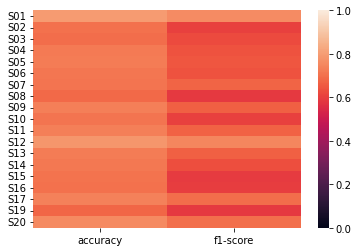

     class0 f1-score  class1 f1-score
S01         0.870588         0.507463
S02         0.820144         0.137931
S03         0.811189         0.181818
S04         0.832258         0.187500
S05         0.832117         0.206897
S06         0.827586         0.166667
S07         0.808664         0.376471
S08         0.809211         0.121212
S09         0.838710         0.242424
S10         0.824281         0.126984
S11         0.835165         0.262295
S12         0.863309         0.486486
S13         0.829268         0.309859
S14         0.829431         0.190476
S15         0.824675         0.068966
S16         0.820847         0.067797
S17         0.832061         0.371429
S19         0.803987         0.119403
S20         0.849315         0.352941


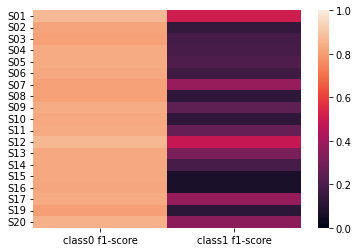

In [7]:
userfold_results_summary(participants_dictionary, participants)
userfold_classwise_results_summary(participants_dictionary, participants)


In [8]:
model.return_IE_weights()

array([0.9734843 , 0.9907023 , 0.9642111 , 1.005808  , 1.0107219 ,
       0.9981    , 0.99852985, 0.98420644, 1.0022651 , 1.0458437 ,
       1.0196323 , 0.9826899 , 0.95970833, 0.9842719 , 0.9738695 ,
       1.0275654 , 1.028979  , 0.9652065 , 0.98963225, 1.0490569 ,
       0.98385125, 1.0187824 , 0.97424006, 1.0524035 , 0.9604632 ,
       0.9702113 , 1.1183462 , 0.9635303 , 1.0051994 , 0.96431845,
       0.99595714, 1.0319797 ], dtype=float32)

In [14]:
# channel_names=[i for i in range(input_dim[0])]
channel_names=["AFz","F3","F1","Fz","F2","F4","FC5","FC3","FC1","FCz","FC2",
               "FC4","FC6","C5","C3","C1","Cz","C2","C4","C6","CP5","CP3",
               "CP1","CPz","CP2","CP4","CP6","P3","P1","Pz","P2","P4"]

In [10]:
from sklearn.preprocessing import MinMaxScaler

participants_w_list=[]

for i in range(len(participants)):

    w= pickle.load(
        open(f"{saved_dir}/Userfold-{participants[i]}-EEGNet-Weight_EEG-w-e{EPOCH}.pkl", "rb") 
                    )  
    participants_w_list.append(w)
    
avg_w= np.array(participants_w_list).mean(axis=0)
# scaler= MinMaxScaler()
# scaled_avg_w= scaler.fit_transform(avg_w)

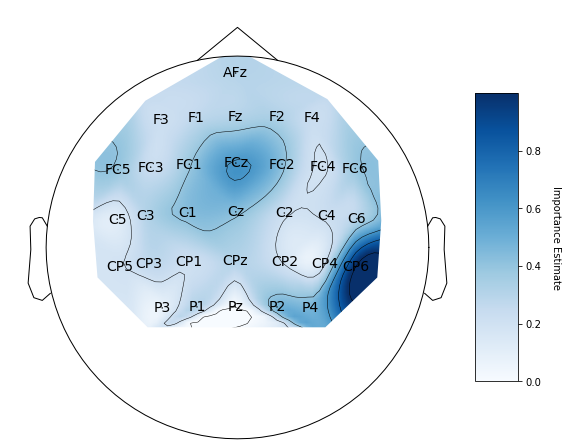

In [16]:
import matplotlib
from sklearn.preprocessing import MinMaxScaler
import mne
info= mne.create_info(channel_names, sfreq=500, ch_types=32*["eeg"])
info.set_montage("standard_1020")

fig= plt.figure()
ax= plt.axes((0,0,1.5,1.5))

scaler= MinMaxScaler()
scaled_avg_w= scaler.fit_transform(avg_w.reshape(-1,1))
# df= pd.DataFrame(scaled_avg_w.reshape(-1))

im, _= mne.viz.plot_topomap(
    scaled_avg_w.reshape(-1),
    info,
    ch_type= "eeg",
    sensors=True,
    names=channel_names,
    cmap="Blues",
    axes=ax,
    show=False,
    extrapolate="local"
#     sphere="eeglab"
)
fig.add_axes(ax)
cbar_ax= fig.add_axes([1.3,0.2, 0.1,1])
clb= fig.colorbar(im, cax=cbar_ax)
clb.set_label("Importance Estimate", rotation=270,labelpad=20)

for tt in plt.findobj(fig, matplotlib.text.Text):
    if tt.get_text() in channel_names:
        tt.set_fontsize(14)